In [25]:
import sys
sys.path.append(str('/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/'))
from configparser import ConfigParser

from repo.MyConfigParser import MyConfigParser

from repo.LoadData import DataLoader
from repo.BuildModel import GenerateModelFile, CreateModel
from repo.Accuracy import AccuracyCalculator, ProphetParameterSearch, PlotAccuracyCharts
from repo.FileGenerator import *

In [26]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/mx/1 June Update/config ups mx.ini"
updated_config.read(config_in_path)

getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)

region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

training_query = config_dict["PROPHETSETTING"]["training_query"]
_input = config_dict["PROPHETSETTING"]["input"]
_output = config_dict["PROPHETSETTING"]["output"]

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]


today = datetime.date.today().strftime("%m.%d.%Y") #'03.10.2023' #
print(today)
base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]

06.04.2024


In [27]:
daily_df = GetBQData(config_dict["PROPHETSETTING"]["training_query"], config_dict["PROPHETSETTING"]["input"], config_dict["PROPHETSETTING"]["output"])

df = daily_df.copy()
df = df.groupby(['region', 'market', 'account_type', 'funnel', 'ds']).sum().reset_index()

# log Transformation
# df['cost'] = np.log(df['cost'])
# df.loc[(df['cost'] < 0) | (np.isinf(df['cost'])), 'cost'] = 0
df['region'] = 'LATAM' 
df.loc[df['funnel'] != 'Brand', 'funnel'] = 'Non_Brand'
df['account_type'] = '-'
df.ds = pd.to_datetime(df.ds)
df = df[~df[['ds', 'y']].isin([np.nan, np.inf, -np.inf]).any(axis=1)]

df = df[df.ds < cutoff_month]
# remove inactive days
df.drop(df[((df['ds'] >= '2021-08-01')&(df['ds'] <= '2021-10-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].index,
       axis = 0, inplace = True)
df.drop(df[((df['ds'] >= '2019-03-01')&(df['ds'] <= '2019-08-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].index,
       axis = 0, inplace = True)

df.drop(df[((df['ds'] >= '2021-07-01')&(df['ds'] <= '2021-10-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Generic'))].index,
       axis = 0, inplace = True)

# add regressors
df['anomaly_2021'] = df['ds'].apply(lambda x: 1 if (x >= datetime.datetime(2021,8,1))\
                                     & (x <= datetime.datetime(2021,10,31)) else 0)
df['covid_year_dummy'] = 0
df.loc[(df['ds'] >= '2020-01-01') & (df['ds'] <= '2020-12-31'), 'Covid_Year_Dummy'] = 1

df['weekday_or_weekend'] = df['ds'].apply(lambda x: 1 if x.dayofweek > 4 else 0)

df['Nov_Dec_2018'] = 0
df.loc[(df['ds'] <= '2018-12-31') & (df['ds'] >= '2018-11-01'), 'Nov_Dec_2018'] = 1

df['Jul_Dec_2019'] = 0
df.loc[(df['ds'] <= '2019-12-31') & (df['ds'] >= '2019-07-01'), 'Jul_Dec_2019'] = 1

# set cap and floor for log regression
df['Month of Ds'] = df['ds'].dt.month_name()
df = df.drop(columns=['Covid_Year_Dummy'])
df.tail()

/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/QueryingData.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  search_df.fillna(method = 'ffill', inplace = True)


,region,market,account_type,funnel,ds,X,y,anomaly_2021,covid_year_dummy,weekday_or_weekend,Nov_Dec_2018,Jul_Dec_2019,Month of Ds
9584,LATAM,Mexico,-,Non_Brand,2024-04-20,4.41,0.0,0,0,1,0,0,April
9585,LATAM,Mexico,-,Non_Brand,2024-04-21,0.00,0.0,0,0,1,0,0,April
9586,LATAM,Mexico,-,Non_Brand,2024-04-22,8.00,0.0,0,0,0,0,0,April
9587,LATAM,Mexico,-,Non_Brand,2024-04-23,7.12,5.0,0,0,0,0,0,April
9588,LATAM,Mexico,-,Non_Brand,2024-04-24,6.45,3.0,0,0,0,0,0,April


##MODEL CONSTRAIN FILE#####
Upload model constraint file, which has for each split (account_type & funnel) the AOV and ROAS

In [28]:
boundary_df = pd.read_csv(boundary_df_in_path)
boundary_df.rename(columns = {'Market': 'market','Account Type': 'account_type', 'Funnel':'funnel'}, inplace = True)
boundary_df

,market,account_type,funnel,AOV,ROAS
0,US General,Bing Ads,Brand,34.95,35.66
1,US General,Bing Ads,Competitor,33.09,23.96
2,US General,Bing Ads,Generic,36.63,6.25
3,US General,Google AdWords,Brand,34.54,22.33
4,US General,Google AdWords,Competitor,32.36,33.84
5,US General,Google AdWords,Generic,43.94,5.99
6,France,-,Brand,35.97,7.83
7,France,-,Non_Brand,31.04,5.57
8,Germany,-,Brand,24.69,8.13
9,Germany,-,Non_Brand,27.63,6.91


In [29]:
df = pd.merge(df, boundary_df, on = ['market', 'account_type','funnel'])
df.to_csv('df.csv', index=False)

In [30]:
# set floor to the model forecast -> the model should not predict values below this value 
df['floor'] = 0

# set cap to the mnodel forecast -> max values, where the model should not forecast above this values 
df['cap'] = df.ROAS * df.X / df.AOV
df.loc[df.cap == 0, 'cap'] = df.cap.mean() # if cap is 0 set it to the mean cap 

In [31]:
covid_df = GetCovidData('Mexico')
final_df = df.merge(covid_df, how = 'left', on = ['ds', 'market'])
final_df = final_df.fillna(0)

final_df.to_csv('final_df.csv', index=False)

/var/tmp/ipykernel_6325/3442445428.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df = final_df.fillna(0)


In [32]:
final_df.drop(final_df[(final_df.ds <= '2020-01-01')].index, inplace=True)
final_df.to_csv('final_df.csv', index=False)

Analytical File Generator

In [9]:
#generator = AnalyticalFileGenerator(config_dict, final_df)
#analytical_file_df = generator.generate()
#analytical_file_df.columns

Index(['region', 'market', 'account_type', 'funnel', 'ds', 'X', 'anomaly_2021',
       'covid_year_dummy', 'weekday_or_weekend', 'Nov_Dec_2018',
       'Jul_Dec_2019', 'Month of Ds', 'AOV', 'ROAS', 'floor', 'cap',
       'new_confirmed', 'Month', 'Year', 'Mexico_-_Brand_Apr_2024',
       'Mexico_-_Brand_Aug_2024', 'Mexico_-_Brand_Dec_2024',
       'Mexico_-_Brand_Jul_2024', 'Mexico_-_Brand_Jun_2024',
       'Mexico_-_Brand_May_2024', 'Mexico_-_Brand_Nov_2024',
       'Mexico_-_Brand_Oct_2024', 'Mexico_-_Brand_Sep_2024',
       'Mexico_-_Non_Brand_Apr_2024', 'Mexico_-_Non_Brand_Aug_2024',
       'Mexico_-_Non_Brand_Dec_2024', 'Mexico_-_Non_Brand_Jul_2024',
       'Mexico_-_Non_Brand_Jun_2024', 'Mexico_-_Non_Brand_May_2024',
       'Mexico_-_Non_Brand_Nov_2024', 'Mexico_-_Non_Brand_Oct_2024',
       'Mexico_-_Non_Brand_Sep_2024', 'Weekend'],
      dtype='object')

In [10]:
#analytical_file_df.to_csv(analytical_file_path, index=False) # export the analytical file 
#generator.SaveFile(config_dict["FILEPATH"]["analytical_file_path"], folder_name) # save analytical file into GCS bucket


Data Frame file saved
Analytical_File_MX.csv saved


### On 4. Result Generator needs these Analytical File

In [33]:
analytical_input = GetBQData(config_dict["PROPHETSETTING"]["analytical_file_query"], config_dict["PROPHETSETTING"]["input"], config_dict["PROPHETSETTING"]["output"])
analytical_input = Combine(analytical_input, 'L')
generator = AnalyticalFileGenerator(config_dict, analytical_input)
analytical_file_df = generator.generate()
analytical_file_df = pd.merge(analytical_file_df, boundary_df, on = ['market', 'account_type', 'funnel'])
# generator.SaveFile(analytical_file_name, folder_name) # X is input value which should be the sum of all variable splits
analytical_file_df.to_csv(analytical_file_path, index=False) # export the analytical file 
generator.SaveFile(config_dict["FILEPATH"]["analytical_file_path"], folder_name) # save analytical file into GCS bucket

/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/QueryingData.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  search_df.fillna(method = 'ffill', inplace = True)
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/FileGenerator.py:149: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  analytical_file_NY_prep = analytical_file_NY_prep.fillna(0)


Data Frame file saved
Analytical_File_MX.csv saved


In [12]:
splits_names = list(analytical_file_df[['market','account_type','funnel']].drop_duplicates().itertuples(index=False, name=None)) # get the actual splits in df 
splits_names = ['_'.join(item).replace(' ', '_') for item in splits_names]# organize the element splits names joining by '_' 
#analytical_file_df.drop(columns=['Month of Ds'], inplace=True)
analytical_file_columns = ['region', 'market', 'account_type', 'funnel', 'ds', 'X', 'Month','Year'] + splits_names + ['weekday_or_weekend','anomaly_2021','covid_year_dummy','AOV','ROAS','floor','cap'] # add other columns needed in analytical file

# drop columns that arent needed in analytical df, splits that aren't optimized 
for col in analytical_file_df.columns: # Loop over each column in the DataFrame
    if not any(col.startswith(prefix) for prefix in analytical_file_columns): # Check if the column starts with any of the prefixes in combined_strings
        print(f'column {col} dropped from analytical_file_df')
        analytical_file_df.drop(columns=col, inplace=True) # if the columns does not starts with any element in analytical_file_columns drop it 


column Identifier dropped from analytical_file_df
column new_funnel dropped from analytical_file_df
column generic_cost dropped from analytical_file_df
column competitor_cost dropped from analytical_file_df
column generic_cost_split dropped from analytical_file_df
column competitor_cost_split dropped from analytical_file_df
column Weekend dropped from analytical_file_df


In [12]:
analytical_file_df.to_csv(analytical_file_path,index=False) # export the analytical file 
generator.SaveFile(config_dict["FILEPATH"]["analytical_file_path"], folder_name) # save analytical file into GCS bucket


Data Frame file saved
Analytical_File_MX.csv saved


Cuts DF

In [34]:
cuts_df = pd.read_csv(cuts_df_in_path) # import cuts_df
cuts_df['periods'] = periods # add column that inidcates number of periods to forecast
cuts_df['periods_for_acc_cal'] = 183 #periods # add number of periods that are left out of sample to calculate the accuracy 
cuts_df['cutoff_month'] = cutoff_month # add a column that sets the cuttof day of the data set 

cuts_df

,market,account_type,funnel,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,weekday_or_weekend,include_holiday,...,generic_cost_split,competitor_cost_split,new_confirmed,Nov_Dec_2018,Jul_Dec_2019,power,growth,periods,periods_for_acc_cal,cutoff_month
0,Mexico,-,Brand,0.05,0.01,0.1,additive,additive,additive,na,...,na,na,na,na,na,na,linear,251.0,183,2024-04-25
1,Mexico,-,Non_Brand,0.50,1.00,0.1,multiplicative,multiplicative,multiplicative,na,...,na,na,na,na,additive,na,linear,251.0,183,2024-04-25


In [35]:
# create a list of variable names that make each split 
query_item_list = [query_item for query_item in [config_dict["CLIENTINFO"]["breakdown1"], \
                             config_dict["CLIENTINFO"]["breakdown2"], \
                             config_dict["CLIENTINFO"]["breakdown3"], \
                             config_dict["CLIENTINFO"]["breakdown4"]]
                             if query_item != None]

query_item_list

['market', 'account_type', 'funnel']

Accuracy based on previous refresh

In [16]:
calculator = AccuracyCalculator() 
accuracy_df = calculator.CalculateAccuracy(cuts_df, final_df, query_item_list) # calculate accuracy based on cuts_df previous hyper parameters
#calculator.SaveFile()
calculator.SaveFile(output_bucket, folder_name, 'Accuracy.csv')

20:45:18 - cmdstanpy - INFO - Chain [1] start processing
20:45:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.42 Period MAE: 28.33


/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:267: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.monthly_acc_df_temp = pd.concat([self.monthly_acc_df_temp, monthly_acc_df], ignore_index=True)
20:45:20 - cmdstanpy - INFO - Chain [1] start processing
20:45:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.46 Period MAE: 3.58
Data Frame file saved


In [17]:
accuracy = accuracy_df.groupby([ 'funnel']).mean(numeric_only=1) # group by split 
accuracy['Accuracy'] = np.where(accuracy['MAPE'] > 100, 'MAPE above 100%', 100 - accuracy['MAPE']) # create accuracy from MAPE 
accuracy['Forecast Period Accuracy'] = np.where(accuracy['Forecast Period MAE'] > 100, 'Forecast Period MAE above 100%', 100 - accuracy['Forecast Period MAE']) # create period accuracy from period MAPE
accuracy.drop(columns=['MAPE','Forecast Period MAE'], inplace=True) # drop error columns 
accuracy.rename(columns = {'Percentage Error': 'Mean Percentage Error'}, inplace = True) # rename columns
accuracy


,Actual,Forecast,Mean Percentage Error,Accuracy,Forecast Period Accuracy
funnel,,,,,
Brand,2086.428571,2677.477143,-28.414286,71.58,71.67
Non_Brand,503.000000,521.022857,-15.641429,71.53999999999999,96.42


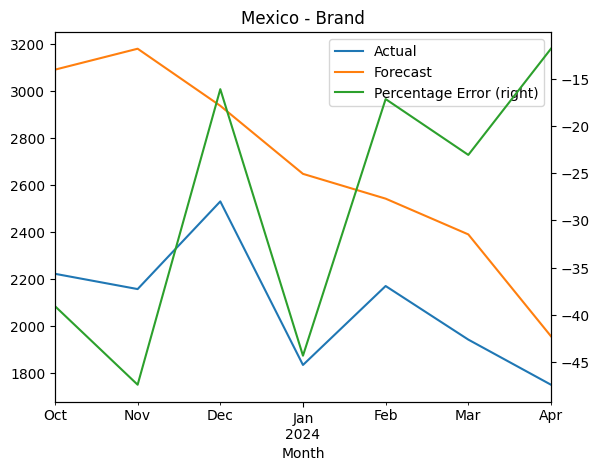

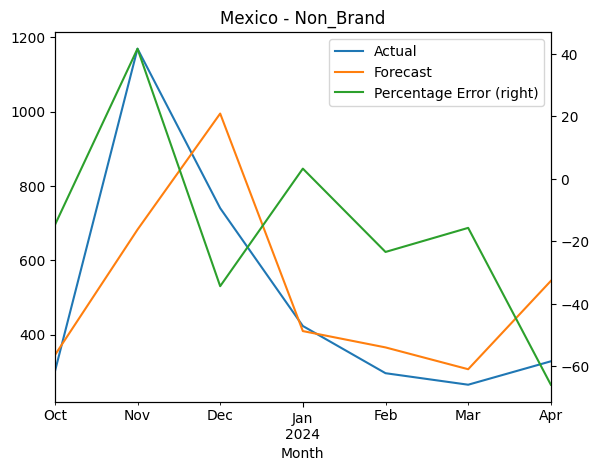

In [30]:
PlotAccuracyCharts(accuracy_df, cuts_df, query_item_list)


Prophet parameter search

In [19]:
param_grid = {
    'changepoint_prior_scale': [ 0.5, 0.1, 0.05, 0.001],   
    'seasonality_prior_scale': [0.075, 1.0 ,0.05], 
    'holidays_prior_scale': [10.0, 1.0,  0.1, 0.01  ], 
    'seasonality_mode': ['additive','multiplicative'], 
    'input_mode': ['additive','multiplicative'], 
    'weekday_or_weekend':['na', 'additive', 'multiplicative'],  
    'include_holiday': ['na', 'Default', 'Custom'],
    'covid_year_exclude':['na'],
    'covid_year_dummy':['na'],#, 'additive', 'multiplicative'],
    'anomaly_2021':['na', 'additive', 'multiplicative'],
    'generic_cost_split':['na'],#'additive', 'multiplicative'],
    'competitor_cost_split':['na'], #, 'additive', 'multiplicative'
    'new_confirmed': ['na']#, 'additive', 'multiplicative'
            }

In [ ]:
# set the prophet parameter search with the hyper parameter 
#grid created above and
#power flag as false (not needed)
search_engine = ProphetParameterSearch(param_grid = param_grid, power_flag = False, base_path=base_path) 
grid_brand = search_engine.search(cuts_df, final_df) # performs the grid search over 
#the hyper parameter grid. exports a best result .csv table with best hyper parameters by split and a record df .csv table with full hyper parameters results


  0%|          | 0/2 [00:00<?, ?it/s]

06:56:46 - cmdstanpy - INFO - Chain [1] start processing
06:56:46 - cmdstanpy - INFO - Chain [1] start processing
06:56:46 - cmdstanpy - INFO - Chain [1] start processing
06:56:46 - cmdstanpy - INFO - Chain [1] start processing
06:56:47 - cmdstanpy - INFO - Chain [1] done processing
06:56:48 - cmdstanpy - INFO - Chain [1] done processing
06:56:48 - cmdstanpy - INFO - Chain [1] done processing
06:56:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.57 Period MAE: 6.15
It's underpredicted.
Monthly Error: 25.61 Period MAE: 12.870000000000001


06:56:50 - cmdstanpy - INFO - Chain [1] start processing
06:56:50 - cmdstanpy - INFO - Chain [1] start processing
06:56:52 - cmdstanpy - INFO - Chain [1] done processing
06:56:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.49 Period MAE: 11.379999999999999


06:56:54 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.59 Period MAE: 64.96
It's overpredicted.
Monthly Error: 64.78 Period MAE: 65.23


06:56:55 - cmdstanpy - INFO - Chain [1] start processing
06:56:56 - cmdstanpy - INFO - Chain [1] start processing
06:56:56 - cmdstanpy - INFO - Chain [1] done processing
06:56:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.57 Period MAE: 8.24


06:56:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.35 Period MAE: 65.67


06:56:59 - cmdstanpy - INFO - Chain [1] start processing
06:56:59 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.19 Period MAE: 11.49


06:57:00 - cmdstanpy - INFO - Chain [1] start processing
06:57:01 - cmdstanpy - INFO - Chain [1] done processing
06:57:02 - cmdstanpy - INFO - Chain [1] done processing
06:57:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.11 Period MAE: 11.68


06:57:05 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.86 Period MAE: 66.33


06:57:07 - cmdstanpy - INFO - Chain [1] start processing
06:57:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 

06:57:09 - cmdstanpy - INFO - Chain [1] done processing


63.99 Period MAE: 64.35
It's underpredicted.
Monthly Error: 20.91 Period MAE: 6.1
It's overpredicted.
Monthly Error:

06:57:11 - cmdstanpy - INFO - Chain [1] start processing


 65.12 Period MAE: 65.44


06:57:12 - cmdstanpy - INFO - Chain [1] start processing
06:57:12 - cmdstanpy - INFO - Chain [1] start processing
06:57:13 - cmdstanpy - INFO - Chain [1] done processing
06:57:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.37 Period MAE: 13.79


06:57:16 - cmdstanpy - INFO - Chain [1] done processing
06:57:16 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.47 Period MAE: 64.94


06:57:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 26.51 Period MAE: 15.36


06:57:18 - cmdstanpy - INFO - Chain [1] start processing
06:57:18 - cmdstanpy - INFO - Chain [1] done processing
06:57:19 - cmdstanpy - INFO - Chain [1] done processing
06:57:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.75 Period MAE: 7.4399999999999995
It's overpredicted.
65.3Monthly Error: 64.88 Period MAE: 


06:57:21 - cmdstanpy - INFO - Chain [1] start processing
06:57:21 - cmdstanpy - INFO - Chain [1] start processing
06:57:23 - cmdstanpy - INFO - Chain [1] done processing
06:57:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.21 Period MAE: 12.13


06:57:25 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.59 Period MAE: 64.91


06:57:26 - cmdstanpy - INFO - Chain [1] start processing
06:57:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.53 Period MAE: 51.54
It's underpredicted.
Monthly Error: 25.04 Period MAE:11.04 


06:57:28 - cmdstanpy - INFO - Chain [1] start processing
06:57:28 - cmdstanpy - INFO - Chain [1] done processing
06:57:28 - cmdstanpy - INFO - Chain [1] start processing
06:57:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.55 Period MAE: 52.53


06:57:30 - cmdstanpy - INFO - Chain [1] done processing
06:57:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.92 Period MAE: 8.51


06:57:32 - cmdstanpy - INFO - Chain [1] start processing
06:57:34 - cmdstanpy - INFO - Chain [1] done processing
06:57:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.91 Period MAE: 52.88
It's underpredicted.
Monthly Error: 24.44 Period MAE: 12.68


06:57:36 - cmdstanpy - INFO - Chain [1] start processing
06:57:37 - cmdstanpy - INFO - Chain [1] start processing
06:57:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.42 Period MAE: 52.400000000000006


06:57:39 - cmdstanpy - INFO - Chain [1] start processing
06:57:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.51 Period MAE: 10.09


06:57:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.93 Period MAE: 52.89


06:57:41 - cmdstanpy - INFO - Chain [1] done processing
06:57:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.01 Period MAE: 8.19


06:57:43 - cmdstanpy - INFO - Chain [1] done processing
06:57:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.75 Period MAE: 52.71


06:57:46 - cmdstanpy - INFO - Chain [1] done processing
06:57:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 26.36 Period MAE: 13.68


06:57:48 - cmdstanpy - INFO - Chain [1] done processing
06:57:49 - cmdstanpy - INFO - Chain [1] start processing
06:57:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.09 Period MAE: 51.1


06:57:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.76 Period MAE: 12.839999999999998


06:57:52 - cmdstanpy - INFO - Chain [1] done processing
06:57:52 - cmdstanpy - INFO - Chain [1] start processing
06:57:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.0 Period MAE: 37.82


06:57:54 - cmdstanpy - INFO - Chain [1] done processing
06:57:54 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.51 Period MAE: 52.480000000000004


06:57:56 - cmdstanpy - INFO - Chain [1] done processing
06:57:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 36.56 Period MAE: 36.39


06:57:58 - cmdstanpy - INFO - Chain [1] done processing
06:57:58 - cmdstanpy - INFO - Chain [1] start processing
06:58:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.18 Period MAE: 53.14It's overpredicted.

Monthly Error: 58.95 Period MAE: 59.35


06:58:01 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 37.78 Period MAE: 37.56


06:58:02 - cmdstanpy - INFO - Chain [1] start processing
06:58:03 - cmdstanpy - INFO - Chain [1] start processing
06:58:03 - cmdstanpy - INFO - Chain [1] done processing
06:58:04 - cmdstanpy - INFO - Chain [1] done processing
06:58:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.2 Period MAE: 59.550000000000004


06:58:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 33.99 Period MAE: 33.87


06:58:07 - cmdstanpy - INFO - Chain [1] start processing
06:58:08 - cmdstanpy - INFO - Chain [1] done processing
06:58:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.64 Period MAE: 34.510000000000005


06:58:10 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.52 Period MAE: 59.77
It's overpredicted.
Monthly Error: 58.53 Period MAE: 58.879999999999995


06:58:12 - cmdstanpy - INFO - Chain [1] start processing
06:58:13 - cmdstanpy - INFO - Chain [1] done processing
06:58:13 - cmdstanpy - INFO - Chain [1] start processing
06:58:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.63 Period MAE: 35.46


06:58:15 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.76 Period MAE: 59.099999999999994


06:58:16 - cmdstanpy - INFO - Chain [1] done processing
06:58:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 33.3 Period MAE: 33.15


06:58:18 - cmdstanpy - INFO - Chain [1] done processing
06:58:18 - cmdstanpy - INFO - Chain [1] start processing
06:58:20 - cmdstanpy - INFO - Chain [1] done processing
06:58:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.91 Period MAE: 59.18
It's overpredicted.
Monthly Error: 34.41 Period MAE: 34.19


06:58:22 - cmdstanpy - INFO - Chain [1] start processing
06:58:23 - cmdstanpy - INFO - Chain [1] start processing
06:58:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.57 Period MAE: 58.01


06:58:25 - cmdstanpy - INFO - Chain [1] start processing
06:58:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.36 Period MAE: 35.08


06:58:27 - cmdstanpy - INFO - Chain [1] done processing
06:58:27 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.54 Period MAE: 57.940000000000005


06:58:28 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 82.08 Period MAE: 81.32000000000001


06:58:29 - cmdstanpy - INFO - Chain [1] done processing
06:58:29 - cmdstanpy - INFO - Chain [1] start processing
06:58:31 - cmdstanpy - INFO - Chain [1] done processing
06:58:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.34 Period MAE: 58.599999999999994


06:58:32 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 79.84 Period MAE: 79.14999999999999


06:58:33 - cmdstanpy - INFO - Chain [1] start processing
06:58:34 - cmdstanpy - INFO - Chain [1] done processing
06:58:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.98 Period MAE: 57.04


06:58:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 79.47 Period MAE: 78.78
It's overpredicted.
Monthly Error: 57.53 Period MAE: 57.550000000000004


06:58:37 - cmdstanpy - INFO - Chain [1] start processing
06:58:38 - cmdstanpy - INFO - Chain [1] start processing
06:58:39 - cmdstanpy - INFO - Chain [1] done processing
06:58:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 81.34 Period MAE: 80.58
It's overpredicted.
Monthly Error: 57.27 Period MAE: 57.24


06:58:41 - cmdstanpy - INFO - Chain [1] start processing
06:58:42 - cmdstanpy - INFO - Chain [1] start processing
06:58:42 - cmdstanpy - INFO - Chain [1] done processing
06:58:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.7 Period MAE: 78.97999999999999


06:58:44 - cmdstanpy - INFO - Chain [1] start processing
06:58:45 - cmdstanpy - INFO - Chain [1] done processing
06:58:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.43 Period MAE: 56.43
It's overpredicted.
Monthly Error: 79.72 Period MAE: 78.97999999999999


06:58:47 - cmdstanpy - INFO - Chain [1] start processing
06:58:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.03 Period MAE: 56.989999999999995


06:58:50 - cmdstanpy - INFO - Chain [1] done processing
06:58:51 - cmdstanpy - INFO - Chain [1] start processing
06:58:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.79 Period MAE: 56.75
It's overpredicted.
Monthly Error: 81.73 Period MAE: 81.0


06:58:54 - cmdstanpy - INFO - Chain [1] start processing
06:58:54 - cmdstanpy - INFO - Chain [1] start processing
06:58:56 - cmdstanpy - INFO - Chain [1] done processing
06:58:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.27 Period MAE: 58.34
It's overpredicted.
Monthly Error: 79.96 Period MAE: 79.27


06:58:58 - cmdstanpy - INFO - Chain [1] done processing
06:58:58 - cmdstanpy - INFO - Chain [1] start processing
06:58:58 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 79.53 Period MAE: 78.86


06:59:00 - cmdstanpy - INFO - Chain [1] start processing
06:59:00 - cmdstanpy - INFO - Chain [1] done processing
06:59:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.12 Period MAE: 74.56

06:59:02 - cmdstanpy - INFO - Chain [1] done processing


06:59:03 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.78 Period MAE: 58.809999999999995


06:59:05 - cmdstanpy - INFO - Chain [1] start processing
06:59:06 - cmdstanpy - INFO - Chain [1] done processing
06:59:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.59 Period MAE: 58.589999999999996
It's overpredicted.
Monthly Error: 74.44 Period MAE: 73.9


06:59:08 - cmdstanpy - INFO - Chain [1] start processing
06:59:09 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.37 Period MAE: 69.45


06:59:10 - cmdstanpy - INFO - Chain [1] done processing
06:59:11 - cmdstanpy - INFO - Chain [1] done processing
06:59:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 74.56 Period MAE: 74.02
It's overpredicted.
Monthly Error: 69.13 Period MAE: 69.16


06:59:13 - cmdstanpy - INFO - Chain [1] start processing
06:59:14 - cmdstanpy - INFO - Chain [1] start processing
06:59:14 - cmdstanpy - INFO - Chain [1] done processing
06:59:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.81 Period MAE: 74.21


06:59:17 - cmdstanpy - INFO - Chain [1] start processing
06:59:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.15 Period MAE: 69.15


06:59:18 - cmdstanpy - INFO - Chain [1] start processing
06:59:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.46 Period MAE: 73.89


06:59:19 - cmdstanpy - INFO - Chain [1] start processing
06:59:21 - cmdstanpy - INFO - Chain [1] done processing
06:59:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.45 Period MAE: 69.52000000000001
It's overpredicted.
Monthly Error: 73.92 Period MAE: 73.35000000000001


06:59:23 - cmdstanpy - INFO - Chain [1] start processing
06:59:23 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.03 Period MAE: 69.06


06:59:25 - cmdstanpy - INFO - Chain [1] done processing
06:59:26 - cmdstanpy - INFO - Chain [1] start processing
06:59:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.06 Period MAE: 69.07
It's overpredicted.
Monthly Error: 75.05 Period MAE: 74.5


06:59:29 - cmdstanpy - INFO - Chain [1] start processing
06:59:29 - cmdstanpy - INFO - Chain [1] done processing
06:59:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 74.13 Period MAE: 73.61
It's overpredicted.
Monthly Error: 68.94 Period MAE: 69.05


06:59:32 - cmdstanpy - INFO - Chain [1] start processing
06:59:32 - cmdstanpy - INFO - Chain [1] done processing
06:59:32 - cmdstanpy - INFO - Chain [1] start processing
06:59:33 - cmdstanpy - INFO - Chain [1] done processing
06:59:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.66 Period MAE: 74.11999999999999


06:59:35 - cmdstanpy - INFO - Chain [1] done processing
06:59:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 82.69 Period MAE: 81.92


06:59:37 - cmdstanpy - INFO - Chain [1] start processing
06:59:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.65 Period MAE: 68.72


06:59:39 - cmdstanpy - INFO - Chain [1] start processing
06:59:40 - cmdstanpy - INFO - Chain [1] done processing
06:59:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.66 Period MAE: 68.71000000000001
It's overpredicted.
Monthly Error: 80.8 Period MAE: 80.08999999999999


06:59:42 - cmdstanpy - INFO - Chain [1] start processing
06:59:43 - cmdstanpy - INFO - Chain [1] start processing
06:59:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.78 Period MAE: 49.75


06:59:45 - cmdstanpy - INFO - Chain [1] done processing
06:59:45 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 81.66 Period MAE: 80.9


06:59:47 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 50.34 Period MAE: 50.239999999999995


06:59:48 - cmdstanpy - INFO - Chain [1] done processing
06:59:48 - cmdstanpy - INFO - Chain [1] start processing
06:59:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.34 Period MAE: 81.55


06:59:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted. 
Monthly Error:49.94 Period MAE: 49.830000000000005


06:59:51 - cmdstanpy - INFO - Chain [1] start processing
06:59:51 - cmdstanpy - INFO - Chain [1] done processing
06:59:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.51 Period MAE: 79.77


06:59:54 - cmdstanpy - INFO - Chain [1] start processing
06:59:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.01 Period MAE: 79.27
It's overpredicted.
Monthly Error: 49.47 Period MAE: 49.41


06:59:56 - cmdstanpy - INFO - Chain [1] done processing
06:59:57 - cmdstanpy - INFO - Chain [1] start processing
06:59:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.79 Period MAE: 49.669999999999995


06:59:59 - cmdstanpy - INFO - Chain [1] done processing
07:00:00 - cmdstanpy - INFO - Chain [1] start processing
07:00:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.42 Period MAE: 49.3


07:00:04 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 83.61 Period MAE: 82.80999999999999


07:00:05 - cmdstanpy - INFO - Chain [1] start processing
07:00:05 - cmdstanpy - INFO - Chain [1] done processing
07:00:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.55 Period MAE: 51.559999999999995
It's overpredicted.
Monthly Error: 80.94 Period MAE: 80.23


07:00:08 - cmdstanpy - INFO - Chain [1] start processing
07:00:08 - cmdstanpy - INFO - Chain [1] start processing
07:00:10 - cmdstanpy - INFO - Chain [1] done processing
07:00:10 - cmdstanpy - INFO - Chain [1] done processing
07:00:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.64 Period MAE: 79.93
It's overpredicted.
Monthly Error: 19.44 Period MAE: 17.119999999999997


07:00:13 - cmdstanpy - INFO - Chain [1] start processing
07:00:13 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.83 Period MAE: 51.78


07:00:14 - cmdstanpy - INFO - Chain [1] start processing
07:00:15 - cmdstanpy - INFO - Chain [1] done processing
07:00:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.3 Period MAE: 14.56


07:00:17 - cmdstanpy - INFO - Chain [1] done processing
07:00:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.54 Period MAE: 51.480000000000004


07:00:18 - cmdstanpy - INFO - Chain [1] start processing
07:00:19 - cmdstanpy - INFO - Chain [1] done processing
07:00:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 20.0 Period MAE: 19.57
It's overpredicted.
Monthly Error: 47.06 Period MAE: 47.339999999999996


07:00:22 - cmdstanpy - INFO - Chain [1] start processing
07:00:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.64 Period MAE: 46.949999999999996


07:00:24 - cmdstanpy - INFO - Chain [1] done processing
07:00:24 - cmdstanpy - INFO - Chain [1] done processing
07:00:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.2 Period MAE: 15.82


07:00:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 50.76 Period MAE: 50.970000000000006


07:00:26 - cmdstanpy - INFO - Chain [1] done processing
07:00:27 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.18 Period MAE: 15.040000000000001


07:00:28 - cmdstanpy - INFO - Chain [1] done processing
07:00:29 - cmdstanpy - INFO - Chain [1] start processing
07:00:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.52 Period MAE: 

07:00:30 - cmdstanpy - INFO - Chain [1] done processing


46.78
It's overpredicted.
Monthly Error: 19.51 Period MAE: 18.32


07:00:31 - cmdstanpy - INFO - Chain [1] start processing
07:00:32 - cmdstanpy - INFO - Chain [1] start processing
07:00:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 

07:00:35 - cmdstanpy - INFO - Chain [1] done processing


46.02 Period MAE: 46.28


07:00:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 18.57 Period MAE: 12.659999999999998
It's overpredicted.
Monthly Error: 48.57 Period MAE: 48.78


07:00:37 - cmdstanpy - INFO - Chain [1] start processing
07:00:38 - cmdstanpy - INFO - Chain [1] start processing
07:00:39 - cmdstanpy - INFO - Chain [1] done processing
07:00:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.02 Period MAE: 8.34


07:00:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.75 Period MAE: 47.02


07:00:42 - cmdstanpy - INFO - Chain [1] done processing
07:00:42 - cmdstanpy - INFO - Chain [1] start processing
07:00:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 18.43 Period MAE: 10.93


07:00:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 25.16 Period MAE: 25.71


07:00:45 - cmdstanpy - INFO - Chain [1] done processing
07:00:45 - cmdstanpy - INFO - Chain [1] done processing
07:00:45 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


07:00:47 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 46.46 Period MAE: 46.72


07:00:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 23.6 Period MAE: 24.16


07:00:49 - cmdstanpy - INFO - Chain [1] start processing
07:00:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.2 Period MAE: 48.42


07:00:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.31 Period MAE: 53.7


07:00:52 - cmdstanpy - INFO - Chain [1] start processing
07:00:53 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 27.65 Period MAE: 28.110000000000003


07:00:54 - cmdstanpy - INFO - Chain [1] done processing
07:00:54 - cmdstanpy - INFO - Chain [1] start processing
07:00:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.36 Period MAE: 53.74


07:00:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.84 Period MAE: 24.36


07:00:56 - cmdstanpy - INFO - Chain [1] start processing
07:00:57 - cmdstanpy - INFO - Chain [1] start processing
07:00:58 - cmdstanpy - INFO - Chain [1] done processing
07:00:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 21.21 Period MAE: 21.4
It's overpredicted.
Monthly Error: 53.66 Period MAE: 53.959999999999994


07:01:01 - cmdstanpy - INFO - Chain [1] start processing
07:01:02 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.46 Period MAE: 52.800000000000004


07:01:03 - cmdstanpy - INFO - Chain [1] done processing
07:01:04 - cmdstanpy - INFO - Chain [1] done processing
07:01:04 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 24.25 Period MAE: 24.77
It's overpredicted.
Monthly Error: 52.81 Period MAE: 53.12


07:01:07 - cmdstanpy - INFO - Chain [1] start processing
07:01:07 - cmdstanpy - INFO - Chain [1] start processing
07:01:07 - cmdstanpy - INFO - Chain [1] done processing
07:01:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.91 Period MAE: 20.18


07:01:10 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.28 Period MAE: 53.480000000000004


07:01:11 - cmdstanpy - INFO - Chain [1] done processing
07:01:12 - cmdstanpy - INFO - Chain [1] start processing
07:01:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 18.31 Period MAE: 14.330000000000002


07:01:15 - cmdstanpy - INFO - Chain [1] start processing
07:01:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.46 Period MAE: 53.74


07:01:16 - cmdstanpy - INFO - Chain [1] done processing
07:01:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.28 Period MAE: 18.61


07:01:17 - cmdstanpy - INFO - Chain [1] start processing
07:01:18 - cmdstanpy - INFO - Chain [1] done processing
07:01:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.61 Period MAE: 53.879999999999995
It's overpredicted.
Monthly Error: 19.64 Period MAE: 16.6


07:01:20 - cmdstanpy - INFO - Chain [1] start processing
07:01:21 - cmdstanpy - INFO - Chain [1] start processing
07:01:22 - cmdstanpy - INFO - Chain [1] done processing
07:01:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 55.76 Period MAE: 55.92
It's overpredicted.
Monthly Error: 19.77 Period MAE: 16.71


07:01:24 - cmdstanpy - INFO - Chain [1] start processing
07:01:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.49 Period MAE: 46.81


07:01:25 - cmdstanpy - INFO - Chain [1] start processing
07:01:26 - cmdstanpy - INFO - Chain [1] done processing
07:01:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 20.15 Period MAE: 19.89


07:01:28 - cmdstanpy - INFO - Chain [1] done processing
07:01:28 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.18 Period MAE: 47.48
It's overpredicted.
Monthly Error: 19.42 

07:01:29 - cmdstanpy - INFO - Chain [1] start processing
07:01:29 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 15.190000000000001


07:01:30 - cmdstanpy - INFO - Chain [1] start processing
07:01:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.

07:01:32 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 47.18 Period MAE: 47.36


07:01:33 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.69 Period MAE: 14.97


07:01:34 - cmdstanpy - INFO - Chain [1] start processing
07:01:35 - cmdstanpy - INFO - Chain [1] done processing
07:01:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.7 Period MAE: 46.92
It's overpredicted.
Monthly Error: 19.62 Period MAE: 16.689999999999998


07:01:37 - cmdstanpy - INFO - Chain [1] start processing
07:01:38 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.65 Period MAE: 46.9


07:01:40 - cmdstanpy - INFO - Chain [1] done processing
07:01:40 - cmdstanpy - INFO - Chain [1] start processing
07:01:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.5 Period MAE: 46.67
It's overpredicted.
Monthly Error: 18.54 Period MAE: 12.75


07:01:43 - cmdstanpy - INFO - Chain [1] done processing
07:01:43 - cmdstanpy - INFO - Chain [1] start processing
07:01:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.21 Period MAE: 7.26


07:01:45 - cmdstanpy - INFO - Chain [1] start processing
07:01:46 - cmdstanpy - INFO - Chain [1] done processing
07:01:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.42 Period MAE: 47.68


07:01:47 - cmdstanpy - INFO - Chain [1] done processing
07:01:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 18.76 Period MAE: 10.77


07:01:49 - cmdstanpy - INFO - Chain [1] start processing
07:01:50 - cmdstanpy - INFO - Chain [1] done processing
07:01:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 83.02 Period MAE: 82.25


07:01:52 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.22 Period MAE: 47.54


07:01:54 - cmdstanpy - INFO - Chain [1] start processing
07:01:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.49 Period MAE: 47.68


07:01:55 - cmdstanpy - INFO - Chain [1] done processing
07:01:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.52 Period MAE: 79.85
It's overpredicted.
Monthly Error: 72.77 Period MAE: 73.24000000000001


07:01:57 - cmdstanpy - INFO - Chain [1] start processing
07:01:57 - cmdstanpy - INFO - Chain [1] start processing
07:01:57 - cmdstanpy - INFO - Chain [1] done processing
07:01:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.93 Period MAE: 80.23


07:02:00 - cmdstanpy - INFO - Chain [1] done processing
07:02:00 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 82.93 Period MAE: 82.14
It's overpredicted.
Monthly Error: 73.08 

07:02:02 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 73.54


07:02:02 - cmdstanpy - INFO - Chain [1] start processing
07:02:03 - cmdstanpy - INFO - Chain [1] start processing
07:02:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 73.24 Period MAE: 73.65


07:02:06 - cmdstanpy - INFO - Chain [1] start processing
07:02:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.19 Period MAE: 79.49000000000001


07:02:08 - cmdstanpy - INFO - Chain [1] start processing
07:02:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 71.93 Period MAE: 72.34


07:02:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.75 Period MAE: 79.07


07:02:10 - cmdstanpy - INFO - Chain [1] start processing
07:02:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 71.61 Period MAE: 72.03


07:02:12 - cmdstanpy - INFO - Chain [1] start processing
07:02:12 - cmdstanpy - INFO - Chain [1] done processing
07:02:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.79 Period MAE: 82.08


07:02:16 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 72.37 Period MAE: 72.74000000000001


07:02:17 - cmdstanpy - INFO - Chain [1] done processing
07:02:18 - cmdstanpy - INFO - Chain [1] start processing
07:02:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.65 Period MAE: 79.93
It's overpredicted.
Monthly Error: 73.68 Period MAE: 73.96000000000001


07:02:20 - cmdstanpy - INFO - Chain [1] start processing
07:02:20 - cmdstanpy - INFO - Chain [1] start processing
07:02:22 - cmdstanpy - INFO - Chain [1] done processing
07:02:22 - cmdstanpy - INFO - Chain [1] done processing
07:02:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.72 Period MAE: 79.97999999999999
It's overpredicted.
Monthly Error: 83.89 Period MAE: 83.12


07:02:24 - cmdstanpy - INFO - Chain [1] start processing
07:02:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 73.66 Period MAE: 73.92999999999999


07:02:25 - cmdstanpy - INFO - Chain [1] done processing
07:02:25 - cmdstanpy - INFO - Chain [1] start processing
07:02:27 - cmdstanpy - INFO - Chain [1] done processing
07:02:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 73.68 Period MAE: 73.89
It's overpredicted.
Monthly Error: 82.32 Period MAE: 81.58999999999999


07:02:29 - cmdstanpy - INFO - Chain [1] start processing
07:02:29 - cmdstanpy - INFO - Chain [1] start processing
07:02:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:

07:02:32 - cmdstanpy - INFO - Chain [1] done processing


 69.63 Period MAE: 70.09


07:02:33 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: It's overpredicted.69.65
 Period MAE: Monthly Error:70.11
 82.41 Period MAE: 81.64


07:02:34 - cmdstanpy - INFO - Chain [1] start processing
07:02:34 - cmdstanpy - INFO - Chain [1] start processing
07:02:35 - cmdstanpy - INFO - Chain [1] done processing
07:02:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: It's overpredicted.69.89
 Period MAE: 70.30999999999999
Monthly Error: 83.58 Period MAE: 82.78999999999999


07:02:37 - cmdstanpy - INFO - Chain [1] start processing
07:02:37 - cmdstanpy - INFO - Chain [1] done processing
07:02:37 - cmdstanpy - INFO - Chain [1] start processing
07:02:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 81.23 Period MAE: 80.47999999999999


07:02:40 - cmdstanpy - INFO - Chain [1] start processing
07:02:40 - cmdstanpy - INFO - Chain [1] done processing
07:02:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.92 Period MAE: 69.34
It's overpredicted.
Monthly Error: 81.29 Period MAE: 80.56


07:02:43 - cmdstanpy - INFO - Chain [1] start processing
07:02:43 - cmdstanpy - INFO - Chain [1] start processing
07:02:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.82 Period MAE: 69.23


07:02:47 - cmdstanpy - INFO - Chain [1] done processing
07:02:47 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 84.49 Period MAE: 83.69
It's overpredicted.
Monthly Error: 69.15 Period MAE: 69.51


07:02:49 - cmdstanpy - INFO - Chain [1] start processing
07:02:50 - cmdstanpy - INFO - Chain [1] start processing
07:02:50 - cmdstanpy - INFO - Chain [1] done processing
07:02:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 71.02 Period MAE: 71.3
It's overpredicted.
Monthly Error: 82.48 Period MAE: 81.72


07:02:53 - cmdstanpy - INFO - Chain [1] start processing
07:02:53 - cmdstanpy - INFO - Chain [1] start processing
07:02:54 - cmdstanpy - INFO - Chain [1] done processing
07:02:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.28 Period MAE: 81.49


07:02:56 - cmdstanpy - INFO - Chain [1] start processing
07:02:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 70.96 Period MAE: 71.25


07:02:57 - cmdstanpy - INFO - Chain [1] done processing
07:02:58 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 83.08 Period MAE: 82.3


07:02:58 - cmdstanpy - INFO - Chain [1] start processing
07:02:59 - cmdstanpy - INFO - Chain [1] done processing
07:03:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 71.19 Period MAE: 71.44
It's overpredicted.
Monthly Error: 81.2 Period MAE: 80.49


07:03:03 - cmdstanpy - INFO - Chain [1] start processing
07:03:03 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.32 Period MAE: 65.72


07:03:05 - cmdstanpy - INFO - Chain [1] done processing
07:03:05 - cmdstanpy - INFO - Chain [1] start processing
07:03:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.18 Period MAE: 65.59
It's overpredicted.
Monthly Error: 81.37 Period MAE: 80.66


07:03:08 - cmdstanpy - INFO - Chain [1] start processing
07:03:08 - cmdstanpy - INFO - Chain [1] done processing
07:03:08 - cmdstanpy - INFO - Chain [1] start processing
07:03:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.31 Period MAE: 81.55


07:03:10 - cmdstanpy - INFO - Chain [1] start processing
07:03:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.27 Period MAE: 65.61


07:03:11 - cmdstanpy - INFO - Chain [1] done processing
07:03:12 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.49 Period MAE: 79.78


07:03:13 - cmdstanpy - INFO - Chain [1] start processing
07:03:14 - cmdstanpy - INFO - Chain [1] done processing
07:03:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.13 Period MAE: 65.47


07:03:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.34 Period MAE: 79.61
It's overpredicted.
Monthly Error: 65.11 Period MAE: 65.46


07:03:19 - cmdstanpy - INFO - Chain [1] start processing
07:03:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.94 Period MAE: 65.24


07:03:22 - cmdstanpy - INFO - Chain [1] done processing
07:03:22 - cmdstanpy - INFO - Chain [1] done processing
07:03:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 82.8 Period MAE: 82.09


07:03:24 - cmdstanpy - INFO - Chain [1] done processing
07:03:24 - cmdstanpy - INFO - Chain [1] start processing
07:03:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.72 Period MAE: 80.01


07:03:27 - cmdstanpy - INFO - Chain [1] start processing
07:03:28 - cmdstanpy - INFO - Chain [1] done processing
07:03:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 67.23 Period MAE: 67.52


07:03:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.76 Period MAE: 80.08999999999999


07:03:30 - cmdstanpy - INFO - Chain [1] start processing
07:03:31 - cmdstanpy - INFO - Chain [1] done processing
07:03:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.65 Period MAE: 8.53
It's overpredicted.
Monthly Error: 67.06 Period MAE: 67.34


07:03:33 - cmdstanpy - INFO - Chain [1] start processing
07:03:33 - cmdstanpy - INFO - Chain [1] start processing
07:03:34 - cmdstanpy - INFO - Chain [1] done processing
07:03:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 66.96 Period MAE: It's underpredicted.
67.2
Monthly Error: 25.85 Period MAE: 12.41


07:03:36 - cmdstanpy - INFO - Chain [1] start processing
07:03:37 - cmdstanpy - INFO - Chain [1] start processing
07:03:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.89 Period MAE: 66.34


07:03:39 - cmdstanpy - INFO - Chain [1] done processing
07:03:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.51 Period MAE: 12.43


07:03:41 - cmdstanpy - INFO - Chain [1] done processing
07:03:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.29 Period MAE: 64.68


07:03:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.14 Period MAE: 7.8


07:03:43 - cmdstanpy - INFO - Chain [1] done processing
07:03:43 - cmdstanpy - INFO - Chain [1] start processing
07:03:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.05 Period MAE: 65.38000000000001


07:03:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.67 Period MAE: 11.64


07:03:45 - cmdstanpy - INFO - Chain [1] start processing
07:03:46 - cmdstanpy - INFO - Chain [1] start processing
07:03:48 - cmdstanpy - INFO - Chain [1] done processing
07:03:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 66.02 Period MAE: 66.51
It's underpredicted.
Monthly Error: 25.29 Period MAE: 13.16


07:03:50 - cmdstanpy - INFO - Chain [1] start processing
07:03:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.41 Period MAE: 65.79


07:03:52 - cmdstanpy - INFO - Chain [1] done processing
07:03:53 - cmdstanpy - INFO - Chain [1] start processing
07:03:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.29 Period MAE: 65.58
It's underpredicted.
Monthly Error: 21.88 Period MAE: 7.06


07:03:56 - cmdstanpy - INFO - Chain [1] start processing
07:03:56 - cmdstanpy - INFO - Chain [1] start processing
07:03:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.76 Period MAE: 13.73


07:03:58 - cmdstanpy - INFO - Chain [1] done processing
07:03:59 - cmdstanpy - INFO - Chain [1] done processing
07:03:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.44 Period MAE: 64.9


07:04:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.28 Period MAE: 14.760000000000002


07:04:01 - cmdstanpy - INFO - Chain [1] done processing
07:04:01 - cmdstanpy - INFO - Chain [1] start processing
07:04:03 - cmdstanpy - INFO - Chain [1] done processing
07:04:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.0 Period MAE: 7.64


07:04:05 - cmdstanpy - INFO - Chain [1] start processing
07:04:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.82 Period MAE: 65.22


07:04:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.67 Period MAE: 11.61


07:04:09 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.62 Period MAE: 64.95


07:04:10 - cmdstanpy - INFO - Chain [1] done processing
07:04:10 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.78 Period MAE: 52.769999999999996


07:04:11 - cmdstanpy - INFO - Chain [1] start processing
07:04:11 - cmdstanpy - INFO - Chain [1] done processing
07:04:12 - cmdstanpy - INFO - Chain [1] done processing
07:04:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.43 Period MAE: 12.3


07:04:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.96 Period MAE: 7.6899999999999995


07:04:15 - cmdstanpy - INFO - Chain [1] start processing
07:04:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.94 Period MAE: 51.93


07:04:17 - cmdstanpy - INFO - Chain [1] start processing
07:04:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.13 Period MAE: 52.11
It's underpredicted.

07:04:20 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 24.63 Period MAE: 11.379999999999999


07:04:21 - cmdstanpy - INFO - Chain [1] start processing
07:04:21 - cmdstanpy - INFO - Chain [1] done processing
07:04:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.57 Period MAE: 51.57000000000001


07:04:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.83 Period MAE: 10.73


07:04:24 - cmdstanpy - INFO - Chain [1] start processing
07:04:24 - cmdstanpy - INFO - Chain [1] start processing
07:04:27 - cmdstanpy - INFO - Chain [1] done processing
07:04:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.54 Period MAE: 52.5
It's underpredicted.
Monthly Error: 24.46 Period MAE: 9.53


07:04:29 - cmdstanpy - INFO - Chain [1] start processing
07:04:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.24 Period MAE: 53.190000000000005


07:04:31 - cmdstanpy - INFO - Chain [1] start processing
07:04:31 - cmdstanpy - INFO - Chain [1] done processing
07:04:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.97 Period MAE: 15.049999999999999
It's overpredicted.
Monthly Error: 52.02 Period MAE: 52.01


07:04:35 - cmdstanpy - INFO - Chain [1] done processing
07:04:35 - cmdstanpy - INFO - Chain [1] start processing
07:04:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.26 Period MAE: 15.17


07:04:37 - cmdstanpy - INFO - Chain [1] done processing
07:04:37 - cmdstanpy - INFO - Chain [1] start processing
07:04:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's overpredicted.
 Monthly Error:35.85  Period MAE: 52.89 Period MAE: 52.86
35.74


07:04:38 - cmdstanpy - INFO - Chain [1] done processing
07:04:39 - cmdstanpy - INFO - Chain [1] start processing
07:04:39 - cmdstanpy - INFO - Chain [1] start processing
07:04:40 - cmdstanpy - INFO - Chain [1] done processing
07:04:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.86 Period MAE: 36.7


07:04:44 - cmdstanpy - INFO - Chain [1] start processing
07:04:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.89 Period MAE: 52.86
It's overpredicted.
Monthly Error: 59.03 Period MAE: 59.440000000000005


07:04:47 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 37.61 Period MAE: 37.419999999999995


07:04:47 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.13 Period MAE: 59.489999999999995


07:04:48 - cmdstanpy - INFO - Chain [1] start processing
07:04:48 - cmdstanpy - INFO - Chain [1] done processing
07:04:49 - cmdstanpy - INFO - Chain [1] start processing
07:04:49 - cmdstanpy - INFO - Chain [1] done processing
07:04:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.71 Period MAE: 32.61


07:04:51 - cmdstanpy - INFO - Chain [1] done processing
07:04:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 35.04 Period MAE: 34.870000000000005


07:04:53 - cmdstanpy - INFO - Chain [1] start processing
07:04:54 - cmdstanpy - INFO - Chain [1] done processing
07:04:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.47 Period MAE: 59.72


07:04:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 35.89 Period MAE: 35.72
It's overpredicted.
Monthly Error: 58.49 Period MAE: 58.87


07:04:58 - cmdstanpy - INFO - Chain [1] done processing
07:04:58 - cmdstanpy - INFO - Chain [1] start processing
07:04:58 - cmdstanpy - INFO - Chain [1] start processing
07:05:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.72 Period MAE: 59.06


07:05:01 - cmdstanpy - INFO - Chain [1] done processing
07:05:01 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 32.99 Period MAE: 32.85


07:05:04 - cmdstanpy - INFO - Chain [1] start processing
07:05:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.11 Period MAE: 59.36
It's overpredicted.
Monthly Error: 33.68 Period MAE: 33.54


07:05:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.47 Period MAE: 57.87


07:05:08 - cmdstanpy - INFO - Chain [1] start processing
07:05:08 - cmdstanpy - INFO - Chain [1] start processing
07:05:08 - cmdstanpy - INFO - Chain [1] start processing
07:05:10 - cmdstanpy - INFO - Chain [1] done processing
07:05:10 - cmdstanpy - INFO - Chain [1] done processing
07:05:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 81.95 Period MAE: 81.2
It's overpredicted.
Monthly Error: 33.65 Period MAE: 33.52


07:05:12 - cmdstanpy - INFO - Chain [1] start processing
07:05:13 - cmdstanpy - INFO - Chain [1] start processing
07:05:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.66 Period MAE: 58.02


07:05:15 - cmdstanpy - INFO - Chain [1] done processing
07:05:15 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.36 Period MAE: 79.65


07:05:16 - cmdstanpy - INFO - Chain [1] done processing
07:05:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.36 Period MAE: 58.63


07:05:18 - cmdstanpy - INFO - Chain [1] start processing
07:05:19 - cmdstanpy - INFO - Chain [1] done processing
07:05:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.89 Period MAE: 56.92
It's overpredicted.
Monthly Error: 79.45 Period MAE: 78.77


07:05:22 - cmdstanpy - INFO - Chain [1] start processing
07:05:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.74 Period MAE: 57.720000000000006

07:05:24 - cmdstanpy - INFO - Chain [1] done processing


07:05:24 - cmdstanpy - INFO - Chain [1] start processing
07:05:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.0 Period MAE: 81.22
It's overpredicted.
Monthly Error: 57.31 Period MAE: 57.28


07:05:28 - cmdstanpy - INFO - Chain [1] start processing
07:05:28 - cmdstanpy - INFO - Chain [1] start processing
07:05:28 - cmdstanpy - INFO - Chain [1] done processing
07:05:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.99 Period MAE: 79.25
It's overpredicted.
Monthly Error: 56.34 Period MAE: 56.34


07:05:30 - cmdstanpy - INFO - Chain [1] start processing
07:05:31 - cmdstanpy - INFO - Chain [1] done processing
07:05:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 79.13 Period MAE: 78.4


07:05:32 - cmdstanpy - INFO - Chain [1] done processing
07:05:33 - cmdstanpy - INFO - Chain [1] start processing
07:05:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.18 Period MAE: 57.120000000000005


07:05:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.36 Period MAE: 81.62


07:05:37 - cmdstanpy - INFO - Chain [1] start processing
07:05:38 - cmdstanpy - INFO - Chain [1] start processing
07:05:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.68 Period MAE: 56.620000000000005


07:05:41 - cmdstanpy - INFO - Chain [1] start processing
07:05:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.14 Period MAE: 58.220000000000006
It's overpredicted.
Monthly Error: 80.24 Period MAE: 79.54


07:05:44 - cmdstanpy - INFO - Chain [1] start processing
07:05:45 - cmdstanpy - INFO - Chain [1] start processing
07:05:46 - cmdstanpy - INFO - Chain [1] done processing
07:05:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.29 Period MAE: 78.63


07:05:47 - cmdstanpy - INFO - Chain [1] done processing
07:05:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.77 Period MAE: 58.8


07:05:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 75.37 Period MAE: 74.79


07:05:49 - cmdstanpy - INFO - Chain [1] done processing
07:05:49 - cmdstanpy - INFO - Chain [1] start processing
07:05:51 - cmdstanpy - INFO - Chain [1] done processing
07:05:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.58 Period MAE: 74.02
It's overpredicted.
Monthly Error: 58.42 Period MAE: 58.440000000000005


07:05:53 - cmdstanpy - INFO - Chain [1] start processing
07:05:54 - cmdstanpy - INFO - Chain [1] start processing
07:05:55 - cmdstanpy - INFO - Chain [1] done processing
07:05:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.24 Period MAE: 69.32000000000001


07:05:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 74.47 Period MAE: 73.92999999999999
It's overpredicted.
Monthly Error: 68.93 Period MAE: 68.97


07:05:58 - cmdstanpy - INFO - Chain [1] start processing
07:05:59 - cmdstanpy - INFO - Chain [1] start processing
07:05:59 - cmdstanpy - INFO - Chain [1] done processing
07:06:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.17 Period MAE: 74.58


07:06:02 - cmdstanpy - INFO - Chain [1] done processing
07:06:02 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 68.98 Period MAE: 68.99
It's overpredicted.
Monthly Error: 74.09 Period MAE: 73.54


07:06:04 - cmdstanpy - INFO - Chain [1] start processing
07:06:05 - cmdstanpy - INFO - Chain [1] done processing
07:06:05 - cmdstanpy - INFO - Chain [1] start processing
07:06:07 - cmdstanpy - INFO - Chain [1] done processing
07:06:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.47 Period MAE: 69.55
It's overpredicted.
Monthly Error: 74.7 Period MAE: 74.11999999999999


07:06:09 - cmdstanpy - INFO - Chain [1] start processing
07:06:10 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 68.96 Period MAE: 68.99


07:06:12 - cmdstanpy - INFO - Chain [1] done processing
07:06:12 - cmdstanpy - INFO - Chain [1] start processing
07:06:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.96 Period MAE: 74.4
It's overpredicted.
Monthly Error: 69.19 Period MAE: 69.17


07:06:16 - cmdstanpy - INFO - Chain [1] start processing
07:06:16 - cmdstanpy - INFO - Chain [1] start processing
07:06:17 - cmdstanpy - INFO - Chain [1] done processing
07:06:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.71 Period MAE: 74.17
It's overpredicted.
Monthly Error: 68.94 Period MAE: 69.06


07:06:19 - cmdstanpy - INFO - Chain [1] start processing
07:06:19 - cmdstanpy - INFO - Chain [1] start processing
07:06:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.67 

07:06:22 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 74.13


07:06:22 - cmdstanpy - INFO - Chain [1] done processing
07:06:23 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 82.73 Period MAE: 81.96


07:06:24 - cmdstanpy - INFO - Chain [1] start processing
07:06:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.61 Period MAE: 68.69


07:06:26 - cmdstanpy - INFO - Chain [1] start processing
07:06:27 - cmdstanpy - INFO - Chain [1] done processing
07:06:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 81.12 Period MAE: 80.38


07:06:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 68.7 Period MAE: 68.73


07:06:30 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.84 Period MAE: 49.8


07:06:32 - cmdstanpy - INFO - Chain [1] start processing
07:06:32 - cmdstanpy - INFO - Chain [1] done processing
07:06:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.94 Period MAE: 79.23


07:06:34 - cmdstanpy - INFO - Chain [1] start processing
07:06:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.32 Period MAE: 50.22


07:06:36 - cmdstanpy - INFO - Chain [1] start processing
07:06:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.51 Period MAE: 81.71000000000001


07:06:37 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

07:06:39 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 49.92 Period MAE: 49.81


07:06:39 - cmdstanpy - INFO - Chain [1] done processing
07:06:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.6 Period MAE: 79.83


07:06:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.52 Period MAE: 49.46


07:06:43 - cmdstanpy - INFO - Chain [1] done processing
07:06:43 - cmdstanpy - INFO - Chain [1] done processing
07:06:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.26 Period MAE: 79.51


07:06:45 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.92 Period MAE: 49.79


07:06:47 - cmdstanpy - INFO - Chain [1] done processing
07:06:48 - cmdstanpy - INFO - Chain [1] start processing
07:06:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 83.66 Period MAE: 82.87
It's overpredicted.
Monthly Error: 

07:06:50 - cmdstanpy - INFO - Chain [1] start processing


49.6 Period MAE: 49.47


07:06:51 - cmdstanpy - INFO - Chain [1] start processing
07:06:52 - cmdstanpy - INFO - Chain [1] done processing
07:06:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.65 Period MAE: 79.94


07:06:54 - cmdstanpy - INFO - Chain [1] done processing
07:06:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.55 Period MAE: 51.57000000000001


07:06:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.39 Period MAE: 79.67


07:06:57 - cmdstanpy - INFO - Chain [1] start processing
07:06:57 - cmdstanpy - INFO - Chain [1] done processing
07:06:57 - cmdstanpy - INFO - Chain [1] done processing
07:06:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.45 Period MAE: 18.95


07:06:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.78 Period MAE: 51.739999999999995


07:07:00 - cmdstanpy - INFO - Chain [1] start processing
07:07:02 - cmdstanpy - INFO - Chain [1] done processing
07:07:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.44 Period MAE: 15.09
It's overpredicted.
Monthly Error: 51.52 Period MAE: 51.459999999999994


07:07:04 - cmdstanpy - INFO - Chain [1] start processing
07:07:05 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.52 Period MAE: 47.8


07:07:06 - cmdstanpy - INFO - Chain [1] done processing
07:07:06 - cmdstanpy - INFO - Chain [1] start processing
07:07:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.55 Period MAE: 18.529999999999998


07:07:09 - cmdstanpy - INFO - Chain [1] start processing
07:07:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.53 Period MAE: 46.82
It's overpredicted.
Monthly Error: 19.26 Period MAE: 16.14


07:07:11 - cmdstanpy - INFO - Chain [1] done processing
07:07:11 - cmdstanpy - INFO - Chain [1] start processing
07:07:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.26 Period MAE: 49.5


07:07:14 - cmdstanpy - INFO - Chain [1] done processing
07:07:14 - cmdstanpy - INFO - Chain [1] done processing
07:07:14 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.19 Period MAE: 14.04


07:07:16 - cmdstanpy - INFO - Chain [1] start processing
07:07:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.75 Period MAE: 47.03


07:07:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.41 Period MAE: 16.939999999999998


07:07:18 - cmdstanpy - INFO - Chain [1] start processing
07:07:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.56 Period MAE: 46.82


07:07:21 - cmdstanpy - INFO - Chain [1] done processing
07:07:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 18.86 Period MAE: 14.330000000000002


07:07:23 - cmdstanpy - INFO - Chain [1] done processing
07:07:23 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.86 Period MAE: 50.05


07:07:25 - cmdstanpy - INFO - Chain [1] done processing
07:07:26 - cmdstanpy - INFO - Chain [1] start processing
07:07:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 18.45 Period MAE: 7.76


07:07:28 - cmdstanpy - INFO - Chain [1] start processing
07:07:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 18.84 Period MAE: 11.16


07:07:30 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.84 Period MAE: 47.13


07:07:31 - cmdstanpy - INFO - Chain [1] done processing
07:07:31 - cmdstanpy - INFO - Chain [1] start processing
07:07:32 - cmdstanpy - INFO - Chain [1] done processing
07:07:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.22 It's overpredicted.
Period MAE: 46.53
Monthly Error: 24.36 Period MAE: 24.9


07:07:34 - cmdstanpy - INFO - Chain [1] start processing
07:07:34 - cmdstanpy - INFO - Chain [1] start processing
07:07:36 - cmdstanpy - INFO - Chain [1] done processing
07:07:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 22.94 Period MAE: It's overpredicted.
Monthly Error:23.5
 47.85 Period MAE: 48.120000000000005


07:07:38 - cmdstanpy - INFO - Chain [1] start processing
07:07:38 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.29 Period MAE: 53.68000000000001


07:07:39 - cmdstanpy - INFO - Chain [1] done processing
07:07:40 - cmdstanpy - INFO - Chain [1] start processing
07:07:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's overpredicted.Monthly Error:
 Monthly Error: 53.3526.16  Period MAE:Period MAE:  26.66999999999999853.76



07:07:42 - cmdstanpy - INFO - Chain [1] done processing
07:07:43 - cmdstanpy - INFO - Chain [1] start processing
07:07:43 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 24.57 Period MAE: 25.069999999999997


07:07:44 - cmdstanpy - INFO - Chain [1] done processing
07:07:45 - cmdstanpy - INFO - Chain [1] start processing
07:07:45 - cmdstanpy - INFO - Chain [1] done processing
07:07:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.78 Period MAE: 54.059999999999995
It's overpredicted.
Monthly Error: 20.35 Period MAE: 20.18


07:07:47 - cmdstanpy - INFO - Chain [1] start processing
07:07:48 - cmdstanpy - INFO - Chain [1] start processing
07:07:49 - cmdstanpy - INFO - Chain [1] done processing
07:07:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 25.92 Period MAE: 26.400000000000002
It's overpredicted.
Monthly Error: 52.68 Period MAE: 53.010000000000005


07:07:52 - cmdstanpy - INFO - Chain [1] start processing
07:07:52 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.79 Period MAE: 53.12


07:07:54 - cmdstanpy - INFO - Chain [1] done processing
07:07:54 - cmdstanpy - INFO - Chain [1] start processing
07:07:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.72 Period MAE: 52.96999999999999
It's overpredicted.
Monthly Error: 21.32 Period MAE: 21.790000000000003


07:07:57 - cmdstanpy - INFO - Chain [1] done processing
07:07:58 - cmdstanpy - INFO - Chain [1] start processing
07:07:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 18.27 Period MAE: 14.2


07:08:00 - cmdstanpy - INFO - Chain [1] done processing
07:08:00 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.77 Period MAE: 54.05


07:08:01 - cmdstanpy - INFO - Chain [1] start processing
07:08:02 - cmdstanpy - INFO - Chain [1] done processing
07:08:03 - cmdstanpy - INFO - Chain [1] done processing
07:08:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.39 Period MAE: 14.099999999999998
It's overpredicted.
Monthly Error: 18.33 Period MAE: 17.330000000000002


07:08:05 - cmdstanpy - INFO - Chain [1] start processing
07:08:05 - cmdstanpy - INFO - Chain [1] start processing
07:08:06 - cmdstanpy - INFO - Chain [1] done processing
07:08:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.71 Period MAE: It's overpredicted.54.0

Monthly Error: 19.8 Period MAE: 17.080000000000002


07:08:09 - cmdstanpy - INFO - Chain [1] start processing
07:08:09 - cmdstanpy - INFO - Chain [1] start processing
07:08:10 - cmdstanpy - INFO - Chain [1] done processing
07:08:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.73 Period MAE: 54.92


07:08:12 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 20.39 Period MAE: 20.64


07:08:13 - cmdstanpy - INFO - Chain [1] start processing
07:08:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.92 Period MAE: 47.19


07:08:14 - cmdstanpy - INFO - Chain [1] start processing
07:08:15 - cmdstanpy - INFO - Chain [1] done processing
07:08:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.72 Period MAE: 15.89


07:08:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.26 Period MAE: 47.57


07:08:18 - cmdstanpy - INFO - Chain [1] start processing
07:08:19 - cmdstanpy - INFO - Chain [1] done processing
07:08:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.84 Period MAE: 47.05


07:08:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.32 Period MAE: 12.97


07:08:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.61 Period MAE: 46.86


07:08:23 - cmdstanpy - INFO - Chain [1] done processing
07:08:23 - cmdstanpy - INFO - Chain [1] start processing
07:08:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.83 Period MAE: 17.69


07:08:25 - cmdstanpy - INFO - Chain [1] done processing
07:08:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.6 Period MAE: 46.88
It's overpredicted.
Monthly Error: 18.94 Period MAE: 11.61


07:08:28 - cmdstanpy - INFO - Chain [1] done processing
07:08:28 - cmdstanpy - INFO - Chain [1] start processing
07:08:28 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.04 Period MAE: 47.18


07:08:31 - cmdstanpy - INFO - Chain [1] done processing
07:08:31 - cmdstanpy - INFO - Chain [1] start processing
07:08:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.01 Period MAE: 7.21


07:08:34 - cmdstanpy - INFO - Chain [1] done processing
07:08:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

07:08:35 - cmdstanpy - INFO - Chain [1] done processing


 18.97 It's overpredicted.Period MAE:
 Monthly Error: 47.22 11.05Period MAE: 
47.52


07:08:36 - cmdstanpy - INFO - Chain [1] start processing
07:08:36 - cmdstanpy - INFO - Chain [1] start processing
07:08:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.89 Period MAE: 47.22


07:08:38 - cmdstanpy - INFO - Chain [1] start processing
07:08:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.96 Period MAE: 82.24000000000001


07:08:40 - cmdstanpy - INFO - Chain [1] start processing
07:08:41 - cmdstanpy - INFO - Chain [1] done processing
07:08:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.97 Period MAE: 80.27
It's overpredicted.
Monthly Error: 47.74 Period MAE: 47.92


07:08:43 - cmdstanpy - INFO - Chain [1] start processing
07:08:43 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 72.8 Period MAE: 73.26


07:08:44 - cmdstanpy - INFO - Chain [1] done processing
07:08:44 - cmdstanpy - INFO - Chain [1] start processing
07:08:46 - cmdstanpy - INFO - Chain [1] done processing
07:08:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 73.11 Period MAE: 73.57000000000001
It's overpredicted.
Monthly Error: 81.04 Period MAE: 80.31
It's overpredicted.
Monthly Error: 81.9 Period MAE: 81.15


07:08:48 - cmdstanpy - INFO - Chain [1] start processing
07:08:49 - cmdstanpy - INFO - Chain [1] start processing
07:08:49 - cmdstanpy - INFO - Chain [1] start processing
07:08:49 - cmdstanpy - INFO - Chain [1] done processing
07:08:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 73.19 Period MAE: 73.61


07:08:52 - cmdstanpy - INFO - Chain [1] start processing
07:08:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.27 Period MAE: 79.54


07:08:54 - cmdstanpy - INFO - Chain [1] start processing
07:08:54 - cmdstanpy - INFO - Chain [1] done processing
07:08:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.88 Period MAE: 79.17999999999999
It's overpredicted.
Monthly Error: 72.04 Period MAE: 72.45


07:08:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 72.11 Period MAE: 72.53


07:08:57 - cmdstanpy - INFO - Chain [1] start processing
07:08:58 - cmdstanpy - INFO - Chain [1] start processing
07:09:00 - cmdstanpy - INFO - Chain [1] done processing
07:09:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.6 Period MAE: 81.83
It's overpredicted.
Monthly Error: 72.24 Period MAE: 72.61


07:09:03 - cmdstanpy - INFO - Chain [1] start processing
07:09:04 - cmdstanpy - INFO - Chain [1] done processing
07:09:04 - cmdstanpy - INFO - Chain [1] start processing
07:09:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.53 Period MAE: 79.86999999999999


07:09:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 73.54 Period MAE: 73.83


07:09:08 - cmdstanpy - INFO - Chain [1] start processing
07:09:08 - cmdstanpy - INFO - Chain [1] done processing
07:09:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 81.06 Period MAE: 80.33


07:09:10 - cmdstanpy - INFO - Chain [1] start processing
07:09:11 - cmdstanpy - INFO - Chain [1] done processing
07:09:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 73.68 Period MAE: 73.96000000000001


07:09:13 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 84.79 Period MAE: 83.93


07:09:14 - cmdstanpy - INFO - Chain [1] start processing
07:09:15 - cmdstanpy - INFO - Chain [1] done processing
07:09:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 73.71 Period MAE: 73.95


07:09:16 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 82.03 Period MAE: 81.28


07:09:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.23 Period MAE: 69.73


07:09:18 - cmdstanpy - INFO - Chain [1] done processing
07:09:19 - cmdstanpy - INFO - Chain [1] start processing
07:09:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.02 Period MAE: 81.27


07:09:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.58 Period MAE: 70.03


07:09:22 - cmdstanpy - INFO - Chain [1] start processing
07:09:23 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

07:09:23 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 83.83 Period MAE: 83.0


07:09:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.54 Period MAE: 70.0


07:09:25 - cmdstanpy - INFO - Chain [1] done processing
07:09:25 - cmdstanpy - INFO - Chain [1] done processing
07:09:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.89 Period MAE: 80.15


07:09:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.36 Period MAE: 69.78999999999999


07:09:30 - cmdstanpy - INFO - Chain [1] done processing
07:09:30 - cmdstanpy - INFO - Chain [1] done processing
07:09:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.89 Period MAE: 80.11
It's overpredicted.
Monthly Error: 68.88 Period MAE: 69.31


07:09:32 - cmdstanpy - INFO - Chain [1] start processing
07:09:33 - cmdstanpy - INFO - Chain [1] start processing
07:09:35 - cmdstanpy - INFO - Chain [1] done processing
07:09:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 85.37 Period MAE: 84.50999999999999
It's overpredicted.
Monthly Error: 69.33 Period MAE: 69.72


07:09:38 - cmdstanpy - INFO - Chain [1] start processing
07:09:38 - cmdstanpy - INFO - Chain [1] start processing
07:09:39 - cmdstanpy - INFO - Chain [1] done processing
07:09:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 81.95 Period MAE: 81.19
It's overpredicted.
Monthly Error: 71.21 Period MAE: 71.5


07:09:42 - cmdstanpy - INFO - Chain [1] start processing
07:09:42 - cmdstanpy - INFO - Chain [1] start processing
07:09:43 - cmdstanpy - INFO - Chain [1] done processing
07:09:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 81.92 Period MAE: 81.17


07:09:45 - cmdstanpy - INFO - Chain [1] start processing
07:09:45 - cmdstanpy - INFO - Chain [1] done processing
07:09:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 70.99 Period MAE:It's overpredicted. 
71.28Monthly Error:
 83.84 Period MAE: 83.03


07:09:47 - cmdstanpy - INFO - Chain [1] start processing
07:09:47 - cmdstanpy - INFO - Chain [1] start processing
07:09:48 - cmdstanpy - INFO - Chain [1] done processing
07:09:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 71.11 Period MAE: 71.37


07:09:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.99 Period MAE: 80.28999999999999


07:09:52 - cmdstanpy - INFO - Chain [1] start processing
07:09:53 - cmdstanpy - INFO - Chain [1] done processing
07:09:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.2 Period MAE: 65.61


07:09:54 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 81.16 Period MAE: 80.45
It's overpredicted.
Monthly Error: 65.17 Period MAE: 65.58


07:09:55 - cmdstanpy - INFO - Chain [1] start processing
07:09:56 - cmdstanpy - INFO - Chain [1] start processing
07:09:57 - cmdstanpy - INFO - Chain [1] done processing
07:09:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.12 Period MAE: 81.35


07:09:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.85 Period MAE: 65.18


07:10:00 - cmdstanpy - INFO - Chain [1] start processing
07:10:00 - cmdstanpy - INFO - Chain [1] done processing
07:10:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.29 Period MAE: 79.56


07:10:03 - cmdstanpy - INFO - Chain [1] start processing
07:10:04 - cmdstanpy - INFO - Chain [1] done processing
07:10:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.25 Period MAE: 65.60000000000001
It's overpredicted.
Monthly Error: 80.16 Period MAE: 79.4


07:10:07 - cmdstanpy - INFO - Chain [1] start processing
07:10:07 - cmdstanpy - INFO - Chain [1] start processing
07:10:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.25 Period MAE: 65.59


07:10:09 - cmdstanpy - INFO - Chain [1] start processing
07:10:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.91 Period MAE: 82.17999999999999
It's overpredicted.
Monthly Error: 65.2 Period MAE: 65.49000000000001


07:10:13 - cmdstanpy - INFO - Chain [1] start processing
07:10:13 - cmdstanpy - INFO - Chain [1] done processing
07:10:13 - cmdstanpy - INFO - Chain [1] start processing
07:10:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 67.15 Period MAE: 67.45
It's overpredicted.
Monthly Error: 80.63 Period MAE: 79.96


07:10:15 - cmdstanpy - INFO - Chain [1] start processing
07:10:16 - cmdstanpy - INFO - Chain [1] start processing
07:10:17 - cmdstanpy - INFO - Chain [1] done processing
07:10:17 - cmdstanpy - INFO - Chain [1] done processing
07:10:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.15 It's overpredicted.Period MAE:
 Monthly Error:9.06 80.79
 Period MAE: 80.08999999999999


07:10:19 - cmdstanpy - INFO - Chain [1] start processing
07:10:19 - cmdstanpy - INFO - Chain [1] start processing
07:10:20 - cmdstanpy - INFO - Chain [1] done processing
07:10:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 67.13 Period MAE: 67.41


07:10:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.0 Period MAE: 10.83


07:10:22 - cmdstanpy - INFO - Chain [1] start processing
07:10:23 - cmdstanpy - INFO - Chain [1] done processing
07:10:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 66.88 Period MAE: 67.13


07:10:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.64 Period MAE: 11.15


07:10:26 - cmdstanpy - INFO - Chain [1] done processing
07:10:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 66.07 Period MAE: 66.52


07:10:28 - cmdstanpy - INFO - Chain [1] start processing
07:10:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.53 Period MAE: 64.9


07:10:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.13 Period MAE: 8.04


07:10:30 - cmdstanpy - INFO - Chain [1] start processing
07:10:31 - cmdstanpy - INFO - Chain [1] start processing
07:10:33 - cmdstanpy - INFO - Chain [1] done processing
07:10:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.62 Period MAE: 65.97


07:10:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.33 Period MAE: 13.569999999999999


07:10:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 66.21 Period MAE: 66.72


07:10:37 - cmdstanpy - INFO - Chain [1] done processing
07:10:37 - cmdstanpy - INFO - Chain [1] start processing
07:10:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.08 Period MAE: 9.700000000000001


07:10:39 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.53 Period MAE: 65.92


07:10:40 - cmdstanpy - INFO - Chain [1] done processing
07:10:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.89 Period MAE: 7.61


07:10:42 - cmdstanpy - INFO - Chain [1] done processing
07:10:43 - cmdstanpy - INFO - Chain [1] start processing
07:10:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.59 Period MAE: 64.92
It's underpredicted.
Monthly Error: 26.54 Period MAE: 13.059999999999999


07:10:45 - cmdstanpy - INFO - Chain [1] start processing
07:10:46 - cmdstanpy - INFO - Chain [1] done processing
07:10:46 - cmdstanpy - INFO - Chain [1] start processing
07:10:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.88 Period MAE: 65.34


07:10:49 - cmdstanpy - INFO - Chain [1] done processing
07:10:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.22 Period MAE: 9.77


07:10:51 - cmdstanpy - INFO - Chain [1] start processing
07:10:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.12 Period MAE: 65.55


07:10:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.86 Period MAE: 8.64


07:10:53 - cmdstanpy - INFO - Chain [1] start processing
07:10:53 - cmdstanpy - INFO - Chain [1] start processing
07:10:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.48 Period MAE: 64.83


07:10:55 - cmdstanpy - INFO - Chain [1] done processing
07:10:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.57 Period MAE: 11.790000000000001


07:10:57 - cmdstanpy - INFO - Chain [1] start processing
07:10:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.91 Period MAE: 51.92
It's underpredicted.
Monthly Error: 23.89 Period MAE: 9.39


07:10:59 - cmdstanpy - INFO - Chain [1] start processing
07:11:00 - cmdstanpy - INFO - Chain [1] start processing
07:11:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.91 Period MAE: 52.900000000000006


07:11:02 - cmdstanpy - INFO - Chain [1] done processing
07:11:03 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.93 Period MAE: 8.85


07:11:04 - cmdstanpy - INFO - Chain [1] done processing
07:11:05 - cmdstanpy - INFO - Chain [1] start processing
07:11:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's overpredicted.

Monthly Error:Monthly Error:  59.29 25.2Period MAE:  Period MAE: 59.5613.059999999999999



07:11:08 - cmdstanpy - INFO - Chain [1] start processing
07:11:08 - cmdstanpy - INFO - Chain [1] start processing
07:11:09 - cmdstanpy - INFO - Chain [1] done processing
07:11:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.62 Period MAE: 54.910000000000004


07:11:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.57 Period MAE: 9.84


07:11:12 - cmdstanpy - INFO - Chain [1] start processing
07:11:13 - cmdstanpy - INFO - Chain [1] start processing
07:11:15 - cmdstanpy - INFO - Chain [1] done processing
07:11:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 55.42 Period MAE: 55.730000000000004
It's underpredicted.
Monthly Error: 20.23 Period MAE: 5.57


07:11:17 - cmdstanpy - INFO - Chain [1] start processing
07:11:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 55.82 Period MAE: 56.10000000000001


07:11:19 - cmdstanpy - INFO - Chain [1] start processing
07:11:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.5 Period MAE: 12.2
It's overpredicted.
Monthly Error: 51.7 Period MAE: 51.73


07:11:22 - cmdstanpy - INFO - Chain [1] start processing
07:11:23 - cmdstanpy - INFO - Chain [1] start processing
07:11:23 - cmdstanpy - INFO - Chain [1] done processing
07:11:23 - cmdstanpy - INFO - Chain [1] done processing
07:11:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.93 Period MAE: 11.97


07:11:25 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 26.15 Period MAE: 26.21


07:11:26 - cmdstanpy - INFO - Chain [1] start processing
07:11:26 - cmdstanpy - INFO - Chain [1] done processing
07:11:27 - cmdstanpy - INFO - Chain [1] done processing
07:11:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.17 Period MAE: 56.48
It's overpredicted.
Monthly Error: 25.3 Period MAE: 25.380000000000003


07:11:30 - cmdstanpy - INFO - Chain [1] start processing
07:11:31 - cmdstanpy - INFO - Chain [1] start processing
07:11:32 - cmdstanpy - INFO - Chain [1] done processing
07:11:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 26.3 Period MAE: 26.450000000000003
It's overpredicted.
Monthly Error: 57.75 Period MAE: 57.989999999999995


07:11:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 61.84 Period MAE: 62.28


07:11:35 - cmdstanpy - INFO - Chain [1] start processing
07:11:36 - cmdstanpy - INFO - Chain [1] start processing
07:11:36 - cmdstanpy - INFO - Chain [1] done processing
07:11:37 - cmdstanpy - INFO - Chain [1] done processing
07:11:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 22.12 Period MAE: 22.25
It's overpredicted.
Monthly Error: 62.03 Period MAE: 62.419999999999995


07:11:40 - cmdstanpy - INFO - Chain [1] start processing
07:11:40 - cmdstanpy - INFO - Chain [1] start processing
07:11:41 - cmdstanpy - INFO - Chain [1] done processing
07:11:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.03 Period MAE: 62.33
It's overpredicted.
Monthly Error: 23.37 Period MAE: 23.52


07:11:43 - cmdstanpy - INFO - Chain [1] start processing
07:11:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 61.29 Period MAE: 61.72


07:11:45 - cmdstanpy - INFO - Chain [1] done processing
07:11:46 - cmdstanpy - INFO - Chain [1] done processing
07:11:46 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 24.67 Period MAE: 24.81


07:11:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 61.5 Period MAE: 61.91


07:11:48 - cmdstanpy - INFO - Chain [1] done processing
07:11:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 17.48 Period MAE: 17.72


07:11:50 - cmdstanpy - INFO - Chain [1] done processing
07:11:51 - cmdstanpy - INFO - Chain [1] start processing
07:11:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.6 Period MAE: 61.91
It's overpredicted.
Monthly Error: 16.37 Period MAE: 16.39


07:11:54 - cmdstanpy - INFO - Chain [1] start processing
07:11:54 - cmdstanpy - INFO - Chain [1] done processing
07:11:54 - cmdstanpy - INFO - Chain [1] start processing
07:11:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.21 Period MAE: 60.62


07:11:57 - cmdstanpy - INFO - Chain [1] start processing
07:11:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 20.74 Period MAE: 20.87


07:12:00 - cmdstanpy - INFO - Chain [1] start processing
07:12:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 83.72 Period MAE: 82.96
It's overpredicted.
Monthly Error: 60.53 Period MAE: 60.92999999999999


07:12:01 - cmdstanpy - INFO - Chain [1] done processing
07:12:01 - cmdstanpy - INFO - Chain [1] start processing
07:12:02 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 60.94 Period MAE: 61.24000000000001


07:12:04 - cmdstanpy - INFO - Chain [1] done processing
07:12:04 - cmdstanpy - INFO - Chain [1] start processing
07:12:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.24 Period MAE: 79.60000000000001


07:12:07 - cmdstanpy - INFO - Chain [1] start processing
07:12:08 - cmdstanpy - INFO - Chain [1] done processing
07:12:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.0 Period MAE: 57.02
It's overpredicted.
Monthly Error: 81.0 Period MAE: 80.30000000000001


07:12:09 - cmdstanpy - INFO - Chain [1] start processing
07:12:10 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.63 Period MAE: 57.620000000000005


07:12:11 - cmdstanpy - INFO - Chain [1] done processing
07:12:11 - cmdstanpy - INFO - Chain [1] start processing
07:12:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 83.21 Period MAE: 82.44


07:12:14 - cmdstanpy - INFO - Chain [1] done processing
07:12:15 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.35 Period MAE: 57.3
It's overpredicted.
Monthly Error: 80.49 Period MAE: 79.80000000000001


07:12:16 - cmdstanpy - INFO - Chain [1] done processing
07:12:16 - cmdstanpy - INFO - Chain [1] start processing
07:12:16 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 56.49 Period MAE: 56.49999999999999


07:12:18 - cmdstanpy - INFO - Chain [1] done processing
07:12:19 - cmdstanpy - INFO - Chain [1] start processing
07:12:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.64 Period MAE: 79.93


07:12:22 - cmdstanpy - INFO - Chain [1] start processing
07:12:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.12 Period MAE: 57.089999999999996
It's overpredicted.
Monthly Error: 83.02 Period MAE: 82.32000000000001


07:12:24 - cmdstanpy - INFO - Chain [1] start processing
07:12:24 - cmdstanpy - INFO - Chain [1] done processing
07:12:25 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 56.75 Period MAE: 56.71000000000001


07:12:26 - cmdstanpy - INFO - Chain [1] start processing
07:12:28 - cmdstanpy - INFO - Chain [1] done processing
07:12:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.54 Period MAE: 79.89


07:12:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.08 Period MAE: 58.15


07:12:31 - cmdstanpy - INFO - Chain [1] start processing
07:12:32 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.57 Period MAE: 79.92


07:12:32 - cmdstanpy - INFO - Chain [1] start processing
07:12:34 - cmdstanpy - INFO - Chain [1] done processing
07:12:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.59 Period MAE: 58.599999999999994


07:12:34 - cmdstanpy - INFO - Chain [1] done processing
07:12:35 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 83.02 Period MAE: 82.28999999999999


07:12:36 - cmdstanpy - INFO - Chain [1] start processing
07:12:38 - cmdstanpy - INFO - Chain [1] done processing
07:12:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.1 Period MAE: 79.45


07:12:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.11 Period MAE: 69.21000000000001


07:12:42 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.26 Period MAE: 58.269999999999996


07:12:43 - cmdstanpy - INFO - Chain [1] start processing
07:12:44 - cmdstanpy - INFO - Chain [1] done processing
07:12:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 81.01 Period MAE: 80.31
It's overpredicted.
Monthly Error: 68.76 Period MAE: 68.83


07:12:46 - cmdstanpy - INFO - Chain [1] start processing
07:12:46 - cmdstanpy - INFO - Chain [1] done processing
07:12:46 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 82.52 Period MAE: 81.77


07:12:48 - cmdstanpy - INFO - Chain [1] done processing
07:12:48 - cmdstanpy - INFO - Chain [1] start processing
07:12:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.82 Period MAE: 79.14


07:12:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.75 Period MAE: 68.76


07:12:51 - cmdstanpy - INFO - Chain [1] start processing
07:12:52 - cmdstanpy - INFO - Chain [1] start processing
07:12:54 - cmdstanpy - INFO - Chain [1] done processing
07:12:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.38 Period MAE: 69.44
It's overpredicted.
Monthly Error: 80.04 Period MAE: 79.35


07:12:56 - cmdstanpy - INFO - Chain [1] start processing
07:12:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 68.9 Period MAE: 68.93


07:12:58 - cmdstanpy - INFO - Chain [1] done processing
07:12:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 68.9 Period MAE: 68.91000000000001


07:13:01 - cmdstanpy - INFO - Chain [1] start processing
07:13:02 - cmdstanpy - INFO - Chain [1] done processing
07:13:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 83.96 Period MAE: 83.2


07:13:05 - cmdstanpy - INFO - Chain [1] done processing
07:13:05 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.05 Period MAE: 79.41
It's overpredicted.
Monthly Error: 69.01 Period MAE: 69.11


07:13:06 - cmdstanpy - INFO - Chain [1] start processing
07:13:07 - cmdstanpy - INFO - Chain [1] start processing
07:13:09 - cmdstanpy - INFO - Chain [1] done processing
07:13:09 - cmdstanpy - INFO - Chain [1] done processing
07:13:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.08 Period MAE: 81.39


07:13:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 68.59 Period MAE: 68.66


07:13:12 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.57 Period MAE: 79.9


07:13:13 - cmdstanpy - INFO - Chain [1] done processing
07:13:13 - cmdstanpy - INFO - Chain [1] start processing
07:13:15 - cmdstanpy - INFO - Chain [1] done processing
07:13:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.76 Period MAE: 68.8
It's overpredicted.
Monthly Error: 79.14 Period MAE: 78.52


07:13:17 - cmdstanpy - INFO - Chain [1] start processing
07:13:17 - cmdstanpy - INFO - Chain [1] start processing
07:13:19 - cmdstanpy - INFO - Chain [1] done processing
07:13:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.84 Period MAE: 51.83


07:13:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 79.14 Period MAE: 78.51


07:13:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.24 Period MAE: 52.17


07:13:23 - cmdstanpy - INFO - Chain [1] start processing
07:13:23 - cmdstanpy - INFO - Chain [1] done processing
07:13:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 81.97 Period MAE: 81.24


07:13:26 - cmdstanpy - INFO - Chain [1] start processing
07:13:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.91 Period MAE: 51.82


07:13:27 - cmdstanpy - INFO - Chain [1] start processing
07:13:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.35 Period MAE: 78.7


07:13:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.45 Period MAE: 51.42

07:13:30 - cmdstanpy - INFO - Chain [1] done processing


07:13:30 - cmdstanpy - INFO - Chain [1] done processing
07:13:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 78.72 Period MAE: 78.08


07:13:32 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.89 Period MAE: 51.790000000000006


07:13:34 - cmdstanpy - INFO - Chain [1] done processing
07:13:35 - cmdstanpy - INFO - Chain [1] done processing
07:13:35 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 82.8 Period MAE: 82.09
It's overpredicted.
Monthly Error: 51.47 Period MAE: 51.370000000000005


07:13:37 - cmdstanpy - INFO - Chain [1] start processing
07:13:38 - cmdstanpy - INFO - Chain [1] start processing
07:13:39 - cmdstanpy - INFO - Chain [1] done processing
07:13:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 78.89 Period MAE: 78.28


07:13:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.21 Period MAE: 53.21


07:13:42 - cmdstanpy - INFO - Chain [1] start processing
07:13:43 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 79.54 Period MAE: 78.92


07:13:44 - cmdstanpy - INFO - Chain [1] start processing
07:13:44 - cmdstanpy - INFO - Chain [1] done processing
07:13:45 - cmdstanpy - INFO - Chain [1] done processing
07:13:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.53 Period MAE: 16.66
It's overpredicted.
Monthly Error: 53.42 Period MAE: 53.38


07:13:47 - cmdstanpy - INFO - Chain [1] start processing
07:13:48 - cmdstanpy - INFO - Chain [1] start processing
07:13:50 - cmdstanpy - INFO - Chain [1] done processing
07:13:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.38 Period MAE: 14.78
It's overpredicted.
Monthly Error: 53.19 Period MAE: 53.14


07:13:52 - cmdstanpy - INFO - Chain [1] start processing
07:13:52 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.6 Period MAE: 47.88


07:13:54 - cmdstanpy - INFO - Chain [1] done processing
07:13:54 - cmdstanpy - INFO - Chain [1] done processing
07:13:54 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.47 Period MAE: 17.06


07:13:56 - cmdstanpy - INFO - Chain [1] start processing
07:13:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.35 Period MAE: 46.63
It's overpredicted.
Monthly Error: 19.56 Period MAE: 17.79


07:13:58 - cmdstanpy - INFO - Chain [1] start processing
07:13:58 - cmdstanpy - INFO - Chain [1] done processing
07:13:58 - cmdstanpy - INFO - Chain [1] start processing
07:14:00 - cmdstanpy - INFO - Chain [1] done processing
07:14:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.29 Period MAE: 49.53
It's overpredicted.
Monthly Error: 19.45 Period MAE: 16.650000000000002


07:14:03 - cmdstanpy - INFO - Chain [1] start processing
07:14:03 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.08 Period MAE: 47.349999999999994


07:14:05 - cmdstanpy - INFO - Chain [1] done processing
07:14:05 - cmdstanpy - INFO - Chain [1] done processing
07:14:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.72 Period MAE: 19.39


07:14:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.68 Period MAE: 46.97


07:14:09 - cmdstanpy - INFO - Chain [1] done processing
07:14:09 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.36 Period MAE: 

07:14:10 - cmdstanpy - INFO - Chain [1] done processing


16.520000000000003


07:14:12 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.65 Period MAE: 49.87


07:14:13 - cmdstanpy - INFO - Chain [1] start processing
07:14:14 - cmdstanpy - INFO - Chain [1] done processing
07:14:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.17 Period MAE: 12.13


07:14:16 - cmdstanpy - INFO - Chain [1] start processing
07:14:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.95 Period MAE: 48.26


07:14:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.25 Period MAE: 15.939999999999998


07:14:19 - cmdstanpy - INFO - Chain [1] start processing
07:14:20 - cmdstanpy - INFO - Chain [1] done processing
07:14:20 - cmdstanpy - INFO - Chain [1] done processing
07:14:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.44 Period MAE: 47.75
It's overpredicted.
Monthly Error:26.85  Period MAE: 27.310000000000002


07:14:23 - cmdstanpy - INFO - Chain [1] start processing
07:14:23 - cmdstanpy - INFO - Chain [1] start processing
07:14:24 - cmdstanpy - INFO - Chain [1] done processing
07:14:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.35 Period MAE: 23.9
It's overpredicted.
Monthly Error: 53.57 Period MAE: 53.910000000000004


07:14:27 - cmdstanpy - INFO - Chain [1] start processing
07:14:27 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.75 Period MAE: 49.04


07:14:28 - cmdstanpy - INFO - Chain [1] start processing
07:14:29 - cmdstanpy - INFO - Chain [1] done processing
07:14:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.71 Period MAE: 54.059999999999995
It's overpredicted.
Monthly Error: 25.85 Period MAE: 26.35


07:14:31 - cmdstanpy - INFO - Chain [1] done processing
07:14:31 - cmdstanpy - INFO - Chain [1] start processing
07:14:32 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 23.93 Period MAE: 24.5


07:14:33 - cmdstanpy - INFO - Chain [1] done processing
07:14:33 - cmdstanpy - INFO - Chain [1] start processing
07:14:33 - cmdstanpy - INFO - Chain [1] done processing
07:14:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.54 Period MAE: 25.019999999999996
It's overpredicted.
Monthly Error: 53.93 Period MAE: 54.24


07:14:36 - cmdstanpy - INFO - Chain [1] start processing
07:14:36 - cmdstanpy - INFO - Chain [1] start processing
07:14:37 - cmdstanpy - INFO - Chain [1] done processing
07:14:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.34 Period MAE: 53.7
It's overpredicted.
Monthly Error: 24.68 Period MAE: 25.21


07:14:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.46

07:14:41 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 53.82


07:14:42 - cmdstanpy - INFO - Chain [1] start processing
07:14:43 - cmdstanpy - INFO - Chain [1] done processing
07:14:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.05 Period MAE: 54.35
It's overpredicted.
Monthly Error: 23.51 Period MAE: 24.08


07:14:46 - cmdstanpy - INFO - Chain [1] start processing
07:14:46 - cmdstanpy - INFO - Chain [1] done processing
07:14:47 - cmdstanpy - INFO - Chain [1] start processing
07:14:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 20.84 Period MAE: 21.13


07:14:49 - cmdstanpy - INFO - Chain [1] done processing
07:14:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.76 Period MAE: 54.15


07:14:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 24.9 Period MAE: 25.39


07:14:52 - cmdstanpy - INFO - Chain [1] start processing
07:14:52 - cmdstanpy - INFO - Chain [1] done processing
07:14:52 - cmdstanpy - INFO - Chain [1] done processing
07:14:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.82 Period MAE: 16.59


07:14:54 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.45 Period MAE: 53.82


07:14:56 - cmdstanpy - INFO - Chain [1] start processing
07:14:56 - cmdstanpy - INFO - Chain [1] done processing
07:14:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.64 Period MAE: 16.02


07:14:58 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.61 Period MAE: 53.92
It's overpredicted.
Monthly Error: 52.25 Period MAE: 52.56999999999999


07:15:00 - cmdstanpy - INFO - Chain [1] start processing
07:15:00 - cmdstanpy - INFO - Chain [1] done processing
07:15:01 - cmdstanpy - INFO - Chain [1] start processing
07:15:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.68 Period MAE: 16.96


07:15:03 - cmdstanpy - INFO - Chain [1] start processing
07:15:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.42 Period MAE: 52.739999999999995


07:15:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.68 Period MAE: 16.55


07:15:06 - cmdstanpy - INFO - Chain [1] start processing
07:15:06 - cmdstanpy - INFO - Chain [1] start processing
07:15:07 - cmdstanpy - INFO - Chain [1] done processing
07:15:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.6 Period MAE: 54.84
It's overpredicted.
Monthly Error: 19.65 Period MAE: 16.04


07:15:10 - cmdstanpy - INFO - Chain [1] start processing
07:15:10 - cmdstanpy - INFO - Chain [1] start processing
07:15:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.0 Period MAE: 52.33


07:15:13 - cmdstanpy - INFO - Chain [1] done processing
07:15:13 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.6 Period MAE: 16.84
It's overpredicted.
Monthly Error: 52.09 Period MAE: 52.410000000000004


07:15:15 - cmdstanpy - INFO - Chain [1] done processing
07:15:16 - cmdstanpy - INFO - Chain [1] start processing
07:15:16 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.58 Period MAE: 17.990000000000002


07:15:17 - cmdstanpy - INFO - Chain [1] done processing
07:15:18 - cmdstanpy - INFO - Chain [1] start processing
07:15:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.83 Period MAE: 51.980000000000004


07:15:20 - cmdstanpy - INFO - Chain [1] done processing
07:15:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.72 Period MAE: 14.69


07:15:21 - cmdstanpy - INFO - Chain [1] start processing
07:15:23 - cmdstanpy - INFO - Chain [1] done processing
07:15:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.7 Period MAE: 52.059999999999995
It's overpredicted.
Monthly Error: 19.58 Period MAE: 17.16


07:15:25 - cmdstanpy - INFO - Chain [1] start processing
07:15:25 - cmdstanpy - INFO - Chain [1] start processing
07:15:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.21 Period MAE: 52.55


07:15:27 - cmdstanpy - INFO - Chain [1] start processing
07:15:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 85.43 Period MAE: 84.65


07:15:30 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.72 Period MAE: 53.98


07:15:30 - cmdstanpy - INFO - Chain [1] done processing
07:15:31 - cmdstanpy - INFO - Chain [1] done processing
07:15:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 81.89 Period MAE: 81.22
It's overpredicted.
Monthly Error: 73.1 Period MAE: 73.57000000000001


07:15:33 - cmdstanpy - INFO - Chain [1] start processing
07:15:33 - cmdstanpy - INFO - Chain [1] start processing
07:15:34 - cmdstanpy - INFO - Chain [1] done processing
07:15:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.29 Period MAE: 81.63


07:15:35 - cmdstanpy - INFO - Chain [1] done processing
07:15:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 84.28 Period MAE:

07:15:37 - cmdstanpy - INFO - Chain [1] done processing


 83.59
It's overpredicted.
Monthly Error: 73.16 Period MAE: 73.61999999999999


07:15:38 - cmdstanpy - INFO - Chain [1] start processing
07:15:38 - cmdstanpy - INFO - Chain [1] start processing
07:15:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 73.28 Period MAE: 73.69


07:15:41 - cmdstanpy - INFO - Chain [1] done processing
07:15:42 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 81.85 Period MAE: 81.19


07:15:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 72.58 Period MAE: 73.03


07:15:45 - cmdstanpy - INFO - Chain [1] done processing
07:15:45 - cmdstanpy - INFO - Chain [1] done processing
07:15:46 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 82.07 Period MAE: 81.43
It's overpredicted.
Monthly Error: 72.78 Period MAE: 73.22


07:15:47 - cmdstanpy - INFO - Chain [1] start processing
07:15:48 - cmdstanpy - INFO - Chain [1] start processing
07:15:48 - cmdstanpy - INFO - Chain [1] done processing
07:15:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 84.16 Period MAE: 83.49


07:15:51 - cmdstanpy - INFO - Chain [1] start processing
07:15:52 - cmdstanpy - INFO - Chain [1] done processing
07:15:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 72.78 Period MAE: 73.2


07:15:53 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 81.44 Period MAE: 80.82000000000001


07:15:54 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 73.26 Period MAE: 73.64


07:15:56 - cmdstanpy - INFO - Chain [1] done processing
07:15:56 - cmdstanpy - INFO - Chain [1] start processing
07:15:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.42 Period MAE: 81.78


07:15:58 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 73.41 Period MAE: 73.78


07:15:59 - cmdstanpy - INFO - Chain [1] done processing
07:15:59 - cmdstanpy - INFO - Chain [1] start processing
07:15:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 88.88 Period MAE: 87.96000000000001


07:16:01 - cmdstanpy - INFO - Chain [1] start processing
07:16:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 73.36 Period MAE: 73.67


07:16:04 - cmdstanpy - INFO - Chain [1] start processing
07:16:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 84.56 Period MAE: 83.77


07:16:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.06 Period MAE: 69.56


07:16:06 - cmdstanpy - INFO - Chain [1] done processing
07:16:07 - cmdstanpy - INFO - Chain [1] done processing
07:16:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 85.51 Period MAE: 84.67


07:16:09 - cmdstanpy - INFO - Chain [1] start processing
07:16:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.58 Period MAE: 70.03


07:16:10 - cmdstanpy - INFO - Chain [1] done processing
07:16:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 89.27 Period MAE: 88.32


07:16:13 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.43 Period MAE: 69.87


07:16:14 - cmdstanpy - INFO - Chain [1] start processing
07:16:14 - cmdstanpy - INFO - Chain [1] done processing
07:16:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 84.53 Period MAE: 83.73
It's overpredicted.
Monthly Error: 69.55 Period MAE: 70.02000000000001


07:16:17 - cmdstanpy - INFO - Chain [1] start processing
07:16:18 - cmdstanpy - INFO - Chain [1] start processing
07:16:18 - cmdstanpy - INFO - Chain [1] done processing
07:16:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 85.36 Period MAE: 84.55


07:16:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.5 Period MAE: 69.93


07:16:22 - cmdstanpy - INFO - Chain [1] done processing
07:16:22 - cmdstanpy - INFO - Chain [1] start processing
07:16:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 89.02 Period MAE: 88.14999999999999


07:16:25 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.59 Period MAE: 70.0


07:16:26 - cmdstanpy - INFO - Chain [1] start processing
07:16:27 - cmdstanpy - INFO - Chain [1] done processing
07:16:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.91 Period MAE: 70.26
It's overpredicted.
Monthly Error: 85.57 Period MAE: 84.7


07:16:30 - cmdstanpy - INFO - Chain [1] done processing
07:16:30 - cmdstanpy - INFO - Chain [1] start processing
07:16:30 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 84.69 Period MAE: 83.91999999999999


07:16:32 - cmdstanpy - INFO - Chain [1] done processing
07:16:32 - cmdstanpy - INFO - Chain [1] start processing
07:16:33 - cmdstanpy - INFO - Chain [1] done processing
07:16:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 70.22 Period MAE: 70.56
It's overpredicted.
Monthly Error: 84.67 Period MAE: 83.97


07:16:34 - cmdstanpy - INFO - Chain [1] start processing
07:16:35 - cmdstanpy - INFO - Chain [1] start processing
07:16:36 - cmdstanpy - INFO - Chain [1] done processing
07:16:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's overpredicted.

Monthly Error:Monthly Error:  80.92 70.21 Period MAE:Period MAE: 70.53
 80.25999999999999


07:16:40 - cmdstanpy - INFO - Chain [1] start processing
07:16:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 67.47 Period MAE: 67.88


07:16:41 - cmdstanpy - INFO - Chain [1] done processing
07:16:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 66.97 Period MAE: 67.4


07:16:43 - cmdstanpy - INFO - Chain [1] start processing
07:16:43 - cmdstanpy - INFO - Chain [1] done processing
07:16:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 81.94 Period MAE: 81.27


07:16:45 - cmdstanpy - INFO - Chain [1] done processing
07:16:45 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 84.54 Period MAE: 83.78999999999999


07:16:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 67.13 Period MAE: 67.49000000000001


07:16:48 - cmdstanpy - INFO - Chain [1] done processing
07:16:49 - cmdstanpy - INFO - Chain [1] done processing
07:16:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 81.39 Period MAE: 80.75


07:16:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 67.13 Period MAE: 67.54


07:16:52 - cmdstanpy - INFO - Chain [1] done processing
07:16:52 - cmdstanpy - INFO - Chain [1] done processing
07:16:52 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 81.71 Period MAE: 
81.07

07:16:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 66.88 Period MAE: 67.31


07:16:56 - cmdstanpy - INFO - Chain [1] done processing
07:16:56 - cmdstanpy - INFO - Chain [1] done processing
07:16:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 84.8 Period MAE: 84.09
It's overpredicted.
Monthly Error: 67.06 Period MAE: 67.43


07:16:59 - cmdstanpy - INFO - Chain [1] start processing
07:16:59 - cmdstanpy - INFO - Chain [1] start processing
07:17:00 - cmdstanpy - INFO - Chain [1] done processing
07:17:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 81.0 Period MAE: 80.38
It's overpredicted.
Monthly Error: 67.88 Period MAE: 68.2


07:17:04 - cmdstanpy - INFO - Chain [1] start processing
07:17:05 - cmdstanpy - INFO - Chain [1] done processing
07:17:05 - cmdstanpy - INFO - Chain [1] start processing
07:17:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.69 Period MAE: 81.98


07:17:07 - cmdstanpy - INFO - Chain [1] done processing
07:17:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.4 Period MAE: 8.44
It's overpredicted.
Monthly Error: 68.0 Period MAE: 68.32000000000001


07:17:08 - cmdstanpy - INFO - Chain [1] start processing
07:17:09 - cmdstanpy - INFO - Chain [1] start processing
07:17:09 - cmdstanpy - INFO - Chain [1] done processing
07:17:10 - cmdstanpy - INFO - Chain [1] done processing
07:17:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.55 Period MAE: 10.32


07:17:12 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 67.63 Period MAE: 67.91


07:17:13 - cmdstanpy - INFO - Chain [1] done processing
07:17:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 28.92 Period MAE: 14.57


07:17:15 - cmdstanpy - INFO - Chain [1] start processing
07:17:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.4 Period MAE: 64.83


07:17:17 - cmdstanpy - INFO - Chain [1] start processing
07:17:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.22 Period MAE: 64.58


07:17:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.97 Period MAE: 8.21


07:17:19 - cmdstanpy - INFO - Chain [1] done processing
07:17:19 - cmdstanpy - INFO - Chain [1] start processing
07:17:20 - cmdstanpy - INFO - Chain [1] done processing
07:17:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.07 Period MAE: 9.15
It's overpredicted.
Monthly Error: 64.22 Period MAE: 64.63


07:17:23 - cmdstanpy - INFO - Chain [1] start processing
07:17:23 - cmdstanpy - INFO - Chain [1] start processing
07:17:25 - cmdstanpy - INFO - Chain [1] done processing
07:17:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.41 Period MAE: 64.84
It's underpredicted.
Monthly Error: 22.8 Period MAE: 7.84


07:17:27 - cmdstanpy - INFO - Chain [1] start processing
07:17:27 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 63.82 Period MAE: 64.22


07:17:29 - cmdstanpy - INFO - Chain [1] start processing
07:17:29 - cmdstanpy - INFO - Chain [1] done processing
07:17:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.02 Period MAE: 10.36


07:17:32 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.11 Period MAE: 64.53


07:17:32 - cmdstanpy - INFO - Chain [1] done processing
07:17:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.55 Period MAE: 8.89


07:17:34 - cmdstanpy - INFO - Chain [1] done processing
07:17:35 - cmdstanpy - INFO - Chain [1] start processing
07:17:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.24 Period MAE: 64.66It's underpredicted.

Monthly Error: 23.75 Period MAE: 8.57


07:17:37 - cmdstanpy - INFO - Chain [1] done processing
07:17:38 - cmdstanpy - INFO - Chain [1] start processing
07:17:38 - cmdstanpy - INFO - Chain [1] start processing
07:17:39 - cmdstanpy - INFO - Chain [1] done processing
07:17:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.87 Period MAE: 7.68


07:17:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.29 Period MAE: 64.67


07:17:42 - cmdstanpy - INFO - Chain [1] start processing
07:17:43 - cmdstanpy - INFO - Chain [1] done processing
07:17:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 63.59 Period MAE: 64.01


07:17:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 24.06 Period MAE: 9.44


07:17:46 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.54 

07:17:47 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 

07:17:47 - cmdstanpy - INFO - Chain [1] done processing


64.92999999999999


07:17:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.28 Period MAE: 8.450000000000001


07:17:49 - cmdstanpy - INFO - Chain [1] done processing
07:17:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.86 Period MAE: 10.75
It's overpredicted.
Monthly Error: 63.64 Period MAE: 64.08


07:17:51 - cmdstanpy - INFO - Chain [1] done processing
07:17:51 - cmdstanpy - INFO - Chain [1] start processing
07:17:52 - cmdstanpy - INFO - Chain [1] start processing
07:17:53 - cmdstanpy - INFO - Chain [1] done processing
07:17:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 63.72 Period MAE: 64.18


07:17:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.06 Period MAE: 10.620000000000001


07:17:56 - cmdstanpy - INFO - Chain [1] start processing
07:17:57 - cmdstanpy - INFO - Chain [1] done processing
07:17:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.61 Period MAE: 63.09
It's underpredicted.
Monthly Error: 22.14 Period MAE: 7.739999999999999


07:17:59 - cmdstanpy - INFO - Chain [1] start processing
07:18:00 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 62.29 Period MAE: 62.79


07:18:02 - cmdstanpy - INFO - Chain [1] start processing
07:18:02 - cmdstanpy - INFO - Chain [1] done processing
07:18:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.39 Period MAE: 9.4
It's overpredicted.
Monthly Error: 62.31 Period MAE: 62.82


07:18:06 - cmdstanpy - INFO - Chain [1] start processing
07:18:06 - cmdstanpy - INFO - Chain [1] done processing
07:18:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.08 Period MAE: 10.4


07:18:09 - cmdstanpy - INFO - Chain [1] start processing
07:18:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.73 Period MAE: 65.11


07:18:10 - cmdstanpy - INFO - Chain [1] start processing
07:18:10 - cmdstanpy - INFO - Chain [1] done processing
07:18:10 - cmdstanpy - INFO - Chain [1] done processing
07:18:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.13 Period MAE: 6.09


07:18:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.85 Period MAE: 7.6899999999999995


07:18:14 - cmdstanpy - INFO - Chain [1] start processing
07:18:15 - cmdstanpy - INFO - Chain [1] done processing
07:18:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.23 Period MAE: 64.61


07:18:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.14 Period MAE: It's underpredicted.64.52
Monthly Error:
 21.73 Period MAE: 7.6899999999999995


07:18:18 - cmdstanpy - INFO - Chain [1] start processing
07:18:18 - cmdstanpy - INFO - Chain [1] start processing
07:18:18 - cmdstanpy - INFO - Chain [1] done processing
07:18:20 - cmdstanpy - INFO - Chain [1] done processing
07:18:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.88 Period MAE: 63.29
It's underpredicted.
Monthly Error: 21.6 Period MAE: 6.45


07:18:22 - cmdstanpy - INFO - Chain [1] start processing
07:18:23 - cmdstanpy - INFO - Chain [1] start processing
07:18:25 - cmdstanpy - INFO - Chain [1] done processing
07:18:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.19 Period MAE: 64.53999999999999
It's underpredicted.
Monthly Error: 22.55 Period MAE: 7.8100000000000005


07:18:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.32 Period MAE: 64.73


07:18:27 - cmdstanpy - INFO - Chain [1] start processing
07:18:28 - cmdstanpy - INFO - Chain [1] start processing
07:18:28 - cmdstanpy - INFO - Chain [1] done processing
07:18:29 - cmdstanpy - INFO - Chain [1] done processing
07:18:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.61 Period MAE: 9.74
It's overpredicted.
Monthly Error: 64.16 Period MAE: 64.57000000000001


07:18:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.66 Period MAE: 8.66


07:18:32 - cmdstanpy - INFO - Chain [1] start processing
07:18:32 - cmdstanpy - INFO - Chain [1] done processing
07:18:33 - cmdstanpy - INFO - Chain [1] start processing
07:18:35 - cmdstanpy - INFO - Chain [1] done processing
07:18:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's overpredicted.23.21
 Period MAE:Monthly Error:  7.85
64.38 Period MAE: 64.77000000000001


07:18:37 - cmdstanpy - INFO - Chain [1] start processing
07:18:38 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


07:18:39 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 64.51 Period MAE: 64.92999999999999


07:18:39 - cmdstanpy - INFO - Chain [1] done processing
07:18:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 26.01 Period MAE: 11.559999999999999


07:18:42 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.07 Period MAE: 64.5


07:18:43 - cmdstanpy - INFO - Chain [1] done processing
07:18:44 - cmdstanpy - INFO - Chain [1] start processing
07:18:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.83 Period MAE: 8.66


07:18:45 - cmdstanpy - INFO - Chain [1] start processing
07:18:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.98 Period MAE: 35.980000000000004


07:18:46 - cmdstanpy - INFO - Chain [1] start processing
07:18:46 - cmdstanpy - INFO - Chain [1] done processing
07:18:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.44 Period MAE: 64.84


07:18:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 25.42 Period MAE: 24.33


07:18:49 - cmdstanpy - INFO - Chain [1] start processing
07:18:49 - cmdstanpy - INFO - Chain [1] done processing
07:18:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.8 Period MAE: 36.79


07:18:52 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.76 Period MAE: 57.879999999999995
It's overpredicted.
Monthly Error: 64.18 Period MAE: 64.62


07:18:54 - cmdstanpy - INFO - Chain [1] done processing
07:18:54 - cmdstanpy - INFO - Chain [1] start processing
07:18:54 - cmdstanpy - INFO - Chain [1] start processing
07:18:55 - cmdstanpy - INFO - Chain [1] done processing
07:18:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.82 Period MAE: 36.79
It's overpredicted.
Monthly Error: 58.22 Period MAE: 58.26


07:18:57 - cmdstanpy - INFO - Chain [1] start processing
07:18:57 - cmdstanpy - INFO - Chain [1] start processing
07:18:58 - cmdstanpy - INFO - Chain [1] done processing
07:18:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 27.28 Period MAE: 27.089999999999996


07:19:00 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.64 Period MAE: 57.74


07:19:01 - cmdstanpy - INFO - Chain [1] done processing
07:19:02 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 31.54 Period MAE: 31.64
It's overpredicted.
Monthly Error: 57.67 Period MAE: 57.78


07:19:04 - cmdstanpy - INFO - Chain [1] done processing
07:19:05 - cmdstanpy - INFO - Chain [1] start processing
07:19:05 - cmdstanpy - INFO - Chain [1] start processing
07:19:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.01 Period MAE: 58.089999999999996
It's overpredicted.

07:19:07 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 33.25 Period MAE: 33.33


07:19:07 - cmdstanpy - INFO - Chain [1] start processing
07:19:08 - cmdstanpy - INFO - Chain [1] start processing
07:19:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 27.7 Period MAE: 27.72


07:19:10 - cmdstanpy - INFO - Chain [1] done processing
07:19:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.75 Period MAE: 57.830000000000005


07:19:12 - cmdstanpy - INFO - Chain [1] done processing
07:19:12 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 31.09 Period MAE: 31.2


07:19:14 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.7 Period MAE: 57.79


07:19:14 - cmdstanpy - INFO - Chain [1] done processing
07:19:15 - cmdstanpy - INFO - Chain [1] done processing
07:19:15 - cmdstanpy - INFO - Chain [1] start processing
07:19:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.23 Period MAE: 58.309999999999995
It's overpredicted.
Monthly Error: 46.87 Period MAE: 46.78


07:19:17 - cmdstanpy - INFO - Chain [1] start processing
07:19:18 - cmdstanpy - INFO - Chain [1] start processing
07:19:18 - cmdstanpy - INFO - Chain [1] done processing
07:19:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.89 Period MAE: 38.019999999999996


07:19:20 - cmdstanpy - INFO - Chain [1] start processing
07:19:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.8 Period MAE: 57.91


07:19:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 41.64 Period MAE: 41.660000000000004
It's overpredicted.
Monthly Error: 65.28 Period MAE: 65.4


07:19:23 - cmdstanpy - INFO - Chain [1] done processing
07:19:24 - cmdstanpy - INFO - Chain [1] start processing
07:19:24 - cmdstanpy - INFO - Chain [1] start processing
07:19:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.79 Period MAE: 64.97
It's overpredicted.
Monthly Error: 42.37 Period MAE: 42.36


07:19:26 - cmdstanpy - INFO - Chain [1] done processing
07:19:26 - cmdstanpy - INFO - Chain [1] start processing
07:19:27 - cmdstanpy - INFO - Chain [1] start processing
07:19:28 - cmdstanpy - INFO - Chain [1] done processing
07:19:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.09 Period MAE: 43.07
It's overpredicted.
Monthly Error: 65.24 Period MAE: 65.36999999999999


07:19:30 - cmdstanpy - INFO - Chain [1] start processing
07:19:31 - cmdstanpy - INFO - Chain [1] start processing
07:19:31 - cmdstanpy - INFO - Chain [1] done processing
07:19:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's overpredicted.

Monthly Error: Monthly Error:65.16  Period MAE: 65.2944.89
 Period MAE: 44.84


07:19:34 - cmdstanpy - INFO - Chain [1] start processing
07:19:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.1 Period MAE: 65.2


07:19:36 - cmdstanpy - INFO - Chain [1] done processing
07:19:36 - cmdstanpy - INFO - Chain [1] done processing
07:19:37 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 42.8 Period MAE: 42.78


07:19:38 - cmdstanpy - INFO - Chain [1] start processing
07:19:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.21 Period MAE: 65.32


07:19:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 42.85 Period MAE: 42.84


07:19:40 - cmdstanpy - INFO - Chain [1] done processing
07:19:41 - cmdstanpy - INFO - Chain [1] start processing
07:19:42 - cmdstanpy - INFO - Chain [1] done processing
07:19:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's overpredicted.Monthly Error: 
65.19 Period MAE:Monthly Error:  43.68 65.32
Period MAE: 43.69


07:19:44 - cmdstanpy - INFO - Chain [1] start processing
07:19:44 - cmdstanpy - INFO - Chain [1] start processing
07:19:45 - cmdstanpy - INFO - Chain [1] done processing
07:19:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.57 Period MAE: 36.57


07:19:47 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.03 Period MAE: 65.13


07:19:48 - cmdstanpy - INFO - Chain [1] start processing
07:19:48 - cmdstanpy - INFO - Chain [1] done processing
07:19:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 29.83 Period MAE: 29.98


07:19:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.22 Period MAE: 65.34


07:19:51 - cmdstanpy - INFO - Chain [1] done processing
07:19:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 31.09 Period MAE: 31.2
It's overpredicted.
Monthly Error: 57.56 Period MAE: 57.66


07:19:53 - cmdstanpy - INFO - Chain [1] done processing
07:19:53 - cmdstanpy - INFO - Chain [1] start processing
07:19:54 - cmdstanpy - INFO - Chain [1] start processing
07:19:54 - cmdstanpy - INFO - Chain [1] done processing
07:19:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.5 Period MAE: 34.54
It's overpredicted.
Monthly Error: 58.02 Period MAE: 58.08


07:19:57 - cmdstanpy - INFO - Chain [1] start processing
07:19:57 - cmdstanpy - INFO - Chain [1] start processing
07:19:58 - cmdstanpy - INFO - Chain [1] done processing
07:19:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.38 Period MAE: 32.43
It's overpredicted.
Monthly Error: 57.45 Period MAE: 57.550000000000004


07:20:00 - cmdstanpy - INFO - Chain [1] start processing
07:20:01 - cmdstanpy - INFO - Chain [1] start processing
07:20:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.48 Period MAE: 57.56

07:20:03 - cmdstanpy - INFO - Chain [1] done processing



It's overpredicted.
Monthly Error: 33.65 Period MAE: 33.71


07:20:04 - cmdstanpy - INFO - Chain [1] start processing
07:20:05 - cmdstanpy - INFO - Chain [1] start processing
07:20:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.89 Period MAE: 57.96
It's overpredicted.
Monthly Error: 33.72 Period MAE: 33.79


07:20:08 - cmdstanpy - INFO - Chain [1] done processing
07:20:08 - cmdstanpy - INFO - Chain [1] start processing
07:20:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

07:20:11 - cmdstanpy - INFO - Chain [1] done processing


 57.52 Period MAE: 57.60999999999999


07:20:11 - cmdstanpy - INFO - Chain [1] done processing
07:20:12 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 31.18 Period MAE: 31.290000000000003


07:20:13 - cmdstanpy - INFO - Chain [1] start processing
07:20:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.53 Period MAE: 57.63
It's overpredicted.
Monthly Error: 36.24 Period MAE: 36.24


07:20:15 - cmdstanpy - INFO - Chain [1] start processing
07:20:16 - cmdstanpy - INFO - Chain [1] start processing
07:20:16 - cmdstanpy - INFO - Chain [1] done processing
07:20:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.89 Period MAE: 57.96


07:20:18 - cmdstanpy - INFO - Chain [1] done processing
07:20:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 20.31 Period MAE: 20.77


07:20:19 - cmdstanpy - INFO - Chain [1] start processing
07:20:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.56 Period MAE: 19.35


07:20:22 - cmdstanpy - INFO - Chain [1] done processing
07:20:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.55 Period MAE: 57.66


07:20:24 - cmdstanpy - INFO - Chain [1] start processing
07:20:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.16 Period MAE: 47.43


07:20:25 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.12 Period MAE: 18.7


07:20:27 - cmdstanpy - INFO - Chain [1] start processing
07:20:27 - cmdstanpy - INFO - Chain [1] done processing
07:20:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.74 Period MAE: 46.04
It's overpredicted.
Monthly Error: 21.04 Period MAE: 21.58


07:20:29 - cmdstanpy - INFO - Chain [1] done processing
07:20:29 - cmdstanpy - INFO - Chain [1] start processing
07:20:29 - cmdstanpy - INFO - Chain [1] start processing
07:20:31 - cmdstanpy - INFO - Chain [1] done processing
07:20:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 20.0 Period MAE: 20.1
It's overpredicted.
Monthly Error: 46.37 Period MAE: 46.660000000000004


07:20:33 - cmdstanpy - INFO - Chain [1] start processing
07:20:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.05 Period MAE: 47.33


07:20:36 - cmdstanpy - INFO - Chain [1] done processing
07:20:36 - cmdstanpy - INFO - Chain [1] done processing
07:20:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.51 Period MAE: 19.64


07:20:38 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.82 Period MAE: 47.099999999999994


07:20:39 - cmdstanpy - INFO - Chain [1] done processing
07:20:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.49 Period MAE: 19.06


07:20:41 - cmdstanpy - INFO - Chain [1] done processing
07:20:42 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.37 Period MAE: 47.65


07:20:44 - cmdstanpy - INFO - Chain [1] done processing
07:20:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.73 Period MAE: 19.89


07:20:45 - cmdstanpy - INFO - Chain [1] done processing
07:20:46 - cmdstanpy - INFO - Chain [1] start processing
07:20:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.71 Period MAE: 46.989999999999995


07:20:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 20.28 Period MAE: 20.7


07:20:49 - cmdstanpy - INFO - Chain [1] start processing
07:20:49 - cmdstanpy - INFO - Chain [1] done processing
07:20:50 - cmdstanpy - INFO - Chain [1] done processing
07:20:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.9 Period MAE: 24.37


07:20:52 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.28 Period MAE: 46.57


07:20:53 - cmdstanpy - INFO - Chain [1] start processing
07:20:54 - cmdstanpy - INFO - Chain [1] done processing
07:20:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.21 Period MAE: 23.73


07:20:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.13 Period MAE: 47.410000000000004


07:20:58 - cmdstanpy - INFO - Chain [1] start processing
07:20:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.71 Period MAE: 54.120000000000005


07:20:59 - cmdstanpy - INFO - Chain [1] start processing
07:20:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.21 Period MAE: 23.74


07:21:00 - cmdstanpy - INFO - Chain [1] start processing
07:21:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.76 Period MAE: 54.2


07:21:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 

07:21:02 - cmdstanpy - INFO - Chain [1] start processing


25.07 Period MAE: 25.540000000000003


07:21:03 - cmdstanpy - INFO - Chain [1] start processing
07:21:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 22.42 Period MAE: 22.93


07:21:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.78 Period MAE: 54.169999999999995


07:21:08 - cmdstanpy - INFO - Chain [1] start processing
07:21:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 55.15 Period MAE: 55.53


07:21:10 - cmdstanpy - INFO - Chain [1] done processing
07:21:10 - cmdstanpy - INFO - Chain [1] start processing
07:21:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 22.63 Period MAE: 23.13


07:21:13 - cmdstanpy - INFO - Chain [1] start processing
07:21:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.69 Period MAE: 48.949999999999996


07:21:14 - cmdstanpy - INFO - Chain [1] done processing
07:21:15 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 21.54 Period MAE: 22.05


07:21:16 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.67 Period MAE: 54.09


07:21:17 - cmdstanpy - INFO - Chain [1] done processing
07:21:18 - cmdstanpy - INFO - Chain [1] done processing
07:21:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 22.29 Period MAE: 22.79


07:21:21 - cmdstanpy - INFO - Chain [1] start processing
07:21:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.04 Period MAE: 54.44


07:21:22 - cmdstanpy - INFO - Chain [1] start processing
07:21:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 21.79 Period MAE: 22.31


07:21:23 - cmdstanpy - INFO - Chain [1] start processing
07:21:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.93 Period MAE: 54.33


07:21:25 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 20.02 Period MAE: 20.3


07:21:26 - cmdstanpy - INFO - Chain [1] done processing
07:21:26 - cmdstanpy - INFO - Chain [1] start processing
07:21:27 - cmdstanpy - INFO - Chain [1] done processing
07:21:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.69 Period MAE: 19.91


07:21:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 54.01 Period MAE: 54.42


07:21:30 - cmdstanpy - INFO - Chain [1] start processing
07:21:32 - cmdstanpy - INFO - Chain [1] done processing
07:21:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.21 Period MAE: 46.51
It's overpredicted.
Monthly Error: 19.73 Period MAE: 19.939999999999998


07:21:33 - cmdstanpy - INFO - Chain [1] start processing
07:21:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.36 Period MAE: 46.650000000000006


07:21:35 - cmdstanpy - INFO - Chain [1] start processing
07:21:36 - cmdstanpy - INFO - Chain [1] done processing
07:21:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.49 Period MAE: 19.59


07:21:38 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.44 Period MAE: 47.73


07:21:39 - cmdstanpy - INFO - Chain [1] done processing
07:21:39 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.44 Period MAE: 19.46


07:21:40 - cmdstanpy - INFO - Chain [1] done processing
07:21:41 - cmdstanpy - INFO - Chain [1] start processing
07:21:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.22 Period MAE: 47.5


07:21:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 20.08 Period MAE: 20.419999999999998


07:21:44 - cmdstanpy - INFO - Chain [1] start processing
07:21:45 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.88 Period MAE: 47.160000000000004


07:21:48 - cmdstanpy - INFO - Chain [1] done processing
07:21:48 - cmdstanpy - INFO - Chain [1] done processing
07:21:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.24 Period MAE: 18.83
It's overpredicted.
Monthly Error: 46.98 Period MAE: 47.260000000000005


07:21:51 - cmdstanpy - INFO - Chain [1] start processing
07:21:52 - cmdstanpy - INFO - Chain [1] start processing
07:21:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.59 Period MAE: 19.400000000000002


07:21:54 - cmdstanpy - INFO - Chain [1] done processing
07:21:55 - cmdstanpy - INFO - Chain [1] done processing
07:21:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.99 Period MAE: 47.28


07:21:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 18.95 Period MAE: 18.48


07:21:57 - cmdstanpy - INFO - Chain [1] done processing
07:21:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 67.85 Period MAE: 67.31


07:21:58 - cmdstanpy - INFO - Chain [1] done processing
07:21:59 - cmdstanpy - INFO - Chain [1] start processing
07:21:59 - cmdstanpy - INFO - Chain [1] done processing
07:22:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's overpredicted.
Monthly Error:
Monthly Error: 70.8 46.92  Period MAE: Period MAE: 47.19999999999999670.17



07:22:03 - cmdstanpy - INFO - Chain [1] start processing
07:22:03 - cmdstanpy - INFO - Chain [1] start processing
07:22:03 - cmdstanpy - INFO - Chain [1] done processing
07:22:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.68 Period MAE: 68.16


07:22:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.95 Period MAE: 47.22
It's overpredicted.
Monthly Error: 66.3 Period MAE: 66.72


07:22:07 - cmdstanpy - INFO - Chain [1] done processing
07:22:07 - cmdstanpy - INFO - Chain [1] start processing
07:22:07 - cmdstanpy - INFO - Chain [1] start processing
07:22:08 - cmdstanpy - INFO - Chain [1] done processing
07:22:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.51 Period MAE: 65.08


07:22:10 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 66.45 Period MAE: 66.88


07:22:11 - cmdstanpy - INFO - Chain [1] start processing
07:22:12 - cmdstanpy - INFO - Chain [1] done processing
07:22:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.8 Period MAE: 64.32


07:22:14 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 66.27 Period MAE: 66.72


07:22:15 - cmdstanpy - INFO - Chain [1] start processing
07:22:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 66.34 Period MAE: 66.75999999999999


07:22:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.2 Period MAE: 75.49

07:22:17 - cmdstanpy - INFO - Chain [1] start processing


07:22:17 - cmdstanpy - INFO - Chain [1] start processing
07:22:18 - cmdstanpy - INFO - Chain [1] done processing
07:22:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's overpredicted. 66.2
 Monthly Error:Period MAE: 66.62
 61.07 Period MAE: 60.73


07:22:20 - cmdstanpy - INFO - Chain [1] start processing
07:22:20 - cmdstanpy - INFO - Chain [1] start processing
07:22:21 - cmdstanpy - INFO - Chain [1] done processing
07:22:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 66.26 Period MAE: 66.67999999999999
It's overpredicted.
Monthly Error: 64.76 Period MAE: 64.3


07:22:25 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 66.5 Period MAE: 66.92


07:22:25 - cmdstanpy - INFO - Chain [1] start processing
07:22:25 - cmdstanpy - INFO - Chain [1] start processing
07:22:27 - cmdstanpy - INFO - Chain [1] done processing
07:22:27 - cmdstanpy - INFO - Chain [1] done processing
07:22:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 66.25 Period MAE: 66.7
It's overpredicted.
Monthly Error: 89.88 Period MAE: 88.82
It's overpredicted.
Monthly Error: 66.35 Period MAE: 65.83


07:22:29 - cmdstanpy - INFO - Chain [1] start processing
07:22:29 - cmdstanpy - INFO - Chain [1] start processing
07:22:29 - cmdstanpy - INFO - Chain [1] start processing
07:22:30 - cmdstanpy - INFO - Chain [1] done processing
07:22:30 - cmdstanpy - INFO - Chain [1] done processing
07:22:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.58 Period MAE: 79.85


07:22:33 - cmdstanpy - INFO - Chain [1] start processing
07:22:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 66.51 Period MAE: 66.93


07:22:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 87.63 Period MAE: 86.69


07:22:35 - cmdstanpy - INFO - Chain [1] done processing
07:22:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 61.75 Period MAE: 62.17
It's overpredicted.
Monthly Error: 61.69 Period MAE: 62.1


07:22:37 - cmdstanpy - INFO - Chain [1] start processing
07:22:38 - cmdstanpy - INFO - Chain [1] start processing
07:22:38 - cmdstanpy - INFO - Chain [1] done processing
07:22:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 99.56 Period MAE: 98.07000000000001


07:22:40 - cmdstanpy - INFO - Chain [1] done processing
07:22:40 - cmdstanpy - INFO - Chain [1] start processing
07:22:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 86.17 Period MAE: 85.25
It's overpredicted.
Monthly Error: 61.24 Period MAE: 61.68


07:22:42 - cmdstanpy - INFO - Chain [1] start processing
07:22:43 - cmdstanpy - INFO - Chain [1] start processing
07:22:44 - cmdstanpy - INFO - Chain [1] done processing
07:22:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.69 Period MAE: It's overpredicted.
Monthly Error:62.1 95.05
 Period MAE: 93.83


07:22:47 - cmdstanpy - INFO - Chain [1] start processing
07:22:47 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 61.36 Period MAE: 61.8


07:22:49 - cmdstanpy - INFO - Chain [1] done processing
07:22:49 - cmdstanpy - INFO - Chain [1] done processing
07:22:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 79.29 Period MAE: 78.64
It's overpredicted.
Monthly Error: 61.59 Period MAE: 62.01


07:22:51 - cmdstanpy - INFO - Chain [1] start processing
07:22:51 - cmdstanpy - INFO - Chain [1] done processing
07:22:52 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 77.22 Period MAE: 76.55999999999999


07:22:53 - cmdstanpy - INFO - Chain [1] done processing
07:22:54 - cmdstanpy - INFO - Chain [1] done processing
07:22:54 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 79.81 Period MAE: 79.17
It's overpredicted.
Monthly Error: 61.8 Period MAE: 62.21


07:22:56 - cmdstanpy - INFO - Chain [1] done processing
07:22:56 - cmdstanpy - INFO - Chain [1] start processing
07:22:56 - cmdstanpy - INFO - Chain [1] start processing
07:22:57 - cmdstanpy - INFO - Chain [1] done processing
07:22:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 71.33 Period MAE: 70.76


07:22:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 61.56 Period MAE: 61.970000000000006


07:23:01 - cmdstanpy - INFO - Chain [1] done processing
07:23:01 - cmdstanpy - INFO - Chain [1] start processing
07:23:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.78 Period MAE: 64.34


07:23:04 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.88 Period MAE: 66.33


07:23:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.55 Period MAE: 61.95


07:23:05 - cmdstanpy - INFO - Chain [1] start processing
07:23:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


07:23:06 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 56.27 Period MAE: 56.05


07:23:07 - cmdstanpy - INFO - Chain [1] start processing
07:23:07 - cmdstanpy - INFO - Chain [1] done processing
07:23:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 66.92 Period MAE: 66.43


07:23:10 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 66.06 Period MAE: 66.49000000000001


07:23:11 - cmdstanpy - INFO - Chain [1] done processing
07:23:11 - cmdstanpy - INFO - Chain [1] start processing
07:23:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.97 Period MAE: 53.81


07:23:13 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 66.16 Period MAE: 66.58


07:23:14 - cmdstanpy - INFO - Chain [1] done processing
07:23:14 - cmdstanpy - INFO - Chain [1] start processing
07:23:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.93 Period MAE: 66.36999999999999
It's overpredicted.
Monthly Error: 60.7 Period MAE: 60.370000000000005


07:23:17 - cmdstanpy - INFO - Chain [1] start processing
07:23:17 - cmdstanpy - INFO - Chain [1] start processing
07:23:18 - cmdstanpy - INFO - Chain [1] done processing
07:23:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.95 Period MAE: 66.4
It's overpredicted.
Monthly Error: 59.34 Period MAE: 59.040000000000006


07:23:20 - cmdstanpy - INFO - Chain [1] start processing
07:23:20 - cmdstanpy - INFO - Chain [1] start processing
07:23:21 - cmdstanpy - INFO - Chain [1] done processing
07:23:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.85 Period MAE: 66.29


07:23:23 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 61.37 Period MAE: 61.019999999999996


07:23:24 - cmdstanpy - INFO - Chain [1] start processing
07:23:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.79 Period MAE: 66.2


07:23:25 - cmdstanpy - INFO - Chain [1] done processing
07:23:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 66.63 Period MAE: 66.11


07:23:27 - cmdstanpy - INFO - Chain [1] done processing
07:23:28 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.91 Period MAE: 66.36
It's underpredicted.
Monthly Error: 25.38 Period MAE: 10.4


07:23:29 - cmdstanpy - INFO - Chain [1] start processing
07:23:29 - cmdstanpy - INFO - Chain [1] start processing
07:23:29 - cmdstanpy - INFO - Chain [1] done processing
07:23:31 - cmdstanpy - INFO - Chain [1] done processing
07:23:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.83 Period MAE: 13.700000000000001
It's overpredicted.
Monthly Error: 66.04 Period MAE: 66.47


07:23:33 - cmdstanpy - INFO - Chain [1] start processing
07:23:33 - cmdstanpy - INFO - Chain [1] start processing
07:23:34 - cmdstanpy - INFO - Chain [1] done processing
07:23:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.19 Period MAE: 14.6
It's overpredicted.
Monthly Error: 65.03 Period MAE: 65.46


07:23:36 - cmdstanpy - INFO - Chain [1] start processing
07:23:37 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.67 Period MAE: 66.08000000000001


07:23:38 - cmdstanpy - INFO - Chain [1] start processing
07:23:38 - cmdstanpy - INFO - Chain [1] done processing
07:23:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.59 Period MAE: 10.48


07:23:40 - cmdstanpy - INFO - Chain [1] done processing
07:23:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.06 Period MAE:It's underpredicted.
 Monthly Error:65.4 25.88 Period MAE:
 12.19


07:23:42 - cmdstanpy - INFO - Chain [1] start processing
07:23:42 - cmdstanpy - INFO - Chain [1] start processing
07:23:42 - cmdstanpy - INFO - Chain [1] done processing
07:23:44 - cmdstanpy - INFO - Chain [1] done processing
07:23:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.68 Period MAE: 66.13
It's underpredicted.
Monthly Error: 25.9 Period MAE: 14.540000000000001


07:23:46 - cmdstanpy - INFO - Chain [1] start processing
07:23:47 - cmdstanpy - INFO - Chain [1] start processing
07:23:49 - cmdstanpy - INFO - Chain [1] done processing
07:23:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.56 Period MAE: 64.92999999999999
It's underpredicted.
Monthly Error: 23.92 Period MAE: 9.28
It's overpredicted.
Monthly Error: 65.09 Period MAE: 65.39


07:23:51 - cmdstanpy - INFO - Chain [1] start processing
07:23:51 - cmdstanpy - INFO - Chain [1] start processing
07:23:51 - cmdstanpy - INFO - Chain [1] start processing
07:23:53 - cmdstanpy - INFO - Chain [1] done processing
07:23:54 - cmdstanpy - INFO - Chain [1] done processing
07:23:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.72 Period MAE: 15.85
It's overpredicted.
Monthly Error: 64.43 Period MAE: 64.9
It's underpredicted.

07:23:57 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 27.92 Period MAE: 17.16


07:23:57 - cmdstanpy - INFO - Chain [1] start processing
07:23:57 - cmdstanpy - INFO - Chain [1] start processing
07:23:59 - cmdstanpy - INFO - Chain [1] done processing
07:23:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.83 Period MAE: 65.27
It's underpredicted.
Monthly Error: 23.51 Period MAE: 8.39


07:24:00 - cmdstanpy - INFO - Chain [1] done processing
07:24:01 - cmdstanpy - INFO - Chain [1] start processing
07:24:01 - cmdstanpy - INFO - Chain [1] start processing
07:24:04 - cmdstanpy - INFO - Chain [1] done processing
07:24:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.62 Period MAE: 13.19


07:24:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.61 Period MAE: 64.92999999999999


07:24:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.56 Period MAE: 52.55


07:24:09 - cmdstanpy - INFO - Chain [1] done processing
07:24:09 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 16.66 Period MAE: 2.2800000000000002


07:24:11 - cmdstanpy - INFO - Chain [1] done processing
07:24:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.43 Period MAE: 52.400000000000006


07:24:11 - cmdstanpy - INFO - Chain [1] done processing
07:24:12 - cmdstanpy - INFO - Chain [1] start processing
07:24:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.45 Period MAE: 9.43


07:24:14 - cmdstanpy - INFO - Chain [1] start processing
07:24:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.45 Period MAE: 12.740000000000002


07:24:16 - cmdstanpy - INFO - Chain [1] done processing
07:24:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.69 Period MAE: 53.64


07:24:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.65 Period MAE: 51.64


07:24:20 - cmdstanpy - INFO - Chain [1] done processing
07:24:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 26.65 Period MAE: 15.43


07:24:22 - cmdstanpy - INFO - Chain [1] done processing
07:24:22 - cmdstanpy - INFO - Chain [1] start processing
07:24:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.83 Period MAE: 52.78


07:24:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.73 Period MAE: 9.11


07:24:25 - cmdstanpy - INFO - Chain [1] done processing
07:24:26 - cmdstanpy - INFO - Chain [1] start processing
07:24:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.14 Period MAE: 15.809999999999999
It's overpredicted.
Monthly Error: 53.37 Period MAE: 53.31


07:24:30 - cmdstanpy - INFO - Chain [1] start processing
07:24:30 - cmdstanpy - INFO - Chain [1] start processing
07:24:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.57 Period MAE: 52.559999999999995


07:24:32 - cmdstanpy - INFO - Chain [1] start processing
07:24:33 - cmdstanpy - INFO - Chain [1] done processing
07:24:34 - cmdstanpy - INFO - Chain [1] done processing
07:24:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.12 Period MAE: 15.76


07:24:35 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 36.3 Period MAE: 36.16


07:24:36 - cmdstanpy - INFO - Chain [1] start processing
07:24:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.25 Period MAE: 52.21


07:24:38 - cmdstanpy - INFO - Chain [1] start processing
07:24:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.01 Period MAE: 36.82


07:24:40 - cmdstanpy - INFO - Chain [1] done processing
07:24:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.63 Period MAE: 53.580000000000005


07:24:42 - cmdstanpy - INFO - Chain [1] start processing
07:24:42 - cmdstanpy - INFO - Chain [1] done processing
07:24:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.79 Period MAE: 37.61
It's overpredicted.
Monthly Error: 59.04 Period MAE: 59.45


07:24:44 - cmdstanpy - INFO - Chain [1] start processing
07:24:45 - cmdstanpy - INFO - Chain [1] start processing
07:24:47 - cmdstanpy - INFO - Chain [1] done processing
07:24:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.17 Period MAE: 59.519999999999996


07:24:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 34.29 Period MAE: 34.160000000000004


07:24:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.38 Period MAE: 59.660000000000004


07:24:50 - cmdstanpy - INFO - Chain [1] done processing
07:24:50 - cmdstanpy - INFO - Chain [1] done processing
07:24:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 35.03 Period MAE: 34.870000000000005


07:24:53 - cmdstanpy - INFO - Chain [1] start processing
07:24:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.49 Period MAE: 58.91
It's overpredicted.
Monthly Error: 35.63 Period MAE: 35.46


07:24:54 - cmdstanpy - INFO - Chain [1] done processing
07:24:55 - cmdstanpy - INFO - Chain [1] start processing
07:24:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.69 Period MAE: 59.019999999999996


07:24:58 - cmdstanpy - INFO - Chain [1] done processing
07:24:58 - cmdstanpy - INFO - Chain [1] done processing
07:24:58 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 33.24 Period MAE: 33.09


07:25:01 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.04 Period MAE: 59.3


07:25:02 - cmdstanpy - INFO - Chain [1] done processing
07:25:03 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 34.79 Period MAE: 34.58
It's overpredicted.

07:25:05 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 57.48 Period MAE: 57.92


07:25:06 - cmdstanpy - INFO - Chain [1] start processing
07:25:06 - cmdstanpy - INFO - Chain [1] start processing
07:25:07 - cmdstanpy - INFO - Chain [1] done processing
07:25:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.34 Period MAE: 34.18


07:25:09 - cmdstanpy - INFO - Chain [1] done processing
07:25:10 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 81.69 Period MAE: 80.93


07:25:11 - cmdstanpy - INFO - Chain [1] start processing
07:25:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.75 Period MAE: 58.13


07:25:14 - cmdstanpy - INFO - Chain [1] done processing
07:25:14 - cmdstanpy - INFO - Chain [1] start processing
07:25:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.04 Period MAE: 79.33


07:25:15 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.25 Period MAE: 58.57


07:25:16 - cmdstanpy - INFO - Chain [1] start processing
07:25:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.02 Period MAE: 57.06


07:25:18 - cmdstanpy - INFO - Chain [1] done processing
07:25:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.08 Period MAE: 79.36999999999999


07:25:20 - cmdstanpy - INFO - Chain [1] start processing
07:25:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.73 Period MAE: 57.720000000000006


07:25:22 - cmdstanpy - INFO - Chain [1] done processing
07:25:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 81.58 Period MAE: 80.81


07:25:23 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.37 Period MAE: 57.35


07:25:25 - cmdstanpy - INFO - Chain [1] done processing
07:25:25 - cmdstanpy - INFO - Chain [1] done processing
07:25:25 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 79.75 Period MAE: 79.02


07:25:27 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 56.34 Period MAE: 56.379999999999995


07:25:29 - cmdstanpy - INFO - Chain [1] done processing
07:25:29 - cmdstanpy - INFO - Chain [1] done processing
07:25:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 78.87 Period MAE: 78.17


07:25:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.01 Period MAE: 56.97


07:25:32 - cmdstanpy - INFO - Chain [1] done processing
07:25:33 - cmdstanpy - INFO - Chain [1] start processing
07:25:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 81.93 Period MAE: 81.19


07:25:35 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 56.71 Period MAE: 56.65


07:25:37 - cmdstanpy - INFO - Chain [1] start processing
07:25:37 - cmdstanpy - INFO - Chain [1] done processing
07:25:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.69 Period MAE: 79.03


07:25:40 - cmdstanpy - INFO - Chain [1] start processing
07:25:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.19 Period MAE: 58.269999999999996


07:25:42 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 79.66 Period MAE: 78.97


07:25:42 - cmdstanpy - INFO - Chain [1] done processing
07:25:43 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.82 Period MAE: 58.85


07:25:44 - cmdstanpy - INFO - Chain [1] done processing
07:25:44 - cmdstanpy - INFO - Chain [1] done processing
07:25:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 74.45 Period MAE: 73.91


07:25:46 - cmdstanpy - INFO - Chain [1] start processing
07:25:48 - cmdstanpy - INFO - Chain [1] done processing
07:25:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.62 Period MAE: 74.07000000000001
It's overpredicted.
Monthly Error: 58.6 Period MAE: 58.60999999999999


07:25:50 - cmdstanpy - INFO - Chain [1] start processing
07:25:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.41 Period MAE: 69.49


07:25:51 - cmdstanpy - INFO - Chain [1] start processing
07:25:52 - cmdstanpy - INFO - Chain [1] done processing
07:25:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.45 Period MAE: 73.91
It's overpredicted.
Monthly Error: 68.97 Period MAE: 69.02000000000001


07:25:55 - cmdstanpy - INFO - Chain [1] done processing
07:25:55 - cmdstanpy - INFO - Chain [1] start processing
07:25:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 74.4 Period MAE: 73.82


07:25:57 - cmdstanpy - INFO - Chain [1] done processing
07:25:57 - cmdstanpy - INFO - Chain [1] start processing
07:25:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.98 Period MAE: 69.0


07:25:59 - cmdstanpy - INFO - Chain [1] done processing
07:26:00 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 74.22 Period MAE: 73.64


07:26:01 - cmdstanpy - INFO - Chain [1] start processing
07:26:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.59 Period MAE: 69.65


07:26:04 - cmdstanpy - INFO - Chain [1] done processing
07:26:05 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 74.16 Period MAE: 73.6


07:26:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.2 Period MAE: 69.23


07:26:08 - cmdstanpy - INFO - Chain [1] start processing
07:26:09 - cmdstanpy - INFO - Chain [1] done processing
07:26:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.84 Period MAE: 74.29
It's overpredicted.
Monthly Error: 69.34 Period MAE: 69.34


07:26:13 - cmdstanpy - INFO - Chain [1] start processing
07:26:13 - cmdstanpy - INFO - Chain [1] start processing
07:26:14 - cmdstanpy - INFO - Chain [1] done processing
07:26:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.37 Period MAE: 73.83999999999999
It's overpredicted.
Monthly Error: 69.25 Period MAE: 69.35


07:26:17 - cmdstanpy - INFO - Chain [1] start processing
07:26:17 - cmdstanpy - INFO - Chain [1] done processing
07:26:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 74.41 Period MAE: 73.88


07:26:19 - cmdstanpy - INFO - Chain [1] done processing
07:26:19 - cmdstanpy - INFO - Chain [1] start processing
07:26:21 - cmdstanpy - INFO - Chain [1] done processing
07:26:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.7 It's overpredicted.Period MAE:
 81.92Monthly Error: 
68.79 Period MAE: 68.88


07:26:23 - cmdstanpy - INFO - Chain [1] start processing
07:26:23 - cmdstanpy - INFO - Chain [1] start processing
07:26:24 - cmdstanpy - INFO - Chain [1] done processing
07:26:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.93 Period MAE: 68.96


07:26:27 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.98 Period MAE: 80.24


07:26:28 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.84 Period MAE: 49.8


07:26:29 - cmdstanpy - INFO - Chain [1] start processing
07:26:29 - cmdstanpy - INFO - Chain [1] done processing
07:26:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.02 Period MAE: 79.32000000000001


07:26:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 50.3 Period MAE: 50.2


07:26:31 - cmdstanpy - INFO - Chain [1] done processing
07:26:32 - cmdstanpy - INFO - Chain [1] start processing
07:26:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.8 Period MAE: 81.99


07:26:34 - cmdstanpy - INFO - Chain [1] start processing
07:26:36 - cmdstanpy - INFO - Chain [1] done processing
07:26:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.85 Period MAE: 49.730000000000004


07:26:37 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.49 Period MAE: 79.73


07:26:38 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.61 Period MAE: 49.54


07:26:40 - cmdstanpy - INFO - Chain [1] done processing
07:26:40 - cmdstanpy - INFO - Chain [1] done processing
07:26:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.17 Period MAE: 79.43
It's overpredicted.
Monthly Error: 49.88 Period MAE: 49.769999999999996


07:26:43 - cmdstanpy - INFO - Chain [1] start processing
07:26:43 - cmdstanpy - INFO - Chain [1] start processing
07:26:44 - cmdstanpy - INFO - Chain [1] done processing
07:26:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 83.41 Period MAE: 82.63000000000001


07:26:47 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.53 Period MAE: 49.41


07:26:47 - cmdstanpy - INFO - Chain [1] done processing
07:26:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.81 Period MAE: 80.08999999999999


07:26:49 - cmdstanpy - INFO - Chain [1] done processing
07:26:50 - cmdstanpy - INFO - Chain [1] start processing
07:26:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.43 Period MAE: 51.44


07:26:53 - cmdstanpy - INFO - Chain [1] start processing
07:26:53 - cmdstanpy - INFO - Chain [1] done processing
07:26:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.58 Period MAE: 79.86999999999999


07:26:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.19 Period MAE: 11.93


07:26:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.77 Period MAE: 51.72


07:26:57 - cmdstanpy - INFO - Chain [1] start processing
07:26:58 - cmdstanpy - INFO - Chain [1] done processing
07:26:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.54 Period MAE: 51.49


07:26:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.22 Period MAE: 5.71


07:27:00 - cmdstanpy - INFO - Chain [1] done processing
07:27:00 - cmdstanpy - INFO - Chain [1] start processing
07:27:02 - cmdstanpy - INFO - Chain [1] done processing
07:27:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's overpredicted.
Monthly Error: 38.64 Period MAE: 39.019999999999996

Monthly Error: 19.11 Period MAE: 12.2


07:27:05 - cmdstanpy - INFO - Chain [1] start processing
07:27:05 - cmdstanpy - INFO - Chain [1] start processing
07:27:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.37 Period MAE: 39.75
It's overpredicted.
Monthly Error: 18.97 Period MAE: 11.05


07:27:08 - cmdstanpy - INFO - Chain [1] start processing
07:27:09 - cmdstanpy - INFO - Chain [1] start processing
07:27:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.62 Period MAE: 41.959999999999994


07:27:11 - cmdstanpy - INFO - Chain [1] start processing
07:27:12 - cmdstanpy - INFO - Chain [1] done processing
07:27:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 18.89 Period MAE: 4.760000000000001


07:27:14 - cmdstanpy - INFO - Chain [1] start processing
07:27:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.08 Period MAE: 9.54


07:27:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.57 Period MAE: 36.95


07:27:17 - cmdstanpy - INFO - Chain [1] start processing
07:27:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 36.74 Period MAE: 37.12


07:27:19 - cmdstanpy - INFO - Chain [1] done processing
07:27:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 18.92 Period MAE: 4.42


07:27:21 - cmdstanpy - INFO - Chain [1] done processing
07:27:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 41.56 Period MAE: 41.85


07:27:24 - cmdstanpy - INFO - Chain [1] done processing
07:27:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 26.22 Period MAE: 10.69


07:27:26 - cmdstanpy - INFO - Chain [1] done processing
07:27:26 - cmdstanpy - INFO - Chain [1] start processing
07:27:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.96It's underpredicted. Period MAE:
 Monthly Error:39.42 
24.51 Period MAE: 7.960000000000001


07:27:29 - cmdstanpy - INFO - Chain [1] start processing
07:27:29 - cmdstanpy - INFO - Chain [1] start processing
07:27:31 - cmdstanpy - INFO - Chain [1] done processing
07:27:31 - cmdstanpy - INFO - Chain [1] done processing
07:27:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.35 Period MAE: 37.81
It's overpredicted.
Monthly Error: 37.2 Period MAE: 37.35


07:27:33 - cmdstanpy - INFO - Chain [1] start processing
07:27:33 - cmdstanpy - INFO - Chain [1] start processing
07:27:35 - cmdstanpy - INFO - Chain [1] done processing
07:27:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.46 Period MAE: 35.65


07:27:37 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 41.41 Period MAE: 41.730000000000004
It's overpredicted.
Monthly Error: 39.13 Period MAE: 39.56


07:27:39 - cmdstanpy - INFO - Chain [1] start processing
07:27:39 - cmdstanpy - INFO - Chain [1] start processing
07:27:40 - cmdstanpy - INFO - Chain [1] done processing
07:27:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.54 Period MAE: 37.7


07:27:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.24 Period MAE: 54.6


07:27:43 - cmdstanpy - INFO - Chain [1] start processing
07:27:43 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 32.67 Period MAE: 32.89


07:27:44 - cmdstanpy - INFO - Chain [1] done processing
07:27:44 - cmdstanpy - INFO - Chain [1] start processing
07:27:45 - cmdstanpy - INFO - Chain [1] done processing
07:27:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.41 Period MAE: 45.61
It's overpredicted.
Monthly Error: 30.93 Period MAE: 31.180000000000003


07:27:48 - cmdstanpy - INFO - Chain [1] start processing
07:27:49 - cmdstanpy - INFO - Chain [1] start processing
07:27:50 - cmdstanpy - INFO - Chain [1] done processing
07:27:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.17 Period MAE: 53.52
It's overpredicted.
Monthly Error: 33.08 Period MAE: 33.29


07:27:52 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.47 Period MAE: 53.769999999999996


07:27:53 - cmdstanpy - INFO - Chain [1] start processing
07:27:53 - cmdstanpy - INFO - Chain [1] start processing
07:27:55 - cmdstanpy - INFO - Chain [1] done processing
07:27:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 55.26 Period MAE: 55.46
It's overpredicted.
Monthly Error: 30.24 Period MAE: 30.45


07:27:57 - cmdstanpy - INFO - Chain [1] done processing
07:27:58 - cmdstanpy - INFO - Chain [1] start processing
07:27:58 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 29.43 Period MAE: 29.64


07:28:00 - cmdstanpy - INFO - Chain [1] start processing
07:28:01 - cmdstanpy - INFO - Chain [1] done processing
07:28:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.75 Period MAE: 54.02


07:28:03 - cmdstanpy - INFO - Chain [1] done processing
07:28:04 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 31.83 Period MAE: 31.97


07:28:05 - cmdstanpy - INFO - Chain [1] start processing
07:28:06 - cmdstanpy - INFO - Chain [1] done processing
07:28:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.73 Period MAE: 38.4
It's overpredicted.
Monthly Error: 43.47 Period MAE: 43.78


07:28:09 - cmdstanpy - INFO - Chain [1] start processing
07:28:09 - cmdstanpy - INFO - Chain [1] start processing
07:28:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.45 Period MAE: 46.67


07:28:11 - cmdstanpy - INFO - Chain [1] start processing
07:28:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.47 Period MAE: 46.79
It's overpredicted.
Monthly Error: 26.3 

07:28:13 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 26.19


07:28:14 - cmdstanpy - INFO - Chain [1] start processing
07:28:14 - cmdstanpy - INFO - Chain [1] done processing
07:28:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.53 Period MAE: 30.380000000000003


07:28:16 - cmdstanpy - INFO - Chain [1] start processing
07:28:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.05 Period MAE: 47.339999999999996


07:28:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.43 Period MAE: 37.019999999999996


07:28:18 - cmdstanpy - INFO - Chain [1] start processing
07:28:19 - cmdstanpy - INFO - Chain [1] start processing
07:28:20 - cmdstanpy - INFO - Chain [1] done processing
07:28:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.91 Period MAE: 47.11


07:28:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 26.26 Period MAE: 26.06


07:28:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.39 Period MAE: 46.63


07:28:25 - cmdstanpy - INFO - Chain [1] done processing
07:28:25 - cmdstanpy - INFO - Chain [1] done processing
07:28:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 24.06 Period MAE: 24.03
It's overpredicted.
Monthly Error: 46.33 Period MAE: 46.58


07:28:27 - cmdstanpy - INFO - Chain [1] start processing
07:28:28 - cmdstanpy - INFO - Chain [1] start processing
07:28:29 - cmdstanpy - INFO - Chain [1] done processing
07:28:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.17 Period MAE: 46.36
It's overpredicted.
Monthly Error: 33.88 Period MAE: 33.550000000000004


07:28:33 - cmdstanpy - INFO - Chain [1] done processing
07:28:33 - cmdstanpy - INFO - Chain [1] start processing
07:28:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 14.03 Period MAE: 7.7


07:28:35 - cmdstanpy - INFO - Chain [1] done processing
07:28:35 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.21 Period MAE: 47.47


07:28:37 - cmdstanpy - INFO - Chain [1] start processing
07:28:37 - cmdstanpy - INFO - Chain [1] done processing
07:28:38 - cmdstanpy - INFO - Chain [1] done processing
07:28:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 13.69 Period MAE: 12.57
It's overpredicted.
Monthly Error: 83.05 Period MAE: 82.35


07:28:41 - cmdstanpy - INFO - Chain [1] start processing
07:28:41 - cmdstanpy - INFO - Chain [1] start processing
07:28:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.01 Period MAE: 47.3


07:28:43 - cmdstanpy - INFO - Chain [1] start processing
07:28:44 - cmdstanpy - INFO - Chain [1] done processing
07:28:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.97 Period MAE: 47.18


07:28:45 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 81.14 Period MAE: 80.44


07:28:46 - cmdstanpy - INFO - Chain [1] start processing
07:28:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.83 Period MAE: 76.32


07:28:49 - cmdstanpy - INFO - Chain [1] done processing
07:28:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 81.68 Period MAE: 80.96
It's overpredicted.
Monthly Error: 75.79 Period MAE: 76.3


07:28:51 - cmdstanpy - INFO - Chain [1] start processing
07:28:51 - cmdstanpy - INFO - Chain [1] start processing
07:28:52 - cmdstanpy - INFO - Chain [1] done processing
07:28:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.91 Period MAE: 82.13000000000001
It's overpredicted.
Monthly Error: 76.43 Period MAE: 76.89


07:28:54 - cmdstanpy - INFO - Chain [1] start processing
07:28:54 - cmdstanpy - INFO - Chain [1] start processing
07:28:54 - cmdstanpy - INFO - Chain [1] done processing
07:28:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.58 Period MAE: 79.86999999999999


07:28:57 - cmdstanpy - INFO - Chain [1] start processing
07:28:57 - cmdstanpy - INFO - Chain [1] done processing
07:28:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.01 Period MAE: 75.47
It's overpredicted.
Monthly Error: 80.46 Period MAE: 79.74


07:28:59 - cmdstanpy - INFO - Chain [1] start processing
07:28:59 - cmdstanpy - INFO - Chain [1] start processing
07:29:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.94 Period MAE: 75.39


07:29:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 83.14 Period MAE: 82.39999999999999


07:29:04 - cmdstanpy - INFO - Chain [1] start processing
07:29:05 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 75.59 Period MAE: 75.98


07:29:06 - cmdstanpy - INFO - Chain [1] done processing
07:29:07 - cmdstanpy - INFO - Chain [1] start processing
07:29:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.38 Period MAE: 76.71
It's overpredicted.
Monthly Error: 80.77 Period MAE: 80.12


07:29:10 - cmdstanpy - INFO - Chain [1] start processing
07:29:10 - cmdstanpy - INFO - Chain [1] start processing
07:29:11 - cmdstanpy - INFO - Chain [1] done processing
07:29:12 - cmdstanpy - INFO - Chain [1] done processing
07:29:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.58 Period MAE: 76.91
It's overpredicted.
Monthly Error: 81.33 Period MAE: 80.67


07:29:14 - cmdstanpy - INFO - Chain [1] start processing
07:29:14 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


07:29:15 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 82.08 Period MAE: 81.36


07:29:15 - cmdstanpy - INFO - Chain [1] start processing
07:29:16 - cmdstanpy - INFO - Chain [1] done processing
07:29:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.73 Period MAE: 80.08999999999999


07:29:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 77.0 Period MAE: 77.28


07:29:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 73.57 Period MAE: 74.07000000000001


07:29:22 - cmdstanpy - INFO - Chain [1] done processing
07:29:22 - cmdstanpy - INFO - Chain [1] done processing
07:29:23 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 72.82It's overpredicted.
Monthly Error:  Period MAE:80.61 Period MAE:  73.3479.93



07:29:24 - cmdstanpy - INFO - Chain [1] start processing
07:29:24 - cmdstanpy - INFO - Chain [1] start processing
07:29:25 - cmdstanpy - INFO - Chain [1] done processing
07:29:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 81.85 Period MAE: 81.12


07:29:27 - cmdstanpy - INFO - Chain [1] start processing
07:29:27 - cmdstanpy - INFO - Chain [1] done processing
07:29:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.78 Period MAE: 80.06
It's overpredicted.
Monthly Error: 74.23 Period MAE: 74.68


07:29:30 - cmdstanpy - INFO - Chain [1] start processing
07:29:30 - cmdstanpy - INFO - Chain [1] start processing
07:29:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 73.06 Period MAE: 73.50999999999999


07:29:33 - cmdstanpy - INFO - Chain [1] done processing
07:29:33 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.12 Period MAE: 79.43
It's overpredicted.
Monthly Error: 72.89 Period MAE: 73.34


07:29:35 - cmdstanpy - INFO - Chain [1] start processing
07:29:36 - cmdstanpy - INFO - Chain [1] start processing
07:29:37 - cmdstanpy - INFO - Chain [1] done processing
07:29:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 73.82 Period MAE: 74.22
It's overpredicted.
Monthly Error: 82.81 Period MAE: 82.11


07:29:39 - cmdstanpy - INFO - Chain [1] start processing
07:29:39 - cmdstanpy - INFO - Chain [1] start processing
07:29:40 - cmdstanpy - INFO - Chain [1] done processing
07:29:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.8 Period MAE: 80.15


07:29:43 - cmdstanpy - INFO - Chain [1] start processing
07:29:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.84 Period MAE: 75.17


07:29:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.93 Period MAE: 80.25


07:29:45 - cmdstanpy - INFO - Chain [1] done processing
07:29:46 - cmdstanpy - INFO - Chain [1] start processing
07:29:47 - cmdstanpy - INFO - Chain [1] done processing
07:29:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.59 Period MAE: 74.9


07:29:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 86.32 Period MAE: 85.0


07:29:50 - cmdstanpy - INFO - Chain [1] start processing
07:29:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.37 Period MAE: 75.64999999999999


07:29:53 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.44 Period MAE: 69.88


07:29:54 - cmdstanpy - INFO - Chain [1] done processing
07:29:54 - cmdstanpy - INFO - Chain [1] start processing
07:29:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 85.5 Period MAE: 84.17999999999999


07:29:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 68.8 Period MAE: 69.23


07:29:58 - cmdstanpy - INFO - Chain [1] done processing
07:29:58 - cmdstanpy - INFO - Chain [1] start processing
07:29:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 83.67 Period MAE: 82.41000000000001


07:30:00 - cmdstanpy - INFO - Chain [1] done processing
07:30:01 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 86.19 Period MAE: 84.84
It's overpredicted.
Monthly Error: 70.0 Period MAE: 70.39999999999999


07:30:03 - cmdstanpy - INFO - Chain [1] start processing
07:30:03 - cmdstanpy - INFO - Chain [1] start processing
07:30:04 - cmdstanpy - INFO - Chain [1] done processing
07:30:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.47 Period MAE: 69.87


07:30:08 - cmdstanpy - INFO - Chain [1] done processing
07:30:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 84.69 Period MAE: 83.38


07:30:09 - cmdstanpy - INFO - Chain [1] done processing
07:30:09 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 82.69 Period MAE: 81.45


07:30:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.43 Period MAE: 69.82000000000001


07:30:12 - cmdstanpy - INFO - Chain [1] start processing
07:30:13 - cmdstanpy - INFO - Chain [1] done processing
07:30:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.27 Period MAE: 69.62


07:30:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 85.56 Period MAE: 84.25


07:30:18 - cmdstanpy - INFO - Chain [1] start processing
07:30:19 - cmdstanpy - INFO - Chain [1] done processing
07:30:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 71.46 Period MAE: 71.76


07:30:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 84.18 Period MAE: 82.96


07:30:22 - cmdstanpy - INFO - Chain [1] start processing
07:30:23 - cmdstanpy - INFO - Chain [1] done processing
07:30:24 - cmdstanpy - INFO - Chain [1] done processing
07:30:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.86 Period MAE: 9.91


07:30:25 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 71.68 Period MAE: 72.0
It's overpredicted.
Monthly Error: 82.95 Period MAE: 81.69


07:30:26 - cmdstanpy - INFO - Chain [1] start processing
07:30:27 - cmdstanpy - INFO - Chain [1] start processing
07:30:27 - cmdstanpy - INFO - Chain [1] done processing
07:30:28 - cmdstanpy - INFO - Chain [1] done processing
07:30:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.8 Period MAE: 12.26
It's overpredicted.
Monthly Error: 71.74 Period MAE: 72.02


07:30:30 - cmdstanpy - INFO - Chain [1] start processing
07:30:31 - cmdstanpy - INFO - Chain [1] start processing
07:30:32 - cmdstanpy - INFO - Chain [1] done processing
07:30:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.Monthly Error:
 25.8 Period MAE: 11.77


07:30:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 66.52 Period MAE: 67.02
It's overpredicted.
Monthly Error: 65.58 Period MAE: 65.96


07:30:35 - cmdstanpy - INFO - Chain [1] start processing
07:30:35 - cmdstanpy - INFO - Chain [1] start processing
07:30:37 - cmdstanpy - INFO - Chain [1] done processing
07:30:37 - cmdstanpy - INFO - Chain [1] done processing
07:30:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.07 Period MAE: 65.42999999999999
It's underpredicted.
Monthly Error: 20.9 Period MAE: 6.49


07:30:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.52 Period MAE: 15.540000000000001


07:30:39 - cmdstanpy - INFO - Chain [1] start processing
07:30:40 - cmdstanpy - INFO - Chain [1] start processing
07:30:42 - cmdstanpy - INFO - Chain [1] done processing
07:30:42 - cmdstanpy - INFO - Chain [1] done processing
07:30:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 66.01 Period MAE: 66.47999999999999
It's underpredicted.
Monthly Error: 27.08 Period MAE: 13.91


07:30:45 - cmdstanpy - INFO - Chain [1] start processing
07:30:45 - cmdstanpy - INFO - Chain [1] start processing
07:30:47 - cmdstanpy - INFO - Chain [1] done processing
07:30:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.3 Period MAE: 65.69
It's underpredicted.
Monthly Error: 25.24 Period MAE: 10.549999999999999
It's overpredicted.
Monthly Error: 64.75 Period MAE: 65.05


07:30:50 - cmdstanpy - INFO - Chain [1] start processing
07:30:50 - cmdstanpy - INFO - Chain [1] start processing
07:30:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.45 Period MAE: 64.9


07:30:53 - cmdstanpy - INFO - Chain [1] done processing
07:30:54 - cmdstanpy - INFO - Chain [1] done processing
07:30:54 - cmdstanpy - INFO - Chain [1] start processing
07:30:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.27 Period MAE: 18.25


07:30:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.62 Period MAE: 16.77


07:30:56 - cmdstanpy - INFO - Chain [1] done processing
07:30:57 - cmdstanpy - INFO - Chain [1] start processing
07:30:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.85 Period MAE: 10.33


07:30:59 - cmdstanpy - INFO - Chain [1] start processing
07:30:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.52 Period MAE: 64.92


07:31:01 - cmdstanpy - INFO - Chain [1] done processing
07:31:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 26.01 Period MAE: 12.770000000000001


07:31:04 - cmdstanpy - INFO - Chain [1] start processing
07:31:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.73 Period MAE: 65.03999999999999


07:31:05 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.12 Period MAE: 52.12


07:31:07 - cmdstanpy - INFO - Chain [1] done processing
07:31:07 - cmdstanpy - INFO - Chain [1] done processing
07:31:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 26.51 Period MAE: 14.280000000000001


07:31:09 - cmdstanpy - INFO - Chain [1] start processing
07:31:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.53 Period MAE: 10.57
It's overpredicted.
Monthly Error: 52.88

07:31:11 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 52.849999999999994


07:31:12 - cmdstanpy - INFO - Chain [1] done processing
07:31:12 - cmdstanpy - INFO - Chain [1] start processing
07:31:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.45 Period MAE: 54.39000000000001


07:31:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.11 Period MAE: 10.780000000000001


07:31:15 - cmdstanpy - INFO - Chain [1] start processing
07:31:16 - cmdstanpy - INFO - Chain [1] done processing
07:31:17 - cmdstanpy - INFO - Chain [1] done processing
07:31:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.78 Period MAE: 12.839999999999998
It's overpredicted.
Monthly Error: 51.85 Period MAE: 51.83


07:31:20 - cmdstanpy - INFO - Chain [1] start processing
07:31:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.12 Period MAE: 52.080000000000005


07:31:24 - cmdstanpy - INFO - Chain [1] done processing
07:31:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.0 Period MAE: 8.32
It's overpredicted.
Monthly Error: 52.57 Period MAE: 52.52


07:31:26 - cmdstanpy - INFO - Chain [1] start processing
07:31:26 - cmdstanpy - INFO - Chain [1] start processing
07:31:28 - cmdstanpy - INFO - Chain [1] done processing
07:31:29 - cmdstanpy - INFO - Chain [1] done processing
07:31:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.01 Period MAE: 17.29


07:31:31 - cmdstanpy - INFO - Chain [1] done processing
07:31:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.34 Period MAE: 16.39


07:31:33 - cmdstanpy - INFO - Chain [1] start processing
07:31:34 - cmdstanpy - INFO - Chain [1] done processing
07:31:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.9 Period MAE: 35.8
It's overpredicted.
Monthly Error: 51.84 Period MAE: 51.82


07:31:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.57 Period MAE: 52.54


07:31:37 - cmdstanpy - INFO - Chain [1] start processing
07:31:37 - cmdstanpy - INFO - Chain [1] start processing
07:31:38 - cmdstanpy - INFO - Chain [1] done processing
07:31:39 - cmdstanpy - INFO - Chain [1] done processing
07:31:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.6 Period MAE: 52.56999999999999
It's overpredicted.
Monthly Error: 35.95 Period MAE: 35.809999999999995


07:31:41 - cmdstanpy - INFO - Chain [1] start processing
07:31:41 - cmdstanpy - INFO - Chain [1] start processing
07:31:42 - cmdstanpy - INFO - Chain [1] done processing
07:31:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.34 Period MAE: 38.14


07:31:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.12 Period MAE: 59.53000000000001
It's overpredicted.
Monthly Error: 59.03 Period MAE: 59.45


07:31:46 - cmdstanpy - INFO - Chain [1] start processing
07:31:46 - cmdstanpy - INFO - Chain [1] start processing
07:31:46 - cmdstanpy - INFO - Chain [1] done processing
07:31:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.39 Period MAE: 33.29


07:31:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.51 Period MAE: 59.77


07:31:49 - cmdstanpy - INFO - Chain [1] start processing
07:31:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 34.43 Period MAE: 34.300000000000004


07:31:50 - cmdstanpy - INFO - Chain [1] done processing
07:31:51 - cmdstanpy - INFO - Chain [1] start processing
07:31:51 - cmdstanpy - INFO - Chain [1] done processing
07:31:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.84 Period MAE: 34.68


07:31:54 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.54 Period MAE: 58.93000000000001


07:31:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.73 Period MAE: 59.089999999999996


07:31:58 - cmdstanpy - INFO - Chain [1] done processing
07:31:58 - cmdstanpy - INFO - Chain [1] done processing
07:31:58 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 33.55 Period MAE: 33.39
It's overpredicted.
Monthly Error: 59.14 Period MAE: 59.43000000000001


07:32:01 - cmdstanpy - INFO - Chain [1] start processing
07:32:01 - cmdstanpy - INFO - Chain [1] start processing
07:32:02 - cmdstanpy - INFO - Chain [1] done processing
07:32:03 - cmdstanpy - INFO - Chain [1] done processing
07:32:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.64 It's overpredicted.Period MAE:
 33.47
Monthly Error: 57.49 Period MAE: 57.91


07:32:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 34.51 Period MAE: 34.36


07:32:06 - cmdstanpy - INFO - Chain [1] start processing
07:32:06 - cmdstanpy - INFO - Chain [1] start processing
07:32:07 - cmdstanpy - INFO - Chain [1] done processing
07:32:08 - cmdstanpy - INFO - Chain [1] done processing
07:32:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.02 Period MAE: 81.27


07:32:10 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.76 Period MAE: 58.13


07:32:12 - cmdstanpy - INFO - Chain [1] start processing
07:32:13 - cmdstanpy - INFO - Chain [1] done processing
07:32:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.24 Period MAE: 79.52
It's overpredicted.
Monthly Error: 56.99 Period MAE: 57.06


07:32:15 - cmdstanpy - INFO - Chain [1] start processing
07:32:15 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.5 Period MAE: 58.76


07:32:16 - cmdstanpy - INFO - Chain [1] start processing
07:32:17 - cmdstanpy - INFO - Chain [1] done processing
07:32:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.5 Period MAE: 78.8


07:32:19 - cmdstanpy - INFO - Chain [1] start processing
07:32:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.7 Period MAE: 57.699999999999996


07:32:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 82.41 Period MAE: 81.63


07:32:22 - cmdstanpy - INFO - Chain [1] start processing
07:32:22 - cmdstanpy - INFO - Chain [1] done processing
07:32:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.34 Period MAE: 57.31


07:32:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.05 Period MAE: 79.31


07:32:25 - cmdstanpy - INFO - Chain [1] start processing
07:32:25 - cmdstanpy - INFO - Chain [1] start processing
07:32:27 - cmdstanpy - INFO - Chain [1] done processing
07:32:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.29 Period MAE: 56.31
It's overpredicted.
Monthly Error: 79.58 Period MAE: 78.85


07:32:30 - cmdstanpy - INFO - Chain [1] start processing
07:32:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.03 Period MAE: 56.99999999999999


07:32:32 - cmdstanpy - INFO - Chain [1] start processing
07:32:33 - cmdstanpy - INFO - Chain [1] done processing
07:32:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.71 Period MAE: 56.66
It's overpredicted.
Monthly Error: 82.54 Period MAE: 81.78999999999999


07:32:35 - cmdstanpy - INFO - Chain [1] start processing
07:32:35 - cmdstanpy - INFO - Chain [1] start processing
07:32:36 - cmdstanpy - INFO - Chain [1] done processing
07:32:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.66 Period MAE: 78.99000000000001


07:32:39 - cmdstanpy - INFO - Chain [1] start processing
07:32:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.21 Period MAE: 58.28


07:32:41 - cmdstanpy - INFO - Chain [1] start processing
07:32:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.42 Period MAE: 78.75999999999999


07:32:42 - cmdstanpy - INFO - Chain [1] start processing
07:32:43 - cmdstanpy - INFO - Chain [1] done processing
07:32:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.66 Period MAE: 58.699999999999996
It's overpredicted.
Monthly Error: 74.57 Period MAE: 74.03


07:32:45 - cmdstanpy - INFO - Chain [1] start processing
07:32:46 - cmdstanpy - INFO - Chain [1] start processing
07:32:47 - cmdstanpy - INFO - Chain [1] done processing
07:32:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.43 Period MAE: 58.43000000000001
It's overpredicted.
Monthly Error: 74.43 Period MAE: 73.88


07:32:49 - cmdstanpy - INFO - Chain [1] start processing
07:32:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.31 Period MAE: 69.39999999999999


07:32:51 - cmdstanpy - INFO - Chain [1] done processing
07:32:51 - cmdstanpy - INFO - Chain [1] start processing
07:32:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.34 Period MAE: 73.8
It's overpredicted.
Monthly Error: 69.02 Period MAE: 69.08


07:32:54 - cmdstanpy - INFO - Chain [1] done processing
07:32:54 - cmdstanpy - INFO - Chain [1] start processing
07:32:54 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 74.51 Period MAE: 73.92


07:32:56 - cmdstanpy - INFO - Chain [1] done processing
07:32:56 - cmdstanpy - INFO - Chain [1] start processing
07:32:57 - cmdstanpy - INFO - Chain [1] done processing
07:32:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.02 Period MAE: 69.04


07:32:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 73.86 Period MAE: 73.31


07:33:00 - cmdstanpy - INFO - Chain [1] start processing
07:33:02 - cmdstanpy - INFO - Chain [1] done processing
07:33:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.41 Period MAE: 69.47


07:33:04 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.11It's overpredicted.
Monthly Error:  Period MAE:74.25  69.15
Period MAE: 73.69


07:33:05 - cmdstanpy - INFO - Chain [1] start processing
07:33:06 - cmdstanpy - INFO - Chain [1] start processing
07:33:09 - cmdstanpy - INFO - Chain [1] done processing
07:33:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.25 Period MAE: 69.25


07:33:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.72 Period MAE: 74.18


07:33:11 - cmdstanpy - INFO - Chain [1] start processing
07:33:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 74.15 Period MAE: 73.63


07:33:13 - cmdstanpy - INFO - Chain [1] start processing
07:33:14 - cmdstanpy - INFO - Chain [1] done processing
07:33:15 - cmdstanpy - INFO - Chain [1] done processing
07:33:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.21 Period MAE: 69.3


07:33:16 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 74.56 Period MAE: 74.02


07:33:17 - cmdstanpy - INFO - Chain [1] start processing
07:33:19 - cmdstanpy - INFO - Chain [1] done processing
07:33:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.69 Period MAE: 81.91000000000001


07:33:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 68.61 Period MAE: 68.67999999999999


07:33:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 68.73 Period MAE: 68.75


07:33:22 - cmdstanpy - INFO - Chain [1] start processing
07:33:23 - cmdstanpy - INFO - Chain [1] done processing
07:33:24 - cmdstanpy - INFO - Chain [1] done processing
07:33:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.97 Period MAE: 79.27


07:33:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.93 Period MAE: 49.88It's overpredicted.

Monthly Error: 80.06 Period MAE: 79.34


07:33:27 - cmdstanpy - INFO - Chain [1] done processing
07:33:27 - cmdstanpy - INFO - Chain [1] start processing
07:33:27 - cmdstanpy - INFO - Chain [1] start processing
07:33:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.41 Period MAE: 50.31


07:33:31 - cmdstanpy - INFO - Chain [1] done processing
07:33:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 82.74 Period MAE: 81.93


07:33:33 - cmdstanpy - INFO - Chain [1] start processing
07:33:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.85 Period MAE: 49.76

07:33:35 - cmdstanpy - INFO - Chain [1] done processing


07:33:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.35 Period MAE: 79.62
It's overpredicted.
Monthly Error: 49.4 Period MAE: 49.35


07:33:37 - cmdstanpy - INFO - Chain [1] start processing
07:33:37 - cmdstanpy - INFO - Chain [1] start processing
07:33:38 - cmdstanpy - INFO - Chain [1] done processing
07:33:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.95 Period MAE: 79.21000000000001


07:33:42 - cmdstanpy - INFO - Chain [1] done processing
07:33:42 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.99 Period MAE: 49.87


07:33:43 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 83.46 Period MAE: 82.67999999999999


07:33:44 - cmdstanpy - INFO - Chain [1] done processing
07:33:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.5 Period MAE: 49.38


07:33:46 - cmdstanpy - INFO - Chain [1] start processing
07:33:47 - cmdstanpy - INFO - Chain [1] done processing
07:33:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.76 Period MAE: 80.05


07:33:50 - cmdstanpy - INFO - Chain [1] start processing
07:33:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.55 Period MAE: 51.55


07:33:52 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.38 Period MAE: 79.67999999999999


07:33:52 - cmdstanpy - INFO - Chain [1] done processing
07:33:53 - cmdstanpy - INFO - Chain [1] start processing
07:33:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.75 Period MAE: 51.71


07:33:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

07:33:55 - cmdstanpy - INFO - Chain [1] done processing


 18.8 Period MAE: 11.41


07:33:56 - cmdstanpy - INFO - Chain [1] start processing
07:33:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 

07:33:58 - cmdstanpy - INFO - Chain [1] done processing


19.09 Period MAE: 5.779999999999999


07:33:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.51 Period MAE: 51.449999999999996


07:34:00 - cmdstanpy - INFO - Chain [1] start processing
07:34:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 18.96 Period MAE: 12.15
It's overpredicted.


07:34:03 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 37.12 Period MAE: 37.53


07:34:04 - cmdstanpy - INFO - Chain [1] done processing
07:34:04 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 37.4 Period MAE: 37.78


07:34:06 - cmdstanpy - INFO - Chain [1] done processing
07:34:06 - cmdstanpy - INFO - Chain [1] start processing
07:34:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 18.96 Period MAE: 11.24


07:34:08 - cmdstanpy - INFO - Chain [1] start processing
07:34:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.16 Period MAE: 4.97

07:34:44 - cmdstanpy - INFO - Chain [1] start processing
07:34:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.16 Period MAE: 31.41


07:34:46 - cmdstanpy - INFO - Chain [1] start processing
07:34:47 - cmdstanpy - INFO - Chain [1] done processing
07:34:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.66 Period MAE: 53.959999999999994


07:34:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 33.48 Period MAE: 33.68


07:34:50 - cmdstanpy - INFO - Chain [1] start processing
07:34:51 - cmdstanpy - INFO - Chain [1] done processing
07:34:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.66 Period MAE: 41.93
It's overpredicted.
Monthly Error: 30.8 Period MAE: 31.06


07:34:53 - cmdstanpy - INFO - Chain [1] start processing
07:34:53 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 55.38 Period MAE: 55.589999999999996


07:34:55 - cmdstanpy - INFO - Chain [1] start processing
07:34:56 - cmdstanpy - INFO - Chain [1] done processing
07:34:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.44 Period MAE: 54.730000000000004


07:34:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.02 Period MAE: 30.220000000000002


07:34:59 - cmdstanpy - INFO - Chain [1] start processing
07:35:00 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 31.44 Period MAE: 31.619999999999997


07:35:01 - cmdstanpy - INFO - Chain [1] start processing
07:35:02 - cmdstanpy - INFO - Chain [1] done processing
07:35:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.16 Period MAE: 54.47


07:35:04 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

07:35:05 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 29.34 Period MAE: 29.330000000000002


07:35:05 - cmdstanpy - INFO - Chain [1] start processing
07:35:07 - cmdstanpy - INFO - Chain [1] done processing
07:35:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 20.69 Period MAE: 20.810000000000002


07:35:09 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.4 Period MAE: 46.7


07:35:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 44.41 Period MAE: 44.7


07:35:12 - cmdstanpy - INFO - Chain [1] done processing
07:35:13 - cmdstanpy - INFO - Chain [1] done processing
07:35:13 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.0 Period MAE: 47.3
It's overpredicted.
Monthly Error: 22.77 Period MAE: 22.919999999999998


07:35:14 - cmdstanpy - INFO - Chain [1] start processing
07:35:15 - cmdstanpy - INFO - Chain [1] start processing
07:35:16 - cmdstanpy - INFO - Chain [1] done processing
07:35:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 27.14 Period MAE: 27.16


07:35:18 - cmdstanpy - INFO - Chain [1] start processing
07:35:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.1 Period MAE: 47.27


07:35:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 15.71 Period MAE: 14.52


07:35:20 - cmdstanpy - INFO - Chain [1] start processing
07:35:21 - cmdstanpy - INFO - Chain [1] start processing
07:35:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.73 Period MAE: 47.010000000000005


07:35:23 - cmdstanpy - INFO - Chain [1] done processing
07:35:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 18.11 Period MAE: 17.88


07:35:25 - cmdstanpy - INFO - Chain [1] start processing
07:35:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.63 Period MAE: 46.88


07:35:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:

07:35:29 - cmdstanpy - INFO - Chain [1] start processing


 17.89 Period MAE: 17.94
It's overpredicted.
Monthly Error: 47.3 Period MAE: 47.449999999999996


07:35:30 - cmdstanpy - INFO - Chain [1] start processing
07:35:31 - cmdstanpy - INFO - Chain [1] start processing
07:35:32 - cmdstanpy - INFO - Chain [1] done processing
07:35:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.69 Period MAE: 2.5


07:35:35 - cmdstanpy - INFO - Chain [1] done processing
07:35:35 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.07 Period MAE: 47.370000000000005


07:35:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 16.62 Period MAE: 4.44


07:35:37 - cmdstanpy - INFO - Chain [1] start processing
07:35:37 - cmdstanpy - INFO - Chain [1] done processing
07:35:38 - cmdstanpy - INFO - Chain [1] done processing
07:35:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.76 Period MAE: 47.07
It's overpredicted.
Monthly Error: 83.6 Period MAE: 82.84


07:35:41 - cmdstanpy - INFO - Chain [1] start processing
07:35:41 - cmdstanpy - INFO - Chain [1] start processing
07:35:42 - cmdstanpy - INFO - Chain [1] done processing
07:35:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.89 Period MAE: 76.39
It's overpredicted.
Monthly Error: 46.98 Period MAE: 47.19
It's overpredicted.
Monthly Error: 81.56 Period MAE: 80.89


07:35:46 - cmdstanpy - INFO - Chain [1] start processing
07:35:46 - cmdstanpy - INFO - Chain [1] start processing
07:35:47 - cmdstanpy - INFO - Chain [1] start processing
07:35:47 - cmdstanpy - INFO - Chain [1] done processing
07:35:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.68 Period MAE: 76.2


07:35:50 - cmdstanpy - INFO - Chain [1] done processing
07:35:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 81.99 Period MAE: 81.25
It's overpredicted.
Monthly Error: 82.92 Period MAE:

07:35:51 - cmdstanpy - INFO - Chain [1] done processing


 82.17


07:35:51 - cmdstanpy - INFO - Chain [1] start processing
07:35:52 - cmdstanpy - INFO - Chain [1] start processing
07:35:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.5 Period MAE: 76.96


07:35:55 - cmdstanpy - INFO - Chain [1] start processing
07:35:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.52 Period MAE: 79.77


07:35:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 74.84 Period MAE: 75.31


07:35:58 - cmdstanpy - INFO - Chain [1] done processing
07:35:59 - cmdstanpy - INFO - Chain [1] done processing
07:35:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 75.29 Period MAE: 75.74
It's overpredicted.
Monthly Error: 80.89 Period MAE: 80.13


07:36:01 - cmdstanpy - INFO - Chain [1] start processing
07:36:02 - cmdstanpy - INFO - Chain [1] done processing
07:36:02 - cmdstanpy - INFO - Chain [1] start processing
07:36:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 83.59 It's overpredicted.Period MAE: 82.80999999999999

Monthly Error: 75.73 Period MAE: 76.14


07:36:08 - cmdstanpy - INFO - Chain [1] done processing
07:36:08 - cmdstanpy - INFO - Chain [1] start processing
07:36:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.55 Period MAE: 76.89


07:36:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.93 Period MAE: 80.27


07:36:10 - cmdstanpy - INFO - Chain [1] start processing
07:36:10 - cmdstanpy - INFO - Chain [1] start processing
07:36:11 - cmdstanpy - INFO - Chain [1] done processing
07:36:12 - cmdstanpy - INFO - Chain [1] done processing
07:36:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.69 Period MAE: 80.03


07:36:14 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 82.71 Period MAE: 81.99


07:36:14 - cmdstanpy - INFO - Chain [1] done processing
07:36:15 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.71 Period MAE: 77.03999999999999


07:36:17 - cmdstanpy - INFO - Chain [1] start processing
07:36:18 - cmdstanpy - INFO - Chain [1] done processing
07:36:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.97 Period MAE: 77.27000000000001
It's overpredicted.
Monthly Error: 81.45 Period MAE: 80.76


07:36:20 - cmdstanpy - INFO - Chain [1] start processing
07:36:20 - cmdstanpy - INFO - Chain [1] start processing
07:36:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 73.4 Period MAE: 73.89


07:36:22 - cmdstanpy - INFO - Chain [1] start processing
07:36:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 81.04 Period MAE: 80.39


07:36:25 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 73.47 Period MAE: 73.96000000000001


07:36:25 - cmdstanpy - INFO - Chain [1] done processing
07:36:26 - cmdstanpy - INFO - Chain [1] done processing
07:36:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 82.83 Period MAE: 82.04


07:36:27 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 74.52 Period MAE: 74.96000000000001


07:36:28 - cmdstanpy - INFO - Chain [1] start processing
07:36:28 - cmdstanpy - INFO - Chain [1] done processing
07:36:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.52 Period MAE: 79.82000000000001


07:36:31 - cmdstanpy - INFO - Chain [1] start processing
07:36:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 73.04 Period MAE: 73.52


07:36:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 

07:36:34 - cmdstanpy - INFO - Chain [1] start processing


80.92 Period MAE: 80.19


07:36:35 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 72.93 Period MAE: 73.38


07:36:37 - cmdstanpy - INFO - Chain [1] done processing
07:36:37 - cmdstanpy - INFO - Chain [1] start processing
07:36:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.83 Period MAE: 82.13000000000001
It's overpredicted.
Monthly Error: 73.48 Period MAE: 73.89


07:36:40 - cmdstanpy - INFO - Chain [1] start processing
07:36:41 - cmdstanpy - INFO - Chain [1] done processing
07:36:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.81 Period MAE: 80.16


07:36:43 - cmdstanpy - INFO - Chain [1] done processing
07:36:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 74.91 Period MAE: 75.24


07:36:45 - cmdstanpy - INFO - Chain [1] start processing
07:36:46 - cmdstanpy - INFO - Chain [1] done processing
07:36:46 - cmdstanpy - INFO - Chain [1] done processing
07:36:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 81.39 Period MAE: 80.67999999999999


07:36:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 85.99 Period MAE: 84.78


07:36:49 - cmdstanpy - INFO - Chain [1] done processing
07:36:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 74.82 Period MAE: 75.14


07:36:51 - cmdstanpy - INFO - Chain [1] start processing
07:36:52 - cmdstanpy - INFO - Chain [1] done processing
07:36:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 83.33 Period MAE: 82.17999999999999
It's overpredicted.
Monthly Error: 75.42 Period MAE: 75.72


07:36:54 - cmdstanpy - INFO - Chain [1] start processing
07:36:54 - cmdstanpy - INFO - Chain [1] start processing
07:36:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.11 Period MAE: 69.55


07:36:56 - cmdstanpy - INFO - Chain [1] start processing
07:36:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 83.74 Period MAE: 82.57
It's overpredicted.
Monthly Error: 68.85 

07:36:59 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 69.31


07:36:59 - cmdstanpy - INFO - Chain [1] start processing
07:37:00 - cmdstanpy - INFO - Chain [1] start processing
07:37:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 85.37 Period MAE: 84.21


07:37:01 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.37 Period MAE: 69.78


07:37:03 - cmdstanpy - INFO - Chain [1] done processing
07:37:03 - cmdstanpy - INFO - Chain [1] start processing
07:37:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 83.27 Period MAE: 82.09


07:37:06 - cmdstanpy - INFO - Chain [1] done processing
07:37:06 - cmdstanpy - INFO - Chain [1] start processing
07:37:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.79 Period MAE: 70.19999999999999
It's overpredicted.
Monthly Error: 82.49 Period MAE: 81.31


07:37:08 - cmdstanpy - INFO - Chain [1] start processing
07:37:09 - cmdstanpy - INFO - Chain [1] start processing
07:37:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.47 Period MAE: 69.86


07:37:11 - cmdstanpy - INFO - Chain [1] done processing
07:37:12 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 86.56 Period MAE: 85.41


07:37:14 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.81 Period MAE: 70.17999999999999


07:37:15 - cmdstanpy - INFO - Chain [1] start processing
07:37:16 - cmdstanpy - INFO - Chain [1] done processing
07:37:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 71.11 Period MAE: 71.45


07:37:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 83.18 Period MAE: 82.05


07:37:18 - cmdstanpy - INFO - Chain [1] start processing
07:37:20 - cmdstanpy - INFO - Chain [1] done processing
07:37:20 - cmdstanpy - INFO - Chain [1] done processing
07:37:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.53 Period MAE: 10.54
It's overpredicted.
Monthly Error: 83.14 Period MAE: 82.03


07:37:22 - cmdstanpy - INFO - Chain [1] start processing
07:37:22 - cmdstanpy - INFO - Chain [1] start processing
07:37:24 - cmdstanpy - INFO - Chain [1] done processing
07:37:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 71.44 Period MAE: 71.76


07:37:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.45 Period MAE: 11.540000000000001


07:37:26 - cmdstanpy - INFO - Chain [1] start processing
07:37:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 71.61 Period MAE: 71.89


07:37:28 - cmdstanpy - INFO - Chain [1] done processing
07:37:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 24.78 Period MAE: 11.43


07:37:30 - cmdstanpy - INFO - Chain [1] done processing
07:37:30 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:66.77  Period MAE: 67.29


07:37:31 - cmdstanpy - INFO - Chain [1] start processing
07:37:32 - cmdstanpy - INFO - Chain [1] done processing
07:37:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.62 Period MAE: 65.97


07:37:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.28 Period MAE: 8.61


07:37:36 - cmdstanpy - INFO - Chain [1] start processing
07:37:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.88 Period MAE: 65.22


07:37:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.27 Period MAE: 13.55


07:37:38 - cmdstanpy - INFO - Chain [1] start processing
07:37:38 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 66.08 Period MAE: 66.56


07:37:40 - cmdstanpy - INFO - Chain [1] done processing
07:37:40 - cmdstanpy - INFO - Chain [1] done processing
07:37:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.95 Period MAE: 10.67


07:37:42 - cmdstanpy - INFO - Chain [1] start processing
07:37:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.47 Period MAE: 65.85
It's underpredicted.
Monthly Error: 23.41 Period MAE:

07:37:45 - cmdstanpy - INFO - Chain [1] done processing


 8.4


07:37:45 - cmdstanpy - INFO - Chain [1] start processing
07:37:46 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.72 Period MAE: 65.05


07:37:48 - cmdstanpy - INFO - Chain [1] done processing
07:37:48 - cmdstanpy - INFO - Chain [1] done processing
07:37:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 26.2 Period MAE: 13.309999999999999


07:37:50 - cmdstanpy - INFO - Chain [1] done processing
07:37:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.84 Period MAE: 65.31


07:37:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.62 Period MAE: 11.790000000000001


07:37:53 - cmdstanpy - INFO - Chain [1] start processing
07:37:53 - cmdstanpy - INFO - Chain [1] done processing
07:37:54 - cmdstanpy - INFO - Chain [1] done processing
07:37:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.92 Period MAE: 65.32
It's underpredicted.
Monthly Error: 24.02 Period MAE: 9.120000000000001


07:37:56 - cmdstanpy - INFO - Chain [1] start processing
07:37:56 - cmdstanpy - INFO - Chain [1] start processing
07:37:58 - cmdstanpy - INFO - Chain [1] done processing
07:37:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.33 Period MAE: 13.5
It's overpredicted.
Monthly Error: 64.78 Period MAE: 65.11


07:38:00 - cmdstanpy - INFO - Chain [1] start processing
07:38:00 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.62 Period MAE: 52.62


07:38:03 - cmdstanpy - INFO - Chain [1] done processing
07:38:03 - cmdstanpy - INFO - Chain [1] start processing
07:38:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.41 Period MAE: 10.96
It's overpredicted.
Monthly Error: 53.11 Period MAE: 53.080000000000005


07:38:06 - cmdstanpy - INFO - Chain [1] start processing
07:38:06 - cmdstanpy - INFO - Chain [1] done processing
07:38:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 24.77 Period MAE: 9.81


07:38:08 - cmdstanpy - INFO - Chain [1] done processing
07:38:08 - cmdstanpy - INFO - Chain [1] start processing
07:38:09 - cmdstanpy - INFO - Chain [1] done processing
07:38:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.3 Period MAE: 11.31
It's overpredicted.
Monthly Error: 57.55 Period MAE: 57.8


07:38:12 - cmdstanpy - INFO - Chain [1] start processing
07:38:12 - cmdstanpy - INFO - Chain [1] start processing
07:38:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.8 Period MAE: 50.81
It's underpredicted.
Monthly Error: 23.3 

07:38:16 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 10.39


07:38:17 - cmdstanpy - INFO - Chain [1] done processing
07:38:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.57 Period MAE: 51.559999999999995


07:38:18 - cmdstanpy - INFO - Chain [1] start processing
07:38:20 - cmdstanpy - INFO - Chain [1] done processing
07:38:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.5 Period MAE: 9.04


07:38:22 - cmdstanpy - INFO - Chain [1] done processing
07:38:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.83 Period MAE: 15.35
It's overpredicted.
Monthly Error: 56.62 Period MAE: 56.84


07:38:24 - cmdstanpy - INFO - Chain [1] start processing
07:38:25 - cmdstanpy - INFO - Chain [1] start processing
07:38:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:

07:38:27 - cmdstanpy - INFO - Chain [1] done processing


 51.18 Period MAE: 51.2


07:38:28 - cmdstanpy - INFO - Chain [1] done processing
07:38:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 24.52 Period MAE: 12.11

07:38:30 - cmdstanpy - INFO - Chain [1] done processing


07:38:30 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 25.74 Period MAE: 25.869999999999997


07:38:31 - cmdstanpy - INFO - Chain [1] start processing
07:38:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.89 Period MAE: 52.86


07:38:33 - cmdstanpy - INFO - Chain [1] start processing
07:38:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.0 Period MAE: 52.980000000000004
It's overpredicted.
Monthly Error: 

07:38:35 - cmdstanpy - INFO - Chain [1] done processing


27.57 Period MAE: 27.6


07:38:35 - cmdstanpy - INFO - Chain [1] start processing
07:38:35 - cmdstanpy - INFO - Chain [1] start processing
07:38:37 - cmdstanpy - INFO - Chain [1] done processing
07:38:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.99 Period MAE: 25.130000000000003
It's overpredicted.
Monthly Error: 61.76 Period MAE: 62.2


07:38:39 - cmdstanpy - INFO - Chain [1] start processing
07:38:39 - cmdstanpy - INFO - Chain [1] start processing
07:38:41 - cmdstanpy - INFO - Chain [1] done processing
07:38:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.05 Period MAE: 62.41
It's overpredicted.
Monthly Error: 23.73 Period MAE: 23.87


07:38:43 - cmdstanpy - INFO - Chain [1] start processing
07:38:43 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 61.96 Period MAE: 62.260000000000005


07:38:45 - cmdstanpy - INFO - Chain [1] done processing
07:38:45 - cmdstanpy - INFO - Chain [1] done processing
07:38:46 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 21.35 Period MAE: 21.47


07:38:48 - cmdstanpy - INFO - Chain [1] done processing
07:38:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 61.32 Period MAE: 61.75000000000001
It's overpredicted.
Monthly Error: 24.33 Period MAE: 

07:38:49 - cmdstanpy - INFO - Chain [1] start processing


24.47


07:38:50 - cmdstanpy - INFO - Chain [1] done processing
07:38:50 - cmdstanpy - INFO - Chain [1] start processing
07:38:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.54 Period MAE: 61.95


07:38:52 - cmdstanpy - INFO - Chain [1] done processing
07:38:53 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 20.07 Period MAE: 20.200000000000003


07:38:55 - cmdstanpy - INFO - Chain [1] start processing
07:38:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.65

07:38:57 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 61.92999999999999


07:38:58 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 60.19 Period MAE: 60.629999999999995
It's overpredicted.
Monthly Error: 18.7 Period MAE: 18.89


07:38:59 - cmdstanpy - INFO - Chain [1] start processing
07:38:59 - cmdstanpy - INFO - Chain [1] start processing
07:39:02 - cmdstanpy - INFO - Chain [1] done processing
07:39:02 - cmdstanpy - INFO - Chain [1] done processing
07:39:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 83.15 Period MAE: 82.41000000000001


07:39:04 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 21.13 Period MAE: 21.240000000000002


07:39:05 - cmdstanpy - INFO - Chain [1] start processing
07:39:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.5 Period MAE: 60.89


07:39:06 - cmdstanpy - INFO - Chain [1] start processing
07:39:07 - cmdstanpy - INFO - Chain [1] done processing
07:39:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.2 Period MAE: 79.55


07:39:09 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 61.03 Period MAE: 61.36000000000001


07:39:10 - cmdstanpy - INFO - Chain [1] start processing
07:39:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.97 Period MAE: 56.99999999999999


07:39:12 - cmdstanpy - INFO - Chain [1] done processing
07:39:12 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.94 Period MAE: 80.25
It's overpredicted.
Monthly Error: 57.74 Period MAE: 57.720000000000006


07:39:14 - cmdstanpy - INFO - Chain [1] start processing
07:39:14 - cmdstanpy - INFO - Chain [1] start processing
07:39:16 - cmdstanpy - INFO - Chain [1] done processing
07:39:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 83.79 Period MAE: 83.0
It's overpredicted.
Monthly Error: 57.32 Period MAE: 57.3


07:39:18 - cmdstanpy - INFO - Chain [1] done processing
07:39:18 - cmdstanpy - INFO - Chain [1] start processing
07:39:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.18 Period MAE: 79.5


07:39:20 - cmdstanpy - INFO - Chain [1] start processing
07:39:20 - cmdstanpy - INFO - Chain [1] done processing
07:39:21 - cmdstanpy - INFO - Chain [1] done processing
07:39:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.41 Period MAE: 56.42
It's overpredicted.
Monthly Error: 80.03 Period MAE: 79.35


07:39:24 - cmdstanpy - INFO - Chain [1] start processing
07:39:24 - cmdstanpy - INFO - Chain [1] start processing
07:39:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.


07:39:27 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 57.19 Period MAE: 57.14


07:39:28 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 83.36 Period MAE: 82.64
It's overpredicted.
Monthly Error: 56.79 Period MAE: 56.74


07:39:29 - cmdstanpy - INFO - Chain [1] start processing
07:39:30 - cmdstanpy - INFO - Chain [1] start processing
07:39:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.11 Period MAE: 58.17


07:39:33 - cmdstanpy - INFO - Chain [1] done processing
07:39:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.23 Period MAE: 79.59


07:39:35 - cmdstanpy - INFO - Chain [1] start processing
07:39:35 - cmdstanpy - INFO - Chain [1] done processing
07:39:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.59 Period MAE: 79.92


07:39:37 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.56 Period MAE: 58.589999999999996


07:39:39 - cmdstanpy - INFO - Chain [1] done processing
07:39:39 - cmdstanpy - INFO - Chain [1] start processing
07:39:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 83.16 Period MAE: 82.42


07:39:41 - cmdstanpy - INFO - Chain [1] start processing
07:39:42 - cmdstanpy - INFO - Chain [1] done processing
07:39:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.6 Period MAE: 79.93


07:39:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.39 Period MAE: 58.4


07:39:45 - cmdstanpy - INFO - Chain [1] start processing
07:39:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.32 Period MAE: 69.41000000000001


07:39:47 - cmdstanpy - INFO - Chain [1] done processing
07:39:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.73 Period MAE: 80.06
It's overpredicted.
Monthly Error: 68.96 Period MAE: 69.0


07:39:50 - cmdstanpy - INFO - Chain [1] start processing
07:39:50 - cmdstanpy - INFO - Chain [1] start processing
07:39:51 - cmdstanpy - INFO - Chain [1] done processing
07:39:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.97 Period MAE: 82.21000000000001


07:39:53 - cmdstanpy - INFO - Chain [1] done processing
07:39:53 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.08 Period MAE: 69.08999999999999


07:39:54 - cmdstanpy - INFO - Chain [1] start processing
07:39:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.9 Period MAE: 79.23


07:39:56 - cmdstanpy - INFO - Chain [1] start processing
07:39:57 - cmdstanpy - INFO - Chain [1] done processing
07:39:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.35 Period MAE: 69.43


07:39:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.29 Period MAE: 79.60000000000001


07:40:00 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 68.96 Period MAE: 69.01


07:40:02 - cmdstanpy - INFO - Chain [1] start processing
07:40:03 - cmdstanpy - INFO - Chain [1] done processing
07:40:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.15 Period MAE: 69.14
It's overpredicted.
Monthly Error: 83.25 Period MAE: 82.53


07:40:06 - cmdstanpy - INFO - Chain [1] start processing
07:40:06 - cmdstanpy - INFO - Chain [1] start processing
07:40:09 - cmdstanpy - INFO - Chain [1] done processing
07:40:09 - cmdstanpy - INFO - Chain [1] done processing
07:40:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.62 Period MAE: 79.95
It's overpredicted.
Monthly Error: 69.21 Period MAE: 69.31
It's overpredicted.

07:40:12 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 80.15 Period MAE: 79.51


07:40:12 - cmdstanpy - INFO - Chain [1] start processing
07:40:13 - cmdstanpy - INFO - Chain [1] start processing
07:40:14 - cmdstanpy - INFO - Chain [1] done processing
07:40:15 - cmdstanpy - INFO - Chain [1] done processing
07:40:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.14 Period MAE: 81.43
It's overpredicted.
Monthly Error: 68.81 Period MAE: 68.88


07:40:17 - cmdstanpy - INFO - Chain [1] start processing
07:40:17 - cmdstanpy - INFO - Chain [1] start processing
07:40:19 - cmdstanpy - INFO - Chain [1] done processing
07:40:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.88 Period MAE: 51.849999999999994
It's overpredicted.
Monthly Error: 79.7 Period MAE:

07:40:21 - cmdstanpy - INFO - Chain [1] start processing


 79.06


07:40:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 68.78 Period MAE: 68.81


07:40:23 - cmdstanpy - INFO - Chain [1] start processing
07:40:24 - cmdstanpy - INFO - Chain [1] done processing
07:40:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.28 It's overpredicted.Period MAE:
 52.21Monthly Error:
 79.75 Period MAE: 79.11


07:40:26 - cmdstanpy - INFO - Chain [1] done processing
07:40:26 - cmdstanpy - INFO - Chain [1] start processing
07:40:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 81.78 Period MAE: 81.05


07:40:28 - cmdstanpy - INFO - Chain [1] done processing
07:40:28 - cmdstanpy - INFO - Chain [1] start processing
07:40:29 - cmdstanpy - INFO - Chain [1] done processing
07:40:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.9 Period MAE: 51.81
It's overpredicted.
Monthly Error: 79.62 Period MAE: 78.96


07:40:31 - cmdstanpy - INFO - Chain [1] start processing
07:40:32 - cmdstanpy - INFO - Chain [1] start processing
07:40:34 - cmdstanpy - INFO - Chain [1] done processing
07:40:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.Monthly Error:
 51.5 Period MAE: 51.459999999999994
It's overpredicted.
Monthly Error: 78.94 Period MAE: 78.29


07:40:35 - cmdstanpy - INFO - Chain [1] start processing
07:40:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.73 Period MAE: 51.64


07:40:38 - cmdstanpy - INFO - Chain [1] start processing
07:40:39 - cmdstanpy - INFO - Chain [1] done processing
07:40:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.52 Period MAE: 51.41
It's overpredicted.
Monthly Error: 82.03 Period MAE: 81.34


07:40:42 - cmdstanpy - INFO - Chain [1] start processing
07:40:42 - cmdstanpy - INFO - Chain [1] start processing
07:40:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.59 Period MAE: 78.97


07:40:45 - cmdstanpy - INFO - Chain [1] done processing
07:40:45 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.24 Period MAE: 53.239999999999995


07:40:47 - cmdstanpy - INFO - Chain [1] done processing
07:40:47 - cmdstanpy - INFO - Chain [1] done processing
07:40:47 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 79.31 Period MAE: 78.69


07:40:49 - cmdstanpy - INFO - Chain [1] start processing
07:40:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.09 Period MAE: 11.09


07:40:51 - cmdstanpy - INFO - Chain [1] done processing
07:40:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.33 Period MAE: 53.290000000000006


07:40:52 - cmdstanpy - INFO - Chain [1] start processing
07:40:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.27 Period MAE: 53.23


07:40:54 - cmdstanpy - INFO - Chain [1] done processing
07:40:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.01 Period MAE: 8.27


07:40:55 - cmdstanpy - INFO - Chain [1] start processing
07:40:57 - cmdstanpy - INFO - Chain [1] done processing
07:40:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's overpredicted.
Monthly Error:
Monthly Error: 39.58 Period MAE:  19.039.94 
Period MAE: 12.11


07:40:59 - cmdstanpy - INFO - Chain [1] start processing
07:40:59 - cmdstanpy - INFO - Chain [1] start processing
07:41:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.18 Period MAE: 39.57


07:41:01 - cmdstanpy - INFO - Chain [1] done processing
07:41:02 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.15 Period MAE: 10.91


07:41:03 - cmdstanpy - INFO - Chain [1] start processing
07:41:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.59 Period MAE: 40.949999999999996


07:41:05 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.43 Period MAE: 5.949999999999999


07:41:06 - cmdstanpy - INFO - Chain [1] done processing
07:41:07 - cmdstanpy - INFO - Chain [1] start processing
07:41:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 19.02 Period MAE: 11.83
It's overpredicted.
Monthly Error: 39.22 Period MAE: 39.58


07:41:09 - cmdstanpy - INFO - Chain [1] done processing
07:41:10 - cmdstanpy - INFO - Chain [1] start processing
07:41:10 - cmdstanpy - INFO - Chain [1] start processing
07:41:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.13 Period MAE: 39.51


07:41:14 - cmdstanpy - INFO - Chain [1] done processing
07:41:14 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 19.14 Period MAE: 9.53


07:41:15 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 40.82 Period MAE: 41.17


07:41:17 - cmdstanpy - INFO - Chain [1] done processing
07:41:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 18.92 Period MAE: 4.859999999999999


07:41:19 - cmdstanpy - INFO - Chain [1] start processing
07:41:20 - cmdstanpy - INFO - Chain [1] done processing
07:41:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.56 Period MAE: 39.96


07:41:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 18.94 Period MAE: 10.02


07:41:22 - cmdstanpy - INFO - Chain [1] done processing
07:41:22 - cmdstanpy - INFO - Chain [1] start processing
07:41:23 - cmdstanpy - INFO - Chain [1] done processing
07:41:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.23 Period MAE: 35.43


07:41:25 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 38.12 Period MAE: 38.54


07:41:28 - cmdstanpy - INFO - Chain [1] start processing
07:41:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.22 Period MAE: 36.41


07:41:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.07 Period MAE: 42.43


07:41:29 - cmdstanpy - INFO - Chain [1] start processing
07:41:30 - cmdstanpy - INFO - Chain [1] start processing
07:41:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.09 Period MAE: 42.38


07:41:32 - cmdstanpy - INFO - Chain [1] done processing
07:41:32 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 36.65 Period MAE: 36.82


07:41:34 - cmdstanpy - INFO - Chain [1] start processing
07:41:34 - cmdstanpy - INFO - Chain [1] done processing
07:41:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.39 Period MAE: 37.54
It's overpredicted.
Monthly Error: 54.4 Period MAE: 54.779999999999994


07:41:37 - cmdstanpy - INFO - Chain [1] start processing
07:41:37 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 55.66 Period MAE: 55.93


07:41:39 - cmdstanpy - INFO - Chain [1] start processing
07:41:39 - cmdstanpy - INFO - Chain [1] done processing
07:41:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.56 Period MAE: 34.77


07:41:42 - cmdstanpy - INFO - Chain [1] done processing
07:41:42 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.88 Period MAE: 54.230000000000004
It's overpredicted.
Monthly Error: 37.94 Period MAE: 38.07


07:41:44 - cmdstanpy - INFO - Chain [1] start processing
07:41:45 - cmdstanpy - INFO - Chain [1] start processing
07:41:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.97 Period MAE: 54.36


07:41:47 - cmdstanpy - INFO - Chain [1] done processing
07:41:48 - cmdstanpy - INFO - Chain [1] done processing
07:41:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 34.41 Period MAE: 34.62
It's overpredicted.
Monthly Error: 28.58 Period MAE: 28.71


10:13:17 - cmdstanpy - INFO - Chain [1] start processing
10:13:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.5 Period MAE: 53.42


10:13:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 24.07 Period MAE: 24.310000000000002


10:13:20 - cmdstanpy - INFO - Chain [1] done processing
10:13:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

10:13:21 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 53.7 Period MAE: 53.620000000000005


10:13:22 - cmdstanpy - INFO - Chain [1] start processing
10:13:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 21.91 Period MAE: 22.18


10:13:23 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.9 Period MAE: 52.81


10:13:24 - cmdstanpy - INFO - Chain [1] start processing
10:13:24 - cmdstanpy - INFO - Chain [1] done processing
10:13:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.11 Period MAE: 24.34


10:13:27 - cmdstanpy - INFO - Chain [1] start processing
10:13:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.07 Period MAE: 52.93
It's overpredicted.
Monthly Error: 27.57 Period MAE: 27.73


10:13:29 - cmdstanpy - INFO - Chain [1] start processing
10:13:30 - cmdstanpy - INFO - Chain [1] done processing
10:13:30 - cmdstanpy - INFO - Chain [1] start processing
10:13:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.51 Period MAE: 53.42


10:13:32 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 25.72 Period MAE: 25.929999999999996


10:13:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.5 Period MAE: 53.410000000000004


10:13:33 - cmdstanpy - INFO - Chain [1] start processing
10:13:34 - cmdstanpy - INFO - Chain [1] start processing
10:13:34 - cmdstanpy - INFO - Chain [1] done processing
10:13:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.8 Period MAE: 24.04


10:13:38 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.59 Period MAE: 52.43


10:13:39 - cmdstanpy - INFO - Chain [1] done processing
10:13:39 - cmdstanpy - INFO - Chain [1] start processing
10:13:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 22.51 Period MAE: 22.79
It's overpredicted.
Monthly Error: 52.99 Period MAE: 52.959999999999994


10:13:41 - cmdstanpy - INFO - Chain [1] start processing
10:13:41 - cmdstanpy - INFO - Chain [1] start processing
10:13:41 - cmdstanpy - INFO - Chain [1] done processing
10:13:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.63 Period MAE: 52.59
It's overpredicted.
Monthly Error: 43.88 Period MAE: 44.5


10:13:43 - cmdstanpy - INFO - Chain [1] start processing
10:13:44 - cmdstanpy - INFO - Chain [1] start processing
10:13:44 - cmdstanpy - INFO - Chain [1] done processing
10:13:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.49 Period MAE: 44.12


10:13:47 - cmdstanpy - INFO - Chain [1] start processing
10:13:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.77 Period MAE: 51.67
It's overpredicted.
Monthly Error: 43.65 Period MAE: 44.28


10:13:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.77 Period MAE: 77.13


10:13:50 - cmdstanpy - INFO - Chain [1] done processing
10:13:50 - cmdstanpy - INFO - Chain [1] start processing
10:13:51 - cmdstanpy - INFO - Chain [1] start processing
10:13:51 - cmdstanpy - INFO - Chain [1] done processing
10:13:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.55 Period MAE: 76.91
It's overpredicted.
Monthly Error: 43.9 Period MAE: 44.519999999999996


10:13:53 - cmdstanpy - INFO - Chain [1] start processing
10:13:54 - cmdstanpy - INFO - Chain [1] start processing
10:13:54 - cmdstanpy - INFO - Chain [1] done processing
10:13:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.64 Period MAE: 44.24


10:13:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.51

10:13:58 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 76.84


10:13:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 77.65 Period MAE: 78.03


10:13:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.59 Period MAE: 44.22


10:14:00 - cmdstanpy - INFO - Chain [1] start processing
10:14:00 - cmdstanpy - INFO - Chain [1] start processing
10:14:01 - cmdstanpy - INFO - Chain [1] done processing
10:14:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.87 Period MAE: 77.22


10:14:04 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 44.25 Period MAE: 44.879999999999995


10:14:06 - cmdstanpy - INFO - Chain [1] start processing
10:14:06 - cmdstanpy - INFO - Chain [1] done processing
10:14:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.99 Period MAE: 43.64
It's overpredicted.
Monthly Error: 76.77 Period MAE: 77.09


10:14:08 - cmdstanpy - INFO - Chain [1] start processing
10:14:09 - cmdstanpy - INFO - Chain [1] start processing
10:14:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 77.8 Period MAE: 78.07


10:14:10 - cmdstanpy - INFO - Chain [1] done processing
10:14:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 43.82 Period MAE: 44.43


10:14:12 - cmdstanpy - INFO - Chain [1] done processing
10:14:13 - cmdstanpy - INFO - Chain [1] start processing
10:14:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.07 Period MAE: 44.7


10:14:15 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 77.81 Period MAE: 78.08


10:14:16 - cmdstanpy - INFO - Chain [1] start processing
10:14:16 - cmdstanpy - INFO - Chain [1] done processing
10:14:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.17 Period MAE: 44.79


10:14:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 77.13 Period MAE: 77.35


10:14:19 - cmdstanpy - INFO - Chain [1] start processing
10:14:19 - cmdstanpy - INFO - Chain [1] done processing
10:14:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.35 Period MAE: 75.71
It's overpredicted.
Monthly Error: 44.04 Period MAE: 44.67


10:14:22 - cmdstanpy - INFO - Chain [1] start processing
10:14:22 - cmdstanpy - INFO - Chain [1] start processing
10:14:22 - cmdstanpy - INFO - Chain [1] done processing
10:14:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.94 Period MAE: 75.28
It's overpredicted.
Monthly Error: 44.56 Period MAE: 45.15


10:14:26 - cmdstanpy - INFO - Chain [1] start processing
10:14:26 - cmdstanpy - INFO - Chain [1] start processing
10:14:26 - cmdstanpy - INFO - Chain [1] done processing
10:14:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.27 Period MAE: 74.58
It's overpredicted.
Monthly Error: 44.08 Period MAE: 44.68


10:14:29 - cmdstanpy - INFO - Chain [1] start processing
10:14:29 - cmdstanpy - INFO - Chain [1] start processing
10:14:30 - cmdstanpy - INFO - Chain [1] done processing
10:14:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.79 Period MAE: 76.16000000000001
It's overpredicted.
Monthly Error: 43.68 Period MAE: 44.3


10:14:32 - cmdstanpy - INFO - Chain [1] start processing
10:14:32 - cmdstanpy - INFO - Chain [1] start processing
10:14:33 - cmdstanpy - INFO - Chain [1] done processing
10:14:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.37 Period MAE: 75.73
It's overpredicted.
Monthly Error: 44.11 Period MAE: 44.73


10:14:36 - cmdstanpy - INFO - Chain [1] start processing
10:14:36 - cmdstanpy - INFO - Chain [1] start processing
10:14:36 - cmdstanpy - INFO - Chain [1] done processing
10:14:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.3 Period MAE: 75.63
It's overpredicted.
Monthly Error: 43.66 Period MAE: 44.29


10:14:39 - cmdstanpy - INFO - Chain [1] start processing
10:14:40 - cmdstanpy - INFO - Chain [1] start processing
10:14:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.

10:14:41 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 76.75 Period MAE: 77.01


10:14:42 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 

10:14:43 - cmdstanpy - INFO - Chain [1] done processing


43.54 Period MAE: 44.16


10:14:44 - cmdstanpy - INFO - Chain [1] start processing
10:14:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.6 Period MAE: 76.86
It's overpredicted.
Monthly Error: 43.42 Period MAE: 44.04


10:14:45 - cmdstanpy - INFO - Chain [1] start processing
10:14:45 - cmdstanpy - INFO - Chain [1] start processing
10:14:45 - cmdstanpy - INFO - Chain [1] done processing
10:14:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.91 Period MAE: 76.13
It's overpredicted.
Monthly Error: 43.87 Period MAE: 44.48


10:14:49 - cmdstanpy - INFO - Chain [1] start processing
10:14:49 - cmdstanpy - INFO - Chain [1] start processing
10:14:49 - cmdstanpy - INFO - Chain [1] done processing
10:14:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.33 Period MAE: 44.940000000000005


10:14:52 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 73.44 Period MAE: 73.77


10:14:53 - cmdstanpy - INFO - Chain [1] start processing
10:14:54 - cmdstanpy - INFO - Chain [1] done processing
10:14:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 73.58 Period MAE: 73.9
It's overpredicted.
Monthly Error: 44.66 Period MAE: 45.25


10:14:55 - cmdstanpy - INFO - Chain [1] start processing
10:14:56 - cmdstanpy - INFO - Chain [1] start processing
10:14:56 - cmdstanpy - INFO - Chain [1] done processing
10:14:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 72.66 Period MAE: 72.94


10:14:58 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 44.2 Period MAE: 44.82


10:15:00 - cmdstanpy - INFO - Chain [1] done processing
10:15:00 - cmdstanpy - INFO - Chain [1] start processing
10:15:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.5 Period MAE: 44.1
It's overpredicted.
Monthly Error: 74.69 Period MAE: 75.03


10:15:02 - cmdstanpy - INFO - Chain [1] start processing
10:15:03 - cmdstanpy - INFO - Chain [1] start processing
10:15:04 - cmdstanpy - INFO - Chain [1] done processing
10:15:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 73.79 Period MAE: 74.1


10:15:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 44.13 Period MAE: 44.73


10:15:08 - cmdstanpy - INFO - Chain [1] start processing
10:15:08 - cmdstanpy - INFO - Chain [1] done processing
10:15:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 73.44 Period MAE: 73.72999999999999
It's overpredicted.
Monthly Error: 43.81 Period MAE: 44.43


10:15:10 - cmdstanpy - INFO - Chain [1] start processing
10:15:11 - cmdstanpy - INFO - Chain [1] start processing
10:15:11 - cmdstanpy - INFO - Chain [1] done processing
10:15:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.6 Period MAE: 75.85


10:15:13 - cmdstanpy - INFO - Chain [1] start processing
10:15:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.87 Period MAE: 44.47
It's overpredicted.
Monthly Error: 24.98 Period MAE: 24.93


10:15:15 - cmdstanpy - INFO - Chain [1] start processing
10:15:15 - cmdstanpy - INFO - Chain [1] done processing
10:15:16 - cmdstanpy - INFO - Chain [1] start processing
10:15:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.83 Period MAE: 75.07000000000001


10:15:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 28.7 Period MAE: 28.54


10:15:18 - cmdstanpy - INFO - Chain [1] done processing
10:15:18 - cmdstanpy - INFO - Chain [1] start processing
10:15:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.17 Period MAE: 74.37
It's overpredicted.
Monthly Error: 27.23 Period MAE: 27.13


10:15:21 - cmdstanpy - INFO - Chain [1] start processing
10:15:21 - cmdstanpy - INFO - Chain [1] done processing
10:15:21 - cmdstanpy - INFO - Chain [1] start processing
10:15:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.21 Period MAE: 65.25
It's overpredicted.
Monthly Error: 25.83 Period MAE: 25.740000000000002


10:15:24 - cmdstanpy - INFO - Chain [1] start processing
10:15:25 - cmdstanpy - INFO - Chain [1] start processing
10:15:25 - cmdstanpy - INFO - Chain [1] done processing
10:15:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.6 Period MAE: 65.61


10:15:27 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 28.23 Period MAE: 28.07


10:15:27 - cmdstanpy - INFO - Chain [1] done processing
10:15:28 - cmdstanpy - INFO - Chain [1] start processing
10:15:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.28 Period MAE: 65.31
It's overpredicted.
Monthly Error: 27.08 Period MAE: 26.96


10:15:30 - cmdstanpy - INFO - Chain [1] start processing
10:15:30 - cmdstanpy - INFO - Chain [1] done processing
10:15:31 - cmdstanpy - INFO - Chain [1] start processing
10:15:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.17 Period MAE: 65.2
It's overpredicted.
Monthly Error: 25.8 Period MAE: 25.72


10:15:34 - cmdstanpy - INFO - Chain [1] start processing
10:15:35 - cmdstanpy - INFO - Chain [1] done processing
10:15:35 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.55 Period MAE: 65.56


10:15:36 - cmdstanpy - INFO - Chain [1] done processing
10:15:37 - cmdstanpy - INFO - Chain [1] start processing
10:15:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.9 Period MAE: 28.73


10:15:39 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.24 Period MAE: 65.27


10:15:40 - cmdstanpy - INFO - Chain [1] done processing
10:15:40 - cmdstanpy - INFO - Chain [1] start processing
10:15:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 25.21 Period MAE: 25.169999999999998


10:15:42 - cmdstanpy - INFO - Chain [1] start processing
10:15:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.15 Period MAE: 65.19


10:15:44 - cmdstanpy - INFO - Chain [1] start processing
10:15:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.73 Period MAE: 28.58


10:15:45 - cmdstanpy - INFO - Chain [1] start processing
10:15:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.54 Period MAE: 65.55


10:15:47 - cmdstanpy - INFO - Chain [1] start processing
10:15:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 26.87 Period MAE: 26.75


10:15:48 - cmdstanpy - INFO - Chain [1] start processing
10:15:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.22 Period MAE: 65.25
It's overpredicted.
Monthly Error: 27.66 Period MAE: 27.54


10:15:51 - cmdstanpy - INFO - Chain [1] start processing
10:15:51 - cmdstanpy - INFO - Chain [1] done processing
10:15:51 - cmdstanpy - INFO - Chain [1] start processing
10:15:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.64 Period MAE: 65.68
It's overpredicted.
Monthly Error: 25.8 Period MAE: 25.71


10:15:53 - cmdstanpy - INFO - Chain [1] start processing
10:15:53 - cmdstanpy - INFO - Chain [1] done processing
10:15:54 - cmdstanpy - INFO - Chain [1] start processing
10:15:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.59 Period MAE: 65.60000000000001
It's overpredicted.
Monthly Error: 27.03 Period MAE: 26.900000000000002


10:15:56 - cmdstanpy - INFO - Chain [1] start processing
10:15:56 - cmdstanpy - INFO - Chain [1] done processing
10:15:57 - cmdstanpy - INFO - Chain [1] start processing
10:15:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.62 Period MAE: 65.64999999999999
It's overpredicted.
Monthly Error: 25.52 Period MAE: 25.45


10:16:00 - cmdstanpy - INFO - Chain [1] start processing
10:16:00 - cmdstanpy - INFO - Chain [1] start processing
10:16:00 - cmdstanpy - INFO - Chain [1] done processing
10:16:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.68 Period MAE: 65.72


10:16:03 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 24.82 Period MAE: 24.77


10:16:04 - cmdstanpy - INFO - Chain [1] done processing
10:16:05 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.57 Period MAE: 65.58


10:16:06 - cmdstanpy - INFO - Chain [1] done processing
10:16:06 - cmdstanpy - INFO - Chain [1] start processing
10:16:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 26.92 Period MAE: 26.8


10:16:09 - cmdstanpy - INFO - Chain [1] start processing
10:16:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.58 Period MAE: 65.61
It's overpredicted.
Monthly Error: 26.39

10:16:11 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 26.3


10:16:12 - cmdstanpy - INFO - Chain [1] done processing
10:16:12 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.64 Period MAE: 65.68


10:16:13 - cmdstanpy - INFO - Chain [1] done processing
10:16:13 - cmdstanpy - INFO - Chain [1] start processing
10:16:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 27.4 Period MAE: 27.29


10:16:15 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.55 Period MAE: 65.56


10:16:15 - cmdstanpy - INFO - Chain [1] start processing
10:16:16 - cmdstanpy - INFO - Chain [1] done processing
10:16:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.04 Period MAE: 27.900000000000002


10:16:18 - cmdstanpy - INFO - Chain [1] start processing
10:16:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 26.01 Period MAE: 25.929999999999996


10:16:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.57 Period MAE: 

10:16:21 - cmdstanpy - INFO - Chain [1] done processing


65.60000000000001
It's overpredicted.
Monthly Error: 65.12 Period MAE: 65.14999999999999


10:16:22 - cmdstanpy - INFO - Chain [1] start processing
10:16:22 - cmdstanpy - INFO - Chain [1] start processing
10:16:22 - cmdstanpy - INFO - Chain [1] done processing
10:16:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.63 Period MAE: 24.58
It's overpredicted.
Monthly Error: 65.48 Period MAE: 65.49000000000001


10:16:25 - cmdstanpy - INFO - Chain [1] start processing
10:16:25 - cmdstanpy - INFO - Chain [1] done processing
10:16:25 - cmdstanpy - INFO - Chain [1] start processing
10:16:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.64 Period MAE: 28.470000000000002


10:16:27 - cmdstanpy - INFO - Chain [1] start processing
10:16:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.19 Period MAE: 65.22
It's overpredicted.
Monthly Error: 24.98 Period MAE: 24.93

10:16:30 - cmdstanpy - INFO - Chain [1] start processing


10:16:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.08 Period MAE: 65.11


10:16:31 - cmdstanpy - INFO - Chain [1] start processing
10:16:31 - cmdstanpy - INFO - Chain [1] start processing
10:16:32 - cmdstanpy - INFO - Chain [1] done processing
10:16:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 25.88 Period MAE: 25.8
It's overpredicted.
Monthly Error: 65.47 Period MAE: 65.48


10:16:34 - cmdstanpy - INFO - Chain [1] start processing
10:16:35 - cmdstanpy - INFO - Chain [1] start processing
10:16:35 - cmdstanpy - INFO - Chain [1] done processing
10:16:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 26.71 Period MAE: 26.590000000000003
It's overpredicted.
Monthly Error: 65.14 Period MAE:

10:16:38 - cmdstanpy - INFO - Chain [1] start processing


 65.16999999999999


10:16:39 - cmdstanpy - INFO - Chain [1] done processing
10:16:39 - cmdstanpy - INFO - Chain [1] start processing
10:16:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.06 Period MAE: 65.09
It's overpredicted.
Monthly Error: 

10:16:41 - cmdstanpy - INFO - Chain [1] start processing


25.35 Period MAE: 25.290000000000003


10:16:41 - cmdstanpy - INFO - Chain [1] done processing
10:16:41 - cmdstanpy - INFO - Chain [1] start processing
10:16:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 26.08 Period MAE: 25.679999999999996


10:16:43 - cmdstanpy - INFO - Chain [1] start processing
10:16:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.44 Period MAE: 65.45


10:16:45 - cmdstanpy - INFO - Chain [1] start processing
10:16:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 25.27 Period MAE: 24.46


10:16:46 - cmdstanpy - INFO - Chain [1] start processing
10:16:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 25.7 Period MAE: 25.14
It's overpredicted.
Monthly Error:  65.12Period MAE: 65.14999999999999


10:16:48 - cmdstanpy - INFO - Chain [1] start processing
10:16:49 - cmdstanpy - INFO - Chain [1] done processing
10:16:49 - cmdstanpy - INFO - Chain [1] start processing
10:16:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.58 Period MAE: 57.440000000000005


10:16:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 

10:16:51 - cmdstanpy - INFO - Chain [1] done processing


25.53 Period MAE: 24.85


10:16:52 - cmdstanpy - INFO - Chain [1] start processing
10:16:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.23 Period MAE: 58.050000000000004
It's overpredicted.
Monthly Error: 25.16 Period MAE: 24.36


10:16:55 - cmdstanpy - INFO - Chain [1] start processing
10:16:55 - cmdstanpy - INFO - Chain [1] done processing
10:16:55 - cmdstanpy - INFO - Chain [1] start processing
10:16:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 26.15 Period MAE: 25.77
It's overpredicted.
Monthly Error: 57.62 Period MAE: 57.48


10:16:58 - cmdstanpy - INFO - Chain [1] start processing
10:16:58 - cmdstanpy - INFO - Chain [1] done processing
10:16:59 - cmdstanpy - INFO - Chain [1] start processing
10:16:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.53 Period MAE: 57.38999999999999
It's overpredicted.
Monthly Error: 25.57 Period MAE: 24.95


10:17:01 - cmdstanpy - INFO - Chain [1] start processing
10:17:01 - cmdstanpy - INFO - Chain [1] done processing
10:17:02 - cmdstanpy - INFO - Chain [1] start processing
10:17:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.19 Period MAE: 58.01


10:17:05 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

10:17:05 - cmdstanpy - INFO - Chain [1] done processing


 24.84 Period MAE: 23.880000000000003


10:17:06 - cmdstanpy - INFO - Chain [1] start processing
10:17:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.57 Period MAE: 57.42


10:17:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 25.44 Period MAE: 24.740000000000002


10:17:09 - cmdstanpy - INFO - Chain [1] done processing
10:17:09 - cmdstanpy - INFO - Chain [1] start processing
10:17:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.63 Period MAE: 57.489999999999995


10:17:11 - cmdstanpy - INFO - Chain [1] start processing
10:17:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 26.17 Period MAE: 25.86


10:17:12 - cmdstanpy - INFO - Chain [1] start processing
10:17:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.27 Period MAE: 58.089999999999996
It's overpredicted.
Monthly Error: 25.89 Period MAE: 25.44


10:17:14 - cmdstanpy - INFO - Chain [1] start processing
10:17:15 - cmdstanpy - INFO - Chain [1] done processing
10:17:15 - cmdstanpy - INFO - Chain [1] start processing
10:17:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 26.2 Period MAE: 25.91


10:17:18 - cmdstanpy - INFO - Chain [1] start processing
10:17:18 - cmdstanpy - INFO - Chain [1] done processing
11:28:46 - cmdstanpy - INFO - Chain [1] done processing
11:28:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 93.51 Period MAE: 92.42
It's overpredicted.
Monthly Error: 53.97 Period MAE: 54.04


11:28:49 - cmdstanpy - INFO - Chain [1] start processing
11:28:49 - cmdstanpy - INFO - Chain [1] start processing
11:28:49 - cmdstanpy - INFO - Chain [1] done processing
11:28:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 86.47 Period MAE: 85.33
It's overpredicted.
Monthly Error: 54.82

11:28:51 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 55.489999999999995


11:28:52 - cmdstanpy - INFO - Chain [1] done processing
11:28:52 - cmdstanpy - INFO - Chain [1] start processing
11:28:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 91.09 Period MAE: 89.9
It's overpredicted.
Monthly Error: 65.07 Period MAE: 65.49000000000001


11:28:55 - cmdstanpy - INFO - Chain [1] start processing
11:28:55 - cmdstanpy - INFO - Chain [1] done processing
11:28:55 - cmdstanpy - INFO - Chain [1] start processing
11:28:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's overpredicted.
Monthly Error: Monthly Error:64.88  93.47Period MAE:  Period MAE:65.52 
92.38


11:28:58 - cmdstanpy - INFO - Chain [1] start processing
11:28:58 - cmdstanpy - INFO - Chain [1] start processing
11:28:58 - cmdstanpy - INFO - Chain [1] done processing
11:28:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 88.8 Period MAE: 87.64
It's overpredicted.
Monthly Error: 64.74 Period MAE: 65.14999999999999


11:29:01 - cmdstanpy - INFO - Chain [1] start processing
11:29:01 - cmdstanpy - INFO - Chain [1] done processing
11:29:02 - cmdstanpy - INFO - Chain [1] start processing
11:29:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.17 Period MAE: 65.60000000000001
It's overpredicted.
Monthly Error: 93.91 Period MAE: 92.83


11:29:05 - cmdstanpy - INFO - Chain [1] start processing
11:29:05 - cmdstanpy - INFO - Chain [1] done processing
11:29:06 - cmdstanpy - INFO - Chain [1] start processing
11:29:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.88 Period MAE: 65.52


11:29:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 79.5 Period MAE: 78.4


11:29:08 - cmdstanpy - INFO - Chain [1] done processing
11:29:09 - cmdstanpy - INFO - Chain [1] start processing
11:29:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.73 Period MAE: 65.14
It's overpredicted.
Monthly Error: 70.88 Period MAE: 70.0


11:29:11 - cmdstanpy - INFO - Chain [1] start processing
11:29:12 - cmdstanpy - INFO - Chain [1] done processing
11:29:12 - cmdstanpy - INFO - Chain [1] start processing
11:29:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.52 Period MAE: 64.92
It's overpredicted.
Monthly Error: 119.15 Period MAE: 117.82999999999998


11:29:13 - cmdstanpy - INFO - Chain [1] start processing
11:29:13 - cmdstanpy - INFO - Chain [1] done processing
11:29:14 - cmdstanpy - INFO - Chain [1] start processing
11:29:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 127.22 Period MAE: 125.72000000000001


11:29:16 - cmdstanpy - INFO - Chain [1] start processing
11:29:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.68 Period MAE: 60.89


11:29:17 - cmdstanpy - INFO - Chain [1] start processing
11:29:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 115.38 Period MAE: 114.16999999999999


11:29:19 - cmdstanpy - INFO - Chain [1] start processing
11:29:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.54 Period MAE: 57.93000000000001


11:29:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.53 Period MAE: 64.92


11:29:22 - cmdstanpy - INFO - Chain [1] done processing
11:29:22 - cmdstanpy - INFO - Chain [1] start processing
11:29:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 125.45 Period MAE: 123.93


11:29:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.86 Period MAE: 58.220000000000006


11:29:24 - cmdstanpy - INFO - Chain [1] done processing
11:29:25 - cmdstanpy - INFO - Chain [1] start processing
11:29:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 122.78 Period MAE: 121.46


11:29:27 - cmdstanpy - INFO - Chain [1] start processing
11:29:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.37 Period MAE: 57.75


11:29:28 - cmdstanpy - INFO - Chain [1] start processing
11:29:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 121.89 Period MAE: 120.38


11:42:28 - cmdstanpy - INFO - Chain [1] done processing
11:42:28 - cmdstanpy - INFO - Chain [1] start processing
11:42:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 98.67 Period MAE: 97.8


11:42:31 - cmdstanpy - INFO - Chain [1] start processing
11:42:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 67.52 Period MAE: 67.64


11:42:32 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.58 Period MAE: 57.4


11:42:33 - cmdstanpy - INFO - Chain [1] done processing
11:42:33 - cmdstanpy - INFO - Chain [1] start processing
11:42:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 103.25 Period MAE: 102.32000000000001


11:42:35 - cmdstanpy - INFO - Chain [1] start processing
11:42:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.08 Period MAE: 58.81999999999999
It's overpredicted.
Monthly Error: 82.28 Period MAE: 81.47


11:42:37 - cmdstanpy - INFO - Chain [1] start processing
11:42:37 - cmdstanpy - INFO - Chain [1] done processing
11:42:37 - cmdstanpy - INFO - Chain [1] start processing
11:42:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.57 Period MAE: 57.38999999999999
It's overpredicted.
Monthly Error: 94.79 Period MAE: 93.91000000000001


11:42:39 - cmdstanpy - INFO - Chain [1] start processing
11:42:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.7 Period MAE: 57.53


11:42:40 - cmdstanpy - INFO - Chain [1] start processing
11:42:41 - cmdstanpy - INFO - Chain [1] done processing
11:42:41 - cmdstanpy - INFO - Chain [1] start processing
11:42:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 92.49 Period MAE: 91.67


11:42:43 - cmdstanpy - INFO - Chain [1] start processing
11:42:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.97 Period MAE: 58.699999999999996
It's overpredicted.
Monthly Error: 82.93 Period MAE: 82.08


11:42:46 - cmdstanpy - INFO - Chain [1] start processing
11:42:46 - cmdstanpy - INFO - Chain [1] done processing
11:42:46 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.68 Period MAE: 57.49999999999999


11:42:47 - cmdstanpy - INFO - Chain [1] done processing
11:42:48 - cmdstanpy - INFO - Chain [1] start processing
11:42:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.42 Period MAE: 58.26
It's overpredicted.
Monthly Error: 96.69 Period MAE: 95.76


11:42:49 - cmdstanpy - INFO - Chain [1] start processing
11:42:49 - cmdstanpy - INFO - Chain [1] start processing
11:42:49 - cmdstanpy - INFO - Chain [1] done processing
11:42:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.16 Period MAE: 81.25


11:42:51 - cmdstanpy - INFO - Chain [1] start processing
11:42:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.23 Period MAE: 59.019999999999996
It's overpredicted.
Monthly Error: 96.21 Period MAE: 94.96


11:42:53 - cmdstanpy - INFO - Chain [1] start processing
11:42:54 - cmdstanpy - INFO - Chain [1] done processing
11:42:54 - cmdstanpy - INFO - Chain [1] start processing
11:42:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 94.05 Period MAE: It's overpredicted.
92.97999999999999Monthly Error:
 58.41 Period MAE: 58.25


11:42:57 - cmdstanpy - INFO - Chain [1] start processing
11:42:57 - cmdstanpy - INFO - Chain [1] done processing
11:42:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 84.79 Period MAE: 84.75


11:42:57 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.18 Period MAE: 81.27


11:43:00 - cmdstanpy - INFO - Chain [1] start processing
11:43:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 86.07 Period MAE: 86.00999999999999
It's overpredicted.
Monthly Error: 88.8 Period MAE: 87.66000000000001


11:43:02 - cmdstanpy - INFO - Chain [1] start processing
11:43:03 - cmdstanpy - INFO - Chain [1] done processing
11:43:03 - cmdstanpy - INFO - Chain [1] start processing
11:43:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.82 Period MAE: 82.72
It's overpredicted.
Monthly Error: 84.53 Period MAE: 83.59


11:43:06 - cmdstanpy - INFO - Chain [1] start processing
11:43:06 - cmdstanpy - INFO - Chain [1] done processing
11:43:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 68.88 Period MAE: 68.74


11:43:07 - cmdstanpy - INFO - Chain [1] done processing
11:43:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 93.88 Period MAE: 92.85


11:43:09 - cmdstanpy - INFO - Chain [1] done processing
11:43:10 - cmdstanpy - INFO - Chain [1] start processing
11:43:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 78.67 Period MAE: 78.57


11:43:12 - cmdstanpy - INFO - Chain [1] start processing
11:43:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 89.77 Period MAE: 88.61


11:43:14 - cmdstanpy - INFO - Chain [1] start processing
11:43:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.49 Period MAE: 61.4
It's overpredicted.
Monthly Error: 84.5 Period MAE: 83.57


11:43:16 - cmdstanpy - INFO - Chain [1] start processing
11:43:16 - cmdstanpy - INFO - Chain [1] start processing
11:43:17 - cmdstanpy - INFO - Chain [1] done processing
11:43:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.78 Period MAE: 82.74000000000001


11:43:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 93.92 Period MAE: 93.01


11:43:18 - cmdstanpy - INFO - Chain [1] done processing
11:43:19 - cmdstanpy - INFO - Chain [1] start processing
11:43:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's overpredicted.Monthly Error: 82.23 
Period MAE: 82.14Monthly Error:
 95.14 Period MAE: 94.34


11:43:21 - cmdstanpy - INFO - Chain [1] start processing
11:43:22 - cmdstanpy - INFO - Chain [1] start processing
11:43:22 - cmdstanpy - INFO - Chain [1] done processing
11:43:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 98.37 Period MAE: 97.41


11:43:24 - cmdstanpy - INFO - Chain [1] start processing
11:43:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 77.62 Period MAE: 77.55
It's overpredicted.
Monthly Error: 57.85 Period MAE: 57.68


11:43:26 - cmdstanpy - INFO - Chain [1] start processing
11:43:26 - cmdstanpy - INFO - Chain [1] done processing
11:43:26 - cmdstanpy - INFO - Chain [1] start processing
11:43:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 93.62 Period MAE: 92.9


11:43:29 - cmdstanpy - INFO - Chain [1] start processing
11:43:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.18 Period MAE: 58.919999999999995


11:43:30 - cmdstanpy - INFO - Chain [1] start processing
11:43:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 92.32 Period MAE: 91.39


11:43:31 - cmdstanpy - INFO - Chain [1] start processing
11:43:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.65 Period MAE: 57.45


11:43:33 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

11:43:33 - cmdstanpy - INFO - Chain [1] done processing


 94.85 Period MAE: 94.16
It's overpredicted.
Monthly Error: 57.54 Period MAE: 57.4


11:43:35 - cmdstanpy - INFO - Chain [1] start processing
11:43:35 - cmdstanpy - INFO - Chain [1] start processing
11:43:35 - cmdstanpy - INFO - Chain [1] done processing
11:43:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 95.18 Period MAE: 94.34
It's overpredicted.
Monthly Error: 59.18 Period MAE: 58.919999999999995


11:43:38 - cmdstanpy - INFO - Chain [1] start processing
11:43:38 - cmdstanpy - INFO - Chain [1] start processing
11:43:38 - cmdstanpy - INFO - Chain [1] done processing
11:43:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.71 Period MAE: 57.52
It's overpredicted.
Monthly Error: 92.86 Period MAE: 91.95


11:43:42 - cmdstanpy - INFO - Chain [1] start processing
11:43:42 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

11:43:42 - cmdstanpy - INFO - Chain [1] done processing
11:43:42 - cmdstanpy - INFO - Chain [1] done processing


 58.56 Period MAE: 58.4


11:43:43 - cmdstanpy - INFO - Chain [1] start processing
11:43:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 102.72 Period MAE: 101.77000000000001


11:43:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 85.12 Period MAE: 84.0


11:43:45 - cmdstanpy - INFO - Chain [1] done processing
11:43:45 - cmdstanpy - INFO - Chain [1] start processing
11:43:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.47 Period MAE: 59.24


11:43:46 - cmdstanpy - INFO - Chain [1] start processing
11:43:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.88 Period MAE: 68.94


11:43:48 - cmdstanpy - INFO - Chain [1] start processing
11:43:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 78.34 Period MAE: 77.31


11:43:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

11:43:50 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 58.49 Period MAE: 58.330000000000005


11:43:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


11:43:51 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 65.65 Period MAE: 66.19


11:43:52 - cmdstanpy - INFO - Chain [1] start processing
11:43:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.01 Period MAE: 78.96


11:43:53 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.05 Period MAE: 65.86


11:43:54 - cmdstanpy - INFO - Chain [1] done processing
11:43:54 - cmdstanpy - INFO - Chain [1] start processing
11:43:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 70.2 Period MAE: 69.28


11:43:56 - cmdstanpy - INFO - Chain [1] start processing
11:43:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.57 Period MAE: 66.12


11:43:58 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 70.72 Period MAE: 69.81


11:43:59 - cmdstanpy - INFO - Chain [1] done processing
11:43:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.Monthly Error:
 65.57 Period MAE: 66.10000000000001


11:44:00 - cmdstanpy - INFO - Chain [1] done processing
11:44:01 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 73.4 Period MAE: 72.50999999999999


11:44:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.35 Period MAE: 60.209999999999994


11:44:03 - cmdstanpy - INFO - Chain [1] start processing
11:44:04 - cmdstanpy - INFO - Chain [1] done processing
11:44:04 - cmdstanpy - INFO - Chain [1] start processing
11:44:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 70.07 Period MAE: 69.14
It's overpredicted.
Monthly Error: 65.57 Period MAE: 66.12


11:44:07 - cmdstanpy - INFO - Chain [1] start processing
11:44:07 - cmdstanpy - INFO - Chain [1] done processing
11:44:07 - cmdstanpy - INFO - Chain [1] start processing
11:44:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 77.87 Period MAE: 76.85
It's overpredicted.
Monthly Error: 65.58 Period MAE: 66.12


11:44:09 - cmdstanpy - INFO - Chain [1] start processing
11:44:10 - cmdstanpy - INFO - Chain [1] done processing
11:44:10 - cmdstanpy - INFO - Chain [1] start processing
11:44:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 95.62 Period MAE: 94.42
It's overpredicted.
Monthly Error: 65.02 Period MAE: 65.82000000000001


11:44:12 - cmdstanpy - INFO - Chain [1] start processing
11:44:12 - cmdstanpy - INFO - Chain [1] done processing
11:44:12 - cmdstanpy - INFO - Chain [1] start processing
11:44:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 94.75 Period MAE: 93.56


11:44:14 - cmdstanpy - INFO - Chain [1] start processing
11:44:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.61 Period MAE: 66.14


11:44:15 - cmdstanpy - INFO - Chain [1] start processing
11:44:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 96.07 Period MAE: 94.87


11:44:17 - cmdstanpy - INFO - Chain [1] start processing
11:44:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.88 Period MAE: 50.2
It's overpredicted.


11:44:19 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 95.58 Period MAE: 94.38


11:44:20 - cmdstanpy - INFO - Chain [1] done processing
11:44:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.72 Period MAE: 48.57


11:44:20 - cmdstanpy - INFO - Chain [1] done processing
11:44:21 - cmdstanpy - INFO - Chain [1] start processing
11:44:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 94.71 Period MAE: 93.52000000000001


11:44:23 - cmdstanpy - INFO - Chain [1] start processing
11:44:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.12 Period MAE: 49.65
It's overpredicted.
Monthly Error: 95.6 Period MAE: 94.41000000000001


11:44:25 - cmdstanpy - INFO - Chain [1] start processing
11:44:26 - cmdstanpy - INFO - Chain [1] start processing
11:44:26 - cmdstanpy - INFO - Chain [1] done processing
11:44:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.33 Period MAE: 48.699999999999996It's overpredicted.

Monthly Error: 95.87 Period MAE: 94.67


11:44:29 - cmdstanpy - INFO - Chain [1] start processing
11:44:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.61 Period MAE: 48.29


11:44:29 - cmdstanpy - INFO - Chain [1] done processing
11:44:30 - cmdstanpy - INFO - Chain [1] done processing
11:44:31 - cmdstanpy - INFO - Chain [1] start processing
11:44:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 94.76 Period MAE: 93.57


11:44:33 - cmdstanpy - INFO - Chain [1] start processing
11:44:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.11 Period MAE: 49.64
It's overpredicted.
Monthly Error: 95.52 Period MAE: 94.32000000000001


11:44:35 - cmdstanpy - INFO - Chain [1] start processing
11:44:35 - cmdstanpy - INFO - Chain [1] done processing
11:44:35 - cmdstanpy - INFO - Chain [1] start processing
11:44:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.79 Period MAE: 67.91
It's overpredicted.


11:44:38 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 48.32 Period MAE: 47.81


11:44:38 - cmdstanpy - INFO - Chain [1] done processing
11:44:38 - cmdstanpy - INFO - Chain [1] start processing
11:44:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.47 Period MAE: 48.16


11:44:40 - cmdstanpy - INFO - Chain [1] start processing
11:44:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 78.65 Period MAE: 77.49000000000001


11:44:41 - cmdstanpy - INFO - Chain [1] start processing
11:44:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.55 Period MAE: 48.97
It's overpredicted.
Monthly Error:  71.67 Period MAE:70.73


11:44:44 - cmdstanpy - INFO - Chain [1] start processing
11:44:44 - cmdstanpy - INFO - Chain [1] start processing
11:44:44 - cmdstanpy - INFO - Chain [1] done processing
11:44:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.81 Period MAE: 66.36
It's overpredicted.
Monthly Error: 66.86 Period MAE: 66.01


11:44:46 - cmdstanpy - INFO - Chain [1] start processing
11:44:46 - cmdstanpy - INFO - Chain [1] start processing
11:44:46 - cmdstanpy - INFO - Chain [1] done processing
11:44:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.6 Period MAE: 59.57
It's overpredicted.
Monthly Error: 73.83 Period MAE: 72.83


11:44:49 - cmdstanpy - INFO - Chain [1] start processing
11:44:49 - cmdstanpy - INFO - Chain [1] start processing
11:44:49 - cmdstanpy - INFO - Chain [1] done processing
11:44:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.51 Period MAE: 66.03999999999999
It's overpredicted.
Monthly Error: 70.23 Period MAE: 69.32000000000001


11:44:52 - cmdstanpy - INFO - Chain [1] start processing
11:44:52 - cmdstanpy - INFO - Chain [1] done processing
11:44:52 - cmdstanpy - INFO - Chain [1] start processing
11:44:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.79 Period MAE: 66.35
It's overpredicted.
Monthly Error: 70.0 Period MAE: 69.1


11:44:55 - cmdstanpy - INFO - Chain [1] start processing
11:44:55 - cmdstanpy - INFO - Chain [1] done processing
11:44:56 - cmdstanpy - INFO - Chain [1] start processing
11:44:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.53 Period MAE: 60.58
It's overpredicted.
Monthly Error: 73.61 Period MAE: 72.6


11:44:58 - cmdstanpy - INFO - Chain [1] start processing
11:44:59 - cmdstanpy - INFO - Chain [1] done processing
11:44:59 - cmdstanpy - INFO - Chain [1] start processing
11:45:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.51 Period MAE: 66.03999999999999


11:45:01 - cmdstanpy - INFO - Chain [1] start processing
11:45:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 66.67 Period MAE: 65.8


11:45:02 - cmdstanpy - INFO - Chain [1] start processing
11:45:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.8 Period MAE: 66.36


11:45:04 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 97.42 Period MAE: 96.91


11:45:05 - cmdstanpy - INFO - Chain [1] done processing
11:45:05 - cmdstanpy - INFO - Chain [1] start processing
11:45:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: It's overpredicted.60.11 Period MAE: 60.019999999999996
Monthly Error: 
98.3 Period MAE: 97.64


11:45:08 - cmdstanpy - INFO - Chain [1] start processing
11:45:08 - cmdstanpy - INFO - Chain [1] start processing
11:45:08 - cmdstanpy - INFO - Chain [1] done processing
11:45:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.55 Period MAE: 66.08000000000001
It's overpredicted.
Monthly Error: 97.64 Period MAE: 97.11


11:45:10 - cmdstanpy - INFO - Chain [1] start processing
11:45:10 - cmdstanpy - INFO - Chain [1] done processing
11:45:10 - cmdstanpy - INFO - Chain [1] start processing
11:45:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.85 Period MAE: It's overpredicted.57.089999999999996

Monthly Error: 93.61 Period MAE: 93.14


11:45:13 - cmdstanpy - INFO - Chain [1] start processing
11:45:13 - cmdstanpy - INFO - Chain [1] done processing
11:45:13 - cmdstanpy - INFO - Chain [1] start processing
11:45:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 92.69 Period MAE: 92.21000000000001
It's overpredicted.
Monthly Error: 57.71 Period MAE: 57.58


11:45:16 - cmdstanpy - INFO - Chain [1] start processing
11:45:16 - cmdstanpy - INFO - Chain [1] done processing
11:45:16 - cmdstanpy - INFO - Chain [1] start processing
11:45:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 55.76 Period MAE: 56.279999999999994
It's overpredicted.
Monthly Error: 90.95 Period MAE: 90.48


11:45:19 - cmdstanpy - INFO - Chain [1] start processing
11:45:19 - cmdstanpy - INFO - Chain [1] start processing
11:45:20 - cmdstanpy - INFO - Chain [1] done processing
11:45:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.66 Period MAE: 58.5
It's overpredicted.
Monthly Error: 90.49 Period MAE: 90.03999999999999


11:45:22 - cmdstanpy - INFO - Chain [1] start processing
11:45:23 - cmdstanpy - INFO - Chain [1] start processing
11:45:23 - cmdstanpy - INFO - Chain [1] done processing
11:45:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.3 Period MAE: 56.82000000000001
It's overpredicted.
Monthly Error: 104.13 Period MAE: 103.41


11:45:25 - cmdstanpy - INFO - Chain [1] start processing
11:45:25 - cmdstanpy - INFO - Chain [1] done processing
11:45:26 - cmdstanpy - INFO - Chain [1] start processing
11:45:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 55.76 Period MAE: 56.279999999999994
It's overpredicted.
Monthly Error: 90.28 Period MAE: 89.83


11:45:28 - cmdstanpy - INFO - Chain [1] start processing
11:45:28 - cmdstanpy - INFO - Chain [1] start processing
11:45:28 - cmdstanpy - INFO - Chain [1] done processing
11:45:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 87.0 Period MAE: 86.76It's overpredicted.

Monthly Error: 58.39 Period MAE: 58.19


11:45:30 - cmdstanpy - INFO - Chain [1] start processing
11:45:31 - cmdstanpy - INFO - Chain [1] done processing
11:45:31 - cmdstanpy - INFO - Chain [1] start processing
11:45:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 92.67 Period MAE: 92.27
It's overpredicted.
Monthly Error: 57.85 Period MAE: 57.91


11:45:33 - cmdstanpy - INFO - Chain [1] start processing
11:45:33 - cmdstanpy - INFO - Chain [1] done processing
11:45:33 - cmdstanpy - INFO - Chain [1] start processing
11:45:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 95.21 Period MAE: 94.8


11:45:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

11:45:36 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 55.92 Period MAE: 56.410000000000004


11:45:37 - cmdstanpy - INFO - Chain [1] start processing
11:45:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.25 Period MAE: 50.74999999999999


11:45:39 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 86.04 Period MAE: 85.79


11:45:39 - cmdstanpy - INFO - Chain [1] done processing
11:45:40 - cmdstanpy - INFO - Chain [1] start processing
11:45:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.41 Period MAE: 52.27


11:45:42 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 92.95 Period MAE:

11:45:42 - cmdstanpy - INFO - Chain [1] done processing


 92.53


11:45:43 - cmdstanpy - INFO - Chain [1] start processing
11:45:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.81 Period MAE: 51.370000000000005


11:45:45 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 94.77 Period MAE: 94.36


11:45:45 - cmdstanpy - INFO - Chain [1] done processing
11:45:46 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.09 Period MAE: 53.02


11:45:47 - cmdstanpy - INFO - Chain [1] done processing
11:45:48 - cmdstanpy - INFO - Chain [1] start processing
11:45:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 93.81 Period MAE: 93.44


11:45:49 - cmdstanpy - INFO - Chain [1] start processing
11:45:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.72 Period MAE: 52.470000000000006


11:45:51 - cmdstanpy - INFO - Chain [1] start processing
11:45:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 92.31 Period MAE: 91.9
It's overpredicted.
Monthly Error: 53.04 Period MAE: 52.900000000000006


11:45:53 - cmdstanpy - INFO - Chain [1] start processing
11:45:53 - cmdstanpy - INFO - Chain [1] done processing
11:45:54 - cmdstanpy - INFO - Chain [1] start processing
11:45:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 93.68 Period MAE: 93.27


11:45:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.01 Period MAE: 51.49


11:45:56 - cmdstanpy - INFO - Chain [1] done processing
11:45:56 - cmdstanpy - INFO - Chain [1] start processing
11:45:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 100.85 Period MAE: 100.37


11:45:58 - cmdstanpy - INFO - Chain [1] start processing
11:45:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.6 Period MAE: 52.49


11:46:00 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 98.28 Period MAE: 97.72999999999999


11:46:00 - cmdstanpy - INFO - Chain [1] done processing
11:46:00 - cmdstanpy - INFO - Chain [1] start processing
11:46:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's overpredicted.
Monthly Error: 53.29  95.31 Period MAE:Period MAE: 53.23 94.65



11:46:04 - cmdstanpy - INFO - Chain [1] start processing
11:46:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.02 Period MAE: 58.02


11:46:04 - cmdstanpy - INFO - Chain [1] start processing
11:46:04 - cmdstanpy - INFO - Chain [1] done processing
11:46:05 - cmdstanpy - INFO - Chain [1] start processing
11:46:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 96.23 Period MAE: 95.57


11:46:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.08 Period MAE: 57.96


11:46:08 - cmdstanpy - INFO - Chain [1] done processing
11:46:08 - cmdstanpy - INFO - Chain [1] start processing
11:46:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 90.71 Period MAE: 90.25999999999999


11:46:10 - cmdstanpy - INFO - Chain [1] start processing
11:46:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 55.61 Period MAE: 56.06
It's overpredicted.
Monthly Error: 95.84 Period MAE: 95.17999999999999
It's overpredicted.
Monthly Error:

11:46:12 - cmdstanpy - INFO - Chain [1] start processing


 54.9 Period MAE: 55.42


11:46:12 - cmdstanpy - INFO - Chain [1] done processing
11:46:13 - cmdstanpy - INFO - Chain [1] start processing
11:46:13 - cmdstanpy - INFO - Chain [1] start processing
11:46:14 - cmdstanpy - INFO - Chain [1] done processing
11:46:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 93.53 Period MAE: 92.92
It's overpredicted.
Monthly Error: 58.15 Period MAE: 58.02


11:46:16 - cmdstanpy - INFO - Chain [1] start processing
11:46:17 - cmdstanpy - INFO - Chain [1] done processing
11:46:17 - cmdstanpy - INFO - Chain [1] start processing
11:46:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 93.11 Period MAE: 92.44


11:46:19 - cmdstanpy - INFO - Chain [1] start processing
11:46:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 55.61 Period MAE: 56.07
It's overpredicted.
Monthly Error: 58.37 Period MAE: 58.230000000000004
It's overpredicted.
Monthly Error: 93.52 Period MAE: 92.9


11:46:22 - cmdstanpy - INFO - Chain [1] start processing
11:46:22 - cmdstanpy - INFO - Chain [1] start processing
11:46:22 - cmdstanpy - INFO - Chain [1] done processing
11:46:22 - cmdstanpy - INFO - Chain [1] done processing
11:46:22 - cmdstanpy - INFO - Chain [1] start processing
11:46:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 88.58 Period MAE: 87.03


11:46:24 - cmdstanpy - INFO - Chain [1] start processing
11:46:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 87.62 It's overpredicted.Period MAE:
Monthly Error:  86.0457.72 Period MAE: 57.63



11:46:26 - cmdstanpy - INFO - Chain [1] start processing
11:46:26 - cmdstanpy - INFO - Chain [1] start processing
11:46:27 - cmdstanpy - INFO - Chain [1] done processing
11:46:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 88.74 Period MAE: 87.21


11:46:29 - cmdstanpy - INFO - Chain [1] start processing
11:46:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.76 Period MAE: 64.75999999999999
It's overpredicted.
Monthly Error: 

11:46:30 - cmdstanpy - INFO - Chain [1] start processing


55.73 Period MAE: 56.220000000000006


11:46:31 - cmdstanpy - INFO - Chain [1] done processing
11:46:31 - cmdstanpy - INFO - Chain [1] start processing
11:46:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 88.39 Period MAE: 86.85000000000001


11:46:33 - cmdstanpy - INFO - Chain [1] start processing
11:46:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 66.83 Period MAE: 66.8


11:46:35 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 88.46 Period MAE: 86.91


11:46:35 - cmdstanpy - INFO - Chain [1] done processing
11:46:36 - cmdstanpy - INFO - Chain [1] start processing
11:46:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted. 
Monthly Error:65.21 Period MAE: 65.23
It's overpredicted.
Monthly Error: 88.45 Period MAE: 86.92


11:46:38 - cmdstanpy - INFO - Chain [1] start processing
11:46:39 - cmdstanpy - INFO - Chain [1] done processing
11:46:39 - cmdstanpy - INFO - Chain [1] start processing
11:46:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.36 Period MAE: 64.42


11:46:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 88.65 Period MAE: 87.12


11:46:41 - cmdstanpy - INFO - Chain [1] done processing
11:46:42 - cmdstanpy - INFO - Chain [1] start processing
11:46:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 66.8 Period MAE: 66.77


11:46:43 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 87.77 Period MAE: 86.19


11:46:44 - cmdstanpy - INFO - Chain [1] done processing
11:46:45 - cmdstanpy - INFO - Chain [1] start processing
11:46:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.11 Period MAE: 65.13
It's overpredicted.
Monthly Error: 88.67 Period MAE: 87.14


11:46:47 - cmdstanpy - INFO - Chain [1] start processing
11:46:47 - cmdstanpy - INFO - Chain [1] start processing
11:46:47 - cmdstanpy - INFO - Chain [1] done processing
11:46:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.28 Period MAE: 64.23
It's overpredicted.
Monthly Error: 87.62 Period MAE: 86.09


11:46:49 - cmdstanpy - INFO - Chain [1] start processing
11:46:49 - cmdstanpy - INFO - Chain [1] done processing
11:46:49 - cmdstanpy - INFO - Chain [1] start processing
11:46:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 90.02 Period MAE: 88.44999999999999
It's overpredicted.
Monthly Error: 66.66 Period MAE: 66.67


11:46:52 - cmdstanpy - INFO - Chain [1] start processing
11:46:52 - cmdstanpy - INFO - Chain [1] done processing
11:46:52 - cmdstanpy - INFO - Chain [1] start processing
11:46:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 87.83 Period MAE: 86.29
It's overpredicted.
Monthly Error: 65.06 Period MAE: 65.03


11:46:55 - cmdstanpy - INFO - Chain [1] start processing
11:46:55 - cmdstanpy - INFO - Chain [1] done processing
11:46:55 - cmdstanpy - INFO - Chain [1] start processing
11:46:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 105.48 Period MAE: 105.56
It's overpredicted.
Monthly Error: 87.92 Period MAE: 86.39


11:46:58 - cmdstanpy - INFO - Chain [1] start processing
11:46:58 - cmdstanpy - INFO - Chain [1] done processing
11:46:58 - cmdstanpy - INFO - Chain [1] start processing
11:46:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 104.11 Period MAE: 104.05
It's overpredicted.
Monthly Error: 89.9 Period MAE: 88.34


11:47:00 - cmdstanpy - INFO - Chain [1] start processing
11:47:00 - cmdstanpy - INFO - Chain [1] done processing
11:47:01 - cmdstanpy - INFO - Chain [1] start processing
11:47:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 105.06 Period MAE: 105.13
It's overpredicted.
Monthly Error: 87.17 Period MAE: 85.63


11:47:04 - cmdstanpy - INFO - Chain [1] start processing
11:47:05 - cmdstanpy - INFO - Chain [1] done processing
11:47:05 - cmdstanpy - INFO - Chain [1] start processing
11:47:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 105.05 Period MAE: 105.11999999999999
It's overpredicted.
Monthly Error: 87.3 Period MAE: 85.76


11:47:07 - cmdstanpy - INFO - Chain [1] start processing
11:47:07 - cmdstanpy - INFO - Chain [1] done processing
11:47:08 - cmdstanpy - INFO - Chain [1] start processing
11:47:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 70.7 Period MAE: 70.8
It's overpredicted.
Monthly Error: 89.4 Period MAE: 87.83999999999999


11:47:10 - cmdstanpy - INFO - Chain [1] start processing
11:47:11 - cmdstanpy - INFO - Chain [1] done processing
11:47:11 - cmdstanpy - INFO - Chain [1] start processing
11:47:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 105.06 Period MAE: 105.13999999999999


11:47:13 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 86.92 Period MAE: 85.39


11:47:14 - cmdstanpy - INFO - Chain [1] done processing
11:47:14 - cmdstanpy - INFO - Chain [1] start processing
11:47:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 105.56 Period MAE: 105.66


11:47:15 - cmdstanpy - INFO - Chain [1] start processing
11:47:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 89.34 Period MAE: 87.81


11:47:16 - cmdstanpy - INFO - Chain [1] start processing
11:47:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 88.43 Period MAE: 86.89
It's overpredicted.
Monthly Error: 65.59 Period MAE: 65.51


11:47:19 - cmdstanpy - INFO - Chain [1] start processing
11:47:19 - cmdstanpy - INFO - Chain [1] start processing
11:47:19 - cmdstanpy - INFO - Chain [1] done processing
11:47:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 90.68 Period MAE: 89.13


11:47:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 105.46 Period MAE: 105.55000000000001


11:47:21 - cmdstanpy - INFO - Chain [1] done processing
11:47:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.01 Period MAE: 64.01


11:47:23 - cmdstanpy - INFO - Chain [1] done processing
11:47:24 - cmdstanpy - INFO - Chain [1] start processing
11:47:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 86.92 Period MAE: 85.39


11:47:25 - cmdstanpy - INFO - Chain [1] start processing
11:47:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 66.76 Period MAE: 66.74


11:47:27 - cmdstanpy - INFO - Chain [1] start processing
11:47:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 88.85 Period MAE: 87.28


11:47:28 - cmdstanpy - INFO - Chain [1] start processing
11:47:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 66.06 Period MAE: 66.10000000000001
It's overpredicted.
Monthly Error: 89.44 Period MAE: 87.91


11:47:30 - cmdstanpy - INFO - Chain [1] start processing
11:47:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.98 Period MAE: 65.0


11:47:31 - cmdstanpy - INFO - Chain [1] start processing
11:47:32 - cmdstanpy - INFO - Chain [1] done processing
11:47:32 - cmdstanpy - INFO - Chain [1] start processing
11:47:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 89.2 Period MAE: 87.67


11:47:35 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 66.77 Period MAE: 66.74


11:47:35 - cmdstanpy - INFO - Chain [1] done processing
11:47:36 - cmdstanpy - INFO - Chain [1] start processing
11:47:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 88.82 Period MAE: 87.26


11:47:38 - cmdstanpy - INFO - Chain [1] start processing
11:47:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.37 Period MAE: 64.42999999999999


11:47:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: It's overpredicted.
Monthly Error: 90.62 64.62 Period MAE: 89.08
Period MAE: 64.58


11:47:41 - cmdstanpy - INFO - Chain [1] done processing
11:47:41 - cmdstanpy - INFO - Chain [1] start processing
11:47:41 - cmdstanpy - INFO - Chain [1] start processing
11:47:41 - cmdstanpy - INFO - Chain [1] done processing
11:47:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 115.23 Period MAE: 113.89


11:47:43 - cmdstanpy - INFO - Chain [1] start processing
11:47:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 120.01 Period MAE: 118.7
It's overpredicted.
Monthly Error:

11:47:45 - cmdstanpy - INFO - Chain [1] start processing


 66.61 Period MAE: 66.62


11:47:46 - cmdstanpy - INFO - Chain [1] done processing
11:47:46 - cmdstanpy - INFO - Chain [1] start processing
11:47:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 118.34 Period MAE: 117.02999999999999


11:47:48 - cmdstanpy - INFO - Chain [1] start processing
11:47:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.36 Period MAE: 64.34
It's overpredicted.
Monthly Error: 58.38 Period MAE: 58.209999999999994


11:47:50 - cmdstanpy - INFO - Chain [1] start processing
11:47:51 - cmdstanpy - INFO - Chain [1] done processing
11:47:51 - cmdstanpy - INFO - Chain [1] start processing
11:47:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 118.92 Period MAE: 117.58


11:47:53 - cmdstanpy - INFO - Chain [1] start processing
11:47:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.51 Period MAE: 59.28
It's overpredicted.
Monthly Error: 118.73 Period MAE: 117.36


11:47:56 - cmdstanpy - INFO - Chain [1] start processing
11:47:56 - cmdstanpy - INFO - Chain [1] start processing
11:47:56 - cmdstanpy - INFO - Chain [1] done processing
11:47:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.14 Period MAE: 57.98
It's overpredicted.
Monthly Error: 114.71 Period MAE: 113.45


11:47:58 - cmdstanpy - INFO - Chain [1] start processing
11:47:58 - cmdstanpy - INFO - Chain [1] done processing
11:47:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.39 Period MAE: 58.220000000000006


11:48:00 - cmdstanpy - INFO - Chain [1] done processing
11:48:01 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 119.1 Period MAE:

11:48:01 - cmdstanpy - INFO - Chain [1] done processing


 117.75999999999999


11:48:02 - cmdstanpy - INFO - Chain [1] start processing
11:48:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 116.71 Period MAE: 115.35
It's overpredicted.
Monthly Error: 59.56 Period MAE: 59.34


11:48:06 - cmdstanpy - INFO - Chain [1] start processing
11:48:06 - cmdstanpy - INFO - Chain [1] done processing
11:48:06 - cmdstanpy - INFO - Chain [1] start processing
11:48:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.14 Period MAE: 57.97
It's overpredicted.
Monthly Error: 114.23 Period MAE: 112.96


11:48:09 - cmdstanpy - INFO - Chain [1] start processing
11:48:09 - cmdstanpy - INFO - Chain [1] done processing
11:48:09 - cmdstanpy - INFO - Chain [1] start processing
11:48:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.63 Period MAE: 58.48
It's overpredicted.
Monthly Error: 120.87 Period MAE: 119.6


11:48:11 - cmdstanpy - INFO - Chain [1] start processing
11:48:11 - cmdstanpy - INFO - Chain [1] done processing
11:48:11 - cmdstanpy - INFO - Chain [1] start processing
11:48:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 111.75 Period MAE: 110.41000000000001


11:48:14 - cmdstanpy - INFO - Chain [1] start processing
11:48:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.94 Period MAE: 59.74


11:48:15 - cmdstanpy - INFO - Chain [1] start processing
11:48:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 120.93 Period MAE: 119.67000000000002


11:48:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.35 Period MAE: 58.18


11:48:18 - cmdstanpy - INFO - Chain [1] done processing
11:48:19 - cmdstanpy - INFO - Chain [1] start processing
11:48:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 118.56 Period MAE: 117.32000000000001
It's overpredicted.
Monthly Error: 64.51 Period MAE: 64.4


11:48:21 - cmdstanpy - INFO - Chain [1] start processing
11:48:21 - cmdstanpy - INFO - Chain [1] done processing
11:48:22 - cmdstanpy - INFO - Chain [1] start processing
11:48:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 73.93 Period MAE: 73.8


11:48:23 - cmdstanpy - INFO - Chain [1] start processing
11:48:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 114.77 Period MAE: 113.51


11:48:25 - cmdstanpy - INFO - Chain [1] start processing
11:48:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 118.04 Period MAE: 116.80999999999999
It's overpredicted.
Monthly Error: 65.79 Period MAE: 65.68


11:48:28 - cmdstanpy - INFO - Chain [1] start processing
11:48:28 - cmdstanpy - INFO - Chain [1] done processing
11:48:28 - cmdstanpy - INFO - Chain [1] start processing
11:48:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 118.33 Period MAE: 117.07000000000001
It's overpredicted.
Monthly Error: 64.18 Period MAE: 64.03


11:48:32 - cmdstanpy - INFO - Chain [1] start processing
11:48:32 - cmdstanpy - INFO - Chain [1] start processing
11:48:33 - cmdstanpy - INFO - Chain [1] done processing
11:48:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 72.78 Period MAE: 72.64
It's overpredicted.
Monthly Error: 114.47 Period MAE: 113.14


11:48:36 - cmdstanpy - INFO - Chain [1] start processing
11:48:36 - cmdstanpy - INFO - Chain [1] start processing
11:48:37 - cmdstanpy - INFO - Chain [1] done processing
11:48:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 119.94 Period MAE: 118.65
It's overpredicted.
Monthly Error: 65.64 Period MAE: 

11:48:40 - cmdstanpy - INFO - Chain [1] start processing


65.5


11:48:41 - cmdstanpy - INFO - Chain [1] done processing
11:48:41 - cmdstanpy - INFO - Chain [1] start processing
11:48:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 119.79 Period MAE: 118.42999999999999


11:48:43 - cmdstanpy - INFO - Chain [1] start processing
11:48:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 72.05 Period MAE: 72.0


11:48:45 - cmdstanpy - INFO - Chain [1] start processing
11:48:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 119.77 Period MAE: 118.36


11:48:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 67.43 Period MAE: 67.27


11:48:48 - cmdstanpy - INFO - Chain [1] done processing
11:48:49 - cmdstanpy - INFO - Chain [1] start processing
11:48:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 119.05 Period MAE: 117.71000000000001


11:48:51 - cmdstanpy - INFO - Chain [1] start processing
11:48:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 73.82 Period MAE: 73.67


11:48:53 - cmdstanpy - INFO - Chain [1] start processing
11:48:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.26 Period MAE: 58.099999999999994


11:48:54 - cmdstanpy - INFO - Chain [1] start processing
11:48:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 118.2 Period MAE: 116.91


11:48:56 - cmdstanpy - INFO - Chain [1] start processing
11:48:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 120.95 Period MAE: 119.53
It's overpredicted.
Monthly Error: 58.01 Period MAE: 57.699999999999996


11:48:59 - cmdstanpy - INFO - Chain [1] start processing
11:48:59 - cmdstanpy - INFO - Chain [1] done processing
11:48:59 - cmdstanpy - INFO - Chain [1] start processing
11:49:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 114.58 Period MAE: 113.33
It's overpredicted.
Monthly Error: 58.14 Period MAE: 57.96


11:49:03 - cmdstanpy - INFO - Chain [1] start processing
11:49:03 - cmdstanpy - INFO - Chain [1] done processing
11:49:04 - cmdstanpy - INFO - Chain [1] start processing
11:49:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.18 Period MAE: 58.03
It's overpredicted.
Monthly Error: 119.81 Period MAE: 118.41999999999999


11:49:07 - cmdstanpy - INFO - Chain [1] start processing
11:49:07 - cmdstanpy - INFO - Chain [1] start processing
11:49:08 - cmdstanpy - INFO - Chain [1] done processing
11:49:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 121.66 Period MAE: 120.19999999999999
It's overpredicted.
Monthly Error: 

11:49:11 - cmdstanpy - INFO - Chain [1] start processing


59.5 Period MAE: 59.28


11:49:11 - cmdstanpy - INFO - Chain [1] done processing
11:49:12 - cmdstanpy - INFO - Chain [1] start processing
11:49:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.13 Period MAE: 57.96


11:49:14 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 116.98 Period MAE: 115.6


11:49:14 - cmdstanpy - INFO - Chain [1] done processing
11:49:15 - cmdstanpy - INFO - Chain [1] start processing
11:49:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.64 Period MAE: 79.55
It's overpredicted.
Monthly Error: 58.62 Period MAE: 58.47


11:49:17 - cmdstanpy - INFO - Chain [1] start processing
11:49:18 - cmdstanpy - INFO - Chain [1] done processing
11:49:18 - cmdstanpy - INFO - Chain [1] start processing
11:49:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 82.69 Period MAE: 81.63


11:49:20 - cmdstanpy - INFO - Chain [1] start processing
11:49:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.24 Period MAE: 58.06


11:49:21 - cmdstanpy - INFO - Chain [1] start processing
11:49:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 87.35 Period MAE: 86.18


11:49:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.11 Period MAE: 57.940000000000005


11:49:25 - cmdstanpy - INFO - Chain [1] done processing
11:49:25 - cmdstanpy - INFO - Chain [1] start processing
11:49:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 84.02 Period MAE: 82.89
It's overpredicted.
Monthly Error: 64.84 Period MAE: 65.25


11:49:28 - cmdstanpy - INFO - Chain [1] start processing
11:49:29 - cmdstanpy - INFO - Chain [1] start processing
11:49:29 - cmdstanpy - INFO - Chain [1] done processing
11:49:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.89 Period MAE: 65.52
It's overpredicted.
Monthly Error: 84.91 Period MAE: 

11:49:31 - cmdstanpy - INFO - Chain [1] start processing


83.78


11:49:31 - cmdstanpy - INFO - Chain [1] done processing
11:49:32 - cmdstanpy - INFO - Chain [1] start processing
11:49:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 85.75 Period MAE: 84.6


11:49:34 - cmdstanpy - INFO - Chain [1] start processing
11:49:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.94 Period MAE: 65.35


11:49:36 - cmdstanpy - INFO - Chain [1] start processing
11:49:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 83.38 Period MAE: 82.28999999999999


11:49:40 - cmdstanpy - INFO - Chain [1] start processing
11:49:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.96 Period MAE: 65.38000000000001
It's overpredicted.
Monthly Error: 64.9 Period MAE: 65.52


11:49:42 - cmdstanpy - INFO - Chain [1] start processing
11:49:43 - cmdstanpy - INFO - Chain [1] start processing
11:49:43 - cmdstanpy - INFO - Chain [1] done processing
11:49:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.68 Period MAE: 68.78
It's overpredicted.
Monthly Error: 64.84 Period MAE: 65.24


11:49:45 - cmdstanpy - INFO - Chain [1] start processing
11:49:46 - cmdstanpy - INFO - Chain [1] start processing
11:49:46 - cmdstanpy - INFO - Chain [1] done processing
11:49:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 94.51 Period MAE: 93.43


11:49:48 - cmdstanpy - INFO - Chain [1] start processing
11:49:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 95.25 Period MAE: 94.04


11:49:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.64 Period MAE: 65.03999999999999


11:49:51 - cmdstanpy - INFO - Chain [1] done processing
11:49:51 - cmdstanpy - INFO - Chain [1] start processing
11:49:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 94.23 Period MAE: 93.02


11:49:54 - cmdstanpy - INFO - Chain [1] start processing
11:49:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.9 Period MAE: 65.52


11:49:55 - cmdstanpy - INFO - Chain [1] start processing
11:49:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.86 Period MAE: 65.25999999999999


11:49:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 95.25 Period MAE: 94.04


11:49:57 - cmdstanpy - INFO - Chain [1] done processing
11:49:57 - cmdstanpy - INFO - Chain [1] start processing
11:49:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 94.59 Period MAE: 93.39
It's overpredicted.
Monthly Error: 55.84 Period MAE: 56.489999999999995


11:50:00 - cmdstanpy - INFO - Chain [1] start processing
11:50:01 - cmdstanpy - INFO - Chain [1] done processing
11:50:01 - cmdstanpy - INFO - Chain [1] start processing
11:50:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 94.23 Period MAE: 93.02


11:50:04 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 54.71 Period MAE: 55.37


11:50:05 - cmdstanpy - INFO - Chain [1] done processing
11:50:06 - cmdstanpy - INFO - Chain [1] start processing
11:50:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.61 Period MAE: 55.269999999999996
It's overpredicted.
Monthly Error: 95.13 Period MAE: 93.92


11:50:08 - cmdstanpy - INFO - Chain [1] start processing
11:50:09 - cmdstanpy - INFO - Chain [1] done processing
11:50:09 - cmdstanpy - INFO - Chain [1] start processing
11:50:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 55.84 Period MAE: 56.489999999999995


11:50:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 94.75 Period MAE: 93.55


11:50:12 - cmdstanpy - INFO - Chain [1] done processing
11:50:13 - cmdstanpy - INFO - Chain [1] start processing
11:50:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.71 Period MAE: 55.37


11:50:15 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 94.67 Period MAE: 93.46


11:50:15 - cmdstanpy - INFO - Chain [1] done processing
11:50:16 - cmdstanpy - INFO - Chain [1] start processing
11:50:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.54 Period MAE: 54.690000000000005
It's overpredicted.
Monthly Error: 94.68 Period MAE: 93.47999999999999


11:50:19 - cmdstanpy - INFO - Chain [1] start processing
11:50:19 - cmdstanpy - INFO - Chain [1] start processing
11:50:19 - cmdstanpy - INFO - Chain [1] done processing
11:50:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 94.23 Period MAE: 93.15


11:50:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.65 Period MAE: 52.66


11:50:21 - cmdstanpy - INFO - Chain [1] done processing
11:50:22 - cmdstanpy - INFO - Chain [1] start processing
11:50:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 93.5 Period MAE: 92.42


11:50:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 54.81 Period MAE: 55.47


11:50:25 - cmdstanpy - INFO - Chain [1] done processing
11:50:25 - cmdstanpy - INFO - Chain [1] start processing
11:50:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 93.82 Period MAE: 92.73


11:50:28 - cmdstanpy - INFO - Chain [1] start processing
11:50:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.63 Period MAE: 55.28999999999999


11:50:30 - cmdstanpy - INFO - Chain [1] start processing
11:50:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.76 Period MAE: 65.16999999999999
It's overpredicted.
Monthly Error: 88.7 Period MAE: 87.53999999999999


11:50:32 - cmdstanpy - INFO - Chain [1] start processing
11:50:33 - cmdstanpy - INFO - Chain [1] done processing
11:50:33 - cmdstanpy - INFO - Chain [1] start processing
11:50:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.7 Period MAE: 65.31
It's overpredicted.
Monthly Error: 93.35 Period MAE: 92.27


11:50:35 - cmdstanpy - INFO - Chain [1] start processing
11:50:36 - cmdstanpy - INFO - Chain [1] done processing
11:50:36 - cmdstanpy - INFO - Chain [1] start processing
11:50:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 93.75 Period MAE: 92.66
It's overpredicted.
Monthly Error: 64.76 Period MAE: 65.14999999999999


11:50:39 - cmdstanpy - INFO - Chain [1] start processing
11:50:40 - cmdstanpy - INFO - Chain [1] done processing
11:50:40 - cmdstanpy - INFO - Chain [1] start processing
11:50:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 91.88 Period MAE: 90.7
It's overpredicted.
Monthly Error: 64.78 Period MAE: 65.19


11:50:44 - cmdstanpy - INFO - Chain [1] start processing
11:50:44 - cmdstanpy - INFO - Chain [1] start processing
11:50:44 - cmdstanpy - INFO - Chain [1] done processing
11:50:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.7 Period MAE: It's overpredicted.65.31

Monthly Error: 77.66 Period MAE: 76.69


11:50:47 - cmdstanpy - INFO - Chain [1] start processing
11:50:47 - cmdstanpy - INFO - Chain [1] start processing
11:50:48 - cmdstanpy - INFO - Chain [1] done processing
11:50:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.76 Period MAE: 65.16
It's overpredicted.
Monthly Error: 93.82 Period MAE: 92.73


11:50:50 - cmdstanpy - INFO - Chain [1] start processing
11:50:50 - cmdstanpy - INFO - Chain [1] start processing
11:50:50 - cmdstanpy - INFO - Chain [1] done processing
11:50:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 123.01 Period MAE: 121.48


11:50:52 - cmdstanpy - INFO - Chain [1] start processing
11:50:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.76 Period MAE: 65.16999999999999


11:50:54 - cmdstanpy - INFO - Chain [1] start processing
11:50:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 127.46 Period MAE: 125.88


11:50:56 - cmdstanpy - INFO - Chain [1] start processing
11:50:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.72 Period MAE: 65.34


11:50:58 - cmdstanpy - INFO - Chain [1] start processing
11:50:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.26 Period MAE: 64.64
It's overpredicted.
Monthly Error: 130.13 Period MAE: 128.48999999999998


11:51:00 - cmdstanpy - INFO - Chain [1] start processing
11:51:01 - cmdstanpy - INFO - Chain [1] done processing
11:51:01 - cmdstanpy - INFO - Chain [1] start processing
11:51:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.2 Period MAE: 57.589999999999996


11:51:03 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 122.1 Period MAE: 120.61


11:51:03 - cmdstanpy - INFO - Chain [1] done processing
11:51:04 - cmdstanpy - INFO - Chain [1] start processing
11:51:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 127.0 Period MAE: 125.44
It's overpredicted.
Monthly Error: 57.33 Period MAE: 57.65


11:51:07 - cmdstanpy - INFO - Chain [1] start processing
11:51:08 - cmdstanpy - INFO - Chain [1] done processing
11:51:08 - cmdstanpy - INFO - Chain [1] start processing
11:51:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 117.34 Period MAE: 115.91


11:51:10 - cmdstanpy - INFO - Chain [1] start processing
11:51:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.63 Period MAE: 58.01
It's overpredicted.
Monthly Error: 57.32 Period MAE: 57.709999999999994


11:51:12 - cmdstanpy - INFO - Chain [1] start processing
11:51:13 - cmdstanpy - INFO - Chain [1] done processing
11:51:13 - cmdstanpy - INFO - Chain [1] start processing
11:51:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 118.51 Period MAE: 117.17999999999999


11:51:16 - cmdstanpy - INFO - Chain [1] start processing
11:51:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.34 Period MAE: 57.66


11:51:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 126.97 Period MAE: 125.42


11:51:18 - cmdstanpy - INFO - Chain [1] done processing
11:51:19 - cmdstanpy - INFO - Chain [1] start processing
11:51:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.62 Period MAE: 57.99999999999999
It's overpredicted.
Monthly Error: 129.78 Period MAE: 128.14000000000001


11:51:21 - cmdstanpy - INFO - Chain [1] start processing
11:51:21 - cmdstanpy - INFO - Chain [1] start processing
11:51:21 - cmdstanpy - INFO - Chain [1] done processing
11:51:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.22 Period MAE: 57.60999999999999
It's overpredicted.
Monthly Error: 116.32 Period MAE: 114.72


11:51:23 - cmdstanpy - INFO - Chain [1] start processing
11:51:24 - cmdstanpy - INFO - Chain [1] start processing
11:51:24 - cmdstanpy - INFO - Chain [1] done processing
11:51:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 115.94 Period MAE: 114.3


11:51:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.38 

11:51:26 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 57.699999999999996


11:51:27 - cmdstanpy - INFO - Chain [1] start processing
11:51:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 120.59 Period MAE: 118.91000000000001


11:51:29 - cmdstanpy - INFO - Chain [1] start processing
11:51:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.31 Period MAE: 57.68


11:51:32 - cmdstanpy - INFO - Chain [1] start processing
11:51:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.51 Period MAE: 52.910000000000004


11:51:34 - cmdstanpy - INFO - Chain [1] start processing
11:51:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 115.54 Period MAE: 113.94999999999999


11:51:35 - cmdstanpy - INFO - Chain [1] start processing
11:51:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.07 Period MAE: 52.44
It's overpredicted.
Monthly Error: 116.46 Period MAE: 114.83000000000001


11:51:38 - cmdstanpy - INFO - Chain [1] start processing
11:51:38 - cmdstanpy - INFO - Chain [1] done processing
11:51:38 - cmdstanpy - INFO - Chain [1] start processing
11:51:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.35 Period MAE: 52.75
It's overpredicted.
Monthly Error: 120.1 Period MAE: 118.41999999999999


11:51:41 - cmdstanpy - INFO - Chain [1] start processing
11:51:41 - cmdstanpy - INFO - Chain [1] done processing
11:51:42 - cmdstanpy - INFO - Chain [1] start processing
11:51:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.49 Period MAE: 52.88
It's overpredicted.
Monthly Error: 114.29 Period MAE: 112.72


11:51:44 - cmdstanpy - INFO - Chain [1] start processing
11:51:45 - cmdstanpy - INFO - Chain [1] done processing
11:51:45 - cmdstanpy - INFO - Chain [1] start processing
11:51:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.07 Period MAE: 52.44
It's overpredicted.
Monthly Error: 118.12 Period MAE: 116.58


11:51:48 - cmdstanpy - INFO - Chain [1] start processing
11:51:49 - cmdstanpy - INFO - Chain [1] done processing
11:51:49 - cmdstanpy - INFO - Chain [1] start processing
11:51:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.34 Period MAE: 52.739999999999995
It's overpredicted.
Monthly Error: 119.36 Period MAE: 117.80999999999999


11:51:52 - cmdstanpy - INFO - Chain [1] start processing
11:51:52 - cmdstanpy - INFO - Chain [1] start processing
11:51:52 - cmdstanpy - INFO - Chain [1] done processing
11:51:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 129.08 Period MAE: 127.50999999999999
It's overpredicted.
Monthly Error: 52.49 Period MAE: 52.900000000000006


11:51:54 - cmdstanpy - INFO - Chain [1] start processing
11:51:55 - cmdstanpy - INFO - Chain [1] done processing
11:51:55 - cmdstanpy - INFO - Chain [1] start processing
11:51:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 131.25 Period MAE: 129.64


11:51:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.06

11:51:58 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 52.42


11:51:58 - cmdstanpy - INFO - Chain [1] start processing
11:51:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 129.47 Period MAE: 127.86999999999999


11:52:01 - cmdstanpy - INFO - Chain [1] start processing
11:52:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.25 Period MAE: 52.65


11:52:03 - cmdstanpy - INFO - Chain [1] start processing
11:52:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 126.33 Period MAE: 124.73
It's overpredicted.


11:52:06 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 56.96 Period MAE: 57.35


11:52:06 - cmdstanpy - INFO - Chain [1] done processing
11:52:07 - cmdstanpy - INFO - Chain [1] start processing
11:52:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 130.73 Period MAE: 129.09
It's overpredicted.
Monthly Error: 57.17 Period MAE: 57.489999999999995


11:52:09 - cmdstanpy - INFO - Chain [1] start processing
11:52:10 - cmdstanpy - INFO - Chain [1] start processing
11:52:10 - cmdstanpy - INFO - Chain [1] done processing
11:52:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.45 Period MAE: 57.830000000000005
It's overpredicted.
Monthly Error: 129.55 Period MAE: 127.96000000000001


11:52:12 - cmdstanpy - INFO - Chain [1] start processing
11:52:13 - cmdstanpy - INFO - Chain [1] done processing
11:52:13 - cmdstanpy - INFO - Chain [1] start processing
11:52:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 126.09 Period MAE: 124.50000000000001


11:52:16 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 56.93 Period MAE: 57.31


11:52:17 - cmdstanpy - INFO - Chain [1] done processing
11:52:18 - cmdstanpy - INFO - Chain [1] start processing
11:52:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 131.48 Period MAE: 129.85999999999999
It's overpredicted.
Monthly Error: 57.18 Period MAE: 57.49999999999999


11:52:21 - cmdstanpy - INFO - Chain [1] start processing
11:52:21 - cmdstanpy - INFO - Chain [1] start processing
11:52:22 - cmdstanpy - INFO - Chain [1] done processing
11:52:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.45 Period MAE: 57.830000000000005


11:52:23 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 131.57 Period MAE: 

11:52:24 - cmdstanpy - INFO - Chain [1] done processing


129.95000000000002
It's overpredicted.
Monthly Error: 56.99 Period MAE: 57.37
It's overpredicted.
Monthly Error: 57.23 Period MAE: 57.54
It's overpredicted.
Monthly Error: 57.18 Period MAE: 57.550000000000004


 50%|█████     | 1/2 [4:55:46<4:55:46, 17746.80s/it]

11:52:33 - cmdstanpy - INFO - Chain [1] start processing
11:52:34 - cmdstanpy - INFO - Chain [1] start processing
11:52:35 - cmdstanpy - INFO - Chain [1] done processing
11:52:35 - cmdstanpy - INFO - Chain [1] start processing
11:52:36 - cmdstanpy - INFO - Chain [1] done processing
11:52:37 - cmdstanpy - INFO - Chain [1] start processing
11:52:38 - cmdstanpy - INFO - Chain [1] done processing
11:52:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.69 Period MAE: 3.09


11:52:39 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.19 Period MAE: 3.2399999999999998


11:52:41 - cmdstanpy - INFO - Chain [1] start processing
11:52:43 - cmdstanpy - INFO - Chain [1] done processing
11:52:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.83 Period MAE: 3.1399999999999997


11:52:46 - cmdstanpy - INFO - Chain [1] start processing
11:52:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.18 Period MAE: 3.18


11:52:53 - cmdstanpy - INFO - Chain [1] start processing
11:52:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.87 Period MAE: 90.58


11:53:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.43 Period MAE: 90.25


11:53:11 - cmdstanpy - INFO - Chain [1] start processing
11:53:11 - cmdstanpy - INFO - Chain [1] done processing
11:53:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.68 Period MAE: 2.91
It's underpredicted.
Monthly Error: 87.44 Period MAE: 90.25


11:53:15 - cmdstanpy - INFO - Chain [1] start processing
11:53:16 - cmdstanpy - INFO - Chain [1] start processing
11:53:17 - cmdstanpy - INFO - Chain [1] done processing
11:53:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.51 Period MAE: 3.32


11:53:21 - cmdstanpy - INFO - Chain [1] start processing
11:53:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.31 Period MAE: 90.14999999999999


11:53:27 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.51 Period MAE: 3.02


11:53:28 - cmdstanpy - INFO - Chain [1] start processing
11:53:31 - cmdstanpy - INFO - Chain [1] done processing
11:53:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.51 Period MAE: 2.7


11:53:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.17 Period MAE: 90.05


11:53:41 - cmdstanpy - INFO - Chain [1] done processing
11:53:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.47 Period MAE: 90.28


11:53:49 - cmdstanpy - INFO - Chain [1] start processing
11:53:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.42 Period MAE: 2.5700000000000003


11:53:53 - cmdstanpy - INFO - Chain [1] start processing
11:53:54 - cmdstanpy - INFO - Chain [1] done processing
11:53:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.3 Period MAE: 3.34


11:53:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.86 Period MAE: 87.9


11:54:01 - cmdstanpy - INFO - Chain [1] start processing
11:54:03 - cmdstanpy - INFO - Chain [1] done processing
11:54:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.87 Period MAE: 3.08


11:54:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.55 Period MAE: 87.68


11:54:10 - cmdstanpy - INFO - Chain [1] start processing
11:54:11 - cmdstanpy - INFO - Chain [1] done processing
11:54:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.07 Period MAE: 3.18


11:54:17 - cmdstanpy - INFO - Chain [1] start processing
11:54:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.91 Period MAE: 87.94


11:54:22 - cmdstanpy - INFO - Chain [1] start processing
11:54:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.79 Period MAE: 2.96


11:54:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.55 Period MAE: 82.88


11:54:31 - cmdstanpy - INFO - Chain [1] done processing
11:54:31 - cmdstanpy - INFO - Chain [1] start processing
11:54:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.93 Period MAE: 2.9499999999999997


11:54:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.15 Period MAE: 82.63000000000001


11:54:41 - cmdstanpy - INFO - Chain [1] done processing
11:54:41 - cmdstanpy - INFO - Chain [1] start processing
11:54:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.07 Period MAE: 82.52000000000001
It's overpredicted.
Monthly Error: 48.58 Period MAE: 2.96


11:54:47 - cmdstanpy - INFO - Chain [1] start processing
11:54:48 - cmdstanpy - INFO - Chain [1] start processing
11:54:51 - cmdstanpy - INFO - Chain [1] done processing
11:54:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.58 Period MAE: 2.79


11:54:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.32 Period MAE: 82.71


11:55:00 - cmdstanpy - INFO - Chain [1] start processing
11:55:01 - cmdstanpy - INFO - Chain [1] done processing
11:55:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.62 Period MAE: 2.7199999999999998
It's underpredicted.
Monthly Error: 78.22 Period MAE: 82.69


11:55:09 - cmdstanpy - INFO - Chain [1] start processing
11:55:10 - cmdstanpy - INFO - Chain [1] start processing
11:55:14 - cmdstanpy - INFO - Chain [1] done processing
11:55:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.88 Period MAE: 2.63
It's underpredicted.
Monthly Error: 78.22 Period MAE: 82.64


11:55:18 - cmdstanpy - INFO - Chain [1] start processing
11:55:18 - cmdstanpy - INFO - Chain [1] start processing
11:55:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.67 Period MAE: 1.68


11:55:23 - cmdstanpy - INFO - Chain [1] done processing
11:55:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.07 Period MAE: 82.42


11:55:25 - cmdstanpy - INFO - Chain [1] done processing
11:55:25 - cmdstanpy - INFO - Chain [1] start processing
11:55:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.54 Period MAE: 1.27


11:55:31 - cmdstanpy - INFO - Chain [1] start processing
11:55:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.93 Period MAE: 82.41000000000001


11:55:40 - cmdstanpy - INFO - Chain [1] start processing
11:55:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.58 Period MAE: 1.37


11:55:46 - cmdstanpy - INFO - Chain [1] start processing
11:55:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.91 Period MAE: 81.56


11:55:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.87 Period MAE: 86.69


11:55:54 - cmdstanpy - INFO - Chain [1] start processing
11:55:56 - cmdstanpy - INFO - Chain [1] done processing
11:55:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.31 Period MAE: 1.52


11:55:59 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.91 Period MAE: 86.72999999999999


11:56:03 - cmdstanpy - INFO - Chain [1] done processing
11:56:03 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.37 Period MAE: 1.01


11:56:06 - cmdstanpy - INFO - Chain [1] done processing
11:56:07 - cmdstanpy - INFO - Chain [1] start processing
11:56:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.33 Period MAE: 1.04


11:56:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.88 Period MAE: 86.7


11:56:15 - cmdstanpy - INFO - Chain [1] start processing
11:56:15 - cmdstanpy - INFO - Chain [1] done processing
11:56:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.02 Period MAE: 1.0699999999999998
It's underpredicted.
Monthly Error: 83.14 Period MAE: 86.91


11:56:23 - cmdstanpy - INFO - Chain [1] start processing
11:56:24 - cmdstanpy - INFO - Chain [1] start processing
11:56:28 - cmdstanpy - INFO - Chain [1] done processing
11:56:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.99 Period MAE: 0.62
It's underpredicted.
Monthly Error: 82.97 Period MAE: 86.77


11:56:31 - cmdstanpy - INFO - Chain [1] start processing
11:56:32 - cmdstanpy - INFO - Chain [1] start processing
11:56:35 - cmdstanpy - INFO - Chain [1] done processing
11:56:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.19 Period MAE: 0.96


11:56:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.8 Period MAE: 86.64


11:56:44 - cmdstanpy - INFO - Chain [1] start processing
11:56:44 - cmdstanpy - INFO - Chain [1] done processing
11:56:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.19 Period MAE: 2.1999999999999997


11:56:49 - cmdstanpy - INFO - Chain [1] start processing
11:56:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.33 Period MAE: 84.3


11:56:57 - cmdstanpy - INFO - Chain [1] start processing
11:56:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.25 Period MAE: 2.6100000000000003


11:57:02 - cmdstanpy - INFO - Chain [1] start processing
11:57:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.45 Period MAE: 84.39999999999999


11:57:05 - cmdstanpy - INFO - Chain [1] start processing
11:57:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.75 Period MAE: 84.61999999999999
It's underpredicted.
Monthly Error: 42.81 Period MAE: 2.18


11:57:11 - cmdstanpy - INFO - Chain [1] start processing
11:57:12 - cmdstanpy - INFO - Chain [1] start processing
11:57:13 - cmdstanpy - INFO - Chain [1] done processing
11:57:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.26 Period MAE: 2.44
It's underpredicted.
Monthly Error: 82.92 Period MAE: 86.32


11:57:18 - cmdstanpy - INFO - Chain [1] start processing
11:57:19 - cmdstanpy - INFO - Chain [1] start processing
11:57:20 - cmdstanpy - INFO - Chain [1] done processing
11:57:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.3 Period MAE: 2.8400000000000003


11:57:25 - cmdstanpy - INFO - Chain [1] start processing
11:57:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.18 Period MAE: 86.53999999999999


11:57:32 - cmdstanpy - INFO - Chain [1] start processing
11:57:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.59 Period MAE: 86.06
It's underpredicted.
Monthly Error: 42.87 Period MAE: 2.06


11:57:38 - cmdstanpy - INFO - Chain [1] start processing
11:57:40 - cmdstanpy - INFO - Chain [1] done processing
11:57:40 - cmdstanpy - INFO - Chain [1] start processing
11:57:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.04 Period MAE: 2.4699999999999998
It's underpredicted.
Monthly Error: 83.02 Period MAE: 86.41


11:57:48 - cmdstanpy - INFO - Chain [1] start processing
11:57:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.25 Period MAE: 2.7


12:00:25 - cmdstanpy - INFO - Chain [1] start processing
12:00:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.61 Period MAE: 83.78999999999999


12:00:30 - cmdstanpy - INFO - Chain [1] start processing
12:00:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.04 Period MAE: 1.77


12:00:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.57 Period MAE: 83.76


12:00:39 - cmdstanpy - INFO - Chain [1] start processing
12:00:39 - cmdstanpy - INFO - Chain [1] done processing
12:00:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.08 Period MAE: 2.6
It's underpredicted.
Monthly Error: 80.16 Period MAE: 84.23


12:00:46 - cmdstanpy - INFO - Chain [1] start processing
12:00:48 - cmdstanpy - INFO - Chain [1] start processing
12:00:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.83 Period MAE: 83.97


12:00:53 - cmdstanpy - INFO - Chain [1] done processing
12:00:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.37 Period MAE: 2.74


12:00:57 - cmdstanpy - INFO - Chain [1] start processing
12:00:57 - cmdstanpy - INFO - Chain [1] done processing
12:00:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.78 Period MAE: 17.630000000000003


12:01:01 - cmdstanpy - INFO - Chain [1] start processing
12:01:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.33 Period MAE: 81.58


12:01:06 - cmdstanpy - INFO - Chain [1] start processing
12:01:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.21 Period MAE: 17.349999999999998


12:01:12 - cmdstanpy - INFO - Chain [1] start processing
12:01:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.54 Period MAE: 80.97999999999999


12:01:17 - cmdstanpy - INFO - Chain [1] start processing
12:01:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.86 Period MAE: 17.61


12:01:22 - cmdstanpy - INFO - Chain [1] start processing
12:01:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.13 Period MAE: 81.42


12:01:25 - cmdstanpy - INFO - Chain [1] start processing
12:01:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.53 Period MAE: 16.88


12:01:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 71.03 Period MAE: 76.97


12:01:33 - cmdstanpy - INFO - Chain [1] start processing
12:01:33 - cmdstanpy - INFO - Chain [1] done processing
12:01:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.02 Period MAE: 17.330000000000002
It's underpredicted.
Monthly Error: 71.6 Period MAE: 77.44


12:01:39 - cmdstanpy - INFO - Chain [1] start processing
12:01:40 - cmdstanpy - INFO - Chain [1] start processing
12:01:41 - cmdstanpy - INFO - Chain [1] done processing
12:01:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.03 Period MAE: 17.330000000000002


12:01:46 - cmdstanpy - INFO - Chain [1] start processing
12:01:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.17 Period MAE: 76.24


12:01:50 - cmdstanpy - INFO - Chain [1] start processing
12:01:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.33 Period MAE: 76.38000000000001
It's overpredicted.
Monthly Error: 44.32 Period MAE: 18.85


12:02:00 - cmdstanpy - INFO - Chain [1] start processing
12:02:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 71.5 Period MAE: 77.37


12:02:08 - cmdstanpy - INFO - Chain [1] start processing
12:02:10 - cmdstanpy - INFO - Chain [1] done processing
12:02:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.84 Period MAE: 76.8
It's overpredicted.
Monthly Error: 43.85 Period MAE: 18.29


12:02:16 - cmdstanpy - INFO - Chain [1] start processing
12:02:17 - cmdstanpy - INFO - Chain [1] start processing
12:02:19 - cmdstanpy - INFO - Chain [1] done processing
12:02:26 - cmdstanpy - INFO - Chain [1] done processing
12:02:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.86 Period MAE: 19.74


12:02:29 - cmdstanpy - INFO - Chain [1] start processing
12:02:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.04 Period MAE: 17.29


12:02:33 - cmdstanpy - INFO - Chain [1] start processing
12:02:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 57.66 Period MAE: 55.55


12:02:38 - cmdstanpy - INFO - Chain [1] start processing
12:02:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.25 Period MAE: 17.96


12:02:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 57.44 Period MAE: 54.63


12:02:47 - cmdstanpy - INFO - Chain [1] done processing
12:02:47 - cmdstanpy - INFO - Chain [1] start processing
12:02:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 57.1 Period MAE: 54.300000000000004
It's overpredicted.
Monthly Error: 45.98 Period MAE: 17.580000000000002


12:02:53 - cmdstanpy - INFO - Chain [1] start processing
12:02:54 - cmdstanpy - INFO - Chain [1] start processing
12:02:55 - cmdstanpy - INFO - Chain [1] done processing
12:02:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.19 Period MAE: 16.93


12:03:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.18 Period MAE: 79.57


12:03:04 - cmdstanpy - INFO - Chain [1] start processing
12:03:05 - cmdstanpy - INFO - Chain [1] done processing
12:03:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.13 Period MAE: 16.91


12:03:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.23 Period MAE: 78.79


12:03:15 - cmdstanpy - INFO - Chain [1] start processing
12:03:16 - cmdstanpy - INFO - Chain [1] done processing
12:03:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.0 Period MAE: 16.8


12:03:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.2 Period MAE: 79.59


12:03:23 - cmdstanpy - INFO - Chain [1] done processing
12:03:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 71.19 Period MAE: 77.10000000000001


12:03:31 - cmdstanpy - INFO - Chain [1] done processing
12:03:33 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 44.86 Period MAE: 18.94


12:03:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 71.23 Period MAE: 77.14


12:03:42 - cmdstanpy - INFO - Chain [1] start processing
12:03:44 - cmdstanpy - INFO - Chain [1] done processing
12:03:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.36 Period MAE: 19.46


12:03:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.93 Period MAE: 79.38


12:03:50 - cmdstanpy - INFO - Chain [1] start processing
12:03:56 - cmdstanpy - INFO - Chain [1] done processing
12:03:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.88 Period MAE: 18.82


12:04:00 - cmdstanpy - INFO - Chain [1] start processing
12:04:02 - cmdstanpy - INFO - Chain [1] done processing
12:04:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.01 Period MAE: 4.01


12:04:06 - cmdstanpy - INFO - Chain [1] start processing
12:04:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 57.2 Period MAE: 54.800000000000004


12:04:10 - cmdstanpy - INFO - Chain [1] start processing
12:04:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.97 Period MAE: 4.08


12:04:16 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 57.79 Period MAE: 55.54


12:04:25 - cmdstanpy - INFO - Chain [1] start processing
12:04:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.29 Period MAE: 56.37
It's overpredicted.
Monthly Error: 34.81 Period MAE: 3.83


12:04:29 - cmdstanpy - INFO - Chain [1] start processing
12:04:31 - cmdstanpy - INFO - Chain [1] start processing
12:04:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.18 Period MAE: 84.53


12:04:34 - cmdstanpy - INFO - Chain [1] done processing
12:04:35 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 34.47 Period MAE: 3.85


12:04:36 - cmdstanpy - INFO - Chain [1] done processing
12:04:37 - cmdstanpy - INFO - Chain [1] start processing
12:04:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.37 Period MAE: 3.7800000000000002


12:04:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 81.22 Period MAE: 85.38


12:04:45 - cmdstanpy - INFO - Chain [1] done processing
12:04:46 - cmdstanpy - INFO - Chain [1] start processing
12:04:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.12 Period MAE: 3.83


12:04:52 - cmdstanpy - INFO - Chain [1] start processing
12:04:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.38 Period MAE: 83.89999999999999


12:04:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 81.2 Period MAE: 85.38


12:05:04 - cmdstanpy - INFO - Chain [1] done processing
12:05:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 33.39 Period MAE: 5.3100000000000005


12:05:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 81.3 Period MAE: 85.45


12:05:14 - cmdstanpy - INFO - Chain [1] start processing
12:05:16 - cmdstanpy - INFO - Chain [1] done processing
12:05:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.72 Period MAE: 5.88
It's underpredicted.
Monthly Error: 81.72 Period MAE: 85.79


12:05:20 - cmdstanpy - INFO - Chain [1] start processing
12:05:21 - cmdstanpy - INFO - Chain [1] start processing
12:05:25 - cmdstanpy - INFO - Chain [1] done processing
12:05:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.95 Period MAE: 6.419999999999999


12:05:30 - cmdstanpy - INFO - Chain [1] start processing
12:05:31 - cmdstanpy - INFO - Chain [1] done processing
12:05:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.56 Period MAE: 7.31


12:05:34 - cmdstanpy - INFO - Chain [1] start processing
12:05:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 60.22 Period MAE: 64.73


12:05:41 - cmdstanpy - INFO - Chain [1] start processing
12:05:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.37 Period MAE: 7.21


12:05:48 - cmdstanpy - INFO - Chain [1] start processing
12:05:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.76 Period MAE: 66.3


12:05:54 - cmdstanpy - INFO - Chain [1] start processing
12:05:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.41 Period MAE: 7.26


12:05:58 - cmdstanpy - INFO - Chain [1] start processing
12:05:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.56 Period MAE: 65.9
It's underpredicted.
Monthly Error: 73.91 Period MAE: 78.96


12:06:01 - cmdstanpy - INFO - Chain [1] start processing
12:06:03 - cmdstanpy - INFO - Chain [1] start processing
12:06:04 - cmdstanpy - INFO - Chain [1] done processing
12:06:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.91 Period MAE: 6.94


12:06:07 - cmdstanpy - INFO - Chain [1] start processing
12:06:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.79 Period MAE: 6.83


12:06:14 - cmdstanpy - INFO - Chain [1] start processing
12:06:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.26 Period MAE: 79.24


12:06:18 - cmdstanpy - INFO - Chain [1] start processing
12:06:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.57 Period MAE: 6.550000000000001


12:06:24 - cmdstanpy - INFO - Chain [1] start processing
12:06:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.05 Period MAE: 78.28


12:06:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.84 Period MAE: 79.69000000000001


12:06:33 - cmdstanpy - INFO - Chain [1] start processing
12:06:35 - cmdstanpy - INFO - Chain [1] done processing
12:06:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.16 Period MAE: 6.69


12:06:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.15 Period MAE: 79.16


12:06:44 - cmdstanpy - INFO - Chain [1] start processing
12:06:47 - cmdstanpy - INFO - Chain [1] done processing
12:06:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.31 Period MAE: 7.19
It's underpredicted.
Monthly Error: 73.73 Period MAE: 78.81


12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.53 Period MAE: 6.12


12:06:59 - cmdstanpy - INFO - Chain [1] start processing
12:07:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.65 Period MAE: 54.15


12:07:04 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 35.77 Period MAE: 7.829999999999999


12:07:06 - cmdstanpy - INFO - Chain [1] start processing
12:07:06 - cmdstanpy - INFO - Chain [1] done processing
12:07:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.68 Period MAE: 7.89


12:07:12 - cmdstanpy - INFO - Chain [1] start processing
12:07:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.46 Period MAE: 53.510000000000005


12:07:16 - cmdstanpy - INFO - Chain [1] start processing
12:07:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.86 Period MAE: 7.9799999999999995


12:07:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 54.79 Period MAE: 52.790000000000006


12:07:23 - cmdstanpy - INFO - Chain [1] start processing
12:07:24 - cmdstanpy - INFO - Chain [1] done processing
12:07:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.86 Period MAE: 7.3999999999999995


12:07:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.83 Period MAE: 78.11


12:07:31 - cmdstanpy - INFO - Chain [1] done processing
12:07:32 - cmdstanpy - INFO - Chain [1] start processing
12:07:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.35 Period MAE: 7.89


12:07:38 - cmdstanpy - INFO - Chain [1] start processing
12:07:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.7 Period MAE: 79.59


12:07:41 - cmdstanpy - INFO - Chain [1] start processing
12:07:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.28 Period MAE: 8.05


12:07:47 - cmdstanpy - INFO - Chain [1] start processing
12:07:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.36 Period MAE: 80.11


12:07:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.24 Period MAE: 77.66


12:07:57 - cmdstanpy - INFO - Chain [1] start processing
12:08:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.1 Period MAE: 8.780000000000001
It's underpredicted.
Monthly Error: 75.66 Period MAE: 80.35


12:08:06 - cmdstanpy - INFO - Chain [1] start processing
12:08:07 - cmdstanpy - INFO - Chain [1] start processing
12:08:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.83 Period MAE: 79.69000000000001


12:08:13 - cmdstanpy - INFO - Chain [1] done processing
12:08:14 - cmdstanpy - INFO - Chain [1] start processing
12:08:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.18 Period MAE: 8.870000000000001


12:08:18 - cmdstanpy - INFO - Chain [1] start processing
12:08:23 - cmdstanpy - INFO - Chain [1] done processing
12:08:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.46 Period MAE: 7.960000000000001


12:08:26 - cmdstanpy - INFO - Chain [1] start processing
12:08:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.55 Period MAE: 2.1999999999999997


12:08:32 - cmdstanpy - INFO - Chain [1] start processing
12:08:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 55.16 Period MAE: 55.169999999999995


12:08:35 - cmdstanpy - INFO - Chain [1] start processing
12:08:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.64 Period MAE: 2.33


12:08:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 54.63 Period MAE: 53.23


12:08:41 - cmdstanpy - INFO - Chain [1] done processing
12:08:42 - cmdstanpy - INFO - Chain [1] start processing
12:08:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.69 Period MAE: 1.67


12:08:47 - cmdstanpy - INFO - Chain [1] start processing
12:08:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 56.8 Period MAE: 55.74


12:08:52 - cmdstanpy - INFO - Chain [1] start processing
12:08:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.95 Period MAE: 2.3800000000000003


12:08:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.44 Period MAE: 82.83


12:08:59 - cmdstanpy - INFO - Chain [1] done processing
12:08:59 - cmdstanpy - INFO - Chain [1] start processing
12:09:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.01 Period MAE: 2.5
It's underpredicted.
Monthly Error: 79.36 Period MAE: 83.53


12:09:08 - cmdstanpy - INFO - Chain [1] start processing
12:09:09 - cmdstanpy - INFO - Chain [1] done processing
12:09:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.25 Period MAE: 83.44


12:09:14 - cmdstanpy - INFO - Chain [1] done processing
12:09:15 - cmdstanpy - INFO - Chain [1] start processing
12:09:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.78 Period MAE: 2.68


12:09:17 - cmdstanpy - INFO - Chain [1] start processing
12:09:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.31 Period MAE: 1.69


12:09:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.03 Period MAE: 83.27


12:09:28 - cmdstanpy - INFO - Chain [1] done processing
12:09:29 - cmdstanpy - INFO - Chain [1] start processing
12:09:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.3 Period MAE: 83.48
It's overpredicted.
Monthly Error: 28.03 Period MAE: 0.7100000000000001


12:09:38 - cmdstanpy - INFO - Chain [1] start processing
12:09:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.62 Period MAE: 82.93


12:09:42 - cmdstanpy - INFO - Chain [1] done processing
12:09:43 - cmdstanpy - INFO - Chain [1] start processing
12:09:45 - cmdstanpy - INFO - Chain [1] done processing
12:09:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.7 Period MAE: 0.7799999999999999


12:09:48 - cmdstanpy - INFO - Chain [1] start processing
12:09:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 60.49 Period MAE: 64.88000000000001


12:09:53 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.93 Period MAE: 3.26


12:09:54 - cmdstanpy - INFO - Chain [1] done processing
12:09:54 - cmdstanpy - INFO - Chain [1] start processing
12:09:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.45 Period MAE: 2.5700000000000003


12:10:00 - cmdstanpy - INFO - Chain [1] start processing
12:10:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 57.57 Period MAE: 61.88


12:10:10 - cmdstanpy - INFO - Chain [1] start processing
12:10:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.9 Period MAE: 3.29
It's underpredicted. 
Monthly Error:58.55 Period MAE: 

12:10:16 - cmdstanpy - INFO - Chain [1] start processing


62.63999999999999


12:10:18 - cmdstanpy - INFO - Chain [1] start processing
12:10:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.58 Period MAE: 90.36


12:10:20 - cmdstanpy - INFO - Chain [1] done processing
12:10:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.12 Period MAE: 3.25


12:10:23 - cmdstanpy - INFO - Chain [1] done processing
12:10:23 - cmdstanpy - INFO - Chain [1] start processing
12:10:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.67 Period MAE: 2.92
It's underpredicted.
Monthly Error: 87.37 Period MAE: 90.2


12:10:29 - cmdstanpy - INFO - Chain [1] start processing
12:10:30 - cmdstanpy - INFO - Chain [1] start processing
12:10:30 - cmdstanpy - INFO - Chain [1] done processing
12:10:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.62 Period MAE: 2.93


12:10:35 - cmdstanpy - INFO - Chain [1] start processing
12:10:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.3 Period MAE: 90.14


12:10:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.71 Period MAE: 90.46


12:10:51 - cmdstanpy - INFO - Chain [1] done processing
12:10:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.43 Period MAE: 2.71


12:10:54 - cmdstanpy - INFO - Chain [1] done processing
12:10:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.61 Period MAE: 90.38000000000001


12:10:58 - cmdstanpy - INFO - Chain [1] done processing
12:10:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.47 Period MAE: 2.75
It's underpredicted.
Monthly Error: 87.65 Period MAE: 90.41


12:11:03 - cmdstanpy - INFO - Chain [1] done processing
12:11:03 - cmdstanpy - INFO - Chain [1] start processing
12:11:05 - cmdstanpy - INFO - Chain [1] start processing
12:11:08 - cmdstanpy - INFO - Chain [1] done processing
12:11:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.66 Period MAE: 2.73


12:11:11 - cmdstanpy - INFO - Chain [1] start processing
12:11:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.37 Period MAE: 3.42


12:11:17 - cmdstanpy - INFO - Chain [1] start processing
12:11:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.98 Period MAE: 87.99


12:11:23 - cmdstanpy - INFO - Chain [1] start processing
12:11:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.75 Period MAE: 3.19


12:11:27 - cmdstanpy - INFO - Chain [1] start processing
12:11:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.99 Period MAE: 88.02


12:11:31 - cmdstanpy - INFO - Chain [1] start processing
12:11:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.7 Period MAE: 87.78


12:11:35 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.25 Period MAE: 3.3000000000000003


12:11:37 - cmdstanpy - INFO - Chain [1] start processing
12:11:39 - cmdstanpy - INFO - Chain [1] done processing
12:11:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.21 Period MAE: 3.18


12:11:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.38 Period MAE: 82.75


12:11:45 - cmdstanpy - INFO - Chain [1] done processing
12:11:46 - cmdstanpy - INFO - Chain [1] start processing
12:11:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.78 Period MAE: 3.02


12:11:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.01 Period MAE: 82.53


12:11:55 - cmdstanpy - INFO - Chain [1] start processing
12:11:56 - cmdstanpy - INFO - Chain [1] done processing
12:11:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.27 Period MAE: 3.1300000000000003


12:12:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.55 Period MAE: 82.88


12:12:07 - cmdstanpy - INFO - Chain [1] done processing
12:12:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.07 Period MAE: 82.52000000000001


12:12:12 - cmdstanpy - INFO - Chain [1] done processing
12:12:14 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.46 Period MAE: 2.6100000000000003


12:12:16 - cmdstanpy - INFO - Chain [1] start processing
12:12:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.92 Period MAE: 81.71000000000001


12:12:23 - cmdstanpy - INFO - Chain [1] done processing
12:12:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.54 Period MAE: 2.07


12:12:26 - cmdstanpy - INFO - Chain [1] start processing
12:12:29 - cmdstanpy - INFO - Chain [1] done processing
12:12:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.93 Period MAE: 82.42
It's overpredicted.
Monthly Error: 48.35 Period MAE: 2.7


12:12:34 - cmdstanpy - INFO - Chain [1] start processing
12:12:35 - cmdstanpy - INFO - Chain [1] start processing
12:12:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.74 Period MAE: 1.69


12:12:39 - cmdstanpy - INFO - Chain [1] start processing
12:12:39 - cmdstanpy - INFO - Chain [1] done processing
12:12:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.42 Period MAE: 81.2


12:12:44 - cmdstanpy - INFO - Chain [1] start processing
12:12:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.64 Period MAE: 1.17


12:12:48 - cmdstanpy - INFO - Chain [1] start processing
12:12:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.92 Period MAE: 82.39999999999999


12:12:56 - cmdstanpy - INFO - Chain [1] start processing
12:12:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.61 Period MAE: 1.54


12:13:02 - cmdstanpy - INFO - Chain [1] start processing
12:13:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.26 Period MAE: 81.82000000000001
It's underpredicted.
Monthly Error: 82.76 Period MAE: 86.61


12:13:08 - cmdstanpy - INFO - Chain [1] start processing
12:13:09 - cmdstanpy - INFO - Chain [1] start processing
12:13:11 - cmdstanpy - INFO - Chain [1] done processing
12:13:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.51 Period MAE: 1.59


12:13:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.56 Period MAE: 86.45


12:13:17 - cmdstanpy - INFO - Chain [1] done processing
12:13:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.38 Period MAE: 1.02


12:13:20 - cmdstanpy - INFO - Chain [1] done processing
12:13:21 - cmdstanpy - INFO - Chain [1] start processing
12:13:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.43 Period MAE: 1.26


12:13:27 - cmdstanpy - INFO - Chain [1] start processing
12:13:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.16 Period MAE: 86.92


12:13:32 - cmdstanpy - INFO - Chain [1] start processing
12:13:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.3 Period MAE: 1.24


12:13:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.28 Period MAE: 87.02


12:13:40 - cmdstanpy - INFO - Chain [1] start processing
12:13:44 - cmdstanpy - INFO - Chain [1] done processing
12:13:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.34 Period MAE: 0.7100000000000001
It's underpredicted.
Monthly Error: 83.12 Period MAE: 86.89


12:13:47 - cmdstanpy - INFO - Chain [1] start processing
12:13:49 - cmdstanpy - INFO - Chain [1] start processing
12:13:52 - cmdstanpy - INFO - Chain [1] done processing
12:13:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.75 Period MAE: 86.6


12:13:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.33 Period MAE: 1.13


12:13:56 - cmdstanpy - INFO - Chain [1] start processing
12:13:58 - cmdstanpy - INFO - Chain [1] done processing
12:13:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.39 Period MAE: 2.15


12:14:01 - cmdstanpy - INFO - Chain [1] start processing
12:14:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.77 Period MAE: 84.64


12:14:11 - cmdstanpy - INFO - Chain [1] start processing
12:14:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.36 Period MAE: 2.73


12:14:16 - cmdstanpy - INFO - Chain [1] start processing
12:14:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.58 Period MAE: 84.50999999999999


12:14:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.76 Period MAE: 84.63000000000001


12:14:26 - cmdstanpy - INFO - Chain [1] done processing
12:14:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 42.99 Period MAE: 2.2800000000000002


12:14:29 - cmdstanpy - INFO - Chain [1] done processing
12:14:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.39 Period MAE: 85.9


12:14:31 - cmdstanpy - INFO - Chain [1] start processing
12:14:32 - cmdstanpy - INFO - Chain [1] done processing
12:14:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.19 Period MAE: 2.42


12:14:35 - cmdstanpy - INFO - Chain [1] start processing
12:14:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.2 Period MAE: 2.69


12:14:41 - cmdstanpy - INFO - Chain [1] start processing
12:14:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.46 Period MAE: 85.95


12:14:45 - cmdstanpy - INFO - Chain [1] start processing
12:14:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.03 Period MAE: 2.1399999999999997


12:14:51 - cmdstanpy - INFO - Chain [1] start processing
12:14:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.54 Period MAE: 86.00999999999999


12:14:57 - cmdstanpy - INFO - Chain [1] start processing
12:15:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.97 Period MAE: 86.37


12:15:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 43.22 Period MAE: 2.46


12:15:04 - cmdstanpy - INFO - Chain [1] start processing
12:15:05 - cmdstanpy - INFO - Chain [1] done processing
12:15:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.64 Period MAE: 86.11
It's underpredicted.
Monthly Error: 43.25 Period MAE: 2.9899999999999998


12:15:10 - cmdstanpy - INFO - Chain [1] start processing
12:15:12 - cmdstanpy - INFO - Chain [1] start processing
12:15:13 - cmdstanpy - INFO - Chain [1] done processing
12:15:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.94 Period MAE: 2.52


12:15:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.65 Period MAE: 86.11999999999999


12:15:21 - cmdstanpy - INFO - Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing
12:15:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.09 Period MAE: 0.97


12:15:27 - cmdstanpy - INFO - Chain [1] start processing
12:15:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.3 Period MAE: 83.87


12:15:32 - cmdstanpy - INFO - Chain [1] start processing
12:15:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.4 Period MAE: 1.34


12:15:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.43 Period MAE: 84.00999999999999


12:15:40 - cmdstanpy - INFO - Chain [1] done processing
12:15:40 - cmdstanpy - INFO - Chain [1] start processing
12:15:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.25 Period MAE: 0.63


12:15:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.55 Period MAE: 84.08


12:15:49 - cmdstanpy - INFO - Chain [1] done processing
12:15:50 - cmdstanpy - INFO - Chain [1] start processing
12:15:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.61 Period MAE: 1.38


12:15:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 71.67 Period MAE: 76.95


12:15:58 - cmdstanpy - INFO - Chain [1] start processing
12:15:59 - cmdstanpy - INFO - Chain [1] done processing
12:16:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.14 Period MAE: 0.8200000000000001


12:16:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.6 Period MAE: 77.75


12:16:08 - cmdstanpy - INFO - Chain [1] done processing
12:16:08 - cmdstanpy - INFO - Chain [1] start processing
12:16:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.24 Period MAE: 0.84


12:16:14 - cmdstanpy - INFO - Chain [1] start processing
12:16:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.16 Period MAE: 78.10000000000001


12:16:18 - cmdstanpy - INFO - Chain [1] start processing
12:16:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.22 Period MAE: 1.6


12:16:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.9 Period MAE: 77.92


12:16:28 - cmdstanpy - INFO - Chain [1] done processing
12:16:29 - cmdstanpy - INFO - Chain [1] start processing
12:16:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.08 Period MAE: 78.13
It's underpredicted.
Monthly Error: 43.12 Period MAE: 1.3299999999999998


12:16:36 - cmdstanpy - INFO - Chain [1] start processing
12:16:38 - cmdstanpy - INFO - Chain [1] start processing
12:16:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.4 Period MAE: 77.53


12:16:42 - cmdstanpy - INFO - Chain [1] done processing
12:16:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 42.96 Period MAE: 1.51


12:16:45 - cmdstanpy - INFO - Chain [1] start processing
12:16:48 - cmdstanpy - INFO - Chain [1] done processing
12:16:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.7 Period MAE: 1.02


12:16:50 - cmdstanpy - INFO - Chain [1] start processing
12:16:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.29 Period MAE: 76.58


12:16:56 - cmdstanpy - INFO - Chain [1] start processing
12:16:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.06 Period MAE: 2.18


12:17:02 - cmdstanpy - INFO - Chain [1] start processing
12:17:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.62 Period MAE: 76.2


12:17:09 - cmdstanpy - INFO - Chain [1] start processing
12:17:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.74 It's underpredicted.
Period MAE:Monthly Error:  1.9771.84 Period MAE:
 77.0


12:17:15 - cmdstanpy - INFO - Chain [1] start processing
12:17:16 - cmdstanpy - INFO - Chain [1] start processing
12:17:17 - cmdstanpy - INFO - Chain [1] done processing
12:17:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.57 Period MAE: 83.75
It's underpredicted.
Monthly Error: 45.62 Period MAE: 1.4200000000000002


12:17:21 - cmdstanpy - INFO - Chain [1] start processing
12:17:22 - cmdstanpy - INFO - Chain [1] start processing
12:17:24 - cmdstanpy - INFO - Chain [1] done processing
12:17:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.99 Period MAE: 2.41


12:17:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.11 Period MAE: 84.19


12:17:31 - cmdstanpy - INFO - Chain [1] done processing
12:17:32 - cmdstanpy - INFO - Chain [1] start processing
12:17:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.78 Period MAE: 2.1


12:17:38 - cmdstanpy - INFO - Chain [1] start processing
12:17:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.77 Period MAE: 83.91


12:17:44 - cmdstanpy - INFO - Chain [1] start processing
12:17:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.48 Period MAE: 1.68
It's underpredicted.
Monthly Error: 79.86 Period MAE: 83.99


12:17:51 - cmdstanpy - INFO - Chain [1] start processing
12:17:52 - cmdstanpy - INFO - Chain [1] start processing
12:17:55 - cmdstanpy - INFO - Chain [1] done processing
12:17:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.41 Period MAE: 83.63000000000001
It's underpredicted.
Monthly Error:

12:17:59 - cmdstanpy - INFO - Chain [1] start processing


 45.14 Period MAE: 2.36


12:18:00 - cmdstanpy - INFO - Chain [1] start processing
12:18:02 - cmdstanpy - INFO - Chain [1] done processing
12:18:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.36 Period MAE: 83.59


12:18:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.51 Period MAE: 2.31


12:18:10 - cmdstanpy - INFO - Chain [1] start processing
12:18:12 - cmdstanpy - INFO - Chain [1] done processing
12:18:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.58 Period MAE: 17.54


12:18:15 - cmdstanpy - INFO - Chain [1] start processing
12:18:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.89 Period MAE: 81.23


12:18:22 - cmdstanpy - INFO - Chain [1] start processing
12:18:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.38 Period MAE: 17.27


12:18:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.64 Period MAE: 81.85


12:18:30 - cmdstanpy - INFO - Chain [1] start processing
12:18:30 - cmdstanpy - INFO - Chain [1] done processing
12:18:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.67 Period MAE: 17.49


12:18:35 - cmdstanpy - INFO - Chain [1] start processing
12:18:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.66 Period MAE: 81.05


12:18:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.79 Period MAE: 79.25999999999999


12:18:44 - cmdstanpy - INFO - Chain [1] start processing
12:18:45 - cmdstanpy - INFO - Chain [1] done processing
12:18:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.91 Period MAE: 17.24


12:18:48 - cmdstanpy - INFO - Chain [1] start processing
12:18:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.17 Period MAE: 17.47


12:18:54 - cmdstanpy - INFO - Chain [1] start processing
12:18:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.27 Period MAE: 77.16


12:18:59 - cmdstanpy - INFO - Chain [1] start processing
12:19:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.4 Period MAE: 17.83


12:19:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 69.49 Period MAE: 75.66000000000001


12:19:08 - cmdstanpy - INFO - Chain [1] start processing
12:19:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.57 Period MAE: 78.25


12:19:12 - cmdstanpy - INFO - Chain [1] start processing
12:19:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.4 Period MAE: 18.490000000000002


12:19:18 - cmdstanpy - INFO - Chain [1] start processing
12:19:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.61 Period MAE: 77.44


12:19:23 - cmdstanpy - INFO - Chain [1] done processing
12:19:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 44.49 Period MAE: 18.529999999999998


12:19:27 - cmdstanpy - INFO - Chain [1] start processing
12:19:29 - cmdstanpy - INFO - Chain [1] done processing
12:19:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.92 Period MAE: 17.66
It's underpredicted.
Monthly Error: 74.4 Period MAE: 79.75


12:19:34 - cmdstanpy - INFO - Chain [1] start processing
12:19:35 - cmdstanpy - INFO - Chain [1] start processing
12:19:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.79 Period MAE: 17.27


12:19:40 - cmdstanpy - INFO - Chain [1] done processing
12:19:40 - cmdstanpy - INFO - Chain [1] start processing
12:19:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.72 Period MAE: 68.14


12:19:44 - cmdstanpy - INFO - Chain [1] start processing
12:19:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.12 Period MAE: 17.39


12:19:50 - cmdstanpy - INFO - Chain [1] start processing
12:19:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.19 Period MAE: 69.62


12:19:56 - cmdstanpy - INFO - Chain [1] start processing
12:19:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.95 Period MAE: 17.28


12:20:01 - cmdstanpy - INFO - Chain [1] start processing
12:20:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.11 Period MAE: 68.97


12:20:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 71.02 Period MAE: 76.95


12:20:10 - cmdstanpy - INFO - Chain [1] start processing
12:20:11 - cmdstanpy - INFO - Chain [1] done processing
12:20:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.68 Period MAE: 17.47


12:20:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.89 Period MAE: 78.51


12:20:18 - cmdstanpy - INFO - Chain [1] done processing
12:20:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 45.63 Period MAE: 17.48


12:20:21 - cmdstanpy - INFO - Chain [1] start processing
12:20:23 - cmdstanpy - INFO - Chain [1] done processing
12:20:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.01 Period MAE: 16.91


12:20:28 - cmdstanpy - INFO - Chain [1] start processing
12:20:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.57 Period MAE: 79.89


12:20:32 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.61 Period MAE: 78.28


12:20:39 - cmdstanpy - INFO - Chain [1] start processing
12:20:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.01 Period MAE: 18.56


12:20:43 - cmdstanpy - INFO - Chain [1] start processing
12:20:47 - cmdstanpy - INFO - Chain [1] done processing
12:20:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.28 Period MAE: 77.18
It's overpredicted.
Monthly Error: 45.33 Period MAE: 19.0


12:20:51 - cmdstanpy - INFO - Chain [1] start processing
12:20:52 - cmdstanpy - INFO - Chain [1] start processing
12:20:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.27 Period MAE: 78.0


12:20:58 - cmdstanpy - INFO - Chain [1] done processing
12:20:58 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 44.99 Period MAE: 18.529999999999998


12:21:00 - cmdstanpy - INFO - Chain [1] start processing
12:21:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.32 Period MAE: 4.5600000000000005


12:21:05 - cmdstanpy - INFO - Chain [1] done processing
12:21:06 - cmdstanpy - INFO - Chain [1] start processing
12:21:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.63 Period MAE: 68.08


12:21:14 - cmdstanpy - INFO - Chain [1] start processing
12:21:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.01 Period MAE: 3.9800000000000004


12:21:19 - cmdstanpy - INFO - Chain [1] start processing
12:21:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.78 Period MAE: 65.81


12:21:26 - cmdstanpy - INFO - Chain [1] start processing
12:21:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.0 Period MAE: 4.15


12:21:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 63.92 Period MAE: 68.73


12:21:33 - cmdstanpy - INFO - Chain [1] start processing
12:21:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.88 Period MAE: 85.1


12:21:35 - cmdstanpy - INFO - Chain [1] start processing
12:21:36 - cmdstanpy - INFO - Chain [1] done processing
12:21:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.63 Period MAE: 4.14


12:21:40 - cmdstanpy - INFO - Chain [1] start processing
12:21:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.69 Period MAE: 4.130000000000001


12:21:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.5 Period MAE: 83.97


12:21:48 - cmdstanpy - INFO - Chain [1] start processing
12:21:48 - cmdstanpy - INFO - Chain [1] done processing
12:21:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.69 Period MAE: 4.2700000000000005


12:21:55 - cmdstanpy - INFO - Chain [1] start processing
12:21:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.46 Period MAE: 83.97


12:22:03 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.16 Period MAE: 84.54


12:22:07 - cmdstanpy - INFO - Chain [1] start processing
12:22:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.6 Period MAE: 5.57


12:22:11 - cmdstanpy - INFO - Chain [1] start processing
12:22:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.3 Period MAE: 85.45


12:22:15 - cmdstanpy - INFO - Chain [1] start processing
12:22:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.47 Period MAE: 5.220000000000001


12:22:20 - cmdstanpy - INFO - Chain [1] start processing
12:22:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.32 Period MAE: 85.46000000000001


12:22:24 - cmdstanpy - INFO - Chain [1] start processing
12:22:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.38 Period MAE: 5.35


12:22:27 - cmdstanpy - INFO - Chain [1] start processing
12:22:29 - cmdstanpy - INFO - Chain [1] done processing
12:22:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.35 Period MAE: 7.01


12:22:32 - cmdstanpy - INFO - Chain [1] start processing
12:22:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.98 Period MAE: 78.61


12:22:38 - cmdstanpy - INFO - Chain [1] start processing
12:22:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.44 Period MAE: 7.28


12:22:45 - cmdstanpy - INFO - Chain [1] start processing
12:22:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.9 Period MAE: 74.72999999999999


12:22:48 - cmdstanpy - INFO - Chain [1] start processing
12:22:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.04 Period MAE: 7.630000000000001


12:22:53 - cmdstanpy - INFO - Chain [1] start processing
12:22:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.2 Period MAE: 73.1


12:22:59 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.74 Period MAE: 78.03


12:23:02 - cmdstanpy - INFO - Chain [1] start processing
12:23:03 - cmdstanpy - INFO - Chain [1] done processing
12:23:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.26 Period MAE: 7.380000000000001


12:23:06 - cmdstanpy - INFO - Chain [1] start processing
12:23:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.16 Period MAE: 7.19
It's underpredicted.
Monthly Error: 73.91 Period MAE: 78.97


12:23:12 - cmdstanpy - INFO - Chain [1] start processing
12:23:14 - cmdstanpy - INFO - Chain [1] done processing
12:23:14 - cmdstanpy - INFO - Chain [1] start processing
12:23:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.36 Period MAE: 7.470000000000001


12:23:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

12:23:21 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 73.19 Period MAE: 78.39


12:23:23 - cmdstanpy - INFO - Chain [1] start processing
12:23:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.0 Period MAE: 79.03
It's overpredicted.
Monthly Error: 32.98 Period MAE: 7.61


12:23:29 - cmdstanpy - INFO - Chain [1] start processing
12:23:30 - cmdstanpy - INFO - Chain [1] start processing
12:23:31 - cmdstanpy - INFO - Chain [1] done processing
12:23:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.0 Period MAE: 8.05


12:23:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.39 Period MAE: 78.55


12:23:41 - cmdstanpy - INFO - Chain [1] start processing
12:23:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.76 Period MAE: 79.64


12:23:47 - cmdstanpy - INFO - Chain [1] done processing
12:23:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 33.12 Period MAE: 8.16


12:23:50 - cmdstanpy - INFO - Chain [1] done processing
12:23:50 - cmdstanpy - INFO - Chain [1] start processing
12:23:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.54 Period MAE: 7.85


12:23:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 63.6 Period MAE: 69.37


12:23:57 - cmdstanpy - INFO - Chain [1] done processing
12:23:57 - cmdstanpy - INFO - Chain [1] start processing
12:23:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.55 Period MAE: 7.76


12:24:03 - cmdstanpy - INFO - Chain [1] start processing
12:24:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 66.37 Period MAE: 72.92


12:24:06 - cmdstanpy - INFO - Chain [1] start processing
12:24:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.58 Period MAE: 7.68


12:24:12 - cmdstanpy - INFO - Chain [1] start processing
12:24:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.86 Period MAE: 70.02000000000001


12:24:18 - cmdstanpy - INFO - Chain [1] start processing
12:24:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.45 Period MAE: 8.02
It's underpredicted.
Monthly Error: 73.05 Period MAE: 78.28


12:24:24 - cmdstanpy - INFO - Chain [1] start processing
12:24:25 - cmdstanpy - INFO - Chain [1] start processing
12:24:26 - cmdstanpy - INFO - Chain [1] done processing
12:24:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.58 It's overpredicted.
Monthly Error:Period MAE: 78.69 
35.54 Period MAE: 8.01


12:24:31 - cmdstanpy - INFO - Chain [1] start processing
12:24:32 - cmdstanpy - INFO - Chain [1] start processing
12:24:33 - cmdstanpy - INFO - Chain [1] done processing
12:24:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.64It's overpredicted.
 Monthly Error:Period MAE: 35.7  Period MAE: 78.74
8.219999999999999


12:24:39 - cmdstanpy - INFO - Chain [1] start processing
12:24:40 - cmdstanpy - INFO - Chain [1] start processing
12:24:41 - cmdstanpy - INFO - Chain [1] done processing
12:24:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.39 Period MAE: 8.73


12:24:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.08 Period MAE: 79.10000000000001


12:24:52 - cmdstanpy - INFO - Chain [1] start processing
12:24:53 - cmdstanpy - INFO - Chain [1] done processing
12:24:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.61 Period MAE: 79.52
It's overpredicted.
Monthly Error: 34.6 Period MAE: 8.91


12:25:00 - cmdstanpy - INFO - Chain [1] start processing
12:25:01 - cmdstanpy - INFO - Chain [1] start processing
12:25:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.8 Period MAE: 79.67


12:25:09 - cmdstanpy - INFO - Chain [1] done processing
12:25:09 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 34.35 Period MAE: 8.72


12:25:11 - cmdstanpy - INFO - Chain [1] done processing
12:25:12 - cmdstanpy - INFO - Chain [1] start processing
12:25:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.84 Period MAE: 1.92


12:25:16 - cmdstanpy - INFO - Chain [1] start processing
12:25:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.1 Period MAE: 70.71


12:25:20 - cmdstanpy - INFO - Chain [1] start processing
12:25:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.78 Period MAE: 1.8399999999999999


12:25:25 - cmdstanpy - INFO - Chain [1] start processing
12:25:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.95 Period MAE: 72.56


12:25:30 - cmdstanpy - INFO - Chain [1] start processing
12:25:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.78 Period MAE: 1.7399999999999998


12:25:35 - cmdstanpy - INFO - Chain [1] start processing
12:25:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.51 Period MAE: 74.68


12:25:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.88 Period MAE: 82.36


12:25:42 - cmdstanpy - INFO - Chain [1] done processing
12:25:43 - cmdstanpy - INFO - Chain [1] start processing
12:25:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.13 Period MAE: 2.11


12:25:46 - cmdstanpy - INFO - Chain [1] start processing
12:25:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.33 Period MAE: 1.9800000000000002


12:25:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.59 Period MAE: 82.92


12:25:54 - cmdstanpy - INFO - Chain [1] done processing
12:25:55 - cmdstanpy - INFO - Chain [1] start processing
12:25:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.14 Period MAE: 2.02


12:26:01 - cmdstanpy - INFO - Chain [1] start processing
12:26:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.83 Period MAE: 83.1


12:26:05 - cmdstanpy - INFO - Chain [1] start processing
12:26:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.23 Period MAE: 1.3299999999999998
It's underpredicted.
Monthly Error: 78.98 Period MAE: 83.23


12:26:12 - cmdstanpy - INFO - Chain [1] start processing
12:26:14 - cmdstanpy - INFO - Chain [1] start processing
12:26:14 - cmdstanpy - INFO - Chain [1] done processing
12:26:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.61 Period MAE: 1.5
It's underpredicted.
Monthly Error: 79.06 Period MAE: 83.28999999999999


12:26:22 - cmdstanpy - INFO - Chain [1] start processing
12:26:23 - cmdstanpy - INFO - Chain [1] start processing
12:26:24 - cmdstanpy - INFO - Chain [1] done processing
12:26:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.28 Period MAE: 83.47
It's underpredicted.
Monthly Error: 25.79 Period MAE: 1.27


12:26:29 - cmdstanpy - INFO - Chain [1] start processing
12:26:30 - cmdstanpy - INFO - Chain [1] start processing
12:26:32 - cmdstanpy - INFO - Chain [1] done processing
12:26:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.25 Period MAE: 3.3300000000000005


12:26:35 - cmdstanpy - INFO - Chain [1] start processing
12:26:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.2 Period MAE: 76.01


12:26:41 - cmdstanpy - INFO - Chain [1] start processing
12:26:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.32 Period MAE: 3.1300000000000003


12:26:46 - cmdstanpy - INFO - Chain [1] start processing
12:26:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.55 Period MAE: 78.81


12:26:52 - cmdstanpy - INFO - Chain [1] start processing
12:26:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.28 Period MAE: 3.36


12:26:57 - cmdstanpy - INFO - Chain [1] start processing
12:26:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 66.79 Period MAE: 73.02


12:27:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.2 Period MAE: 90.07


12:27:04 - cmdstanpy - INFO - Chain [1] done processing
12:27:05 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.13 Period MAE: 3.2399999999999998


12:27:07 - cmdstanpy - INFO - Chain [1] done processing
12:27:08 - cmdstanpy - INFO - Chain [1] start processing
12:27:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.73 Period MAE: 2.91


12:27:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.65 Period MAE: 90.41


12:27:16 - cmdstanpy - INFO - Chain [1] start processing
12:27:16 - cmdstanpy - INFO - Chain [1] done processing
12:27:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.45 Period MAE: 3.3300000000000005


12:27:21 - cmdstanpy - INFO - Chain [1] start processing
12:27:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.99 Period MAE: 89.91


12:27:28 - cmdstanpy - INFO - Chain [1] start processing
12:27:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.1 Period MAE: 2.8899999999999997
It's underpredicted.
Monthly Error: 87.66 Period MAE: 90.42


12:27:34 - cmdstanpy - INFO - Chain [1] start processing
12:27:36 - cmdstanpy - INFO - Chain [1] start processing
12:27:36 - cmdstanpy - INFO - Chain [1] done processing
12:27:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.04 Period MAE: 89.95
It's overpredicted.
Monthly Error: 48.5 Period MAE: 2.68


12:27:43 - cmdstanpy - INFO - Chain [1] start processing
12:27:44 - cmdstanpy - INFO - Chain [1] start processing
12:27:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.91 Period MAE: 89.85


12:27:49 - cmdstanpy - INFO - Chain [1] done processing
12:27:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.41 Period MAE: 2.69


12:27:52 - cmdstanpy - INFO - Chain [1] done processing
12:27:52 - cmdstanpy - INFO - Chain [1] start processing
12:27:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.34 Period MAE: 3.42


12:27:57 - cmdstanpy - INFO - Chain [1] start processing
12:28:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.12 Period MAE: 88.14


12:28:03 - cmdstanpy - INFO - Chain [1] start processing
12:28:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.04 Period MAE: 2.88


12:28:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 85.34 Period MAE: 88.32


12:28:12 - cmdstanpy - INFO - Chain [1] start processing
12:28:12 - cmdstanpy - INFO - Chain [1] done processing
12:28:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.01 Period MAE: 3.2300000000000004


12:28:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.96 Period MAE: 88.01


12:28:20 - cmdstanpy - INFO - Chain [1] start processing
12:28:21 - cmdstanpy - INFO - Chain [1] done processing
12:28:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.57 Period MAE: 2.9000000000000004


12:28:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.52 Period MAE: 82.11


12:28:29 - cmdstanpy - INFO - Chain [1] start processing
12:28:30 - cmdstanpy - INFO - Chain [1] done processing
12:28:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.6 Period MAE: 2.9499999999999997


12:28:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.56 Period MAE: 81.45


12:28:38 - cmdstanpy - INFO - Chain [1] done processing
12:28:39 - cmdstanpy - INFO - Chain [1] start processing
12:28:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.04 Period MAE: 3.15


12:28:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.29 Period MAE: 81.94


12:28:49 - cmdstanpy - INFO - Chain [1] done processing
12:28:49 - cmdstanpy - INFO - Chain [1] start processing
12:28:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.6 Period MAE: 2.78
It's underpredicted.
Monthly Error: 78.42 Period MAE: 82.78999999999999


12:28:57 - cmdstanpy - INFO - Chain [1] start processing
12:28:58 - cmdstanpy - INFO - Chain [1] start processing
12:29:02 - cmdstanpy - INFO - Chain [1] done processing
12:29:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.39 Period MAE: 82.07
It's overpredicted.
Monthly Error: 48.88 

12:29:06 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 2.68


12:29:08 - cmdstanpy - INFO - Chain [1] start processing
12:29:11 - cmdstanpy - INFO - Chain [1] done processing
12:29:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.55 Period MAE: 2.81
It's underpredicted.
Monthly Error: 77.77 Period MAE: 82.3


12:29:15 - cmdstanpy - INFO - Chain [1] start processing
12:29:16 - cmdstanpy - INFO - Chain [1] start processing
12:29:19 - cmdstanpy - INFO - Chain [1] done processing
12:29:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.93 Period MAE: 7.000000000000001


12:29:22 - cmdstanpy - INFO - Chain [1] start processing
12:29:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.26 Period MAE: 82.58


12:29:29 - cmdstanpy - INFO - Chain [1] start processing
12:29:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.74 Period MAE: 6.65


12:29:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.97 Period MAE: 82.46


12:29:37 - cmdstanpy - INFO - Chain [1] done processing
12:29:37 - cmdstanpy - INFO - Chain [1] start processing
12:29:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.78 Period MAE: 6.99


12:29:43 - cmdstanpy - INFO - Chain [1] start processing
12:29:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.61 Period MAE: 82.1


12:29:46 - cmdstanpy - INFO - Chain [1] start processing
12:29:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.24 Period MAE: 87.76


12:29:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.71 Period MAE: 6.660000000000001


12:29:52 - cmdstanpy - INFO - Chain [1] start processing
12:29:53 - cmdstanpy - INFO - Chain [1] done processing
12:29:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.87 Period MAE: 6.52


12:29:58 - cmdstanpy - INFO - Chain [1] start processing
12:30:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.94 Period MAE: 87.52


12:30:05 - cmdstanpy - INFO - Chain [1] start processing
12:30:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.57 Period MAE: 6.64
It's underpredicted.
Monthly Error: 83.87 Period MAE: 87.47


12:30:12 - cmdstanpy - INFO - Chain [1] start processing
12:30:14 - cmdstanpy - INFO - Chain [1] start processing
12:30:14 - cmdstanpy - INFO - Chain [1] done processing
12:30:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.52 Period MAE: 6.329999999999999
It's underpredicted.
Monthly Error: 83.61 Period MAE: 87.27000000000001


12:30:20 - cmdstanpy - INFO - Chain [1] start processing
12:30:21 - cmdstanpy - INFO - Chain [1] start processing
12:30:24 - cmdstanpy - INFO - Chain [1] done processing
12:30:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.21 Period MAE: 87.72999999999999


12:30:27 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.25 Period MAE: 6.1899999999999995


12:30:30 - cmdstanpy - INFO - Chain [1] start processing
12:30:32 - cmdstanpy - INFO - Chain [1] done processing
12:30:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.33 Period MAE: 6.3100000000000005


12:30:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.38 Period MAE: 87.87


12:30:41 - cmdstanpy - INFO - Chain [1] start processing
12:30:42 - cmdstanpy - INFO - Chain [1] done processing
12:30:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.51 Period MAE: 0.1


12:30:46 - cmdstanpy - INFO - Chain [1] start processing
12:30:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.85 Period MAE: 85.54


12:30:52 - cmdstanpy - INFO - Chain [1] start processing
12:30:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.53 Period MAE: 0.5


12:30:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.32 Period MAE: 85.91


12:30:59 - cmdstanpy - INFO - Chain [1] done processing
12:31:00 - cmdstanpy - INFO - Chain [1] start processing
12:31:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.09 Period MAE: 0.33


12:31:07 - cmdstanpy - INFO - Chain [1] start processing
12:31:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.22 Period MAE: 85.83


12:31:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.44 Period MAE: 86.83


12:31:14 - cmdstanpy - INFO - Chain [1] start processing
12:31:15 - cmdstanpy - INFO - Chain [1] done processing
12:31:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.55 Period MAE: 0.02


12:31:18 - cmdstanpy - INFO - Chain [1] start processing
12:31:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.51 Period MAE: 0.63


12:31:23 - cmdstanpy - INFO - Chain [1] start processing
12:31:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.81 Period MAE: 87.13


12:31:28 - cmdstanpy - INFO - Chain [1] start processing
12:31:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.46 Period MAE: 0.22


12:31:34 - cmdstanpy - INFO - Chain [1] start processing
12:31:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.57 Period MAE: 86.92999999999999


12:31:37 - cmdstanpy - INFO - Chain [1] start processing
12:31:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.81 Period MAE: 87.13
It's underpredicted.
Monthly Error: 44.29 Period MAE: 0.33


12:31:43 - cmdstanpy - INFO - Chain [1] start processing
12:31:45 - cmdstanpy - INFO - Chain [1] start processing
12:31:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.78 Period MAE: 87.11


12:31:49 - cmdstanpy - INFO - Chain [1] done processing
12:31:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.47 Period MAE: 0.79


12:31:53 - cmdstanpy - INFO - Chain [1] done processing
12:31:53 - cmdstanpy - INFO - Chain [1] start processing
12:31:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.23 Period MAE: 0.37
It's underpredicted.
Monthly Error: 83.49 Period MAE: 86.87


12:32:01 - cmdstanpy - INFO - Chain [1] start processing
12:32:03 - cmdstanpy - INFO - Chain [1] start processing
12:32:06 - cmdstanpy - INFO - Chain [1] done processing
12:32:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.19 Period MAE: 0.16


12:32:08 - cmdstanpy - INFO - Chain [1] start processing
12:32:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.2 Period MAE: 84.73


12:32:14 - cmdstanpy - INFO - Chain [1] start processing
12:32:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.67 Period MAE: 0.15


12:32:18 - cmdstanpy - INFO - Chain [1] start processing
12:32:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.17 Period MAE: 84.73


12:32:22 - cmdstanpy - INFO - Chain [1] start processing
12:32:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.33 Period MAE: 0.37


12:32:27 - cmdstanpy - INFO - Chain [1] start processing
12:32:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.04 Period MAE: 84.6


12:32:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.22 Period MAE: 79.08


12:32:35 - cmdstanpy - INFO - Chain [1] start processing
12:32:36 - cmdstanpy - INFO - Chain [1] done processing
12:32:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.23 Period MAE: 0.24


12:32:39 - cmdstanpy - INFO - Chain [1] start processing
12:32:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.4 Period MAE: 0.36


12:32:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.23 Period MAE: 79.17


12:32:47 - cmdstanpy - INFO - Chain [1] done processing
12:32:48 - cmdstanpy - INFO - Chain [1] start processing
12:32:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.23 Period MAE: 0.12
It's underpredicted.
Monthly Error: 74.23 Period MAE: 79.09


12:32:54 - cmdstanpy - INFO - Chain [1] start processing
12:32:56 - cmdstanpy - INFO - Chain [1] start processing
12:32:57 - cmdstanpy - INFO - Chain [1] done processing
12:33:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.29 Period MAE: 78.38000000000001
It's underpredicted.
Monthly Error: 43.76 Period MAE: 0.22999999999999998


12:33:05 - cmdstanpy - INFO - Chain [1] start processing
12:33:07 - cmdstanpy - INFO - Chain [1] start processing
12:33:09 - cmdstanpy - INFO - Chain [1] done processing
12:33:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.66 Period MAE: 0.26
It's underpredicted.
Monthly Error:  73.98Period MAE: 78.99000000000001


12:33:14 - cmdstanpy - INFO - Chain [1] start processing
12:33:16 - cmdstanpy - INFO - Chain [1] start processing
12:33:19 - cmdstanpy - INFO - Chain [1] done processing
12:33:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.21 Period MAE: 0.19
It's underpredicted.
Monthly Error: 74.04 Period MAE: 78.96


12:33:23 - cmdstanpy - INFO - Chain [1] start processing
12:33:24 - cmdstanpy - INFO - Chain [1] start processing
12:35:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.2 Period MAE: 77.10000000000001


12:35:47 - cmdstanpy - INFO - Chain [1] start processing
12:35:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.67 Period MAE: 77.49000000000001
It's overpredicted.
Monthly Error: 46.22 Period MAE: 18.11


12:35:52 - cmdstanpy - INFO - Chain [1] start processing
12:35:53 - cmdstanpy - INFO - Chain [1] start processing
12:35:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.91

12:35:58 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 79.35


12:36:00 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 45.73 Period MAE: 17.88


12:36:02 - cmdstanpy - INFO - Chain [1] start processing
12:36:06 - cmdstanpy - INFO - Chain [1] done processing
12:36:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.73It's overpredicted.
Monthly Error: 46.12  Period MAE: Period MAE:76.71 
18.23


12:36:10 - cmdstanpy - INFO - Chain [1] start processing
12:36:10 - cmdstanpy - INFO - Chain [1] start processing
12:36:14 - cmdstanpy - INFO - Chain [1] done processing
12:36:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.12 Period MAE: 17.52


12:36:17 - cmdstanpy - INFO - Chain [1] start processing
12:36:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.6 Period MAE: 79.10000000000001


12:36:23 - cmdstanpy - INFO - Chain [1] start processing
12:36:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.14 Period MAE: 17.45


12:36:29 - cmdstanpy - INFO - Chain [1] start processing
12:36:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.43 Period MAE: 78.13


12:36:34 - cmdstanpy - INFO - Chain [1] start processing
12:36:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.12 Period MAE: 17.45


12:36:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 71.37 Period MAE: 77.25


12:36:41 - cmdstanpy - INFO - Chain [1] start processing
12:36:42 - cmdstanpy - INFO - Chain [1] done processing
12:36:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.99 Period MAE: 79.41
It's overpredicted.
Monthly Error: 46.05 Period MAE:

12:36:46 - cmdstanpy - INFO - Chain [1] start processing


 17.39


12:36:47 - cmdstanpy - INFO - Chain [1] start processing
12:36:49 - cmdstanpy - INFO - Chain [1] done processing
12:36:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.7 Period MAE: 17.36


12:36:54 - cmdstanpy - INFO - Chain [1] start processing
12:36:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.76 Period MAE: 79.23


12:36:59 - cmdstanpy - INFO - Chain [1] start processing
12:37:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.14 Period MAE: 17.419999999999998


12:37:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 71.98 Period MAE: 77.75


12:37:08 - cmdstanpy - INFO - Chain [1] done processing
12:37:10 - cmdstanpy - INFO - Chain [1] start processing
12:37:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.42 Period MAE: 76.44999999999999
It's overpredicted.
Monthly Error: 46.58 Period MAE: 18.18


12:37:17 - cmdstanpy - INFO - Chain [1] start processing
12:37:18 - cmdstanpy - INFO - Chain [1] start processing
12:37:22 - cmdstanpy - INFO - Chain [1] done processing
12:37:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.82 Period MAE: 76.75999999999999
It's overpredicted.
Monthly Error: 46.29 Period MAE: 17.849999999999998


12:37:25 - cmdstanpy - INFO - Chain [1] start processing
12:37:26 - cmdstanpy - INFO - Chain [1] start processing
12:37:28 - cmdstanpy - INFO - Chain [1] done processing
12:37:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.61 Period MAE: 18.099999999999998


12:37:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.46 Period MAE: 79.80000000000001


12:37:35 - cmdstanpy - INFO - Chain [1] start processing
12:37:36 - cmdstanpy - INFO - Chain [1] done processing
12:37:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.68 Period MAE: 12.04


12:37:39 - cmdstanpy - INFO - Chain [1] start processing
12:37:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.67 Period MAE: 76.66


12:37:50 - cmdstanpy - INFO - Chain [1] start processing
12:37:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.11 Period MAE: 78.7
It's overpredicted.
Monthly Error:40.63  Period MAE: 11.97


12:37:54 - cmdstanpy - INFO - Chain [1] start processing
12:37:56 - cmdstanpy - INFO - Chain [1] start processing
12:37:57 - cmdstanpy - INFO - Chain [1] done processing
12:37:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.25 Period MAE: 11.74


12:38:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 70.59 Period MAE: 76.61


12:38:05 - cmdstanpy - INFO - Chain [1] done processing
12:38:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.51 Period MAE: 82.32000000000001


12:38:08 - cmdstanpy - INFO - Chain [1] done processing
12:38:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 40.58 Period MAE: 12.08


12:38:10 - cmdstanpy - INFO - Chain [1] done processing
12:38:11 - cmdstanpy - INFO - Chain [1] start processing
12:38:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.05 Period MAE: 11.75


12:38:17 - cmdstanpy - INFO - Chain [1] start processing
12:38:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.93 Period MAE: 81.85


12:38:26 - cmdstanpy - INFO - Chain [1] start processing
12:38:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.58 Period MAE: 12.139999999999999


12:38:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.5 Period MAE: 79.84


12:38:33 - cmdstanpy - INFO - Chain [1] done processing
12:38:34 - cmdstanpy - INFO - Chain [1] start processing
12:38:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.37 Period MAE: 82.19999999999999


12:38:39 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 40.75 Period MAE: 12.5


12:38:41 - cmdstanpy - INFO - Chain [1] start processing
12:38:43 - cmdstanpy - INFO - Chain [1] done processing
12:38:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.58 Period MAE: 12.370000000000001
It's underpredicted.
Monthly Error: 77.23 Period MAE: 82.09


12:38:49 - cmdstanpy - INFO - Chain [1] start processing
12:38:50 - cmdstanpy - INFO - Chain [1] start processing
12:38:53 - cmdstanpy - INFO - Chain [1] done processing
12:38:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.64 Period MAE: 12.46


12:38:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.8 Period MAE: 81.74


12:39:00 - cmdstanpy - INFO - Chain [1] done processing
12:39:00 - cmdstanpy - INFO - Chain [1] start processing
12:39:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.24 Period MAE: 10.35


12:39:06 - cmdstanpy - INFO - Chain [1] start processing
12:39:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.35 Period MAE: 81.38


12:39:09 - cmdstanpy - INFO - Chain [1] start processing
12:39:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.16 Period MAE: 10.15


12:39:14 - cmdstanpy - INFO - Chain [1] start processing
12:39:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.72 Period MAE: 80.85


12:39:21 - cmdstanpy - INFO - Chain [1] start processing
12:39:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.09 Period MAE: 10.2


12:39:26 - cmdstanpy - INFO - Chain [1] start processing
12:39:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.88 Period MAE: 81.81


12:39:29 - cmdstanpy - INFO - Chain [1] start processing
12:39:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.52 Period MAE: 77.12
It's overpredicted.
Monthly Error: 37.13 Period MAE: 10.209999999999999


12:39:34 - cmdstanpy - INFO - Chain [1] start processing
12:39:35 - cmdstanpy - INFO - Chain [1] done processing
12:39:36 - cmdstanpy - INFO - Chain [1] start processing
12:39:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.91 Period MAE: 10.040000000000001


12:39:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.79 Period MAE: 78.95


12:39:43 - cmdstanpy - INFO - Chain [1] done processing
12:39:43 - cmdstanpy - INFO - Chain [1] start processing
12:39:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.09 Period MAE: 10.190000000000001


12:39:50 - cmdstanpy - INFO - Chain [1] start processing
12:39:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.38 Period MAE: 78.62


12:39:55 - cmdstanpy - INFO - Chain [1] start processing
12:39:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.59 Period MAE: 11.01


12:40:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 70.28 Period MAE: 76.13


12:40:03 - cmdstanpy - INFO - Chain [1] start processing
12:40:04 - cmdstanpy - INFO - Chain [1] done processing
12:40:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.53 Period MAE: 10.76
It's underpredicted.
Monthly Error: 72.48 Period MAE: 77.9


12:40:10 - cmdstanpy - INFO - Chain [1] start processing
12:40:11 - cmdstanpy - INFO - Chain [1] start processing
12:40:12 - cmdstanpy - INFO - Chain [1] done processing
12:40:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.25 Period MAE: 77.71000000000001
It's overpredicted.
Monthly Error: 37.48 Period MAE: 10.82


12:40:18 - cmdstanpy - INFO - Chain [1] start processing
12:40:18 - cmdstanpy - INFO - Chain [1] start processing
12:40:20 - cmdstanpy - INFO - Chain [1] done processing
12:40:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.38 Period MAE: 10.7


12:40:24 - cmdstanpy - INFO - Chain [1] start processing
12:40:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.33 Period MAE: 77.78


12:40:30 - cmdstanpy - INFO - Chain [1] start processing
12:40:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.34 Period MAE: 10.75


12:40:35 - cmdstanpy - INFO - Chain [1] start processing
12:40:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.04 Period MAE: 78.35


12:40:38 - cmdstanpy - INFO - Chain [1] start processing
12:40:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.16 Period MAE: 10.56


12:40:43 - cmdstanpy - INFO - Chain [1] start processing
12:40:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.87 Period MAE: 79.02


12:40:48 - cmdstanpy - INFO - Chain [1] start processing
12:40:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.86 Period MAE: 79.80000000000001
It's overpredicted.
Monthly Error: 

12:40:53 - cmdstanpy - INFO - Chain [1] start processing


38.1 Period MAE: 10.69


12:40:54 - cmdstanpy - INFO - Chain [1] start processing
12:40:55 - cmdstanpy - INFO - Chain [1] done processing
12:40:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.17 Period MAE: 10.76


12:41:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 75.04 Period MAE: 79.93


12:41:03 - cmdstanpy - INFO - Chain [1] done processing
12:41:03 - cmdstanpy - INFO - Chain [1] start processing
12:41:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.23 Period MAE: 10.81


12:41:09 - cmdstanpy - INFO - Chain [1] start processing
12:41:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.57 Period MAE: 77.18


12:41:13 - cmdstanpy - INFO - Chain [1] start processing
12:41:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.64 Period MAE: 11.3


12:41:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.65 Period MAE: 79.64


12:41:22 - cmdstanpy - INFO - Chain [1] start processing
12:41:23 - cmdstanpy - INFO - Chain [1] done processing
12:41:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.69 Period MAE: 11.39
It's underpredicted.
Monthly Error: 74.98 Period MAE: 79.9


12:41:31 - cmdstanpy - INFO - Chain [1] start processing
12:41:32 - cmdstanpy - INFO - Chain [1] start processing
12:41:34 - cmdstanpy - INFO - Chain [1] done processing
12:41:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.12 Period MAE: 79.22It's overpredicted.

Monthly Error: 38.63 Period MAE: 11.360000000000001


12:41:38 - cmdstanpy - INFO - Chain [1] start processing
12:41:39 - cmdstanpy - INFO - Chain [1] start processing
12:41:41 - cmdstanpy - INFO - Chain [1] done processing
12:41:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.23 Period MAE: 5.91


12:41:44 - cmdstanpy - INFO - Chain [1] start processing
12:41:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.67 Period MAE: 79.66


12:41:47 - cmdstanpy - INFO - Chain [1] start processing
12:41:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.11 Period MAE: 5.54


12:41:52 - cmdstanpy - INFO - Chain [1] start processing
12:41:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.04 Period MAE: 79.94


12:42:00 - cmdstanpy - INFO - Chain [1] start processing
12:42:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.35 Period MAE: 6.08


12:42:05 - cmdstanpy - INFO - Chain [1] start processing
12:42:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.89 Period MAE: 79.9
It's underpredicted.
Monthly Error: 74.85 Period MAE: 79.79


12:42:12 - cmdstanpy - INFO - Chain [1] start processing
12:42:13 - cmdstanpy - INFO - Chain [1] start processing
12:42:14 - cmdstanpy - INFO - Chain [1] done processing
12:42:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.36 Period MAE: 6.0600000000000005


12:42:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 75.45 Period MAE: 80.36999999999999


12:42:20 - cmdstanpy - INFO - Chain [1] start processing
12:42:20 - cmdstanpy - INFO - Chain [1] done processing
12:42:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.06 Period MAE: 5.79


12:42:24 - cmdstanpy - INFO - Chain [1] start processing
12:42:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.2 Period MAE: 6.140000000000001


12:42:31 - cmdstanpy - INFO - Chain [1] start processing
12:42:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.84 Period MAE: 80.66


12:42:34 - cmdstanpy - INFO - Chain [1] start processing
12:42:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.75It's underpredicted. Period MAE: 6.81
Monthly Error:
 75.56 Period MAE: 80.43


12:42:41 - cmdstanpy - INFO - Chain [1] start processing
12:42:42 - cmdstanpy - INFO - Chain [1] start processing
12:42:43 - cmdstanpy - INFO - Chain [1] done processing
12:42:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.34 Period MAE: 79.47
It's overpredicted.
Monthly Error: 33.74 Period MAE: 6.64


12:42:49 - cmdstanpy - INFO - Chain [1] start processing
12:42:51 - cmdstanpy - INFO - Chain [1] start processing
12:42:51 - cmdstanpy - INFO - Chain [1] done processing
12:42:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.7 Period MAE: 6.619999999999999


12:42:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.74 Period MAE: 79.78


12:42:59 - cmdstanpy - INFO - Chain [1] start processing
12:42:59 - cmdstanpy - INFO - Chain [1] done processing
12:43:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.44 Period MAE: 3.46


12:43:04 - cmdstanpy - INFO - Chain [1] start processing
12:43:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.38 Period MAE: 79.5


12:43:11 - cmdstanpy - INFO - Chain [1] start processing
12:43:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.19 Period MAE: 3.27


12:43:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 75.67 Period MAE: 80.53


12:43:18 - cmdstanpy - INFO - Chain [1] done processing
12:43:18 - cmdstanpy - INFO - Chain [1] start processing
12:43:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.46 Period MAE: 3.52


12:43:23 - cmdstanpy - INFO - Chain [1] start processing
12:43:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.8 Period MAE: 80.63


12:43:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.52 Period MAE: 90.32


12:43:31 - cmdstanpy - INFO - Chain [1] start processing
12:43:32 - cmdstanpy - INFO - Chain [1] done processing
12:43:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.16 Period MAE: 3.37


12:43:35 - cmdstanpy - INFO - Chain [1] start processing
12:43:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.16 Period MAE: 3.16


12:43:40 - cmdstanpy - INFO - Chain [1] start processing
12:43:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.61 Period MAE: 90.39


12:43:45 - cmdstanpy - INFO - Chain [1] start processing
12:43:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.08 Period MAE: 3.29


12:43:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.03 Period MAE: 89.94


12:43:53 - cmdstanpy - INFO - Chain [1] start processing
12:43:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.68 Period MAE: 90.42999999999999


12:43:59 - cmdstanpy - INFO - Chain [1] done processing
12:43:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.68 Period MAE: 3.02


12:44:02 - cmdstanpy - INFO - Chain [1] done processing
12:44:03 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.73 Period MAE: 90.48


12:44:09 - cmdstanpy - INFO - Chain [1] done processing
12:44:09 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.87 Period MAE: 3.09


12:44:12 - cmdstanpy - INFO - Chain [1] done processing
12:44:12 - cmdstanpy - INFO - Chain [1] start processing
12:44:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.49 Period MAE: 3.36


12:44:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.15 Period MAE: 90.03


12:44:22 - cmdstanpy - INFO - Chain [1] done processing
12:44:22 - cmdstanpy - INFO - Chain [1] start processing
12:44:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.4 Period MAE: 3.39


12:44:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 86.86 Period MAE: 89.78


12:44:30 - cmdstanpy - INFO - Chain [1] start processing
12:44:30 - cmdstanpy - INFO - Chain [1] done processing
12:44:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.06 Period MAE: 3.34


12:44:35 - cmdstanpy - INFO - Chain [1] start processing
12:44:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.37 Period MAE: 90.16999999999999


12:44:40 - cmdstanpy - INFO - Chain [1] start processing
12:44:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.69 Period MAE: 3.09


12:44:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 86.91 Period MAE: 89.82


12:44:49 - cmdstanpy - INFO - Chain [1] done processing
12:44:50 - cmdstanpy - INFO - Chain [1] start processing
12:44:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.19 Period MAE: 3.39
It's underpredicted.

12:44:56 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 79.3 Period MAE: 83.62


12:44:57 - cmdstanpy - INFO - Chain [1] start processing
12:44:59 - cmdstanpy - INFO - Chain [1] done processing
12:45:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.39 Period MAE: 84.48
It's overpredicted.
Monthly Error: 49.03 Period MAE: 3.1399999999999997


12:45:04 - cmdstanpy - INFO - Chain [1] start processing
12:45:06 - cmdstanpy - INFO - Chain [1] start processing
12:45:08 - cmdstanpy - INFO - Chain [1] done processing
12:45:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.62 Period MAE: 3.01


12:45:12 - cmdstanpy - INFO - Chain [1] start processing
12:45:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.86 Period MAE: 84.04


12:45:16 - cmdstanpy - INFO - Chain [1] start processing
12:45:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.31 Period MAE: 3.39


12:45:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.29 Period MAE: 84.37


12:45:27 - cmdstanpy - INFO - Chain [1] start processing
12:45:28 - cmdstanpy - INFO - Chain [1] done processing
12:45:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.8 Period MAE: 84.03
It's overpredicted.
Monthly Error: 48.82 Period MAE: 3.15


12:45:37 - cmdstanpy - INFO - Chain [1] start processing
12:45:39 - cmdstanpy - INFO - Chain [1] start processing
12:45:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.16 Period MAE: 84.27


12:45:43 - cmdstanpy - INFO - Chain [1] start processing
12:45:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.74 Period MAE: 3.09


12:45:47 - cmdstanpy - INFO - Chain [1] done processing
12:45:47 - cmdstanpy - INFO - Chain [1] start processing
12:45:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.35 Period MAE: 3.6700000000000004


12:45:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.43

12:45:54 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 83.71


12:45:55 - cmdstanpy - INFO - Chain [1] start processing
12:45:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.5 Period MAE: 3.61


12:46:01 - cmdstanpy - INFO - Chain [1] start processing
12:46:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.3 Period MAE: 84.42


12:46:08 - cmdstanpy - INFO - Chain [1] start processing
12:46:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.29 Period MAE: 84.37
It's overpredicted.
Monthly Error: 48.87 

12:46:14 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 3.35


12:46:15 - cmdstanpy - INFO - Chain [1] done processing
12:46:15 - cmdstanpy - INFO - Chain [1] start processing
12:46:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.55 Period MAE: 3.8
It's underpredicted.
Monthly Error: 87.56 Period MAE: 90.35


12:46:21 - cmdstanpy - INFO - Chain [1] start processing
12:46:22 - cmdstanpy - INFO - Chain [1] done processing
12:46:22 - cmdstanpy - INFO - Chain [1] start processing
12:46:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.47 Period MAE: 3.61


12:46:28 - cmdstanpy - INFO - Chain [1] start processing
12:46:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.65 Period MAE: 90.42


12:46:32 - cmdstanpy - INFO - Chain [1] start processing
12:46:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.63 Period MAE: 3.8699999999999997


12:46:38 - cmdstanpy - INFO - Chain [1] start processing
12:46:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.75 Period MAE: 89.73


12:46:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.11 Period MAE: 90.0


12:46:49 - cmdstanpy - INFO - Chain [1] start processing
12:46:49 - cmdstanpy - INFO - Chain [1] done processing
12:46:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.88 Period MAE: 3.3300000000000005


12:46:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.41 Period MAE: 90.23


12:46:57 - cmdstanpy - INFO - Chain [1] done processing
12:46:58 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

12:47:00 - cmdstanpy - INFO - Chain [1] done processing


 49.04 Period MAE: 3.3099999999999996


12:47:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.32 Period MAE: 90.16


12:47:08 - cmdstanpy - INFO - Chain [1] done processing
12:47:08 - cmdstanpy - INFO - Chain [1] start processing
12:47:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.2 Period MAE: 3.42


12:47:12 - cmdstanpy - INFO - Chain [1] start processing
12:47:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.07 Period MAE: 4.8


12:47:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.14 Period MAE: 89.99000000000001


12:47:18 - cmdstanpy - INFO - Chain [1] done processing
12:47:19 - cmdstanpy - INFO - Chain [1] start processing
12:47:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.25 Period MAE: 4.41


12:47:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.49 Period MAE: 90.25999999999999


12:47:26 - cmdstanpy - INFO - Chain [1] start processing
12:47:27 - cmdstanpy - INFO - Chain [1] done processing
12:47:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.08 Period MAE: 4.73


12:47:32 - cmdstanpy - INFO - Chain [1] start processing
12:47:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.26 Period MAE: 90.09


12:47:36 - cmdstanpy - INFO - Chain [1] start processing
12:47:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.26 Period MAE: 4.84


12:47:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.37 Period MAE: 90.27


12:47:45 - cmdstanpy - INFO - Chain [1] done processing
12:47:45 - cmdstanpy - INFO - Chain [1] start processing
12:47:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.24 Period MAE: 4.390000000000001


12:47:51 - cmdstanpy - INFO - Chain [1] start processing
12:47:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.58 Period MAE: 90.44


12:47:55 - cmdstanpy - INFO - Chain [1] start processing
12:47:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.15 Period MAE: 4.63


12:48:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.37 Period MAE: 90.27


12:48:03 - cmdstanpy - INFO - Chain [1] done processing
12:48:04 - cmdstanpy - INFO - Chain [1] start processing
12:48:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.42 Period MAE: 90.31
It's overpredicted.
Monthly Error: 49.61 Period MAE: 4.64


12:48:12 - cmdstanpy - INFO - Chain [1] start processing
12:48:13 - cmdstanpy - INFO - Chain [1] start processing
12:48:15 - cmdstanpy - INFO - Chain [1] done processing
12:48:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.05 Period MAE: 4.17
It's underpredicted.
Monthly Error: 87.55 Period MAE: 90.41


12:48:22 - cmdstanpy - INFO - Chain [1] start processing
12:48:23 - cmdstanpy - INFO - Chain [1] start processing
12:48:24 - cmdstanpy - INFO - Chain [1] done processing
12:48:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.15 Period MAE: 90.10000000000001


12:48:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 50.12 Period MAE: 4.73


12:48:30 - cmdstanpy - INFO - Chain [1] start processing
12:48:31 - cmdstanpy - INFO - Chain [1] done processing
12:48:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.99 Period MAE: 4.6899999999999995


12:48:35 - cmdstanpy - INFO - Chain [1] start processing
12:48:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.14 Period MAE: 90.05


12:48:40 - cmdstanpy - INFO - Chain [1] start processing
12:48:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.11 Period MAE: 4.2700000000000005


12:48:45 - cmdstanpy - INFO - Chain [1] start processing
12:48:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.16 Period MAE: 90.08


12:48:51 - cmdstanpy - INFO - Chain [1] start processing
12:48:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.15 Period MAE: 4.74


12:48:57 - cmdstanpy - INFO - Chain [1] start processing
12:48:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.25 Period MAE: 90.14


12:49:00 - cmdstanpy - INFO - Chain [1] start processing
12:49:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.99 Period MAE: 83.24000000000001
It's overpredicted.
Monthly Error: 50.04 Period MAE: 4.8


12:49:05 - cmdstanpy - INFO - Chain [1] start processing
12:49:06 - cmdstanpy - INFO - Chain [1] start processing
12:49:09 - cmdstanpy - INFO - Chain [1] done processing
12:49:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.93 Period MAE: 4.15


12:49:13 - cmdstanpy - INFO - Chain [1] start processing
12:49:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.77 Period MAE: 83.12


12:49:17 - cmdstanpy - INFO - Chain [1] start processing
12:49:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.96 Period MAE: 4.79


12:49:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.08 Period MAE: 83.31


12:49:26 - cmdstanpy - INFO - Chain [1] done processing
12:49:27 - cmdstanpy - INFO - Chain [1] start processing
12:49:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.08 Period MAE: 4.760000000000001
It's underpredicted.
Monthly Error: 79.05 Period MAE: 83.28


12:49:34 - cmdstanpy - INFO - Chain [1] start processing
12:49:36 - cmdstanpy - INFO - Chain [1] start processing
12:49:38 - cmdstanpy - INFO - Chain [1] done processing
12:49:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.5 Period MAE: It's overpredicted.
83.67999999999999
Monthly Error: 50.94 Period MAE: 4.279999999999999


12:49:42 - cmdstanpy - INFO - Chain [1] start processing
12:49:43 - cmdstanpy - INFO - Chain [1] start processing
12:49:47 - cmdstanpy - INFO - Chain [1] done processing
12:49:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.01 Period MAE: 4.77


12:49:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.43 Period MAE: 83.57


12:49:53 - cmdstanpy - INFO - Chain [1] start processing
12:49:56 - cmdstanpy - INFO - Chain [1] done processing
12:49:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.26 Period MAE: 5.0200000000000005


12:49:59 - cmdstanpy - INFO - Chain [1] start processing
12:50:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.45 Period MAE: 83.58


12:50:08 - cmdstanpy - INFO - Chain [1] start processing
12:50:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.34 Period MAE: 4.5


12:50:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.57 83.72Period MAE: 


12:50:15 - cmdstanpy - INFO - Chain [1] start processing
12:50:15 - cmdstanpy - INFO - Chain [1] done processing
12:50:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.46 Period MAE: 5.09


12:50:21 - cmdstanpy - INFO - Chain [1] start processing
12:50:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.11 Period MAE: 83.32000000000001


12:50:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.52 Period MAE: 90.39


12:50:28 - cmdstanpy - INFO - Chain [1] start processing
12:50:28 - cmdstanpy - INFO - Chain [1] done processing
12:50:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.34 Period MAE: 5.13


12:50:31 - cmdstanpy - INFO - Chain [1] start processing
12:50:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.01 Period MAE: 4.37


12:50:38 - cmdstanpy - INFO - Chain [1] start processing
12:50:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.51 Period MAE: 90.38000000000001


12:50:42 - cmdstanpy - INFO - Chain [1] start processing
12:50:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.1 Period MAE: 4.91


12:50:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.09 Period MAE: 90.05


12:50:50 - cmdstanpy - INFO - Chain [1] done processing
12:50:50 - cmdstanpy - INFO - Chain [1] start processing
12:50:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.06 Period MAE: 90.03
It's overpredicted.
Monthly Error: 50.1 Period MAE: 5.0


12:50:58 - cmdstanpy - INFO - Chain [1] start processing
12:50:59 - cmdstanpy - INFO - Chain [1] start processing
12:51:02 - cmdstanpy - INFO - Chain [1] done processing
12:51:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.45 Period MAE: 90.33
It's overpredicted.
Monthly Error: 50.25 Period MAE: 4.5600000000000005


12:51:07 - cmdstanpy - INFO - Chain [1] start processing
12:51:09 - cmdstanpy - INFO - Chain [1] start processing
12:51:10 - cmdstanpy - INFO - Chain [1] done processing
12:51:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.23 Period MAE: 90.16
It's overpredicted.
Monthly Error: 50.01 Period MAE: 4.71


12:51:16 - cmdstanpy - INFO - Chain [1] start processing
12:51:17 - cmdstanpy - INFO - Chain [1] start processing
12:51:18 - cmdstanpy - INFO - Chain [1] done processing
12:51:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.82 Period MAE: 17.45


12:51:20 - cmdstanpy - INFO - Chain [1] start processing
12:51:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.11 Period MAE: 90.03


12:51:28 - cmdstanpy - INFO - Chain [1] start processing
12:51:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.26 Period MAE: 17.150000000000002


12:51:34 - cmdstanpy - INFO - Chain [1] start processing
12:51:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.98 Period MAE: 89.92999999999999


12:51:38 - cmdstanpy - INFO - Chain [1] start processing
12:51:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.77 Period MAE: 17.7


12:51:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.28 Period MAE: 90.16999999999999


12:51:45 - cmdstanpy - INFO - Chain [1] done processing
12:51:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 70.92 Period MAE: 76.87


12:51:48 - cmdstanpy - INFO - Chain [1] done processing
12:51:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 45.53 Period MAE: 17.49


12:51:50 - cmdstanpy - INFO - Chain [1] done processing
12:51:51 - cmdstanpy - INFO - Chain [1] start processing
12:51:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.4 Period MAE: 17.51


12:51:58 - cmdstanpy - INFO - Chain [1] start processing
12:52:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.5 Period MAE: 79.84


12:52:03 - cmdstanpy - INFO - Chain [1] start processing
12:52:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.7 Period MAE: 17.59


12:52:08 - cmdstanpy - INFO - Chain [1] start processing
12:52:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.9 Period MAE: 77.69


12:52:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 70.56 Period MAE: 76.55999999999999


12:52:18 - cmdstanpy - INFO - Chain [1] done processing
12:52:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 45.67 Period MAE: 17.549999999999997


12:52:22 - cmdstanpy - INFO - Chain [1] start processing
12:52:23 - cmdstanpy - INFO - Chain [1] done processing
12:52:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.12 Period MAE: 77.88000000000001


12:52:28 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 45.64 Period MAE: 17.740000000000002


12:52:30 - cmdstanpy - INFO - Chain [1] start processing
12:52:33 - cmdstanpy - INFO - Chain [1] done processing
12:52:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.03 Period MAE: 77.8
It's overpredicted.
Monthly Error: 45.73 Period MAE: 17.72


12:52:38 - cmdstanpy - INFO - Chain [1] start processing
12:52:38 - cmdstanpy - INFO - Chain [1] start processing
12:52:40 - cmdstanpy - INFO - Chain [1] done processing
12:52:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.12 Period MAE: 17.580000000000002


12:52:44 - cmdstanpy - INFO - Chain [1] start processing
12:52:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.43 Period MAE: 77.29


12:52:49 - cmdstanpy - INFO - Chain [1] start processing
12:52:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.92 Period MAE: 17.59


12:52:55 - cmdstanpy - INFO - Chain [1] start processing
12:52:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.71 Period MAE: 79.17


12:53:01 - cmdstanpy - INFO - Chain [1] start processing
12:53:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.04 Period MAE: 17.580000000000002


12:53:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 70.93 Period MAE: 76.88000000000001


12:53:08 - cmdstanpy - INFO - Chain [1] start processing
12:53:09 - cmdstanpy - INFO - Chain [1] done processing
12:53:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.9 Period MAE: 17.26


12:53:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.68 Period MAE: 79.16


12:53:15 - cmdstanpy - INFO - Chain [1] start processing
12:53:17 - cmdstanpy - INFO - Chain [1] done processing
12:53:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.14 Period MAE: 17.52


12:53:21 - cmdstanpy - INFO - Chain [1] start processing
12:53:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.64 Period MAE: 78.31


12:53:26 - cmdstanpy - INFO - Chain [1] start processing
12:53:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.51 Period MAE: 17.14


12:53:32 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 71.34 Period MAE: 77.23


12:53:35 - cmdstanpy - INFO - Chain [1] done processing
12:53:36 - cmdstanpy - INFO - Chain [1] start processing
12:53:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.62 Period MAE: 17.06
It's underpredicted.
Monthly Error: 74.16 Period MAE: 79.56


12:53:43 - cmdstanpy - INFO - Chain [1] start processing
12:53:45 - cmdstanpy - INFO - Chain [1] start processing
12:53:47 - cmdstanpy - INFO - Chain [1] done processing
12:53:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.8 Period MAE: 80.08
It's overpredicted.
Monthly Error: 46.02 Period MAE: 17.7


12:53:52 - cmdstanpy - INFO - Chain [1] start processing
12:53:54 - cmdstanpy - INFO - Chain [1] start processing
12:53:56 - cmdstanpy - INFO - Chain [1] done processing
12:53:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.04 Period MAE: 17.560000000000002
It's underpredicted.
Monthly Error: 70.36 Period MAE: 76.39


12:54:02 - cmdstanpy - INFO - Chain [1] start processing
12:54:02 - cmdstanpy - INFO - Chain [1] start processing
12:54:05 - cmdstanpy - INFO - Chain [1] done processing
12:54:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.95 Period MAE: 17.93


12:54:07 - cmdstanpy - INFO - Chain [1] start processing
12:54:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.3 Period MAE: 78.03


12:54:15 - cmdstanpy - INFO - Chain [1] start processing
12:54:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.56 Period MAE: 17.349999999999998


12:54:20 - cmdstanpy - INFO - Chain [1] start processing
12:54:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.11 Period MAE: 77.03999999999999


12:54:25 - cmdstanpy - INFO - Chain [1] start processing
12:54:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.4 Period MAE: 17.330000000000002


12:54:30 - cmdstanpy - INFO - Chain [1] start processing
12:54:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.04 Period MAE: 79.46


12:54:33 - cmdstanpy - INFO - Chain [1] start processing
12:54:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.45 Period MAE: 17.150000000000002
It's underpredicted.
Monthly Error: 71.25 Period MAE: 77.16


12:54:39 - cmdstanpy - INFO - Chain [1] start processing
12:54:40 - cmdstanpy - INFO - Chain [1] start processing
12:54:42 - cmdstanpy - INFO - Chain [1] done processing
12:54:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.23 Period MAE: 17.119999999999997


12:54:46 - cmdstanpy - INFO - Chain [1] start processing
12:54:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.43 Period MAE: 79.78


12:54:50 - cmdstanpy - INFO - Chain [1] start processing
12:54:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.46 Period MAE: 17.48


12:54:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.49 Period MAE: 79.01


12:54:58 - cmdstanpy - INFO - Chain [1] start processing
12:54:59 - cmdstanpy - INFO - Chain [1] done processing
12:55:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.49 Period MAE: 17.34


12:55:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.17 Period MAE: 78.74


12:55:12 - cmdstanpy - INFO - Chain [1] done processing
12:55:12 - cmdstanpy - INFO - Chain [1] start processing
12:55:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.55 Period MAE: 79.86999999999999


12:55:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 45.47 Period MAE: 17.419999999999998


12:55:19 - cmdstanpy - INFO - Chain [1] start processing
12:55:21 - cmdstanpy - INFO - Chain [1] done processing
12:55:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.49 Period MAE: 79.84
It's overpredicted.
Monthly Error: 45.46 

12:55:27 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 17.36


12:55:28 - cmdstanpy - INFO - Chain [1] start processing
12:55:30 - cmdstanpy - INFO - Chain [1] done processing
12:55:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.65 Period MAE: 18.62


12:55:33 - cmdstanpy - INFO - Chain [1] start processing
12:55:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.74 Period MAE: 77.56


12:55:38 - cmdstanpy - INFO - Chain [1] start processing
12:55:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.25 Period MAE: 18.38


12:55:42 - cmdstanpy - INFO - Chain [1] start processing
12:55:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.36 Period MAE: 77.24


12:55:48 - cmdstanpy - INFO - Chain [1] start processing
12:55:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.71 Period MAE: 18.96


12:55:53 - cmdstanpy - INFO - Chain [1] start processing
12:55:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.53 Period MAE: 79.86
It's underpredicted.
Monthly Error: 70.16 Period MAE: 76.38000000000001


12:55:58 - cmdstanpy - INFO - Chain [1] start processing
12:56:00 - cmdstanpy - INFO - Chain [1] start processing
12:56:00 - cmdstanpy - INFO - Chain [1] done processing
12:56:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.2 Period MAE: 18.65


12:56:05 - cmdstanpy - INFO - Chain [1] start processing
12:56:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.86 Period MAE: 19.06


12:56:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 69.26 Period MAE: 75.63


12:56:12 - cmdstanpy - INFO - Chain [1] done processing
12:56:13 - cmdstanpy - INFO - Chain [1] start processing
12:56:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.06 Period MAE: 18.47


12:56:19 - cmdstanpy - INFO - Chain [1] start processing
12:56:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.38 Period MAE: 77.4


12:56:23 - cmdstanpy - INFO - Chain [1] start processing
12:56:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's underpredicted.

Monthly Error:Monthly Error:  72.3845.77  Period MAE: 78.22
Period MAE: 18.82


12:56:28 - cmdstanpy - INFO - Chain [1] start processing
12:56:29 - cmdstanpy - INFO - Chain [1] done processing
12:56:30 - cmdstanpy - INFO - Chain [1] start processing
12:56:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.49 Period MAE: 18.48
It's underpredicted.
Monthly Error: 69.38Period MAE:  75.72


12:56:37 - cmdstanpy - INFO - Chain [1] start processing
12:56:39 - cmdstanpy - INFO - Chain [1] start processing
12:56:39 - cmdstanpy - INFO - Chain [1] done processing
12:56:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.93 Period MAE: 18.970000000000002
It's underpredicted.
Monthly Error: 69.74 Period MAE: 76.02


12:56:45 - cmdstanpy - INFO - Chain [1] start processing
12:56:46 - cmdstanpy - INFO - Chain [1] start processing
12:56:47 - cmdstanpy - INFO - Chain [1] done processing
12:56:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.8 Period MAE: 18.68


12:56:52 - cmdstanpy - INFO - Chain [1] start processing
12:56:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.0 Period MAE: 77.91


12:56:55 - cmdstanpy - INFO - Chain [1] start processing
12:56:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.33 Period MAE: 18.84


12:57:01 - cmdstanpy - INFO - Chain [1] start processing
12:57:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.37 Period MAE: 79.03


12:57:05 - cmdstanpy - INFO - Chain [1] start processing
12:57:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.34 Period MAE: 18.970000000000002


12:57:11 - cmdstanpy - INFO - Chain [1] start processing
12:57:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.14 Period MAE: 77.2


12:57:16 - cmdstanpy - INFO - Chain [1] start processing
12:57:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.31 Period MAE: 76.5
It's overpredicted.
Monthly Error: 46.56 Period MAE: 19.02


12:57:21 - cmdstanpy - INFO - Chain [1] start processing
12:57:22 - cmdstanpy - INFO - Chain [1] start processing
12:57:23 - cmdstanpy - INFO - Chain [1] done processing
12:57:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.43 Period MAE: 19.040000000000003


12:57:28 - cmdstanpy - INFO - Chain [1] start processing
12:57:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.4 Period MAE: 77.41


12:57:31 - cmdstanpy - INFO - Chain [1] start processing
12:57:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.59 Period MAE: 19.28


12:57:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.7 Period MAE: 80.11


12:57:39 - cmdstanpy - INFO - Chain [1] start processing
12:57:40 - cmdstanpy - INFO - Chain [1] done processing
12:57:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.36 Period MAE: 18.87


12:57:45 - cmdstanpy - INFO - Chain [1] start processing
12:57:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.39 Period MAE: 79.86999999999999


12:57:51 - cmdstanpy - INFO - Chain [1] start processing
12:57:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.43 Period MAE: 76.59
It's overpredicted.
Monthly Error: 46.13 Period MAE: 18.7


12:57:57 - cmdstanpy - INFO - Chain [1] start processing
12:57:59 - cmdstanpy - INFO - Chain [1] start processing
12:58:01 - cmdstanpy - INFO - Chain [1] done processing
12:58:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.87 Period MAE: 18.459999999999997
It's underpredicted.
Monthly Error: 71.52 Period MAE: 77.53


12:58:07 - cmdstanpy - INFO - Chain [1] start processing
12:58:07 - cmdstanpy - INFO - Chain [1] start processing
12:58:10 - cmdstanpy - INFO - Chain [1] done processing
12:58:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.48 Period MAE: 18.68


12:58:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.64 Period MAE: 80.07


12:58:14 - cmdstanpy - INFO - Chain [1] done processing
12:58:15 - cmdstanpy - INFO - Chain [1] start processing
12:58:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.39 Period MAE: 18.39


12:58:20 - cmdstanpy - INFO - Chain [1] start processing
12:58:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.55 Period MAE: 79.17999999999999


12:58:30 - cmdstanpy - INFO - Chain [1] start processing
12:58:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.77 Period MAE: 18.23


12:58:35 - cmdstanpy - INFO - Chain [1] start processing
12:58:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.8 Period MAE: 78.58000000000001
It's underpredicted.
Monthly Error: 74.57 Period MAE: 80.01


12:58:41 - cmdstanpy - INFO - Chain [1] start processing
12:58:42 - cmdstanpy - INFO - Chain [1] start processing
12:58:43 - cmdstanpy - INFO - Chain [1] done processing
12:58:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.43 Period MAE: 18.66


12:58:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 69.76 Period MAE: 76.03999999999999


12:58:49 - cmdstanpy - INFO - Chain [1] start processing
12:58:50 - cmdstanpy - INFO - Chain [1] done processing
12:58:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.41 Period MAE: 18.54


12:58:53 - cmdstanpy - INFO - Chain [1] start processing
12:58:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.36 Period MAE: 18.69


12:58:59 - cmdstanpy - INFO - Chain [1] start processing
12:59:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.89 Period MAE: 76.99000000000001


12:59:04 - cmdstanpy - INFO - Chain [1] start processing
12:59:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.01 Period MAE: 77.92
It's overpredicted.
Monthly Error: 45.34 Period MAE: 18.61


12:59:10 - cmdstanpy - INFO - Chain [1] start processing
12:59:11 - cmdstanpy - INFO - Chain [1] start processing
12:59:13 - cmdstanpy - INFO - Chain [1] done processing
12:59:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.57 Period MAE: 18.67
It's underpredicted.
Monthly Error: 73.16 Period MAE: 78.86


12:59:20 - cmdstanpy - INFO - Chain [1] start processing
12:59:21 - cmdstanpy - INFO - Chain [1] start processing
12:59:21 - cmdstanpy - INFO - Chain [1] done processing
12:59:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.56 Period MAE: 18.72
It's underpredicted.
Monthly Error: 72.19 Period MAE: 78.07


12:59:28 - cmdstanpy - INFO - Chain [1] start processing
12:59:29 - cmdstanpy - INFO - Chain [1] start processing
12:59:29 - cmdstanpy - INFO - Chain [1] done processing
12:59:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.29 Period MAE: 3.4099999999999997


12:59:34 - cmdstanpy - INFO - Chain [1] start processing
12:59:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.7 Period MAE: 78.49000000000001


12:59:39 - cmdstanpy - INFO - Chain [1] start processing
12:59:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.58 Period MAE: 2.87


12:59:44 - cmdstanpy - INFO - Chain [1] start processing
12:59:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.7 Period MAE: 79.31


12:59:49 - cmdstanpy - INFO - Chain [1] start processing
12:59:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.83 Period MAE: 3.2399999999999998


12:59:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.27 Period MAE: 78.11


12:59:55 - cmdstanpy - INFO - Chain [1] done processing
12:59:56 - cmdstanpy - INFO - Chain [1] start processing
13:00:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.16 Period MAE: 90.03999999999999


13:00:02 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.95  Period MAE:3.09


13:00:03 - cmdstanpy - INFO - Chain [1] start processing
13:00:04 - cmdstanpy - INFO - Chain [1] done processing
13:00:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.66 Period MAE: 2.91


13:00:08 - cmdstanpy - INFO - Chain [1] start processing
13:00:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.57 Period MAE: 90.35


13:00:12 - cmdstanpy - INFO - Chain [1] start processing
13:00:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.2 Period MAE: 3.2


13:00:19 - cmdstanpy - INFO - Chain [1] start processing
13:00:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.37 Period MAE: 90.2


13:00:26 - cmdstanpy - INFO - Chain [1] start processing
13:00:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.89 Period MAE: 89.84
It's overpredicted.
Monthly Error: 48.98 Period MAE: 2.81


13:00:31 - cmdstanpy - INFO - Chain [1] start processing
13:00:32 - cmdstanpy - INFO - Chain [1] start processing
13:00:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.05 Period MAE: 89.96


13:00:38 - cmdstanpy - INFO - Chain [1] done processing
13:00:38 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.42 Period MAE: 2.59


13:00:41 - cmdstanpy - INFO - Chain [1] done processing
13:00:41 - cmdstanpy - INFO - Chain [1] start processing
13:00:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: It's underpredicted.48.4
 Monthly Error: Period MAE:86.97  Period MAE: 89.9
2.68


13:00:48 - cmdstanpy - INFO - Chain [1] start processing
13:00:49 - cmdstanpy - INFO - Chain [1] start processing
13:00:51 - cmdstanpy - INFO - Chain [1] done processing
13:00:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.58 Period MAE: 3.46


13:00:53 - cmdstanpy - INFO - Chain [1] start processing
13:00:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.72 Period MAE: 87.8


13:01:00 - cmdstanpy - INFO - Chain [1] start processing
13:01:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.96 Period MAE: 3.45
It's underpredicted.
Monthly Error: 84.67 Period MAE: 87.77000000000001


13:01:07 - cmdstanpy - INFO - Chain [1] start processing
13:01:08 - cmdstanpy - INFO - Chain [1] start processing
13:01:10 - cmdstanpy - INFO - Chain [1] done processing
13:01:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.06 Period MAE: 2.98


13:01:13 - cmdstanpy - INFO - Chain [1] start processing
13:01:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.22 Period MAE: 87.42


13:01:19 - cmdstanpy - INFO - Chain [1] start processing
13:01:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.47 Period MAE: 82.82000000000001


13:01:23 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.01 Period MAE: 3.1399999999999997


13:01:25 - cmdstanpy - INFO - Chain [1] start processing
13:01:25 - cmdstanpy - INFO - Chain [1] done processing
13:01:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.84 Period MAE: 3.1300000000000003


13:01:30 - cmdstanpy - INFO - Chain [1] start processing
13:01:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.81 Period MAE: 81.62


13:01:37 - cmdstanpy - INFO - Chain [1] start processing
13:01:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.74 Period MAE: 2.92
It's underpredicted.
Monthly Error: 78.42 Period MAE: 82.78


13:01:44 - cmdstanpy - INFO - Chain [1] start processing
13:01:46 - cmdstanpy - INFO - Chain [1] start processing
13:01:47 - cmdstanpy - INFO - Chain [1] done processing
13:01:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.08 Period MAE: 2.79
It's underpredicted.
Monthly Error: 78.07 Period MAE: 82.52000000000001


13:01:52 - cmdstanpy - INFO - Chain [1] start processing
13:01:53 - cmdstanpy - INFO - Chain [1] start processing
13:01:57 - cmdstanpy - INFO - Chain [1] done processing
13:01:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.17 Period MAE: 82.65


13:02:00 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.71 Period MAE: 2.97


13:02:01 - cmdstanpy - INFO - Chain [1] start processing
13:02:05 - cmdstanpy - INFO - Chain [1] done processing
13:02:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.86 Period MAE: 2.71


13:02:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.26 Period MAE: 82.66


13:02:13 - cmdstanpy - INFO - Chain [1] start processing
13:02:14 - cmdstanpy - INFO - Chain [1] done processing
13:02:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.57 Period MAE: 1.59


13:02:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

13:02:21 - cmdstanpy - INFO - Chain [1] done processing


78.06 Period MAE: 82.41000000000001


13:02:22 - cmdstanpy - INFO - Chain [1] start processing
13:02:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.34 Period MAE: 1.05


13:02:27 - cmdstanpy - INFO - Chain [1] start processing
13:02:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.03 Period MAE: 82.48


13:02:34 - cmdstanpy - INFO - Chain [1] start processing
13:02:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.52 Period MAE: 1.3299999999999998


13:02:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.18 Period MAE: 82.5


13:02:42 - cmdstanpy - INFO - Chain [1] done processing
13:02:43 - cmdstanpy - INFO - Chain [1] start processing
13:02:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.68 Period MAE: 86.55000000000001
It's overpredicted.
Monthly Error: 49.5 Period MAE: 1.44


13:02:48 - cmdstanpy - INFO - Chain [1] start processing
13:02:49 - cmdstanpy - INFO - Chain [1] start processing
13:02:51 - cmdstanpy - INFO - Chain [1] done processing
13:02:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.44 Period MAE: 0.8699999999999999


13:02:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.15 Period MAE: 86.92


13:02:58 - cmdstanpy - INFO - Chain [1] start processing
13:02:58 - cmdstanpy - INFO - Chain [1] done processing
13:03:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.48 Period MAE: 1.22


13:03:04 - cmdstanpy - INFO - Chain [1] start processing
13:03:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.82 Period MAE: 86.66


13:03:10 - cmdstanpy - INFO - Chain [1] start processing
13:03:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.13 Period MAE: 1.1199999999999999
It's underpredicted.
Monthly Error: 82.76 Period MAE: 86.61


13:03:18 - cmdstanpy - INFO - Chain [1] start processing
13:03:19 - cmdstanpy - INFO - Chain [1] start processing
13:03:22 - cmdstanpy - INFO - Chain [1] done processing
13:03:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.23 Period MAE: 86.98
It's overpredicted.
Monthly Error: 49.39 Period MAE: 0.7000000000000001


13:03:25 - cmdstanpy - INFO - Chain [1] start processing
13:03:27 - cmdstanpy - INFO - Chain [1] start processing
13:03:28 - cmdstanpy - INFO - Chain [1] done processing
13:03:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.72 Period MAE: 86.58
It's overpredicted.
Monthly Error: 49.03 Period MAE: 0.8500000000000001


13:03:34 - cmdstanpy - INFO - Chain [1] start processing
13:03:35 - cmdstanpy - INFO - Chain [1] start processing
13:03:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.28 Period MAE: 2.37


13:03:38 - cmdstanpy - INFO - Chain [1] done processing
13:03:39 - cmdstanpy - INFO - Chain [1] start processing
13:03:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.63 Period MAE: 84.53


13:03:48 - cmdstanpy - INFO - Chain [1] start processing
13:03:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.44 Period MAE: 2.81


13:03:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.75 Period MAE: 84.64


13:03:54 - cmdstanpy - INFO - Chain [1] start processing
13:03:55 - cmdstanpy - INFO - Chain [1] done processing
13:03:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.65 Period MAE: 2.11


13:04:01 - cmdstanpy - INFO - Chain [1] start processing
13:04:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.Monthly Error:
Monthly Error:  80.61 83.0Period MAE: 84.50999999999999 
Period MAE: 86.39


13:04:07 - cmdstanpy - INFO - Chain [1] start processing
13:04:08 - cmdstanpy - INFO - Chain [1] start processing
13:04:09 - cmdstanpy - INFO - Chain [1] done processing
13:04:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.12 Period MAE: 2.2800000000000002


13:04:12 - cmdstanpy - INFO - Chain [1] start processing
13:04:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.37 Period MAE: 2.91


13:04:18 - cmdstanpy - INFO - Chain [1] start processing
13:04:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.09 Period MAE: 86.46000000000001


13:04:22 - cmdstanpy - INFO - Chain [1] start processing
13:04:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.04 Period MAE: 1.97
It's underpredicted.
Monthly Error: 82.32 Period MAE:

13:04:30 - cmdstanpy - INFO - Chain [1] start processing


 85.84


13:04:31 - cmdstanpy - INFO - Chain [1] start processing
13:04:31 - cmdstanpy - INFO - Chain [1] done processing
13:04:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.94 Period MAE: 86.33999999999999
It's underpredicted.
Monthly Error: 43.17 Period MAE: 2.5100000000000002


13:04:38 - cmdstanpy - INFO - Chain [1] start processing
13:04:39 - cmdstanpy - INFO - Chain [1] start processing
13:04:41 - cmdstanpy - INFO - Chain [1] done processing
13:04:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.16 Period MAE: 3.1It's underpredicted.

Monthly Error: 83.15 Period MAE: 86.52


13:04:46 - cmdstanpy - INFO - Chain [1] start processing
13:04:47 - cmdstanpy - INFO - Chain [1] start processing
13:04:49 - cmdstanpy - INFO - Chain [1] done processing
13:04:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.24 Period MAE: 1.7500000000000002


13:04:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.72 Period MAE: 86.17


13:04:57 - cmdstanpy - INFO - Chain [1] start processing
13:04:59 - cmdstanpy - INFO - Chain [1] done processing
13:04:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.23 Period MAE: 1.3


13:05:02 - cmdstanpy - INFO - Chain [1] start processing
13:05:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.9 Period MAE: 83.55


13:05:08 - cmdstanpy - INFO - Chain [1] start processing
13:05:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.31 Period MAE: 1.24


13:05:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.76 Period MAE: 83.47


13:05:15 - cmdstanpy - INFO - Chain [1] done processing
13:05:16 - cmdstanpy - INFO - Chain [1] start processing
13:05:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.89 Period MAE: 0.63


13:05:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.45 Period MAE: 83.19


13:05:26 - cmdstanpy - INFO - Chain [1] done processing
13:05:27 - cmdstanpy - INFO - Chain [1] start processing
13:05:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.13 Period MAE: 1.25


13:05:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.22 Period MAE: 77.37


13:05:34 - cmdstanpy - INFO - Chain [1] start processing
13:05:35 - cmdstanpy - INFO - Chain [1] done processing
13:05:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.59 Period MAE: 1.26
It's underpredicted.
Monthly Error: 72.13 Period MAE: 77.38000000000001


13:05:41 - cmdstanpy - INFO - Chain [1] start processing
13:05:42 - cmdstanpy - INFO - Chain [1] start processing
13:05:44 - cmdstanpy - INFO - Chain [1] done processing
13:05:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.24 Period MAE: 0.84


13:05:50 - cmdstanpy - INFO - Chain [1] start processing
13:05:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.91 Period MAE: 77.9


13:05:54 - cmdstanpy - INFO - Chain [1] start processing
13:05:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.09 Period MAE: 1.58


13:06:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 71.76 Period MAE: 77.03


13:06:05 - cmdstanpy - INFO - Chain [1] done processing
13:06:05 - cmdstanpy - INFO - Chain [1] start processing
13:06:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.61 Period MAE: 77.75999999999999
It's underpredicted.
Monthly Error: 43.06 Period MAE: 1.38


13:06:13 - cmdstanpy - INFO - Chain [1] start processing
13:06:14 - cmdstanpy - INFO - Chain [1] start processing
13:06:15 - cmdstanpy - INFO - Chain [1] done processing
13:06:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.96 Period MAE: 77.96


13:06:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 42.74 Period MAE: 0.6799999999999999


13:06:22 - cmdstanpy - INFO - Chain [1] start processing
13:06:24 - cmdstanpy - INFO - Chain [1] done processing
13:06:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.45 Period MAE: 1.35


13:06:28 - cmdstanpy - INFO - Chain [1] start processing
13:06:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.37 Period MAE: 77.41


13:06:32 - cmdstanpy - INFO - Chain [1] start processing
13:06:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.58 Period MAE: 2.09


13:06:37 - cmdstanpy - INFO - Chain [1] start processing
13:06:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.78 Period MAE: 77.08


13:06:43 - cmdstanpy - INFO - Chain [1] start processing
13:06:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.4 Period MAE: 2.44


13:06:49 - cmdstanpy - INFO - Chain [1] start processing
13:06:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.43 Period MAE: 77.46


13:06:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.49 Period MAE: 83.67999999999999


13:06:56 - cmdstanpy - INFO - Chain [1] start processing
13:06:57 - cmdstanpy - INFO - Chain [1] done processing
13:06:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.77 Period MAE: 1.68


13:07:00 - cmdstanpy - INFO - Chain [1] start processing
13:07:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.0 Period MAE: 2.37


13:07:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.44 Period MAE: 83.65


13:07:09 - cmdstanpy - INFO - Chain [1] start processing
13:07:10 - cmdstanpy - INFO - Chain [1] done processing
13:07:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.31 Period MAE: 2.63


13:07:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.64 Period MAE: 83.81


13:07:18 - cmdstanpy - INFO - Chain [1] start processing
13:07:18 - cmdstanpy - INFO - Chain [1] done processing
13:07:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.9 Period MAE: 84.02


13:07:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.23 Period MAE: 1.7000000000000002


13:07:26 - cmdstanpy - INFO - Chain [1] start processing
13:07:29 - cmdstanpy - INFO - Chain [1] done processing
13:07:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.32 Period MAE: 2.4899999999999998


13:07:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.04 Period MAE: 84.13000000000001


13:07:37 - cmdstanpy - INFO - Chain [1] done processing
13:07:37 - cmdstanpy - INFO - Chain [1] start processing
13:07:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.52 Period MAE: 2.6
It's underpredicted.
Monthly Error: 79.3 Period MAE: 83.54


13:07:45 - cmdstanpy - INFO - Chain [1] start processing
13:07:46 - cmdstanpy - INFO - Chain [1] start processing
13:07:47 - cmdstanpy - INFO - Chain [1] done processing
13:07:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.13 Period MAE: 0.6


13:07:50 - cmdstanpy - INFO - Chain [1] start processing
13:07:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.18 Period MAE: 81.46


13:07:56 - cmdstanpy - INFO - Chain [1] start processing
13:07:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.97 Period MAE: 1.3599999999999999


13:08:02 - cmdstanpy - INFO - Chain [1] start processing
13:08:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.64 Period MAE: 81.06


13:08:06 - cmdstanpy - INFO - Chain [1] start processing
13:08:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.44 Period MAE: 1.7399999999999998


13:08:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.42 Period MAE: 81.65


13:08:14 - cmdstanpy - INFO - Chain [1] start processing
13:08:15 - cmdstanpy - INFO - Chain [1] done processing
13:08:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.51 Period MAE: 88.92999999999999


13:08:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 34.29 Period MAE: 1.5599999999999998


13:08:21 - cmdstanpy - INFO - Chain [1] start processing
13:08:22 - cmdstanpy - INFO - Chain [1] done processing
13:08:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.2 Period MAE: 1.9800000000000002


13:08:27 - cmdstanpy - INFO - Chain [1] start processing
13:08:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.52 Period MAE: 88.98


13:08:31 - cmdstanpy - INFO - Chain [1] start processing
13:08:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.88 Period MAE: 1.79


13:08:38 - cmdstanpy - INFO - Chain [1] start processing
13:08:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.83 Period MAE: 89.17


13:08:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.68 Period MAE: 89.07000000000001


13:08:49 - cmdstanpy - INFO - Chain [1] done processing
13:08:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 29.77 Period MAE: 0.13


13:08:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.79 Period MAE: 89.13


13:08:59 - cmdstanpy - INFO - Chain [1] start processing
13:08:59 - cmdstanpy - INFO - Chain [1] done processing
13:09:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 29.91 Period MAE: 2.16


13:09:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.16 Period MAE: 87.96000000000001


13:09:09 - cmdstanpy - INFO - Chain [1] start processing
13:09:11 - cmdstanpy - INFO - Chain [1] done processing
13:09:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 29.87 Period MAE: 3.0300000000000002


13:09:18 - cmdstanpy - INFO - Chain [1] start processing
13:09:19 - cmdstanpy - INFO - Chain [1] done processing
13:09:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.41 Period MAE: 0.8500000000000001


13:09:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 64.2 Period MAE: 38.3


13:09:25 - cmdstanpy - INFO - Chain [1] start processing
13:09:25 - cmdstanpy - INFO - Chain [1] done processing
13:09:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.34 Period MAE: 0.02


13:09:30 - cmdstanpy - INFO - Chain [1] start processing
13:09:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.44 Period MAE: 41.099999999999994


13:09:38 - cmdstanpy - INFO - Chain [1] start processing
13:09:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.61 Period MAE: 0.0


13:09:43 - cmdstanpy - INFO - Chain [1] start processing
13:09:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.57 Period MAE: 41.97


13:09:47 - cmdstanpy - INFO - Chain [1] start processing
13:09:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.36 Period MAE: 88.87
It's underpredicted.
Monthly Error: 32.66 Period MAE: 0.18


13:09:52 - cmdstanpy - INFO - Chain [1] start processing
13:09:54 - cmdstanpy - INFO - Chain [1] start processing
13:09:55 - cmdstanpy - INFO - Chain [1] done processing
13:09:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.3 Period MAE: 88.83
It's overpredicted.
Monthly Error: 33.6 Period MAE: 0.47000000000000003


13:10:00 - cmdstanpy - INFO - Chain [1] start processing
13:10:01 - cmdstanpy - INFO - Chain [1] start processing
13:10:05 - cmdstanpy - INFO - Chain [1] done processing
13:10:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.33 Period MAE: 0.79


13:10:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.61 Period MAE: 89.05


13:10:11 - cmdstanpy - INFO - Chain [1] done processing
13:10:12 - cmdstanpy - INFO - Chain [1] start processing
13:10:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.64 Period MAE: 88.38000000000001
It's overpredicted.
Monthly Error: 29.84 Period MAE: 1.63


13:10:23 - cmdstanpy - INFO - Chain [1] start processing
13:10:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.49 Period MAE: 88.27000000000001


13:10:33 - cmdstanpy - INFO - Chain [1] start processing
13:10:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.96 Period MAE: 88.66000000000001


13:10:37 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 30.27 Period MAE: 2.4899999999999998


13:10:37 - cmdstanpy - INFO - Chain [1] done processing
13:10:39 - cmdstanpy - INFO - Chain [1] start processing
13:10:48 - cmdstanpy - INFO - Chain [1] done processing
13:10:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 29.14 Period MAE: 4.12


13:10:51 - cmdstanpy - INFO - Chain [1] start processing
13:10:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.97 Period MAE: 1.37


13:10:56 - cmdstanpy - INFO - Chain [1] done processing
13:10:57 - cmdstanpy - INFO - Chain [1] start processing
13:10:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.04 Period MAE: 41.36


13:11:05 - cmdstanpy - INFO - Chain [1] start processing
13:11:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.8 Period MAE: 2.0500000000000003


13:11:11 - cmdstanpy - INFO - Chain [1] start processing
13:11:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.4 Period MAE: 40.94


13:11:18 - cmdstanpy - INFO - Chain [1] start processing
13:11:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.8 Period MAE: 39.61


13:11:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 34.35 Period MAE: 2.09


13:11:24 - cmdstanpy - INFO - Chain [1] done processing
13:11:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.3 Period MAE: 89.48


13:11:26 - cmdstanpy - INFO - Chain [1] start processing
13:11:27 - cmdstanpy - INFO - Chain [1] done processing
13:11:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.15 Period MAE: 1.02


13:11:31 - cmdstanpy - INFO - Chain [1] start processing
13:11:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.17 Period MAE: 1.97
It's underpredicted.
Monthly Error:

13:11:38 - cmdstanpy - INFO - Chain [1] start processing


 84.23 Period MAE: 89.44


13:11:40 - cmdstanpy - INFO - Chain [1] start processing
13:11:41 - cmdstanpy - INFO - Chain [1] done processing
13:11:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.71 Period MAE: 1.52


13:11:46 - cmdstanpy - INFO - Chain [1] start processing
13:11:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.84 Period MAE: 89.09


13:11:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.68 Period MAE: 89.75999999999999


13:11:56 - cmdstanpy - INFO - Chain [1] start processing
13:11:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 29.83 Period MAE: 2.87


13:12:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.43 Period MAE: 91.24


13:12:07 - cmdstanpy - INFO - Chain [1] start processing
13:12:11 - cmdstanpy - INFO - Chain [1] done processing
13:12:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.9 Period MAE: 90.63
It's overpredicted.
Monthly Error: 29.26 Period MAE: 2.35


13:12:16 - cmdstanpy - INFO - Chain [1] start processing
13:12:18 - cmdstanpy - INFO - Chain [1] start processing
13:12:21 - cmdstanpy - INFO - Chain [1] done processing
13:12:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 29.86 Period MAE: 5.8500000000000005


13:12:28 - cmdstanpy - INFO - Chain [1] start processing
13:12:31 - cmdstanpy - INFO - Chain [1] done processing
13:12:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.78 Period MAE: 4.34


13:12:33 - cmdstanpy - INFO - Chain [1] start processing
13:12:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.69 Period MAE: 86.53


13:12:37 - cmdstanpy - INFO - Chain [1] start processing
13:12:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.54 Period MAE: 4.4799999999999995


13:12:42 - cmdstanpy - INFO - Chain [1] start processing
13:12:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.98 Period MAE: 86.67


13:12:49 - cmdstanpy - INFO - Chain [1] start processing
13:12:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.87 Period MAE: 4.05


13:12:53 - cmdstanpy - INFO - Chain [1] start processing
13:12:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.81 Period MAE: 86.6
It's underpredicted.
Monthly Error: 80.58 Period MAE: 85.84


13:13:01 - cmdstanpy - INFO - Chain [1] start processing
13:13:03 - cmdstanpy - INFO - Chain [1] start processing
13:13:04 - cmdstanpy - INFO - Chain [1] done processing
13:13:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.27 Period MAE: 3.6700000000000004


13:13:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.53 Period MAE: 85.84


13:13:11 - cmdstanpy - INFO - Chain [1] start processing
13:13:11 - cmdstanpy - INFO - Chain [1] done processing
13:13:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.13 Period MAE: 4.02


13:13:15 - cmdstanpy - INFO - Chain [1] start processing
13:13:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.36 Period MAE: 85.72
It's underpredicted.
Monthly Error: 27.18 Period MAE: 4.19


13:13:20 - cmdstanpy - INFO - Chain [1] start processing
13:13:21 - cmdstanpy - INFO - Chain [1] done processing
13:13:22 - cmdstanpy - INFO - Chain [1] start processing
13:13:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.46 Period MAE: 85.81
It's underpredicted.
Monthly Error: 21.99 Period MAE: 2.32


13:13:31 - cmdstanpy - INFO - Chain [1] start processing
13:13:32 - cmdstanpy - INFO - Chain [1] start processing
13:13:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.87 Period MAE: 85.26


13:13:39 - cmdstanpy - INFO - Chain [1] start processing
13:13:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.05 Period MAE: 4.32


13:13:44 - cmdstanpy - INFO - Chain [1] done processing
13:13:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.37 Period MAE: 85.85000000000001


13:13:47 - cmdstanpy - INFO - Chain [1] start processing
13:13:51 - cmdstanpy - INFO - Chain [1] done processing
13:13:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.23 Period MAE: 3.82


13:13:54 - cmdstanpy - INFO - Chain [1] start processing
13:13:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.87 Period MAE: 4.02


13:13:59 - cmdstanpy - INFO - Chain [1] start processing
13:14:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 66.16 Period MAE: 37.44


13:14:03 - cmdstanpy - INFO - Chain [1] start processing
13:14:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.57 Period MAE: 2.36


13:14:09 - cmdstanpy - INFO - Chain [1] start processing
13:14:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 66.91 Period MAE: 38.39


13:14:13 - cmdstanpy - INFO - Chain [1] start processing
13:14:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.72 Period MAE: 4.07


13:14:18 - cmdstanpy - INFO - Chain [1] start processing
13:14:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.06 Period MAE: 38.15


13:14:21 - cmdstanpy - INFO - Chain [1] start processing
13:14:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.05 Period MAE: 3.42
It's underpredicted.
Monthly Error:

13:14:27 - cmdstanpy - INFO - Chain [1] start processing


 80.56 Period MAE: 85.83


13:14:28 - cmdstanpy - INFO - Chain [1] start processing
13:14:28 - cmdstanpy - INFO - Chain [1] done processing
13:14:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.16 Period MAE: 3.74


13:14:35 - cmdstanpy - INFO - Chain [1] start processing
13:14:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.75 Period MAE: 85.94000000000001


13:14:39 - cmdstanpy - INFO - Chain [1] start processing
13:14:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.82 Period MAE: 86.02
It's underpredicted.
Monthly Error: 27.59 Period MAE: 4.54


13:14:45 - cmdstanpy - INFO - Chain [1] start processing
13:14:47 - cmdstanpy - INFO - Chain [1] start processing
13:14:47 - cmdstanpy - INFO - Chain [1] done processing
13:14:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.77 Period MAE: 85.99


13:14:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.08 Period MAE: 1.87


13:15:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.65 Period MAE: 85.89


13:15:05 - cmdstanpy - INFO - Chain [1] start processing
13:15:08 - cmdstanpy - INFO - Chain [1] done processing
13:15:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.34 Period MAE: 4.41


13:15:12 - cmdstanpy - INFO - Chain [1] done processing
13:15:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.81 Period MAE: 86.0


13:15:14 - cmdstanpy - INFO - Chain [1] start processing
13:15:20 - cmdstanpy - INFO - Chain [1] done processing
13:15:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.89 Period MAE: 1.58


13:15:24 - cmdstanpy - INFO - Chain [1] start processing
13:15:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.89 Period MAE: 2.36


13:15:28 - cmdstanpy - INFO - Chain [1] start processing
13:15:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.81 Period MAE: 37.96


13:15:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 62.84 Period MAE: 38.4


13:15:38 - cmdstanpy - INFO - Chain [1] start processing
13:15:39 - cmdstanpy - INFO - Chain [1] done processing
13:15:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.43 Period MAE: 1.44


13:15:43 - cmdstanpy - INFO - Chain [1] start processing
13:15:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.3 Period MAE: 40.849999999999994


13:15:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.7 Period MAE: 3.81


13:15:48 - cmdstanpy - INFO - Chain [1] done processing
13:15:49 - cmdstanpy - INFO - Chain [1] start processing
13:15:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.1 Period MAE: 3.4299999999999997


13:15:54 - cmdstanpy - INFO - Chain [1] start processing
13:15:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.51 Period MAE: 86.5


13:15:57 - cmdstanpy - INFO - Chain [1] start processing
13:16:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.63 Period MAE: 2.6599999999999997


13:16:06 - cmdstanpy - INFO - Chain [1] start processing
13:16:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.47 Period MAE: 85.7


13:16:09 - cmdstanpy - INFO - Chain [1] start processing
13:16:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.37 Period MAE: 86.36
It's underpredicted.
Monthly Error: 27.0 Period MAE: 2.5


13:16:14 - cmdstanpy - INFO - Chain [1] start processing
13:16:15 - cmdstanpy - INFO - Chain [1] done processing
13:16:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 81.04 Period MAE: 86.18


13:16:22 - cmdstanpy - INFO - Chain [1] start processing
13:16:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 21.81 Period MAE: 0.62


13:16:25 - cmdstanpy - INFO - Chain [1] done processing
13:16:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.94 Period MAE: 88.75


13:16:33 - cmdstanpy - INFO - Chain [1] start processing
13:16:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.88 Period MAE: 1.6


13:16:37 - cmdstanpy - INFO - Chain [1] done processing
13:16:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 86.24 Period MAE: 88.51


13:16:42 - cmdstanpy - INFO - Chain [1] start processing
13:16:45 - cmdstanpy - INFO - Chain [1] done processing
13:16:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.41 Period MAE: 1.02


13:16:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.01 Period MAE: 85.39


13:16:50 - cmdstanpy - INFO - Chain [1] start processing
13:16:52 - cmdstanpy - INFO - Chain [1] done processing
13:16:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.18 Period MAE: 3.34


13:16:54 - cmdstanpy - INFO - Chain [1] start processing
13:16:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.24 Period MAE: 3.08


13:16:59 - cmdstanpy - INFO - Chain [1] start processing
13:17:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.95 Period MAE: 85.09


13:17:04 - cmdstanpy - INFO - Chain [1] start processing
13:17:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.87 Period MAE: 3.18


13:17:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.01 Period MAE: 85.45


13:17:12 - cmdstanpy - INFO - Chain [1] done processing
13:17:13 - cmdstanpy - INFO - Chain [1] start processing
13:17:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.79 Period MAE: 3.08


13:17:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.67 Period MAE: 90.42999999999999


13:17:19 - cmdstanpy - INFO - Chain [1] done processing
13:17:20 - cmdstanpy - INFO - Chain [1] start processing
13:17:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.06 Period MAE: 3.0


13:17:25 - cmdstanpy - INFO - Chain [1] start processing
13:17:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.68 Period MAE: 90.42999999999999


13:17:28 - cmdstanpy - INFO - Chain [1] start processing
13:17:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.7 Period MAE: 2.94


13:17:34 - cmdstanpy - INFO - Chain [1] start processing
13:17:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.57 Period MAE: 90.35


13:17:39 - cmdstanpy - INFO - Chain [1] start processing
13:17:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.93 Period MAE: 2.86


13:17:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.35 Period MAE: 90.18


13:17:47 - cmdstanpy - INFO - Chain [1] start processing
13:17:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.36 Period MAE: 90.19


13:17:53 - cmdstanpy - INFO - Chain [1] start processing
13:17:53 - cmdstanpy - INFO - Chain [1] done processing
13:17:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.41 Period MAE: 2.65


13:17:57 - cmdstanpy - INFO - Chain [1] start processing
13:18:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.61 Period MAE: 90.39


13:18:03 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.59 Period MAE: 2.78


13:18:05 - cmdstanpy - INFO - Chain [1] start processing
13:18:07 - cmdstanpy - INFO - Chain [1] done processing
13:18:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.43 Period MAE: 3.49


13:18:10 - cmdstanpy - INFO - Chain [1] start processing
13:18:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.83 Period MAE: 87.88


13:18:16 - cmdstanpy - INFO - Chain [1] start processing
13:18:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.11 Period MAE: 3.34


13:18:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.96 Period MAE: 87.99


13:18:22 - cmdstanpy - INFO - Chain [1] start processing
13:18:24 - cmdstanpy - INFO - Chain [1] done processing
13:18:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.05 Period MAE: 3.2099999999999995


13:18:29 - cmdstanpy - INFO - Chain [1] start processing
13:18:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.92 Period MAE: 87.94999999999999


13:18:33 - cmdstanpy - INFO - Chain [1] start processing
13:18:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.28 Period MAE: 81.93
It's overpredicted.
Monthly Error: 48.75 Period MAE: 2.96


13:18:39 - cmdstanpy - INFO - Chain [1] start processing
13:18:41 - cmdstanpy - INFO - Chain [1] start processing
13:18:42 - cmdstanpy - INFO - Chain [1] done processing
13:18:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.7 Period MAE: 2.92


13:18:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.26 Period MAE: 81.96


13:18:51 - cmdstanpy - INFO - Chain [1] done processing
13:18:51 - cmdstanpy - INFO - Chain [1] start processing
13:18:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.4 Period MAE: 3.1


13:18:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.06 Period MAE: 82.50999999999999


13:19:00 - cmdstanpy - INFO - Chain [1] start processing
13:19:01 - cmdstanpy - INFO - Chain [1] done processing
13:19:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.95 Period MAE: 2.87


13:19:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.91 Period MAE: 81.66


13:19:11 - cmdstanpy - INFO - Chain [1] start processing
13:19:14 - cmdstanpy - INFO - Chain [1] done processing
13:19:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.59 Period MAE: 2.6100000000000003


13:19:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.18 Period MAE: 81.91000000000001


13:19:21 - cmdstanpy - INFO - Chain [1] start processing
13:19:23 - cmdstanpy - INFO - Chain [1] done processing
13:19:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.67 Period MAE: 2.59
It's underpredicted.
Monthly Error: 77.99 Period MAE: 82.46


13:19:29 - cmdstanpy - INFO - Chain [1] start processing
13:19:30 - cmdstanpy - INFO - Chain [1] start processing
13:19:32 - cmdstanpy - INFO - Chain [1] done processing
13:19:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.46 Period MAE: 1.5699999999999998


13:19:35 - cmdstanpy - INFO - Chain [1] start processing
13:19:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.18 Period MAE: 82.5


13:19:39 - cmdstanpy - INFO - Chain [1] start processing
13:19:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.59 Period MAE: 1.31


13:19:45 - cmdstanpy - INFO - Chain [1] start processing
13:19:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.79 Period MAE: 81.56


13:19:51 - cmdstanpy - INFO - Chain [1] start processing
13:19:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.66 Period MAE: 1.52


13:19:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.15 Period MAE: 82.48


13:19:58 - cmdstanpy - INFO - Chain [1] start processing
13:19:59 - cmdstanpy - INFO - Chain [1] done processing
13:20:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.03 Period MAE: 86.82
It's overpredicted.
Monthly Error: 49.66 Period MAE: 1.4500000000000002


13:20:04 - cmdstanpy - INFO - Chain [1] start processing
13:20:05 - cmdstanpy - INFO - Chain [1] start processing
13:20:07 - cmdstanpy - INFO - Chain [1] done processing
13:20:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.56 Period MAE: 0.9900000000000001


13:20:11 - cmdstanpy - INFO - Chain [1] start processing
13:20:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.95 Period MAE: 86.76


13:20:15 - cmdstanpy - INFO - Chain [1] start processing
13:20:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.51 Period MAE: 1.23


13:20:20 - cmdstanpy - INFO - Chain [1] start processing
13:20:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.27 Period MAE: 87.01


13:20:26 - cmdstanpy - INFO - Chain [1] start processing
13:20:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.13 Period MAE: 86.9
It's overpredicted.
Monthly Error: 49.46 Period MAE: 1.2


13:20:32 - cmdstanpy - INFO - Chain [1] start processing
13:20:33 - cmdstanpy - INFO - Chain [1] start processing
13:20:36 - cmdstanpy - INFO - Chain [1] done processing
13:20:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.87 Period MAE: 86.7
It's overpredicted.
Monthly Error: 49.43 Period MAE: 0.75


13:20:40 - cmdstanpy - INFO - Chain [1] start processing
13:20:41 - cmdstanpy - INFO - Chain [1] start processing
13:20:45 - cmdstanpy - INFO - Chain [1] done processing
13:20:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.11 Period MAE: 86.88
It's overpredicted.
Monthly Error: 49.29 Period MAE: 

13:20:47 - cmdstanpy - INFO - Chain [1] start processing


1.09


13:20:48 - cmdstanpy - INFO - Chain [1] start processing
13:20:50 - cmdstanpy - INFO - Chain [1] done processing
13:20:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.42 Period MAE: 2.1999999999999997


13:20:53 - cmdstanpy - INFO - Chain [1] start processing
13:20:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.63 Period MAE: 84.53


13:21:02 - cmdstanpy - INFO - Chain [1] start processing
13:21:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.37 Period MAE: 2.32


13:21:09 - cmdstanpy - INFO - Chain [1] start processing
13:21:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.87 Period MAE: 84.73


13:21:14 - cmdstanpy - INFO - Chain [1] start processing
13:21:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.09 Period MAE: 2.35
It's underpredicted.
Monthly Error: 80.74 Period MAE: 84.61999999999999


13:21:19 - cmdstanpy - INFO - Chain [1] start processing
13:21:20 - cmdstanpy - INFO - Chain [1] done processing
13:21:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.97 Period MAE: 86.37


13:21:22 - cmdstanpy - INFO - Chain [1] start processing
13:21:23 - cmdstanpy - INFO - Chain [1] done processing
13:21:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.67 Period MAE: 2.48


13:21:26 - cmdstanpy - INFO - Chain [1] start processing
13:21:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.24 Period MAE: 2.82


13:21:32 - cmdstanpy - INFO - Chain [1] start processing
13:21:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.1 Period MAE: 86.47


13:21:36 - cmdstanpy - INFO - Chain [1] start processing
13:21:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.15 Period MAE: 2.26


13:21:42 - cmdstanpy - INFO - Chain [1] start processing
13:21:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.01 Period MAE: 86.4


13:21:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.45 Period MAE: 85.95


13:21:50 - cmdstanpy - INFO - Chain [1] start processing
13:21:51 - cmdstanpy - INFO - Chain [1] done processing
13:21:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.04 Period MAE: 2.42


13:21:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.81 Period MAE: 86.24000000000001


13:21:59 - cmdstanpy - INFO - Chain [1] done processing
13:22:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 43.07 Period MAE: 2.83


13:22:05 - cmdstanpy - INFO - Chain [1] start processing
13:22:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.84 Period MAE: 86.27


13:22:11 - cmdstanpy - INFO - Chain [1] done processing
13:22:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 42.71 Period MAE: 2.19


13:22:14 - cmdstanpy - INFO - Chain [1] start processing
13:22:15 - cmdstanpy - INFO - Chain [1] done processing
13:22:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.7 Period MAE: 0.9400000000000001


13:22:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.51 Period MAE: 83.24000000000001


13:22:20 - cmdstanpy - INFO - Chain [1] start processing
13:22:22 - cmdstanpy - INFO - Chain [1] done processing
13:22:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.39 Period MAE: 1.1400000000000001


13:22:25 - cmdstanpy - INFO - Chain [1] start processing
13:22:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.46 Period MAE: 84.03


13:22:31 - cmdstanpy - INFO - Chain [1] start processing
13:22:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.99 Period MAE: 0.7000000000000001


13:22:36 - cmdstanpy - INFO - Chain [1] start processing
13:22:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.13 Period MAE: 83.74000000000001


13:22:42 - cmdstanpy - INFO - Chain [1] start processing
13:22:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.42 Period MAE: It's underpredicted.
1.09Monthly Error: 
72.43 Period MAE: 77.53


13:22:48 - cmdstanpy - INFO - Chain [1] start processing
13:22:49 - cmdstanpy - INFO - Chain [1] start processing
13:22:51 - cmdstanpy - INFO - Chain [1] done processing
13:22:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.88 Period MAE: 77.97
It's underpredicted.
Monthly Error: 43.37 Period MAE: 1.37


13:22:54 - cmdstanpy - INFO - Chain [1] start processing
13:22:56 - cmdstanpy - INFO - Chain [1] start processing
13:22:57 - cmdstanpy - INFO - Chain [1] done processing
13:23:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.05 Period MAE: 1.05


13:23:03 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.05 Period MAE: 77.24


13:23:08 - cmdstanpy - INFO - Chain [1] done processing
13:23:09 - cmdstanpy - INFO - Chain [1] start processing
13:23:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.37 Period MAE: 1.38


13:23:15 - cmdstanpy - INFO - Chain [1] start processing
13:23:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.63 Period MAE: 77.7


13:23:21 - cmdstanpy - INFO - Chain [1] start processing
13:23:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.99 Period MAE: 78.07
It's underpredicted.
Monthly Error: 43.13 Period MAE: 1.59


13:23:26 - cmdstanpy - INFO - Chain [1] start processing
13:23:27 - cmdstanpy - INFO - Chain [1] start processing
13:23:30 - cmdstanpy - INFO - Chain [1] done processing
13:23:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.14 Period MAE: 76.55999999999999


13:23:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 42.94 Period MAE: 0.59


13:23:35 - cmdstanpy - INFO - Chain [1] start processing
13:23:38 - cmdstanpy - INFO - Chain [1] done processing
13:23:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.54 Period MAE: 1.3


13:23:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.0 Period MAE: 77.12


13:23:42 - cmdstanpy - INFO - Chain [1] done processing
13:23:43 - cmdstanpy - INFO - Chain [1] start processing
13:23:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.56 Period MAE: 1.8900000000000001


13:23:48 - cmdstanpy - INFO - Chain [1] start processing
13:23:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.55 Period MAE: 77.68


13:23:57 - cmdstanpy - INFO - Chain [1] start processing
13:24:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.81 Period MAE: 1.87


13:24:03 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.74 Period MAE: 77.7


13:24:05 - cmdstanpy - INFO - Chain [1] start processing
13:24:06 - cmdstanpy - INFO - Chain [1] done processing
13:24:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.79 Period MAE: 1.63
It's underpredicted.
Monthly Error: 79.97 Period MAE: 84.07


13:24:11 - cmdstanpy - INFO - Chain [1] start processing
13:24:12 - cmdstanpy - INFO - Chain [1] start processing
13:24:13 - cmdstanpy - INFO - Chain [1] done processing
13:24:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.8 Period MAE: 83.94
It's underpredicted.
Monthly Error: 45.52 Period MAE: 2.32


13:24:17 - cmdstanpy - INFO - Chain [1] start processing
13:24:18 - cmdstanpy - INFO - Chain [1] start processing
13:24:19 - cmdstanpy - INFO - Chain [1] done processing
13:24:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.46 Period MAE: 2.45


13:24:25 - cmdstanpy - INFO - Chain [1] start processing
13:24:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.92 Period MAE: 84.03


13:24:32 - cmdstanpy - INFO - Chain [1] start processing
13:24:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.69 Period MAE: 1.7000000000000002


13:24:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.03 Period MAE: 84.11999999999999


13:24:41 - cmdstanpy - INFO - Chain [1] start processing
13:24:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.59 Period MAE: 83.77


13:24:46 - cmdstanpy - INFO - Chain [1] done processing
13:24:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.43 Period MAE: 2.35


13:24:48 - cmdstanpy - INFO - Chain [1] done processing
13:24:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.47 Period MAE: 83.67


13:24:53 - cmdstanpy - INFO - Chain [1] start processing
13:24:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.78 Period MAE: 2.1


13:24:56 - cmdstanpy - INFO - Chain [1] done processing
13:24:56 - cmdstanpy - INFO - Chain [1] start processing
13:24:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.76 Period MAE: 0.8099999999999999


13:25:01 - cmdstanpy - INFO - Chain [1] start processing
13:25:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.42 Period MAE: 81.65


13:25:08 - cmdstanpy - INFO - Chain [1] start processing
13:25:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.62 Period MAE: 1.6


13:25:13 - cmdstanpy - INFO - Chain [1] start processing
13:25:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.4 Period MAE: 81.66


13:25:17 - cmdstanpy - INFO - Chain [1] start processing
13:25:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.86 Period MAE: 0.9299999999999999


13:25:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.32 Period MAE: 80.78


13:25:23 - cmdstanpy - INFO - Chain [1] start processing
13:25:24 - cmdstanpy - INFO - Chain [1] done processing
13:25:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.18 Period MAE: 2.8000000000000003
It's underpredicted.
Monthly Error: 

13:25:29 - cmdstanpy - INFO - Chain [1] start processing


83.26 Period MAE: 88.75999999999999


13:25:30 - cmdstanpy - INFO - Chain [1] start processing
13:25:31 - cmdstanpy - INFO - Chain [1] done processing
13:25:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.12 Period MAE: 2.39


13:25:36 - cmdstanpy - INFO - Chain [1] start processing
13:25:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.51 Period MAE: 88.3


13:25:42 - cmdstanpy - INFO - Chain [1] start processing
13:25:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.34 Period MAE: 2.37
It's underpredicted.
Monthly Error: 83.29 Period MAE: 88.79


13:25:48 - cmdstanpy - INFO - Chain [1] start processing
13:25:50 - cmdstanpy - INFO - Chain [1] start processing
13:25:51 - cmdstanpy - INFO - Chain [1] done processing
13:25:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.62 Period MAE: 89.01
It's overpredicted.
Monthly Error: 32.39 Period MAE: 11.55


13:25:57 - cmdstanpy - INFO - Chain [1] start processing
13:25:58 - cmdstanpy - INFO - Chain [1] start processing
13:26:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.88 Period MAE: 88.44


13:26:05 - cmdstanpy - INFO - Chain [1] start processing
13:26:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.02 Period MAE: 12.93


13:26:09 - cmdstanpy - INFO - Chain [1] start processing
13:26:10 - cmdstanpy - INFO - Chain [1] done processing
13:26:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.52 Period MAE: 88.26
It's overpredicted.
Monthly Error: 32.44 Period MAE: 13.25


13:26:19 - cmdstanpy - INFO - Chain [1] start processing
13:26:19 - cmdstanpy - INFO - Chain [1] start processing
13:26:22 - cmdstanpy - INFO - Chain [1] done processing
13:26:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.68 Period MAE: 0.15


13:26:25 - cmdstanpy - INFO - Chain [1] start processing
13:26:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.18 Period MAE: 76.89


13:26:28 - cmdstanpy - INFO - Chain [1] start processing
13:26:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.44 Period MAE: 0.35000000000000003


13:26:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.31 Period MAE: 78.62


13:26:35 - cmdstanpy - INFO - Chain [1] start processing
13:26:36 - cmdstanpy - INFO - Chain [1] done processing
13:26:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.4 Period MAE: 0.24


13:26:41 - cmdstanpy - INFO - Chain [1] start processing
13:26:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.66 Period MAE: 81.07


13:26:50 - cmdstanpy - INFO - Chain [1] start processing
13:26:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.1 Period MAE: 88.62


13:26:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 33.92 Period MAE: 0.9400000000000001


13:26:56 - cmdstanpy - INFO - Chain [1] start processing
13:26:56 - cmdstanpy - INFO - Chain [1] done processing
13:27:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.82 Period MAE: 88.48


13:27:03 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 33.55 Period MAE: 1.31


13:27:04 - cmdstanpy - INFO - Chain [1] done processing
13:27:05 - cmdstanpy - INFO - Chain [1] start processing
13:27:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.65 Period MAE: 1.25
It's underpredicted.
Monthly Error: 82.42 Period MAE: 88.3


13:27:10 - cmdstanpy - INFO - Chain [1] start processing
13:27:12 - cmdstanpy - INFO - Chain [1] start processing
13:27:13 - cmdstanpy - INFO - Chain [1] done processing
13:27:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.84 Period MAE: 12.04


13:27:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.6 Period MAE: 89.03


13:27:24 - cmdstanpy - INFO - Chain [1] start processing
13:27:25 - cmdstanpy - INFO - Chain [1] done processing
13:27:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.76 Period MAE: 88.42


13:27:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 32.12 Period MAE: 12.09


13:27:33 - cmdstanpy - INFO - Chain [1] start processing
13:27:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.72 Period MAE: 88.48


13:27:38 - cmdstanpy - INFO - Chain [1] done processing
13:27:39 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 31.94 Period MAE: 12.25


13:27:41 - cmdstanpy - INFO - Chain [1] start processing
13:27:44 - cmdstanpy - INFO - Chain [1] done processing
13:27:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.4 Period MAE: 2.15


13:27:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.91 Period MAE: 80.33


13:27:50 - cmdstanpy - INFO - Chain [1] done processing
13:27:51 - cmdstanpy - INFO - Chain [1] start processing
13:27:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.86 Period MAE: 2.33


13:27:56 - cmdstanpy - INFO - Chain [1] start processing
13:27:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.8 Period MAE: 68.0


13:28:05 - cmdstanpy - INFO - Chain [1] start processing
13:28:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.94 Period MAE: 1.39


13:28:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.63 Period MAE: 78.32000000000001


13:28:12 - cmdstanpy - INFO - Chain [1] start processing
13:28:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.74 Period MAE: 88.47


13:28:15 - cmdstanpy - INFO - Chain [1] done processing
13:28:16 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 34.79 Period MAE: 2.02


13:28:18 - cmdstanpy - INFO - Chain [1] done processing
13:28:19 - cmdstanpy - INFO - Chain [1] start processing
13:28:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.65 Period MAE: 3.0700000000000003
It's underpredicted.
Monthly Error: 83.74 Period MAE: 89.11


13:28:26 - cmdstanpy - INFO - Chain [1] start processing
13:28:27 - cmdstanpy - INFO - Chain [1] start processing
13:28:28 - cmdstanpy - INFO - Chain [1] done processing
13:28:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.44 Period MAE: 3.02


13:28:34 - cmdstanpy - INFO - Chain [1] start processing
13:28:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.12 Period MAE: 89.39


13:28:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.64 Period MAE: 89.13


13:28:44 - cmdstanpy - INFO - Chain [1] start processing
13:28:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.62 Period MAE: 7.670000000000001


13:28:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.99 Period MAE: 89.34


13:28:54 - cmdstanpy - INFO - Chain [1] start processing
13:28:55 - cmdstanpy - INFO - Chain [1] done processing
13:28:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.35 Period MAE: 8.01


13:28:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.68 Period MAE: 88.35


13:29:01 - cmdstanpy - INFO - Chain [1] start processing
13:29:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 29.47 Period MAE: 7.22


13:29:07 - cmdstanpy - INFO - Chain [1] start processing
13:29:08 - cmdstanpy - INFO - Chain [1] done processing
13:29:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.63 Period MAE: 4.83


13:29:12 - cmdstanpy - INFO - Chain [1] start processing
13:29:12 - cmdstanpy - INFO - Chain [1] done processing
13:29:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.0 Period MAE: 88.26


13:29:22 - cmdstanpy - INFO - Chain [1] start processing
13:29:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.54 Period MAE: 4.44


13:29:27 - cmdstanpy - INFO - Chain [1] start processing
13:29:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.88 Period MAE: 88.22


13:29:36 - cmdstanpy - INFO - Chain [1] start processing
13:29:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.53 Period MAE: 85.9


13:29:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.62 Period MAE: 4.88


13:29:40 - cmdstanpy - INFO - Chain [1] done processing
13:29:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.68 Period MAE: 88.19


13:29:44 - cmdstanpy - INFO - Chain [1] start processing
13:29:44 - cmdstanpy - INFO - Chain [1] done processing
13:29:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.23 Period MAE: 2.5100000000000002


13:29:47 - cmdstanpy - INFO - Chain [1] start processing
13:29:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.31 Period MAE: 3.0700000000000003


13:29:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.11 Period MAE: 85.46000000000001


13:29:54 - cmdstanpy - INFO - Chain [1] done processing
13:29:55 - cmdstanpy - INFO - Chain [1] start processing
13:29:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.31 Period MAE: 3.1300000000000003


13:30:00 - cmdstanpy - INFO - Chain [1] start processing
13:30:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.37 Period MAE: 85.75


13:30:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.74 Period MAE: 85.07000000000001


13:30:13 - cmdstanpy - INFO - Chain [1] start processing
13:30:14 - cmdstanpy - INFO - Chain [1] done processing
13:30:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.08 Period MAE: 7.66


13:30:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.38 Period MAE: 85.65


13:30:23 - cmdstanpy - INFO - Chain [1] start processing
13:30:24 - cmdstanpy - INFO - Chain [1] done processing
13:30:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.82 Period MAE: 7.84
It's underpredicted.
Monthly Error: 80.75 Period MAE: 85.97


13:30:27 - cmdstanpy - INFO - Chain [1] start processing
13:30:29 - cmdstanpy - INFO - Chain [1] start processing
13:30:30 - cmdstanpy - INFO - Chain [1] done processing
13:30:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.79 Period MAE: 6.93


13:30:36 - cmdstanpy - INFO - Chain [1] start processing
13:30:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.11 Period MAE: 76.23


13:30:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.86 Period MAE: 3.38


13:30:41 - cmdstanpy - INFO - Chain [1] start processing
13:30:42 - cmdstanpy - INFO - Chain [1] done processing
13:30:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.84 Period MAE: 3.53


13:30:47 - cmdstanpy - INFO - Chain [1] start processing
13:30:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.94 Period MAE: 77.39


13:30:51 - cmdstanpy - INFO - Chain [1] start processing
13:30:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.54 Period MAE: 4.2299999999999995


13:30:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 71.26 Period MAE: 76.14999999999999


13:30:58 - cmdstanpy - INFO - Chain [1] done processing
13:30:58 - cmdstanpy - INFO - Chain [1] start processing
13:31:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.45 Period MAE: 3.3000000000000003


13:31:05 - cmdstanpy - INFO - Chain [1] start processing
13:31:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.62 Period MAE: 85.81


13:31:08 - cmdstanpy - INFO - Chain [1] start processing
13:31:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.76 Period MAE: 85.98
It's underpredicted.
Monthly Error: 27.07 Period MAE: 3.2399999999999998


13:31:14 - cmdstanpy - INFO - Chain [1] start processing
13:31:15 - cmdstanpy - INFO - Chain [1] start processing
13:31:16 - cmdstanpy - INFO - Chain [1] done processing
13:31:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.69 Period MAE: 1.8800000000000001


13:31:21 - cmdstanpy - INFO - Chain [1] start processing
13:31:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.5 Period MAE: 85.72999999999999


13:31:27 - cmdstanpy - INFO - Chain [1] start processing
13:31:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.55 Period MAE: 84.78999999999999


13:31:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 24.12 Period MAE: 9.049999999999999


13:31:35 - cmdstanpy - INFO - Chain [1] start processing
13:31:36 - cmdstanpy - INFO - Chain [1] done processing
13:31:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.69 Period MAE: 85.91
It's overpredicted.
Monthly Error: 23.98 Period MAE: 8.81


13:31:43 - cmdstanpy - INFO - Chain [1] start processing
13:31:45 - cmdstanpy - INFO - Chain [1] start processing
13:31:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.64 Period MAE: 85.89


13:31:49 - cmdstanpy - INFO - Chain [1] done processing
13:31:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 24.52 Period MAE: 9.370000000000001


13:31:52 - cmdstanpy - INFO - Chain [1] start processing
13:31:53 - cmdstanpy - INFO - Chain [1] done processing
13:31:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.75 Period MAE: 3.26


13:31:57 - cmdstanpy - INFO - Chain [1] start processing
13:31:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.88 Period MAE: 77.49000000000001


13:32:02 - cmdstanpy - INFO - Chain [1] start processing
13:32:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.4 Period MAE: 1.92


13:32:08 - cmdstanpy - INFO - Chain [1] start processing
13:32:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.14 Period MAE: 74.75


13:32:14 - cmdstanpy - INFO - Chain [1] start processing
13:32:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.8 Period MAE: 3.64


13:32:19 - cmdstanpy - INFO - Chain [1] start processing
13:32:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.13 Period MAE: 78.36


13:32:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.71 Period MAE: 85.95


13:32:24 - cmdstanpy - INFO - Chain [1] done processing
13:32:25 - cmdstanpy - INFO - Chain [1] start processing
13:32:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.5 Period MAE: 2.7199999999999998


13:32:29 - cmdstanpy - INFO - Chain [1] start processing
13:32:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.74 Period MAE: 2.1
It's underpredicted.
Monthly Error: 80.49 Period MAE: 85.79


13:32:34 - cmdstanpy - INFO - Chain [1] start processing
13:32:35 - cmdstanpy - INFO - Chain [1] done processing
13:32:35 - cmdstanpy - INFO - Chain [1] start processing
13:32:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.21 Period MAE: 2.44


13:32:42 - cmdstanpy - INFO - Chain [1] start processing
13:32:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.21 Period MAE: 85.37


13:32:46 - cmdstanpy - INFO - Chain [1] start processing
13:32:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.93 Period MAE: 86.1


13:32:53 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 23.59 Period MAE: 2.1399999999999997


13:32:55 - cmdstanpy - INFO - Chain [1] start processing
13:32:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.98 Period MAE: 86.11


13:33:01 - cmdstanpy - INFO - Chain [1] done processing
13:33:03 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 23.52 Period MAE: 1.9300000000000002


13:33:06 - cmdstanpy - INFO - Chain [1] start processing
13:33:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.18 Period MAE: 86.32


13:33:10 - cmdstanpy - INFO - Chain [1] start processing
13:33:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.27 Period MAE: 2.5100000000000002


13:33:13 - cmdstanpy - INFO - Chain [1] start processing
13:33:14 - cmdstanpy - INFO - Chain [1] done processing
13:33:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.38 Period MAE: 3.5000000000000004


13:33:18 - cmdstanpy - INFO - Chain [1] start processing
13:33:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.76 Period MAE: 86.8


13:33:22 - cmdstanpy - INFO - Chain [1] start processing
13:33:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.69 Period MAE: 3.19


13:33:27 - cmdstanpy - INFO - Chain [1] start processing
13:33:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.24 Period MAE: 87.11


13:33:36 - cmdstanpy - INFO - Chain [1] start processing
13:33:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.87 Period MAE: It's underpredicted.3.15

Monthly Error: 83.69 Period MAE: 86.87


13:33:42 - cmdstanpy - INFO - Chain [1] start processing
13:33:43 - cmdstanpy - INFO - Chain [1] start processing
13:33:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.15 Period MAE: 90.03


13:33:46 - cmdstanpy - INFO - Chain [1] start processing
13:33:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.97 

13:33:48 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 3.16


13:33:49 - cmdstanpy - INFO - Chain [1] start processing
13:33:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.07 Period MAE: 2.91


13:33:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.15 Period MAE: 90.03


13:33:56 - cmdstanpy - INFO - Chain [1] start processing
13:33:57 - cmdstanpy - INFO - Chain [1] done processing
13:33:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.81 Period MAE: 3.0300000000000002


13:34:03 - cmdstanpy - INFO - Chain [1] start processing
13:34:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.65 Period MAE: 90.41


13:34:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.25 Period MAE: 90.10000000000001


13:34:14 - cmdstanpy - INFO - Chain [1] start processing
13:34:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.56 Period MAE: 2.8000000000000003


13:34:18 - cmdstanpy - INFO - Chain [1] done processing
13:34:19 - cmdstanpy - INFO - Chain [1] start processing
13:34:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.65 Period MAE: 90.42


13:34:25 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.51 Period MAE: 2.75


13:34:26 - cmdstanpy - INFO - Chain [1] start processing
13:34:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.45 Period MAE: 90.25999999999999


13:34:30 - cmdstanpy - INFO - Chain [1] done processing
13:34:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.99 Period MAE: 2.9899999999999998


13:34:33 - cmdstanpy - INFO - Chain [1] done processing
13:34:33 - cmdstanpy - INFO - Chain [1] start processing
13:34:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.01 Period MAE: 3.3099999999999996


13:34:39 - cmdstanpy - INFO - Chain [1] start processing
13:34:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.99 Period MAE: 88.03


13:34:45 - cmdstanpy - INFO - Chain [1] start processing
13:34:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.88 Period MAE: 3.1399999999999997


13:34:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 85.1 Period MAE: 88.13


13:34:54 - cmdstanpy - INFO - Chain [1] done processing
13:34:54 - cmdstanpy - INFO - Chain [1] start processing
13:34:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.28 Period MAE: 3.58
It's underpredicted.
Monthly Error: 84.76 Period MAE: 87.87


13:34:59 - cmdstanpy - INFO - Chain [1] start processing
13:35:01 - cmdstanpy - INFO - Chain [1] start processing
13:35:03 - cmdstanpy - INFO - Chain [1] done processing
13:35:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.31 Period MAE: 3.25


13:35:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.36 Period MAE: 82.74000000000001


13:35:09 - cmdstanpy - INFO - Chain [1] start processing
13:35:12 - cmdstanpy - INFO - Chain [1] done processing
13:35:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.08 Period MAE: 3.1


13:35:16 - cmdstanpy - INFO - Chain [1] start processing
13:35:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.4 Period MAE: 82.82000000000001


13:35:20 - cmdstanpy - INFO - Chain [1] start processing
13:35:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.54 Period MAE: 2.82


13:35:26 - cmdstanpy - INFO - Chain [1] start processing
13:35:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.31 Period MAE: 82.69999999999999


13:35:31 - cmdstanpy - INFO - Chain [1] start processing
13:35:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.25 Period MAE: 82.65
It's overpredicted.
Monthly Error:48.49   Period MAE:2.69


13:35:37 - cmdstanpy - INFO - Chain [1] start processing
13:35:39 - cmdstanpy - INFO - Chain [1] start processing
13:35:44 - cmdstanpy - INFO - Chain [1] done processing
13:35:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.91 Period MAE: 82.45


13:35:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.44 Period MAE: 2.62


13:35:50 - cmdstanpy - INFO - Chain [1] start processing
13:35:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.74 Period MAE: 82.28


13:35:55 - cmdstanpy - INFO - Chain [1] done processing
13:35:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.81 Period MAE: 2.8899999999999997


13:35:58 - cmdstanpy - INFO - Chain [1] start processing
13:36:01 - cmdstanpy - INFO - Chain [1] done processing
13:36:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.85 Period MAE: 6.909999999999999


13:36:05 - cmdstanpy - INFO - Chain [1] start processing
13:36:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.16 Period MAE: 82.5


13:36:10 - cmdstanpy - INFO - Chain [1] start processing
13:36:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.02 Period MAE: 6.49


13:36:16 - cmdstanpy - INFO - Chain [1] start processing
13:36:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.55 Period MAE: 81.39999999999999


13:36:22 - cmdstanpy - INFO - Chain [1] start processing
13:36:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.96 Period MAE: 7.1


13:36:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.02 Period MAE: 82.39999999999999


13:36:29 - cmdstanpy - INFO - Chain [1] done processing
13:36:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.88 Period MAE: 87.48


13:36:33 - cmdstanpy - INFO - Chain [1] start processing
13:36:35 - cmdstanpy - INFO - Chain [1] done processing
13:36:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.69 Period MAE: 6.7


13:36:39 - cmdstanpy - INFO - Chain [1] start processing
13:36:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.98 Period MAE: 87.55


13:36:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.61 Period MAE: 5.96


13:36:46 - cmdstanpy - INFO - Chain [1] start processing
13:36:46 - cmdstanpy - INFO - Chain [1] done processing
13:36:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.68 Period MAE: 6.660000000000001


13:36:52 - cmdstanpy - INFO - Chain [1] start processing
13:36:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.6 Period MAE: 87.26


13:36:56 - cmdstanpy - INFO - Chain [1] start processing
13:37:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.41 Period MAE: 6.370000000000001
It's underpredicted.
Monthly Error: 83.87 Period MAE: 87.47


13:37:04 - cmdstanpy - INFO - Chain [1] start processing
13:37:06 - cmdstanpy - INFO - Chain [1] start processing
13:37:08 - cmdstanpy - INFO - Chain [1] done processing
13:37:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.27 Period MAE: 6.16
It's underpredicted.
Monthly Error: 84.07 Period MAE: 87.62


13:37:13 - cmdstanpy - INFO - Chain [1] start processing
13:37:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

13:37:18 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 84.0 Period MAE: 87.57000000000001


13:37:19 - cmdstanpy - INFO - Chain [1] done processing
13:37:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.37 Period MAE: 6.329999999999999


13:37:22 - cmdstanpy - INFO - Chain [1] start processing
13:37:24 - cmdstanpy - INFO - Chain [1] done processing
13:37:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.66 Period MAE: 0.04


13:37:26 - cmdstanpy - INFO - Chain [1] start processing
13:37:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.91 Period MAE: 85.59


13:37:33 - cmdstanpy - INFO - Chain [1] start processing
13:37:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.52 Period MAE: 0.47000000000000003


13:37:39 - cmdstanpy - INFO - Chain [1] start processing
13:37:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.76 Period MAE: 85.49


13:37:47 - cmdstanpy - INFO - Chain [1] start processing
13:37:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.46 Period MAE: 0.03


13:37:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.02 Period MAE: 85.68


13:37:53 - cmdstanpy - INFO - Chain [1] start processing
13:37:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.22 Period MAE: 86.65


13:37:55 - cmdstanpy - INFO - Chain [1] start processing
13:37:56 - cmdstanpy - INFO - Chain [1] done processing
13:37:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.2 Period MAE: 0.47000000000000003


13:38:00 - cmdstanpy - INFO - Chain [1] start processing
13:38:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.52 Period MAE: 0.6


13:38:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.48 Period MAE: 86.86


13:38:08 - cmdstanpy - INFO - Chain [1] done processing
13:38:09 - cmdstanpy - INFO - Chain [1] start processing
13:38:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.58 Period MAE: 0.03


13:38:15 - cmdstanpy - INFO - Chain [1] start processing
13:38:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.57 Period MAE: 86.92999999999999


13:38:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.72 Period MAE: 87.05000000000001


13:38:24 - cmdstanpy - INFO - Chain [1] start processing
13:38:26 - cmdstanpy - INFO - Chain [1] done processing
13:38:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.29 Period MAE: 0.16


13:38:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.34 Period MAE: 86.75


13:38:34 - cmdstanpy - INFO - Chain [1] done processing
13:38:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.29 Period MAE: 0.67


13:38:38 - cmdstanpy - INFO - Chain [1] start processing
13:38:39 - cmdstanpy - INFO - Chain [1] done processing
13:38:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.41 Period MAE: 86.81
It's underpredicted.
Monthly Error: 44.62

13:38:44 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 0.21


13:38:45 - cmdstanpy - INFO - Chain [1] start processing
13:38:47 - cmdstanpy - INFO - Chain [1] done processing
13:38:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.45 Period MAE: 0.44


13:38:50 - cmdstanpy - INFO - Chain [1] start processing
13:38:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.16 Period MAE: 84.69


13:38:54 - cmdstanpy - INFO - Chain [1] start processing
13:38:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.48 Period MAE: 0.59


13:38:59 - cmdstanpy - INFO - Chain [1] start processing
13:39:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.81 Period MAE: 85.24000000000001


13:39:06 - cmdstanpy - INFO - Chain [1] start processing
13:39:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.47 Period MAE: 1.48


13:39:10 - cmdstanpy - INFO - Chain [1] start processing
13:39:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.69 Period MAE: 84.32


13:39:16 - cmdstanpy - INFO - Chain [1] start processing
13:39:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.68 Period MAE: 77.9


13:39:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 44.33 Period MAE: 0.27


13:39:21 - cmdstanpy - INFO - Chain [1] start processing
13:39:22 - cmdstanpy - INFO - Chain [1] done processing
13:39:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.35 Period MAE: 0.27999999999999997
It's underpredicted.
Monthly Error: 73.96 Period MAE: 78.96


13:39:27 - cmdstanpy - INFO - Chain [1] start processing
13:39:28 - cmdstanpy - INFO - Chain [1] start processing
13:39:30 - cmdstanpy - INFO - Chain [1] done processing
13:39:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.02 Period MAE: 0.35000000000000003


13:39:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.53 Period MAE:

13:39:39 - cmdstanpy - INFO - Chain [1] done processing


 78.55


13:39:41 - cmdstanpy - INFO - Chain [1] start processing
13:39:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.15 Period MAE: 79.03999999999999
It's overpredicted.
Monthly Error: 44.04 Period MAE: 0.08


13:39:48 - cmdstanpy - INFO - Chain [1] start processing
13:39:50 - cmdstanpy - INFO - Chain [1] start processing
13:39:52 - cmdstanpy - INFO - Chain [1] done processing
13:39:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.18 Period MAE: 0.26
It's underpredicted.
Monthly Error: 73.12 Period MAE: 78.33


13:39:57 - cmdstanpy - INFO - Chain [1] start processing
13:39:58 - cmdstanpy - INFO - Chain [1] start processing
13:40:00 - cmdstanpy - INFO - Chain [1] done processing
13:40:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.15 Period MAE: 0.19
It's underpredicted.
Monthly Error: 72.3 Period MAE: 77.62


13:40:05 - cmdstanpy - INFO - Chain [1] start processing
13:40:06 - cmdstanpy - INFO - Chain [1] start processing
13:40:08 - cmdstanpy - INFO - Chain [1] done processing
13:40:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.07 Period MAE: 4.06


13:40:11 - cmdstanpy - INFO - Chain [1] start processing
13:40:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.89 Period MAE: 78.75


13:40:18 - cmdstanpy - INFO - Chain [1] start processing
13:40:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.02 Period MAE: 3.5999999999999996


13:40:23 - cmdstanpy - INFO - Chain [1] start processing
13:40:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.93 Period MAE: 78.91


13:40:29 - cmdstanpy - INFO - Chain [1] start processing
13:40:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.18 Period MAE: 4.09


13:40:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.72 Period MAE: 77.86


13:40:36 - cmdstanpy - INFO - Chain [1] done processing
13:40:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.58 Period MAE: 84.55


13:40:38 - cmdstanpy - INFO - Chain [1] start processing
13:40:39 - cmdstanpy - INFO - Chain [1] done processing
13:40:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.86 Period MAE: 3.75


13:40:43 - cmdstanpy - INFO - Chain [1] start processing
13:40:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.8 Period MAE: 3.15


13:40:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.29 Period MAE: 84.32


13:40:52 - cmdstanpy - INFO - Chain [1] done processing
13:40:52 - cmdstanpy - INFO - Chain [1] start processing
13:40:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.97 Period MAE: 3.82


13:40:58 - cmdstanpy - INFO - Chain [1] start processing
13:40:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.1 Period MAE: 84.16


13:41:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.98 Period MAE: 84.07


13:41:09 - cmdstanpy - INFO - Chain [1] start processing
13:41:10 - cmdstanpy - INFO - Chain [1] done processing
13:41:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.67 Period MAE: 3.56


13:41:14 - cmdstanpy - INFO - Chain [1] start processing
13:41:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.73 Period MAE: 84.67
It's overpredicted.
Monthly Error: 48.91 Period MAE: 3.1199999999999997


13:41:19 - cmdstanpy - INFO - Chain [1] start processing
13:41:21 - cmdstanpy - INFO - Chain [1] start processing
13:41:23 - cmdstanpy - INFO - Chain [1] done processing
13:41:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.04 Period MAE: 84.11999999999999


13:41:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.95 Period MAE: 3.74


13:41:28 - cmdstanpy - INFO - Chain [1] start processing
13:41:28 - cmdstanpy - INFO - Chain [1] done processing
13:41:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.77 Period MAE: 1.78


13:41:32 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.43 Period MAE:

13:41:34 - cmdstanpy - INFO - Chain [1] done processing


 82.5


13:41:35 - cmdstanpy - INFO - Chain [1] start processing
13:41:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.29 Period MAE: 1.03


13:41:39 - cmdstanpy - INFO - Chain [1] start processing
13:41:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.09 Period MAE: 82.25


13:41:49 - cmdstanpy - INFO - Chain [1] start processing
13:41:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.31 Period MAE: 1.6500000000000001
It's underpredicted.
Monthly Error: 78.18 Period MAE: 82.3


13:41:55 - cmdstanpy - INFO - Chain [1] start processing
13:41:56 - cmdstanpy - INFO - Chain [1] start processing
13:41:57 - cmdstanpy - INFO - Chain [1] done processing
13:41:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.3 Period MAE: 88.82


13:42:01 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 34.4 Period MAE: 1.2


13:42:02 - cmdstanpy - INFO - Chain [1] start processing
13:42:04 - cmdstanpy - INFO - Chain [1] done processing
13:42:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.03 Period MAE: 0.77


13:42:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.31 Period MAE: 88.14


13:42:09 - cmdstanpy - INFO - Chain [1] done processing
13:42:09 - cmdstanpy - INFO - Chain [1] start processing
13:42:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.49 Period MAE: 1.67


13:42:16 - cmdstanpy - INFO - Chain [1] start processing
13:42:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.11 Period MAE: 88.69


13:42:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.57 Period MAE: 88.3


13:42:30 - cmdstanpy - INFO - Chain [1] done processing
13:42:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 34.24 Period MAE: 3.09


13:42:34 - cmdstanpy - INFO - Chain [1] done processing
13:42:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.81 Period MAE: 89.18


13:42:36 - cmdstanpy - INFO - Chain [1] start processing
13:42:39 - cmdstanpy - INFO - Chain [1] done processing
13:42:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.51 Period MAE: 3.66
It's underpredicted.
Monthly Error: 82.65 Period MAE: 88.27000000000001


13:42:42 - cmdstanpy - INFO - Chain [1] start processing
13:42:44 - cmdstanpy - INFO - Chain [1] start processing
13:42:46 - cmdstanpy - INFO - Chain [1] done processing
13:42:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.59 Period MAE: 3.51


13:42:50 - cmdstanpy - INFO - Chain [1] start processing
13:42:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 34.03 Period MAE: 0.12


13:42:55 - cmdstanpy - INFO - Chain [1] start processing
13:42:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.26 Period MAE: 88.72


13:43:00 - cmdstanpy - INFO - Chain [1] start processing
13:43:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.61 Period MAE: 0.04


13:43:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 81.64 Period MAE: 87.53


13:43:07 - cmdstanpy - INFO - Chain [1] start processing
13:43:08 - cmdstanpy - INFO - Chain [1] done processing
13:43:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.35 Period MAE: 0.37


13:43:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.56 Period MAE: 88.26

13:43:15 - cmdstanpy - INFO - Chain [1] done processing


13:43:16 - cmdstanpy - INFO - Chain [1] start processing
13:43:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.57 Period MAE: 0.22999999999999998


13:43:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.67 Period MAE: 89.09


13:43:24 - cmdstanpy - INFO - Chain [1] start processing
13:43:24 - cmdstanpy - INFO - Chain [1] done processing
13:43:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.66 Period MAE: 0.08


13:43:30 - cmdstanpy - INFO - Chain [1] start processing
13:43:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.26 Period MAE: 88.1


13:43:35 - cmdstanpy - INFO - Chain [1] start processing
13:43:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.88 Period MAE: 0.25
It's underpredicted.
Monthly Error: 82.83 Period MAE: 88.53999999999999


13:43:40 - cmdstanpy - INFO - Chain [1] start processing
13:43:42 - cmdstanpy - INFO - Chain [1] start processing
13:43:43 - cmdstanpy - INFO - Chain [1] done processing
13:43:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.09 Period MAE: 88.71
It's overpredicted.
Monthly Error: 33.77 Period MAE: 1.8900000000000001


13:43:51 - cmdstanpy - INFO - Chain [1] start processing
13:43:52 - cmdstanpy - INFO - Chain [1] start processing
13:43:55 - cmdstanpy - INFO - Chain [1] done processing
13:43:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.77 Period MAE: 88.48
It's overpredicted.
Monthly Error: 34.05 Period MAE: 2.76


13:43:59 - cmdstanpy - INFO - Chain [1] start processing
13:44:00 - cmdstanpy - INFO - Chain [1] start processing
13:44:02 - cmdstanpy - INFO - Chain [1] done processing
13:44:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.88 Period MAE: 2.03
It's underpredicted.
Monthly Error: 83.12 Period MAE: 88.79


13:44:09 - cmdstanpy - INFO - Chain [1] start processing
13:44:09 - cmdstanpy - INFO - Chain [1] start processing
13:44:13 - cmdstanpy - INFO - Chain [1] done processing
13:44:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.5 Period MAE: 1.59


13:44:16 - cmdstanpy - INFO - Chain [1] start processing
13:44:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.86 Period MAE: 88.52


13:44:20 - cmdstanpy - INFO - Chain [1] start processing
13:44:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.13 Period MAE: 1.47


13:44:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.47 Period MAE: 88.26


13:44:28 - cmdstanpy - INFO - Chain [1] start processing
13:44:28 - cmdstanpy - INFO - Chain [1] done processing
13:44:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.51 Period MAE: 1.94


13:44:33 - cmdstanpy - INFO - Chain [1] start processing
13:44:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.47 Period MAE: 88.94


13:44:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.69 Period MAE: 89.08


13:44:43 - cmdstanpy - INFO - Chain [1] start processing
13:44:44 - cmdstanpy - INFO - Chain [1] done processing
13:44:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.Monthly Error:
 35.08 Period MAE: 2.08


13:44:47 - cmdstanpy - INFO - Chain [1] start processing
13:44:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.09 Period MAE: 1.6


13:44:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.5 Period MAE: 88.94


13:44:55 - cmdstanpy - INFO - Chain [1] done processing
13:44:55 - cmdstanpy - INFO - Chain [1] start processing
13:44:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.43 Period MAE: 1.6099999999999999
It's underpredicted.
Monthly Error: 82.64 Period MAE: 88.36


13:45:01 - cmdstanpy - INFO - Chain [1] start processing
13:45:03 - cmdstanpy - INFO - Chain [1] start processing
13:45:05 - cmdstanpy - INFO - Chain [1] done processing
13:45:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.65 Period MAE: 3.3099999999999996


13:45:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.77 Period MAE: 89.12


13:45:14 - cmdstanpy - INFO - Chain [1] start processing
13:45:14 - cmdstanpy - INFO - Chain [1] done processing
13:45:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.97 Period MAE: 88.64
It's overpredicted.
Monthly Error: 34.58 

13:45:20 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 3.55


13:45:22 - cmdstanpy - INFO - Chain [1] start processing
13:45:23 - cmdstanpy - INFO - Chain [1] done processing
13:45:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.51 Period MAE: 3.25
It's underpredicted.
Monthly Error: 82.2 Period MAE: 88.03


13:45:30 - cmdstanpy - INFO - Chain [1] start processing
13:45:31 - cmdstanpy - INFO - Chain [1] start processing
13:45:33 - cmdstanpy - INFO - Chain [1] done processing
13:45:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.38 Period MAE: 3.2199999999999998


13:45:36 - cmdstanpy - INFO - Chain [1] start processing
13:45:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.94 Period MAE: 88.64


13:45:40 - cmdstanpy - INFO - Chain [1] start processing
13:45:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.34 Period MAE: 3.3099999999999996


13:45:46 - cmdstanpy - INFO - Chain [1] start processing
13:45:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.87 Period MAE: 88.4


13:45:49 - cmdstanpy - INFO - Chain [1] start processing
13:45:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.15 Period MAE: 4.65


13:45:56 - cmdstanpy - INFO - Chain [1] start processing
13:45:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.73 Period MAE: 88.36


13:46:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.07 Period MAE: 85.44


13:46:03 - cmdstanpy - INFO - Chain [1] start processing
13:46:04 - cmdstanpy - INFO - Chain [1] done processing
13:46:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.64 Period MAE: 5.89


13:46:08 - cmdstanpy - INFO - Chain [1] start processing
13:46:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.32 Period MAE: 4.54
It's underpredicted.
Monthly Error: 80.28 Period MAE: 85.59


13:46:15 - cmdstanpy - INFO - Chain [1] start processing
13:46:15 - cmdstanpy - INFO - Chain [1] done processing
13:46:16 - cmdstanpy - INFO - Chain [1] start processing
13:46:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.34 Period MAE: 3.83
It's underpredicted.
Monthly Error: 80.02 Period MAE: 85.52


13:46:22 - cmdstanpy - INFO - Chain [1] start processing
13:46:23 - cmdstanpy - INFO - Chain [1] done processing
13:46:24 - cmdstanpy - INFO - Chain [1] start processing
13:46:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.87 Period MAE: 86.19
It's overpredicted.
Monthly Error: 28.01 Period MAE: 6.68


13:46:29 - cmdstanpy - INFO - Chain [1] start processing
13:46:31 - cmdstanpy - INFO - Chain [1] done processing
13:46:31 - cmdstanpy - INFO - Chain [1] start processing
13:46:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.37 Period MAE: 6.4


13:46:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.83 Period MAE: 86.05000000000001


13:46:41 - cmdstanpy - INFO - Chain [1] done processing
13:46:42 - cmdstanpy - INFO - Chain [1] start processing
13:46:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.31 Period MAE: 85.67
It's overpredicted.
Monthly Error: 27.97 Period MAE: 7.1


13:46:49 - cmdstanpy - INFO - Chain [1] start processing
13:46:50 - cmdstanpy - INFO - Chain [1] start processing
13:46:51 - cmdstanpy - INFO - Chain [1] done processing
13:46:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.22 Period MAE: 4.65


13:46:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.99 Period MAE: 85.24000000000001


13:46:57 - cmdstanpy - INFO - Chain [1] start processing
13:46:58 - cmdstanpy - INFO - Chain [1] done processing
13:47:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.54 Period MAE: 4.569999999999999


13:47:03 - cmdstanpy - INFO - Chain [1] start processing
13:47:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.99 Period MAE: 85.48


13:47:10 - cmdstanpy - INFO - Chain [1] start processing
13:47:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.51 Period MAE: 5.29


13:47:16 - cmdstanpy - INFO - Chain [1] start processing
13:47:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.53 Period MAE: 85.88


13:47:19 - cmdstanpy - INFO - Chain [1] start processing
13:47:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.5 Period MAE: 3.85


13:47:24 - cmdstanpy - INFO - Chain [1] start processing
13:47:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.89 Period MAE: 85.36


13:47:26 - cmdstanpy - INFO - Chain [1] start processing
13:47:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.9 Period MAE: 86.11
It's overpredicted.
Monthly Error: 28.19 Period MAE: 4.04


13:47:32 - cmdstanpy - INFO - Chain [1] start processing
13:47:33 - cmdstanpy - INFO - Chain [1] start processing
13:47:33 - cmdstanpy - INFO - Chain [1] done processing
13:47:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.54 Period MAE: 4.71


13:47:40 - cmdstanpy - INFO - Chain [1] start processing
13:47:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.68 Period MAE: 85.3


13:47:43 - cmdstanpy - INFO - Chain [1] start processing
13:47:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.35 Period MAE: 7.84
It's underpredicted.
Monthly Error: 80.72 Period MAE: 85.89


13:47:51 - cmdstanpy - INFO - Chain [1] start processing
13:47:52 - cmdstanpy - INFO - Chain [1] start processing
13:47:52 - cmdstanpy - INFO - Chain [1] done processing
13:47:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.41 Period MAE: 6.63
It's underpredicted.
Monthly Error: 81.11 Period MAE: 86.3


13:48:01 - cmdstanpy - INFO - Chain [1] start processing
13:48:03 - cmdstanpy - INFO - Chain [1] start processing
13:48:04 - cmdstanpy - INFO - Chain [1] done processing
13:48:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.11 Period MAE: 86.31


13:48:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 28.68 Period MAE: 6.76


13:48:10 - cmdstanpy - INFO - Chain [1] start processing
13:48:10 - cmdstanpy - INFO - Chain [1] done processing
13:48:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.46 Period MAE: 3.58


13:48:15 - cmdstanpy - INFO - Chain [1] start processing
13:48:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.49 Period MAE: 85.84


13:48:20 - cmdstanpy - INFO - Chain [1] start processing
13:48:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.34 Period MAE: 3.1


13:48:26 - cmdstanpy - INFO - Chain [1] start processing
13:48:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.6 Period MAE: 85.96000000000001


13:48:30 - cmdstanpy - INFO - Chain [1] start processing
13:48:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.48 Period MAE: 3.1300000000000003


13:48:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.9 Period MAE: 85.22999999999999


13:48:36 - cmdstanpy - INFO - Chain [1] done processing
13:48:37 - cmdstanpy - INFO - Chain [1] start processing
13:48:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.51 Period MAE: 85.71


13:48:42 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 28.34 Period MAE: 4.65


13:48:43 - cmdstanpy - INFO - Chain [1] done processing
13:48:43 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.36 Period MAE: 4.2700000000000005


13:48:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.38 Period MAE: 84.74000000000001


13:48:51 - cmdstanpy - INFO - Chain [1] done processing
13:48:52 - cmdstanpy - INFO - Chain [1] start processing
13:48:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.45 Period MAE: 3.84


13:48:58 - cmdstanpy - INFO - Chain [1] start processing
13:48:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.0 Period MAE: 85.58


13:49:05 - cmdstanpy - INFO - Chain [1] start processing
13:49:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.57 Period MAE: It's overpredicted.85.98
Monthly Error: 
28.45 Period MAE: 5.8999999999999995


13:49:11 - cmdstanpy - INFO - Chain [1] start processing
13:49:12 - cmdstanpy - INFO - Chain [1] start processing
13:49:12 - cmdstanpy - INFO - Chain [1] done processing
13:49:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.84 Period MAE: 86.08
It's overpredicted.
Monthly Error: 28.3 Period MAE: 5.88


13:49:18 - cmdstanpy - INFO - Chain [1] start processing
13:49:20 - cmdstanpy - INFO - Chain [1] start processing
13:49:20 - cmdstanpy - INFO - Chain [1] done processing
13:49:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.43 Period MAE: 6.239999999999999
It's underpredicted.
Monthly Error: 80.73 Period MAE: 85.91


13:49:27 - cmdstanpy - INFO - Chain [1] start processing
13:49:27 - cmdstanpy - INFO - Chain [1] start processing
13:49:28 - cmdstanpy - INFO - Chain [1] done processing
13:49:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.47 Period MAE: 3.4299999999999997


13:49:31 - cmdstanpy - INFO - Chain [1] start processing
13:49:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.93 Period MAE: 85.22999999999999


13:49:39 - cmdstanpy - INFO - Chain [1] start processing
13:49:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.93 Period MAE: 3.18


13:49:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.25 Period MAE: 85.64


13:49:47 - cmdstanpy - INFO - Chain [1] done processing
13:49:47 - cmdstanpy - INFO - Chain [1] start processing
13:49:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.41 Period MAE: 3.4099999999999997


13:49:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.49 Period MAE: 85.71


13:49:53 - cmdstanpy - INFO - Chain [1] done processing
13:49:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.9 Period MAE: 90.60000000000001


13:49:58 - cmdstanpy - INFO - Chain [1] done processing
13:49:58 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.91 Period MAE: 3.19


13:50:00 - cmdstanpy - INFO - Chain [1] done processing
13:50:01 - cmdstanpy - INFO - Chain [1] start processing
13:50:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.66 Period MAE: 3.1199999999999997


13:50:08 - cmdstanpy - INFO - Chain [1] start processing
13:50:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.9 Period MAE: 89.84


13:50:16 - cmdstanpy - INFO - Chain [1] start processing
13:50:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.69 Period MAE: 90.44


13:50:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.73 
Period MAE: 3.1199999999999997

13:50:22 - cmdstanpy - INFO - Chain [1] done processing
13:50:22 - cmdstanpy - INFO - Chain [1] start processing
13:50:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.51 Period MAE: 90.31
It's overpredicted.
Monthly Error: 48.81 Period MAE: 3.09


13:50:29 - cmdstanpy - INFO - Chain [1] start processing
13:50:30 - cmdstanpy - INFO - Chain [1] start processing
13:50:32 - cmdstanpy - INFO - Chain [1] done processing
13:50:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.58 Period MAE: 90.36
It's overpredicted.
Monthly Error: 48.83 Period MAE: 3.09


13:50:37 - cmdstanpy - INFO - Chain [1] start processing
13:50:38 - cmdstanpy - INFO - Chain [1] start processing
13:50:40 - cmdstanpy - INFO - Chain [1] done processing
13:50:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.13 Period MAE: 3.34


13:50:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.57 Period MAE: 90.35


13:50:47 - cmdstanpy - INFO - Chain [1] start processing
13:50:49 - cmdstanpy - INFO - Chain [1] done processing
13:50:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.25 Period MAE: 3.42


13:50:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.12 

13:50:56 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 89.97


13:50:57 - cmdstanpy - INFO - Chain [1] start processing
13:51:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.57 Period MAE: 3.29


13:51:03 - cmdstanpy - INFO - Chain [1] start processing
13:51:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.14 Period MAE: 89.99000000000001


13:51:08 - cmdstanpy - INFO - Chain [1] start processing
13:51:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.3 Period MAE: 3.46


13:51:13 - cmdstanpy - INFO - Chain [1] start processing
13:51:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.42 Period MAE: 90.21000000000001


13:51:18 - cmdstanpy - INFO - Chain [1] start processing
13:51:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.32 Period MAE: 3.32


13:51:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.98 Period MAE: 83.38


13:51:25 - cmdstanpy - INFO - Chain [1] start processing
13:51:25 - cmdstanpy - INFO - Chain [1] done processing
13:51:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.06 Period MAE: 3.18


13:51:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.66 Period MAE: 83.93


13:51:33 - cmdstanpy - INFO - Chain [1] done processing
13:51:33 - cmdstanpy - INFO - Chain [1] start processing
13:51:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.28 Period MAE: 3.4299999999999997
It's underpredicted.
Monthly Error: 79.18 Period MAE: 83.53


13:51:39 - cmdstanpy - INFO - Chain [1] start processing
13:51:41 - cmdstanpy - INFO - Chain [1] start processing
13:51:43 - cmdstanpy - INFO - Chain [1] done processing
13:51:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.22 Period MAE: 3.32


13:51:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.99 Period MAE: 83.39


13:51:53 - cmdstanpy - INFO - Chain [1] done processing
13:51:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.85 Period MAE: 84.07


13:51:57 - cmdstanpy - INFO - Chain [1] done processing
13:51:58 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.36 Period MAE: 3.2199999999999998


13:52:01 - cmdstanpy - INFO - Chain [1] start processing
13:52:04 - cmdstanpy - INFO - Chain [1] done processing
13:52:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.78 Period MAE: 83.98
It's overpredicted.
Monthly Error: 49.01 Period MAE: 3.2399999999999998


13:52:10 - cmdstanpy - INFO - Chain [1] start processing
13:52:11 - cmdstanpy - INFO - Chain [1] start processing
13:52:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.56 Period MAE: 3.6999999999999997


13:52:15 - cmdstanpy - INFO - Chain [1] done processing
13:52:16 - cmdstanpy - INFO - Chain [1] start processing
13:52:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.2 Period MAE: 84.3


13:52:20 - cmdstanpy - INFO - Chain [1] start processing
13:52:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.42 Period MAE: 3.56


13:52:26 - cmdstanpy - INFO - Chain [1] start processing
13:52:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.37 Period MAE: 84.47


13:52:29 - cmdstanpy - INFO - Chain [1] start processing
13:52:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.96 Period MAE: 3.8699999999999997


13:52:34 - cmdstanpy - INFO - Chain [1] start processing
13:52:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.1 Period MAE: 83.47


13:52:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.47 Period MAE: 90.28


13:52:44 - cmdstanpy - INFO - Chain [1] done processing
13:52:44 - cmdstanpy - INFO - Chain [1] start processing
13:52:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.53 Period MAE: 3.71


13:52:47 - cmdstanpy - INFO - Chain [1] start processing
13:52:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.55 Period MAE: 3.61
It's underpredicted.
Monthly Error: 87.6 Period MAE: 90.38000000000001


13:52:53 - cmdstanpy - INFO - Chain [1] start processing
13:52:54 - cmdstanpy - INFO - Chain [1] done processing
13:52:55 - cmdstanpy - INFO - Chain [1] start processing
13:52:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.83 Period MAE: 3.9800000000000004
It's underpredicted.
Monthly Error: 87.57 Period MAE: 90.35


13:53:00 - cmdstanpy - INFO - Chain [1] start processing
13:53:01 - cmdstanpy - INFO - Chain [1] done processing
13:53:02 - cmdstanpy - INFO - Chain [1] start processing
13:53:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.23 Period MAE: 3.47
It's underpredicted.
Monthly Error: 87.57 Period MAE: 90.35


13:53:12 - cmdstanpy - INFO - Chain [1] start processing
13:53:13 - cmdstanpy - INFO - Chain [1] start processing
13:53:13 - cmdstanpy - INFO - Chain [1] done processing
13:53:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.66 Period MAE: 90.42
It's overpredicted.
Monthly Error: 48.83 Period MAE: 3.25


13:53:21 - cmdstanpy - INFO - Chain [1] start processing
13:53:23 - cmdstanpy - INFO - Chain [1] start processing
13:53:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.48 Period MAE: 90.28


13:53:28 - cmdstanpy - INFO - Chain [1] done processing
13:53:28 - cmdstanpy - INFO - Chain [1] start processing
13:53:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.13 Period MAE: 3.47


13:53:31 - cmdstanpy - INFO - Chain [1] start processing
13:53:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.16 Period MAE: 5.63


13:53:34 - cmdstanpy - INFO - Chain [1] start processing
13:53:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.18 Period MAE: 90.02


13:53:38 - cmdstanpy - INFO - Chain [1] start processing
13:53:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.37 Period MAE: 4.590000000000001


13:53:43 - cmdstanpy - INFO - Chain [1] start processing
13:53:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.83 Period MAE: 89.75


13:53:50 - cmdstanpy - INFO - Chain [1] start processing
13:53:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.18 Period MAE: 4.78


13:53:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.3 Period MAE: 90.12


13:53:56 - cmdstanpy - INFO - Chain [1] done processing
13:53:57 - cmdstanpy - INFO - Chain [1] start processing
13:54:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's overpredicted.

Monthly Error:Monthly Error: 87.26  49.93 Period MAE:Period MAE:  90.184.43



13:54:03 - cmdstanpy - INFO - Chain [1] start processing
13:54:05 - cmdstanpy - INFO - Chain [1] start processing
13:54:06 - cmdstanpy - INFO - Chain [1] done processing
13:54:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.25 Period MAE: 4.37
It's underpredicted.
Monthly Error: 87.52 Period MAE: 90.39


13:54:11 - cmdstanpy - INFO - Chain [1] start processing
13:54:12 - cmdstanpy - INFO - Chain [1] start processing
13:54:13 - cmdstanpy - INFO - Chain [1] done processing
13:54:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.21 Period MAE: 4.78


13:54:18 - cmdstanpy - INFO - Chain [1] start processing
13:54:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.47 Period MAE: 90.35


13:54:23 - cmdstanpy - INFO - Chain [1] start processing
13:54:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.93 Period MAE: 4.63


13:54:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.3 Period MAE: 90.21000000000001


13:54:33 - cmdstanpy - INFO - Chain [1] done processing
13:54:34 - cmdstanpy - INFO - Chain [1] start processing
13:54:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.1 Period MAE: 4.2299999999999995
It's underpredicted.
Monthly Error: 87.39 Period MAE: 90.29


13:54:41 - cmdstanpy - INFO - Chain [1] start processing
13:54:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 86.97 Period MAE: 89.96


13:54:45 - cmdstanpy - INFO - Chain [1] done processing
13:54:46 - cmdstanpy - INFO - Chain [1] start processing
13:54:48 - cmdstanpy - INFO - Chain [1] done processing
13:54:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.16 Period MAE: 4.74


13:54:51 - cmdstanpy - INFO - Chain [1] start processing
13:54:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.07 Period MAE: 4.8


13:54:56 - cmdstanpy - INFO - Chain [1] start processing
13:54:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.15 Period MAE: 90.06


13:54:59 - cmdstanpy - INFO - Chain [1] start processing
13:55:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.03 Period MAE: 4.08


13:55:06 - cmdstanpy - INFO - Chain [1] start processing
13:55:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.14 Period MAE: 90.06


13:55:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.09 Period MAE: 90.02


13:55:16 - cmdstanpy - INFO - Chain [1] done processing
13:55:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.89 Period MAE: 4.73


13:55:19 - cmdstanpy - INFO - Chain [1] start processing
13:55:20 - cmdstanpy - INFO - Chain [1] done processing
13:55:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.61 Period MAE: 83.71


13:55:25 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 50.23 Period MAE: 4.79


13:55:26 - cmdstanpy - INFO - Chain [1] start processing
13:55:27 - cmdstanpy - INFO - Chain [1] done processing
13:55:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.45 Period MAE: 3.88
It's underpredicted.
Monthly Error: 79.42 Period MAE: 83.61


13:55:33 - cmdstanpy - INFO - Chain [1] start processing
13:55:34 - cmdstanpy - INFO - Chain [1] start processing
13:55:37 - cmdstanpy - INFO - Chain [1] done processing
13:55:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.87 Period MAE: 4.72


13:55:41 - cmdstanpy - INFO - Chain [1] start processing
13:55:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.62 Period MAE: 82.96


13:55:46 - cmdstanpy - INFO - Chain [1] start processing
13:55:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.68 Period MAE: 4.45


13:55:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.26 Period MAE: 82.69


13:55:55 - cmdstanpy - INFO - Chain [1] start processing
13:55:57 - cmdstanpy - INFO - Chain [1] done processing
13:55:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.31 Period MAE: 4.54


13:56:03 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.4 Period MAE: 82.84


13:56:07 - cmdstanpy - INFO - Chain [1] start processing
13:56:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.13 Period MAE: 83.34


13:56:11 - cmdstanpy - INFO - Chain [1] start processing
13:56:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.96 Period MAE: 4.71


13:56:15 - cmdstanpy - INFO - Chain [1] done processing
13:56:15 - cmdstanpy - INFO - Chain [1] start processing
13:56:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.27 Period MAE: 5.0200000000000005


13:56:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.26 Period MAE: 83.43


13:56:23 - cmdstanpy - INFO - Chain [1] start processing
13:56:23 - cmdstanpy - INFO - Chain [1] done processing
13:56:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.24 Period MAE: 4.74


13:56:28 - cmdstanpy - INFO - Chain [1] start processing
13:56:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.67 Period MAE: 83.04


13:56:35 - cmdstanpy - INFO - Chain [1] start processing
13:56:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.39 Period MAE: 5.1499999999999995


13:56:40 - cmdstanpy - INFO - Chain [1] start processing
13:56:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.14 Period MAE: 83.35000000000001


13:56:44 - cmdstanpy - INFO - Chain [1] start processing
13:56:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.38 Period MAE: 90.27
It's overpredicted.
Monthly Error: 50.2 

13:56:49 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 5.029999999999999


13:56:50 - cmdstanpy - INFO - Chain [1] start processing
13:56:51 - cmdstanpy - INFO - Chain [1] done processing
13:56:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.41 Period MAE: 90.3


13:56:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 50.41 Period MAE: 4.64


13:56:56 - cmdstanpy - INFO - Chain [1] start processing
13:56:57 - cmdstanpy - INFO - Chain [1] done processing
13:57:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.23 Period MAE: 5.1


13:57:04 - cmdstanpy - INFO - Chain [1] start processing
13:57:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.36 Period MAE: 90.25999999999999


13:57:08 - cmdstanpy - INFO - Chain [1] start processing
13:57:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.24 Period MAE: 4.96


13:57:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.17 Period MAE: 90.11


13:57:19 - cmdstanpy - INFO - Chain [1] start processing
13:57:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.34 Period MAE: 90.24


13:57:23 - cmdstanpy - INFO - Chain [1] done processing
13:57:25 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 50.38 Period MAE: 4.6


13:57:26 - cmdstanpy - INFO - Chain [1] done processing
13:57:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.42 Period MAE: 90.3


13:57:32 - cmdstanpy - INFO - Chain [1] start processing
13:57:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.

13:57:34 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 50.22 Period MAE: 5.0200000000000005


13:57:35 - cmdstanpy - INFO - Chain [1] start processing
13:57:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.4 Period MAE: 1.49


13:57:40 - cmdstanpy - INFO - Chain [1] start processing
13:57:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.87 Period MAE: 89.85


13:57:46 - cmdstanpy - INFO - Chain [1] start processing
13:57:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.23 Period MAE: 0.91


13:57:51 - cmdstanpy - INFO - Chain [1] start processing
13:57:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.13 Period MAE: 90.05


13:57:55 - cmdstanpy - INFO - Chain [1] start processing
13:57:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.16 Period MAE: 90.07
It's overpredicted.
Monthly Error: 34.36 Period MAE: 1.21


13:58:00 - cmdstanpy - INFO - Chain [1] start processing
13:58:01 - cmdstanpy - INFO - Chain [1] start processing
13:58:01 - cmdstanpy - INFO - Chain [1] done processing
13:58:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.92 Period MAE: 88.46000000000001


13:58:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 34.31 Period MAE: 1.54


13:58:08 - cmdstanpy - INFO - Chain [1] start processing
13:58:09 - cmdstanpy - INFO - Chain [1] done processing
13:58:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.64 Period MAE: 1.6199999999999999


13:58:15 - cmdstanpy - INFO - Chain [1] start processing
13:58:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.07 Period MAE: 88.7


13:58:21 - cmdstanpy - INFO - Chain [1] start processing
13:58:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.13 Period MAE: 2.33


13:58:26 - cmdstanpy - INFO - Chain [1] start processing
13:58:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.8 Period MAE: 89.14


13:58:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.27 Period MAE: 88.75


13:58:35 - cmdstanpy - INFO - Chain [1] done processing
13:58:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 33.96 Period MAE: 1.1900000000000002


13:58:38 - cmdstanpy - INFO - Chain [1] start processing
13:58:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.49 Period MAE: 88.91


13:58:43 - cmdstanpy - INFO - Chain [1] done processing
13:58:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 34.08 Period MAE: 1.29


13:58:46 - cmdstanpy - INFO - Chain [1] done processing
13:58:47 - cmdstanpy - INFO - Chain [1] start processing
13:58:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.82 Period MAE: 1.2
It's underpredicted.
Monthly Error: 83.74 Period MAE: 89.11


13:58:55 - cmdstanpy - INFO - Chain [1] start processing
13:58:56 - cmdstanpy - INFO - Chain [1] start processing
13:58:58 - cmdstanpy - INFO - Chain [1] done processing
13:58:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.6 Period MAE: 0.08


13:59:01 - cmdstanpy - INFO - Chain [1] start processing
13:59:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.74 Period MAE: 89.1


13:59:06 - cmdstanpy - INFO - Chain [1] start processing
13:59:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.32 Period MAE: 88.83


13:59:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 34.08 Period MAE: 0.38999999999999996


13:59:13 - cmdstanpy - INFO - Chain [1] start processing
13:59:13 - cmdstanpy - INFO - Chain [1] done processing
13:59:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.88 Period MAE: 0.63


13:59:18 - cmdstanpy - INFO - Chain [1] start processing
13:59:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.63 Period MAE: 88.35


13:59:24 - cmdstanpy - INFO - Chain [1] start processing
13:59:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.35 Period MAE: 0.36


13:59:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.22 Period MAE: 88.08


13:59:32 - cmdstanpy - INFO - Chain [1] start processing
13:59:33 - cmdstanpy - INFO - Chain [1] done processing
13:59:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.57 Period MAE: 0.5


13:59:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.37 Period MAE: 88.86


13:59:40 - cmdstanpy - INFO - Chain [1] start processing
13:59:40 - cmdstanpy - INFO - Chain [1] done processing
13:59:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.95 Period MAE: 87.83
It's overpredicted.
Monthly Error: 33.53 Period MAE: 0.02


13:59:46 - cmdstanpy - INFO - Chain [1] start processing
13:59:48 - cmdstanpy - INFO - Chain [1] start processing
13:59:49 - cmdstanpy - INFO - Chain [1] done processing
13:59:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.55 Period MAE: 0.3


13:59:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.58 Period MAE: 88.33


13:59:58 - cmdstanpy - INFO - Chain [1] start processing
13:59:59 - cmdstanpy - INFO - Chain [1] done processing
14:00:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.7 Period MAE: 88.25
It's overpredicted.
Monthly Error: 33.4 Period MAE: 0.01


14:00:06 - cmdstanpy - INFO - Chain [1] start processing
14:00:08 - cmdstanpy - INFO - Chain [1] start processing
14:00:10 - cmdstanpy - INFO - Chain [1] done processing
14:00:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.48 Period MAE: 0.5599999999999999
It's underpredicted.
Monthly Error: 82.27 Period MAE: 88.11


14:00:16 - cmdstanpy - INFO - Chain [1] start processing
14:00:17 - cmdstanpy - INFO - Chain [1] start processing
14:00:20 - cmdstanpy - INFO - Chain [1] done processing
14:00:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.46 Period MAE: 1.41


14:00:23 - cmdstanpy - INFO - Chain [1] start processing
14:00:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.67 Period MAE: 89.05999999999999


14:00:27 - cmdstanpy - INFO - Chain [1] start processing
14:00:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.18 Period MAE: 1.3299999999999998


14:00:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.46 Period MAE: 88.92


14:00:34 - cmdstanpy - INFO - Chain [1] done processing
14:00:35 - cmdstanpy - INFO - Chain [1] start processing
14:00:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.59 Period MAE: 1.73


14:00:40 - cmdstanpy - INFO - Chain [1] start processing
14:00:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.47 Period MAE: 88.25


14:00:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.33 Period MAE: 88.84


14:00:51 - cmdstanpy - INFO - Chain [1] done processing
14:00:51 - cmdstanpy - INFO - Chain [1] start processing
14:00:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.24 Period MAE: 1.5599999999999998


14:00:54 - cmdstanpy - INFO - Chain [1] start processing
14:00:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.03 Period MAE: 1.41


14:01:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.89 Period MAE: 89.19


14:01:03 - cmdstanpy - INFO - Chain [1] start processing
14:01:03 - cmdstanpy - INFO - Chain [1] done processing
14:01:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.59 Period MAE: 88.98


14:01:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 34.52 Period MAE: 1.63


14:01:10 - cmdstanpy - INFO - Chain [1] start processing
14:01:10 - cmdstanpy - INFO - Chain [1] done processing
14:01:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.24 Period MAE: 1.97


14:01:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.99 Period MAE: 88.56


14:01:20 - cmdstanpy - INFO - Chain [1] done processing
14:01:20 - cmdstanpy - INFO - Chain [1] start processing
14:01:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.88 Period MAE: 0.61
It's underpredicted.
Monthly Error: 83.17 Period MAE: 88.7


14:01:28 - cmdstanpy - INFO - Chain [1] start processing
14:01:29 - cmdstanpy - INFO - Chain [1] start processing
14:01:31 - cmdstanpy - INFO - Chain [1] done processing
14:01:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.66 Period MAE: 2.3


14:01:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.27 Period MAE: 88.84


14:01:37 - cmdstanpy - INFO - Chain [1] start processing
14:01:38 - cmdstanpy - INFO - Chain [1] done processing
14:01:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.73 Period MAE: 6.01


14:01:42 - cmdstanpy - INFO - Chain [1] start processing
14:01:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.32 Period MAE: 88.08


14:01:46 - cmdstanpy - INFO - Chain [1] start processing
14:01:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.25 Period MAE: 5.64


14:01:52 - cmdstanpy - INFO - Chain [1] start processing
14:01:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.73 Period MAE: 89.16


14:01:57 - cmdstanpy - INFO - Chain [1] start processing
14:01:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.6 Period MAE: 5.99


14:02:02 - cmdstanpy - INFO - Chain [1] start processing
14:02:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.3 Period MAE: 88.14999999999999


14:02:05 - cmdstanpy - INFO - Chain [1] start processing
14:02:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.81 Period MAE: 88.84
It's overpredicted.
Monthly Error: 31.32 Period MAE: 5.86


14:02:10 - cmdstanpy - INFO - Chain [1] start processing
14:02:10 - cmdstanpy - INFO - Chain [1] done processing
14:02:11 - cmdstanpy - INFO - Chain [1] start processing
14:02:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.11 Period MAE: 5.89


14:02:17 - cmdstanpy - INFO - Chain [1] start processing
14:02:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.9 Period MAE: 88.86


14:02:20 - cmdstanpy - INFO - Chain [1] start processing
14:02:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.23 Period MAE: 5.42


14:02:26 - cmdstanpy - INFO - Chain [1] start processing
14:02:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.67 Period MAE: 88.32


14:02:30 - cmdstanpy - INFO - Chain [1] start processing
14:02:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.12 Period MAE: 5.82
It's underpredicted.
Monthly Error: 83.86 Period MAE: 88.91


14:02:37 - cmdstanpy - INFO - Chain [1] start processing
14:02:38 - cmdstanpy - INFO - Chain [1] done processing
14:02:39 - cmdstanpy - INFO - Chain [1] start processing
14:02:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.89 Period MAE: 89.05
It's overpredicted.
Monthly Error: 30.9 Period MAE: 5.8500000000000005


14:02:45 - cmdstanpy - INFO - Chain [1] start processing
14:02:46 - cmdstanpy - INFO - Chain [1] start processing
14:02:46 - cmdstanpy - INFO - Chain [1] done processing
14:02:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.82 Period MAE: 88.27000000000001
It's overpredicted.
Monthly Error: 31.3 Period MAE: 5.84


14:02:53 - cmdstanpy - INFO - Chain [1] start processing
14:02:54 - cmdstanpy - INFO - Chain [1] start processing
14:02:54 - cmdstanpy - INFO - Chain [1] done processing
14:02:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.36 Period MAE: 6.2700000000000005


14:03:00 - cmdstanpy - INFO - Chain [1] start processing
14:03:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.88 Period MAE: 88.88000000000001


14:03:05 - cmdstanpy - INFO - Chain [1] start processing
14:03:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.07 Period MAE: 6.04


14:03:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.57 Period MAE: 88.74


14:03:12 - cmdstanpy - INFO - Chain [1] done processing
14:03:13 - cmdstanpy - INFO - Chain [1] start processing
14:03:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.7 Period MAE: 7.01


14:03:18 - cmdstanpy - INFO - Chain [1] start processing
14:03:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.97 Period MAE: 88.98


14:03:21 - cmdstanpy - INFO - Chain [1] start processing
14:03:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.37 Period MAE: 5.81
It's underpredicted.
Monthly Error: 83.27 Period MAE: 88.56


14:03:27 - cmdstanpy - INFO - Chain [1] start processing
14:03:28 - cmdstanpy - INFO - Chain [1] done processing
14:03:28 - cmdstanpy - INFO - Chain [1] start processing
14:03:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.58 Period MAE: 6.54


14:03:34 - cmdstanpy - INFO - Chain [1] start processing
14:03:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.07 Period MAE: 89.07000000000001


14:03:39 - cmdstanpy - INFO - Chain [1] start processing
14:03:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.66 Period MAE: 6.12


14:03:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
88.42Monthly Error: 83.19 Period MAE: 


14:03:46 - cmdstanpy - INFO - Chain [1] done processing
14:03:47 - cmdstanpy - INFO - Chain [1] start processing
14:03:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.1 Period MAE: 89.07000000000001
It's overpredicted.
Monthly Error: 31.75 Period MAE: 6.64


14:03:54 - cmdstanpy - INFO - Chain [1] start processing
14:03:55 - cmdstanpy - INFO - Chain [1] start processing
14:03:55 - cmdstanpy - INFO - Chain [1] done processing
14:03:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.26 Period MAE: 6.069999999999999
It's underpredicted.
Monthly Error: 83.64 Period MAE: 88.83


14:04:03 - cmdstanpy - INFO - Chain [1] start processing
14:04:05 - cmdstanpy - INFO - Chain [1] start processing
14:04:06 - cmdstanpy - INFO - Chain [1] done processing
14:04:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.4 Period MAE: 6.460000000000001
It's underpredicted.
Monthly Error: 83.53 Period MAE: 88.62


14:04:12 - cmdstanpy - INFO - Chain [1] start processing
14:04:13 - cmdstanpy - INFO - Chain [1] start processing
14:04:14 - cmdstanpy - INFO - Chain [1] done processing
14:04:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.12 Period MAE: 6.0600000000000005


14:04:18 - cmdstanpy - INFO - Chain [1] start processing
14:04:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.06 Period MAE: 89.1


14:04:20 - cmdstanpy - INFO - Chain [1] start processing
14:04:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.42 Period MAE: 6.0600000000000005


14:04:26 - cmdstanpy - INFO - Chain [1] start processing
14:04:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.99 Period MAE: 88.47


14:04:32 - cmdstanpy - INFO - Chain [1] start processing
14:04:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.85 Period MAE: 5.55


14:04:37 - cmdstanpy - INFO - Chain [1] start processing
14:04:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.94 Period MAE: 88.98


14:04:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.67 Period MAE: 88.8


14:04:46 - cmdstanpy - INFO - Chain [1] done processing
14:04:46 - cmdstanpy - INFO - Chain [1] start processing
14:04:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.27 Period MAE: 5.64


14:04:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.72 Period MAE: 88.85


14:04:53 - cmdstanpy - INFO - Chain [1] done processing
14:04:53 - cmdstanpy - INFO - Chain [1] start processing
14:04:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.29 Period MAE: 5.779999999999999


14:04:56 - cmdstanpy - INFO - Chain [1] start processing
14:04:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.37 Period MAE: 5.9799999999999995


14:05:03 - cmdstanpy - INFO - Chain [1] start processing
14:05:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.79 Period MAE: 88.22


14:05:06 - cmdstanpy - INFO - Chain [1] start processing
14:05:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.12 Period MAE: 6.529999999999999


14:05:12 - cmdstanpy - INFO - Chain [1] start processing
14:05:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.62 Period MAE: 88.69


14:05:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.02 Period MAE: 89.05


14:05:20 - cmdstanpy - INFO - Chain [1] done processing
14:05:21 - cmdstanpy - INFO - Chain [1] start processing
14:05:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.54 Period MAE: 6.05


14:05:24 - cmdstanpy - INFO - Chain [1] start processing
14:05:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.44 Period MAE: 88.49000000000001
It's overpredicted.
Monthly Error: 31.94 Period MAE: 6.09


14:05:31 - cmdstanpy - INFO - Chain [1] start processing
14:05:31 - cmdstanpy - INFO - Chain [1] start processing
14:05:32 - cmdstanpy - INFO - Chain [1] done processing
14:05:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.72 Period MAE: 3.17


14:05:37 - cmdstanpy - INFO - Chain [1] start processing
14:05:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.25 Period MAE: 88.61


14:05:40 - cmdstanpy - INFO - Chain [1] start processing
14:05:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.22 Period MAE: 2.93


14:05:45 - cmdstanpy - INFO - Chain [1] start processing
14:05:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.03 Period MAE: 89.08


14:05:50 - cmdstanpy - INFO - Chain [1] start processing
14:05:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.4 Period MAE: 3.4099999999999997


14:05:55 - cmdstanpy - INFO - Chain [1] start processing
14:05:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.45 Period MAE: 88.5


14:06:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.62 Period MAE: 

14:06:03 - cmdstanpy - INFO - Chain [1] done processing


90.39


14:06:04 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.8 Period MAE: 3.04


14:06:06 - cmdstanpy - INFO - Chain [1] done processing
14:06:06 - cmdstanpy - INFO - Chain [1] start processing
14:06:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.87 Period MAE: 2.9499999999999997


14:06:12 - cmdstanpy - INFO - Chain [1] start processing
14:06:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.7 Period MAE: 90.45


14:06:16 - cmdstanpy - INFO - Chain [1] start processing
14:06:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.91 Period MAE: 3.09


14:06:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.54 Period MAE: 90.33


14:06:23 - cmdstanpy - INFO - Chain [1] done processing
14:06:25 - cmdstanpy - INFO - Chain [1] start processing
14:06:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.52 Period MAE: 2.71


14:06:32 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.48 Period MAE: 90.28


14:06:35 - cmdstanpy - INFO - Chain [1] start processing
14:06:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.49 Period MAE: 90.29


14:06:39 - cmdstanpy - INFO - Chain [1] done processing
14:06:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.78 Period MAE: 2.6599999999999997


14:06:42 - cmdstanpy - INFO - Chain [1] done processing
14:06:43 - cmdstanpy - INFO - Chain [1] start processing
14:06:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.9 Period MAE:It's underpredicted.
Monthly Error:  87.39 2.76
Period MAE: 90.21000000000001


14:06:49 - cmdstanpy - INFO - Chain [1] start processing
14:06:50 - cmdstanpy - INFO - Chain [1] start processing
14:06:53 - cmdstanpy - INFO - Chain [1] done processing
14:06:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.04 Period MAE: 3.2300000000000004


14:06:56 - cmdstanpy - INFO - Chain [1] start processing
14:06:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.76 Period MAE: 87.82


14:07:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.98 Period MAE: 88.01


14:07:06 - cmdstanpy - INFO - Chain [1] done processing
14:07:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.19 Period MAE: 3.35


14:07:09 - cmdstanpy - INFO - Chain [1] start processing
14:07:10 - cmdstanpy - INFO - Chain [1] done processing
14:07:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.06 Period MAE: 3.27


14:07:14 - cmdstanpy - INFO - Chain [1] start processing
14:07:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.81 Period MAE: 87.86


14:07:22 - cmdstanpy - INFO - Chain [1] start processing
14:07:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.4 Period MAE: 82.77
It's overpredicted.
Monthly Error: 49.15 Period MAE: 3.2800000000000002


14:07:27 - cmdstanpy - INFO - Chain [1] start processing
14:07:29 - cmdstanpy - INFO - Chain [1] start processing
14:07:31 - cmdstanpy - INFO - Chain [1] done processing
14:07:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.23 Period MAE: 82.69


14:07:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.65 Period MAE: 3.02


14:07:37 - cmdstanpy - INFO - Chain [1] start processing
14:07:38 - cmdstanpy - INFO - Chain [1] done processing
14:07:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.32 Period MAE: 81.96


14:07:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.62 Period MAE: 2.87


14:07:43 - cmdstanpy - INFO - Chain [1] start processing
14:07:45 - cmdstanpy - INFO - Chain [1] done processing
14:07:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.69 Period MAE: 2.9499999999999997


14:07:51 - cmdstanpy - INFO - Chain [1] start processing
14:07:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.15 Period MAE: 82.59


14:07:58 - cmdstanpy - INFO - Chain [1] start processing
14:08:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.85It's underpredicted.
 Period MAE:Monthly Error: 2.65
 78.11 Period MAE: 82.61


14:08:07 - cmdstanpy - INFO - Chain [1] start processing
14:08:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.61 Period MAE: 82.17999999999999


14:08:11 - cmdstanpy - INFO - Chain [1] start processing
14:08:12 - cmdstanpy - INFO - Chain [1] done processing
14:08:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.46 Period MAE: 2.65


14:08:15 - cmdstanpy - INFO - Chain [1] start processing
14:08:16 - cmdstanpy - INFO - Chain [1] done processing
14:08:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.43 Period MAE: 82.69


14:08:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.62 Period MAE: 1.5599999999999998


14:08:20 - cmdstanpy - INFO - Chain [1] done processing
14:08:20 - cmdstanpy - INFO - Chain [1] start processing
14:08:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.51 Period MAE: 1.09


14:08:25 - cmdstanpy - INFO - Chain [1] start processing
14:08:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.82 Period MAE: 81.58999999999999


14:08:39 - cmdstanpy - INFO - Chain [1] start processing
14:08:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.24 Period MAE: 82.56
It's overpredicted.
Monthly Error: 49.16 Period MAE: 1.05


14:08:44 - cmdstanpy - INFO - Chain [1] start processing
14:08:44 - cmdstanpy - INFO - Chain [1] done processing
14:08:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.67 Period MAE: 86.53999999999999


14:08:48 - cmdstanpy - INFO - Chain [1] start processing
14:08:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.38 Period MAE: 1.53


14:08:50 - cmdstanpy - INFO - Chain [1] done processing
14:08:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.09 Period MAE: 86.87


14:08:54 - cmdstanpy - INFO - Chain [1] done processing
14:08:54 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.38 Period MAE: 0.83


14:08:57 - cmdstanpy - INFO - Chain [1] done processing
14:08:57 - cmdstanpy - INFO - Chain [1] start processing
14:09:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.05 Period MAE: 0.79


14:09:06 - cmdstanpy - INFO - Chain [1] start processing
14:09:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.63 Period MAE: 87.28


14:09:13 - cmdstanpy - INFO - Chain [1] start processing
14:09:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.5 Period MAE: 86.41


14:09:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.35 Period MAE: 1.17


14:09:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.45 Period MAE: 86.37


14:09:22 - cmdstanpy - INFO - Chain [1] done processing
14:09:23 - cmdstanpy - INFO - Chain [1] start processing
14:09:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.15 Period MAE: 0.7100000000000001


14:09:27 - cmdstanpy - INFO - Chain [1] done processing
14:09:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.91 Period MAE: 86.72999999999999


14:09:32 - cmdstanpy - INFO - Chain [1] done processing
14:09:33 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.97 Period MAE: 0.69


14:09:35 - cmdstanpy - INFO - Chain [1] start processing
14:09:37 - cmdstanpy - INFO - Chain [1] done processing
14:09:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.33 Period MAE: 2.31


14:09:41 - cmdstanpy - INFO - Chain [1] start processing
14:09:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.77 Period MAE: 84.64


14:09:48 - cmdstanpy - INFO - Chain [1] start processing
14:09:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.98 Period MAE: 3.02


14:09:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.89 Period MAE: 84.74000000000001


14:09:54 - cmdstanpy - INFO - Chain [1] done processing
14:09:55 - cmdstanpy - INFO - Chain [1] start processing
14:09:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.87 Period MAE: 1.78
It's underpredicted.
Monthly Error: 80.53 Period MAE: 84.45


14:10:01 - cmdstanpy - INFO - Chain [1] start processing
14:10:03 - cmdstanpy - INFO - Chain [1] start processing
14:10:03 - cmdstanpy - INFO - Chain [1] done processing
14:10:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.98 Period MAE: 86.37


14:10:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 43.13 Period MAE: 2.67


14:10:09 - cmdstanpy - INFO - Chain [1] start processing
14:10:10 - cmdstanpy - INFO - Chain [1] done processing
14:10:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.44 Period MAE: 2.83


14:10:15 - cmdstanpy - INFO - Chain [1] start processing
14:10:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.27 Period MAE: 86.6


14:10:21 - cmdstanpy - INFO - Chain [1] start processing
14:10:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.04 Period MAE: 2.6100000000000003


14:10:27 - cmdstanpy - INFO - Chain [1] start processing
14:10:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.05 Period MAE: 86.42999999999999


14:10:31 - cmdstanpy - INFO - Chain [1] start processing
14:10:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.09 Period MAE: 86.46000000000001


14:10:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 43.03 Period MAE: 2.34


14:10:38 - cmdstanpy - INFO - Chain [1] start processing
14:10:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.15 Period MAE: 86.52


14:10:44 - cmdstanpy - INFO - Chain [1] done processing
14:10:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 43.05 Period MAE: 2.91


14:10:46 - cmdstanpy - INFO - Chain [1] done processing
14:10:47 - cmdstanpy - INFO - Chain [1] start processing
14:10:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.8 Period MAE: 1.9800000000000002
It's underpredicted.
Monthly Error: 83.04 Period MAE: 86.42


14:10:55 - cmdstanpy - INFO - Chain [1] start processing
14:10:55 - cmdstanpy - INFO - Chain [1] start processing
14:10:58 - cmdstanpy - INFO - Chain [1] done processing
14:10:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.31 Period MAE: 1.23


14:11:01 - cmdstanpy - INFO - Chain [1] start processing
14:11:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.26 Period MAE: 83.84


14:11:07 - cmdstanpy - INFO - Chain [1] start processing
14:11:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.27 Period MAE: 1.04


14:11:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.51 Period MAE: 84.07


14:11:15 - cmdstanpy - INFO - Chain [1] start processing
14:11:15 - cmdstanpy - INFO - Chain [1] done processing
14:11:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.98 Period MAE: 0.3


14:11:21 - cmdstanpy - INFO - Chain [1] start processing
14:11:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.51 Period MAE: 83.24000000000001


14:11:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.89

14:11:28 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 77.89


14:11:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 43.29 Period MAE: 1.35


14:11:31 - cmdstanpy - INFO - Chain [1] start processing
14:11:32 - cmdstanpy - INFO - Chain [1] done processing
14:11:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.31 Period MAE: 1.23


14:11:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.38 Period MAE: 77.58


14:11:40 - cmdstanpy - INFO - Chain [1] done processing
14:11:41 - cmdstanpy - INFO - Chain [1] start processing
14:11:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.25 Period MAE: 1.09


14:11:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.09 Period MAE: 78.05


14:11:50 - cmdstanpy - INFO - Chain [1] start processing
14:11:50 - cmdstanpy - INFO - Chain [1] done processing
14:11:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.15 Period MAE: 1.72
It's underpredicted.
Monthly Error: 72.99 Period MAE: 77.99000000000001


14:11:57 - cmdstanpy - INFO - Chain [1] start processing
14:11:59 - cmdstanpy - INFO - Chain [1] start processing
14:12:02 - cmdstanpy - INFO - Chain [1] done processing
14:12:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.28 Period MAE: 1.55
It's underpredicted.
Monthly Error: 71.53 Period MAE: 76.94


14:12:06 - cmdstanpy - INFO - Chain [1] start processing
14:12:07 - cmdstanpy - INFO - Chain [1] start processing
14:12:10 - cmdstanpy - INFO - Chain [1] done processing
14:12:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.72 Period MAE: 1.16
It's underpredicted.
Monthly Error: 72.37 Period MAE: 77.5


14:12:16 - cmdstanpy - INFO - Chain [1] start processing
14:12:17 - cmdstanpy - INFO - Chain [1] start processing
14:12:19 - cmdstanpy - INFO - Chain [1] done processing
14:12:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.58 Period MAE: 1.37


14:12:22 - cmdstanpy - INFO - Chain [1] start processing
14:12:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.48 Period MAE: 77.5


14:12:27 - cmdstanpy - INFO - Chain [1] start processing
14:12:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.56 Period MAE: 2.06


14:12:32 - cmdstanpy - INFO - Chain [1] start processing
14:12:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.96 Period MAE: 77.22


14:12:36 - cmdstanpy - INFO - Chain [1] start processing
14:12:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.64 Period MAE: 2.23


14:12:41 - cmdstanpy - INFO - Chain [1] start processing
14:12:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.72 Period MAE: 77.69


14:12:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.41 Period MAE: 83.62


14:12:49 - cmdstanpy - INFO - Chain [1] start processing
14:12:50 - cmdstanpy - INFO - Chain [1] done processing
14:12:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.47 Period MAE: 1.5599999999999998


14:12:53 - cmdstanpy - INFO - Chain [1] start processing
14:12:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.39 Period MAE: 2.37


14:12:59 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.92 Period MAE: 84.04


14:13:01 - cmdstanpy - INFO - Chain [1] start processing
14:13:02 - cmdstanpy - INFO - Chain [1] done processing
14:13:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.46 Period MAE: 2.5100000000000002


14:13:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.98 Period MAE: 84.08


14:13:10 - cmdstanpy - INFO - Chain [1] done processing
14:13:11 - cmdstanpy - INFO - Chain [1] start processing
14:13:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.42 Period MAE: 83.64
It's underpredicted.
Monthly Error: 45.45 Period MAE: 1.78


14:13:18 - cmdstanpy - INFO - Chain [1] start processing
14:13:19 - cmdstanpy - INFO - Chain [1] start processing
14:13:21 - cmdstanpy - INFO - Chain [1] done processing
14:13:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.2 It's underpredicted.Period MAE:
Monthly Error: 45.52 83.46000000000001 Period MAE: 2.45



14:13:27 - cmdstanpy - INFO - Chain [1] start processing
14:13:28 - cmdstanpy - INFO - Chain [1] start processing
14:13:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.2 Period MAE: 83.46000000000001


14:13:34 - cmdstanpy - INFO - Chain [1] done processing
14:13:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.44 Period MAE: 2.65


14:13:37 - cmdstanpy - INFO - Chain [1] start processing
14:13:38 - cmdstanpy - INFO - Chain [1] done processing
14:13:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.89 Period MAE: 18.55


14:13:42 - cmdstanpy - INFO - Chain [1] start processing
14:13:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.27 Period MAE: 81.53


14:13:46 - cmdstanpy - INFO - Chain [1] start processing
14:13:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.77 Period MAE: 18.29


14:13:51 - cmdstanpy - INFO - Chain [1] start processing
14:13:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.53 Period MAE: 80.97


14:13:57 - cmdstanpy - INFO - Chain [1] start processing
14:14:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.73 Period MAE: 18.37


14:14:03 - cmdstanpy - INFO - Chain [1] start processing
14:14:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.43 Period MAE: 81.67


14:14:07 - cmdstanpy - INFO - Chain [1] start processing
14:14:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.65 Period MAE: 17.94
It's underpredicted.
Monthly Error: 79.33 Period MAE: 83.5


14:14:12 - cmdstanpy - INFO - Chain [1] start processing
14:14:13 - cmdstanpy - INFO - Chain [1] start processing
14:14:13 - cmdstanpy - INFO - Chain [1] done processing
14:14:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.32 Period MAE: 18.44
It's underpredicted.
Monthly Error: 74.79 Period MAE: 79.88


14:14:18 - cmdstanpy - INFO - Chain [1] start processing
14:14:20 - cmdstanpy - INFO - Chain [1] start processing
14:14:21 - cmdstanpy - INFO - Chain [1] done processing
14:14:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.53 Period MAE: 17.75


14:14:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.35 Period MAE: 83.52000000000001


14:14:28 - cmdstanpy - INFO - Chain [1] start processing
14:14:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.06

14:14:36 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 83.28999999999999


14:14:38 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 50.88 Period MAE: 20.580000000000002


14:14:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 75.97 Period MAE: 80.83


14:14:47 - cmdstanpy - INFO - Chain [1] done processing
14:14:47 - cmdstanpy - INFO - Chain [1] done processing
14:14:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.4 Period MAE: 18.529999999999998


14:14:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.57 Period MAE: 83.69


14:14:56 - cmdstanpy - INFO - Chain [1] done processing
14:14:57 - cmdstanpy - INFO - Chain [1] start processing
14:14:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.45 Period MAE: 18.790000000000003


14:15:01 - cmdstanpy - INFO - Chain [1] start processing
14:15:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.03 Period MAE: 17.14


14:15:07 - cmdstanpy - INFO - Chain [1] done processing
14:15:07 - cmdstanpy - INFO - Chain [1] start processing
14:15:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.03 Period MAE: 61.75000000000001


14:15:13 - cmdstanpy - INFO - Chain [1] start processing
14:15:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.8 Period MAE: 16.950000000000003


14:15:18 - cmdstanpy - INFO - Chain [1] start processing
14:15:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.81 Period MAE: 61.61


14:15:22 - cmdstanpy - INFO - Chain [1] start processing
14:15:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.05 Period MAE: 17.169999999999998


14:15:27 - cmdstanpy - INFO - Chain [1] start processing
14:15:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.92 Period MAE: 63.59


14:15:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.07 Period MAE: 82.50999999999999


14:15:37 - cmdstanpy - INFO - Chain [1] done processing
14:15:38 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.18 Period MAE: 16.939999999999998


14:15:40 - cmdstanpy - INFO - Chain [1] start processing
14:15:41 - cmdstanpy - INFO - Chain [1] done processing
14:15:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.23 Period MAE: 81.04


14:15:45 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.39 Period MAE: 16.98


14:15:46 - cmdstanpy - INFO - Chain [1] start processing
14:15:48 - cmdstanpy - INFO - Chain [1] done processing
14:15:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.48 Period MAE: 17.11


14:15:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.73 Period MAE: 81.44


14:15:55 - cmdstanpy - INFO - Chain [1] done processing
14:15:56 - cmdstanpy - INFO - Chain [1] start processing
14:16:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.07 Period MAE: 17.419999999999998
It's underpredicted.
Monthly Error: 76.84 Period MAE: 81.54


14:16:06 - cmdstanpy - INFO - Chain [1] start processing
14:16:08 - cmdstanpy - INFO - Chain [1] start processing
14:16:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.8 Period MAE: 81.5


14:16:14 - cmdstanpy - INFO - Chain [1] start processing
14:16:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.9 Period MAE: 82.38
It's overpredicted.
Monthly Error: 49.49 Period MAE: 18.0


14:16:20 - cmdstanpy - INFO - Chain [1] start processing
14:16:21 - cmdstanpy - INFO - Chain [1] start processing
14:16:22 - cmdstanpy - INFO - Chain [1] done processing
14:16:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.41 Period MAE: 18.099999999999998


14:16:31 - cmdstanpy - INFO - Chain [1] start processing
14:16:32 - cmdstanpy - INFO - Chain [1] done processing
14:16:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.24 Period MAE: 4.26


14:16:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 59.23 Period MAE: 63.2


14:16:37 - cmdstanpy - INFO - Chain [1] start processing
14:16:38 - cmdstanpy - INFO - Chain [1] done processing
14:16:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.23 Period MAE: 4.17


14:16:42 - cmdstanpy - INFO - Chain [1] start processing
14:16:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.18 Period MAE: 61.38


14:16:48 - cmdstanpy - INFO - Chain [1] start processing
14:16:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.28 Period MAE: 4.31


14:16:53 - cmdstanpy - INFO - Chain [1] start processing
14:16:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.79 Period MAE: 61.480000000000004


14:16:58 - cmdstanpy - INFO - Chain [1] start processing
14:17:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.31 Period MAE: 85.17
It's overpredicted.
Monthly Error: 37.39 Period MAE: 3.8699999999999997


14:17:05 - cmdstanpy - INFO - Chain [1] start processing
14:17:06 - cmdstanpy - INFO - Chain [1] start processing
14:17:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.1 Period MAE: 85.0


14:17:09 - cmdstanpy - INFO - Chain [1] done processing
14:17:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 37.3 Period MAE: 3.66


14:17:12 - cmdstanpy - INFO - Chain [1] done processing
14:17:13 - cmdstanpy - INFO - Chain [1] start processing
14:17:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.19 Period MAE: 3.5700000000000003


14:17:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.2 Period MAE: 84.27


14:17:21 - cmdstanpy - INFO - Chain [1] done processing
14:17:22 - cmdstanpy - INFO - Chain [1] start processing
14:17:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.11 Period MAE: 6.329999999999999


14:17:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 81.71 Period MAE: 85.5


14:17:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 81.73

14:17:37 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 85.50999999999999


14:17:39 - cmdstanpy - INFO - Chain [1] done processing
14:17:39 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 37.98 Period MAE: 7.46


14:17:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 81.25 Period MAE: 85.13


14:17:46 - cmdstanpy - INFO - Chain [1] start processing
14:17:47 - cmdstanpy - INFO - Chain [1] done processing
14:17:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.73 Period MAE: 7.22


14:17:52 - cmdstanpy - INFO - Chain [1] start processing
14:17:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.37 Period MAE: 7.5600000000000005


14:17:56 - cmdstanpy - INFO - Chain [1] start processing
14:17:56 - cmdstanpy - INFO - Chain [1] done processing
14:17:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.3 Period MAE: 69.42


14:18:04 - cmdstanpy - INFO - Chain [1] start processing
14:18:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.59 Period MAE: 7.84


14:18:10 - cmdstanpy - INFO - Chain [1] start processing
14:18:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.57 Period MAE: 69.24


14:18:13 - cmdstanpy - INFO - Chain [1] start processing
14:18:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.73 Period MAE: 7.7700000000000005


14:18:17 - cmdstanpy - INFO - Chain [1] start processing
14:18:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.63 Period MAE:It's underpredicted.
Monthly Error:  67.94
77.65 Period MAE: 81.72


14:18:23 - cmdstanpy - INFO - Chain [1] start processing
14:18:24 - cmdstanpy - INFO - Chain [1] start processing
14:18:25 - cmdstanpy - INFO - Chain [1] done processing
14:18:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.17 Period MAE: 7.8100000000000005


14:18:28 - cmdstanpy - INFO - Chain [1] start processing
14:18:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.39 Period MAE: 7.93


14:18:33 - cmdstanpy - INFO - Chain [1] start processing
14:18:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.67 Period MAE: 81.74


14:18:36 - cmdstanpy - INFO - Chain [1] start processing
14:18:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.4 Period MAE: 8.0


14:18:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.26 Period MAE: 82.19999999999999


14:18:41 - cmdstanpy - INFO - Chain [1] done processing
14:18:42 - cmdstanpy - INFO - Chain [1] start processing
14:18:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.78 Period MAE: 81.82000000000001
It's overpredicted.
Monthly Error: 37.43 Period MAE: 6.510000000000001


14:18:50 - cmdstanpy - INFO - Chain [1] start processing
14:18:52 - cmdstanpy - INFO - Chain [1] start processing
14:18:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.15 Period MAE: 81.32000000000001


14:18:59 - cmdstanpy - INFO - Chain [1] done processing
14:19:00 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 37.43 Period MAE: 6.819999999999999


14:19:03 - cmdstanpy - INFO - Chain [1] done processing
14:19:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.35 Period MAE: 82.27


14:19:08 - cmdstanpy - INFO - Chain [1] start processing
14:19:10 - cmdstanpy - INFO - Chain [1] done processing
14:19:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.21 Period MAE: 8.09


14:19:15 - cmdstanpy - INFO - Chain [1] start processing
14:19:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 56.68 Period MAE: 60.040000000000006
It's overpredicted.
Monthly Error: 40.95 Period MAE: 7.5200000000000005


14:19:19 - cmdstanpy - INFO - Chain [1] start processing
14:19:20 - cmdstanpy - INFO - Chain [1] start processing
14:19:21 - cmdstanpy - INFO - Chain [1] done processing
14:19:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.04 Period MAE: 7.64


14:19:25 - cmdstanpy - INFO - Chain [1] start processing
14:19:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 57.89 Period MAE: 62.870000000000005


14:19:28 - cmdstanpy - INFO - Chain [1] start processing
14:19:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.29 Period MAE: 8.03
It's underpredicted.
Monthly Error: 57.9 Period MAE: 61.62


14:19:33 - cmdstanpy - INFO - Chain [1] start processing
14:19:34 - cmdstanpy - INFO - Chain [1] done processing
14:19:35 - cmdstanpy - INFO - Chain [1] start processing
14:19:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.26 Period MAE: 7.380000000000001


14:19:41 - cmdstanpy - INFO - Chain [1] start processing
14:19:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.59 Period MAE: 83.25


14:19:45 - cmdstanpy - INFO - Chain [1] start processing
14:19:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.51 Period MAE: 82.41000000000001


14:19:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 40.35 Period MAE: 7.41


14:19:51 - cmdstanpy - INFO - Chain [1] start processing
14:19:52 - cmdstanpy - INFO - Chain [1] done processing
14:19:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.62 Period MAE: 7.5600000000000005
It's underpredicted.
Monthly Error: 78.42 Period MAE: 82.34


14:19:57 - cmdstanpy - INFO - Chain [1] start processing
14:19:59 - cmdstanpy - INFO - Chain [1] start processing
14:20:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.66 Period MAE: 82.52000000000001


14:20:06 - cmdstanpy - INFO - Chain [1] done processing
14:20:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 38.66 Period MAE: 7.88


14:20:09 - cmdstanpy - INFO - Chain [1] start processing
14:20:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.35 Period MAE: 83.07


14:20:16 - cmdstanpy - INFO - Chain [1] start processing
14:20:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.54 Period MAE: 7.779999999999999


14:20:20 - cmdstanpy - INFO - Chain [1] start processing
14:20:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.68 Period MAE: 83.33


14:20:25 - cmdstanpy - INFO - Chain [1] start processing
14:20:26 - cmdstanpy - INFO - Chain [1] done processing
14:20:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.72 Period MAE: 9.58


14:20:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 56.89 Period MAE: 59.79


14:20:32 - cmdstanpy - INFO - Chain [1] done processing
14:20:32 - cmdstanpy - INFO - Chain [1] start processing
14:20:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 32.54 Period MAE: 1.49


14:20:35 - cmdstanpy - INFO - Chain [1] start processing
14:20:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 32.61 Period MAE: 1.49


14:20:39 - cmdstanpy - INFO - Chain [1] start processing
14:20:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 56.98 Period MAE: 59.650000000000006


14:20:45 - cmdstanpy - INFO - Chain [1] start processing
14:20:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 32.26 Period MAE: 1.44


14:20:50 - cmdstanpy - INFO - Chain [1] start processing
14:20:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.6 Period MAE: 64.92


14:20:53 - cmdstanpy - INFO - Chain [1] start processing
14:20:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.64 Period MAE: 83.55


14:20:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 31.66 Period MAE: 1.73


14:20:57 - cmdstanpy - INFO - Chain [1] done processing
14:20:58 - cmdstanpy - INFO - Chain [1] start processing
14:21:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.18 Period MAE: 83.98
It's underpredicted.
Monthly Error: 31.74 Period MAE: 1.82


14:21:04 - cmdstanpy - INFO - Chain [1] start processing
14:21:05 - cmdstanpy - INFO - Chain [1] done processing
14:21:06 - cmdstanpy - INFO - Chain [1] start processing
14:21:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 31.75 Period MAE: 1.76


14:21:12 - cmdstanpy - INFO - Chain [1] start processing
14:21:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.87 Period MAE: 83.74000000000001


14:21:16 - cmdstanpy - INFO - Chain [1] start processing
14:21:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.69 Period MAE: 83.59
It's overpredicted.
Monthly Error: 32.06 Period MAE: 1.02


14:21:22 - cmdstanpy - INFO - Chain [1] start processing
14:21:24 - cmdstanpy - INFO - Chain [1] start processing
14:21:26 - cmdstanpy - INFO - Chain [1] done processing
14:21:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.7 Period MAE: 83.59
It's overpredicted.
Monthly Error: 32.11 Period MAE: 1.3299999999999998


14:21:30 - cmdstanpy - INFO - Chain [1] start processing
14:21:32 - cmdstanpy - INFO - Chain [1] start processing
14:21:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.1 Period MAE: 83.91


14:21:35 - cmdstanpy - INFO - Chain [1] start processing
14:21:36 - cmdstanpy - INFO - Chain [1] done processing
14:21:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.23 Period MAE: 0.16


14:21:39 - cmdstanpy - INFO - Chain [1] start processing
14:21:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.72 Period MAE: 3.1399999999999997


14:21:43 - cmdstanpy - INFO - Chain [1] start processing
14:21:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.41 Period MAE: 66.71000000000001


14:21:49 - cmdstanpy - INFO - Chain [1] start processing
14:21:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.04 Period MAE: 3.25


14:21:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 61.63 Period MAE: 66.8


14:21:55 - cmdstanpy - INFO - Chain [1] start processing
14:21:56 - cmdstanpy - INFO - Chain [1] done processing
14:21:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's underpredicted.
Monthly Error: 63.2 Monthly Error:Period MAE: 68.15 49.07 Period MAE:
 3.25


14:22:00 - cmdstanpy - INFO - Chain [1] start processing
14:22:02 - cmdstanpy - INFO - Chain [1] start processing
14:22:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.99 Period MAE: 89.91


14:22:06 - cmdstanpy - INFO - Chain [1] done processing
14:22:06 - cmdstanpy - INFO - Chain [1] start processing
14:22:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.32 Period MAE: 3.27


14:22:09 - cmdstanpy - INFO - Chain [1] start processing
14:22:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.68 Period MAE: 2.82


14:22:15 - cmdstanpy - INFO - Chain [1] start processing
14:22:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.37 Period MAE: 90.2


14:22:20 - cmdstanpy - INFO - Chain [1] start processing
14:22:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.17 Period MAE: 3.2
It's underpredicted.
Monthly Error: 87.4 Period MAE: 90.22


14:22:26 - cmdstanpy - INFO - Chain [1] start processing
14:22:27 - cmdstanpy - INFO - Chain [1] start processing
14:22:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.63 Period MAE: 90.4


14:22:30 - cmdstanpy - INFO - Chain [1] start processing
14:22:31 - cmdstanpy - INFO - Chain [1] done processing
14:22:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.67 Period MAE: 2.79


14:22:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.02 Period MAE: 89.94


14:22:39 - cmdstanpy - INFO - Chain [1] done processing
14:22:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.63 Period MAE: 2.64


14:22:43 - cmdstanpy - INFO - Chain [1] start processing
14:22:43 - cmdstanpy - INFO - Chain [1] done processing
14:22:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.54 Period MAE: 2.64
It's underpredicted.
Monthly Error: 87.27 Period MAE: 90.12


14:22:51 - cmdstanpy - INFO - Chain [1] start processing
14:22:51 - cmdstanpy - INFO - Chain [1] start processing
14:22:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.36 

14:22:53 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 87.52


14:22:54 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 50.01 Period MAE: 3.93


14:22:56 - cmdstanpy - INFO - Chain [1] start processing
14:22:58 - cmdstanpy - INFO - Chain [1] done processing
14:22:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.79 Period MAE: 3.09


14:23:01 - cmdstanpy - INFO - Chain [1] start processing
14:23:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.06 Period MAE: 88.07000000000001


14:23:07 - cmdstanpy - INFO - Chain [1] start processing
14:23:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.36 Period MAE: 3.64


14:23:12 - cmdstanpy - INFO - Chain [1] start processing
14:23:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.9 Period MAE: 87.94


14:23:19 - cmdstanpy - INFO - Chain [1] start processing
14:23:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.01 Period MAE: 82.47


14:23:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.27 Period MAE: 3.1


14:23:24 - cmdstanpy - INFO - Chain [1] start processing
14:23:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.36 Period MAE: 82.78999999999999


14:23:27 - cmdstanpy - INFO - Chain [1] start processing
14:23:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.61 Period MAE: 2.74


14:23:30 - cmdstanpy - INFO - Chain [1] done processing
14:23:31 - cmdstanpy - INFO - Chain [1] start processing
14:23:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.34 Period MAE: 3.17


14:23:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.21 Period MAE: 81.88


14:23:39 - cmdstanpy - INFO - Chain [1] start processing
14:23:39 - cmdstanpy - INFO - Chain [1] done processing
14:23:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.63 Period MAE: 2.76
It's underpredicted.
Monthly Error: 78.33 Period MAE: 82.72


14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:47 - cmdstanpy - INFO - Chain [1] start processing
14:23:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.84 Period MAE: 81.66


14:23:51 - cmdstanpy - INFO - Chain [1] done processing
14:23:52 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.4 Period MAE: 2.6


14:23:55 - cmdstanpy - INFO - Chain [1] start processing
14:23:56 - cmdstanpy - INFO - Chain [1] done processing
14:23:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.88 Period MAE: 82.38
It's overpredicted.
Monthly Error: 48.58 Period MAE: 2.7199999999999998


14:24:02 - cmdstanpy - INFO - Chain [1] start processing
14:24:02 - cmdstanpy - INFO - Chain [1] start processing
14:24:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.69 Period MAE: 1.68


14:24:07 - cmdstanpy - INFO - Chain [1] start processing
14:24:08 - cmdstanpy - INFO - Chain [1] done processing
14:24:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.21 Period MAE: 82.53


14:24:12 - cmdstanpy - INFO - Chain [1] start processing
14:24:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.54 Period MAE: 1.1199999999999999


14:24:16 - cmdstanpy - INFO - Chain [1] start processing
14:24:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.22 Period MAE: 81.88


14:24:21 - cmdstanpy - INFO - Chain [1] start processing
14:24:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.58 Period MAE: 1.48


14:24:26 - cmdstanpy - INFO - Chain [1] start processing
14:24:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.01 Period MAE: 82.38


14:24:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.25 Period MAE: 86.99


14:24:32 - cmdstanpy - INFO - Chain [1] start processing
14:24:33 - cmdstanpy - INFO - Chain [1] done processing
14:24:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.48 Period MAE: 1.5699999999999998


14:24:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.96 Period MAE: 86.76


14:24:39 - cmdstanpy - INFO - Chain [1] done processing
14:24:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.51 Period MAE:

14:24:41 - cmdstanpy - INFO - Chain [1] done processing


 1.06


14:24:43 - cmdstanpy - INFO - Chain [1] start processing
14:24:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.49 Period MAE: 1.22


14:24:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.18 Period MAE: 86.94


14:24:50 - cmdstanpy - INFO - Chain [1] done processing
14:24:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.77 Period MAE: 86.61999999999999


14:24:55 - cmdstanpy - INFO - Chain [1] done processing
14:24:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.2 Period MAE: 1.18


14:24:58 - cmdstanpy - INFO - Chain [1] start processing
14:24:59 - cmdstanpy - INFO - Chain [1] done processing
14:25:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.11 Period MAE: 86.88
It's overpredicted.
Monthly Error: 49.3 Period MAE: 0.69


14:25:05 - cmdstanpy - INFO - Chain [1] start processing
14:25:06 - cmdstanpy - INFO - Chain [1] start processing
14:25:08 - cmdstanpy - INFO - Chain [1] done processing
14:25:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.72 Period MAE: 86.58
It's overpredicted.
Monthly Error: 49.29 Period MAE: 1.1400000000000001


14:25:14 - cmdstanpy - INFO - Chain [1] start processing
14:25:14 - cmdstanpy - INFO - Chain [1] start processing
14:25:16 - cmdstanpy - INFO - Chain [1] done processing
14:25:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.47 Period MAE: 2.2399999999999998


14:25:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

14:25:21 - cmdstanpy - INFO - Chain [1] done processing


80.6 Period MAE: 84.50999999999999


14:25:22 - cmdstanpy - INFO - Chain [1] start processing
14:25:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.6 Period MAE: 3.04


14:25:26 - cmdstanpy - INFO - Chain [1] start processing
14:25:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.35 Period MAE: 84.33


14:25:32 - cmdstanpy - INFO - Chain [1] start processing
14:25:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.96 Period MAE: 2.31


14:25:37 - cmdstanpy - INFO - Chain [1] start processing
14:25:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.77 Period MAE: 84.64


14:25:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.05 Period MAE: 86.42999999999999


14:25:45 - cmdstanpy - INFO - Chain [1] start processing
14:25:45 - cmdstanpy - INFO - Chain [1] done processing
14:25:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.04 Period MAE: 2.09


14:25:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.12 Period MAE: 86.49


14:25:50 - cmdstanpy - INFO - Chain [1] start processing
14:25:52 - cmdstanpy - INFO - Chain [1] done processing
14:25:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.02 Period MAE: 2.35


14:25:56 - cmdstanpy - INFO - Chain [1] start processing
14:25:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.Monthly Error:
 83.11 Period MAE: 86.48
It's underpredicted.
Monthly Error: 43.2 Period MAE: 2.12


14:26:01 - cmdstanpy - INFO - Chain [1] start processing
14:26:03 - cmdstanpy - INFO - Chain [1] start processing
14:26:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.07 Period MAE: 86.45


14:26:07 - cmdstanpy - INFO - Chain [1] done processing
14:26:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 43.01 Period MAE: 2.76


14:26:11 - cmdstanpy - INFO - Chain [1] start processing
14:26:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.66 Period MAE: 86.11999999999999


14:26:15 - cmdstanpy - INFO - Chain [1] done processing
14:26:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 43.15 Period MAE: 2.97


14:26:18 - cmdstanpy - INFO - Chain [1] done processing
14:26:19 - cmdstanpy - INFO - Chain [1] start processing
14:26:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.99 Period MAE: 2.39


14:26:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.56 Period MAE: 86.04


14:26:27 - cmdstanpy - INFO - Chain [1] start processing
14:26:28 - cmdstanpy - INFO - Chain [1] done processing
14:26:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.45 Period MAE: 1.55


14:26:32 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.34 Period MAE: 83.89999999999999


14:26:33 - cmdstanpy - INFO - Chain [1] start processing
14:26:34 - cmdstanpy - INFO - Chain [1] done processing
14:26:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.29 Period MAE: 0.84


14:26:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.61 Period MAE: 84.16


14:26:40 - cmdstanpy - INFO - Chain [1] start processing
14:26:42 - cmdstanpy - INFO - Chain [1] done processing
14:26:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.12 Period MAE: 1.66


14:26:45 - cmdstanpy - INFO - Chain [1] start processing
14:26:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.45 Period MAE: 84.0


14:26:50 - cmdstanpy - INFO - Chain [1] start processing
14:26:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.47 Period MAE: 1.47


14:26:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.14 Period MAE: 78.09


14:26:57 - cmdstanpy - INFO - Chain [1] start processing
14:26:58 - cmdstanpy - INFO - Chain [1] done processing
14:27:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.4 Period MAE: 1.0999999999999999


14:27:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 71.1 Period MAE: 76.6


14:27:06 - cmdstanpy - INFO - Chain [1] done processing
14:27:06 - cmdstanpy - INFO - Chain [1] start processing
14:27:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.41 Period MAE: 1.16
It's underpredicted.
Monthly Error: 72.65 Period MAE: 77.71000000000001


14:27:12 - cmdstanpy - INFO - Chain [1] start processing
14:27:13 - cmdstanpy - INFO - Chain [1] start processing
14:27:14 - cmdstanpy - INFO - Chain [1] done processing
14:27:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.98 Period MAE: 1.23
It's underpredicted.
Monthly Error: 72.43 Period MAE: 77.56


14:27:21 - cmdstanpy - INFO - Chain [1] start processing
14:27:22 - cmdstanpy - INFO - Chain [1] start processing
14:27:25 - cmdstanpy - INFO - Chain [1] done processing
14:27:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.15 Period MAE: 77.41
It's underpredicted.
Monthly Error: 42.91 Period MAE: 1.39


14:27:30 - cmdstanpy - INFO - Chain [1] start processing
14:27:31 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] done processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.19 Period MAE: 78.14999999999999


14:27:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 42.97 Period MAE: 1.31


14:27:38 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.53 Period MAE: 1.27


14:27:44 - cmdstanpy - INFO - Chain [1] start processing
14:27:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.52 Period MAE: 77.53


14:27:47 - cmdstanpy - INFO - Chain [1] start processing
14:27:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.98 Period MAE: 2.11


14:27:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


14:27:54 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 72.47 Period MAE: 77.62


14:27:55 - cmdstanpy - INFO - Chain [1] start processing
14:27:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.64 Period MAE: 2.0500000000000003


14:28:00 - cmdstanpy - INFO - Chain [1] start processing
14:28:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.78 Period MAE: 77.73


14:28:05 - cmdstanpy - INFO - Chain [1] start processing
14:28:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.76 Period MAE: 83.89999999999999


14:28:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.56 Period MAE: 1.4500000000000002


14:28:11 - cmdstanpy - INFO - Chain [1] done processing
14:28:11 - cmdstanpy - INFO - Chain [1] start processing
14:28:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.61 Period MAE: 2.2399999999999998
It's underpredicted.
Monthly Error: 79.9 Period MAE: 84.02


14:28:17 - cmdstanpy - INFO - Chain [1] start processing
14:28:19 - cmdstanpy - INFO - Chain [1] start processing
14:28:20 - cmdstanpy - INFO - Chain [1] done processing
14:28:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.57 Period MAE: 2.45


14:28:25 - cmdstanpy - INFO - Chain [1] start processing
14:28:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.92 Period MAE: 84.03


14:28:32 - cmdstanpy - INFO - Chain [1] start processing
14:28:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.43 Period MAE: 1.76


14:28:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.69 Period MAE: 83.85000000000001


14:28:44 - cmdstanpy - INFO - Chain [1] done processing
14:28:46 - cmdstanpy - INFO - Chain [1] start processing
14:28:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.75 Period MAE: 2.35
It's underpredicted.
Monthly Error: 79.54 Period MAE: 83.74000000000001


14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:54 - cmdstanpy - INFO - Chain [1] start processing
14:28:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.04 Period MAE: 84.13000000000001


14:28:58 - cmdstanpy - INFO - Chain [1] done processing
14:28:59 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.62 Period MAE: 2.1399999999999997


14:29:01 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.59 Period MAE: 18.29


14:29:08 - cmdstanpy - INFO - Chain [1] start processing
14:29:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.85 Period MAE: 81.2


14:29:18 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.92 Period MAE: 18.62


14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.36 Period MAE: 81.63


14:29:32 - cmdstanpy - INFO - Chain [1] start processing
14:29:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.82 Period MAE: 18.34


14:29:37 - cmdstanpy - INFO - Chain [1] start processing
14:29:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.99 Period MAE: 81.31


14:29:40 - cmdstanpy - INFO - Chain [1] start processing
14:29:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.25 Period MAE: 83.44
It's overpredicted.
Monthly Error: 52.37 Period MAE: 18.39


14:29:45 - cmdstanpy - INFO - Chain [1] start processing
14:29:46 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.8 Period MAE: 18.7


14:29:52 - cmdstanpy - INFO - Chain [1] start processing
14:29:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.68 Period MAE: 81.39999999999999


14:29:59 - cmdstanpy - INFO - Chain [1] start processing
14:30:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.23 Period MAE: 18.32


14:30:07 - cmdstanpy - INFO - Chain [1] start processing
14:30:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.25 Period MAE: 81.05


14:30:12 - cmdstanpy - INFO - Chain [1] start processing
14:30:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.22 Period MAE: 83.42
It's overpredicted.
Monthly Error: 50.06 Period MAE: 18.18


14:30:20 - cmdstanpy - INFO - Chain [1] start processing
14:30:23 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.29 Period MAE: 83.47


14:30:29 - cmdstanpy - INFO - Chain [1] start processing
14:30:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.93 Period MAE: 18.099999999999998


14:30:33 - cmdstanpy - INFO - Chain [1] done processing
14:30:34 - cmdstanpy - INFO - Chain [1] start processing
14:30:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.93 Period MAE: 18.09


14:30:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.28 Period MAE: 83.46000000000001


14:30:45 - cmdstanpy - INFO - Chain [1] start processing
14:30:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.17 Period MAE: 17.349999999999998


14:30:50 - cmdstanpy - INFO - Chain [1] done processing
14:30:50 - cmdstanpy - INFO - Chain [1] start processing
14:30:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.54 Period MAE: 78.01


14:31:00 - cmdstanpy - INFO - Chain [1] start processing
14:31:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.54 Period MAE: 16.72


14:31:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.22 Period MAE: 78.57


14:31:08 - cmdstanpy - INFO - Chain [1] start processing
14:31:08 - cmdstanpy - INFO - Chain [1] done processing
14:31:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.03 Period MAE: 17.09


14:31:13 - cmdstanpy - INFO - Chain [1] start processing
14:31:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.79 Period MAE: 78.22


14:31:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.02 Period MAE: 84.05


14:31:29 - cmdstanpy - INFO - Chain [1] start processing
14:31:30 - cmdstanpy - INFO - Chain [1] done processing
14:31:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.46 Period MAE: 17.119999999999997


14:31:34 - cmdstanpy - INFO - Chain [1] start processing
14:31:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.81 Period MAE: 17.32


14:31:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.36 Period MAE: 83.53


14:31:42 - cmdstanpy - INFO - Chain [1] start processing
14:31:43 - cmdstanpy - INFO - Chain [1] done processing
14:31:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.52 Period MAE: 17.09


14:31:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.83 Period MAE: 83.91


14:31:51 - cmdstanpy - INFO - Chain [1] start processing
14:31:51 - cmdstanpy - INFO - Chain [1] done processing
14:31:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.36 Period MAE: 16.81


14:31:59 - cmdstanpy - INFO - Chain [1] start processing
14:32:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.59 Period MAE: 83.71


14:32:09 - cmdstanpy - INFO - Chain [1] start processing
14:32:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.29 Period MAE: 16.86
It's underpredicted.
Monthly Error: 76.71 Period MAE: 81.43


14:32:16 - cmdstanpy - INFO - Chain [1] start processing
14:32:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.44 Period MAE: 83.6


14:32:24 - cmdstanpy - INFO - Chain [1] start processing
14:32:24 - cmdstanpy - INFO - Chain [1] done processing
14:32:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.11 Period MAE: 16.61


14:32:29 - cmdstanpy - INFO - Chain [1] start processing
14:32:30 - cmdstanpy - INFO - Chain [1] done processing
14:32:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.29 Period MAE: 4.33


14:32:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.09 Period MAE: 77.64999999999999


14:32:35 - cmdstanpy - INFO - Chain [1] start processing
14:32:35 - cmdstanpy - INFO - Chain [1] done processing
14:32:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.36 Period MAE: 4.3


14:32:40 - cmdstanpy - INFO - Chain [1] start processing
14:32:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.3 Period MAE: 76.99000000000001


14:32:59 - cmdstanpy - INFO - Chain [1] start processing
14:33:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.15 Period MAE: 79.34


14:33:05 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 38.19 Period MAE: 4.2


14:33:07 - cmdstanpy - INFO - Chain [1] done processing
14:33:08 - cmdstanpy - INFO - Chain [1] start processing
14:33:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.69 Period MAE: 85.48


14:33:12 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 37.79 Period MAE: 4.32


14:33:14 - cmdstanpy - INFO - Chain [1] done processing
14:33:15 - cmdstanpy - INFO - Chain [1] start processing
14:33:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.65 Period MAE: 4.05
It's underpredicted.
Monthly Error: 80.3 Period MAE: 84.35000000000001


14:33:22 - cmdstanpy - INFO - Chain [1] start processing
14:33:23 - cmdstanpy - INFO - Chain [1] start processing
14:33:24 - cmdstanpy - INFO - Chain [1] done processing
14:33:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.71 Period MAE: 4.130000000000001


14:33:29 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.83 Period MAE: 85.59


14:33:43 - cmdstanpy - INFO - Chain [1] start processing
14:33:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.46 Period MAE: 85.28999999999999
It's overpredicted.
Monthly Error: 36.56 Period MAE: 5.029999999999999


14:33:51 - cmdstanpy - INFO - Chain [1] start processing
14:33:53 - cmdstanpy - INFO - Chain [1] start processing
14:33:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.61 Period MAE: 85.42


14:33:59 - cmdstanpy - INFO - Chain [1] done processing
14:34:01 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 36.37 Period MAE: 4.64


14:34:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.92 Period MAE: 84.05


14:34:08 - cmdstanpy - INFO - Chain [1] done processing
14:34:08 - cmdstanpy - INFO - Chain [1] start processing
14:34:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.72 Period MAE: 5.140000000000001


14:34:12 - cmdstanpy - INFO - Chain [1] done processing
14:34:13 - cmdstanpy - INFO - Chain [1] start processing
14:34:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.51 Period MAE: 7.66


14:34:17 - cmdstanpy - INFO - Chain [1] start processing
14:34:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.94 Period MAE: 81.67


14:34:33 - cmdstanpy - INFO - Chain [1] start processing
14:34:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.56 Period MAE: 7.71


14:34:38 - cmdstanpy - INFO - Chain [1] start processing
14:34:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.9 Period MAE: 82.46


14:34:42 - cmdstanpy - INFO - Chain [1] start processing
14:34:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.93 Period MAE: 8.12


14:34:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.18 Period MAE: 82.67999999999999


14:34:48 - cmdstanpy - INFO - Chain [1] done processing
14:34:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.32 Period MAE: 82.24000000000001


14:34:52 - cmdstanpy - INFO - Chain [1] done processing
14:34:53 - cmdstanpy - INFO - Chain [1] start processing
14:34:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.34 Period MAE: 7.91


14:34:55 - cmdstanpy - INFO - Chain [1] start processing
14:34:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.85 Period MAE: 8.35


14:35:03 - cmdstanpy - INFO - Chain [1] start processing
14:35:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.92 Period MAE: 81.15


14:35:14 - cmdstanpy - INFO - Chain [1] start processing
14:35:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.59 Period MAE: 8.18


14:35:19 - cmdstanpy - INFO - Chain [1] start processing
14:35:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.62 Period MAE: 80.91000000000001


14:35:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.93 Period MAE: 81.94


14:35:30 - cmdstanpy - INFO - Chain [1] start processing
14:35:30 - cmdstanpy - INFO - Chain [1] done processing
14:35:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.59 Period MAE: 6.7299999999999995


14:35:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.01 Period MAE: 81.22


14:35:41 - cmdstanpy - INFO - Chain [1] done processing
14:35:42 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 37.53 Period MAE: 6.83


14:35:44 - cmdstanpy - INFO - Chain [1] done processing
14:35:45 - cmdstanpy - INFO - Chain [1] start processing
14:35:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.41 Period MAE: 82.31
It's overpredicted.
Monthly Error: 37.65 Period MAE: 7.07


14:35:55 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1] start processing
14:35:57 - cmdstanpy - INFO - Chain [1] done processing
14:35:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.01 Period MAE: 7.7


14:36:01 - cmdstanpy - INFO - Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.97 Period MAE: 77.98


14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.15 Period MAE: 7.670000000000001


14:36:14 - cmdstanpy - INFO - Chain [1] start processing
14:36:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.0 Period MAE: 78.02


14:36:22 - cmdstanpy - INFO - Chain [1] start processing
14:36:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.13 Period MAE: 7.7299999999999995


14:36:29 - cmdstanpy - INFO - Chain [1] start processing
14:36:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.86 Period MAE: 77.89


14:36:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.83 Period MAE: 82.66


14:36:37 - cmdstanpy - INFO - Chain [1] start processing
14:36:37 - cmdstanpy - INFO - Chain [1] done processing
14:36:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.93 Period MAE: 7.9799999999999995


14:36:41 - cmdstanpy - INFO - Chain [1] start processing
14:36:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.85 Period MAE: 7.82


14:36:47 - cmdstanpy - INFO - Chain [1] start processing
14:36:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.6 Period MAE: 82.48


14:36:51 - cmdstanpy - INFO - Chain [1] start processing
14:36:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.43 Period MAE: 7.42


14:36:57 - cmdstanpy - INFO - Chain [1] start processing
14:36:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.66 Period MAE: 83.31


14:37:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.39 Period MAE: 82.31


14:37:10 - cmdstanpy - INFO - Chain [1] done processing
14:37:10 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 38.38 Period MAE: 7.1


14:37:12 - cmdstanpy - INFO - Chain [1] done processing
14:37:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.33 Period MAE: 83.06


14:37:18 - cmdstanpy - INFO - Chain [1] start processing
14:37:19 - cmdstanpy - INFO - Chain [1] done processing
14:37:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.6 Period MAE: 7.23


14:37:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.84 Period MAE: 81.88


14:37:27 - cmdstanpy - INFO - Chain [1] done processing
14:37:28 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 38.37 Period MAE: 7.03


14:37:29 - cmdstanpy - INFO - Chain [1] done processing
14:37:30 - cmdstanpy - INFO - Chain [1] start processing
14:37:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 32.5 Period MAE: 1.17


14:37:35 - cmdstanpy - INFO - Chain [1] start processing
14:37:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.57 Period MAE: 77.68


14:37:37 - cmdstanpy - INFO - Chain [1] start processing
14:37:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 32.6 Period MAE: 1.11


14:37:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 75.16 Period MAE: 79.74


14:37:44 - cmdstanpy - INFO - Chain [1] done processing
14:37:45 - cmdstanpy - INFO - Chain [1] start processing
14:37:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 32.62 Period MAE: 1.17


14:37:50 - cmdstanpy - INFO - Chain [1] start processing
14:37:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.3 Period MAE: 79.85


14:37:54 - cmdstanpy - INFO - Chain [1] start processing
14:37:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 31.62 Period MAE: 1.79
It's underpredicted.
Monthly Error: 79.48 Period MAE: 83.42


14:37:59 - cmdstanpy - INFO - Chain [1] start processing
14:38:00 - cmdstanpy - INFO - Chain [1] done processing
14:38:00 - cmdstanpy - INFO - Chain [1] start processing
14:38:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 31.58 Period MAE: 1.71


14:38:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.92 Period MAE: 82.98


14:38:07 - cmdstanpy - INFO - Chain [1] done processing
14:38:08 - cmdstanpy - INFO - Chain [1] start processing
14:38:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 32.12 Period MAE: 1.48
It's underpredicted.
Monthly Error: 79.72 Period MAE: 83.61


14:38:13 - cmdstanpy - INFO - Chain [1] start processing
14:38:14 - cmdstanpy - INFO - Chain [1] done processing
14:38:15 - cmdstanpy - INFO - Chain [1] start processing
14:38:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.21 Period MAE: 1.4000000000000001


14:38:21 - cmdstanpy - INFO - Chain [1] start processing
14:38:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.94 Period MAE: 83.78999999999999


14:38:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.89 Period MAE: 83.75


14:38:30 - cmdstanpy - INFO - Chain [1] start processing
14:38:30 - cmdstanpy - INFO - Chain [1] done processing
14:38:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.72 Period MAE: 0.66


14:38:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.61 Period MAE: 83.53


14:38:37 - cmdstanpy - INFO - Chain [1] start processing
14:38:37 - cmdstanpy - INFO - Chain [1] done processing
14:38:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.52 Period MAE: 1.15


14:38:41 - cmdstanpy - INFO - Chain [1] start processing
14:38:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.9 Period MAE: 81.36


14:38:45 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.12 Period MAE: 3.3099999999999996


14:38:46 - cmdstanpy - INFO - Chain [1] start processing
14:38:46 - cmdstanpy - INFO - Chain [1] done processing
14:38:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.89 Period MAE: 3.1


14:38:52 - cmdstanpy - INFO - Chain [1] start processing
14:38:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.33 Period MAE: 80.92


14:38:55 - cmdstanpy - INFO - Chain [1] start processing
14:38:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.28 Period MAE: 3.3000000000000003


14:39:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.2 Period MAE: 81.61


14:39:03 - cmdstanpy - INFO - Chain [1] done processing
14:39:03 - cmdstanpy - INFO - Chain [1] start processing
14:39:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.19 Period MAE: 3.17
It's underpredicted.
Monthly Error: 87.14 Period MAE: 90.02


14:39:09 - cmdstanpy - INFO - Chain [1] start processing
14:39:10 - cmdstanpy - INFO - Chain [1] done processing
14:39:10 - cmdstanpy - INFO - Chain [1] start processing
14:39:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.96 Period MAE: 3.18
It's underpredicted.
Monthly Error: 87.36 Period MAE: 90.19


14:39:16 - cmdstanpy - INFO - Chain [1] start processing
14:39:17 - cmdstanpy - INFO - Chain [1] start processing
14:39:18 - cmdstanpy - INFO - Chain [1] done processing
14:39:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.99 Period MAE: 3.08


14:39:23 - cmdstanpy - INFO - Chain [1] start processing
14:39:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.67 Period MAE: 90.42999999999999


14:39:26 - cmdstanpy - INFO - Chain [1] start processing
14:39:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.17 Period MAE: 90.05
It's overpredicted.
Monthly Error: 48.62 Period MAE: 2.73


14:39:32 - cmdstanpy - INFO - Chain [1] start processing
14:39:34 - cmdstanpy - INFO - Chain [1] start processing
14:39:36 - cmdstanpy - INFO - Chain [1] done processing
14:39:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.8 Period MAE: 2.78
It's underpredicted.
Monthly Error: 87.52 Period MAE: 90.31


14:39:40 - cmdstanpy - INFO - Chain [1] start processing
14:39:42 - cmdstanpy - INFO - Chain [1] start processing
14:39:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.33 Period MAE: 90.16999999999999


14:39:48 - cmdstanpy - INFO - Chain [1] done processing
14:39:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.42 Period MAE: 2.6100000000000003


14:39:51 - cmdstanpy - INFO - Chain [1] start processing
14:39:51 - cmdstanpy - INFO - Chain [1] done processing
14:39:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.56 Period MAE: 3.54


14:39:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.84 Period MAE: 87.92


14:39:58 - cmdstanpy - INFO - Chain [1] start processing
14:40:00 - cmdstanpy - INFO - Chain [1] done processing
14:40:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.56 Period MAE: 3.2399999999999998


14:40:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 85.16 Period MAE: 88.18


14:40:06 - cmdstanpy - INFO - Chain [1] done processing
14:40:07 - cmdstanpy - INFO - Chain [1] start processing
14:40:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.07 Period MAE: 3.39


14:40:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.73 Period MAE: 87.83999999999999


14:40:15 - cmdstanpy - INFO - Chain [1] start processing
14:40:16 - cmdstanpy - INFO - Chain [1] done processing
14:40:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.9 Period MAE: 3.08


14:40:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


14:40:24 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 78.44 Period MAE: 82.8


14:40:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.97 Period MAE: 82.5


14:40:28 - cmdstanpy - INFO - Chain [1] done processing
14:40:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.99 Period MAE: 3.02


14:40:32 - cmdstanpy - INFO - Chain [1] start processing
14:40:32 - cmdstanpy - INFO - Chain [1] done processing
14:40:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.21 Period MAE: 3.26
It's underpredicted.
Monthly Error: 77.7 Period MAE: 82.25


14:40:38 - cmdstanpy - INFO - Chain [1] start processing
14:40:39 - cmdstanpy - INFO - Chain [1] start processing
14:40:40 - cmdstanpy - INFO - Chain [1] done processing
14:40:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.64 Period MAE: 2.86
It's underpredicted.
Monthly Error: 77.64 Period MAE: 82.19999999999999


14:40:47 - cmdstanpy - INFO - Chain [1] start processing
14:40:49 - cmdstanpy - INFO - Chain [1] start processing
14:40:52 - cmdstanpy - INFO - Chain [1] done processing
14:40:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.09 Period MAE: 82.59
It's overpredicted.
Monthly Error: 48.28 Period MAE: 2.5100000000000002


14:40:55 - cmdstanpy - INFO - Chain [1] start processing
14:40:57 - cmdstanpy - INFO - Chain [1] start processing
14:41:00 - cmdstanpy - INFO - Chain [1] done processing
14:41:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.23 Period MAE: 82.64


14:41:03 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.48 Period MAE: 2.76


14:41:05 - cmdstanpy - INFO - Chain [1] start processing
14:41:07 - cmdstanpy - INFO - Chain [1] done processing
14:41:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.83 Period MAE: 6.890000000000001


14:41:10 - cmdstanpy - INFO - Chain [1] start processing
14:41:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.74 Period MAE: 82.19999999999999


14:41:16 - cmdstanpy - INFO - Chain [1] start processing
14:41:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.8 Period MAE: 6.279999999999999


14:41:21 - cmdstanpy - INFO - Chain [1] start processing
14:41:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.69 Period MAE: 82.25


14:41:25 - cmdstanpy - INFO - Chain [1] start processing
14:41:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.09 Period MAE: 82.46
It's overpredicted.
Monthly Error: 53.77 Period MAE: 6.79


14:41:29 - cmdstanpy - INFO - Chain [1] start processing
14:41:31 - cmdstanpy - INFO - Chain [1] start processing
14:41:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.19 Period MAE: 87.72


14:41:34 - cmdstanpy - INFO - Chain [1] done processing
14:41:34 - cmdstanpy - INFO - Chain [1] start processing
14:41:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.85 Period MAE: 6.83


14:41:37 - cmdstanpy - INFO - Chain [1] start processing
14:41:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.8 Period MAE: 6.54


14:41:43 - cmdstanpy - INFO - Chain [1] start processing
14:41:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.96 Period MAE: 87.53


14:41:47 - cmdstanpy - INFO - Chain [1] start processing
14:41:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.68 Period MAE: 6.65


14:41:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.22 Period MAE: 87.74


14:41:56 - cmdstanpy - INFO - Chain [1] done processing
14:41:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.83 Period MAE: 87.44


14:42:00 - cmdstanpy - INFO - Chain [1] start processing
14:42:02 - cmdstanpy - INFO - Chain [1] done processing
14:42:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.41 Period MAE: 6.329999999999999


14:42:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.38 Period MAE: 87.86


14:42:09 - cmdstanpy - INFO - Chain [1] start processing
14:42:11 - cmdstanpy - INFO - Chain [1] done processing
14:42:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.26 Period MAE: 6.12


14:42:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.85 Period MAE: 87.45


14:42:20 - cmdstanpy - INFO - Chain [1] done processing
14:42:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.19 Period MAE: 6.2700000000000005


14:42:23 - cmdstanpy - INFO - Chain [1] start processing
14:42:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.6 Period MAE: 85.35000000000001


14:42:26 - cmdstanpy - INFO - Chain [1] done processing
14:42:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

14:42:28 - cmdstanpy - INFO - Chain [1] done processing


 44.63 Period MAE: 0.01


14:42:29 - cmdstanpy - INFO - Chain [1] start processing
14:42:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.57 Period MAE: 0.37


14:42:34 - cmdstanpy - INFO - Chain [1] start processing
14:42:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.33 Period MAE: 85.16


14:42:38 - cmdstanpy - INFO - Chain [1] start processing
14:42:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.41 Period MAE: 0.12


14:42:43 - cmdstanpy - INFO - Chain [1] start processing
14:42:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.48 Period MAE: 85.26


14:42:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.13 Period MAE: 86.58


14:42:52 - cmdstanpy - INFO - Chain [1] start processing
14:42:52 - cmdstanpy - INFO - Chain [1] done processing
14:42:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.54 Period MAE: 0.06999999999999999


14:42:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.09 Period MAE: 87.36


14:42:58 - cmdstanpy - INFO - Chain [1] done processing
14:42:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.55 Period MAE: 0.54


14:43:00 - cmdstanpy - INFO - Chain [1] done processing
14:43:01 - cmdstanpy - INFO - Chain [1] start processing
14:43:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.53 Period MAE: 0.16


14:43:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.64 Period MAE: 86.99


14:43:10 - cmdstanpy - INFO - Chain [1] start processing
14:43:10 - cmdstanpy - INFO - Chain [1] done processing
14:43:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.19 Period MAE: It's underpredicted.0.4

Monthly Error: 83.58 Period MAE: 86.94


14:43:17 - cmdstanpy - INFO - Chain [1] start processing
14:43:18 - cmdstanpy - INFO - Chain [1] start processing
14:43:20 - cmdstanpy - INFO - Chain [1] done processing
14:43:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.45 Period MAE: 0.8200000000000001
It's underpredicted.
Monthly Error: 83.54 Period MAE: 86.91


14:43:26 - cmdstanpy - INFO - Chain [1] start processing
14:43:27 - cmdstanpy - INFO - Chain [1] start processing
14:43:28 - cmdstanpy - INFO - Chain [1] done processing
14:43:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.29 Period MAE: 86.71
It's underpredicted.
Monthly Error: 44.37 Period MAE: 0.22


14:43:33 - cmdstanpy - INFO - Chain [1] start processing
14:43:34 - cmdstanpy - INFO - Chain [1] start processing
14:43:35 - cmdstanpy - INFO - Chain [1] done processing
14:43:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.18 Period MAE: 0.18


14:43:39 - cmdstanpy - INFO - Chain [1] start processing
14:43:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.88 Period MAE: 84.47


14:43:43 - cmdstanpy - INFO - Chain [1] start processing
14:43:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.19 Period MAE: 0.33999999999999997
It's underpredicted.
Monthly Error: 81.75 Period MAE: 85.19


14:43:50 - cmdstanpy - INFO - Chain [1] start processing
14:43:51 - cmdstanpy - INFO - Chain [1] start processing
14:43:53 - cmdstanpy - INFO - Chain [1] done processing
14:43:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.45 Period MAE: 84.92


14:43:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 44.15 Period MAE: 0.22


14:43:58 - cmdstanpy - INFO - Chain [1] start processing
14:44:00 - cmdstanpy - INFO - Chain [1] done processing
14:44:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.25 Period MAE: 0.21


14:44:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.94 Period MAE: 78.10000000000001


14:44:06 - cmdstanpy - INFO - Chain [1] start processing
14:44:08 - cmdstanpy - INFO - Chain [1] done processing
14:44:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.33 Period MAE: 0.19


14:44:12 - cmdstanpy - INFO - Chain [1] start processing
14:44:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.89 Period MAE: 78.91


14:44:17 - cmdstanpy - INFO - Chain [1] start processing
14:44:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.09 Period MAE: 0.21
It's underpredicted.
Monthly Error: 73.57 Period MAE: 78.58000000000001


14:44:23 - cmdstanpy - INFO - Chain [1] start processing
14:44:25 - cmdstanpy - INFO - Chain [1] start processing
14:44:26 - cmdstanpy - INFO - Chain [1] done processing
14:44:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.79 Period MAE: 78.75999999999999
It's underpredicted.
Monthly Error: 44.08

14:44:30 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 0.12


14:44:32 - cmdstanpy - INFO - Chain [1] start processing
14:44:34 - cmdstanpy - INFO - Chain [1] done processing
14:44:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.86 Period MAE: 0.09
It's underpredicted.
Monthly Error: 73.52 Period MAE: 78.64


14:44:41 - cmdstanpy - INFO - Chain [1] start processing
14:44:43 - cmdstanpy - INFO - Chain [1] start processing
14:44:45 - cmdstanpy - INFO - Chain [1] done processing
14:44:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.28 Period MAE: 0.03


14:44:51 - cmdstanpy - INFO - Chain [1] start processing
14:44:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.37 Period MAE: 79.21000000000001


14:44:58 - cmdstanpy - INFO - Chain [1] start processing
14:45:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.2 Period MAE: 4.02


14:45:04 - cmdstanpy - INFO - Chain [1] start processing
14:45:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.69 Period MAE: 77.83


14:45:10 - cmdstanpy - INFO - Chain [1] start processing
14:45:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.04 Period MAE: 79.0


14:45:15 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.02 Period MAE: 3.46


14:45:16 - cmdstanpy - INFO - Chain [1] start processing
14:45:17 - cmdstanpy - INFO - Chain [1] done processing
14:45:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.87 Period MAE: 3.93


14:45:22 - cmdstanpy - INFO - Chain [1] start processing
14:45:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.87 Period MAE: 78.74


14:45:31 - cmdstanpy - INFO - Chain [1] start processing
14:45:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.28 Period MAE: 3.9800000000000004


14:45:36 - cmdstanpy - INFO - Chain [1] start processing
14:45:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.99 Period MAE: 84.07


14:45:39 - cmdstanpy - INFO - Chain [1] start processing
14:45:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.09It's overpredicted.
 Period MAE:Monthly Error: 49.0 Period MAE:  84.153.32



14:45:45 - cmdstanpy - INFO - Chain [1] start processing
14:45:46 - cmdstanpy - INFO - Chain [1] start processing
14:45:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.12 Period MAE: 84.98


14:45:49 - cmdstanpy - INFO - Chain [1] done processing
14:45:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.09 Period MAE: 3.88


14:45:52 - cmdstanpy - INFO - Chain [1] done processing
14:45:53 - cmdstanpy - INFO - Chain [1] start processing
14:45:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.73 Period MAE: 3.63
It's underpredicted.
Monthly Error: 80.78 Period MAE: 84.7


14:46:01 - cmdstanpy - INFO - Chain [1] start processing
14:46:02 - cmdstanpy - INFO - Chain [1] start processing
14:46:05 - cmdstanpy - INFO - Chain [1] done processing
14:46:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.89 Period MAE: 84.8
It's overpredicted.
Monthly Error: 48.29 Period MAE: 2.94


14:46:11 - cmdstanpy - INFO - Chain [1] start processing
14:46:13 - cmdstanpy - INFO - Chain [1] start processing
14:46:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.44 Period MAE: 84.43


14:46:18 - cmdstanpy - INFO - Chain [1] start processing
14:46:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.55 Period MAE: 3.52


14:46:20 - cmdstanpy - INFO - Chain [1] done processing
14:46:21 - cmdstanpy - INFO - Chain [1] start processing
14:46:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.22 Period MAE: 17.9
It's underpredicted.
Monthly Error: 77.98 Period MAE: 82.14


14:46:25 - cmdstanpy - INFO - Chain [1] start processing
14:46:27 - cmdstanpy - INFO - Chain [1] start processing
14:46:27 - cmdstanpy - INFO - Chain [1] done processing
14:46:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.54 Period MAE: 18.09


14:46:31 - cmdstanpy - INFO - Chain [1] start processing
14:46:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.97 Period MAE: 82.15


14:46:36 - cmdstanpy - INFO - Chain [1] start processing
14:46:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.58 Period MAE: 18.279999999999998


14:46:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.56 Period MAE: 81.81


14:46:43 - cmdstanpy - INFO - Chain [1] done processing
14:46:44 - cmdstanpy - INFO - Chain [1] start processing
14:46:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.02 Period MAE: 18.55


14:46:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.19 Period MAE: 83.39


14:46:50 - cmdstanpy - INFO - Chain [1] done processing
14:46:51 - cmdstanpy - INFO - Chain [1] start processing
14:46:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.12 Period MAE: 82.54
It's overpredicted.
Monthly Error: 52.89 Period MAE: 18.56


14:46:56 - cmdstanpy - INFO - Chain [1] start processing
14:46:57 - cmdstanpy - INFO - Chain [1] start processing
14:46:59 - cmdstanpy - INFO - Chain [1] done processing
14:46:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.1 Period MAE: 18.62


14:47:03 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.83 Period MAE: 81.52000000000001


14:47:05 - cmdstanpy - INFO - Chain [1] done processing
14:47:06 - cmdstanpy - INFO - Chain [1] start processing
14:47:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.16 Period MAE: 18.94


14:47:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.94 Period MAE: 82.39999999999999


14:47:15 - cmdstanpy - INFO - Chain [1] start processing
14:47:16 - cmdstanpy - INFO - Chain [1] done processing
14:47:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.11 Period MAE: 18.88
It's underpredicted.
Monthly Error: 76.51 Period MAE: 81.27


14:47:23 - cmdstanpy - INFO - Chain [1] start processing
14:47:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.91 Period MAE: 83.17


14:47:26 - cmdstanpy - INFO - Chain [1] done processing
14:47:26 - cmdstanpy - INFO - Chain [1] done processing
14:47:27 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.36 Period MAE: 18.96


14:47:29 - cmdstanpy - INFO - Chain [1] start processing
14:47:30 - cmdstanpy - INFO - Chain [1] done processing
14:47:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.17 Period MAE: 17.28


14:47:34 - cmdstanpy - INFO - Chain [1] start processing
14:47:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.37 Period MAE: 82.75


14:47:37 - cmdstanpy - INFO - Chain [1] start processing
14:47:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.99 Period MAE: 17.080000000000002


14:47:42 - cmdstanpy - INFO - Chain [1] start processing
14:47:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.85 Period MAE: 83.12


14:47:48 - cmdstanpy - INFO - Chain [1] start processing
14:47:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.36 Period MAE: 17.4


14:47:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.64 Period MAE: 82.16


14:47:54 - cmdstanpy - INFO - Chain [1] start processing
14:47:55 - cmdstanpy - INFO - Chain [1] done processing
14:47:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.39 Period MAE: 81.97


14:47:58 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.91 Period MAE: 17.06


14:48:00 - cmdstanpy - INFO - Chain [1] start processing
14:48:03 - cmdstanpy - INFO - Chain [1] done processing
14:48:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.8 Period MAE: 16.99
It's underpredicted.
Monthly Error: 77.31 Period MAE: 81.91000000000001


14:48:08 - cmdstanpy - INFO - Chain [1] start processing
14:48:09 - cmdstanpy - INFO - Chain [1] start processing
14:48:10 - cmdstanpy - INFO - Chain [1] done processing
14:48:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.44 Period MAE: 17.57


14:48:14 - cmdstanpy - INFO - Chain [1] start processing
14:48:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.8 Period MAE: 83.09


14:48:19 - cmdstanpy - INFO - Chain [1] start processing
14:48:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.53 Period MAE: 17.7
It's underpredicted.
Monthly Error: 78.72 Period MAE: 83.02000000000001


14:48:25 - cmdstanpy - INFO - Chain [1] start processing
14:48:26 - cmdstanpy - INFO - Chain [1] start processing
14:48:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.15 Period MAE: 84.15


14:48:31 - cmdstanpy - INFO - Chain [1] done processing
14:48:32 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.45 Period MAE: 17.849999999999998


14:48:35 - cmdstanpy - INFO - Chain [1] start processing
14:48:36 - cmdstanpy - INFO - Chain [1] done processing
14:48:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.42 Period MAE: 81.99


14:48:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.98 Period MAE: 17.21


14:48:42 - cmdstanpy - INFO - Chain [1] start processing
14:48:43 - cmdstanpy - INFO - Chain [1] done processing
14:48:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.44 Period MAE: 11.51


14:48:46 - cmdstanpy - INFO - Chain [1] start processing
14:48:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.78 Period MAE: 82.28


14:48:51 - cmdstanpy - INFO - Chain [1] start processing
14:48:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.15 Period MAE: 11.110000000000001


14:48:56 - cmdstanpy - INFO - Chain [1] start processing
14:48:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.53 Period MAE: 82.08


14:48:59 - cmdstanpy - INFO - Chain [1] start processing
14:49:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.48 Period MAE: 11.49


14:49:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.94 Period MAE: 83.2


14:49:07 - cmdstanpy - INFO - Chain [1] done processing
14:49:07 - cmdstanpy - INFO - Chain [1] start processing
14:49:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.96 Period MAE: 83.25
It's overpredicted.
Monthly Error: 44.52 Period MAE: 11.55


14:49:11 - cmdstanpy - INFO - Chain [1] start processing
14:49:12 - cmdstanpy - INFO - Chain [1] start processing
14:49:13 - cmdstanpy - INFO - Chain [1] done processing
14:49:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.25 Period MAE: 11.26


14:49:17 - cmdstanpy - INFO - Chain [1] start processing
14:49:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.41 Period MAE: 82.8


14:49:20 - cmdstanpy - INFO - Chain [1] start processing
14:49:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.23 Period MAE: 11.28


14:49:25 - cmdstanpy - INFO - Chain [1] start processing
14:49:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.36 Period MAE: 81.14


14:49:31 - cmdstanpy - INFO - Chain [1] start processing
14:49:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.57 Period MAE: 81.3


14:49:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 44.51 Period MAE: 11.74


14:49:38 - cmdstanpy - INFO - Chain [1] start processing
14:49:38 - cmdstanpy - INFO - Chain [1] done processing
14:49:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.73 Period MAE: 81.44
It's overpredicted.
Monthly Error: 44.31 Period MAE: 11.43


14:49:43 - cmdstanpy - INFO - Chain [1] start processing
14:49:44 - cmdstanpy - INFO - Chain [1] start processing
14:49:45 - cmdstanpy - INFO - Chain [1] done processing
14:49:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.05 Period MAE: 82.50999999999999


14:49:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 44.79 Period MAE: 12.02


14:49:51 - cmdstanpy - INFO - Chain [1] start processing
14:49:53 - cmdstanpy - INFO - Chain [1] done processing
14:49:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.43 Period MAE: 10.549999999999999


14:49:56 - cmdstanpy - INFO - Chain [1] start processing
14:49:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.28 Period MAE: 82.69999999999999


14:50:01 - cmdstanpy - INFO - Chain [1] start processing
14:50:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.44 Period MAE: 10.530000000000001


14:50:07 - cmdstanpy - INFO - Chain [1] start processing
14:50:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.08 Period MAE: 82.53


14:50:10 - cmdstanpy - INFO - Chain [1] start processing
14:50:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.37 Period MAE: 10.5


14:50:15 - cmdstanpy - INFO - Chain [1] start processing
14:50:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.6 Period MAE: 81.33


14:50:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.84 Period MAE: 81.17999999999999


14:50:21 - cmdstanpy - INFO - Chain [1] done processing
14:50:22 - cmdstanpy - INFO - Chain [1] start processing
14:50:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.17 Period MAE: 10.489999999999998


14:50:24 - cmdstanpy - INFO - Chain [1] start processing
14:50:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.44 Period MAE: 10.530000000000001


14:50:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.09 Period MAE: 81.37


14:50:30 - cmdstanpy - INFO - Chain [1] done processing
14:50:31 - cmdstanpy - INFO - Chain [1] start processing
14:50:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.34 Period MAE: 10.5


14:50:36 - cmdstanpy - INFO - Chain [1] start processing
14:50:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.04 Period MAE: 82.12


14:50:38 - cmdstanpy - INFO - Chain [1] start processing
14:50:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.71 Period MAE: 11.01


14:50:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

14:50:45 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 77.44 Period MAE: 81.65


14:50:46 - cmdstanpy - INFO - Chain [1] start processing
14:50:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.81 Period MAE: 11.03


14:50:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.81 Period MAE: 81.15


14:50:54 - cmdstanpy - INFO - Chain [1] done processing
14:50:54 - cmdstanpy - INFO - Chain [1] start processing
14:50:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.91 Period MAE: 82.02000000000001
It's overpredicted.
Monthly Error: 43.65 Period MAE: 10.89


14:51:01 - cmdstanpy - INFO - Chain [1] start processing
14:51:01 - cmdstanpy - INFO - Chain [1] start processing
14:51:02 - cmdstanpy - INFO - Chain [1] done processing
14:51:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.34 Period MAE: 9.9
It's underpredicted.
Monthly Error: 76.91 Period MAE: 81.23


14:51:07 - cmdstanpy - INFO - Chain [1] start processing
14:51:08 - cmdstanpy - INFO - Chain [1] done processing
14:51:08 - cmdstanpy - INFO - Chain [1] start processing
14:51:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.3 Period MAE: 9.76


14:51:13 - cmdstanpy - INFO - Chain [1] start processing
14:51:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.17 Period MAE: 81.43


14:51:18 - cmdstanpy - INFO - Chain [1] start processing
14:51:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.46 Period MAE: 10.01


14:51:23 - cmdstanpy - INFO - Chain [1] start processing
14:51:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.95 Period MAE: 80.47


14:51:27 - cmdstanpy - INFO - Chain [1] start processing
14:51:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.44 Period MAE: 9.93
It's underpredicted.
Monthly Error: 78.95 Period MAE: 82.85


14:51:32 - cmdstanpy - INFO - Chain [1] start processing
14:51:33 - cmdstanpy - INFO - Chain [1] start processing
14:51:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.72 Period MAE: 82.67


14:51:36 - cmdstanpy - INFO - Chain [1] done processing
14:51:36 - cmdstanpy - INFO - Chain [1] start processing
14:51:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.19 Period MAE: 9.68


14:51:40 - cmdstanpy - INFO - Chain [1] start processing
14:51:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.44 Period MAE: 9.91


14:51:45 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.93 Period MAE: 82.05


14:51:49 - cmdstanpy - INFO - Chain [1] start processing
14:51:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.83 Period MAE: 10.54


14:51:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.62 Period MAE: 82.59


14:51:58 - cmdstanpy - INFO - Chain [1] start processing
14:51:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.72 Period MAE: 82.67


14:52:01 - cmdstanpy - INFO - Chain [1] done processing
14:52:02 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 43.68 Period MAE: 10.23


14:52:05 - cmdstanpy - INFO - Chain [1] done processing
14:52:05 - cmdstanpy - INFO - Chain [1] start processing
14:52:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.34 Period MAE: 82.37
It's overpredicted.
Monthly Error: 43.49 Period MAE: 10.209999999999999


14:52:12 - cmdstanpy - INFO - Chain [1] start processing
14:52:13 - cmdstanpy - INFO - Chain [1] start processing
14:52:14 - cmdstanpy - INFO - Chain [1] done processing
14:52:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.04 Period MAE: 5.18


14:52:17 - cmdstanpy - INFO - Chain [1] start processing
14:52:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.93 Period MAE: 82.84


14:52:24 - cmdstanpy - INFO - Chain [1] start processing
14:52:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.04 Period MAE: 5.11


14:52:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.94 Period MAE: 82.84

14:52:29 - cmdstanpy - INFO - Chain [1] done processing


14:52:30 - cmdstanpy - INFO - Chain [1] start processing
14:52:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.62 Period MAE: 4.97


14:52:35 - cmdstanpy - INFO - Chain [1] start processing
14:52:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.25 Period MAE: 81.51


14:52:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.56 Period MAE: 81.06


14:52:40 - cmdstanpy - INFO - Chain [1] done processing
14:52:40 - cmdstanpy - INFO - Chain [1] start processing
14:52:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.02 Period MAE: 5.26


14:52:44 - cmdstanpy - INFO - Chain [1] start processing
14:52:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.26 Period MAE: 5.4399999999999995


14:52:49 - cmdstanpy - INFO - Chain [1] start processing
14:52:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.12 Period MAE: 81.5


14:52:53 - cmdstanpy - INFO - Chain [1] start processing
14:52:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.28 Period MAE: 5.489999999999999
It's underpredicted.
Monthly Error: 76.56

14:52:59 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 81.05


14:53:00 - cmdstanpy - INFO - Chain [1] done processing
14:53:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.84 Period MAE: 81.28


14:53:04 - cmdstanpy - INFO - Chain [1] done processing
14:53:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 37.5 Period MAE: 5.88


14:53:07 - cmdstanpy - INFO - Chain [1] done processing
14:53:08 - cmdstanpy - INFO - Chain [1] start processing
14:53:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.66 Period MAE: 81.93
It's overpredicted.
Monthly Error: 

14:53:14 - cmdstanpy - INFO - Chain [1] start processing


37.35 Period MAE: 5.65


14:53:16 - cmdstanpy - INFO - Chain [1] done processing
14:53:16 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.19 Period MAE: 5.66
It's underpredicted.
Monthly Error: 76.85 Period MAE: 81.28999999999999


14:53:23 - cmdstanpy - INFO - Chain [1] start processing
14:53:24 - cmdstanpy - INFO - Chain [1] start processing
14:53:24 - cmdstanpy - INFO - Chain [1] done processing
14:53:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.4 Period MAE: 3.39


14:53:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.51 Period MAE: 81.01


14:53:30 - cmdstanpy - INFO - Chain [1] start processing
14:53:31 - cmdstanpy - INFO - Chain [1] done processing
14:53:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.08 Period MAE: 3.2199999999999998


14:53:35 - cmdstanpy - INFO - Chain [1] start processing
14:53:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.3 Period MAE: 81.64


14:53:39 - cmdstanpy - INFO - Chain [1] start processing
14:53:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.43 Period MAE: 3.45


14:53:43 - cmdstanpy - INFO - Chain [1] start processing
14:53:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.75 Period MAE: 81.2


14:53:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.05 Period MAE: 3.3000000000000003


14:53:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.67 Period MAE: 90.42999999999999


14:53:55 - cmdstanpy - INFO - Chain [1] done processing
14:53:56 - cmdstanpy - INFO - Chain [1] start processing
14:53:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.06 Period MAE: 89.96
It's overpredicted.
Monthly Error: 49.32 Period MAE: 3.46


14:54:01 - cmdstanpy - INFO - Chain [1] start processing
14:54:03 - cmdstanpy - INFO - Chain [1] start processing
14:54:03 - cmdstanpy - INFO - Chain [1] done processing
14:54:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.55 Period MAE: 90.33
It's overpredicted.
Monthly Error: 

14:54:08 - cmdstanpy - INFO - Chain [1] start processing


49.21 Period MAE: 3.4000000000000004


14:54:09 - cmdstanpy - INFO - Chain [1] start processing
14:54:09 - cmdstanpy - INFO - Chain [1] done processing
14:54:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.74 Period MAE: 3.0300000000000002


14:54:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.65 Period MAE: 90.41


14:54:21 - cmdstanpy - INFO - Chain [1] start processing
14:54:21 - cmdstanpy - INFO - Chain [1] done processing
14:54:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.77 Period MAE: 90.51
It's overpredicted.
Monthly Error: 49.09 Period MAE: 3.17


14:54:28 - cmdstanpy - INFO - Chain [1] start processing
14:54:29 - cmdstanpy - INFO - Chain [1] start processing
14:54:30 - cmdstanpy - INFO - Chain [1] done processing
14:54:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.41 Period MAE: 90.23


14:54:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.4 Period MAE: 3.37


14:54:35 - cmdstanpy - INFO - Chain [1] start processing
14:54:35 - cmdstanpy - INFO - Chain [1] done processing
14:54:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.96 Period MAE: 3.25


14:54:40 - cmdstanpy - INFO - Chain [1] start processing
14:54:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.44 Period MAE: 90.22


14:54:44 - cmdstanpy - INFO - Chain [1] start processing
14:54:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.03 Period MAE: 3.25


14:54:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.48 Period MAE: 90.25


14:54:53 - cmdstanpy - INFO - Chain [1] done processing
14:54:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.32 Period MAE: 90.13


14:54:57 - cmdstanpy - INFO - Chain [1] done processing
14:54:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.9 Period MAE: 3.2300000000000004


14:55:00 - cmdstanpy - INFO - Chain [1] start processing
14:55:00 - cmdstanpy - INFO - Chain [1] done processing
14:55:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.3 Period MAE: 3.29
It's underpredicted.
Monthly Error: 80.08 Period MAE: 84.21


14:55:07 - cmdstanpy - INFO - Chain [1] start processing
14:55:08 - cmdstanpy - INFO - Chain [1] start processing
14:55:09 - cmdstanpy - INFO - Chain [1] done processing
14:55:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.03 Period MAE: 3.3300000000000005


14:55:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.58 Period MAE: 83.88


14:55:15 - cmdstanpy - INFO - Chain [1] start processing
14:55:18 - cmdstanpy - INFO - Chain [1] done processing
14:55:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.55 Period MAE: 3.49


14:55:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.3 Period MAE: 84.38


14:55:25 - cmdstanpy - INFO - Chain [1] start processing
14:55:25 - cmdstanpy - INFO - Chain [1] done processing
14:55:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.14 Period MAE: 84.25
It's overpredicted.
Monthly Error: 48.66 Period MAE: 2.9899999999999998


14:55:33 - cmdstanpy - INFO - Chain [1] start processing
14:55:34 - cmdstanpy - INFO - Chain [1] start processing
14:55:37 - cmdstanpy - INFO - Chain [1] done processing
14:55:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.45 Period MAE: 84.53
It's overpredicted.
Monthly Error: 48.77 Period MAE: 3.04


14:55:42 - cmdstanpy - INFO - Chain [1] start processing
14:55:44 - cmdstanpy - INFO - Chain [1] start processing
14:55:46 - cmdstanpy - INFO - Chain [1] done processing
14:55:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.3 Period MAE: 83.62
It's overpredicted. 
Monthly Error:49.28 Period MAE: 3.32


14:55:50 - cmdstanpy - INFO - Chain [1] start processing
14:55:50 - cmdstanpy - INFO - Chain [1] start processing
14:55:52 - cmdstanpy - INFO - Chain [1] done processing
14:55:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.44 Period MAE: 3.6700000000000004


14:55:55 - cmdstanpy - INFO - Chain [1] start processing
14:55:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.3 Period MAE: 84.38


14:56:00 - cmdstanpy - INFO - Chain [1] start processing
14:56:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.18 Period MAE: 3.4299999999999997


14:56:07 - cmdstanpy - INFO - Chain [1] start processing
14:56:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.27 Period MAE: 84.39


14:56:11 - cmdstanpy - INFO - Chain [1] start processing
14:56:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.57 Period MAE: 3.61


14:56:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.07 Period MAE: 84.21


14:56:17 - cmdstanpy - INFO - Chain [1] done processing
14:56:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.57 Period MAE: 90.35


14:56:20 - cmdstanpy - INFO - Chain [1] start processing
14:56:21 - cmdstanpy - INFO - Chain [1] done processing
14:56:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.48 Period MAE: 3.65


14:56:25 - cmdstanpy - INFO - Chain [1] start processing
14:56:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.84 Period MAE: 3.19
It's underpredicted.
Monthly Error: 87.57 

14:56:32 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 90.35


14:56:33 - cmdstanpy - INFO - Chain [1] start processing
14:56:34 - cmdstanpy - INFO - Chain [1] done processing
14:56:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.62 Period MAE: 3.83


14:56:39 - cmdstanpy - INFO - Chain [1] start processing
14:56:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.59 Period MAE: 90.36999999999999


14:56:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.56 Period MAE: 90.34


14:56:46 - cmdstanpy - INFO - Chain [1] start processing
14:56:48 - cmdstanpy - INFO - Chain [1] done processing
14:56:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.81 Period MAE: 3.2099999999999995


14:56:52 - cmdstanpy - INFO - Chain [1] start processing
14:56:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.31 Period MAE: 90.14999999999999
It's overpredicted.
Monthly Error: 49.18 Period MAE: 3.42


14:56:58 - cmdstanpy - INFO - Chain [1] start processing
14:56:59 - cmdstanpy - INFO - Chain [1] start processing
14:57:00 - cmdstanpy - INFO - Chain [1] done processing
14:57:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.29 Period MAE: 90.14
It's overpredicted.
Monthly Error: 49.22 Period MAE: 3.45


14:57:07 - cmdstanpy - INFO - Chain [1] start processing
14:57:07 - cmdstanpy - INFO - Chain [1] start processing
14:57:09 - cmdstanpy - INFO - Chain [1] done processing
14:57:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.34 Period MAE: 90.14


14:57:12 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 50.11 Period MAE: 4.75


14:57:13 - cmdstanpy - INFO - Chain [1] start processing
14:57:13 - cmdstanpy - INFO - Chain [1] done processing
14:57:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.21 Period MAE: 4.38


14:57:19 - cmdstanpy - INFO - Chain [1] start processing
14:57:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.49 Period MAE: 90.25999999999999


14:57:25 - cmdstanpy - INFO - Chain [1] start processing
14:57:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.05 Period MAE: 4.71


14:57:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.4 Period MAE: 90.19


14:57:33 - cmdstanpy - INFO - Chain [1] done processing
14:57:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.37 Period MAE: 90.27


14:57:37 - cmdstanpy - INFO - Chain [1] done processing
14:57:37 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 50.21 Period MAE: 4.81


14:57:39 - cmdstanpy - INFO - Chain [1] done processing
14:57:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.44 Period MAE: 90.33


14:57:43 - cmdstanpy - INFO - Chain [1] done processing
14:57:44 - cmdstanpy - INFO - Chain [1] start processing
14:57:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.11 Period MAE: 4.24


14:57:47 - cmdstanpy - INFO - Chain [1] start processing
14:57:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.38 Period MAE: 4.9799999999999995


14:57:52 - cmdstanpy - INFO - Chain [1] start processing
14:57:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.33 Period MAE: 90.24


14:57:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.42 Period MAE: 90.3


14:58:02 - cmdstanpy - INFO - Chain [1] done processing
14:58:03 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 50.05 Period MAE: 4.72


14:58:06 - cmdstanpy - INFO - Chain [1] done processing
14:58:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.63 Period MAE: 90.47


14:58:10 - cmdstanpy - INFO - Chain [1] start processing
14:58:12 - cmdstanpy - INFO - Chain [1] done processing
14:58:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.14 Period MAE: 4.31


14:58:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.42 Period MAE: 90.31


14:58:20 - cmdstanpy - INFO - Chain [1] done processing
14:58:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 50.22 Period MAE: 4.84


14:58:22 - cmdstanpy - INFO - Chain [1] start processing
14:58:24 - cmdstanpy - INFO - Chain [1] done processing
14:58:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.12 Period MAE: 4.859999999999999


14:58:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.05 Period MAE: 89.99000000000001


14:58:31 - cmdstanpy - INFO - Chain [1] start processing
14:58:31 - cmdstanpy - INFO - Chain [1] done processing
14:58:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.05 Period MAE: 4.24


14:58:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.34 Period MAE: 90.21000000000001


14:58:38 - cmdstanpy - INFO - Chain [1] done processing
14:58:38 - cmdstanpy - INFO - Chain [1] start processing
14:58:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.93 Period MAE: 4.65


14:58:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 86.84 Period MAE: 89.82


14:58:46 - cmdstanpy - INFO - Chain [1] done processing
14:58:47 - cmdstanpy - INFO - Chain [1] start processing
14:58:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.2 Period MAE: 4.77


14:58:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.27 Period MAE: 83.45


14:58:55 - cmdstanpy - INFO - Chain [1] start processing
14:58:55 - cmdstanpy - INFO - Chain [1] done processing
14:58:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.2 Period MAE: 4.31
It's underpredicted.
Monthly Error: 79.03 Period MAE: 83.32000000000001


14:59:01 - cmdstanpy - INFO - Chain [1] start processing
14:59:02 - cmdstanpy - INFO - Chain [1] start processing
14:59:07 - cmdstanpy - INFO - Chain [1] done processing
14:59:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.98 Period MAE: 4.7


14:59:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.77 Period MAE: 83.08


14:59:20 - cmdstanpy - INFO - Chain [1] done processing
14:59:20 - cmdstanpy - INFO - Chain [1] start processing
14:59:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.7 Period MAE: 4.89
It's underpredicted.
Monthly Error: 79.39 Period MAE: 83.54


14:59:34 - cmdstanpy - INFO - Chain [1] start processing
14:59:37 - cmdstanpy - INFO - Chain [1] start processing
14:59:42 - cmdstanpy - INFO - Chain [1] done processing
14:59:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.26 Period MAE: 83.49
It's overpredicted.
Monthly Error: 50.03 Period MAE: 4.16


14:59:48 - cmdstanpy - INFO - Chain [1] start processing
14:59:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.19 Period MAE: 82.64


14:59:53 - cmdstanpy - INFO - Chain [1] done processing
14:59:54 - cmdstanpy - INFO - Chain [1] done processing
14:59:54 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 50.09 Period MAE: 4.760000000000001


14:59:58 - cmdstanpy - INFO - Chain [1] start processing
14:59:59 - cmdstanpy - INFO - Chain [1] done processing
15:00:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.49 Period MAE: 5.220000000000001


15:00:04 - cmdstanpy - INFO - Chain [1] start processing
15:00:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.47 Period MAE: 83.59


15:00:07 - cmdstanpy - INFO - Chain [1] start processing
15:00:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.3 Period MAE: 4.75


15:00:12 - cmdstanpy - INFO - Chain [1] start processing
15:00:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.61 Period MAE: 83.76


15:00:18 - cmdstanpy - INFO - Chain [1] start processing
15:00:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.54 Period MAE: 5.16


15:00:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.28 Period MAE: 83.45


15:00:27 - cmdstanpy - INFO - Chain [1] done processing
15:00:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.17 Period MAE: 90.11


15:00:30 - cmdstanpy - INFO - Chain [1] done processing
15:00:30 - cmdstanpy - INFO - Chain [1] start processing
15:00:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.72 Period MAE: 5.29


15:00:34 - cmdstanpy - INFO - Chain [1] start processing
15:00:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.49 Period MAE: 90.36


15:00:39 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 50.39 Period MAE: 4.6899999999999995


15:00:40 - cmdstanpy - INFO - Chain [1] start processing
15:00:41 - cmdstanpy - INFO - Chain [1] done processing
15:00:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.17 Period MAE: 5.06


15:00:47 - cmdstanpy - INFO - Chain [1] start processing
15:00:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.52 Period MAE: 90.39


15:00:51 - cmdstanpy - INFO - Chain [1] start processing
15:00:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.42 Period MAE: 90.3


15:00:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 50.61 Period MAE: 5.140000000000001


15:00:59 - cmdstanpy - INFO - Chain [1] done processing
15:00:59 - cmdstanpy - INFO - Chain [1] start processing
15:01:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.42 Period MAE: 90.31
It's overpredicted.
Monthly Error: 50.52 

15:01:07 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 4.64


15:01:09 - cmdstanpy - INFO - Chain [1] start processing
15:01:10 - cmdstanpy - INFO - Chain [1] done processing
15:01:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.45 Period MAE: 90.33


15:01:14 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 50.21 Period MAE: 4.89


15:01:16 - cmdstanpy - INFO - Chain [1] start processing
15:01:18 - cmdstanpy - INFO - Chain [1] done processing
15:01:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.85 Period MAE: 18.459999999999997


15:01:21 - cmdstanpy - INFO - Chain [1] start processing
15:01:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.17 Period MAE: 90.08


15:01:24 - cmdstanpy - INFO - Chain [1] start processing
15:01:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.09 Period MAE: 18.67


15:01:30 - cmdstanpy - INFO - Chain [1] start processing
15:01:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.29 Period MAE: 90.18


15:01:35 - cmdstanpy - INFO - Chain [1] start processing
15:01:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.13 Period MAE: 18.59


15:01:40 - cmdstanpy - INFO - Chain [1] start processing
15:01:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.15 Period MAE: 90.06


15:01:46 - cmdstanpy - INFO - Chain [1] start processing
15:01:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.06 Period MAE: 81.69999999999999
It's overpredicted.
Monthly Error: 52.79 Period MAE: 18.45


15:01:50 - cmdstanpy - INFO - Chain [1] start processing
15:01:52 - cmdstanpy - INFO - Chain [1] start processing
15:01:52 - cmdstanpy - INFO - Chain [1] done processing
15:01:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.04 Period MAE: 18.47
It's underpredicted.
Monthly Error: 78.27 Period MAE: 82.66


15:01:56 - cmdstanpy - INFO - Chain [1] start processing
15:01:58 - cmdstanpy - INFO - Chain [1] done processing
15:01:58 - cmdstanpy - INFO - Chain [1] start processing
15:02:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.04 Period MAE: 18.58


15:02:05 - cmdstanpy - INFO - Chain [1] start processing
15:02:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.1 Period MAE: 80.94


15:02:09 - cmdstanpy - INFO - Chain [1] start processing
15:02:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.81 Period MAE: 18.5
It's underpredicted.
Monthly Error: 78.29 Period MAE: 82.67999999999999


15:02:16 - cmdstanpy - INFO - Chain [1] start processing
15:02:18 - cmdstanpy - INFO - Chain [1] start processing
15:02:20 - cmdstanpy - INFO - Chain [1] done processing
15:02:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.9 Period MAE: 18.48
It's underpredicted.
Monthly Error: 75.57 Period MAE: 80.51


15:02:25 - cmdstanpy - INFO - Chain [1] start processing
15:02:26 - cmdstanpy - INFO - Chain [1] start processing
15:02:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.34 Period MAE: 80.33


15:02:29 - cmdstanpy - INFO - Chain [1] done processing
15:02:30 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.84 Period MAE: 18.58


15:02:32 - cmdstanpy - INFO - Chain [1] start processing
15:02:34 - cmdstanpy - INFO - Chain [1] done processing
15:02:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.84 Period MAE: 17.130000000000003


15:02:38 - cmdstanpy - INFO - Chain [1] start processing
15:02:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.52 Period MAE: 83.66


15:02:44 - cmdstanpy - INFO - Chain [1] start processing
15:02:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.99 Period MAE: 17.21


15:02:49 - cmdstanpy - INFO - Chain [1] start processing
15:02:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.38 Period MAE: 83.54


15:02:53 - cmdstanpy - INFO - Chain [1] start processing
15:02:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.3 Period MAE: 17.44


15:02:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.87 Period MAE: 83.14


15:03:01 - cmdstanpy - INFO - Chain [1] done processing
15:03:03 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.56 Period MAE: 83.69


15:03:06 - cmdstanpy - INFO - Chain [1] done processing
15:03:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.08 Period MAE: 17.29


15:03:09 - cmdstanpy - INFO - Chain [1] start processing
15:03:09 - cmdstanpy - INFO - Chain [1] done processing
15:03:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.35 Period MAE: 17.46


15:03:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

15:03:17 - cmdstanpy - INFO - Chain [1] done processing


79.75 Period MAE: 83.84


15:03:18 - cmdstanpy - INFO - Chain [1] start processing
15:03:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.14 Period MAE: 17.29


15:03:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


15:03:27 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 76.78 Period MAE: 81.47999999999999


15:03:29 - cmdstanpy - INFO - Chain [1] start processing
15:03:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.67 Period MAE: 83.78


15:03:33 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.95 Period MAE: 17.06


15:03:36 - cmdstanpy - INFO - Chain [1] start processing
15:03:37 - cmdstanpy - INFO - Chain [1] done processing
15:03:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.08 Period MAE: 17.150000000000002
It's underpredicted.
Monthly Error: 79.31 Period MAE: 83.5


15:03:43 - cmdstanpy - INFO - Chain [1] start processing
15:03:44 - cmdstanpy - INFO - Chain [1] start processing
15:03:47 - cmdstanpy - INFO - Chain [1] done processing
15:03:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.84 Period MAE: 17.080000000000002
It's underpredicted.
Monthly Error: 79.44 Period MAE:

15:03:51 - cmdstanpy - INFO - Chain [1] start processing


 83.6


15:03:52 - cmdstanpy - INFO - Chain [1] start processing
15:03:54 - cmdstanpy - INFO - Chain [1] done processing
15:03:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.62 Period MAE: 18.279999999999998


15:03:57 - cmdstanpy - INFO - Chain [1] start processing
15:03:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.63 Period MAE: 82.16


15:04:00 - cmdstanpy - INFO - Chain [1] start processing
15:04:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.66 Period MAE: 18.27


15:04:06 - cmdstanpy - INFO - Chain [1] start processing
15:04:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.89 Period MAE: 82.37


15:04:11 - cmdstanpy - INFO - Chain [1] start processing
15:04:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.64 Period MAE: 18.21


15:04:17 - cmdstanpy - INFO - Chain [1] start processing
15:04:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.15 Period MAE: 83.36


15:04:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.11 Period MAE: 81.74


15:04:26 - cmdstanpy - INFO - Chain [1] done processing
15:04:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.01 Period MAE: 18.56


15:04:28 - cmdstanpy - INFO - Chain [1] done processing
15:04:29 - cmdstanpy - INFO - Chain [1] start processing
15:04:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.66 Period MAE: 18.23


15:04:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.8 Period MAE: 81.5


15:04:36 - cmdstanpy - INFO - Chain [1] done processing
15:04:37 - cmdstanpy - INFO - Chain [1] start processing
15:04:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.67 Period MAE: 18.37


15:04:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.73 Period MAE: 83.03


15:04:47 - cmdstanpy - INFO - Chain [1] start processing
15:04:47 - cmdstanpy - INFO - Chain [1] done processing
15:04:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.65 Period MAE: 18.3
It's underpredicted.
Monthly Error: 78.7 Period MAE: 83.00999999999999


15:04:54 - cmdstanpy - INFO - Chain [1] start processing
15:04:56 - cmdstanpy - INFO - Chain [1] start processing
15:04:56 - cmdstanpy - INFO - Chain [1] done processing
15:04:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.76 Period MAE: 18.39


15:05:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.73 Period MAE: 81.44


15:05:06 - cmdstanpy - INFO - Chain [1] start processing
15:05:08 - cmdstanpy - INFO - Chain [1] done processing
15:05:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.11 Period MAE: 18.67


15:05:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.39 Period MAE: 82.76


15:05:13 - cmdstanpy - INFO - Chain [1] start processing
15:05:15 - cmdstanpy - INFO - Chain [1] done processing
15:05:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.91 Period MAE: 20.23


15:05:18 - cmdstanpy - INFO - Chain [1] start processing
15:05:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.8 Period MAE: 81.49


15:05:20 - cmdstanpy - INFO - Chain [1] start processing
15:05:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.53 Period MAE: 19.939999999999998


15:05:25 - cmdstanpy - INFO - Chain [1] start processing
15:05:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.89 Period MAE: 80.76


15:05:32 - cmdstanpy - INFO - Chain [1] start processing
15:05:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.88 Period MAE: 20.28


15:05:37 - cmdstanpy - INFO - Chain [1] start processing
15:05:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.92 Period MAE: 83.17999999999999


15:05:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.57 Period MAE: 79.02


15:05:45 - cmdstanpy - INFO - Chain [1] done processing
15:05:45 - cmdstanpy - INFO - Chain [1] start processing
15:05:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.17 Period MAE: 20.36


15:05:49 - cmdstanpy - INFO - Chain [1] start processing
15:05:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.12 Period MAE: 81.07
It's overpredicted.
Monthly Error: 53.3 Period MAE: 19.759999999999998


15:05:55 - cmdstanpy - INFO - Chain [1] start processing
15:05:56 - cmdstanpy - INFO - Chain [1] start processing
15:05:56 - cmdstanpy - INFO - Chain [1] done processing
15:05:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.95 Period MAE: 20.3


15:06:02 - cmdstanpy - INFO - Chain [1] start processing
15:06:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.61 Period MAE: 81.46


15:06:06 - cmdstanpy - INFO - Chain [1] start processing
15:06:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.13 Period MAE: 20.46
It's underpredicted.
Monthly Error: 75.46 Period MAE: 80.54


15:06:13 - cmdstanpy - INFO - Chain [1] start processing
15:06:14 - cmdstanpy - INFO - Chain [1] start processing
15:06:14 - cmdstanpy - INFO - Chain [1] done processing
15:06:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.82 Period MAE: 20.21
It's underpredicted.
Monthly Error:  74.2Period MAE: 79.53


15:06:23 - cmdstanpy - INFO - Chain [1] start processing
15:06:24 - cmdstanpy - INFO - Chain [1] start processing
15:06:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.32 Period MAE: 81.23


15:06:28 - cmdstanpy - INFO - Chain [1] done processing
15:06:28 - cmdstanpy - INFO - Chain [1] start processing
15:06:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.23 Period MAE: 20.53


15:06:31 - cmdstanpy - INFO - Chain [1] start processing
15:06:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.89 Period MAE: 18.72


15:06:35 - cmdstanpy - INFO - Chain [1] start processing
15:06:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.8 Period MAE: 81.61


15:06:41 - cmdstanpy - INFO - Chain [1] start processing
15:06:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.09 Period MAE: 18.78


15:06:47 - cmdstanpy - INFO - Chain [1] start processing
15:06:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.41 Period MAE: 82.09


15:06:51 - cmdstanpy - INFO - Chain [1] start processing
15:06:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.38 Period MAE: 82.07
It's overpredicted.
Monthly Error: 53.0 Period MAE: 18.82


15:06:56 - cmdstanpy - INFO - Chain [1] start processing
15:06:57 - cmdstanpy - INFO - Chain [1] start processing
15:06:58 - cmdstanpy - INFO - Chain [1] done processing
15:07:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.21 It's underpredicted.Period MAE: 
18.98Monthly Error:
 78.81 Period MAE: 83.21


15:07:04 - cmdstanpy - INFO - Chain [1] start processing
15:07:05 - cmdstanpy - INFO - Chain [1] start processing
15:07:06 - cmdstanpy - INFO - Chain [1] done processing
15:07:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.96 Period MAE: 18.709999999999997


15:07:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.88 Period MAE: 83.26


15:07:14 - cmdstanpy - INFO - Chain [1] start processing
15:07:15 - cmdstanpy - INFO - Chain [1] done processing
15:07:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.04 Period MAE: 18.81


15:07:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.96 Period MAE: 82.53


15:07:24 - cmdstanpy - INFO - Chain [1] done processing
15:07:25 - cmdstanpy - INFO - Chain [1] start processing
15:07:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.19 Period MAE: 18.91
It's underpredicted.
Monthly Error: 76.7 Period MAE: 81.53


15:07:34 - cmdstanpy - INFO - Chain [1] start processing
15:07:35 - cmdstanpy - INFO - Chain [1] start processing
15:07:37 - cmdstanpy - INFO - Chain [1] done processing
15:07:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.19 Period MAE: 18.87
It's underpredicted.
Monthly Error: 79.0 Period MAE: 83.36


15:07:42 - cmdstanpy - INFO - Chain [1] start processing
15:07:45 - cmdstanpy - INFO - Chain [1] start processing
15:07:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.46 Period MAE: 82.93


15:07:49 - cmdstanpy - INFO - Chain [1] done processing
15:07:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.3 Period MAE: 18.89


15:07:52 - cmdstanpy - INFO - Chain [1] start processing
15:07:54 - cmdstanpy - INFO - Chain [1] done processing
15:07:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.01 Period MAE: 20.369999999999997


15:07:57 - cmdstanpy - INFO - Chain [1] start processing
15:07:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.64 Period MAE: 81.49


15:08:02 - cmdstanpy - INFO - Chain [1] start processing
15:08:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.45 Period MAE: 20.02


15:08:09 - cmdstanpy - INFO - Chain [1] start processing
15:08:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.51 Period MAE: 82.97


15:08:16 - cmdstanpy - INFO - Chain [1] start processing
15:08:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.97 Period MAE: 82.54


15:08:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.78 Period MAE: 20.19


15:08:21 - cmdstanpy - INFO - Chain [1] done processing
15:08:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.35 Period MAE: 82.04


15:08:23 - cmdstanpy - INFO - Chain [1] start processing
15:08:24 - cmdstanpy - INFO - Chain [1] done processing
15:08:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.87 Period MAE: 20.22


15:08:28 - cmdstanpy - INFO - Chain [1] start processing
15:08:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.92 Period MAE: 20.14
It's underpredicted.
Monthly Error: 75.13 Period MAE: 80.27


15:08:34 - cmdstanpy - INFO - Chain [1] start processing
15:08:35 - cmdstanpy - INFO - Chain [1] start processing
15:08:35 - cmdstanpy - INFO - Chain [1] done processing
15:08:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.7 Period MAE: 20.09


15:08:41 - cmdstanpy - INFO - Chain [1] start processing
15:08:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.24 Period MAE: 81.15


15:08:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.13 Period MAE: 81.08


15:08:52 - cmdstanpy - INFO - Chain [1] done processing
15:08:52 - cmdstanpy - INFO - Chain [1] start processing
15:08:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.87 Period MAE: 20.31


15:08:56 - cmdstanpy - INFO - Chain [1] start processing
15:08:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.74 Period MAE: 81.55
It's overpredicted.
Monthly Error: 54.1 Period MAE: 20.23


15:09:01 - cmdstanpy - INFO - Chain [1] start processing
15:09:03 - cmdstanpy - INFO - Chain [1] start processing
15:09:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.17 Period MAE: 80.30000000000001


15:09:08 - cmdstanpy - INFO - Chain [1] done processing
15:09:08 - cmdstanpy - INFO - Chain [1] start processing
15:09:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.88 Period MAE: 20.27


15:09:11 - cmdstanpy - INFO - Chain [1] start processing
15:09:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.05 Period MAE: 2.8000000000000003


15:09:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 75.79 Period MAE: 80.78999999999999


15:09:16 - cmdstanpy - INFO - Chain [1] done processing
15:09:17 - cmdstanpy - INFO - Chain [1] start processing
15:09:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.95 Period MAE: 2.31


15:09:21 - cmdstanpy - INFO - Chain [1] start processing
15:09:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.44 Period MAE: 81.32000000000001


15:09:30 - cmdstanpy - INFO - Chain [1] start processing
15:09:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.3 Period MAE: 2.9899999999999998


15:09:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.74 Period MAE: 81.56

15:09:34 - cmdstanpy - INFO - Chain [1] done processing


15:09:35 - cmdstanpy - INFO - Chain [1] start processing
15:09:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.86 Period MAE: 2.4
It's underpredicted.
Monthly Error: 88.91 Period MAE: 91.39


15:09:40 - cmdstanpy - INFO - Chain [1] start processing
15:09:40 - cmdstanpy - INFO - Chain [1] done processing
15:09:41 - cmdstanpy - INFO - Chain [1] start processing
15:09:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.15 Period MAE: 2.4


15:09:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.94 Period MAE: 91.41


15:09:46 - cmdstanpy - INFO - Chain [1] done processing
15:09:47 - cmdstanpy - INFO - Chain [1] start processing
15:09:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.15 Period MAE: 2.77


15:09:52 - cmdstanpy - INFO - Chain [1] start processing
15:09:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.9 Period MAE: 91.38


15:10:00 - cmdstanpy - INFO - Chain [1] start processing
15:10:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.45 Period MAE: 1.9900000000000002
It's underpredicted.
Monthly Error: 88.94 Period MAE: 91.41


15:10:06 - cmdstanpy - INFO - Chain [1] start processing
15:10:07 - cmdstanpy - INFO - Chain [1] done processing
15:10:07 - cmdstanpy - INFO - Chain [1] start processing
15:10:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.99 Period MAE: 91.45
It's overpredicted.
Monthly Error: 51.93 Period MAE: 2.18


15:10:12 - cmdstanpy - INFO - Chain [1] start processing
15:10:12 - cmdstanpy - INFO - Chain [1] done processing
15:10:13 - cmdstanpy - INFO - Chain [1] start processing
15:10:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.64 Period MAE: 2.3
It's underpredicted.
Monthly Error: 88.94 Period MAE: 91.41


15:10:18 - cmdstanpy - INFO - Chain [1] start processing
15:10:19 - cmdstanpy - INFO - Chain [1] start processing
15:10:19 - cmdstanpy - INFO - Chain [1] done processing
15:10:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.04 Period MAE: 2.78


15:10:23 - cmdstanpy - INFO - Chain [1] start processing
15:10:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.11 Period MAE: 89.64


15:10:32 - cmdstanpy - INFO - Chain [1] start processing
15:10:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.2 Period MAE: 89.72
It's overpredicted.
Monthly Error: 52.15 Period MAE: 2.4699999999999998


15:10:36 - cmdstanpy - INFO - Chain [1] start processing
15:10:37 - cmdstanpy - INFO - Chain [1] done processing
15:10:38 - cmdstanpy - INFO - Chain [1] start processing
15:10:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.8 Period MAE: 2.39
It's underpredicted.
Monthly Error: 87.06 Period MAE: 

15:10:42 - cmdstanpy - INFO - Chain [1] start processing


89.60000000000001


15:10:43 - cmdstanpy - INFO - Chain [1] done processing
15:10:43 - cmdstanpy - INFO - Chain [1] start processing
15:10:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.83 Period MAE: 84.64
It's overpredicted.
Monthly Error: 51.84 Period MAE: 2.44


15:10:47 - cmdstanpy - INFO - Chain [1] start processing
15:10:48 - cmdstanpy - INFO - Chain [1] done processing
15:10:48 - cmdstanpy - INFO - Chain [1] start processing
15:10:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.92 Period MAE: 2.1999999999999997


15:10:54 - cmdstanpy - INFO - Chain [1] start processing
15:10:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.07 Period MAE: 82.57


15:11:05 - cmdstanpy - INFO - Chain [1] start processing
15:11:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.95 Period MAE: 82.43
It's overpredicted.
Monthly Error: 52.14 Period MAE: 2.6599999999999997


15:11:10 - cmdstanpy - INFO - Chain [1] start processing
15:11:11 - cmdstanpy - INFO - Chain [1] done processing
15:11:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.67 Period MAE: 84.52


15:11:13 - cmdstanpy - INFO - Chain [1] done processing
15:11:15 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.73 Period MAE: 2.39


15:11:16 - cmdstanpy - INFO - Chain [1] done processing
15:11:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.61 Period MAE: 82.98

15:11:20 - cmdstanpy - INFO - Chain [1] done processing


15:11:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.44 Period MAE: 2.62


15:11:23 - cmdstanpy - INFO - Chain [1] done processing
15:11:24 - cmdstanpy - INFO - Chain [1] start processing
15:11:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.77 Period MAE: 2.25


15:11:31 - cmdstanpy - INFO - Chain [1] start processing
15:11:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.42 Period MAE: 82.04


15:11:35 - cmdstanpy - INFO - Chain [1] start processing
15:11:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.47 Period MAE: 1.9300000000000002


15:11:39 - cmdstanpy - INFO - Chain [1] start processing
15:11:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.83 Period MAE: 82.24000000000001


15:11:42 - cmdstanpy - INFO - Chain [1] start processing
15:11:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.0 Period MAE: 2.16


15:11:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


15:11:47 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 76.97 Period MAE: 81.69


15:11:48 - cmdstanpy - INFO - Chain [1] start processing
15:11:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.1 Period MAE: 2.4299999999999997


15:11:52 - cmdstanpy - INFO - Chain [1] start processing
15:11:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.31 Period MAE: 84.91


15:11:57 - cmdstanpy - INFO - Chain [1] start processing
15:11:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.14 Period MAE: 2.53


15:12:02 - cmdstanpy - INFO - Chain [1] start processing
15:12:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.5 Period MAE: 87.19


15:12:06 - cmdstanpy - INFO - Chain [1] start processing
15:12:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.77 Period MAE: 1.87


15:12:10 - cmdstanpy - INFO - Chain [1] start processing
15:12:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.16 Period MAE: 86.92


15:12:14 - cmdstanpy - INFO - Chain [1] start processing
15:12:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.63 Period MAE: 1.92
It's underpredicted.
Monthly Error: 83.81 Period MAE: 87.42999999999999


15:12:19 - cmdstanpy - INFO - Chain [1] start processing
15:12:20 - cmdstanpy - INFO - Chain [1] done processing
15:12:21 - cmdstanpy - INFO - Chain [1] start processing
15:12:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.44 Period MAE: 1.95
It's underpredicted.
Monthly Error: 82.91 Period MAE:

15:12:27 - cmdstanpy - INFO - Chain [1] start processing


 86.72999999999999


15:12:28 - cmdstanpy - INFO - Chain [1] start processing
15:12:28 - cmdstanpy - INFO - Chain [1] done processing
15:12:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.35 Period MAE: 1.48


15:12:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.17 Period MAE: 87.71


15:12:36 - cmdstanpy - INFO - Chain [1] done processing
15:12:37 - cmdstanpy - INFO - Chain [1] start processing
15:12:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.28 Period MAE: 2.73


15:12:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 85.26 Period MAE: 88.56


15:12:44 - cmdstanpy - INFO - Chain [1] done processing
15:12:44 - cmdstanpy - INFO - Chain [1] start processing
15:12:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.02 Period MAE: 4.71


15:12:48 - cmdstanpy - INFO - Chain [1] start processing
15:12:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.99 Period MAE: 85.58


15:12:53 - cmdstanpy - INFO - Chain [1] start processing
15:12:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.19 Period MAE: 5.75


15:12:58 - cmdstanpy - INFO - Chain [1] start processing
15:12:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.36 Period MAE: 85.88


15:13:01 - cmdstanpy - INFO - Chain [1] start processing
15:13:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.39 Period MAE: 5.66


15:13:06 - cmdstanpy - INFO - Chain [1] start processing
15:13:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.4 Period MAE: 85.9


15:13:10 - cmdstanpy - INFO - Chain [1] start processing
15:13:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.13 Period MAE: 4.64


15:13:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.67 Period MAE: 87.75


15:13:15 - cmdstanpy - INFO - Chain [1] done processing
15:13:16 - cmdstanpy - INFO - Chain [1] start processing
15:13:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.67 Period MAE: 5.09


15:13:20 - cmdstanpy - INFO - Chain [1] start processing
15:13:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.67 Period MAE: 87.76


15:13:26 - cmdstanpy - INFO - Chain [1] start processing
15:13:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.09 Period MAE: 4.93


15:13:30 - cmdstanpy - INFO - Chain [1] start processing
15:13:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.61 Period MAE: 87.71


15:13:33 - cmdstanpy - INFO - Chain [1] start processing
15:13:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.05 Period MAE: 4.6899999999999995
It's underpredicted.
Monthly Error: 84.76 Period MAE: 87.83999999999999


15:13:38 - cmdstanpy - INFO - Chain [1] start processing
15:13:39 - cmdstanpy - INFO - Chain [1] done processing
15:13:39 - cmdstanpy - INFO - Chain [1] start processing
15:13:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.34 Period MAE: 5.56


15:13:45 - cmdstanpy - INFO - Chain [1] start processing
15:13:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.69 Period MAE: 87.78


15:13:47 - cmdstanpy - INFO - Chain [1] start processing
15:13:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.9 Period MAE: 4.97


15:13:53 - cmdstanpy - INFO - Chain [1] start processing
15:13:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.7 Period MAE: 87.79


15:13:55 - cmdstanpy - INFO - Chain [1] start processing
15:13:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.31 Period MAE: 4.6899999999999995


15:14:00 - cmdstanpy - INFO - Chain [1] start processing
15:14:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.92 Period MAE: 86.00999999999999


15:14:04 - cmdstanpy - INFO - Chain [1] start processing
15:14:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.05 Period MAE: 4.64


15:14:09 - cmdstanpy - INFO - Chain [1] start processing
15:14:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.02 Period MAE: 86.11999999999999


15:14:12 - cmdstanpy - INFO - Chain [1] start processing
15:14:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.35 Period MAE: 4.54


15:14:17 - cmdstanpy - INFO - Chain [1] start processing
15:14:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.98 Period MAE: 86.06


15:14:21 - cmdstanpy - INFO - Chain [1] start processing
15:14:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.2 Period MAE: 4.96


15:14:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 71.64 Period MAE: 76.91


15:14:26 - cmdstanpy - INFO - Chain [1] done processing
15:14:27 - cmdstanpy - INFO - Chain [1] start processing
15:14:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.26 Period MAE: 4.6


15:14:32 - cmdstanpy - INFO - Chain [1] start processing
15:14:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.06 Period MAE: 76.55


15:14:35 - cmdstanpy - INFO - Chain [1] start processing
15:14:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.73 Period MAE: 4.17


15:14:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.07 Period MAE: 80.43


15:14:41 - cmdstanpy - INFO - Chain [1] done processing
15:14:42 - cmdstanpy - INFO - Chain [1] start processing
15:14:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.24 Period MAE: 4.72


15:14:48 - cmdstanpy - INFO - Chain [1] start processing
15:14:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.09 Period MAE: 79.65


15:14:52 - cmdstanpy - INFO - Chain [1] start processing
15:14:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.04 Period MAE: 4.67
It's underpredicted.
Monthly Error: 76.53 Period MAE: 80.88


15:14:58 - cmdstanpy - INFO - Chain [1] start processing
15:14:59 - cmdstanpy - INFO - Chain [1] done processing
15:15:00 - cmdstanpy - INFO - Chain [1] start processing
15:15:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.08 Period MAE: 4.87


15:15:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.97 Period MAE: 79.55


15:15:09 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.57 Period MAE: 2.21


15:15:14 - cmdstanpy - INFO - Chain [1] start processing
15:15:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.28 Period MAE: 78.11


15:15:18 - cmdstanpy - INFO - Chain [1] start processing
15:15:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.45 Period MAE: 1.81


15:15:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.56 Period MAE: 78.45


15:15:23 - cmdstanpy - INFO - Chain [1] done processing
15:15:24 - cmdstanpy - INFO - Chain [1] start processing
15:15:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.89 Period MAE: 1.68


15:15:28 - cmdstanpy - INFO - Chain [1] start processing
15:15:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.8 Period MAE: 78.51


15:15:35 - cmdstanpy - INFO - Chain [1] start processing
15:15:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.41 Period MAE: 85.22999999999999
It's underpredicted.
Monthly Error: 48.23 Period MAE: 2.76


15:15:39 - cmdstanpy - INFO - Chain [1] start processing
15:15:40 - cmdstanpy - INFO - Chain [1] done processing
15:15:41 - cmdstanpy - INFO - Chain [1] start processing
15:15:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.05 Period MAE: 2.85


15:15:45 - cmdstanpy - INFO - Chain [1] start processing
15:15:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.86 Period MAE: 85.59


15:15:49 - cmdstanpy - INFO - Chain [1] start processing
15:15:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.08 Period MAE: 1.49
It's underpredicted.
Monthly Error: 82.16 Period MAE: 85.83


15:15:53 - cmdstanpy - INFO - Chain [1] start processing
15:15:54 - cmdstanpy - INFO - Chain [1] done processing
15:15:55 - cmdstanpy - INFO - Chain [1] start processing
15:15:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.06 Period MAE: 1.59


15:16:01 - cmdstanpy - INFO - Chain [1] start processing
15:16:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.38 Period MAE: 83.62


15:16:06 - cmdstanpy - INFO - Chain [1] start processing
15:16:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.62 Period MAE: 1.83
It's underpredicted.
Monthly Error: 79.88 Period MAE: 84.00999999999999


15:16:13 - cmdstanpy - INFO - Chain [1] start processing
15:16:14 - cmdstanpy - INFO - Chain [1] done processing
15:16:15 - cmdstanpy - INFO - Chain [1] start processing
15:16:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.4 Period MAE: 1.02
It's underpredicted.
Monthly Error: 80.73 Period MAE: 84.7


15:16:21 - cmdstanpy - INFO - Chain [1] start processing
15:16:21 - cmdstanpy - INFO - Chain [1] start processing
15:16:22 - cmdstanpy - INFO - Chain [1] done processing
15:16:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.45 Period MAE: 14.05


15:16:25 - cmdstanpy - INFO - Chain [1] start processing
15:16:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.39 Period MAE: 82.43


15:16:27 - cmdstanpy - INFO - Chain [1] start processing
15:16:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.07 Period MAE: 15.53


15:16:31 - cmdstanpy - INFO - Chain [1] start processing
15:16:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.09 Period MAE: 82.22


15:16:38 - cmdstanpy - INFO - Chain [1] start processing
15:16:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.74 Period MAE: 14.66


15:16:42 - cmdstanpy - INFO - Chain [1] start processing
15:16:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.13 Period MAE: 82.21000000000001


15:16:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.86 Period MAE: 84.89


15:16:49 - cmdstanpy - INFO - Chain [1] done processing
15:16:50 - cmdstanpy - INFO - Chain [1] start processing
15:16:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.94 Period MAE: 16.61


15:16:53 - cmdstanpy - INFO - Chain [1] start processing
15:16:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.9 Period MAE: 84.95
It's overpredicted.
Monthly Error: 46.39 

15:16:57 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 16.7


15:16:57 - cmdstanpy - INFO - Chain [1] done processing
15:16:58 - cmdstanpy - INFO - Chain [1] start processing
15:17:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.2 Period MAE: 16.86


15:17:05 - cmdstanpy - INFO - Chain [1] start processing
15:17:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 69.59 Period MAE: 75.77000000000001


15:17:10 - cmdstanpy - INFO - Chain [1] start processing
15:17:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.91 Period MAE: 78.51


15:17:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 41.16 Period MAE: 13.25


15:17:20 - cmdstanpy - INFO - Chain [1] done processing
15:17:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 75.6 Period MAE: 80.67


15:17:25 - cmdstanpy - INFO - Chain [1] start processing
15:17:26 - cmdstanpy - INFO - Chain [1] done processing
15:17:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.15 Period MAE: 15.479999999999999


15:17:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.59 Period MAE: 83.11


15:17:33 - cmdstanpy - INFO - Chain [1] start processing
15:17:35 - cmdstanpy - INFO - Chain [1] done processing
15:17:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.96 Period MAE: 15.809999999999999


15:17:39 - cmdstanpy - INFO - Chain [1] start processing
15:17:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.78 Period MAE: 14.05


15:17:42 - cmdstanpy - INFO - Chain [1] start processing
15:17:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.4 Period MAE: 80.65


15:17:45 - cmdstanpy - INFO - Chain [1] start processing
15:17:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.01 Period MAE: 14.93


15:17:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.78 Period MAE: 81.72


15:17:51 - cmdstanpy - INFO - Chain [1] done processing
15:17:51 - cmdstanpy - INFO - Chain [1] start processing
15:17:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.49 Period MAE: 15.559999999999999


15:17:56 - cmdstanpy - INFO - Chain [1] start processing
15:17:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.23 Period MAE: 81.28999999999999


15:18:00 - cmdstanpy - INFO - Chain [1] start processing
15:18:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.21 Period MAE: 15.479999999999999


15:18:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.01 Period MAE: 84.26


15:18:08 - cmdstanpy - INFO - Chain [1] done processing
15:18:09 - cmdstanpy - INFO - Chain [1] start processing
15:18:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.81 Period MAE: 17.080000000000002


15:18:15 - cmdstanpy - INFO - Chain [1] start processing
15:18:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.27 Period MAE: 82.89999999999999


15:18:18 - cmdstanpy - INFO - Chain [1] start processing
15:18:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.97 Period MAE: 17.18
It's underpredicted.
Monthly Error: 78.18 Period MAE: 82.78999999999999


15:18:24 - cmdstanpy - INFO - Chain [1] start processing
15:18:25 - cmdstanpy - INFO - Chain [1] done processing
15:18:26 - cmdstanpy - INFO - Chain [1] start processing
15:18:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 69.02 Period MAE: 75.25
It's overpredicted.
Monthly Error: 44.86 Period MAE: 16.12


15:18:34 - cmdstanpy - INFO - Chain [1] start processing
15:18:35 - cmdstanpy - INFO - Chain [1] start processing
15:18:36 - cmdstanpy - INFO - Chain [1] done processing
15:18:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.38 Period MAE: 80.53
It's overpredicted.
Monthly Error: 42.89 Period MAE: 13.96


15:18:42 - cmdstanpy - INFO - Chain [1] start processing
15:18:43 - cmdstanpy - INFO - Chain [1] start processing
15:18:44 - cmdstanpy - INFO - Chain [1] done processing
15:18:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.53 Period MAE: 85.46000000000001
It's overpredicted.
Monthly Error: 44.89 Period MAE: 16.43


15:18:51 - cmdstanpy - INFO - Chain [1] start processing
15:18:51 - cmdstanpy - INFO - Chain [1] start processing
15:18:52 - cmdstanpy - INFO - Chain [1] done processing
15:18:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.77 Period MAE: 1.1900000000000002


15:18:55 - cmdstanpy - INFO - Chain [1] start processing
15:18:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.34 Period MAE: 83.76


15:19:03 - cmdstanpy - INFO - Chain [1] start processing
15:19:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.41 Period MAE: 1.9300000000000002


15:19:08 - cmdstanpy - INFO - Chain [1] start processing
15:19:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.02 Period MAE: 84.28


15:19:14 - cmdstanpy - INFO - Chain [1] start processing
15:19:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.84 Period MAE: 1.4000000000000001


15:19:18 - cmdstanpy - INFO - Chain [1] start processing
15:19:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.96 Period MAE: 80.28


15:19:21 - cmdstanpy - INFO - Chain [1] start processing
15:19:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's underpredicted.
Monthly Error:  80.0433.61  Period MAE: 84.44
Period MAE: 2.29


15:19:26 - cmdstanpy - INFO - Chain [1] start processing
15:19:27 - cmdstanpy - INFO - Chain [1] done processing
15:19:27 - cmdstanpy - INFO - Chain [1] start processing
15:19:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.8 Period MAE: 3.2300000000000004


15:19:33 - cmdstanpy - INFO - Chain [1] start processing
15:19:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.89 Period MAE: 85.08


15:19:36 - cmdstanpy - INFO - Chain [1] start processing
15:19:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.72 Period MAE: 4.36


15:19:42 - cmdstanpy - INFO - Chain [1] start processing
15:19:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.18 Period MAE: 86.1


15:19:45 - cmdstanpy - INFO - Chain [1] start processing
15:19:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.11 Period MAE: 85.28
It's overpredicted.
Monthly Error: 33.58 Period MAE: 3.9899999999999998


15:19:53 - cmdstanpy - INFO - Chain [1] start processing
15:19:55 - cmdstanpy - INFO - Chain [1] start processing
15:19:55 - cmdstanpy - INFO - Chain [1] done processing
15:19:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.36 Period MAE: 83.8
It's overpredicted.
Monthly Error: 33.16 Period MAE: 3.4099999999999997


15:20:03 - cmdstanpy - INFO - Chain [1] start processing
15:20:04 - cmdstanpy - INFO - Chain [1] done processing
15:20:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.22 Period MAE: 86.26


15:20:10 - cmdstanpy - INFO - Chain [1] done processing
15:20:12 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 33.03 Period MAE: 3.2800000000000002


15:20:14 - cmdstanpy - INFO - Chain [1] start processing
15:20:15 - cmdstanpy - INFO - Chain [1] done processing
15:20:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.82 Period MAE: 6.21


15:20:18 - cmdstanpy - INFO - Chain [1] start processing
15:20:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.79 Period MAE: 85.04


15:20:24 - cmdstanpy - INFO - Chain [1] start processing
15:20:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.35 Period MAE: 6.909999999999999


15:20:28 - cmdstanpy - INFO - Chain [1] start processing
15:20:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.09 Period MAE: 86.89


15:20:32 - cmdstanpy - INFO - Chain [1] start processing
15:20:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.82 Period MAE: 6.09


15:20:36 - cmdstanpy - INFO - Chain [1] start processing
15:20:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.63 Period MAE: 72.8


15:20:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.51 Period MAE: 79.39


15:20:44 - cmdstanpy - INFO - Chain [1] start processing
15:20:45 - cmdstanpy - INFO - Chain [1] done processing
15:20:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.88 Period MAE: 7.3999999999999995


15:20:48 - cmdstanpy - INFO - Chain [1] start processing
15:20:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.89 Period MAE: 8.290000000000001


15:20:52 - cmdstanpy - INFO - Chain [1] start processing
15:20:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.08 Period MAE: 79.89


15:20:56 - cmdstanpy - INFO - Chain [1] start processing
15:20:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.07 Period MAE: 7.64


15:21:01 - cmdstanpy - INFO - Chain [1] start processing
15:21:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.28 Period MAE: 80.01


15:21:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.73 Period MAE: 78.77


15:21:13 - cmdstanpy - INFO - Chain [1] start processing
15:21:14 - cmdstanpy - INFO - Chain [1] done processing
15:21:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.54 Period MAE: 6.61


15:21:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.59 Period MAE: 81.08


15:21:22 - cmdstanpy - INFO - Chain [1] start processing
15:21:23 - cmdstanpy - INFO - Chain [1] done processing
15:21:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.34 Period MAE: 79.32000000000001
It's overpredicted.
Monthly Error: 33.66 Period MAE: 5.91


15:21:28 - cmdstanpy - INFO - Chain [1] start processing
15:21:30 - cmdstanpy - INFO - Chain [1] start processing
15:21:31 - cmdstanpy - INFO - Chain [1] done processing
15:21:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.83 Period MAE: 5.6000000000000005


15:21:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.74 Period MAE: 78.91


15:21:40 - cmdstanpy - INFO - Chain [1] done processing
15:21:40 - cmdstanpy - INFO - Chain [1] start processing
15:21:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.22 Period MAE: 7.13


15:21:43 - cmdstanpy - INFO - Chain [1] start processing
15:21:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.8 Period MAE: 7.68


15:21:47 - cmdstanpy - INFO - Chain [1] start processing
15:21:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.3 Period MAE: 78.5


15:21:49 - cmdstanpy - INFO - Chain [1] start processing
15:21:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.44 Period MAE: 6.43


15:21:54 - cmdstanpy - INFO - Chain [1] start processing
15:21:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.22 Period MAE: 78.51


15:21:58 - cmdstanpy - INFO - Chain [1] start processing
15:22:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.66 Period MAE: 7.720000000000001


15:22:04 - cmdstanpy - INFO - Chain [1] start processing
15:22:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.77 Period MAE: 81.22


15:22:08 - cmdstanpy - INFO - Chain [1] start processing
15:22:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.38 Period MAE: 8.25


15:22:15 - cmdstanpy - INFO - Chain [1] start processing
15:22:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.53 Period MAE: 81.02000000000001


15:22:17 - cmdstanpy - INFO - Chain [1] start processing
15:22:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.4 Period MAE: 81.72
It's overpredicted.
Monthly Error: 38.48 Period MAE: 8.649999999999999


15:22:22 - cmdstanpy - INFO - Chain [1] start processing
15:22:23 - cmdstanpy - INFO - Chain [1] done processing
15:22:24 - cmdstanpy - INFO - Chain [1] start processing
15:22:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.94 Period MAE: 80.57


15:22:30 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 34.41 Period MAE: 4.87


15:22:32 - cmdstanpy - INFO - Chain [1] done processing
15:22:32 - cmdstanpy - INFO - Chain [1] start processing
15:22:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.36 Period MAE: 5.81
It's underpredicted.
Monthly Error: 75.69 Period MAE: 80.36


15:22:40 - cmdstanpy - INFO - Chain [1] start processing
15:22:42 - cmdstanpy - INFO - Chain [1] start processing
15:22:42 - cmdstanpy - INFO - Chain [1] done processing
15:22:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.77 Period MAE: 80.43
It's overpredicted.
Monthly Error: 36.1 Period MAE: 6.99


15:22:49 - cmdstanpy - INFO - Chain [1] start processing
15:22:50 - cmdstanpy - INFO - Chain [1] start processing
15:22:51 - cmdstanpy - INFO - Chain [1] done processing
15:22:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.74 Period MAE: 2.88


15:22:54 - cmdstanpy - INFO - Chain [1] start processing
15:22:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.93 Period MAE: 79.03999999999999


15:22:58 - cmdstanpy - INFO - Chain [1] start processing
15:22:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.9 Period MAE: 2.27


15:23:03 - cmdstanpy - INFO - Chain [1] start processing
15:23:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.11 Period MAE: 79.19


15:23:09 - cmdstanpy - INFO - Chain [1] start processing
15:23:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.71 Period MAE: 2.94


15:23:13 - cmdstanpy - INFO - Chain [1] start processing
15:23:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.44 Period MAE: 82.78999999999999
It's underpredicted.
Monthly Error: 62.63 Period MAE: 67.95


15:23:20 - cmdstanpy - INFO - Chain [1] start processing
15:23:21 - cmdstanpy - INFO - Chain [1] start processing
15:23:21 - cmdstanpy - INFO - Chain [1] done processing
15:23:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.9 Period MAE: 2.32


15:23:25 - cmdstanpy - INFO - Chain [1] start processing
15:23:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.23 Period MAE: 3.4299999999999997


15:23:30 - cmdstanpy - INFO - Chain [1] start processing
15:23:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.96 Period MAE: 83.99


15:23:32 - cmdstanpy - INFO - Chain [1] start processing
15:23:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.31 Period MAE: 1.9300000000000002


15:23:38 - cmdstanpy - INFO - Chain [1] start processing
15:23:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.33 Period MAE: 83.45


15:23:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.53 Period MAE: 83.62


15:23:46 - cmdstanpy - INFO - Chain [1] done processing
15:23:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.88 Period MAE: 3.06


15:23:50 - cmdstanpy - INFO - Chain [1] start processing
15:23:53 - cmdstanpy - INFO - Chain [1] done processing
15:23:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.72 Period MAE: 85.41
It's underpredicted.
Monthly Error: 26.8 Period MAE: 4.93


15:23:58 - cmdstanpy - INFO - Chain [1] start processing
15:23:59 - cmdstanpy - INFO - Chain [1] start processing
15:23:59 - cmdstanpy - INFO - Chain [1] done processing
15:24:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.12 Period MAE: 84.11999999999999
It's underpredicted.


15:24:06 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 26.17 Period MAE: 5.489999999999999


15:24:07 - cmdstanpy - INFO - Chain [1] start processing
15:24:08 - cmdstanpy - INFO - Chain [1] done processing
15:24:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.18 Period MAE: 2.88


15:24:11 - cmdstanpy - INFO - Chain [1] start processing
15:24:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.44 Period MAE: 67.02


15:24:19 - cmdstanpy - INFO - Chain [1] start processing
15:24:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.22 Period MAE: 2.52


15:24:23 - cmdstanpy - INFO - Chain [1] start processing
15:24:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.13 Period MAE: 78.36999999999999


15:24:28 - cmdstanpy - INFO - Chain [1] start processing
15:24:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.78 Period MAE: 2.44


15:24:32 - cmdstanpy - INFO - Chain [1] start processing
15:24:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 66.18 Period MAE: 71.43
It's underpredicted.
Monthly Error: 88.91 Period MAE: 91.38


15:24:36 - cmdstanpy - INFO - Chain [1] start processing
15:24:38 - cmdstanpy - INFO - Chain [1] done processing
15:24:38 - cmdstanpy - INFO - Chain [1] start processing
15:24:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.06 Period MAE: 2.68


15:24:41 - cmdstanpy - INFO - Chain [1] start processing
15:24:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.47 Period MAE: 2.73


15:24:45 - cmdstanpy - INFO - Chain [1] start processing
15:24:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.94 Period MAE: 91.41


15:24:49 - cmdstanpy - INFO - Chain [1] start processing
15:24:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.34 Period MAE: 2.97


15:24:53 - cmdstanpy - INFO - Chain [1] start processing
15:24:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.88 Period MAE: 91.36


15:25:00 - cmdstanpy - INFO - Chain [1] start processing
15:25:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.93 Period MAE: 91.41
It's overpredicted.
Monthly Error: 51.93 Period MAE: 2.62


15:25:05 - cmdstanpy - INFO - Chain [1] start processing
15:25:06 - cmdstanpy - INFO - Chain [1] done processing
15:25:06 - cmdstanpy - INFO - Chain [1] start processing
15:25:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.42 Period MAE: 2.65
It's underpredicted.
Monthly Error: 88.99 Period MAE: 91.45


15:25:12 - cmdstanpy - INFO - Chain [1] start processing
15:25:13 - cmdstanpy - INFO - Chain [1] done processing
15:25:14 - cmdstanpy - INFO - Chain [1] start processing
15:25:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.61 Period MAE: 2.23
It's underpredicted.
Monthly Error: 88.93 Period MAE: 91.4


15:25:21 - cmdstanpy - INFO - Chain [1] start processing
15:25:21 - cmdstanpy - INFO - Chain [1] start processing
15:25:22 - cmdstanpy - INFO - Chain [1] done processing
15:25:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.78 Period MAE: 2.4


15:25:26 - cmdstanpy - INFO - Chain [1] start processing
15:25:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.12 Period MAE: 89.64


15:25:32 - cmdstanpy - INFO - Chain [1] start processing
15:25:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.65 Period MAE: 2.94


15:25:37 - cmdstanpy - INFO - Chain [1] start processing
15:25:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.21 Period MAE: 89.73


15:25:41 - cmdstanpy - INFO - Chain [1] start processing
15:25:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.26 Period MAE: 2.78


15:25:45 - cmdstanpy - INFO - Chain [1] start processing
15:25:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.11 Period MAE: 89.63


15:25:49 - cmdstanpy - INFO - Chain [1] start processing
15:25:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's overpredicted.77.51 Period MAE:
Monthly Error:  82.1
51.65 Period MAE: 2.21


15:25:54 - cmdstanpy - INFO - Chain [1] start processing
15:25:55 - cmdstanpy - INFO - Chain [1] done processing
15:25:55 - cmdstanpy - INFO - Chain [1] start processing
15:25:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.23 Period MAE: 2.4699999999999998


15:26:00 - cmdstanpy - INFO - Chain [1] start processing
15:26:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.27 Period MAE: 84.26


15:26:04 - cmdstanpy - INFO - Chain [1] start processing
15:26:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.54 Period MAE: 3.04


15:26:11 - cmdstanpy - INFO - Chain [1] start processing
15:26:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.12 Period MAE: 84.09


15:26:14 - cmdstanpy - INFO - Chain [1] start processing
15:26:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.48 Period MAE: 2.09


15:26:20 - cmdstanpy - INFO - Chain [1] start processing
15:26:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.49 Period MAE: 82.09


15:26:24 - cmdstanpy - INFO - Chain [1] start processing
15:26:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.92 Period MAE: 83.22
It's overpredicted.
Monthly Error: 52.46 Period MAE: 2.6599999999999997


15:26:29 - cmdstanpy - INFO - Chain [1] start processing
15:26:31 - cmdstanpy - INFO - Chain [1] done processing
15:26:31 - cmdstanpy - INFO - Chain [1] start processing
15:26:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.64 Period MAE: 2.25


15:26:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.88 

15:26:39 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 83.14


15:26:40 - cmdstanpy - INFO - Chain [1] start processing
15:26:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.5 Period MAE: 1.94


15:26:44 - cmdstanpy - INFO - Chain [1] start processing
15:26:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.64 Period MAE: 83.6


15:26:49 - cmdstanpy - INFO - Chain [1] start processing
15:26:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.58 Period MAE: 1.72


15:26:54 - cmdstanpy - INFO - Chain [1] start processing
15:26:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.96 Period MAE: 82.43


15:27:00 - cmdstanpy - INFO - Chain [1] start processing
15:27:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.05 Period MAE: 2.45
It's underpredicted.
Monthly Error: 78.13 Period MAE: 82.46


15:27:05 - cmdstanpy - INFO - Chain [1] start processing
15:27:07 - cmdstanpy - INFO - Chain [1] start processing
15:27:07 - cmdstanpy - INFO - Chain [1] done processing
15:27:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.96 Period MAE: 2.34
It's underpredicted.
Monthly Error: 82.62 Period MAE: 86.5


15:27:11 - cmdstanpy - INFO - Chain [1] start processing
15:27:13 - cmdstanpy - INFO - Chain [1] done processing
15:27:13 - cmdstanpy - INFO - Chain [1] start processing
15:27:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.94 Period MAE: 2.04


15:27:17 - cmdstanpy - INFO - Chain [1] start processing
15:27:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.17 Period MAE: 87.71


15:27:23 - cmdstanpy - INFO - Chain [1] start processing
15:27:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.76 Period MAE: 2.0500000000000003


15:27:29 - cmdstanpy - INFO - Chain [1] start processing
15:27:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.9 Period MAE: 88.28


15:27:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.45 Period MAE: 87.92999999999999


15:27:38 - cmdstanpy - INFO - Chain [1] done processing
15:27:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.55 Period MAE: 2.06


15:27:42 - cmdstanpy - INFO - Chain [1] start processing
15:27:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.43 Period MAE: 87.14


15:27:45 - cmdstanpy - INFO - Chain [1] done processing
15:27:46 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 51.95 Period MAE: 2.1


15:27:48 - cmdstanpy - INFO - Chain [1] done processing
15:27:49 - cmdstanpy - INFO - Chain [1] start processing
15:27:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.0 Period MAE: 2.46
It's underpredicted.
Monthly Error: 84.87 Period MAE: 88.26


15:27:56 - cmdstanpy - INFO - Chain [1] start processing
15:27:57 - cmdstanpy - INFO - Chain [1] start processing
15:27:58 - cmdstanpy - INFO - Chain [1] done processing
15:27:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.56 Period MAE: 5.43


15:28:01 - cmdstanpy - INFO - Chain [1] start processing
15:28:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.28 Period MAE: 85.03


15:28:11 - cmdstanpy - INFO - Chain [1] start processing
15:28:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.31 Period MAE: 85.08
It's underpredicted.
Monthly Error: 46.36 Period MAE: 5.83


15:28:14 - cmdstanpy - INFO - Chain [1] start processing
15:28:15 - cmdstanpy - INFO - Chain [1] done processing
15:28:15 - cmdstanpy - INFO - Chain [1] start processing
15:28:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.78 Period MAE: 5.1


15:28:19 - cmdstanpy - INFO - Chain [1] start processing
15:28:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.66 Period MAE: 86.11
It's underpredicted.
Monthly Error: 84.65 Period MAE: 87.74


15:28:26 - cmdstanpy - INFO - Chain [1] start processing
15:28:27 - cmdstanpy - INFO - Chain [1] start processing
15:28:28 - cmdstanpy - INFO - Chain [1] done processing
15:28:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.82 Period MAE: 5.220000000000001


15:28:31 - cmdstanpy - INFO - Chain [1] start processing
15:28:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.4 Period MAE: 5.93


15:28:35 - cmdstanpy - INFO - Chain [1] start processing
15:28:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.69 Period MAE: 87.78


15:28:39 - cmdstanpy - INFO - Chain [1] start processing
15:28:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.8 Period MAE: 5.2
It's underpredicted.
Monthly Error: 84.61 Period MAE: 87.71


15:28:44 - cmdstanpy - INFO - Chain [1] start processing
15:28:44 - cmdstanpy - INFO - Chain [1] done processing
15:28:46 - cmdstanpy - INFO - Chain [1] start processing
15:28:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.65 Period MAE: 5.33
It's underpredicted.
Monthly Error: 84.74 Period MAE: 87.82


15:28:51 - cmdstanpy - INFO - Chain [1] start processing
15:28:52 - cmdstanpy - INFO - Chain [1] done processing
15:28:52 - cmdstanpy - INFO - Chain [1] start processing
15:28:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.66 Period MAE: 4.99


15:28:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.77 Period MAE: 87.83999999999999


15:28:59 - cmdstanpy - INFO - Chain [1] done processing
15:28:59 - cmdstanpy - INFO - Chain [1] start processing
15:29:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.65 Period MAE: 5.54


15:29:06 - cmdstanpy - INFO - Chain [1] start processing
15:29:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.67 Period MAE: 87.76


15:29:09 - cmdstanpy - INFO - Chain [1] start processing
15:29:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.42 Period MAE: 4.55


15:29:13 - cmdstanpy - INFO - Chain [1] start processing
15:29:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.97 Period MAE: 86.05000000000001


15:29:16 - cmdstanpy - INFO - Chain [1] start processing
15:29:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.3 Period MAE: 4.42
It's underpredicted.
Monthly Error: 83.08 Period MAE: 86.18


15:29:21 - cmdstanpy - INFO - Chain [1] start processing
15:29:22 - cmdstanpy - INFO - Chain [1] done processing
15:29:22 - cmdstanpy - INFO - Chain [1] start processing
15:29:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.18 Period MAE: 4.859999999999999


15:29:26 - cmdstanpy - INFO - Chain [1] start processing
15:29:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.06 Period MAE: 84.5


15:29:33 - cmdstanpy - INFO - Chain [1] start processing
15:29:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.29 Period MAE: 4.77


15:29:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 75.32 Period MAE: 79.81


15:29:38 - cmdstanpy - INFO - Chain [1] done processing
15:29:39 - cmdstanpy - INFO - Chain [1] start processing
15:29:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.56 Period MAE: 4.16


15:29:44 - cmdstanpy - INFO - Chain [1] start processing
15:29:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.06 Period MAE: 79.7


15:29:47 - cmdstanpy - INFO - Chain [1] start processing
15:29:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.28 Period MAE: 4.78
It's underpredicted.
Monthly Error: 72.56 Period MAE: 77.64


15:29:51 - cmdstanpy - INFO - Chain [1] start processing
15:29:53 - cmdstanpy - INFO - Chain [1] done processing
15:29:53 - cmdstanpy - INFO - Chain [1] start processing
15:29:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.12 Period MAE: 4.82


15:29:58 - cmdstanpy - INFO - Chain [1] start processing
15:29:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.05 Period MAE: 81.24


15:30:04 - cmdstanpy - INFO - Chain [1] start processing
15:30:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.05 Period MAE: 77.32


15:30:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.02 Period MAE: 4.79


15:30:10 - cmdstanpy - INFO - Chain [1] done processing
15:30:10 - cmdstanpy - INFO - Chain [1] start processing
15:30:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.21 Period MAE: 4.75


15:30:16 - cmdstanpy - INFO - Chain [1] start processing
15:30:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.93 Period MAE: 80.31


15:30:18 - cmdstanpy - INFO - Chain [1] start processing
15:30:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.04 Period MAE: 2.9000000000000004


15:30:22 - cmdstanpy - INFO - Chain [1] start processing
15:30:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.61 Period MAE: 78.36


15:30:25 - cmdstanpy - INFO - Chain [1] start processing
15:30:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.98 Period MAE: 2.8400000000000003


15:30:29 - cmdstanpy - INFO - Chain [1] start processing
15:30:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.13 Period MAE: 80.52


15:30:34 - cmdstanpy - INFO - Chain [1] start processing
15:30:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.98 Period MAE: 1.5
It's underpredicted.
Monthly Error: 76.58 Period MAE: 80.75

15:30:39 - cmdstanpy - INFO - Chain [1] start processing


15:30:40 - cmdstanpy - INFO - Chain [1] done processing
15:30:40 - cmdstanpy - INFO - Chain [1] start processing
15:30:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.85 Period MAE: 1.82


15:30:44 - cmdstanpy - INFO - Chain [1] start processing
15:30:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.63 Period MAE: 83.8


15:30:47 - cmdstanpy - INFO - Chain [1] start processing
15:30:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.55 Period MAE: 1.83


15:30:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.99 Period MAE: 83.31


15:30:53 - cmdstanpy - INFO - Chain [1] done processing
15:30:54 - cmdstanpy - INFO - Chain [1] start processing
15:30:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.18 Period MAE: 1.34


15:30:59 - cmdstanpy - INFO - Chain [1] start processing
15:31:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.42 Period MAE: 83.64


15:31:06 - cmdstanpy - INFO - Chain [1] start processing
15:31:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.38 Period MAE: 85.19


15:31:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 49.19 Period MAE: 1.4200000000000002


15:31:12 - cmdstanpy - INFO - Chain [1] done processing
15:31:12 - cmdstanpy - INFO - Chain [1] start processing
15:31:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.76 Period MAE: 1.6099999999999999
It's underpredicted.
Monthly Error: 79.56 Period MAE: 83.75


15:31:18 - cmdstanpy - INFO - Chain [1] start processing
15:31:19 - cmdstanpy - INFO - Chain [1] start processing
15:31:20 - cmdstanpy - INFO - Chain [1] done processing
15:31:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.46 Period MAE: 0.97


15:31:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 81.39 Period MAE: 85.21


15:31:25 - cmdstanpy - INFO - Chain [1] start processing
15:31:26 - cmdstanpy - INFO - Chain [1] done processing
15:31:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.46 Period MAE: 15.64


15:31:30 - cmdstanpy - INFO - Chain [1] start processing
15:31:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.93 Period MAE: 82.86


15:31:35 - cmdstanpy - INFO - Chain [1] start processing
15:31:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.58 Period MAE: 15.1


15:31:40 - cmdstanpy - INFO - Chain [1] start processing
15:31:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.37 Period MAE: 84.05


15:31:45 - cmdstanpy - INFO - Chain [1] start processing
15:31:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.49 Period MAE: 14.08


15:31:48 - cmdstanpy - INFO - Chain [1] start processing
15:31:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.44 Period MAE: 83.3


15:31:50 - cmdstanpy - INFO - Chain [1] start processing
15:31:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.13 Period MAE: 16.650000000000002
It's underpredicted.
Monthly Error: 75.83 Period MAE: 80.93


15:31:55 - cmdstanpy - INFO - Chain [1] start processing
15:31:56 - cmdstanpy - INFO - Chain [1] done processing
15:31:56 - cmdstanpy - INFO - Chain [1] start processing
15:31:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.7 Period MAE: 16.17


15:32:01 - cmdstanpy - INFO - Chain [1] start processing
15:32:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.65 Period MAE: 83.19


15:32:04 - cmdstanpy - INFO - Chain [1] start processing
15:32:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.32 Period MAE: 17.01


15:32:09 - cmdstanpy - INFO - Chain [1] start processing
15:32:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.51 Period MAE: 84.63000000000001


15:32:14 - cmdstanpy - INFO - Chain [1] start processing
15:32:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.41 Period MAE: 82.19999999999999
It's overpredicted.
Monthly Error: 44.96 Period MAE: 17.06


15:32:21 - cmdstanpy - INFO - Chain [1] start processing
15:32:22 - cmdstanpy - INFO - Chain [1] start processing
15:32:22 - cmdstanpy - INFO - Chain [1] done processing
15:32:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.35 Period MAE: 83.72


15:32:27 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 45.35 Period MAE: 16.89


15:32:28 - cmdstanpy - INFO - Chain [1] done processing
15:32:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.36 Period MAE: 87.64


15:32:33 - cmdstanpy - INFO - Chain [1] done processing
15:32:33 - cmdstanpy - INFO - Chain [1] start processing
15:32:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.68 Period MAE: 17.849999999999998


15:32:37 - cmdstanpy - INFO - Chain [1] start processing
15:32:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.1 Period MAE: 14.27


15:32:42 - cmdstanpy - INFO - Chain [1] start processing
15:32:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.18 Period MAE: 82.07


15:32:46 - cmdstanpy - INFO - Chain [1] start processing
15:32:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.39 Period MAE: 14.57


15:32:50 - cmdstanpy - INFO - Chain [1] start processing
15:32:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.81 Period MAE: 81.78999999999999


15:32:53 - cmdstanpy - INFO - Chain [1] start processing
15:32:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.62 Period MAE: 13.83


15:32:57 - cmdstanpy - INFO - Chain [1] start processing
15:32:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.16 Period MAE: 80.45


15:33:01 - cmdstanpy - INFO - Chain [1] start processing
15:33:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.63 Period MAE: 16.84
It's underpredicted.
Monthly Error: 82.32 Period MAE: 86.05000000000001


15:33:06 - cmdstanpy - INFO - Chain [1] start processing
15:33:06 - cmdstanpy - INFO - Chain [1] done processing
15:33:07 - cmdstanpy - INFO - Chain [1] start processing
15:33:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.41 Period MAE: 16.31


15:33:12 - cmdstanpy - INFO - Chain [1] start processing
15:33:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.56 Period MAE: 82.31


15:33:16 - cmdstanpy - INFO - Chain [1] start processing
15:33:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.82 Period MAE: 15.9


15:33:21 - cmdstanpy - INFO - Chain [1] start processing
15:33:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.44 Period MAE: 83.8


15:33:24 - cmdstanpy - INFO - Chain [1] start processing
15:33:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.35 Period MAE: 82.15


15:33:30 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.2 Period MAE: 17.78


15:33:31 - cmdstanpy - INFO - Chain [1] done processing
15:33:32 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.15 Period MAE: 84.39


15:33:36 - cmdstanpy - INFO - Chain [1] done processing
15:33:38 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.38 Period MAE: 18.14


15:33:39 - cmdstanpy - INFO - Chain [1] done processing
15:33:40 - cmdstanpy - INFO - Chain [1] start processing
15:33:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.98 Period MAE: 83.42
It's overpredicted.
Monthly Error: 45.29 Period MAE: 16.8


15:33:47 - cmdstanpy - INFO - Chain [1] start processing
15:33:48 - cmdstanpy - INFO - Chain [1] start processing
15:33:49 - cmdstanpy - INFO - Chain [1] done processing
15:33:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.68 Period MAE: 1.51


15:33:52 - cmdstanpy - INFO - Chain [1] start processing
15:33:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.42 Period MAE: 82.24000000000001


15:33:55 - cmdstanpy - INFO - Chain [1] start processing
15:33:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.27 Period MAE: 1.8499999999999999


15:34:00 - cmdstanpy - INFO - Chain [1] start processing
15:34:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.61 Period MAE: 82.39999999999999


15:34:03 - cmdstanpy - INFO - Chain [1] start processing
15:34:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.15 Period MAE: 1.8399999999999999


15:34:08 - cmdstanpy - INFO - Chain [1] start processing
15:34:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.65 Period MAE: 83.21


15:34:15 - cmdstanpy - INFO - Chain [1] start processing
15:34:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.16 Period MAE: 86.09
It's overpredicted.
Monthly Error: 34.98 Period MAE: 3.82


15:34:19 - cmdstanpy - INFO - Chain [1] start processing
15:34:20 - cmdstanpy - INFO - Chain [1] done processing
15:34:21 - cmdstanpy - INFO - Chain [1] start processing
15:34:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.51 Period MAE: 84.85000000000001


15:34:25 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 34.96 Period MAE: 3.49


15:34:26 - cmdstanpy - INFO - Chain [1] done processing
15:34:26 - cmdstanpy - INFO - Chain [1] start processing
15:34:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.78 Period MAE: 3.3000000000000003


15:34:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.71 Period MAE: 86.55000000000001


15:34:32 - cmdstanpy - INFO - Chain [1] done processing
15:34:33 - cmdstanpy - INFO - Chain [1] start processing
15:34:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.7 Period MAE: 4.52


15:34:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.83 Period MAE: 84.21


15:34:43 - cmdstanpy - INFO - Chain [1] done processing
15:34:44 - cmdstanpy - INFO - Chain [1] start processing
15:34:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.36 Period MAE: 3.27


15:34:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 81.74 Period MAE: 85.82


15:34:51 - cmdstanpy - INFO - Chain [1] done processing
15:34:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.27 Period MAE: 86.24000000000001


15:34:56 - cmdstanpy - INFO - Chain [1] done processing
15:34:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 33.26 Period MAE: 3.51


15:34:59 - cmdstanpy - INFO - Chain [1] done processing
15:34:59 - cmdstanpy - INFO - Chain [1] start processing
15:35:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.15 Period MAE: 6.59


15:35:04 - cmdstanpy - INFO - Chain [1] start processing
15:35:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.0 Period MAE: 83.63000000000001


15:35:08 - cmdstanpy - INFO - Chain [1] start processing
15:35:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.58 Period MAE: 7.049999999999999


15:35:12 - cmdstanpy - INFO - Chain [1] start processing
15:35:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.16 Period MAE: 84.57000000000001


15:35:16 - cmdstanpy - INFO - Chain [1] start processing
15:35:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.68 Period MAE: 6.11


15:35:20 - cmdstanpy - INFO - Chain [1] start processing
15:35:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.84 Period MAE: 85.9


15:35:23 - cmdstanpy - INFO - Chain [1] start processing
15:35:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.7 Period MAE: 8.469999999999999
It's underpredicted.
Monthly Error: 75.23 Period MAE:79.97 


15:35:28 - cmdstanpy - INFO - Chain [1] start processing
15:35:28 - cmdstanpy - INFO - Chain [1] done processing
15:35:29 - cmdstanpy - INFO - Chain [1] start processing
15:35:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.1 Period MAE: 7.71


15:35:34 - cmdstanpy - INFO - Chain [1] start processing
15:35:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.35 Period MAE: 79.25999999999999


15:35:36 - cmdstanpy - INFO - Chain [1] start processing
15:35:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.15 Period MAE: 7.64


15:35:43 - cmdstanpy - INFO - Chain [1] start processing
15:35:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.66 Period MAE: 81.11


15:35:47 - cmdstanpy - INFO - Chain [1] start processing
15:35:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.55 Period MAE: 7.19
It's underpredicted.
Monthly Error: 75.39 Period MAE: 80.11


15:35:55 - cmdstanpy - INFO - Chain [1] start processing
15:35:56 - cmdstanpy - INFO - Chain [1] done processing
15:35:56 - cmdstanpy - INFO - Chain [1] start processing
15:36:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.49 Period MAE: 80.97999999999999
It's overpredicted.
Monthly Error: 34.83 Period MAE: 6.93


15:36:03 - cmdstanpy - INFO - Chain [1] start processing
15:36:04 - cmdstanpy - INFO - Chain [1] done processing
15:36:05 - cmdstanpy - INFO - Chain [1] start processing
15:36:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.06 Period MAE: 79.9
It's overpredicted.
Monthly Error: 36.56 Period MAE: 8.42


15:36:10 - cmdstanpy - INFO - Chain [1] start processing
15:36:11 - cmdstanpy - INFO - Chain [1] done processing
15:36:11 - cmdstanpy - INFO - Chain [1] start processing
15:36:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.62 Period MAE: 6.69


15:36:15 - cmdstanpy - INFO - Chain [1] start processing
15:36:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.01 Period MAE: 79.07


15:36:18 - cmdstanpy - INFO - Chain [1] start processing
15:36:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.45 Period MAE: 6.34


15:36:22 - cmdstanpy - INFO - Chain [1] start processing
15:36:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.38 Period MAE: 80.16


15:36:28 - cmdstanpy - INFO - Chain [1] start processing
15:36:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.01 Period MAE: 6.92


15:36:32 - cmdstanpy - INFO - Chain [1] start processing
15:36:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.6 Period MAE: 78.77


15:36:35 - cmdstanpy - INFO - Chain [1] start processing
15:36:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.54 Period MAE: 82.6


15:36:39 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 38.11 Period MAE: 8.09


15:36:39 - cmdstanpy - INFO - Chain [1] done processing
15:36:41 - cmdstanpy - INFO - Chain [1] start processing
15:36:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.88 Period MAE: 7.68


15:36:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

15:36:47 - cmdstanpy - INFO - Chain [1] done processing


77.19 Period MAE: 81.57


15:36:49 - cmdstanpy - INFO - Chain [1] start processing
15:36:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.77 Period MAE: 8.16


15:36:53 - cmdstanpy - INFO - Chain [1] start processing
15:36:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.28 Period MAE: 81.61


15:36:58 - cmdstanpy - INFO - Chain [1] start processing
15:37:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.75 Period MAE: 9.01
It's underpredicted.
Monthly Error: 77.57 Period MAE: 81.86


15:37:05 - cmdstanpy - INFO - Chain [1] start processing
15:37:06 - cmdstanpy - INFO - Chain [1] done processing
15:37:06 - cmdstanpy - INFO - Chain [1] start processing
15:37:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.05 Period MAE: 80.61
It's overpredicted.
Monthly Error: 36.96 Period MAE: 8.219999999999999


15:37:13 - cmdstanpy - INFO - Chain [1] start processing
15:37:14 - cmdstanpy - INFO - Chain [1] done processing
15:37:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.15 Period MAE: 82.3


15:37:17 - cmdstanpy - INFO - Chain [1] done processing
15:37:17 - cmdstanpy - INFO - Chain [1] start processing
15:37:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.75 Period MAE: 11.16


15:37:20 - cmdstanpy - INFO - Chain [1] start processing
15:37:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.64 Period MAE: 2.21


15:37:24 - cmdstanpy - INFO - Chain [1] start processing
15:37:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.29 Period MAE: 80.12


15:37:29 - cmdstanpy - INFO - Chain [1] start processing
15:37:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.35 Period MAE: 2.31


15:37:33 - cmdstanpy - INFO - Chain [1] start processing
15:37:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.7 Period MAE: 79.66


15:37:38 - cmdstanpy - INFO - Chain [1] start processing
15:37:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.54 Period MAE: It's underpredicted.80.27
Monthly Error: 
29.07 Period MAE: 2.62


15:37:42 - cmdstanpy - INFO - Chain [1] start processing
15:37:43 - cmdstanpy - INFO - Chain [1] done processing
15:37:43 - cmdstanpy - INFO - Chain [1] start processing
15:37:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.82 Period MAE: 83.91999999999999
It's underpredicted.

15:37:48 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 29.39 Period MAE: 1.9


15:37:48 - cmdstanpy - INFO - Chain [1] done processing
15:37:49 - cmdstanpy - INFO - Chain [1] start processing
15:37:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.14 Period MAE: 1.8800000000000001


15:37:55 - cmdstanpy - INFO - Chain [1] start processing
15:37:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.0 Period MAE: 84.02


15:37:58 - cmdstanpy - INFO - Chain [1] start processing
15:38:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.5 Period MAE: 2.92


15:38:04 - cmdstanpy - INFO - Chain [1] start processing
15:38:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.51 Period MAE: 83.7


15:38:09 - cmdstanpy - INFO - Chain [1] start processing
15:38:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.06 Period MAE: 2.7
It's underpredicted.
Monthly Error: 78.83 Period MAE: 83.19


15:38:14 - cmdstanpy - INFO - Chain [1] start processing
15:38:16 - cmdstanpy - INFO - Chain [1] done processing
15:38:16 - cmdstanpy - INFO - Chain [1] start processing
15:38:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.84 Period MAE: 83.84
It's underpredicted.
Monthly Error: 28.71 Period MAE: 1.25


15:38:22 - cmdstanpy - INFO - Chain [1] start processing
15:38:23 - cmdstanpy - INFO - Chain [1] done processing
15:38:23 - cmdstanpy - INFO - Chain [1] start processing
15:38:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.21 Period MAE: 84.24000000000001
It's underpredicted.
Monthly Error: 27.92 Period MAE: 2.2399999999999998


15:38:28 - cmdstanpy - INFO - Chain [1] start processing
15:38:29 - cmdstanpy - INFO - Chain [1] start processing
15:38:29 - cmdstanpy - INFO - Chain [1] done processing
15:38:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.03 Period MAE: 2.75


15:38:33 - cmdstanpy - INFO - Chain [1] start processing
15:38:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.05 Period MAE: 81.74


15:38:40 - cmdstanpy - INFO - Chain [1] start processing
15:38:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.2 Period MAE: 2.4899999999999998


15:38:44 - cmdstanpy - INFO - Chain [1] start processing
15:38:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.58 Period MAE: 81.17


15:38:48 - cmdstanpy - INFO - Chain [1] start processing
15:38:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.85 Period MAE: 2.56


15:38:52 - cmdstanpy - INFO - Chain [1] start processing
15:38:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.41 Period MAE: 83.52000000000001
It's underpredicted.
Monthly Error: 88.91 Period MAE: 91.38


15:38:55 - cmdstanpy - INFO - Chain [1] start processing
15:38:56 - cmdstanpy - INFO - Chain [1] done processing
15:38:56 - cmdstanpy - INFO - Chain [1] start processing
15:38:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.79 Period MAE: 2.41


15:38:59 - cmdstanpy - INFO - Chain [1] start processing
15:39:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.44 Period MAE: 2.71


15:39:04 - cmdstanpy - INFO - Chain [1] start processing
15:39:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.95 Period MAE: 91.42


15:39:13 - cmdstanpy - INFO - Chain [1] start processing
15:39:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.91 Period MAE: 91.39
It's overpredicted.
Monthly Error: 52.1 Period MAE: 2.77


15:39:17 - cmdstanpy - INFO - Chain [1] start processing
15:39:17 - cmdstanpy - INFO - Chain [1] done processing
15:39:19 - cmdstanpy - INFO - Chain [1] start processing
15:39:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.96 Period MAE: 91.42
It's overpredicted.
Monthly Error: 52.2 Period MAE: 2.88


15:39:23 - cmdstanpy - INFO - Chain [1] start processing
15:39:24 - cmdstanpy - INFO - Chain [1] done processing
15:39:24 - cmdstanpy - INFO - Chain [1] start processing
15:39:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.99 Period MAE: 91.45
It's overpredicted.
Monthly Error: 51.97 Period MAE:

15:39:28 - cmdstanpy - INFO - Chain [1] start processing


 2.21


15:39:29 - cmdstanpy - INFO - Chain [1] done processing
15:39:30 - cmdstanpy - INFO - Chain [1] start processing
15:39:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.39 Period MAE: 3.08


15:39:35 - cmdstanpy - INFO - Chain [1] start processing
15:39:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.94 Period MAE: 91.41


15:39:40 - cmdstanpy - INFO - Chain [1] start processing
15:39:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.78 Period MAE: 2.45


15:39:44 - cmdstanpy - INFO - Chain [1] start processing
15:39:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.39 Period MAE: 89.88000000000001


15:39:48 - cmdstanpy - INFO - Chain [1] start processing
15:39:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.71 Period MAE: 3.0


15:39:52 - cmdstanpy - INFO - Chain [1] start processing
15:39:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.47 Period MAE: 89.96


15:39:55 - cmdstanpy - INFO - Chain [1] start processing
15:39:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.13 Period MAE: 2.83


15:39:59 - cmdstanpy - INFO - Chain [1] start processing
15:40:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.4 Period MAE: 89.89


15:40:02 - cmdstanpy - INFO - Chain [1] start processing
15:40:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.64 Period MAE: 2.19


15:40:06 - cmdstanpy - INFO - Chain [1] start processing
15:40:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.85 Period MAE: 85.46000000000001


15:40:12 - cmdstanpy - INFO - Chain [1] start processing
15:40:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.32 Period MAE: 2.59


15:40:16 - cmdstanpy - INFO - Chain [1] start processing
15:40:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.84 Period MAE: 82.39999999999999


15:40:19 - cmdstanpy - INFO - Chain [1] start processing
15:40:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.92 Period MAE: 2.6


15:40:24 - cmdstanpy - INFO - Chain [1] start processing
15:40:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.21 Period MAE: 83.39


15:40:27 - cmdstanpy - INFO - Chain [1] start processing
15:40:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.01 Period MAE: 82.48
It's overpredicted.
Monthly Error: 51.73 Period MAE: 2.42


15:40:32 - cmdstanpy - INFO - Chain [1] start processing
15:40:33 - cmdstanpy - INFO - Chain [1] done processing
15:40:33 - cmdstanpy - INFO - Chain [1] start processing
15:40:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.23 Period MAE: 2.44


15:40:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.92 Period MAE: 82.46


15:40:40 - cmdstanpy - INFO - Chain [1] done processing
15:40:41 - cmdstanpy - INFO - Chain [1] start processing
15:40:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.89 Period MAE: 2.56
It's underpredicted.
Monthly Error: 78.73 Period MAE: 83.02000000000001


15:40:47 - cmdstanpy - INFO - Chain [1] start processing
15:40:47 - cmdstanpy - INFO - Chain [1] start processing
15:40:48 - cmdstanpy - INFO - Chain [1] done processing
15:40:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.07 Period MAE: 6.87


15:40:52 - cmdstanpy - INFO - Chain [1] start processing
15:40:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.48 Period MAE: 82.75


15:40:57 - cmdstanpy - INFO - Chain [1] start processing
15:40:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.57 Period MAE: 7.090000000000001


15:41:02 - cmdstanpy - INFO - Chain [1] start processing
15:41:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.14 Period MAE: 82.58


15:41:06 - cmdstanpy - INFO - Chain [1] start processing
15:41:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.24 Period MAE: 7.01


15:41:10 - cmdstanpy - INFO - Chain [1] start processing
15:41:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.67 Period MAE: 84.43


15:41:14 - cmdstanpy - INFO - Chain [1] start processing
15:41:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.76 Period MAE: 88.16000000000001
It's overpredicted.
Monthly Error: 56.37 Period MAE: 7.13


15:41:18 - cmdstanpy - INFO - Chain [1] start processing
15:41:19 - cmdstanpy - INFO - Chain [1] done processing
15:41:19 - cmdstanpy - INFO - Chain [1] start processing
15:41:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.29 Period MAE: 6.76


15:41:24 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.94 Period MAE: 87.52


15:41:29 - cmdstanpy - INFO - Chain [1] start processing
15:41:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.44 Period MAE: 7.199999999999999
It's underpredicted.
Monthly Error: 84.65 Period MAE: 88.07000000000001


15:41:34 - cmdstanpy - INFO - Chain [1] start processing
15:41:35 - cmdstanpy - INFO - Chain [1] done processing
15:41:35 - cmdstanpy - INFO - Chain [1] start processing
15:41:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.24 Period MAE: 7.06


15:41:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 85.61 Period MAE: 88.82


15:41:41 - cmdstanpy - INFO - Chain [1] done processing
15:41:43 - cmdstanpy - INFO - Chain [1] start processing
15:41:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.14 Period MAE: 6.65


15:41:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.4 Period MAE: 87.1


15:41:49 - cmdstanpy - INFO - Chain [1] done processing
15:41:50 - cmdstanpy - INFO - Chain [1] start processing
15:41:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.06 Period MAE: 6.88


15:41:56 - cmdstanpy - INFO - Chain [1] start processing
15:41:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.75 Period MAE: 88.92999999999999


15:41:59 - cmdstanpy - INFO - Chain [1] start processing
15:42:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.54 Period MAE: 2.44


15:42:04 - cmdstanpy - INFO - Chain [1] start processing
15:42:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.68 Period MAE: 86.18


15:42:06 - cmdstanpy - INFO - Chain [1] start processing
15:42:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.26 Period MAE: 2.68


15:42:11 - cmdstanpy - INFO - Chain [1] start processing
15:42:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.Monthly Error:
 82.02 Period MAE: 85.69


15:42:16 - cmdstanpy - INFO - Chain [1] start processing
15:42:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.26 Period MAE: 2.74


15:42:20 - cmdstanpy - INFO - Chain [1] start processing
15:42:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.34 Period MAE: 86.69


15:42:24 - cmdstanpy - INFO - Chain [1] start processing
15:42:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.41 Period MAE: 2.62


15:42:28 - cmdstanpy - INFO - Chain [1] start processing
15:42:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.47 Period MAE: 88.49000000000001


15:42:30 - cmdstanpy - INFO - Chain [1] start processing
15:42:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.45It's underpredicted.
 Monthly Error:Period MAE:  48.36 Period MAE:88.47 2.6599999999999997



15:42:35 - cmdstanpy - INFO - Chain [1] start processing
15:42:35 - cmdstanpy - INFO - Chain [1] done processing
15:42:36 - cmdstanpy - INFO - Chain [1] start processing
15:42:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.26 Period MAE: 2.94


15:42:41 - cmdstanpy - INFO - Chain [1] start processing
15:42:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.49 Period MAE: 88.5


15:42:44 - cmdstanpy - INFO - Chain [1] start processing
15:42:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.33 Period MAE: 2.6599999999999997


15:42:49 - cmdstanpy - INFO - Chain [1] start processing
15:42:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.49 Period MAE: 88.5


15:42:53 - cmdstanpy - INFO - Chain [1] start processing
15:42:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.93 Period MAE: 2.92
It's underpredicted.
Monthly Error: 85.52 Period MAE: 88.52


15:42:59 - cmdstanpy - INFO - Chain [1] start processing
15:43:00 - cmdstanpy - INFO - Chain [1] done processing
15:43:00 - cmdstanpy - INFO - Chain [1] start processing
15:43:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error: 85.51Monthly Error:  Period MAE:48.6 88.52
 Period MAE: 2.36


15:43:06 - cmdstanpy - INFO - Chain [1] start processing
15:43:07 - cmdstanpy - INFO - Chain [1] start processing
15:43:07 - cmdstanpy - INFO - Chain [1] done processing
15:43:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.56 Period MAE: 2.69


15:43:11 - cmdstanpy - INFO - Chain [1] start processing
15:43:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.05 Period MAE: 87.03999999999999


15:43:14 - cmdstanpy - INFO - Chain [1] start processing
15:43:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.13 Period MAE: 3.06


15:43:18 - cmdstanpy - INFO - Chain [1] start processing
15:43:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.15 Period MAE: 84.72


15:43:25 - cmdstanpy - INFO - Chain [1] start processing
15:43:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.45 Period MAE: 2.8899999999999997


15:43:29 - cmdstanpy - INFO - Chain [1] start processing
15:43:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.05 Period MAE: 87.03999999999999


15:43:32 - cmdstanpy - INFO - Chain [1] start processing
15:43:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.74 Period MAE: 81.06
It's underpredicted.
Monthly Error: 48.27 Period MAE: 3.2300000000000004


15:43:36 - cmdstanpy - INFO - Chain [1] start processing
15:43:37 - cmdstanpy - INFO - Chain [1] done processing
15:43:37 - cmdstanpy - INFO - Chain [1] start processing
15:43:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.41 Period MAE: 2.69


15:43:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.87 Period MAE: 78.9


15:43:43 - cmdstanpy - INFO - Chain [1] done processing
15:43:43 - cmdstanpy - INFO - Chain [1] start processing
15:43:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.44 Period MAE: 2.98


15:43:48 - cmdstanpy - INFO - Chain [1] start processing
15:43:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.68 Period MAE: 79.45


15:43:55 - cmdstanpy - INFO - Chain [1] start processing
15:43:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.56 Period MAE: 80.93
It's underpredicted.
Monthly Error: 48.44 Period MAE: 2.87


15:44:01 - cmdstanpy - INFO - Chain [1] start processing
15:44:03 - cmdstanpy - INFO - Chain [1] start processing
15:44:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.67 Period MAE: 77.99000000000001


15:44:05 - cmdstanpy - INFO - Chain [1] done processing
15:44:06 - cmdstanpy - INFO - Chain [1] start processing
15:44:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.31 Period MAE: 2.6599999999999997


15:44:09 - cmdstanpy - INFO - Chain [1] start processing
15:44:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.3 Period MAE: 77.63
It's underpredicted.
Monthly Error: 48.22 Period MAE: 3.15


15:44:15 - cmdstanpy - INFO - Chain [1] start processing
15:44:15 - cmdstanpy - INFO - Chain [1] start processing
15:44:16 - cmdstanpy - INFO - Chain [1] done processing
15:44:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.74 Period MAE: 3.85


15:44:19 - cmdstanpy - INFO - Chain [1] start processing
15:44:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.12 Period MAE: 78.91


15:44:29 - cmdstanpy - INFO - Chain [1] start processing
15:44:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.64 Period MAE: 80.22
It's overpredicted.
Monthly Error: 

15:44:32 - cmdstanpy - INFO - Chain [1] start processing


52.34 Period MAE: 3.65


15:44:33 - cmdstanpy - INFO - Chain [1] done processing
15:44:33 - cmdstanpy - INFO - Chain [1] start processing
15:44:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.99 Period MAE: 2.73


15:44:38 - cmdstanpy - INFO - Chain [1] start processing
15:44:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.33 Period MAE: 77.55


15:44:41 - cmdstanpy - INFO - Chain [1] start processing
15:44:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.84 Period MAE: 3.85
It's underpredicted.
Monthly Error: 82.7 Period MAE: 86.26


15:44:45 - cmdstanpy - INFO - Chain [1] start processing
15:44:45 - cmdstanpy - INFO - Chain [1] done processing
15:44:46 - cmdstanpy - INFO - Chain [1] start processing
15:44:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.39 Period MAE: 1.8900000000000001


15:44:50 - cmdstanpy - INFO - Chain [1] start processing
15:44:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.23 Period MAE: 85.08


15:44:56 - cmdstanpy - INFO - Chain [1] start processing
15:44:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.52 Period MAE: 3.53


15:45:00 - cmdstanpy - INFO - Chain [1] start processing
15:45:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.82 Period MAE: 86.33999999999999


15:45:04 - cmdstanpy - INFO - Chain [1] start processing
15:45:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.53 Period MAE: 3.36


15:45:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.78 Period MAE: 83.89999999999999


15:45:11 - cmdstanpy - INFO - Chain [1] done processing
15:45:11 - cmdstanpy - INFO - Chain [1] start processing
15:45:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.09 Period MAE: 3.1399999999999997
It's underpredicted.
Monthly Error: 79.99 Period MAE: 84.07


15:45:17 - cmdstanpy - INFO - Chain [1] start processing
15:45:18 - cmdstanpy - INFO - Chain [1] done processing
15:45:18 - cmdstanpy - INFO - Chain [1] start processing
15:45:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.37 Period MAE: 1.7999999999999998


15:45:23 - cmdstanpy - INFO - Chain [1] start processing
15:45:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.81 Period MAE: 84.73


15:45:26 - cmdstanpy - INFO - Chain [1] start processing
15:45:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.94 Period MAE: 16.61


15:45:31 - cmdstanpy - INFO - Chain [1] start processing
15:45:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.9 Period MAE: 83.67


15:45:35 - cmdstanpy - INFO - Chain [1] start processing
15:45:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.94 Period MAE: 14.49


15:45:39 - cmdstanpy - INFO - Chain [1] start processing
15:45:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.89 Period MAE: 84.5


15:45:42 - cmdstanpy - INFO - Chain [1] start processing
15:45:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.45 Period MAE: 14.24


15:45:46 - cmdstanpy - INFO - Chain [1] start processing
15:45:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.43 Period MAE: 83.3


15:45:50 - cmdstanpy - INFO - Chain [1] start processing
15:45:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.56 Period MAE: 14.14


15:45:54 - cmdstanpy - INFO - Chain [1] start processing
15:45:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.3 Period MAE: 81.28


15:45:57 - cmdstanpy - INFO - Chain [1] start processing
15:45:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.19 Period MAE: 15.379999999999999


15:46:02 - cmdstanpy - INFO - Chain [1] start processing
15:46:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.7 Period MAE: 78.31


15:46:07 - cmdstanpy - INFO - Chain [1] start processing
15:46:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.14 Period MAE: 16.509999999999998
It's underpredicted.
Monthly Error: 73.82 Period MAE: 79.25


15:46:12 - cmdstanpy - INFO - Chain [1] start processing
15:46:13 - cmdstanpy - INFO - Chain [1] done processing
15:46:14 - cmdstanpy - INFO - Chain [1] start processing
15:46:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.42 Period MAE:It's underpredicted. 
Monthly Error:17.150000000000002 74.23
 Period MAE: 79.61


15:46:20 - cmdstanpy - INFO - Chain [1] start processing
15:46:21 - cmdstanpy - INFO - Chain [1] start processing
15:46:22 - cmdstanpy - INFO - Chain [1] done processing
15:46:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.42 Period MAE: 15.07


15:46:27 - cmdstanpy - INFO - Chain [1] start processing
15:46:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.51 Period MAE: 77.29


15:46:31 - cmdstanpy - INFO - Chain [1] start processing
15:46:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.72 Period MAE: 15.39


15:46:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.82 Period MAE: 80.07


15:46:38 - cmdstanpy - INFO - Chain [1] done processing
15:46:38 - cmdstanpy - INFO - Chain [1] start processing
15:46:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.79 Period MAE: 14.860000000000001


15:46:43 - cmdstanpy - INFO - Chain [1] start processing
15:46:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.91 Period MAE: 77.66


15:46:45 - cmdstanpy - INFO - Chain [1] start processing
15:46:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.33 Period MAE: 14.979999999999999


15:46:49 - cmdstanpy - INFO - Chain [1] start processing
15:46:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.36 Period MAE: 83.73


15:46:54 - cmdstanpy - INFO - Chain [1] start processing
15:46:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.65 Period MAE: 13.919999999999998


15:46:58 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.5 Period MAE: 82.24000000000001


15:47:05 - cmdstanpy - INFO - Chain [1] start processing
15:47:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.92 Period MAE: 14.16
It's underpredicted.
Monthly Error: 77.74 Period MAE: 82.37


15:47:10 - cmdstanpy - INFO - Chain [1] start processing
15:47:11 - cmdstanpy - INFO - Chain [1] done processing
15:47:12 - cmdstanpy - INFO - Chain [1] start processing
15:47:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.68 Period MAE: 83.2
It's overpredicted.
Monthly Error:  45.86Period MAE: 15.7


15:47:16 - cmdstanpy - INFO - Chain [1] start processing
15:47:17 - cmdstanpy - INFO - Chain [1] done processing
15:47:17 - cmdstanpy - INFO - Chain [1] start processing
15:47:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.16 Period MAE: 14.649999999999999


15:47:22 - cmdstanpy - INFO - Chain [1] start processing
15:47:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.7 Period MAE: 82.39999999999999


15:47:26 - cmdstanpy - INFO - Chain [1] start processing
15:47:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.38 Period MAE: 16.68


15:47:33 - cmdstanpy - INFO - Chain [1] start processing
15:47:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.74 Period MAE: 82.42


15:47:36 - cmdstanpy - INFO - Chain [1] start processing
15:47:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.48 Period MAE: 14.799999999999999
It's underpredicted.
Monthly Error: 76.62 Period MAE: 81.53


15:47:41 - cmdstanpy - INFO - Chain [1] start processing
15:47:43 - cmdstanpy - INFO - Chain [1] start processing
15:47:43 - cmdstanpy - INFO - Chain [1] done processing
15:47:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.15 Period MAE: 82.74000000000001
It's overpredicted.
Monthly Error: 44.99 Period MAE: 15.32


15:47:48 - cmdstanpy - INFO - Chain [1] start processing
15:47:49 - cmdstanpy - INFO - Chain [1] start processing
15:47:50 - cmdstanpy - INFO - Chain [1] done processing
15:47:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.45 Period MAE: 8.93


15:47:53 - cmdstanpy - INFO - Chain [1] start processing
15:47:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.94 Period MAE: 80.17999999999999


15:47:58 - cmdstanpy - INFO - Chain [1] start processing
15:48:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.24 Period MAE: 9.49


15:48:03 - cmdstanpy - INFO - Chain [1] start processing
15:48:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.57 Period MAE: 79.08


15:48:09 - cmdstanpy - INFO - Chain [1] start processing
15:48:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.58 Period MAE: 9.87


15:48:14 - cmdstanpy - INFO - Chain [1] start processing
15:48:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.59 Period MAE: 83.12


15:48:18 - cmdstanpy - INFO - Chain [1] start processing
15:48:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.82 Period MAE: 82.56


15:48:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 37.82 Period MAE: 8.59


15:48:21 - cmdstanpy - INFO - Chain [1] done processing
15:48:22 - cmdstanpy - INFO - Chain [1] start processing
15:48:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.18 Period MAE: 9.43


15:48:27 - cmdstanpy - INFO - Chain [1] start processing
15:48:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.02 Period MAE: 82.71


15:48:30 - cmdstanpy - INFO - Chain [1] start processing
15:48:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.8 Period MAE: 9.27


15:48:35 - cmdstanpy - INFO - Chain [1] start processing
15:48:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.51 Period MAE: 83.09


15:48:39 - cmdstanpy - INFO - Chain [1] start processing
15:48:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.78 Period MAE: 9.62


15:48:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 75.65 Period MAE: 80.81


15:48:46 - cmdstanpy - INFO - Chain [1] done processing
15:48:47 - cmdstanpy - INFO - Chain [1] start processing
15:48:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.47 Period MAE: 9.93
It's underpredicted.
Monthly Error: 79.04 Period MAE: 83.57


15:48:54 - cmdstanpy - INFO - Chain [1] start processing
15:48:55 - cmdstanpy - INFO - Chain [1] start processing
15:48:55 - cmdstanpy - INFO - Chain [1] done processing
15:48:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.24 Period MAE: 9.01


15:49:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.87 Period MAE: 84.23


15:49:01 - cmdstanpy - INFO - Chain [1] start processing
15:49:02 - cmdstanpy - INFO - Chain [1] done processing
15:49:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.15 Period MAE: 8.98


15:49:06 - cmdstanpy - INFO - Chain [1] start processing
15:49:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.55 Period MAE: 84.75


15:49:14 - cmdstanpy - INFO - Chain [1] start processing
15:49:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.2 Period MAE: 9.08


15:49:17 - cmdstanpy - INFO - Chain [1] start processing
15:49:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.76 Period MAE: 82.54


15:49:20 - cmdstanpy - INFO - Chain [1] start processing
15:49:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.98 Period MAE: 8.709999999999999


15:49:24 - cmdstanpy - INFO - Chain [1] start processing
15:49:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.07 Period MAE: 86.72999999999999


15:49:28 - cmdstanpy - INFO - Chain [1] start processing
15:49:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.29 Period MAE: 80.14


15:49:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 38.32 Period MAE: 9.180000000000001


15:49:31 - cmdstanpy - INFO - Chain [1] done processing
15:49:32 - cmdstanpy - INFO - Chain [1] start processing
15:49:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.59 Period MAE: 10.41


15:49:37 - cmdstanpy - INFO - Chain [1] start processing
15:49:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.35 Period MAE: 79.36999999999999


15:49:43 - cmdstanpy - INFO - Chain [1] start processing
15:49:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.02 Period MAE: 8.74


15:49:47 - cmdstanpy - INFO - Chain [1] start processing
15:49:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.09 Period MAE: 79.14999999999999


15:49:50 - cmdstanpy - INFO - Chain [1] start processing
15:49:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.74 Period MAE: 9.98
It's underpredicted.
Monthly Error: 74.62 Period MAE: 79.59


15:49:56 - cmdstanpy - INFO - Chain [1] start processing
15:49:57 - cmdstanpy - INFO - Chain [1] done processing
15:49:57 - cmdstanpy - INFO - Chain [1] start processing
15:49:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.86 Period MAE: 78.99000000000001


15:50:01 - cmdstanpy - INFO - Chain [1] start processing
15:50:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.68 Period MAE: 10.56


15:50:03 - cmdstanpy - INFO - Chain [1] start processing
15:50:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.2 Period MAE: 9.34


15:50:08 - cmdstanpy - INFO - Chain [1] start processing
15:50:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.35 Period MAE: 80.17


15:50:15 - cmdstanpy - INFO - Chain [1] start processing
15:50:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.16 Period MAE: 9.55


15:50:19 - cmdstanpy - INFO - Chain [1] start processing
15:50:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.51 Period MAE: 77.9


15:50:23 - cmdstanpy - INFO - Chain [1] start processing
15:50:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.03 Period MAE: 9.379999999999999


15:50:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.41 Period MAE: 78.62


15:50:29 - cmdstanpy - INFO - Chain [1] done processing
15:50:30 - cmdstanpy - INFO - Chain [1] start processing
15:50:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.05 Period MAE: 9.19


15:50:34 - cmdstanpy - INFO - Chain [1] start processing
15:50:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.32 Period MAE: 78.59


15:50:37 - cmdstanpy - INFO - Chain [1] start processing
15:50:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.32 Period MAE: 9.629999999999999


15:50:41 - cmdstanpy - INFO - Chain [1] start processing
15:50:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.24 Period MAE: 80.12


15:50:46 - cmdstanpy - INFO - Chain [1] start processing
15:50:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.44 Period MAE: 9.75


15:50:50 - cmdstanpy - INFO - Chain [1] start processing
15:50:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.22 Period MAE: 80.07


15:50:54 - cmdstanpy - INFO - Chain [1] start processing
15:50:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.44 Period MAE: 8.64
It's underpredicted.
Monthly Error: 77.56 Period MAE: 81.93


15:50:58 - cmdstanpy - INFO - Chain [1] start processing
15:50:59 - cmdstanpy - INFO - Chain [1] done processing
15:51:00 - cmdstanpy - INFO - Chain [1] start processing
15:51:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.5 Period MAE: 10.0


15:51:07 - cmdstanpy - INFO - Chain [1] start processing
15:51:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.92 Period MAE: 81.42


15:51:09 - cmdstanpy - INFO - Chain [1] start processing
15:51:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.12 Period MAE: 10.52


15:51:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.45 Period MAE: 82.62


15:51:17 - cmdstanpy - INFO - Chain [1] done processing
15:51:19 - cmdstanpy - INFO - Chain [1] start processing
15:51:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.09 Period MAE: 9.520000000000001
It's underpredicted.
Monthly Error: 75.09 Period MAE: 79.96


15:51:24 - cmdstanpy - INFO - Chain [1] start processing
15:51:25 - cmdstanpy - INFO - Chain [1] start processing
15:51:25 - cmdstanpy - INFO - Chain [1] done processing
15:51:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.99 Period MAE: 5.37


15:51:29 - cmdstanpy - INFO - Chain [1] start processing
15:51:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.81 Period MAE: 78.96


15:51:32 - cmdstanpy - INFO - Chain [1] start processing
15:51:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.41 Period MAE: 4.88


15:51:37 - cmdstanpy - INFO - Chain [1] start processing
15:51:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.94 Period MAE: 79.05


15:51:43 - cmdstanpy - INFO - Chain [1] start processing
15:51:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.65 Period MAE: 4.14


15:51:47 - cmdstanpy - INFO - Chain [1] start processing
15:51:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.35 Period MAE: 76.98


15:51:52 - cmdstanpy - INFO - Chain [1] start processing
15:51:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.04 Period MAE: 80.78999999999999


15:51:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 33.62 Period MAE: 4.14


15:51:55 - cmdstanpy - INFO - Chain [1] done processing
15:51:56 - cmdstanpy - INFO - Chain [1] start processing
15:51:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.05 Period MAE: 5.7299999999999995
It's underpredicted.
Monthly Error: 76.13 Period MAE: 80.87


15:52:02 - cmdstanpy - INFO - Chain [1] start processing
15:52:02 - cmdstanpy - INFO - Chain [1] done processing
15:52:04 - cmdstanpy - INFO - Chain [1] start processing
15:52:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.66 Period MAE: 4.2700000000000005


15:52:09 - cmdstanpy - INFO - Chain [1] start processing
15:52:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.08 Period MAE: 80.82000000000001


15:52:14 - cmdstanpy - INFO - Chain [1] start processing
15:52:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.67 Period MAE: 5.45


15:52:20 - cmdstanpy - INFO - Chain [1] start processing
15:52:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.2 Period MAE: 80.93


15:52:25 - cmdstanpy - INFO - Chain [1] start processing
15:52:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.96 Period MAE: 79.94


15:52:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 35.13 Period MAE: 5.8999999999999995


15:52:29 - cmdstanpy - INFO - Chain [1] done processing
15:52:30 - cmdstanpy - INFO - Chain [1] start processing
15:52:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.79 Period MAE: 81.39
It's overpredicted.
Monthly Error: 34.93 Period MAE: 5.680000000000001


15:52:35 - cmdstanpy - INFO - Chain [1] start processing
15:52:36 - cmdstanpy - INFO - Chain [1] done processing
15:52:36 - cmdstanpy - INFO - Chain [1] start processing
15:52:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.95 Period MAE: 2.71


15:52:40 - cmdstanpy - INFO - Chain [1] start processing
15:52:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.41 Period MAE: 80.31


15:52:46 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.3 Period MAE: 2.75


15:52:50 - cmdstanpy - INFO - Chain [1] start processing
15:52:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.04 Period MAE: 80.80000000000001


15:52:57 - cmdstanpy - INFO - Chain [1] start processing
15:52:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.8 Period MAE: 2.54


15:53:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.92 Period MAE: 

15:53:02 - cmdstanpy - INFO - Chain [1] done processing


81.5


15:53:03 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.91 Period MAE: 91.39


15:53:05 - cmdstanpy - INFO - Chain [1] done processing
15:53:06 - cmdstanpy - INFO - Chain [1] start processing
15:53:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.76 Period MAE: 2.45


15:53:09 - cmdstanpy - INFO - Chain [1] start processing
15:53:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.0 Period MAE: 2.48


15:53:13 - cmdstanpy - INFO - Chain [1] start processing
15:53:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.97 Period MAE: 91.43


15:53:19 - cmdstanpy - INFO - Chain [1] start processing
15:53:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.89 Period MAE: 2.62


15:53:24 - cmdstanpy - INFO - Chain [1] start processing
15:53:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.89 Period MAE: 91.36999999999999


15:53:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.92 Period MAE: 91.4


15:53:32 - cmdstanpy - INFO - Chain [1] done processing
15:53:33 - cmdstanpy - INFO - Chain [1] start processing
15:53:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.19 Period MAE: 2.8899999999999997


15:53:36 - cmdstanpy - INFO - Chain [1] start processing
15:53:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.97 Period MAE: 91.43


15:53:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.41 Period MAE: 2.82


15:53:41 - cmdstanpy - INFO - Chain [1] done processing
15:53:42 - cmdstanpy - INFO - Chain [1] start processing
15:53:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.34 Period MAE: 3.05


15:53:48 - cmdstanpy - INFO - Chain [1] start processing
15:53:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.93 Period MAE: 91.4


15:53:50 - cmdstanpy - INFO - Chain [1] start processing
15:53:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.3 Period MAE: 3.06


15:53:53 - cmdstanpy - INFO - Chain [1] start processing
15:53:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.83 Period MAE: 91.29


15:54:00 - cmdstanpy - INFO - Chain [1] start processing
15:54:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.02 Period MAE: 2.4899999999999998


15:54:06 - cmdstanpy - INFO - Chain [1] start processing
15:54:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.86 Period MAE: 91.31


15:54:09 - cmdstanpy - INFO - Chain [1] start processing
15:54:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.83 Period MAE: 91.3
It's overpredicted.
Monthly Error: 51.8 Period MAE: 2.41


15:54:13 - cmdstanpy - INFO - Chain [1] start processing
15:54:14 - cmdstanpy - INFO - Chain [1] done processing
15:54:14 - cmdstanpy - INFO - Chain [1] start processing
15:54:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.18 Period MAE: 2.94
It's underpredicted.


15:54:19 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 81.87 Period MAE: 85.59


15:54:20 - cmdstanpy - INFO - Chain [1] done processing
15:54:20 - cmdstanpy - INFO - Chain [1] start processing
15:54:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.53 Period MAE: 2.9899999999999998


15:54:26 - cmdstanpy - INFO - Chain [1] start processing
15:54:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.45 Period MAE: 84.53


15:54:34 - cmdstanpy - INFO - Chain [1] start processing
15:54:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.Monthly Error:
 51.92 Period MAE: 2.67


15:54:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 81.63 Period MAE: 85.39999999999999


15:54:41 - cmdstanpy - INFO - Chain [1] done processing
15:54:41 - cmdstanpy - INFO - Chain [1] start processing
15:54:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.51 Period MAE: 3.2099999999999995


15:54:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 79.95 Period MAE: 84.11


15:54:48 - cmdstanpy - INFO - Chain [1] done processing
15:54:49 - cmdstanpy - INFO - Chain [1] start processing
15:54:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.87 Period MAE: 84.08
It's overpredicted.
Monthly Error: 52.56 Period MAE: 2.9499999999999997


15:54:53 - cmdstanpy - INFO - Chain [1] start processing
15:54:55 - cmdstanpy - INFO - Chain [1] start processing
15:54:55 - cmdstanpy - INFO - Chain [1] done processing
15:54:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.87 Period MAE: 2.5700000000000003


15:55:00 - cmdstanpy - INFO - Chain [1] start processing
15:55:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.58 Period MAE: 83.83


15:55:07 - cmdstanpy - INFO - Chain [1] start processing
15:55:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.2 Period MAE: 2.98


15:55:11 - cmdstanpy - INFO - Chain [1] start processing
15:55:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.48 Period MAE: 84.50999999999999


15:55:16 - cmdstanpy - INFO - Chain [1] start processing
15:55:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.25 Period MAE: 2.73
It's underpredicted.
Monthly Error: 80.34 Period MAE: 84.44


15:55:20 - cmdstanpy - INFO - Chain [1] start processing
15:55:21 - cmdstanpy - INFO - Chain [1] done processing
15:55:21 - cmdstanpy - INFO - Chain [1] start processing
15:55:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.94 Period MAE: 3.6799999999999997


15:55:25 - cmdstanpy - INFO - Chain [1] start processing
15:55:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.19 Period MAE: 85.84


15:55:28 - cmdstanpy - INFO - Chain [1] start processing
15:55:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.91 Period MAE: 2.68


15:55:32 - cmdstanpy - INFO - Chain [1] start processing
15:55:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.88 Period MAE: 91.36


15:55:37 - cmdstanpy - INFO - Chain [1] start processing
15:55:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.52 Period MAE: 2.9499999999999997


15:55:42 - cmdstanpy - INFO - Chain [1] start processing
15:55:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.93 Period MAE: 91.4


15:55:46 - cmdstanpy - INFO - Chain [1] start processing
15:55:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.8 Period MAE: 3.51
It's underpredicted.
Monthly Error: 88.88 Period MAE: 91.36


15:55:50 - cmdstanpy - INFO - Chain [1] start processing
15:55:51 - cmdstanpy - INFO - Chain [1] done processing
15:55:52 - cmdstanpy - INFO - Chain [1] start processing
15:55:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.9 Period MAE: 91.38
It's overpredicted.
Monthly Error: 51.87 Period MAE: 2.62


15:55:56 - cmdstanpy - INFO - Chain [1] start processing
15:55:57 - cmdstanpy - INFO - Chain [1] done processing
15:55:58 - cmdstanpy - INFO - Chain [1] start processing
15:55:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.43 Period MAE: 2.92


15:56:03 - cmdstanpy - INFO - Chain [1] start processing
15:56:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.94 Period MAE: 91.41


15:56:09 - cmdstanpy - INFO - Chain [1] start processing
15:56:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.72 Period MAE: 2.42


15:56:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.88 Period MAE: 91.36999999999999


15:56:16 - cmdstanpy - INFO - Chain [1] done processing
15:56:16 - cmdstanpy - INFO - Chain [1] start processing
15:56:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 55.01 Period MAE: 6.3100000000000005


15:56:20 - cmdstanpy - INFO - Chain [1] start processing
15:56:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.8 Period MAE: 91.27


15:56:23 - cmdstanpy - INFO - Chain [1] start processing
15:56:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.54 Period MAE: 5.48
It's underpredicted.
Monthly Error: 88.86 Period MAE: 91.31


15:56:27 - cmdstanpy - INFO - Chain [1] start processing
15:56:28 - cmdstanpy - INFO - Chain [1] done processing
15:56:29 - cmdstanpy - INFO - Chain [1] start processing
15:56:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.38 Period MAE: 4.65


15:56:32 - cmdstanpy - INFO - Chain [1] start processing
15:56:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.79 Period MAE: 91.25999999999999


15:56:40 - cmdstanpy - INFO - Chain [1] start processing
15:56:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.6 Period MAE: 91.24
It's overpredicted.
Monthly Error: 55.21 Period MAE: 6.47


15:56:44 - cmdstanpy - INFO - Chain [1] start processing
15:56:44 - cmdstanpy - INFO - Chain [1] done processing
15:56:45 - cmdstanpy - INFO - Chain [1] start processing
15:56:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.74 Period MAE: 5.67


15:56:50 - cmdstanpy - INFO - Chain [1] start processing
15:56:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.67 Period MAE: 91.29


15:56:52 - cmdstanpy - INFO - Chain [1] start processing
15:56:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.23 Period MAE: 5.5
It's underpredicted.
Monthly Error: 88.6

15:56:57 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 91.23


15:56:58 - cmdstanpy - INFO - Chain [1] done processing
15:56:59 - cmdstanpy - INFO - Chain [1] start processing
15:57:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.69 Period MAE: 5.970000000000001


15:57:05 - cmdstanpy - INFO - Chain [1] start processing
15:57:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.61 Period MAE: 91.24


15:57:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.67 Period MAE: 91.29


15:57:12 - cmdstanpy - INFO - Chain [1] done processing
15:57:14 - cmdstanpy - INFO - Chain [1] start processing
15:57:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.64 Period MAE: 5.6000000000000005


15:57:16 - cmdstanpy - INFO - Chain [1] start processing
15:57:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.48 Period MAE: 5.79


15:57:21 - cmdstanpy - INFO - Chain [1] start processing
15:57:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.61 Period MAE: 91.24


15:57:23 - cmdstanpy - INFO - Chain [1] start processing
15:57:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.33 Period MAE: 5.58


15:57:28 - cmdstanpy - INFO - Chain [1] start processing
15:57:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.49 Period MAE: 91.11


15:57:29 - cmdstanpy - INFO - Chain [1] start processing
15:57:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.65 Period MAE: 4.5600000000000005


15:57:33 - cmdstanpy - INFO - Chain [1] start processing
15:57:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.54 Period MAE: 91.16


15:57:38 - cmdstanpy - INFO - Chain [1] start processing
15:57:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.51 Period MAE: 5.779999999999999


15:57:43 - cmdstanpy - INFO - Chain [1] start processing
15:57:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.51 Period MAE: 91.13


15:57:46 - cmdstanpy - INFO - Chain [1] start processing
15:57:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.46 Period MAE: 4.74


15:57:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.91 Period MAE: 83.17999999999999

15:57:51 - cmdstanpy - INFO - Chain [1] done processing


15:57:52 - cmdstanpy - INFO - Chain [1] start processing
15:57:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.64 Period MAE: 5.6000000000000005


15:57:57 - cmdstanpy - INFO - Chain [1] start processing
15:57:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.22 Period MAE: 83.45


15:58:00 - cmdstanpy - INFO - Chain [1] start processing
15:58:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.42 Period MAE: 5.72


15:58:05 - cmdstanpy - INFO - Chain [1] start processing
15:58:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.67 Period MAE: 83.0


15:58:10 - cmdstanpy - INFO - Chain [1] start processing
15:58:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.82 Period MAE: 85.42999999999999
It's overpredicted.
Monthly Error: 54.46 Period MAE: 5.76


15:58:15 - cmdstanpy - INFO - Chain [1] start processing
15:58:16 - cmdstanpy - INFO - Chain [1] done processing
15:58:16 - cmdstanpy - INFO - Chain [1] start processing
15:58:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.59 Period MAE: 5.56
It's underpredicted.
Monthly Error: 77.44 Period MAE: 82.13000000000001


15:58:21 - cmdstanpy - INFO - Chain [1] start processing
15:58:23 - cmdstanpy - INFO - Chain [1] done processing
15:58:23 - cmdstanpy - INFO - Chain [1] start processing
15:58:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.65 Period MAE: 5.92


15:58:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.27 Period MAE: 84.21


15:58:31 - cmdstanpy - INFO - Chain [1] start processing
15:58:31 - cmdstanpy - INFO - Chain [1] done processing
15:58:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.89 Period MAE: 6.1899999999999995


15:58:35 - cmdstanpy - INFO - Chain [1] start processing
15:58:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.92 Period MAE: 85.50999999999999


15:58:39 - cmdstanpy - INFO - Chain [1] start processing
15:58:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 55.06 Period MAE: 6.03


15:58:43 - cmdstanpy - INFO - Chain [1] start processing
15:58:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.42 Period MAE: 84.38


15:58:47 - cmdstanpy - INFO - Chain [1] start processing
15:58:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.87 Period MAE: 6.1899999999999995


15:58:52 - cmdstanpy - INFO - Chain [1] start processing
15:58:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.99 Period MAE: 83.23


15:58:55 - cmdstanpy - INFO - Chain [1] start processing
15:58:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.49 Period MAE: 5.779999999999999
It's underpredicted.
Monthly Error: 88.55 Period MAE: 91.2


15:59:00 - cmdstanpy - INFO - Chain [1] start processing
15:59:01 - cmdstanpy - INFO - Chain [1] done processing
15:59:01 - cmdstanpy - INFO - Chain [1] start processing
15:59:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.8 Period MAE: 5.76


15:59:06 - cmdstanpy - INFO - Chain [1] start processing
15:59:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.65 Period MAE: 91.28


15:59:10 - cmdstanpy - INFO - Chain [1] start processing
15:59:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 55.51 Period MAE: 6.78


15:59:15 - cmdstanpy - INFO - Chain [1] start processing
15:59:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.58 Period MAE: 91.22


15:59:19 - cmdstanpy - INFO - Chain [1] start processing
15:59:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.58 Period MAE: 5.92
It's underpredicted.
Monthly Error: 88.59

15:59:25 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 91.23


15:59:26 - cmdstanpy - INFO - Chain [1] done processing
15:59:27 - cmdstanpy - INFO - Chain [1] start processing
15:59:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.67 Period MAE: 91.29


15:59:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 55.34 Period MAE: 6.29


15:59:33 - cmdstanpy - INFO - Chain [1] done processing
15:59:33 - cmdstanpy - INFO - Chain [1] start processing
15:59:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.66 Period MAE: 5.94


15:59:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.59 Period MAE: 

15:59:40 - cmdstanpy - INFO - Chain [1] done processing


91.22


15:59:40 - cmdstanpy - INFO - Chain [1] start processing
15:59:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.59 Period MAE: 14.219999999999999


15:59:44 - cmdstanpy - INFO - Chain [1] start processing
15:59:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.48 Period MAE: 91.11


15:59:50 - cmdstanpy - INFO - Chain [1] start processing
15:59:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.42 Period MAE: 16.439999999999998


15:59:53 - cmdstanpy - INFO - Chain [1] start processing
15:59:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.54 Period MAE: 91.16


15:59:57 - cmdstanpy - INFO - Chain [1] start processing
15:59:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.07 Period MAE: 14.719999999999999


16:00:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.52

16:00:03 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 91.14


16:00:04 - cmdstanpy - INFO - Chain [1] start processing
16:00:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.15 It's overpredicted.Period MAE:
 Monthly Error: 43.93 74.4Period MAE:
 14.37


16:00:08 - cmdstanpy - INFO - Chain [1] start processing
16:00:09 - cmdstanpy - INFO - Chain [1] done processing
16:00:10 - cmdstanpy - INFO - Chain [1] start processing
16:00:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.16 Period MAE: 15.36


16:00:14 - cmdstanpy - INFO - Chain [1] start processing
16:00:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.26 Period MAE: 85.22999999999999


16:00:19 - cmdstanpy - INFO - Chain [1] start processing
16:00:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.62 Period MAE: 15.160000000000002


16:00:23 - cmdstanpy - INFO - Chain [1] start processing
16:00:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.75 Period MAE: 80.85


16:00:26 - cmdstanpy - INFO - Chain [1] start processing
16:00:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.44 Period MAE: 14.17


16:00:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.14 Period MAE: 77.91


16:00:33 - cmdstanpy - INFO - Chain [1] done processing
16:00:34 - cmdstanpy - INFO - Chain [1] start processing
16:00:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.54 Period MAE: 87.0
It's overpredicted.
Monthly Error: 43.59 Period MAE: 14.13


16:00:39 - cmdstanpy - INFO - Chain [1] start processing
16:00:41 - cmdstanpy - INFO - Chain [1] start processing
16:00:41 - cmdstanpy - INFO - Chain [1] done processing
16:00:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.45 Period MAE: 14.16


16:00:46 - cmdstanpy - INFO - Chain [1] start processing
16:00:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.93 Period MAE: 80.17


16:00:48 - cmdstanpy - INFO - Chain [1] start processing
16:00:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.81 Period MAE: 14.180000000000001


16:00:52 - cmdstanpy - INFO - Chain [1] start processing
16:00:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.31 Period MAE: 78.94


16:00:58 - cmdstanpy - INFO - Chain [1] start processing
16:00:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.98 Period MAE: 14.44


16:01:03 - cmdstanpy - INFO - Chain [1] start processing
16:01:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.69 Period MAE: 79.16


16:01:07 - cmdstanpy - INFO - Chain [1] start processing
16:01:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.65 Period MAE: 13.900000000000002
It's underpredicted.
Monthly Error: 74.46 Period MAE: 79.83


16:01:11 - cmdstanpy - INFO - Chain [1] start processing
16:01:12 - cmdstanpy - INFO - Chain [1] done processing
16:01:13 - cmdstanpy - INFO - Chain [1] start processing
16:01:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: It's underpredicted.44.15
 Monthly Error:Period MAE:  80.1714.64
 Period MAE: 84.37


16:01:17 - cmdstanpy - INFO - Chain [1] start processing
16:01:18 - cmdstanpy - INFO - Chain [1] done processing
16:01:18 - cmdstanpy - INFO - Chain [1] start processing
16:01:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.25 Period MAE: 14.64


16:01:23 - cmdstanpy - INFO - Chain [1] start processing
16:01:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.26 Period MAE: 82.86


16:01:27 - cmdstanpy - INFO - Chain [1] start processing
16:01:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.46 Period MAE: 13.59


16:01:32 - cmdstanpy - INFO - Chain [1] start processing
16:01:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.06 Period MAE: 82.71


16:01:36 - cmdstanpy - INFO - Chain [1] start processing
16:01:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.81 Period MAE: 15.78
It's underpredicted.
Monthly Error: 76.08 Period MAE: 81.14


16:01:42 - cmdstanpy - INFO - Chain [1] start processing
16:01:43 - cmdstanpy - INFO - Chain [1] done processing
16:01:44 - cmdstanpy - INFO - Chain [1] start processing
16:01:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.64 Period MAE: 81.54
It's overpredicted.
Monthly Error: 44.21 Period MAE: 14.510000000000002


16:01:49 - cmdstanpy - INFO - Chain [1] start processing
16:01:50 - cmdstanpy - INFO - Chain [1] start processing
16:01:50 - cmdstanpy - INFO - Chain [1] done processing
16:01:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.21 Period MAE: 16.08
It's underpredicted.
Monthly Error: 73.4 Period MAE: 78.84


16:01:56 - cmdstanpy - INFO - Chain [1] start processing
16:01:56 - cmdstanpy - INFO - Chain [1] start processing
16:01:57 - cmdstanpy - INFO - Chain [1] done processing
16:01:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.89 Period MAE: 14.42


16:02:01 - cmdstanpy - INFO - Chain [1] start processing
16:02:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.75 Period MAE: 80.84


16:02:07 - cmdstanpy - INFO - Chain [1] start processing
16:02:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.36 Period MAE: 15.790000000000001


16:02:11 - cmdstanpy - INFO - Chain [1] start processing
16:02:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.16 Period MAE: 80.36


16:02:15 - cmdstanpy - INFO - Chain [1] start processing
16:02:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.64 Period MAE: 14.42


16:02:18 - cmdstanpy - INFO - Chain [1] start processing
16:02:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.03 Period MAE: 82.69


16:02:23 - cmdstanpy - INFO - Chain [1] start processing
16:02:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.58 Period MAE: 76.53999999999999


16:02:27 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 45.19 Period MAE: 15.770000000000001


16:02:28 - cmdstanpy - INFO - Chain [1] done processing
16:02:28 - cmdstanpy - INFO - Chain [1] start processing
16:02:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.87 Period MAE: 14.64


16:02:33 - cmdstanpy - INFO - Chain [1] start processing
16:02:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.94 Period MAE: 77.71000000000001


16:02:37 - cmdstanpy - INFO - Chain [1] start processing
16:02:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.7 Period MAE: 14.360000000000001


16:02:42 - cmdstanpy - INFO - Chain [1] start processing
16:02:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.62 Period MAE: 83.15


16:02:44 - cmdstanpy - INFO - Chain [1] start processing
16:02:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.28 Period MAE: 13.889999999999999


16:02:49 - cmdstanpy - INFO - Chain [1] start processing
16:02:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.31 Period MAE: 83.69


16:02:53 - cmdstanpy - INFO - Chain [1] start processing
16:02:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.81 Period MAE: 14.249999999999998
It's underpredicted.
Monthly Error: 75.11 Period MAE: 80.31


16:02:58 - cmdstanpy - INFO - Chain [1] start processing
16:03:00 - cmdstanpy - INFO - Chain [1] start processing
16:03:00 - cmdstanpy - INFO - Chain [1] done processing
16:03:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.45 Period MAE: 16.05


16:03:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.45 Period MAE: 82.19999999999999


16:03:07 - cmdstanpy - INFO - Chain [1] start processing
16:03:07 - cmdstanpy - INFO - Chain [1] done processing
16:03:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.09 Period MAE: 16.689999999999998


16:03:11 - cmdstanpy - INFO - Chain [1] start processing
16:03:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.23 Period MAE: 79.61


16:03:15 - cmdstanpy - INFO - Chain [1] start processing
16:03:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.69 Period MAE: 17.21


16:03:19 - cmdstanpy - INFO - Chain [1] start processing
16:03:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.4 Period MAE: 80.60000000000001


16:03:26 - cmdstanpy - INFO - Chain [1] start processing
16:03:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.84 Period MAE: 16.77


16:03:29 - cmdstanpy - INFO - Chain [1] start processing
16:03:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.56 Period MAE: 83.88


16:03:31 - cmdstanpy - INFO - Chain [1] start processing
16:03:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.72 Period MAE: 16.17


16:03:35 - cmdstanpy - INFO - Chain [1] start processing
16:03:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.51 Period MAE: 78.27


16:03:37 - cmdstanpy - INFO - Chain [1] start processing
16:03:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.47 Period MAE: 17.05


16:03:42 - cmdstanpy - INFO - Chain [1] start processing
16:03:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.14 Period MAE: 81.3


16:03:45 - cmdstanpy - INFO - Chain [1] start processing
16:03:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.54 Period MAE: 15.920000000000002


16:03:50 - cmdstanpy - INFO - Chain [1] start processing
16:03:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.74 Period MAE: 80.12


16:03:55 - cmdstanpy - INFO - Chain [1] start processing
16:03:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.02 Period MAE: 78.8
It's overpredicted.
Monthly Error: 44.71 Period MAE: 16.55


16:03:59 - cmdstanpy - INFO - Chain [1] start processing
16:04:00 - cmdstanpy - INFO - Chain [1] done processing
16:04:01 - cmdstanpy - INFO - Chain [1] start processing
16:04:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.15 Period MAE: 82.89


16:04:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.17 Period MAE: 17.77


16:04:08 - cmdstanpy - INFO - Chain [1] done processing
16:04:09 - cmdstanpy - INFO - Chain [1] start processing
16:04:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.03 Period MAE: 17.44
It's underpredicted.
Monthly Error: 74.61 Period MAE: 80.03


16:04:14 - cmdstanpy - INFO - Chain [1] start processing
16:04:15 - cmdstanpy - INFO - Chain [1] start processing
16:04:15 - cmdstanpy - INFO - Chain [1] done processing
16:04:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.62 Period MAE: 16.61


16:04:18 - cmdstanpy - INFO - Chain [1] start processing
16:04:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.2 Period MAE: 78.86


16:04:24 - cmdstanpy - INFO - Chain [1] start processing
16:04:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.24 Period MAE: 17.41


16:04:28 - cmdstanpy - INFO - Chain [1] start processing
16:04:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.55 Period MAE: 77.55


16:04:31 - cmdstanpy - INFO - Chain [1] start processing
16:04:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.97 Period MAE: 17.02


16:04:35 - cmdstanpy - INFO - Chain [1] start processing
16:04:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.15 Period MAE: 76.29


16:04:39 - cmdstanpy - INFO - Chain [1] start processing
16:04:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's underpredicted.

Monthly Error:Monthly Error: 74.46 Period MAE:  79.9345.74 
Period MAE: 16.78


16:04:44 - cmdstanpy - INFO - Chain [1] start processing
16:04:45 - cmdstanpy - INFO - Chain [1] done processing
16:04:45 - cmdstanpy - INFO - Chain [1] start processing
16:04:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.24 Period MAE: 17.34


16:04:50 - cmdstanpy - INFO - Chain [1] start processing
16:04:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.55 Period MAE: 82.39


16:04:54 - cmdstanpy - INFO - Chain [1] start processing
16:04:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.45 Period MAE: 16.49


16:04:58 - cmdstanpy - INFO - Chain [1] start processing
16:04:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.63 Period MAE: 83.22


16:05:01 - cmdstanpy - INFO - Chain [1] start processing
16:05:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.5 Period MAE: 16.470000000000002


16:05:07 - cmdstanpy - INFO - Chain [1] start processing
16:05:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.47 Period MAE: 83.12


16:05:11 - cmdstanpy - INFO - Chain [1] start processing
16:05:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.83 Period MAE: 82.61
It's overpredicted.
Monthly Error: 45.98 Period MAE: 17.44


16:05:16 - cmdstanpy - INFO - Chain [1] start processing
16:05:17 - cmdstanpy - INFO - Chain [1] done processing
16:05:17 - cmdstanpy - INFO - Chain [1] start processing
16:05:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.92 Period MAE: 15.790000000000001


16:05:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 70.65 Period MAE: 76.77000000000001


16:05:23 - cmdstanpy - INFO - Chain [1] done processing
16:05:23 - cmdstanpy - INFO - Chain [1] start processing
16:05:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.54 Period MAE: 17.14


16:05:28 - cmdstanpy - INFO - Chain [1] start processing
16:05:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 70.61 Period MAE: 76.64999999999999


16:05:33 - cmdstanpy - INFO - Chain [1] start processing
16:05:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.06 Period MAE: 16.919999999999998


16:05:37 - cmdstanpy - INFO - Chain [1] start processing
16:05:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.25 Period MAE: 79.75999999999999


16:05:42 - cmdstanpy - INFO - Chain [1] start processing
16:05:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.82 Period MAE: 16.8


16:05:47 - cmdstanpy - INFO - Chain [1] start processing
16:05:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.25 Period MAE: 81.33


16:05:50 - cmdstanpy - INFO - Chain [1] start processing
16:05:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's underpredicted.
Monthly Error:  44.6270.17  Period MAE:Period MAE:  16.0776.27000000000001



16:05:55 - cmdstanpy - INFO - Chain [1] start processing
16:05:55 - cmdstanpy - INFO - Chain [1] done processing
16:05:56 - cmdstanpy - INFO - Chain [1] start processing
16:05:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.68 Period MAE: 17.36


16:06:01 - cmdstanpy - INFO - Chain [1] start processing
16:06:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.24 Period MAE: 77.27000000000001


16:06:04 - cmdstanpy - INFO - Chain [1] start processing
16:06:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.49 Period MAE: 17.07


16:06:08 - cmdstanpy - INFO - Chain [1] start processing
16:06:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.23 Period MAE: 78.11


16:06:14 - cmdstanpy - INFO - Chain [1] start processing
16:06:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.55 Period MAE: 16.03


16:06:19 - cmdstanpy - INFO - Chain [1] start processing
16:06:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.71 Period MAE: 75.02


16:06:21 - cmdstanpy - INFO - Chain [1] start processing
16:06:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's underpredicted.Monthly Error:
 Monthly Error:45.44  71.56Period MAE:  Period MAE: 77.55
17.14


16:06:27 - cmdstanpy - INFO - Chain [1] start processing
16:06:27 - cmdstanpy - INFO - Chain [1] done processing
16:06:27 - cmdstanpy - INFO - Chain [1] start processing
16:06:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.67 Period MAE: 77.63


16:06:32 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 44.87 Period MAE: 16.650000000000002


16:06:32 - cmdstanpy - INFO - Chain [1] done processing
16:06:33 - cmdstanpy - INFO - Chain [1] start processing
16:06:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.81 Period MAE: 2.5100000000000002


16:06:37 - cmdstanpy - INFO - Chain [1] start processing
16:06:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.89 Period MAE: 77.88000000000001


16:06:44 - cmdstanpy - INFO - Chain [1] start processing
16:06:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.66 Period MAE: 2.96


16:06:48 - cmdstanpy - INFO - Chain [1] start processing
16:06:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.34 Period MAE: 81.42


16:06:53 - cmdstanpy - INFO - Chain [1] start processing
16:06:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.68 Period MAE: 2.27
It's underpredicted.
Monthly Error: 75.11 Period MAE: 80.45


16:06:57 - cmdstanpy - INFO - Chain [1] start processing
16:06:58 - cmdstanpy - INFO - Chain [1] done processing
16:06:59 - cmdstanpy - INFO - Chain [1] start processing
16:07:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.88 Period MAE: 91.36


16:07:02 - cmdstanpy - INFO - Chain [1] start processing
16:07:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.92 Period MAE: 2.53


16:07:05 - cmdstanpy - INFO - Chain [1] start processing
16:07:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.08 Period MAE: 2.35


16:07:09 - cmdstanpy - INFO - Chain [1] start processing
16:07:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.95 Period MAE: 91.42


16:07:15 - cmdstanpy - INFO - Chain [1] start processing
16:07:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.29 Period MAE: 2.9000000000000004


16:07:20 - cmdstanpy - INFO - Chain [1] start processing
16:07:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.9 Period MAE: 91.38


16:07:25 - cmdstanpy - INFO - Chain [1] start processing
16:07:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.92 Period MAE: 91.4
It's overpredicted.


16:07:29 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 51.71 Period MAE: 2.4299999999999997


16:07:30 - cmdstanpy - INFO - Chain [1] done processing
16:07:31 - cmdstanpy - INFO - Chain [1] start processing
16:07:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.01 Period MAE: 91.47
It's overpredicted.
Monthly Error: 51.85 Period MAE: 2.08


16:07:36 - cmdstanpy - INFO - Chain [1] start processing
16:07:37 - cmdstanpy - INFO - Chain [1] done processing
16:07:37 - cmdstanpy - INFO - Chain [1] start processing
16:07:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.76 Period MAE: 2.4299999999999997


16:07:43 - cmdstanpy - INFO - Chain [1] start processing
16:07:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.94 Period MAE: 91.41


16:07:47 - cmdstanpy - INFO - Chain [1] start processing
16:07:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.4 Period MAE: 3.1300000000000003


16:07:52 - cmdstanpy - INFO - Chain [1] start processing
16:07:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.16 Period MAE: 89.67


16:07:56 - cmdstanpy - INFO - Chain [1] start processing
16:07:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.45 Period MAE: 2.77


16:08:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.19 Period MAE: 89.72


16:08:01 - cmdstanpy - INFO - Chain [1] done processing
16:08:02 - cmdstanpy - INFO - Chain [1] start processing
16:08:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.07 Period MAE: 2.63


16:08:06 - cmdstanpy - INFO - Chain [1] start processing
16:08:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.13 Period MAE: 89.64999999999999


16:08:11 - cmdstanpy - INFO - Chain [1] start processing
16:08:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.77 Period MAE: 2.35


16:08:15 - cmdstanpy - INFO - Chain [1] start processing
16:08:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.05 Period MAE: 83.26


16:08:19 - cmdstanpy - INFO - Chain [1] start processing
16:08:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.22 Period MAE: 2.4899999999999998


16:08:23 - cmdstanpy - INFO - Chain [1] start processing
16:08:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.08 Period MAE: 83.34


16:08:28 - cmdstanpy - INFO - Chain [1] start processing
16:08:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.95 Period MAE: 2.26
It's underpredicted.
Monthly Error: 79.23 Period MAE: 83.39999999999999


16:08:32 - cmdstanpy - INFO - Chain [1] start processing
16:08:33 - cmdstanpy - INFO - Chain [1] done processing
16:08:34 - cmdstanpy - INFO - Chain [1] start processing
16:08:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.6 Period MAE: 2.1999999999999997


16:08:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.77 Period MAE: 81.56


16:08:40 - cmdstanpy - INFO - Chain [1] done processing
16:08:42 - cmdstanpy - INFO - Chain [1] start processing
16:08:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.03 Period MAE: 2.26
It's underpredicted.
Monthly Error: 77.78 Period MAE: 82.36


16:08:48 - cmdstanpy - INFO - Chain [1] start processing
16:08:49 - cmdstanpy - INFO - Chain [1] start processing
16:08:49 - cmdstanpy - INFO - Chain [1] done processing
16:08:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.22 Period MAE: 2.5


16:08:56 - cmdstanpy - INFO - Chain [1] start processing
16:08:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.95 Period MAE: 82.42


16:08:59 - cmdstanpy - INFO - Chain [1] start processing
16:09:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.41 Period MAE: 1.83


16:09:04 - cmdstanpy - INFO - Chain [1] start processing
16:09:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.52 Period MAE: 82.01


16:09:07 - cmdstanpy - INFO - Chain [1] start processing
16:09:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.74 Period MAE: 1.87


16:09:12 - cmdstanpy - INFO - Chain [1] start processing
16:09:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.29 Period MAE: 83.44


16:09:15 - cmdstanpy - INFO - Chain [1] start processing
16:09:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.92 Period MAE: 2.27


16:09:19 - cmdstanpy - INFO - Chain [1] start processing
16:09:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.63 Period MAE: 82.85


16:09:26 - cmdstanpy - INFO - Chain [1] start processing
16:09:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.79 Period MAE: 2.17
It's underpredicted.
Monthly Error: 83.63 Period MAE: 87.29


16:09:30 - cmdstanpy - INFO - Chain [1] start processing
16:09:31 - cmdstanpy - INFO - Chain [1] done processing
16:09:31 - cmdstanpy - INFO - Chain [1] start processing
16:09:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.01 Period MAE: 2.1999999999999997


16:09:36 - cmdstanpy - INFO - Chain [1] start processing
16:09:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.38 Period MAE: 87.09


16:09:40 - cmdstanpy - INFO - Chain [1] start processing
16:09:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.67 Period MAE: 2.0
It's underpredicted.
Monthly Error: 83.94 Period MAE: 87.53


16:09:45 - cmdstanpy - INFO - Chain [1] start processing
16:09:46 - cmdstanpy - INFO - Chain [1] done processing
16:09:46 - cmdstanpy - INFO - Chain [1] start processing
16:09:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.92 Period MAE: 2.45


16:09:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.88 Period MAE: 87.49


16:09:54 - cmdstanpy - INFO - Chain [1] done processing
16:09:56 - cmdstanpy - INFO - Chain [1] start processing
16:09:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.06 Period MAE: 2.2399999999999998
It's underpredicted.
Monthly Error: 83.43 Period MAE: 

16:10:01 - cmdstanpy - INFO - Chain [1] start processing


87.13


16:10:03 - cmdstanpy - INFO - Chain [1] start processing
16:10:04 - cmdstanpy - INFO - Chain [1] done processing
16:10:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.57 Period MAE: 2.0


16:10:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.28 Period MAE: 87.01


16:10:12 - cmdstanpy - INFO - Chain [1] done processing
16:10:13 - cmdstanpy - INFO - Chain [1] start processing
16:10:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.75 Period MAE: 5.56


16:10:17 - cmdstanpy - INFO - Chain [1] start processing
16:10:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.48 Period MAE: 86.76


16:10:18 - cmdstanpy - INFO - Chain [1] start processing
16:10:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.9 Period MAE: 4.65


16:10:22 - cmdstanpy - INFO - Chain [1] start processing
16:10:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.89 Period MAE: 84.74000000000001


16:10:30 - cmdstanpy - INFO - Chain [1] start processing
16:10:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.76 Period MAE: 5.510000000000001


16:10:34 - cmdstanpy - INFO - Chain [1] start processing
16:10:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.46 Period MAE: 85.17


16:10:38 - cmdstanpy - INFO - Chain [1] start processing
16:10:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.48 Period MAE: 87.58


16:10:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

16:10:41 - cmdstanpy - INFO - Chain [1] done processing


46.74 Period MAE: 5.21


16:10:42 - cmdstanpy - INFO - Chain [1] start processing
16:10:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.5 Period MAE: 5.779999999999999
It's underpredicted.
Monthly Error: 84.63 Period MAE: 87.72


16:10:46 - cmdstanpy - INFO - Chain [1] start processing
16:10:47 - cmdstanpy - INFO - Chain [1] done processing
16:10:47 - cmdstanpy - INFO - Chain [1] start processing
16:10:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.72 Period MAE: 5.38


16:10:52 - cmdstanpy - INFO - Chain [1] start processing
16:10:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.49 Period MAE: 87.59


16:11:00 - cmdstanpy - INFO - Chain [1] start processing
16:11:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.4 Period MAE: 5.57
It's underpredicted.
Monthly Error: 84.72 Period MAE: 87.81


16:11:06 - cmdstanpy - INFO - Chain [1] start processing
16:11:07 - cmdstanpy - INFO - Chain [1] done processing
16:11:08 - cmdstanpy - INFO - Chain [1] start processing
16:11:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.72 Period MAE: 87.8
It's underpredicted.
Monthly Error: 46.7 Period MAE: 4.87


16:11:13 - cmdstanpy - INFO - Chain [1] start processing
16:11:14 - cmdstanpy - INFO - Chain [1] done processing
16:11:14 - cmdstanpy - INFO - Chain [1] start processing
16:11:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.68 Period MAE: 87.77000000000001
It's underpredicted.
Monthly Error: 46.86 Period MAE: 5.07


16:11:18 - cmdstanpy - INFO - Chain [1] start processing
16:11:19 - cmdstanpy - INFO - Chain [1] start processing
16:11:19 - cmdstanpy - INFO - Chain [1] done processing
16:11:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.18 Period MAE: 4.84


16:11:24 - cmdstanpy - INFO - Chain [1] start processing
16:11:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.0 Period MAE: 86.08


16:11:32 - cmdstanpy - INFO - Chain [1] start processing
16:11:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.12 Period MAE: 4.63


16:11:36 - cmdstanpy - INFO - Chain [1] start processing
16:11:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.09 Period MAE: 86.19


16:11:38 - cmdstanpy - INFO - Chain [1] start processing
16:11:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.58 Period MAE: 4.3
It's underpredicted.
Monthly Error: 82.98 Period MAE: 86.06


16:11:43 - cmdstanpy - INFO - Chain [1] start processing
16:11:44 - cmdstanpy - INFO - Chain [1] done processing
16:11:45 - cmdstanpy - INFO - Chain [1] start processing
16:11:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.42 Period MAE: 79.08
It's underpredicted.
Monthly Error: 47.32 Period MAE: 4.74


16:11:48 - cmdstanpy - INFO - Chain [1] start processing
16:11:49 - cmdstanpy - INFO - Chain [1] done processing
16:11:49 - cmdstanpy - INFO - Chain [1] start processing
16:11:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.23 Period MAE: 4.61


16:11:54 - cmdstanpy - INFO - Chain [1] start processing
16:11:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.18 Period MAE: 78.99000000000001


16:12:03 - cmdstanpy - INFO - Chain [1] start processing
16:12:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.23 Period MAE: 4.87


16:12:08 - cmdstanpy - INFO - Chain [1] start processing
16:12:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.73 Period MAE: 77.77


16:12:11 - cmdstanpy - INFO - Chain [1] start processing
16:12:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.06 Period MAE: 5.06
It's underpredicted.
Monthly Error: 74.43 Period MAE: 79.13


16:12:17 - cmdstanpy - INFO - Chain [1] start processing
16:12:18 - cmdstanpy - INFO - Chain [1] start processing
16:12:18 - cmdstanpy - INFO - Chain [1] done processing
16:12:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.8 Period MAE: 80.31
It's underpredicted.
Monthly Error: 46.62 Period MAE: 5.58


16:12:22 - cmdstanpy - INFO - Chain [1] start processing
16:12:23 - cmdstanpy - INFO - Chain [1] done processing
16:12:23 - cmdstanpy - INFO - Chain [1] start processing
16:12:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.27 Period MAE: 4.64


16:12:29 - cmdstanpy - INFO - Chain [1] start processing
16:12:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.51 Period MAE: 79.17999999999999


16:12:35 - cmdstanpy - INFO - Chain [1] start processing
16:12:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.71 Period MAE: 2.06


16:12:38 - cmdstanpy - INFO - Chain [1] start processing
16:12:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.05 Period MAE: 79.52


16:12:42 - cmdstanpy - INFO - Chain [1] start processing
16:12:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.31 Period MAE: 2.01


16:12:46 - cmdstanpy - INFO - Chain [1] start processing
16:12:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.29 Period MAE: 78.23


16:12:48 - cmdstanpy - INFO - Chain [1] start processing
16:12:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.31 Period MAE: 1.0


16:12:53 - cmdstanpy - INFO - Chain [1] start processing
16:12:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.59 Period MAE: 78.33


16:12:55 - cmdstanpy - INFO - Chain [1] start processing
16:12:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.36 Period MAE: 1.0999999999999999


16:13:00 - cmdstanpy - INFO - Chain [1] start processing
16:13:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.7 Period MAE: 84.65


16:13:06 - cmdstanpy - INFO - Chain [1] start processing
16:13:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.22 Period MAE: 2.2800000000000002


16:13:11 - cmdstanpy - INFO - Chain [1] start processing
16:13:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.44 Period MAE: 85.27


16:13:14 - cmdstanpy - INFO - Chain [1] start processing
16:13:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.09 Period MAE: 2.94It's underpredicted.

Monthly Error: 81.65 Period MAE: 85.42


16:13:18 - cmdstanpy - INFO - Chain [1] start processing
16:13:20 - cmdstanpy - INFO - Chain [1] done processing
16:13:20 - cmdstanpy - INFO - Chain [1] start processing
16:13:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.96 Period MAE: 3.0700000000000003
It's underpredicted.
Monthly Error: 81.3 Period MAE: 85.14


16:13:25 - cmdstanpy - INFO - Chain [1] start processing
16:13:26 - cmdstanpy - INFO - Chain [1] done processing
16:13:26 - cmdstanpy - INFO - Chain [1] start processing
16:13:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.13 Period MAE: 2.59


16:13:32 - cmdstanpy - INFO - Chain [1] start processing
16:13:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.55 Period MAE: 83.73


16:13:37 - cmdstanpy - INFO - Chain [1] start processing
16:13:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.2 Period MAE: 1.24


16:13:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 81.32 

16:13:44 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 85.17


16:13:45 - cmdstanpy - INFO - Chain [1] start processing
16:13:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.8 Period MAE: 1.27


16:13:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.71 Period MAE: 82.67999999999999


16:13:50 - cmdstanpy - INFO - Chain [1] done processing
16:13:50 - cmdstanpy - INFO - Chain [1] start processing
16:13:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 31.33 Period MAE: 1.54


16:13:55 - cmdstanpy - INFO - Chain [1] start processing
16:13:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.41 Period MAE: 80.87


16:13:59 - cmdstanpy - INFO - Chain [1] start processing
16:14:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.96 Period MAE: 1.8399999999999999


16:14:04 - cmdstanpy - INFO - Chain [1] start processing
16:14:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.81 Period MAE: 81.97


16:14:11 - cmdstanpy - INFO - Chain [1] start processing
16:14:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.43 Period MAE: 2.13
It's underpredicted.
Monthly Error: 84.4 Period MAE: 
89.71000000000001

16:14:16 - cmdstanpy - INFO - Chain [1] start processing
16:14:17 - cmdstanpy - INFO - Chain [1] done processing
16:14:17 - cmdstanpy - INFO - Chain [1] start processing
16:14:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.32.92
 Monthly Error:Period MAE:  2.54
86.02 Period MAE: 90.82000000000001


16:14:23 - cmdstanpy - INFO - Chain [1] start processing
16:14:24 - cmdstanpy - INFO - Chain [1] start processing
16:14:24 - cmdstanpy - INFO - Chain [1] done processing
16:14:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 32.32 Period MAE: 1.87


16:14:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.65 Period MAE: 89.34


16:14:30 - cmdstanpy - INFO - Chain [1] done processing
16:14:31 - cmdstanpy - INFO - Chain [1] start processing
16:14:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.36 Period MAE: 2.92


16:14:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 85.83 Period MAE: 90.62


16:14:43 - cmdstanpy - INFO - Chain [1] done processing
16:14:43 - cmdstanpy - INFO - Chain [1] start processing
16:14:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.0 Period MAE: 90.7


16:14:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 31.99 Period MAE: 0.16999999999999998


16:14:51 - cmdstanpy - INFO - Chain [1] start processing
16:14:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.78 Period MAE: 89.23


16:14:57 - cmdstanpy - INFO - Chain [1] done processing
16:14:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 31.91 Period MAE: 1.06


16:14:59 - cmdstanpy - INFO - Chain [1] done processing
16:14:59 - cmdstanpy - INFO - Chain [1] start processing
16:15:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.73 Period MAE: 2.37


16:15:05 - cmdstanpy - INFO - Chain [1] start processing
16:15:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.9 Period MAE: 87.01


16:15:09 - cmdstanpy - INFO - Chain [1] start processing
16:15:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.7 Period MAE: 1.1400000000000001


16:15:14 - cmdstanpy - INFO - Chain [1] start processing
16:15:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.71 Period MAE: 86.1


16:15:18 - cmdstanpy - INFO - Chain [1] start processing
16:15:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.39 Period MAE: 3.51


16:15:22 - cmdstanpy - INFO - Chain [1] start processing
16:15:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.9 Period MAE: 85.64


16:15:27 - cmdstanpy - INFO - Chain [1] start processing
16:15:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.98 Period MAE: 90.77


16:15:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 33.2 Period MAE: 2.97


16:15:32 - cmdstanpy - INFO - Chain [1] done processing
16:15:32 - cmdstanpy - INFO - Chain [1] start processing
16:15:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 32.77 Period MAE: 3.5700000000000003


16:15:38 - cmdstanpy - INFO - Chain [1] start processing
16:15:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.73 Period MAE: 90.58


16:15:42 - cmdstanpy - INFO - Chain [1] start processing
16:15:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.07 Period MAE: 2.56
It's underpredicted.
Monthly Error: 84.18 Period MAE: 89.35


16:15:48 - cmdstanpy - INFO - Chain [1] start processing
16:15:49 - cmdstanpy - INFO - Chain [1] done processing
16:15:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 85.68 Period MAE: 90.57


16:15:56 - cmdstanpy - INFO - Chain [1] start processing
16:15:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.3 Period MAE: 2.54


16:15:59 - cmdstanpy - INFO - Chain [1] done processing
16:16:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.35 Period MAE: 89.78


16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:16:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.56 Period MAE: 2.74


16:16:11 - cmdstanpy - INFO - Chain [1] start processing
16:16:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.61 Period MAE: 91.11


16:16:15 - cmdstanpy - INFO - Chain [1] start processing
16:16:16 - cmdstanpy - INFO - Chain [1] done processing
16:16:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.02 Period MAE: 3.7800000000000002


16:16:19 - cmdstanpy - INFO - Chain [1] start processing
16:16:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.64 Period MAE: 2.17


16:16:23 - cmdstanpy - INFO - Chain [1] start processing
16:16:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.86 Period MAE: 85.15


16:16:25 - cmdstanpy - INFO - Chain [1] start processing
16:16:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 31.26 Period MAE: 2.0500000000000003


16:16:29 - cmdstanpy - INFO - Chain [1] start processing
16:16:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.99 Period MAE: 75.44999999999999


16:16:35 - cmdstanpy - INFO - Chain [1] start processing
16:16:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 32.79 Period MAE: 2.8000000000000003


16:16:39 - cmdstanpy - INFO - Chain [1] start processing
16:16:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.42 Period MAE: 86.1


16:16:42 - cmdstanpy - INFO - Chain [1] start processing
16:16:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.
Monthly Error:Monthly Error:  32.58 Period MAE:86.8  Period MAE:3.26 91.18



16:16:47 - cmdstanpy - INFO - Chain [1] start processing
16:16:48 - cmdstanpy - INFO - Chain [1] done processing
16:16:48 - cmdstanpy - INFO - Chain [1] start processing
16:16:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.21 Period MAE: 2.4
It's underpredicted.
Monthly Error: 85.3 Period MAE: 90.34


16:16:54 - cmdstanpy - INFO - Chain [1] start processing
16:16:55 - cmdstanpy - INFO - Chain [1] done processing
16:16:55 - cmdstanpy - INFO - Chain [1] start processing
16:16:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 34.6 Period MAE: 0.75


16:17:01 - cmdstanpy - INFO - Chain [1] start processing
16:17:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.93 Period MAE: 90.51


16:17:04 - cmdstanpy - INFO - Chain [1] start processing
16:17:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.39 Period MAE: 91.66
It's underpredicted.
Monthly Error: 30.23 Period MAE: 3.7699999999999996


16:17:11 - cmdstanpy - INFO - Chain [1] start processing
16:17:12 - cmdstanpy - INFO - Chain [1] start processing
16:17:13 - cmdstanpy - INFO - Chain [1] done processing
16:17:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.69 Period MAE: 2.37
It's underpredicted.
Monthly Error: 82.77 Period MAE: 88.72


16:17:20 - cmdstanpy - INFO - Chain [1] start processing
16:17:21 - cmdstanpy - INFO - Chain [1] start processing
16:17:21 - cmdstanpy - INFO - Chain [1] done processing
16:17:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 32.47 
Period MAE: Monthly Error:3.18
 81.83 Period MAE: 88.14


16:17:28 - cmdstanpy - INFO - Chain [1] start processing
16:17:28 - cmdstanpy - INFO - Chain [1] start processing
16:17:30 - cmdstanpy - INFO - Chain [1] done processing
16:17:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.Monthly Error:
 26.15 Period MAE: 7.7299999999999995


16:17:32 - cmdstanpy - INFO - Chain [1] start processing
16:17:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.9 Period MAE: 87.77000000000001


16:17:35 - cmdstanpy - INFO - Chain [1] start processing
16:17:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.96 Period MAE: 4.62


16:17:39 - cmdstanpy - INFO - Chain [1] start processing
16:17:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.44 Period MAE: 88.56


16:17:44 - cmdstanpy - INFO - Chain [1] start processing
16:17:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.61 Period MAE: 7.41


16:17:48 - cmdstanpy - INFO - Chain [1] start processing
16:17:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.98 Period MAE: 86.13
It's underpredicted.
Monthly Error: 80.84 Period MAE: 85.84


16:17:56 - cmdstanpy - INFO - Chain [1] start processing
16:17:57 - cmdstanpy - INFO - Chain [1] start processing
16:17:57 - cmdstanpy - INFO - Chain [1] done processing
16:17:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.91 Period MAE: 7.090000000000001


16:18:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.1 Period MAE: 88.08


16:18:04 - cmdstanpy - INFO - Chain [1] start processing
16:18:05 - cmdstanpy - INFO - Chain [1] done processing
16:18:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.76 Period MAE: 7.89


16:18:08 - cmdstanpy - INFO - Chain [1] start processing
16:18:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 26.31 Period MAE:
 Monthly Error:7.7700000000000005 81.76 
Period MAE: 87.15


16:18:14 - cmdstanpy - INFO - Chain [1] start processing
16:18:15 - cmdstanpy - INFO - Chain [1] done processing
16:18:15 - cmdstanpy - INFO - Chain [1] start processing
16:18:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.92 Period MAE: 4.6899999999999995
It's underpredicted.
Monthly Error: 83.45 Period MAE: 88.61


16:18:22 - cmdstanpy - INFO - Chain [1] start processing
16:18:23 - cmdstanpy - INFO - Chain [1] start processing
16:18:25 - cmdstanpy - INFO - Chain [1] done processing
16:18:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.67 Period MAE: 85.83
It's underpredicted.
Monthly Error: 24.16 Period MAE: 5.029999999999999


16:18:31 - cmdstanpy - INFO - Chain [1] start processing
16:18:32 - cmdstanpy - INFO - Chain [1] start processing
16:18:33 - cmdstanpy - INFO - Chain [1] done processing
16:18:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.05 Period MAE: 86.29


16:18:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 24.58 Period MAE: 6.84


16:18:40 - cmdstanpy - INFO - Chain [1] done processing
16:18:40 - cmdstanpy - INFO - Chain [1] start processing
16:18:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.84 Period MAE: 82.87


17:54:35 - cmdstanpy - INFO - Chain [1] start processing
17:54:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.12 Period MAE: 2.58


17:54:39 - cmdstanpy - INFO - Chain [1] start processing
17:54:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.72 Period MAE: 82.01


17:54:44 - cmdstanpy - INFO - Chain [1] start processing
17:54:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.2 Period MAE: 2.98


17:54:47 - cmdstanpy - INFO - Chain [1] start processing
17:54:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.58 Period MAE: 81.89


17:54:51 - cmdstanpy - INFO - Chain [1] start processing
17:54:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.91 Period MAE: 91.39
It's overpredicted.
Monthly Error: 51.75 Period MAE: 2.41


17:54:55 - cmdstanpy - INFO - Chain [1] start processing
17:54:55 - cmdstanpy - INFO - Chain [1] done processing
17:54:56 - cmdstanpy - INFO - Chain [1] start processing
17:54:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.4 Period MAE: 2.87


17:55:00 - cmdstanpy - INFO - Chain [1] start processing
17:55:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.93 Period MAE: 91.41


17:55:05 - cmdstanpy - INFO - Chain [1] start processing
17:55:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.27 Period MAE: 3.02


17:55:09 - cmdstanpy - INFO - Chain [1] start processing
17:55:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.91 Period MAE: 91.39


17:55:12 - cmdstanpy - INFO - Chain [1] start processing
17:55:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.83 Period MAE: 2.48


17:55:17 - cmdstanpy - INFO - Chain [1] start processing
17:55:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.93 Period MAE: 91.4


17:55:21 - cmdstanpy - INFO - Chain [1] start processing
17:55:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.95 Period MAE: 2.39
It's underpredicted.
Monthly Error: 88.97 Period MAE: 91.43


17:55:27 - cmdstanpy - INFO - Chain [1] start processing
17:55:28 - cmdstanpy - INFO - Chain [1] done processing
17:55:28 - cmdstanpy - INFO - Chain [1] start processing
17:55:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.92 Period MAE: 91.4
It's overpredicted.
Monthly Error: 51.46 Period MAE: 2.04


17:55:33 - cmdstanpy - INFO - Chain [1] start processing
17:55:34 - cmdstanpy - INFO - Chain [1] start processing
17:55:34 - cmdstanpy - INFO - Chain [1] done processing
17:55:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.18 Period MAE: 2.9000000000000004


17:55:37 - cmdstanpy - INFO - Chain [1] start processing
17:55:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.81 Period MAE: 91.28


17:55:40 - cmdstanpy - INFO - Chain [1] start processing
17:55:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.32 Period MAE: 2.77


17:55:45 - cmdstanpy - INFO - Chain [1] start processing
17:55:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.86 Period MAE: 91.32000000000001


17:55:53 - cmdstanpy - INFO - Chain [1] start processing
17:55:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.58 Period MAE: 2.18


17:55:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.8 Period MAE: 91.27


17:55:58 - cmdstanpy - INFO - Chain [1] done processing
17:55:59 - cmdstanpy - INFO - Chain [1] start processing
17:56:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.59 Period MAE: 83.84
It's overpredicted.
Monthly Error: 52.29 Period MAE: 3.01


17:56:03 - cmdstanpy - INFO - Chain [1] start processing
17:56:04 - cmdstanpy - INFO - Chain [1] done processing
17:56:05 - cmdstanpy - INFO - Chain [1] start processing
17:56:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's overpredicted.Monthly Error:
Monthly Error: 79.09  52.46 Period MAE:Period MAE: 2.9000000000000004 
83.5


17:56:09 - cmdstanpy - INFO - Chain [1] start processing
17:56:10 - cmdstanpy - INFO - Chain [1] done processing
17:56:11 - cmdstanpy - INFO - Chain [1] start processing
17:56:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.57 Period MAE: 3.3000000000000003


17:56:15 - cmdstanpy - INFO - Chain [1] start processing
17:56:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.6 Period MAE: 83.85000000000001


17:56:24 - cmdstanpy - INFO - Chain [1] start processing
17:56:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.75 Period MAE: 2.42
It's underpredicted.
Monthly Error: 79.74 Period MAE: 83.95


17:56:29 - cmdstanpy - INFO - Chain [1] start processing
17:56:30 - cmdstanpy - INFO - Chain [1] start processing
17:56:30 - cmdstanpy - INFO - Chain [1] done processing
17:56:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.24 Period MAE: 83.61


17:56:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.35 Period MAE: 2.75


17:56:36 - cmdstanpy - INFO - Chain [1] done processing
17:56:36 - cmdstanpy - INFO - Chain [1] start processing
17:56:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.95 Period MAE: 84.11
It's overpredicted.
Monthly Error: 51.81 Period MAE: 2.45


17:56:41 - cmdstanpy - INFO - Chain [1] start processing
17:56:42 - cmdstanpy - INFO - Chain [1] start processing
17:56:43 - cmdstanpy - INFO - Chain [1] done processing
17:56:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.24 Period MAE: 3.01


17:56:46 - cmdstanpy - INFO - Chain [1] start processing
17:56:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.97 Period MAE: 84.89


17:56:55 - cmdstanpy - INFO - Chain [1] start processing
17:56:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.55 Period MAE: 3.02
It's underpredicted.
Monthly Error: 81.36 Period MAE: 85.22999999999999


17:57:00 - cmdstanpy - INFO - Chain [1] start processing
17:57:00 - cmdstanpy - INFO - Chain [1] done processing
17:57:01 - cmdstanpy - INFO - Chain [1] start processing
17:57:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.12 Period MAE: 2.8400000000000003


17:57:05 - cmdstanpy - INFO - Chain [1] start processing
17:57:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.52 Period MAE: 84.54


17:57:08 - cmdstanpy - INFO - Chain [1] start processing
17:57:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.86 Period MAE: 91.35


17:57:11 - cmdstanpy - INFO - Chain [1] start processing
17:57:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.34 Period MAE: 3.08


17:57:13 - cmdstanpy - INFO - Chain [1] start processing
17:57:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.11 Period MAE: 2.59


17:57:18 - cmdstanpy - INFO - Chain [1] start processing
17:57:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.93 Period MAE: 91.41


17:57:25 - cmdstanpy - INFO - Chain [1] start processing
17:57:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.2 Period MAE: 2.9499999999999997
It's underpredicted.
Monthly Error: 88.89 Period MAE: 91.36999999999999


17:57:30 - cmdstanpy - INFO - Chain [1] start processing
17:57:30 - cmdstanpy - INFO - Chain [1] done processing
17:57:31 - cmdstanpy - INFO - Chain [1] start processing
17:57:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.89 Period MAE: 91.36999999999999
It's overpredicted.
Monthly Error: 51.81 Period MAE: 2.5100000000000002


17:57:36 - cmdstanpy - INFO - Chain [1] start processing
17:57:37 - cmdstanpy - INFO - Chain [1] done processing
17:57:37 - cmdstanpy - INFO - Chain [1] start processing
17:57:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.93 Period MAE: 91.4


17:57:42 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 52.34 Period MAE: 2.8000000000000003


17:57:43 - cmdstanpy - INFO - Chain [1] done processing
17:57:44 - cmdstanpy - INFO - Chain [1] start processing
17:57:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.86 Period MAE: 2.62


17:57:51 - cmdstanpy - INFO - Chain [1] start processing
17:57:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.88 Period MAE: 91.36


17:57:54 - cmdstanpy - INFO - Chain [1] start processing
17:57:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.66 Period MAE: 5.9799999999999995


17:57:58 - cmdstanpy - INFO - Chain [1] start processing
17:57:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.8 Period MAE: 91.27


17:58:03 - cmdstanpy - INFO - Chain [1] start processing
17:58:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.85 It's overpredicted.Period MAE:
 Monthly Error:91.31 
54.59 Period MAE: 5.52


17:58:07 - cmdstanpy - INFO - Chain [1] start processing
17:58:08 - cmdstanpy - INFO - Chain [1] done processing
17:58:09 - cmdstanpy - INFO - Chain [1] start processing
17:58:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.63 Period MAE: 5.92


17:58:13 - cmdstanpy - INFO - Chain [1] start processing
17:58:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.8 Period MAE: 91.27


17:58:16 - cmdstanpy - INFO - Chain [1] start processing
17:58:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.35 Period MAE: 5.63


17:58:20 - cmdstanpy - INFO - Chain [1] start processing
17:58:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.6 Period MAE: 91.23


17:58:23 - cmdstanpy - INFO - Chain [1] start processing
17:58:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.67 Period MAE: 5.609999999999999


17:58:28 - cmdstanpy - INFO - Chain [1] start processing
17:58:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.66 Period MAE: 91.28


17:58:32 - cmdstanpy - INFO - Chain [1] start processing
17:58:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.52 Period MAE: 5.800000000000001
It's underpredicted.
Monthly Error: 88.61 Period MAE: 91.24


17:58:37 - cmdstanpy - INFO - Chain [1] start processing
17:58:37 - cmdstanpy - INFO - Chain [1] done processing
17:58:38 - cmdstanpy - INFO - Chain [1] start processing
17:58:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.61 Period MAE:It's overpredicted. 
Monthly Error:91.24 54.35
 Period MAE: 5.65


17:58:44 - cmdstanpy - INFO - Chain [1] start processing
17:58:45 - cmdstanpy - INFO - Chain [1] done processing
17:58:46 - cmdstanpy - INFO - Chain [1] start processing
17:58:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.46 Period MAE: 5.43
It's underpredicted.
Monthly Error: 88.7 Period MAE: 91.32000000000001


17:58:51 - cmdstanpy - INFO - Chain [1] start processing
17:58:52 - cmdstanpy - INFO - Chain [1] done processing
17:58:52 - cmdstanpy - INFO - Chain [1] start processing
17:58:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.09 Period MAE: 5.38


17:58:58 - cmdstanpy - INFO - Chain [1] start processing
17:58:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.6 Period MAE: 91.23


17:59:02 - cmdstanpy - INFO - Chain [1] start processing
17:59:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.24 Period MAE: 5.5


17:59:07 - cmdstanpy - INFO - Chain [1] start processing
17:59:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.52 Period MAE: 91.13


17:59:11 - cmdstanpy - INFO - Chain [1] start processing
17:59:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 55.35It's underpredicted.
 Monthly Error:Period MAE: 6.2700000000000005
 88.56 Period MAE: 91.18


17:59:16 - cmdstanpy - INFO - Chain [1] start processing
17:59:16 - cmdstanpy - INFO - Chain [1] done processing
17:59:17 - cmdstanpy - INFO - Chain [1] start processing
17:59:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 55.18 Period MAE: 6.43


17:59:21 - cmdstanpy - INFO - Chain [1] start processing
17:59:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.52 Period MAE: 91.13


17:59:24 - cmdstanpy - INFO - Chain [1] start processing
17:59:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.05 Period MAE: 5.34


17:59:28 - cmdstanpy - INFO - Chain [1] start processing
17:59:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.99 Period MAE: 84.78


17:59:32 - cmdstanpy - INFO - Chain [1] start processing
17:59:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.91 Period MAE: 5.84


17:59:37 - cmdstanpy - INFO - Chain [1] start processing
17:59:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.29 Period MAE: 82.02000000000001


17:59:40 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.2 Period MAE: 5.5


17:59:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 81.14 Period MAE: 84.89999999999999


17:59:45 - cmdstanpy - INFO - Chain [1] done processing
17:59:46 - cmdstanpy - INFO - Chain [1] start processing
17:59:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.25 Period MAE: 5.489999999999999
It's underpredicted.
Monthly Error: 78.59 Period MAE: 82.94


17:59:52 - cmdstanpy - INFO - Chain [1] start processing
17:59:53 - cmdstanpy - INFO - Chain [1] done processing
17:59:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.71 Period MAE: 5.65


17:59:59 - cmdstanpy - INFO - Chain [1] start processing
18:00:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.06 Period MAE: 82.59


18:00:03 - cmdstanpy - INFO - Chain [1] start processing
18:00:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.33 Period MAE: 5.6000000000000005


18:00:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.66 Period MAE: 82.99


18:00:10 - cmdstanpy - INFO - Chain [1] start processing
18:00:10 - cmdstanpy - INFO - Chain [1] done processing
18:00:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.73 Period MAE: 6.03


18:00:14 - cmdstanpy - INFO - Chain [1] start processing
18:00:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.79 Period MAE: 83.85000000000001


18:00:18 - cmdstanpy - INFO - Chain [1] start processing
18:00:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.94 Period MAE: 5.8999999999999995


18:00:22 - cmdstanpy - INFO - Chain [1] start processing
18:00:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.12 84.93Period MAE: 


18:00:24 - cmdstanpy - INFO - Chain [1] start processing
18:00:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.62 Period MAE: 5.91


18:00:28 - cmdstanpy - INFO - Chain [1] start processing
18:00:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.69 Period MAE: 83.00999999999999


18:00:33 - cmdstanpy - INFO - Chain [1] start processing
18:00:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.61 Period MAE: 4.91


18:00:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.58 Period MAE: 91.21000000000001


18:00:38 - cmdstanpy - INFO - Chain [1] done processing
18:00:39 - cmdstanpy - INFO - Chain [1] start processing
18:00:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 55.05 Period MAE: 6.01


18:00:44 - cmdstanpy - INFO - Chain [1] start processing
18:00:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.67 Period MAE: 91.29


18:00:46 - cmdstanpy - INFO - Chain [1] start processing
18:00:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.65 Period MAE: 5.96


18:00:52 - cmdstanpy - INFO - Chain [1] start processing
18:00:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.58 Period MAE: 91.22


18:00:55 - cmdstanpy - INFO - Chain [1] start processing
18:00:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.55 Period MAE: 4.84


18:01:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.61 Period MAE: 91.24


18:01:01 - cmdstanpy - INFO - Chain [1] done processing
18:01:02 - cmdstanpy - INFO - Chain [1] start processing
18:01:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.73 Period MAE: 5.71


18:01:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.67 Period MAE: 91.29


18:01:09 - cmdstanpy - INFO - Chain [1] done processing
18:01:11 - cmdstanpy - INFO - Chain [1] start processing
18:01:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.43 Period MAE: 5.7299999999999995


18:01:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.59 Period MAE: 91.23


18:01:17 - cmdstanpy - INFO - Chain [1] done processing
18:01:18 - cmdstanpy - INFO - Chain [1] start processing
18:01:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.99 Period MAE: 16.02


18:01:21 - cmdstanpy - INFO - Chain [1] start processing
18:01:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.5 Period MAE: 91.12


18:01:25 - cmdstanpy - INFO - Chain [1] start processing
18:01:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.08 Period MAE: 17.09


18:01:29 - cmdstanpy - INFO - Chain [1] start processing
18:01:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.53 Period MAE: 91.14999999999999


18:01:34 - cmdstanpy - INFO - Chain [1] start processing
18:01:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.56 Period MAE: 15.590000000000002


18:01:37 - cmdstanpy - INFO - Chain [1] start processing
18:01:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.49 Period MAE: 91.11


18:01:41 - cmdstanpy - INFO - Chain [1] start processing
18:01:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.15 Period MAE: 17.09
It's underpredicted.
Monthly Error:

18:01:45 - cmdstanpy - INFO - Chain [1] start processing


 81.49 Period MAE: 85.24000000000001


18:01:46 - cmdstanpy - INFO - Chain [1] done processing
18:01:46 - cmdstanpy - INFO - Chain [1] start processing
18:01:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.83 Period MAE: 16.72


18:01:51 - cmdstanpy - INFO - Chain [1] start processing
18:01:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.94 Period MAE: 87.12


18:01:55 - cmdstanpy - INFO - Chain [1] start processing
18:01:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.02 Period MAE: 16.06


18:01:59 - cmdstanpy - INFO - Chain [1] start processing
18:02:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.66 Period MAE: 82.97


18:02:04 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.01 Period MAE: 16.939999999999998


18:02:10 - cmdstanpy - INFO - Chain [1] start processing
18:02:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.02 Period MAE: 82.47


18:02:15 - cmdstanpy - INFO - Chain [1] start processing
18:02:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.0 Period MAE: 82.45


18:02:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.11 Period MAE: 17.86


18:02:20 - cmdstanpy - INFO - Chain [1] done processing
18:02:21 - cmdstanpy - INFO - Chain [1] start processing
18:02:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.54 Period MAE: 85.24000000000001
It's overpredicted.
Monthly Error: 51.03 Period MAE: 16.02


18:02:25 - cmdstanpy - INFO - Chain [1] start processing
18:02:26 - cmdstanpy - INFO - Chain [1] start processing
18:02:27 - cmdstanpy - INFO - Chain [1] done processing
18:02:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.55 Period MAE: 15.14


18:02:30 - cmdstanpy - INFO - Chain [1] start processing
18:02:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.89 Period MAE: 85.53


18:02:36 - cmdstanpy - INFO - Chain [1] start processing
18:02:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.8 Period MAE: 16.09


18:02:40 - cmdstanpy - INFO - Chain [1] start processing
18:02:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.24 Period MAE: 82.64


18:02:46 - cmdstanpy - INFO - Chain [1] start processing
18:02:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.15 Period MAE: 14.799999999999999


18:02:50 - cmdstanpy - INFO - Chain [1] start processing
18:02:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.91 Period MAE: 83.97


18:02:53 - cmdstanpy - INFO - Chain [1] start processing
18:02:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.28 Period MAE: 84.26
It's overpredicted.
Monthly Error: 50.33 Period MAE: 14.75


18:02:57 - cmdstanpy - INFO - Chain [1] start processing
18:02:58 - cmdstanpy - INFO - Chain [1] done processing
18:02:59 - cmdstanpy - INFO - Chain [1] start processing
18:03:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.83 Period MAE: 16.21


18:03:04 - cmdstanpy - INFO - Chain [1] start processing
18:03:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.43 Period MAE: 83.59


18:03:07 - cmdstanpy - INFO - Chain [1] start processing
18:03:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.35 Period MAE: 14.99


18:03:12 - cmdstanpy - INFO - Chain [1] start processing
18:03:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.91 Period MAE: 83.97


18:03:17 - cmdstanpy - INFO - Chain [1] start processing
18:03:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.44 Period MAE: 15.040000000000001


18:03:22 - cmdstanpy - INFO - Chain [1] start processing
18:03:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.51 Period MAE: 86.8


18:03:25 - cmdstanpy - INFO - Chain [1] start processing
18:03:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.47 Period MAE: 89.11
It's overpredicted.
Monthly Error: 52.25 Period MAE: 16.48


18:03:31 - cmdstanpy - INFO - Chain [1] start processing
18:03:32 - cmdstanpy - INFO - Chain [1] done processing
18:03:32 - cmdstanpy - INFO - Chain [1] start processing
18:03:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.59 Period MAE: 84.50999999999999
It's overpredicted.
Monthly Error: 49.97 Period MAE: 14.510000000000002


18:03:37 - cmdstanpy - INFO - Chain [1] start processing
18:03:37 - cmdstanpy - INFO - Chain [1] start processing
18:03:38 - cmdstanpy - INFO - Chain [1] done processing
18:03:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.09 Period MAE: 16.150000000000002


18:03:41 - cmdstanpy - INFO - Chain [1] start processing
18:03:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.59 Period MAE: 82.92


18:03:48 - cmdstanpy - INFO - Chain [1] start processing
18:03:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.31 Period MAE: 17.130000000000003


18:03:53 - cmdstanpy - INFO - Chain [1] start processing
18:03:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.04 Period MAE: 84.08


18:03:56 - cmdstanpy - INFO - Chain [1] start processing
18:03:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.78 Period MAE: 15.920000000000002


18:04:00 - cmdstanpy - INFO - Chain [1] start processing
18:04:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.92 Period MAE: 83.98
It's underpredicted.
Monthly Error: 82.76 Period MAE: 86.21


18:04:06 - cmdstanpy - INFO - Chain [1] start processing
18:04:08 - cmdstanpy - INFO - Chain [1] start processing
18:04:08 - cmdstanpy - INFO - Chain [1] done processing
18:04:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.53 Period MAE: 16.63


18:04:11 - cmdstanpy - INFO - Chain [1] start processing
18:04:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.0 Period MAE: 17.740000000000002


18:04:16 - cmdstanpy - INFO - Chain [1] start processing
18:04:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.78 Period MAE: 81.45


18:04:22 - cmdstanpy - INFO - Chain [1] start processing
18:04:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.55 Period MAE: 84.45
It's overpredicted.
Monthly Error: 50.46 Period MAE: 15.5


18:04:26 - cmdstanpy - INFO - Chain [1] start processing
18:04:27 - cmdstanpy - INFO - Chain [1] done processing
18:04:28 - cmdstanpy - INFO - Chain [1] start processing
18:04:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.62 Period MAE: 15.73
It's underpredicted.
Monthly Error: 78.26 Period MAE: 82.64


18:04:33 - cmdstanpy - INFO - Chain [1] start processing
18:04:34 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] done processing
18:04:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.77 Period MAE: 17.5


18:04:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.9 Period MAE: 83.17999999999999


18:04:41 - cmdstanpy - INFO - Chain [1] done processing
18:04:42 - cmdstanpy - INFO - Chain [1] start processing
18:04:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.12 Period MAE: 17.96


18:04:48 - cmdstanpy - INFO - Chain [1] start processing
18:04:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.15 Period MAE: 82.57


18:04:51 - cmdstanpy - INFO - Chain [1] start processing
18:04:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.4 Period MAE: 18.82


18:04:54 - cmdstanpy - INFO - Chain [1] start processing
18:04:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.0 Period MAE: 82.45


18:04:59 - cmdstanpy - INFO - Chain [1] start processing
18:05:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.01 Period MAE: 19.61


18:05:05 - cmdstanpy - INFO - Chain [1] start processing
18:05:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.24 Period MAE: 82.64


18:05:06 - cmdstanpy - INFO - Chain [1] start processing
18:05:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.99 Period MAE: 18.38


18:05:10 - cmdstanpy - INFO - Chain [1] start processing
18:05:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.16 Period MAE: 85.74000000000001


18:05:15 - cmdstanpy - INFO - Chain [1] start processing
18:05:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.34 Period MAE: 18.790000000000003
It's underpredicted.

18:05:19 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error:
 75.58 Period MAE: 80.64


18:05:20 - cmdstanpy - INFO - Chain [1] done processing
18:05:20 - cmdstanpy - INFO - Chain [1] start processing
18:05:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.75 Period MAE: 19.06


18:05:25 - cmdstanpy - INFO - Chain [1] start processing
18:05:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.44 Period MAE: 82.92


18:05:29 - cmdstanpy - INFO - Chain [1] start processing
18:05:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.01 Period MAE: 18.41


18:05:33 - cmdstanpy - INFO - Chain [1] start processing
18:05:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.64 Period MAE: 80.69


18:05:35 - cmdstanpy - INFO - Chain [1] start processing
18:05:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.78 Period MAE: 20.580000000000002


18:05:40 - cmdstanpy - INFO - Chain [1] start processing
18:05:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.13 Period MAE: 81.07


18:05:46 - cmdstanpy - INFO - Chain [1] start processing
18:05:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.05 Period MAE: 82.6
It's overpredicted.
Monthly Error: 52.89 Period MAE: 18.310000000000002


18:05:51 - cmdstanpy - INFO - Chain [1] start processing
18:05:52 - cmdstanpy - INFO - Chain [1] done processing
18:05:52 - cmdstanpy - INFO - Chain [1] start processing
18:05:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.37 Period MAE: 18.83
It's underpredicted.
Monthly Error: 77.59 Period MAE: 82.26


18:05:58 - cmdstanpy - INFO - Chain [1] start processing
18:05:58 - cmdstanpy - INFO - Chain [1] start processing
18:05:59 - cmdstanpy - INFO - Chain [1] done processing
18:05:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.0 Period MAE: 16.84


18:06:03 - cmdstanpy - INFO - Chain [1] start processing
18:06:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.78 Period MAE: 80.78999999999999


18:06:08 - cmdstanpy - INFO - Chain [1] start processing
18:06:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.39 Period MAE: 17.37


18:06:13 - cmdstanpy - INFO - Chain [1] start processing
18:06:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.22 Period MAE: 78.74


18:06:18 - cmdstanpy - INFO - Chain [1] start processing
18:06:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.82 Period MAE: 16.66


18:06:22 - cmdstanpy - INFO - Chain [1] start processing
18:06:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.38 Period MAE: 81.28


18:06:24 - cmdstanpy - INFO - Chain [1] start processing
18:06:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.12 Period MAE: 79.44
It's overpredicted.
Monthly Error: 51.99 Period MAE: 16.84


18:06:28 - cmdstanpy - INFO - Chain [1] start processing
18:06:29 - cmdstanpy - INFO - Chain [1] done processing
18:06:29 - cmdstanpy - INFO - Chain [1] start processing
18:06:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.13 Period MAE: 16.939999999999998


18:06:34 - cmdstanpy - INFO - Chain [1] start processing
18:06:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.82 Period MAE: 81.62


18:06:38 - cmdstanpy - INFO - Chain [1] start processing
18:06:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.15 Period MAE: 17.06


18:06:43 - cmdstanpy - INFO - Chain [1] start processing
18:06:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.95 Period MAE: 80.93


18:06:47 - cmdstanpy - INFO - Chain [1] start processing
18:06:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.51 Period MAE: 82.17999999999999
It's overpredicted.
Monthly Error: 52.43 Period MAE: 17.4


18:06:52 - cmdstanpy - INFO - Chain [1] start processing
18:06:53 - cmdstanpy - INFO - Chain [1] done processing
18:06:54 - cmdstanpy - INFO - Chain [1] start processing
18:06:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.78 Period MAE: 82.38
It's overpredicted.
Monthly Error: 53.0 Period MAE: 
18.02

18:06:59 - cmdstanpy - INFO - Chain [1] start processing
18:07:00 - cmdstanpy - INFO - Chain [1] done processing
18:07:00 - cmdstanpy - INFO - Chain [1] start processing
18:07:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.18 Period MAE: 17.09


18:07:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.62 Period MAE: 82.26


18:07:09 - cmdstanpy - INFO - Chain [1] done processing
18:07:09 - cmdstanpy - INFO - Chain [1] start processing
18:07:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.7 Period MAE: 18.27


18:07:14 - cmdstanpy - INFO - Chain [1] start processing
18:07:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.48 Period MAE: 81.37


18:07:19 - cmdstanpy - INFO - Chain [1] start processing
18:07:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.5 Period MAE: 19.0


18:07:24 - cmdstanpy - INFO - Chain [1] start processing
18:07:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.85 Period MAE: 84.03


18:07:25 - cmdstanpy - INFO - Chain [1] start processing
18:07:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.09 Period MAE: 18.62


18:07:29 - cmdstanpy - INFO - Chain [1] start processing
18:07:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.1 Period MAE: 81.84


18:07:34 - cmdstanpy - INFO - Chain [1] start processing
18:07:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.12 Period MAE: 18.6
It's underpredicted.
Monthly Error: 79.12 Period MAE: 83.44


18:07:38 - cmdstanpy - INFO - Chain [1] start processing
18:07:38 - cmdstanpy - INFO - Chain [1] done processing
18:07:39 - cmdstanpy - INFO - Chain [1] start processing
18:07:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.59 Period MAE: 19.13


18:07:44 - cmdstanpy - INFO - Chain [1] start processing
18:07:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.63 Period MAE: 79.05


18:07:49 - cmdstanpy - INFO - Chain [1] start processing
18:07:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.4 Period MAE: 18.9


18:07:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

18:07:54 - cmdstanpy - INFO - Chain [1] done processing


72.47 Period MAE: 78.14


18:07:56 - cmdstanpy - INFO - Chain [1] start processing
18:07:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.1 Period MAE: 18.490000000000002


18:08:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

18:08:02 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 73.22 Period MAE: 78.71000000000001


18:08:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.84 Period MAE: 81.64


18:08:06 - cmdstanpy - INFO - Chain [1] done processing
18:08:09 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 53.34 Period MAE: 18.9


18:08:10 - cmdstanpy - INFO - Chain [1] done processing
18:08:10 - cmdstanpy - INFO - Chain [1] start processing
18:08:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.08 Period MAE: 18.52


18:08:16 - cmdstanpy - INFO - Chain [1] start processing
18:08:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.11 Period MAE: 80.25


18:08:21 - cmdstanpy - INFO - Chain [1] start processing
18:08:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.37 Period MAE: 0.25


18:08:25 - cmdstanpy - INFO - Chain [1] start processing
18:08:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.94 Period MAE: 80.08999999999999


18:08:30 - cmdstanpy - INFO - Chain [1] start processing
18:08:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.84 Period MAE: 0.2


18:08:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.43 Period MAE: 82.11


18:08:35 - cmdstanpy - INFO - Chain [1] done processing
18:08:35 - cmdstanpy - INFO - Chain [1] start processing
18:08:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.02 Period MAE: 0.16999999999999998


18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.12 Period MAE: 81.06


18:08:49 - cmdstanpy - INFO - Chain [1] start processing
18:08:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.29 Period MAE: 0.08


18:08:54 - cmdstanpy - INFO - Chain [1] start processing
18:08:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.92 Period MAE: 91.39


18:09:06 - cmdstanpy - INFO - Chain [1] start processing
18:09:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.74 Period MAE: 0.37


18:09:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.0 Period MAE: 91.46


18:09:14 - cmdstanpy - INFO - Chain [1] done processing
18:09:15 - cmdstanpy - INFO - Chain [1] start processing
18:09:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.29 Period MAE: 0.12


18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.99 Period MAE: 91.45


18:09:25 - cmdstanpy - INFO - Chain [1] start processing
18:09:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.07 Period MAE: 0.11


18:09:31 - cmdstanpy - INFO - Chain [1] start processing
18:09:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.01 Period MAE: 91.46


18:09:38 - cmdstanpy - INFO - Chain [1] start processing
18:09:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.67 Period MAE: 0.3


18:09:44 - cmdstanpy - INFO - Chain [1] start processing
18:09:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.03 Period MAE: 91.47999999999999


18:09:57 - cmdstanpy - INFO - Chain [1] start processing
18:09:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: It's underpredicted.
50.31Monthly Error:  88.93Period MAE:  0.22
Period MAE: 91.4


18:10:03 - cmdstanpy - INFO - Chain [1] start processing
18:10:03 - cmdstanpy - INFO - Chain [1] start processing
18:10:04 - cmdstanpy - INFO - Chain [1] done processing
18:10:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.34 Period MAE: 0.22


18:10:08 - cmdstanpy - INFO - Chain [1] start processing
18:10:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.23 Period MAE: 89.71000000000001


18:10:12 - cmdstanpy - INFO - Chain [1] start processing
18:10:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.93 Period MAE: 0.06999999999999999


18:10:17 - cmdstanpy - INFO - Chain [1] start processing
18:10:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.3 Period MAE: 89.79


18:10:26 - cmdstanpy - INFO - Chain [1] start processing
18:10:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.1 Period MAE: 1.4000000000000001


18:10:31 - cmdstanpy - INFO - Chain [1] start processing
18:10:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.27 Period MAE: 89.75
It's underpredicted.
Monthly Error: 83.06 Period MAE: 86.42


18:10:44 - cmdstanpy - INFO - Chain [1] start processing
18:10:45 - cmdstanpy - INFO - Chain [1] done processing
18:10:45 - cmdstanpy - INFO - Chain [1] start processing
18:10:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.61 Period MAE: 0.59


18:10:49 - cmdstanpy - INFO - Chain [1] start processing
18:10:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.88 Period MAE: 0.2


18:10:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.53 Period MAE: 86.07000000000001


18:10:54 - cmdstanpy - INFO - Chain [1] done processing
18:10:55 - cmdstanpy - INFO - Chain [1] start processing
18:10:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.15 Period MAE: 0.09


18:11:00 - cmdstanpy - INFO - Chain [1] start processing
18:11:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.06 Period MAE: 86.42


18:11:09 - cmdstanpy - INFO - Chain [1] start processing
18:11:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.22 Period MAE: 0.06999999999999999


18:11:14 - cmdstanpy - INFO - Chain [1] start processing
18:11:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.05 Period MAE: 86.41


18:11:21 - cmdstanpy - INFO - Chain [1] start processing
18:11:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.4 Period MAE: 0.74


18:11:27 - cmdstanpy - INFO - Chain [1] start processing
18:11:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.54 Period MAE: 86.06


18:11:33 - cmdstanpy - INFO - Chain [1] start processing
18:11:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.4 Period MAE: 0.31
It's underpredicted.
Monthly Error: 83.11 Period MAE: 86.45


18:11:39 - cmdstanpy - INFO - Chain [1] start processing
18:11:40 - cmdstanpy - INFO - Chain [1] done processing
18:11:40 - cmdstanpy - INFO - Chain [1] start processing
18:11:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.43 Period MAE: 0.69


18:11:44 - cmdstanpy - INFO - Chain [1] start processing
18:11:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.79 Period MAE: 86.07000000000001


18:11:49 - cmdstanpy - INFO - Chain [1] start processing
18:11:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.58 Period MAE: 1.5599999999999998


18:11:54 - cmdstanpy - INFO - Chain [1] start processing
18:11:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.2 Period MAE: 85.72


18:11:59 - cmdstanpy - INFO - Chain [1] start processing
18:12:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.28 Period MAE: 0.49


18:12:04 - cmdstanpy - INFO - Chain [1] start processing
18:12:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.82 Period MAE: 86.09


18:12:09 - cmdstanpy - INFO - Chain [1] start processing
18:12:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.89 Period MAE: 89.84
It's underpredicted.
Monthly Error: 49.93 Period MAE: 0.08


18:12:12 - cmdstanpy - INFO - Chain [1] start processing
18:12:13 - cmdstanpy - INFO - Chain [1] done processing
18:12:14 - cmdstanpy - INFO - Chain [1] start processing
18:12:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.08 Period MAE: 0.16
It's underpredicted.
Monthly Error: 87.1 Period MAE: 90.0


18:12:18 - cmdstanpy - INFO - Chain [1] start processing
18:12:19 - cmdstanpy - INFO - Chain [1] done processing
18:12:19 - cmdstanpy - INFO - Chain [1] start processing
18:12:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.2 Period MAE: 0.33


18:12:24 - cmdstanpy - INFO - Chain [1] start processing
18:12:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.01 Period MAE: 89.92999999999999


18:12:29 - cmdstanpy - INFO - Chain [1] start processing
18:12:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.96 Period MAE: 0.05


18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.04 Period MAE: 89.95


18:12:37 - cmdstanpy - INFO - Chain [1] start processing
18:12:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.47 Period MAE: 1.53
It's underpredicted.
Monthly Error: 87.21 Period MAE: 90.09


18:12:43 - cmdstanpy - INFO - Chain [1] start processing
18:12:44 - cmdstanpy - INFO - Chain [1] done processing
18:12:44 - cmdstanpy - INFO - Chain [1] start processing
18:12:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.08 Period MAE: 89.98
It's underpredicted.
Monthly Error: 49.8 Period MAE: 0.15


18:12:49 - cmdstanpy - INFO - Chain [1] start processing
18:12:49 - cmdstanpy - INFO - Chain [1] start processing
18:12:50 - cmdstanpy - INFO - Chain [1] done processing
18:12:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.99 Period MAE: 7.1


18:12:53 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.1 Period MAE: 84.93


18:12:59 - cmdstanpy - INFO - Chain [1] start processing
18:13:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.74 Period MAE: 7.59


18:13:03 - cmdstanpy - INFO - Chain [1] start processing
18:13:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.49 Period MAE: 88.34


18:13:09 - cmdstanpy - INFO - Chain [1] start processing
18:13:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.0 Period MAE: 7.21


18:13:13 - cmdstanpy - INFO - Chain [1] start processing
18:13:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.34 Period MAE: 88.21


18:13:16 - cmdstanpy - INFO - Chain [1] start processing
18:13:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.85 Period MAE: 87.92


18:13:18 - cmdstanpy - INFO - Chain [1] start processing
18:13:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.05 Period MAE: 7.16


18:13:20 - cmdstanpy - INFO - Chain [1] start processing
18:13:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.89 Period MAE: 7.46


18:13:24 - cmdstanpy - INFO - Chain [1] start processing
18:13:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.66 Period MAE: 87.75


18:13:30 - cmdstanpy - INFO - Chain [1] start processing
18:13:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.33 Period MAE: 6.819999999999999


18:13:34 - cmdstanpy - INFO - Chain [1] start processing
18:13:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.87 Period MAE: 87.92999999999999


18:13:39 - cmdstanpy - INFO - Chain [1] start processing
18:13:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.74 Period MAE: 87.82
It's underpredicted.
Monthly Error: 45.86 Period MAE: 7.470000000000001


18:13:43 - cmdstanpy - INFO - Chain [1] start processing
18:13:44 - cmdstanpy - INFO - Chain [1] done processing
18:13:45 - cmdstanpy - INFO - Chain [1] start processing
18:13:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.58 Period MAE: 7.7
It's underpredicted.
Monthly Error: 84.63 Period MAE: 87.72999999999999


18:13:50 - cmdstanpy - INFO - Chain [1] start processing
18:13:50 - cmdstanpy - INFO - Chain [1] done processing
18:13:51 - cmdstanpy - INFO - Chain [1] start processing
18:13:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.67 Period MAE: 7.6


18:13:55 - cmdstanpy - INFO - Chain [1] start processing
18:13:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.8 Period MAE: 87.88


18:13:58 - cmdstanpy - INFO - Chain [1] start processing
18:13:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.59 Period MAE: 6.4


18:14:02 - cmdstanpy - INFO - Chain [1] start processing
18:14:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.07 Period MAE: 86.15


18:14:08 - cmdstanpy - INFO - Chain [1] start processing
18:14:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.15 Period MAE: 7.049999999999999


18:14:11 - cmdstanpy - INFO - Chain [1] start processing
18:14:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.0 Period MAE: 86.11999999999999


18:14:16 - cmdstanpy - INFO - Chain [1] start processing
18:14:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.17 Period MAE: 6.93


18:14:20 - cmdstanpy - INFO - Chain [1] start processing
18:14:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.03 Period MAE: 86.11


18:14:23 - cmdstanpy - INFO - Chain [1] start processing
18:14:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.92 Period MAE: 6.05
It's underpredicted.
Monthly Error: 78.83 Period MAE: 82.71


18:14:27 - cmdstanpy - INFO - Chain [1] start processing
18:14:28 - cmdstanpy - INFO - Chain [1] done processing
18:14:29 - cmdstanpy - INFO - Chain [1] start processing
18:14:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.3 Period MAE: 7.02


18:14:33 - cmdstanpy - INFO - Chain [1] start processing
18:14:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.65 Period MAE: 82.65


18:14:38 - cmdstanpy - INFO - Chain [1] start processing
18:14:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.27 Period MAE: 6.97


18:14:43 - cmdstanpy - INFO - Chain [1] start processing
18:14:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.81 Period MAE: 82.67999999999999


18:14:46 - cmdstanpy - INFO - Chain [1] start processing
18:14:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.21 Period MAE: 6.9


18:14:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.93 Period MAE: 82.80999999999999


18:14:51 - cmdstanpy - INFO - Chain [1] done processing
18:14:53 - cmdstanpy - INFO - Chain [1] start processing
18:14:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.16 Period MAE: 7.01


18:14:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.41 Period MAE: 82.45


18:14:59 - cmdstanpy - INFO - Chain [1] done processing
18:15:01 - cmdstanpy - INFO - Chain [1] start processing
18:15:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.63 Period MAE: 6.4


18:15:06 - cmdstanpy - INFO - Chain [1] start processing
18:15:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.92 Period MAE: 82.78999999999999


18:15:09 - cmdstanpy - INFO - Chain [1] start processing
18:15:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.94 Period MAE: 3.2399999999999998


18:15:13 - cmdstanpy - INFO - Chain [1] start processing
18:15:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.6 Period MAE: 82.41000000000001


18:15:18 - cmdstanpy - INFO - Chain [1] start processing
18:15:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.61 Period MAE: 4.859999999999999


18:15:21 - cmdstanpy - INFO - Chain [1] start processing
18:15:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.21 Period MAE: 82.25


18:15:25 - cmdstanpy - INFO - Chain [1] start processing
18:15:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.09 Period MAE: 3.1


18:15:30 - cmdstanpy - INFO - Chain [1] start processing
18:15:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.74 Period MAE: 82.54


18:15:34 - cmdstanpy - INFO - Chain [1] start processing
18:15:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.3 Period MAE: 4.29
It's underpredicted.
Monthly Error: 83.91 Period MAE: 87.25


18:15:39 - cmdstanpy - INFO - Chain [1] start processing
18:15:39 - cmdstanpy - INFO - Chain [1] done processing
18:15:40 - cmdstanpy - INFO - Chain [1] start processing
18:15:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.47 Period MAE: 5.140000000000001


18:15:44 - cmdstanpy - INFO - Chain [1] start processing
18:15:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.95 Period MAE: 87.3


18:15:48 - cmdstanpy - INFO - Chain [1] start processing
18:15:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.07 Period MAE: 3.16


18:15:53 - cmdstanpy - INFO - Chain [1] start processing
18:15:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.85 Period MAE: 87.21


18:15:56 - cmdstanpy - INFO - Chain [1] start processing
18:15:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.23 Period MAE: 4.37


18:16:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.82 Period MAE: 87.17


18:16:04 - cmdstanpy - INFO - Chain [1] done processing
18:16:06 - cmdstanpy - INFO - Chain [1] start processing
18:16:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.07 Period MAE: 5.680000000000001


18:16:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.04 Period MAE: 87.37


18:16:12 - cmdstanpy - INFO - Chain [1] done processing
18:16:13 - cmdstanpy - INFO - Chain [1] start processing
18:16:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.23 Period MAE: 2.8899999999999997


18:16:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.94 Period MAE: 87.29


18:16:20 - cmdstanpy - INFO - Chain [1] done processing
18:16:20 - cmdstanpy - INFO - Chain [1] start processing
18:16:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.26 Period MAE: 12.18


18:16:24 - cmdstanpy - INFO - Chain [1] start processing
18:16:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.37 Period MAE: 83.21


18:16:29 - cmdstanpy - INFO - Chain [1] start processing
18:16:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.41 Period MAE: 11.58


18:16:33 - cmdstanpy - INFO - Chain [1] start processing
18:16:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.33 Period MAE: 85.64


18:16:37 - cmdstanpy - INFO - Chain [1] start processing
18:16:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.37 Period MAE: 12.509999999999998


18:16:41 - cmdstanpy - INFO - Chain [1] start processing
18:16:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.0 Period MAE: 83.74000000000001


18:16:46 - cmdstanpy - INFO - Chain [1] start processing
18:16:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.47 Period MAE: 78.99000000000001
It's overpredicted.
Monthly Error: 41.62 Period MAE: 12.5


18:16:50 - cmdstanpy - INFO - Chain [1] start processing
18:16:50 - cmdstanpy - INFO - Chain [1] done processing
18:16:51 - cmdstanpy - INFO - Chain [1] start processing
18:16:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.7 Period MAE: 11.790000000000001


18:16:55 - cmdstanpy - INFO - Chain [1] start processing
18:16:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.56 Period MAE: 89.36


18:16:59 - cmdstanpy - INFO - Chain [1] start processing
18:17:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.19 Period MAE: 12.82
It's underpredicted.
Monthly Error: 86.64 Period MAE: 89.41


18:17:04 - cmdstanpy - INFO - Chain [1] start processing
18:17:05 - cmdstanpy - INFO - Chain [1] done processing
18:17:06 - cmdstanpy - INFO - Chain [1] start processing
18:17:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.5 Period MAE: 17.86


18:17:12 - cmdstanpy - INFO - Chain [1] start processing
18:17:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.72 Period MAE: 89.5


18:17:16 - cmdstanpy - INFO - Chain [1] start processing
18:17:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.84 Period MAE: 88.8
It's overpredicted.
Monthly Error: 38.68 Period MAE: 10.72


18:17:22 - cmdstanpy - INFO - Chain [1] start processing
18:17:23 - cmdstanpy - INFO - Chain [1] start processing
18:17:23 - cmdstanpy - INFO - Chain [1] done processing
18:17:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.86 Period MAE: It's overpredicted.
89.58Monthly Error:
 46.58 Period MAE: 18.5


18:17:30 - cmdstanpy - INFO - Chain [1] start processing
18:17:30 - cmdstanpy - INFO - Chain [1] start processing
18:17:30 - cmdstanpy - INFO - Chain [1] done processing
18:17:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.6 Period MAE: 12.11


18:17:34 - cmdstanpy - INFO - Chain [1] start processing
18:17:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.54 Period MAE: 80.77


18:17:37 - cmdstanpy - INFO - Chain [1] start processing
18:17:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.82 Period MAE: 12.27


18:17:43 - cmdstanpy - INFO - Chain [1] start processing
18:17:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.25 Period MAE: 81.26


18:17:50 - cmdstanpy - INFO - Chain [1] start processing
18:17:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.25 Period MAE: 11.53


18:17:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.02 Period MAE: 89.66


18:17:55 - cmdstanpy - INFO - Chain [1] done processing
18:17:56 - cmdstanpy - INFO - Chain [1] start processing
18:17:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.01 Period MAE: 89.7
It's overpredicted.
Monthly Error: 42.6 Period MAE: 12.9


18:18:00 - cmdstanpy - INFO - Chain [1] start processing
18:18:01 - cmdstanpy - INFO - Chain [1] done processing
18:18:01 - cmdstanpy - INFO - Chain [1] start processing
18:18:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.63 Period MAE: 11.959999999999999


18:18:06 - cmdstanpy - INFO - Chain [1] start processing
18:18:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.25 Period MAE: 78.86


18:18:09 - cmdstanpy - INFO - Chain [1] start processing
18:18:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.01 Period MAE: 12.04


18:18:14 - cmdstanpy - INFO - Chain [1] start processing
18:18:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.94 Period MAE: 84.2


18:18:22 - cmdstanpy - INFO - Chain [1] start processing
18:18:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.99 Period MAE: 89.69
It's overpredicted.
Monthly Error: 43.82 Period MAE:
 14.64

18:18:28 - cmdstanpy - INFO - Chain [1] start processing
18:18:29 - cmdstanpy - INFO - Chain [1] start processing
18:18:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.07 Period MAE: 89.74


18:18:31 - cmdstanpy - INFO - Chain [1] start processing
18:18:33 - cmdstanpy - INFO - Chain [1] done processing
18:18:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.43 Period MAE: 16.64


18:18:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 86.97 Period MAE: 89.68


18:18:39 - cmdstanpy - INFO - Chain [1] start processing
18:18:40 - cmdstanpy - INFO - Chain [1] done processing
18:18:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.87 Period MAE: 18.099999999999998


18:18:44 - cmdstanpy - INFO - Chain [1] start processing
18:18:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 31.25 Period MAE: 0.32


18:18:47 - cmdstanpy - INFO - Chain [1] start processing
18:18:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.98 Period MAE: 81.04


18:18:56 - cmdstanpy - INFO - Chain [1] start processing
18:18:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.99 Period MAE: 80.31


18:18:58 - cmdstanpy - INFO - Chain [1] start processing
18:18:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.73 Period MAE: 0.5700000000000001


18:19:00 - cmdstanpy - INFO - Chain [1] start processing
18:19:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.09 Period MAE: 1.18


18:19:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 75.65 Period MAE: 80.84


18:19:06 - cmdstanpy - INFO - Chain [1] done processing
18:19:07 - cmdstanpy - INFO - Chain [1] start processing
18:19:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.68 Period MAE: 0.13


18:19:12 - cmdstanpy - INFO - Chain [1] start processing
18:19:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.17 Period MAE: 90.03


18:19:15 - cmdstanpy - INFO - Chain [1] start processing
18:19:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.48 Period MAE: 0.27999999999999997


18:19:19 - cmdstanpy - INFO - Chain [1] start processing
18:19:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.25 Period MAE: 90.10000000000001


18:19:25 - cmdstanpy - INFO - Chain [1] start processing
18:19:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.14 Period MAE: 0.8999999999999999


18:19:30 - cmdstanpy - INFO - Chain [1] start processing
18:19:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.12 Period MAE: 89.99000000000001


18:19:33 - cmdstanpy - INFO - Chain [1] start processing
18:19:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.14 Period MAE: 90.0
It's overpredicted.
Monthly Error: 32.08 Period MAE: 2.64


18:19:38 - cmdstanpy - INFO - Chain [1] start processing
18:19:39 - cmdstanpy - INFO - Chain [1] done processing
18:19:39 - cmdstanpy - INFO - Chain [1] start processing
18:19:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.11 Period MAE: 0.06
It's underpredicted.
Monthly Error: 87.17 Period MAE: 90.06


18:19:46 - cmdstanpy - INFO - Chain [1] start processing
18:19:48 - cmdstanpy - INFO - Chain [1] start processing
18:19:49 - cmdstanpy - INFO - Chain [1] done processing
18:19:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.5 Period MAE: 1.73
It's underpredicted.
Monthly Error: 87.13 Period MAE: 89.99000000000001


18:19:55 - cmdstanpy - INFO - Chain [1] start processing
18:19:56 - cmdstanpy - INFO - Chain [1] start processing
18:19:57 - cmdstanpy - INFO - Chain [1] done processing
18:19:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.75 Period MAE: 6.3


18:20:00 - cmdstanpy - INFO - Chain [1] start processing
18:20:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.4 Period MAE: 86.31


18:20:05 - cmdstanpy - INFO - Chain [1] start processing
18:20:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.97 Period MAE: 6.22


18:20:09 - cmdstanpy - INFO - Chain [1] start processing
18:20:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.17 Period MAE: 83.49


18:20:13 - cmdstanpy - INFO - Chain [1] start processing
18:20:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.97 Period MAE: 6.529999999999999


18:20:18 - cmdstanpy - INFO - Chain [1] start processing
18:20:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.15 Period MAE: 86.05000000000001


18:20:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.59 Period MAE: 86.6


18:20:27 - cmdstanpy - INFO - Chain [1] done processing
18:20:27 - cmdstanpy - INFO - Chain [1] start processing
18:20:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.16 Period MAE: 5.48


18:20:30 - cmdstanpy - INFO - Chain [1] start processing
18:20:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.63 Period MAE: 5.83


18:20:34 - cmdstanpy - INFO - Chain [1] start processing
18:20:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.67 Period MAE: 86.64


18:20:36 - cmdstanpy - INFO - Chain [1] start processing
18:20:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.54 Period MAE: 5.99


18:20:41 - cmdstanpy - INFO - Chain [1] start processing
18:20:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.43 Period MAE: 80.87


18:20:45 - cmdstanpy - INFO - Chain [1] start processing
18:20:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.93 Period MAE: 7.06


18:20:52 - cmdstanpy - INFO - Chain [1] start processing
18:20:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.59 Period MAE: 86.59


18:20:55 - cmdstanpy - INFO - Chain [1] start processing
18:20:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.71 Period MAE: 6.77
It's underpredicted.
Monthly Error: 83.65 Period MAE: 86.63


18:21:01 - cmdstanpy - INFO - Chain [1] start processing
18:21:03 - cmdstanpy - INFO - Chain [1] start processing
18:21:03 - cmdstanpy - INFO - Chain [1] done processing
18:21:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.63 Period MAE: 77.86999999999999
It's overpredicted.
Monthly Error: 35.22 Period MAE: 6.619999999999999


18:21:10 - cmdstanpy - INFO - Chain [1] start processing
18:21:10 - cmdstanpy - INFO - Chain [1] start processing
18:21:11 - cmdstanpy - INFO - Chain [1] done processing
18:21:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.98 Period MAE: 5.82


18:21:14 - cmdstanpy - INFO - Chain [1] start processing
18:21:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.28 Period MAE: 77.73


18:21:16 - cmdstanpy - INFO - Chain [1] start processing
18:21:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.69 Period MAE: 6.460000000000001


18:21:20 - cmdstanpy - INFO - Chain [1] start processing
18:21:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.64 Period MAE: 79.47


18:21:30 - cmdstanpy - INFO - Chain [1] start processing
18:21:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.39 Period MAE: 6.41


18:21:34 - cmdstanpy - INFO - Chain [1] start processing
18:21:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.17 Period MAE: 78.36999999999999


18:21:36 - cmdstanpy - INFO - Chain [1] start processing
18:21:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.89 Period MAE: 86.86
It's overpredicted.
Monthly Error: 36.22 Period MAE: 6.21


18:21:40 - cmdstanpy - INFO - Chain [1] start processing
18:21:40 - cmdstanpy - INFO - Chain [1] done processing
18:21:41 - cmdstanpy - INFO - Chain [1] start processing
18:21:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.46 Period MAE: 6.260000000000001
It's underpredicted.
Monthly Error: 73.28 Period MAE: 78.47


18:21:45 - cmdstanpy - INFO - Chain [1] start processing
18:21:46 - cmdstanpy - INFO - Chain [1] done processing
18:21:47 - cmdstanpy - INFO - Chain [1] start processing
18:21:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.48 Period MAE: 6.569999999999999


18:21:52 - cmdstanpy - INFO - Chain [1] start processing
18:21:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.81 Period MAE: 86.8


18:22:01 - cmdstanpy - INFO - Chain [1] start processing
18:22:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.38 Period MAE: 8.41


18:22:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.73 Period MAE: 86.75


18:22:08 - cmdstanpy - INFO - Chain [1] done processing
18:22:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.41 Period MAE: 86.48


18:22:13 - cmdstanpy - INFO - Chain [1] done processing
18:22:14 - cmdstanpy - INFO - Chain [1] start processing
18:22:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.57 Period MAE: 8.36


18:22:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.8 Period MAE: 86.81


18:22:20 - cmdstanpy - INFO - Chain [1] start processing
18:22:21 - cmdstanpy - INFO - Chain [1] done processing
18:22:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.72 Period MAE: 9.86


18:22:24 - cmdstanpy - INFO - Chain [1] start processing
18:22:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.4 Period MAE: 2.8899999999999997


18:22:28 - cmdstanpy - INFO - Chain [1] start processing
18:22:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.62 Period MAE: 77.92


18:22:33 - cmdstanpy - INFO - Chain [1] start processing
18:22:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.69 Period MAE: 2.93


18:22:37 - cmdstanpy - INFO - Chain [1] start processing
18:22:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.2 Period MAE: 79.19


18:22:41 - cmdstanpy - INFO - Chain [1] start processing
18:22:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.34 Period MAE: 78.56
It's underpredicted.
Monthly Error: 28.7 Period MAE: 3.4000000000000004


18:22:45 - cmdstanpy - INFO - Chain [1] start processing
18:22:45 - cmdstanpy - INFO - Chain [1] done processing
18:22:47 - cmdstanpy - INFO - Chain [1] start processing
18:22:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.22 Period MAE: 3.66


18:22:51 - cmdstanpy - INFO - Chain [1] start processing
18:22:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.86 Period MAE: 87.97


18:22:54 - cmdstanpy - INFO - Chain [1] start processing
18:22:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.1 Period MAE: 3.5900000000000003


18:22:58 - cmdstanpy - INFO - Chain [1] start processing
18:22:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.84 Period MAE: 87.91


18:23:04 - cmdstanpy - INFO - Chain [1] start processing
18:23:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.74 Period MAE: 2.73


18:23:09 - cmdstanpy - INFO - Chain [1] start processing
18:23:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.87 Period MAE: 87.98


18:23:12 - cmdstanpy - INFO - Chain [1] start processing
18:23:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.07 Period MAE: 4.95
It's underpredicted.
Monthly Error: 84.8 Period MAE: 87.89


18:23:17 - cmdstanpy - INFO - Chain [1] start processing
18:23:19 - cmdstanpy - INFO - Chain [1] start processing
18:23:19 - cmdstanpy - INFO - Chain [1] done processing
18:23:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.86 Period MAE: 87.94
It's underpredicted.
Monthly Error: 26.45 Period MAE: 4.5600000000000005


18:23:25 - cmdstanpy - INFO - Chain [1] start processing
18:23:26 - cmdstanpy - INFO - Chain [1] start processing
18:23:26 - cmdstanpy - INFO - Chain [1] done processing
18:23:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.44 Period MAE: 5.59
It's underpredicted.
Monthly Error: 84.88 Period MAE: 87.98


18:23:34 - cmdstanpy - INFO - Chain [1] start processing
18:23:35 - cmdstanpy - INFO - Chain [1] start processing
18:23:35 - cmdstanpy - INFO - Chain [1] done processing
18:23:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.15 Period MAE: 0.03


18:23:38 - cmdstanpy - INFO - Chain [1] start processing
18:23:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.82 Period MAE: 82.26


18:23:44 - cmdstanpy - INFO - Chain [1] start processing
18:23:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.95 Period MAE: 0.03


18:23:48 - cmdstanpy - INFO - Chain [1] start processing
18:23:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.89 Period MAE: 84.66


18:23:51 - cmdstanpy - INFO - Chain [1] start processing
18:23:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.46 Period MAE: 0.41000000000000003


18:23:56 - cmdstanpy - INFO - Chain [1] start processing
18:23:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.28 Period MAE: 83.39


18:24:02 - cmdstanpy - INFO - Chain [1] start processing
18:24:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.96 Period MAE: 91.42
It's overpredicted.
Monthly Error: 50.49 Period MAE: 0.33


18:24:06 - cmdstanpy - INFO - Chain [1] start processing
18:24:06 - cmdstanpy - INFO - Chain [1] done processing
18:24:07 - cmdstanpy - INFO - Chain [1] start processing
18:24:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.91 Period MAE: 0.16


18:24:11 - cmdstanpy - INFO - Chain [1] start processing
18:24:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.95 Period MAE: 91.42


18:24:15 - cmdstanpy - INFO - Chain [1] start processing
18:24:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.25 Period MAE: 0.02


18:24:19 - cmdstanpy - INFO - Chain [1] start processing
18:24:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.93 Period MAE: 91.4


18:24:23 - cmdstanpy - INFO - Chain [1] start processing
18:24:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.05 Period MAE: 0.12


18:24:27 - cmdstanpy - INFO - Chain [1] start processing
18:24:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.96 Period MAE: 91.43


18:24:31 - cmdstanpy - INFO - Chain [1] start processing
18:24:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.53 Period MAE: 0.52
It's underpredicted.
Monthly Error: 88.98 Period MAE: 91.44


18:24:36 - cmdstanpy - INFO - Chain [1] start processing
18:24:36 - cmdstanpy - INFO - Chain [1] done processing
18:24:37 - cmdstanpy - INFO - Chain [1] start processing
18:24:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.75 Period MAE: 0.89
It's underpredicted.
Monthly Error: 88.93 Period MAE: 91.4


18:24:44 - cmdstanpy - INFO - Chain [1] start processing
18:24:45 - cmdstanpy - INFO - Chain [1] done processing
18:24:45 - cmdstanpy - INFO - Chain [1] start processing
18:24:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.22 Period MAE: 0.02


18:24:48 - cmdstanpy - INFO - Chain [1] start processing
18:24:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.27 Period MAE: 89.75


18:24:52 - cmdstanpy - INFO - Chain [1] start processing
18:24:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.85 Period MAE: 0.13


18:24:56 - cmdstanpy - INFO - Chain [1] start processing
18:24:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.29 Period MAE: 89.79


18:25:02 - cmdstanpy - INFO - Chain [1] start processing
18:25:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.31 Period MAE: 0.25


18:25:07 - cmdstanpy - INFO - Chain [1] start processing
18:25:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.25 Period MAE: 89.74


18:25:11 - cmdstanpy - INFO - Chain [1] start processing
18:25:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.34 Period MAE: 0.19
It's underpredicted.
Monthly Error: 83.03 Period MAE: 86.4


18:25:15 - cmdstanpy - INFO - Chain [1] start processing
18:25:16 - cmdstanpy - INFO - Chain [1] done processing
18:25:17 - cmdstanpy - INFO - Chain [1] start processing
18:25:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.91 Period MAE: 0.13
It's underpredicted.
Monthly Error: 82.52 Period MAE: 86.06


18:25:21 - cmdstanpy - INFO - Chain [1] start processing
18:25:22 - cmdstanpy - INFO - Chain [1] done processing
18:25:22 - cmdstanpy - INFO - Chain [1] start processing
18:25:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.65 Period MAE: 0.63


18:25:27 - cmdstanpy - INFO - Chain [1] start processing
18:25:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.08 Period MAE: 86.44


18:25:32 - cmdstanpy - INFO - Chain [1] start processing
18:25:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.2 Period MAE: 0.12


18:25:37 - cmdstanpy - INFO - Chain [1] start processing
18:25:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.1 Period MAE: 86.45


18:25:41 - cmdstanpy - INFO - Chain [1] start processing
18:25:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.56 Period MAE: 0.44999999999999996


18:25:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.56 Period MAE: 86.08


18:25:46 - cmdstanpy - INFO - Chain [1] done processing
18:25:48 - cmdstanpy - INFO - Chain [1] start processing
18:25:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.0 Period MAE: 86.37
It's overpredicted.
Monthly Error: 50.82 Period MAE: 1.04


18:25:53 - cmdstanpy - INFO - Chain [1] start processing
18:25:53 - cmdstanpy - INFO - Chain [1] start processing
18:25:54 - cmdstanpy - INFO - Chain [1] done processing
18:25:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.9 Period MAE: 0.01


18:25:57 - cmdstanpy - INFO - Chain [1] start processing
18:25:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.79 Period MAE: 86.07000000000001


18:26:05 - cmdstanpy - INFO - Chain [1] start processing
18:26:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.35 Period MAE: 0.63


18:26:09 - cmdstanpy - INFO - Chain [1] start processing
18:26:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.18 Period MAE: 85.7


18:26:15 - cmdstanpy - INFO - Chain [1] start processing
18:26:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.1 Period MAE: 0.21


18:26:19 - cmdstanpy - INFO - Chain [1] start processing
18:26:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.81 Period MAE: 86.09


18:26:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.03 Period MAE: 89.94


18:26:23 - cmdstanpy - INFO - Chain [1] done processing
18:26:24 - cmdstanpy - INFO - Chain [1] start processing
18:26:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.29 Period MAE: 0.5599999999999999


18:26:27 - cmdstanpy - INFO - Chain [1] start processing
18:26:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.45 Period MAE: 0.53


18:26:32 - cmdstanpy - INFO - Chain [1] start processing
18:26:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.12 Period MAE: 90.02


18:26:35 - cmdstanpy - INFO - Chain [1] start processing
18:26:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.22 Period MAE: 0.4


18:26:39 - cmdstanpy - INFO - Chain [1] start processing
18:26:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.08 Period MAE: 89.98


18:26:46 - cmdstanpy - INFO - Chain [1] start processing
18:26:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.06 Period MAE: 0.19It's underpredicted.

Monthly Error: 87.06 Period MAE: 89.97


18:26:51 - cmdstanpy - INFO - Chain [1] start processing
18:26:52 - cmdstanpy - INFO - Chain [1] start processing
18:26:53 - cmdstanpy - INFO - Chain [1] done processing
18:26:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.2 Period MAE: 90.08
It's underpredicted.
Monthly Error: 49.16 Period MAE: 0.72


18:26:57 - cmdstanpy - INFO - Chain [1] start processing
18:26:58 - cmdstanpy - INFO - Chain [1] done processing
18:26:59 - cmdstanpy - INFO - Chain [1] start processing
18:27:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.09 Period MAE: 0.29
It's underpredicted.
Monthly Error: 86.81 Period MAE: 89.77000000000001


18:27:06 - cmdstanpy - INFO - Chain [1] start processing
18:27:06 - cmdstanpy - INFO - Chain [1] start processing
18:27:07 - cmdstanpy - INFO - Chain [1] done processing
18:27:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.63 Period MAE: 6.08


18:27:10 - cmdstanpy - INFO - Chain [1] start processing
18:27:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.13 Period MAE: 88.05


18:27:19 - cmdstanpy - INFO - Chain [1] start processing
18:27:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.13 Period MAE: 6.99


18:27:23 - cmdstanpy - INFO - Chain [1] start processing
18:27:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.51 Period MAE: 88.36


18:27:25 - cmdstanpy - INFO - Chain [1] start processing
18:27:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.89 Period MAE: 7.32


18:27:29 - cmdstanpy - INFO - Chain [1] start processing
18:27:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.34 Period MAE: 88.22


18:27:33 - cmdstanpy - INFO - Chain [1] start processing
18:27:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.12 Period MAE: 88.16000000000001


18:27:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.04 Period MAE: 7.23


18:27:36 - cmdstanpy - INFO - Chain [1] done processing
18:27:37 - cmdstanpy - INFO - Chain [1] start processing
18:27:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.03 Period MAE: 7.22


18:27:42 - cmdstanpy - INFO - Chain [1] start processing
18:27:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.81 Period MAE: 87.88


18:27:49 - cmdstanpy - INFO - Chain [1] start processing
18:27:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.31 Period MAE: 6.7299999999999995


18:27:54 - cmdstanpy - INFO - Chain [1] start processing
18:27:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.11 Period MAE: 88.16000000000001


18:27:56 - cmdstanpy - INFO - Chain [1] start processing
18:27:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.47 Period MAE: 6.5
It's underpredicted.
Monthly Error: 84.61 Period MAE: 87.71


18:28:01 - cmdstanpy - INFO - Chain [1] start processing
18:28:03 - cmdstanpy - INFO - Chain [1] done processing
18:28:04 - cmdstanpy - INFO - Chain [1] start processing
18:28:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.01 Period MAE: 88.06
It's underpredicted.
Monthly Error: 45.74 Period MAE: 7.489999999999999


18:28:10 - cmdstanpy - INFO - Chain [1] start processing
18:28:11 - cmdstanpy - INFO - Chain [1] done processing
18:28:11 - cmdstanpy - INFO - Chain [1] start processing
18:28:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.49 Period MAE: 6.419999999999999


18:28:16 - cmdstanpy - INFO - Chain [1] start processing
18:28:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.75 Period MAE: 87.83999999999999


18:28:21 - cmdstanpy - INFO - Chain [1] start processing
18:28:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.38 Period MAE: 6.68


18:28:24 - cmdstanpy - INFO - Chain [1] start processing
18:28:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.14 Period MAE: 86.2


18:28:28 - cmdstanpy - INFO - Chain [1] start processing
18:28:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.23 Period MAE: 6.909999999999999


18:28:31 - cmdstanpy - INFO - Chain [1] start processing
18:28:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.38 Period MAE: 86.45


18:28:35 - cmdstanpy - INFO - Chain [1] start processing
18:28:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.51 Period MAE: 6.54


18:28:39 - cmdstanpy - INFO - Chain [1] start processing
18:28:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.03 Period MAE: 86.1


18:28:43 - cmdstanpy - INFO - Chain [1] start processing
18:28:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.01 Period MAE: 5.96


18:28:47 - cmdstanpy - INFO - Chain [1] start processing
18:28:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.69 Period MAE: 82.58


18:28:50 - cmdstanpy - INFO - Chain [1] start processing
18:28:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.65 Period MAE: 6.510000000000001


18:28:55 - cmdstanpy - INFO - Chain [1] start processing
18:28:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.7 Period MAE: 82.69999999999999


18:28:58 - cmdstanpy - INFO - Chain [1] start processing
18:28:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.31 Period MAE: 6.890000000000001


18:29:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.52 Period MAE: 82.42


18:29:05 - cmdstanpy - INFO - Chain [1] done processing
18:29:06 - cmdstanpy - INFO - Chain [1] start processing
18:29:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.26 Period MAE: 6.859999999999999


18:29:12 - cmdstanpy - INFO - Chain [1] start processing
18:29:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.34 Period MAE: 83.15


18:29:14 - cmdstanpy - INFO - Chain [1] start processing
18:29:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.17 Period MAE: 6.98


18:29:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

18:29:20 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 78.51 Period MAE: 82.54


18:29:22 - cmdstanpy - INFO - Chain [1] start processing
18:29:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.59 Period MAE: 6.43


18:29:27 - cmdstanpy - INFO - Chain [1] start processing
18:29:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.69 Period MAE: 82.58


18:29:30 - cmdstanpy - INFO - Chain [1] start processing
18:29:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.13 Period MAE: 4.55


18:29:34 - cmdstanpy - INFO - Chain [1] start processing
18:29:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.66 Period MAE: 82.46


18:29:38 - cmdstanpy - INFO - Chain [1] start processing
18:29:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.43 Period MAE: 5.140000000000001


18:29:42 - cmdstanpy - INFO - Chain [1] start processing
18:29:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.15 Period MAE: 82.17999999999999


18:29:45 - cmdstanpy - INFO - Chain [1] start processing
18:29:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.14 Period MAE: 3.06


18:29:49 - cmdstanpy - INFO - Chain [1] start processing
18:29:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.6 Period MAE: 82.41000000000001


18:29:54 - cmdstanpy - INFO - Chain [1] start processing
18:29:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.72 Period MAE: 87.1
It's underpredicted.
Monthly Error: 48.29 Period MAE: 2.83


18:29:58 - cmdstanpy - INFO - Chain [1] start processing
18:29:59 - cmdstanpy - INFO - Chain [1] done processing
18:29:59 - cmdstanpy - INFO - Chain [1] start processing
18:30:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.59 Period MAE: 5.01


18:30:05 - cmdstanpy - INFO - Chain [1] start processing
18:30:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.97 Period MAE: 87.3


18:30:09 - cmdstanpy - INFO - Chain [1] start processing
18:30:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.97 Period MAE: 3.34


18:30:15 - cmdstanpy - INFO - Chain [1] start processing
18:30:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.85 Period MAE: 87.2


18:30:18 - cmdstanpy - INFO - Chain [1] start processing
18:30:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.93 Period MAE: 3.4099999999999997


18:30:23 - cmdstanpy - INFO - Chain [1] start processing
18:30:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.97 Period MAE: 87.3


18:30:26 - cmdstanpy - INFO - Chain [1] start processing
18:30:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.07 Period MAE: 5.7


18:30:31 - cmdstanpy - INFO - Chain [1] start processing
18:30:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.05 Period MAE: 87.38


18:30:34 - cmdstanpy - INFO - Chain [1] start processing
18:30:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.29 Period MAE: 4.3999999999999995


18:30:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.14 Period MAE: 87.46000000000001


18:30:40 - cmdstanpy - INFO - Chain [1] start processing
18:30:40 - cmdstanpy - INFO - Chain [1] done processing
18:30:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.7 Period MAE: 11.360000000000001


18:30:44 - cmdstanpy - INFO - Chain [1] start processing
18:30:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.22 Period MAE: 85.53


18:30:50 - cmdstanpy - INFO - Chain [1] start processing
18:30:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.65 Period MAE: 12.16


18:30:54 - cmdstanpy - INFO - Chain [1] start processing
18:30:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.42 Period MAE: 85.72999999999999


18:30:57 - cmdstanpy - INFO - Chain [1] start processing
18:30:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.51 Period MAE: 12.34


18:31:00 - cmdstanpy - INFO - Chain [1] start processing
18:31:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.27 Period MAE: 85.58


18:31:07 - cmdstanpy - INFO - Chain [1] start processing
18:31:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.84 Period MAE: 89.55


18:31:10 - cmdstanpy - INFO - Chain [1] start processing
18:31:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.74 Period MAE: 12.620000000000001


18:31:12 - cmdstanpy - INFO - Chain [1] start processing
18:31:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.41 Period MAE: 11.790000000000001


18:31:17 - cmdstanpy - INFO - Chain [1] start processing
18:31:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.87 Period MAE: 81.69999999999999


18:31:22 - cmdstanpy - INFO - Chain [1] start processing
18:31:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.37 Period MAE: 13.68


18:31:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 71.78 Period MAE:

18:31:27 - cmdstanpy - INFO - Chain [1] done processing


 77.66999999999999


18:31:29 - cmdstanpy - INFO - Chain [1] start processing
18:31:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.08 Period MAE: 15.909999999999998


18:31:35 - cmdstanpy - INFO - Chain [1] start processing
18:31:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.91 Period MAE: 89.60000000000001


18:31:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.67 Period MAE: 78.41


18:31:41 - cmdstanpy - INFO - Chain [1] done processing
18:31:42 - cmdstanpy - INFO - Chain [1] start processing
18:31:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.38 Period MAE: 17.8


18:31:45 - cmdstanpy - INFO - Chain [1] start processing
18:31:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.31 Period MAE: 18.96


18:31:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 86.9 

18:31:52 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 89.62


18:31:53 - cmdstanpy - INFO - Chain [1] start processing
18:31:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.22 Period MAE: 13.13


18:31:57 - cmdstanpy - INFO - Chain [1] start processing
18:31:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.74 Period MAE: 89.5


18:32:03 - cmdstanpy - INFO - Chain [1] start processing
18:32:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.71 Period MAE: 11.64
It's underpredicted.
Monthly Error: 86.82 Period MAE:

18:32:07 - cmdstanpy - INFO - Chain [1] start processing


 89.53


18:32:08 - cmdstanpy - INFO - Chain [1] done processing
18:32:08 - cmdstanpy - INFO - Chain [1] start processing
18:32:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.05 Period MAE: 11.43


18:32:13 - cmdstanpy - INFO - Chain [1] start processing
18:32:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.62 Period MAE: 89.38000000000001


18:32:20 - cmdstanpy - INFO - Chain [1] start processing
18:32:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.76 Period MAE: 86.39
It's overpredicted.
Monthly Error: 42.42 Period MAE: 12.659999999999998


18:32:25 - cmdstanpy - INFO - Chain [1] start processing
18:32:25 - cmdstanpy - INFO - Chain [1] done processing
18:32:26 - cmdstanpy - INFO - Chain [1] start processing
18:32:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.96 Period MAE: 14.05


18:32:31 - cmdstanpy - INFO - Chain [1] start processing
18:32:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.84 Period MAE: 89.57000000000001


18:32:35 - cmdstanpy - INFO - Chain [1] start processing
18:32:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.68 Period MAE: 12.950000000000001
It's underpredicted.
Monthly Error: 87.02 Period MAE: 89.72


18:32:40 - cmdstanpy - INFO - Chain [1] start processing
18:32:40 - cmdstanpy - INFO - Chain [1] done processing
18:32:41 - cmdstanpy - INFO - Chain [1] start processing
18:32:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.01 Period MAE: 18.72


18:32:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.03 Period MAE: 89.72


18:32:49 - cmdstanpy - INFO - Chain [1] done processing
18:32:50 - cmdstanpy - INFO - Chain [1] start processing
18:32:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.77 Period MAE:It's overpredicted.
 Monthly Error:88.72 
46.38 Period MAE: 18.22


18:32:57 - cmdstanpy - INFO - Chain [1] start processing
18:32:58 - cmdstanpy - INFO - Chain [1] done processing
18:32:58 - cmdstanpy - INFO - Chain [1] start processing
18:33:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.21 Period MAE: 14.85
It's underpredicted.
Monthly Error: 87.01 Period MAE: 89.71000000000001


18:33:06 - cmdstanpy - INFO - Chain [1] start processing
18:33:06 - cmdstanpy - INFO - Chain [1] start processing
18:33:07 - cmdstanpy - INFO - Chain [1] done processing
18:33:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.04 Period MAE: 0.16


18:33:10 - cmdstanpy - INFO - Chain [1] start processing
18:33:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.09 Period MAE: 89.75


18:33:15 - cmdstanpy - INFO - Chain [1] start processing
18:33:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.68 Period MAE: 0.61


18:33:18 - cmdstanpy - INFO - Chain [1] start processing
18:33:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.85 Period MAE: 89.56


18:33:25 - cmdstanpy - INFO - Chain [1] start processing
18:33:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.45 Period MAE: 0.09


18:33:29 - cmdstanpy - INFO - Chain [1] start processing
18:33:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.21 Period MAE: 82.11


18:33:34 - cmdstanpy - INFO - Chain [1] start processing
18:33:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.21 Period MAE: 90.06


18:33:37 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 31.67 Period MAE: 0.01


18:33:37 - cmdstanpy - INFO - Chain [1] done processing
18:33:38 - cmdstanpy - INFO - Chain [1] start processing
18:33:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 32.01 Period MAE: 0.33


18:33:43 - cmdstanpy - INFO - Chain [1] start processing
18:33:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.19 Period MAE: 90.02


18:33:47 - cmdstanpy - INFO - Chain [1] start processing
18:33:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.98 Period MAE: 0.75


18:33:52 - cmdstanpy - INFO - Chain [1] start processing
18:33:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.25 Period MAE: 90.11


18:33:57 - cmdstanpy - INFO - Chain [1] start processing
18:33:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.36 Period MAE: 3.8899999999999997
It's underpredicted.
Monthly Error: 87.15 Period MAE: 90.02


18:34:03 - cmdstanpy - INFO - Chain [1] start processing
18:34:05 - cmdstanpy - INFO - Chain [1] start processing
18:34:07 - cmdstanpy - INFO - Chain [1] done processing
18:34:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.88 Period MAE: 3.16
It's underpredicted.
Monthly Error: 87.12 Period MAE: 90.0


18:34:11 - cmdstanpy - INFO - Chain [1] start processing
18:34:12 - cmdstanpy - INFO - Chain [1] start processing
18:34:13 - cmdstanpy - INFO - Chain [1] done processing
18:34:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.12 Period MAE: 90.0
It's overpredicted.
Monthly Error: 32.35 Period MAE: 2.4899999999999998


18:34:18 - cmdstanpy - INFO - Chain [1] start processing
18:34:19 - cmdstanpy - INFO - Chain [1] start processing
18:34:20 - cmdstanpy - INFO - Chain [1] done processing
18:34:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.75 Period MAE: 6.329999999999999


18:34:24 - cmdstanpy - INFO - Chain [1] start processing
18:34:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.58 Period MAE: 85.81


18:34:32 - cmdstanpy - INFO - Chain [1] start processing
18:34:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.21 Period MAE: 6.61


18:34:35 - cmdstanpy - INFO - Chain [1] start processing
18:34:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.97 Period MAE: 86.75


18:34:39 - cmdstanpy - INFO - Chain [1] start processing
18:34:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.07 Period MAE: 5.25


18:34:43 - cmdstanpy - INFO - Chain [1] start processing
18:34:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.33 Period MAE: 87.85
It's underpredicted.
Monthly Error: 83.42 Period MAE: 86.50999999999999


18:34:49 - cmdstanpy - INFO - Chain [1] start processing
18:34:50 - cmdstanpy - INFO - Chain [1] start processing
18:34:50 - cmdstanpy - INFO - Chain [1] done processing
18:34:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.34 Period MAE: 5.91


18:34:53 - cmdstanpy - INFO - Chain [1] start processing
18:34:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.06 Period MAE: 6.22


18:34:57 - cmdstanpy - INFO - Chain [1] start processing
18:34:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.71 Period MAE: 86.68


18:35:02 - cmdstanpy - INFO - Chain [1] start processing
18:35:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.04 Period MAE: 6.5


18:35:07 - cmdstanpy - INFO - Chain [1] start processing
18:35:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.48 Period MAE: 86.53


18:35:11 - cmdstanpy - INFO - Chain [1] start processing
18:35:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.42 Period MAE: 9.01
It's underpredicted.
Monthly Error: 82.78 Period MAE: 86.04


18:35:17 - cmdstanpy - INFO - Chain [1] start processing
18:35:19 - cmdstanpy - INFO - Chain [1] done processing
18:35:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.69 Period MAE: 86.67


18:35:23 - cmdstanpy - INFO - Chain [1] done processing
18:35:24 - cmdstanpy - INFO - Chain [1] start processing
18:35:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.44 Period MAE: 6.77


18:35:28 - cmdstanpy - INFO - Chain [1] start processing
18:35:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.3 Period MAE: 7.28
It's underpredicted.
Monthly Error: 83.49 Period MAE: 86.55000000000001


18:35:34 - cmdstanpy - INFO - Chain [1] start processing
18:35:35 - cmdstanpy - INFO - Chain [1] start processing
18:35:35 - cmdstanpy - INFO - Chain [1] done processing
18:35:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.03 Period MAE: 5.86


18:35:39 - cmdstanpy - INFO - Chain [1] start processing
18:35:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.13 Period MAE: 79.05


18:35:46 - cmdstanpy - INFO - Chain [1] start processing
18:35:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.95 Period MAE: 6.77


18:35:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.02 Period MAE: 79.0


18:35:52 - cmdstanpy - INFO - Chain [1] done processing
18:35:53 - cmdstanpy - INFO - Chain [1] start processing
18:35:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.27 Period MAE: 6.279999999999999


18:35:57 - cmdstanpy - INFO - Chain [1] start processing
18:35:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.84 Period MAE: 78.9


18:36:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.05 Period MAE: 86.98


18:36:06 - cmdstanpy - INFO - Chain [1] done processing
18:36:07 - cmdstanpy - INFO - Chain [1] start processing
18:36:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.95 Period MAE: 5.92


18:36:10 - cmdstanpy - INFO - Chain [1] start processing
18:36:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.38 Period MAE: 6.12


18:36:14 - cmdstanpy - INFO - Chain [1] start processing
18:36:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.79 Period MAE: 79.67999999999999


18:36:19 - cmdstanpy - INFO - Chain [1] start processing
18:36:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.27 Period MAE: 6.329999999999999
It's underpredicted.
Monthly Error: 83.95 Period MAE: 86.91


18:36:24 - cmdstanpy - INFO - Chain [1] start processing
18:36:25 - cmdstanpy - INFO - Chain [1] done processing
18:36:25 - cmdstanpy - INFO - Chain [1] start processing
18:36:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.83 Period MAE: 8.540000000000001


18:36:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.88 Period MAE: 86.83999999999999


18:36:35 - cmdstanpy - INFO - Chain [1] done processing
18:36:36 - cmdstanpy - INFO - Chain [1] start processing
18:36:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.98 Period MAE: 86.94
It's overpredicted.
Monthly Error: 38.68 Period MAE: 9.569999999999999


18:36:42 - cmdstanpy - INFO - Chain [1] start processing
18:36:43 - cmdstanpy - INFO - Chain [1] done processing
18:36:43 - cmdstanpy - INFO - Chain [1] start processing
18:36:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.87 Period MAE: 8.44


18:36:50 - cmdstanpy - INFO - Chain [1] start processing
18:36:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.01 Period MAE: 86.92999999999999


18:36:53 - cmdstanpy - INFO - Chain [1] start processing
18:36:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.99 Period MAE: 3.17


18:36:57 - cmdstanpy - INFO - Chain [1] start processing
18:36:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.58 Period MAE: 79.54


18:36:59 - cmdstanpy - INFO - Chain [1] start processing
18:37:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.66 Period MAE: 2.96


18:37:04 - cmdstanpy - INFO - Chain [1] start processing
18:37:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.91 Period MAE: 79.74


18:37:11 - cmdstanpy - INFO - Chain [1] start processing
18:37:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.39 Period MAE: 2.64


18:37:14 - cmdstanpy - INFO - Chain [1] start processing
18:37:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.79 Period MAE: 79.62


18:37:17 - cmdstanpy - INFO - Chain [1] start processing
18:37:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.01 Period MAE: 2.15


18:37:22 - cmdstanpy - INFO - Chain [1] start processing
18:37:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.73 Period MAE: 87.82


18:37:25 - cmdstanpy - INFO - Chain [1] start processing
18:37:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.91 Period MAE: 2.6
It's underpredicted.
Monthly Error: 84.63 Period MAE: 87.71


18:37:29 - cmdstanpy - INFO - Chain [1] start processing
18:37:30 - cmdstanpy - INFO - Chain [1] done processing
18:37:31 - cmdstanpy - INFO - Chain [1] start processing
18:37:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.04 Period MAE: 2.54


18:37:36 - cmdstanpy - INFO - Chain [1] start processing
18:37:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.84 Period MAE: 87.94


18:37:41 - cmdstanpy - INFO - Chain [1] start processing
18:37:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.44 Period MAE: 1.0


18:37:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.69 Period MAE: 87.79

18:37:48 - cmdstanpy - INFO - Chain [1] done processing


18:37:50 - cmdstanpy - INFO - Chain [1] start processing
18:37:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 28.58
 Monthly Error: Period MAE:84.84 2.33 
Period MAE: 87.94


18:37:57 - cmdstanpy - INFO - Chain [1] start processing
18:37:58 - cmdstanpy - INFO - Chain [1] start processing
18:37:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.83 Period MAE: 87.92


18:37:59 - cmdstanpy - INFO - Chain [1] done processing
18:38:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.7 Period MAE: 4.61


18:38:04 - cmdstanpy - INFO - Chain [1] start processing
18:38:05 - cmdstanpy - INFO - Chain [1] done processing
18:38:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.37 Period MAE: 0.27


18:38:09 - cmdstanpy - INFO - Chain [1] start processing
18:38:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.19 Period MAE: 84.25


18:38:14 - cmdstanpy - INFO - Chain [1] start processing
18:38:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.75 Period MAE: 0.27999999999999997


18:38:18 - cmdstanpy - INFO - Chain [1] start processing
18:38:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.12 Period MAE: 84.06


18:38:25 - cmdstanpy - INFO - Chain [1] start processing
18:38:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.37 Period MAE: 0.27


18:38:29 - cmdstanpy - INFO - Chain [1] start processing
18:38:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.6 Period MAE: 82.92


18:38:33 - cmdstanpy - INFO - Chain [1] start processing
18:38:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.9 Period MAE: 91.38
It's overpredicted.
Monthly Error: 50.44 Period MAE: 0.35000000000000003


18:38:37 - cmdstanpy - INFO - Chain [1] start processing
18:38:37 - cmdstanpy - INFO - Chain [1] done processing
18:38:38 - cmdstanpy - INFO - Chain [1] start processing
18:38:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.69 Period MAE: 0.47000000000000003


18:38:42 - cmdstanpy - INFO - Chain [1] start processing
18:38:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.86 Period MAE: 91.35


18:38:45 - cmdstanpy - INFO - Chain [1] start processing
18:38:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.35 Period MAE: 0.22999999999999998


18:38:49 - cmdstanpy - INFO - Chain [1] start processing
18:38:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.93 Period MAE: 91.4


18:38:59 - cmdstanpy - INFO - Chain [1] start processing
18:39:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.97 Period MAE: 91.43
It's overpredicted.
Monthly Error: 50.29 Period MAE: 0.18


18:39:02 - cmdstanpy - INFO - Chain [1] start processing
18:39:04 - cmdstanpy - INFO - Chain [1] done processing
18:39:04 - cmdstanpy - INFO - Chain [1] start processing
18:39:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.04 Period MAE: 91.49000000000001
It's overpredicted.
Monthly Error: 51.85 Period MAE: 1.9800000000000002


18:39:10 - cmdstanpy - INFO - Chain [1] start processing
18:39:12 - cmdstanpy - INFO - Chain [1] done processing
18:39:12 - cmdstanpy - INFO - Chain [1] start processing
18:39:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.84 Period MAE: 91.33
It's underpredicted.
Monthly Error: 50.12 Period MAE: 0.09


18:39:17 - cmdstanpy - INFO - Chain [1] start processing
18:39:18 - cmdstanpy - INFO - Chain [1] start processing
18:39:18 - cmdstanpy - INFO - Chain [1] done processing
18:39:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.37 Period MAE: 0.27


18:39:22 - cmdstanpy - INFO - Chain [1] start processing
18:39:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.45 Period MAE: 89.92


18:39:34 - cmdstanpy - INFO - Chain [1] start processing
18:39:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.69 Period MAE: 0.36


18:39:39 - cmdstanpy - INFO - Chain [1] start processing
18:39:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.58 Period MAE: 90.05


18:39:42 - cmdstanpy - INFO - Chain [1] start processing
18:39:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.48 Period MAE: 0.44


18:39:45 - cmdstanpy - INFO - Chain [1] start processing
18:39:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.43 Period MAE: 89.9


18:39:48 - cmdstanpy - INFO - Chain [1] start processing
18:39:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.02 Period MAE: 86.39
It's overpredicted.
Monthly Error: 50.5 Period MAE: 0.43


18:39:51 - cmdstanpy - INFO - Chain [1] start processing
18:39:51 - cmdstanpy - INFO - Chain [1] done processing
18:39:52 - cmdstanpy - INFO - Chain [1] start processing
18:39:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.69 Period MAE: 0.47000000000000003


18:39:57 - cmdstanpy - INFO - Chain [1] start processing
18:39:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.57 Period MAE: 86.1


18:40:07 - cmdstanpy - INFO - Chain [1] start processing
18:40:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.39 Period MAE: 0.21


18:40:12 - cmdstanpy - INFO - Chain [1] start processing
18:40:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.02 Period MAE: 86.39


18:40:15 - cmdstanpy - INFO - Chain [1] start processing
18:40:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's overpredicted.
 83.05Monthly Error: 50.22 Period MAE:  0.08Period MAE: 
86.41


18:40:20 - cmdstanpy - INFO - Chain [1] start processing
18:40:21 - cmdstanpy - INFO - Chain [1] done processing
18:40:21 - cmdstanpy - INFO - Chain [1] start processing
18:40:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.5 Period MAE: 0.54
It's underpredicted.
 Monthly Error: 82.51 Period MAE:86.05000000000001


18:40:26 - cmdstanpy - INFO - Chain [1] start processing
18:40:27 - cmdstanpy - INFO - Chain [1] done processing
18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.17 Period MAE: 0.16


18:40:33 - cmdstanpy - INFO - Chain [1] start processing
18:40:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.05 Period MAE: 86.41


18:40:40 - cmdstanpy - INFO - Chain [1] start processing
18:40:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.35 Period MAE: 5.04


18:40:45 - cmdstanpy - INFO - Chain [1] start processing
18:40:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.82 Period MAE: 86.11999999999999


18:40:48 - cmdstanpy - INFO - Chain [1] start processing
18:40:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.54 Period MAE: 4.95


18:40:52 - cmdstanpy - INFO - Chain [1] start processing
18:40:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.26 Period MAE: 85.78


18:40:55 - cmdstanpy - INFO - Chain [1] start processing
18:40:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.83 Period MAE: 5.510000000000001


18:40:58 - cmdstanpy - INFO - Chain [1] start processing
18:40:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.83 Period MAE: 86.13


18:41:02 - cmdstanpy - INFO - Chain [1] start processing
18:41:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.55 Period MAE: 5.21


18:41:07 - cmdstanpy - INFO - Chain [1] start processing
18:41:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.78 Period MAE: 90.51


18:41:12 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.54 Period MAE: 3.95


18:41:16 - cmdstanpy - INFO - Chain [1] start processing
18:41:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.63 Period MAE: 90.4


18:41:21 - cmdstanpy - INFO - Chain [1] start processing
18:41:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.24 Period MAE: 4.89


18:41:26 - cmdstanpy - INFO - Chain [1] start processing
18:41:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.66 Period MAE: 90.42


18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.85 Period MAE: 4.58
It's underpredicted.
Monthly Error: 87.69 Period MAE: 90.45


18:41:33 - cmdstanpy - INFO - Chain [1] start processing
18:41:33 - cmdstanpy - INFO - Chain [1] done processing
18:41:34 - cmdstanpy - INFO - Chain [1] start processing
18:41:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.84 Period MAE: 4.22
It's underpredicted.
Monthly Error: 87.8 Period MAE: 90.53


18:41:41 - cmdstanpy - INFO - Chain [1] start processing
18:41:42 - cmdstanpy - INFO - Chain [1] done processing
18:41:43 - cmdstanpy - INFO - Chain [1] start processing
18:41:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.6 Period MAE: 5.33


18:41:48 - cmdstanpy - INFO - Chain [1] start processing
18:41:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.74 Period MAE: 90.48


18:41:51 - cmdstanpy - INFO - Chain [1] start processing
18:41:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.82 Period MAE: 4.03


18:41:55 - cmdstanpy - INFO - Chain [1] start processing
18:41:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.26 Period MAE: 88.98


18:42:00 - cmdstanpy - INFO - Chain [1] start processing
18:42:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.39 Period MAE: 4.8


18:42:05 - cmdstanpy - INFO - Chain [1] start processing
18:42:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.17 Period MAE: 88.92


18:42:09 - cmdstanpy - INFO - Chain [1] start processing
18:42:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.78 Period MAE: 4.21


18:42:13 - cmdstanpy - INFO - Chain [1] start processing
18:42:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.07 Period MAE: 88.83


18:42:15 - cmdstanpy - INFO - Chain [1] start processing
18:42:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.49 Period MAE: 4.74


18:42:19 - cmdstanpy - INFO - Chain [1] start processing
18:42:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.84 Period MAE: 88.81


18:42:22 - cmdstanpy - INFO - Chain [1] start processing
18:42:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.38 Period MAE: 4.92


18:42:26 - cmdstanpy - INFO - Chain [1] start processing
18:42:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.72 Period MAE: 88.7


18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.75 Period MAE: 4.37


18:42:35 - cmdstanpy - INFO - Chain [1] start processing
18:42:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.79 Period MAE: 88.77000000000001


18:42:41 - cmdstanpy - INFO - Chain [1] start processing
18:42:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.25 Period MAE: 88.3
It's underpredicted.
Monthly Error: 47.18 Period MAE: 5.07


18:42:46 - cmdstanpy - INFO - Chain [1] start processing
18:42:46 - cmdstanpy - INFO - Chain [1] done processing
18:42:47 - cmdstanpy - INFO - Chain [1] start processing
18:42:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.1 Period MAE: 5.1
It's underpredicted.
Monthly Error: 85.48 Period MAE:88.5 


18:42:52 - cmdstanpy - INFO - Chain [1] start processing
18:42:53 - cmdstanpy - INFO - Chain [1] done processing
18:42:53 - cmdstanpy - INFO - Chain [1] start processing
18:42:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.28 Period MAE: 4.97


18:42:58 - cmdstanpy - INFO - Chain [1] start processing
18:42:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.26 Period MAE: 88.3


18:43:00 - cmdstanpy - INFO - Chain [1] start processing
18:43:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.52 Period MAE: 4.84


18:43:05 - cmdstanpy - INFO - Chain [1] start processing
18:43:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.04 Period MAE: 87.03


18:43:10 - cmdstanpy - INFO - Chain [1] start processing
18:43:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.77 Period MAE: 4.52


18:43:14 - cmdstanpy - INFO - Chain [1] start processing
18:43:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.23 Period MAE: 87.22


18:43:21 - cmdstanpy - INFO - Chain [1] start processing
18:43:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.83.95
 Monthly Error:Period MAE: 47.76 Period MAE:  4.586.95



18:43:25 - cmdstanpy - INFO - Chain [1] start processing
18:43:26 - cmdstanpy - INFO - Chain [1] done processing
18:43:26 - cmdstanpy - INFO - Chain [1] start processing
18:43:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.31 Period MAE: 5.220000000000001
It's underpredicted.
Monthly Error: 79.81 Period MAE: 83.56


18:43:30 - cmdstanpy - INFO - Chain [1] start processing
18:43:31 - cmdstanpy - INFO - Chain [1] done processing
18:43:32 - cmdstanpy - INFO - Chain [1] start processing
18:43:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.38 Period MAE: 5.12


18:43:36 - cmdstanpy - INFO - Chain [1] start processing
18:43:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.76 Period MAE: 83.64


18:43:40 - cmdstanpy - INFO - Chain [1] start processing
18:43:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.47 Period MAE: 4.9799999999999995


18:43:44 - cmdstanpy - INFO - Chain [1] start processing
18:43:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.52 Period MAE: 83.31


18:43:51 - cmdstanpy - INFO - Chain [1] start processing
18:43:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.36 Period MAE: 5.0


18:43:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.02 Period MAE: 83.75


18:43:56 - cmdstanpy - INFO - Chain [1] done processing
18:43:58 - cmdstanpy - INFO - Chain [1] start processing
18:43:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.38 Period MAE: 4.99
It's underpredicted.
Monthly Error: 79.95 Period MAE: 83.78999999999999


18:44:03 - cmdstanpy - INFO - Chain [1] start processing
18:44:05 - cmdstanpy - INFO - Chain [1] done processing
18:44:05 - cmdstanpy - INFO - Chain [1] start processing
18:44:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.12 Period MAE: 83.85000000000001
It's underpredicted.
Monthly Error: 47.47 Period MAE: 4.88


18:44:10 - cmdstanpy - INFO - Chain [1] start processing
18:44:11 - cmdstanpy - INFO - Chain [1] done processing
18:44:11 - cmdstanpy - INFO - Chain [1] start processing
18:44:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.33 Period MAE: 0.06999999999999999


18:44:15 - cmdstanpy - INFO - Chain [1] start processing
18:44:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.6 Period MAE: 83.31


18:44:22 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.73 Period MAE: 0.44


18:44:26 - cmdstanpy - INFO - Chain [1] start processing
18:44:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.3 Period MAE: 83.21


18:44:30 - cmdstanpy - INFO - Chain [1] start processing
18:44:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.27 Period MAE: 0.06999999999999999


18:44:34 - cmdstanpy - INFO - Chain [1] start processing
18:44:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.86 Period MAE: 83.54


18:44:36 - cmdstanpy - INFO - Chain [1] start processing
18:44:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.41 Period MAE: 0.13
It's underpredicted.
Monthly Error: 84.24  Period MAE:

18:44:40 - cmdstanpy - INFO - Chain [1] start processing


87.5


18:44:41 - cmdstanpy - INFO - Chain [1] done processing
18:44:42 - cmdstanpy - INFO - Chain [1] start processing
18:44:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.91 Period MAE: 0.33


18:44:46 - cmdstanpy - INFO - Chain [1] start processing
18:44:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.42 Period MAE: 87.66000000000001


18:44:53 - cmdstanpy - INFO - Chain [1] start processing
18:44:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.48 Period MAE: 1.68


18:44:58 - cmdstanpy - INFO - Chain [1] start processing
18:44:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.14 Period MAE: 87.42


18:45:02 - cmdstanpy - INFO - Chain [1] start processing
18:45:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.83 Period MAE: 0.9299999999999999


18:45:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.27 Period MAE: 87.53


18:45:08 - cmdstanpy - INFO - Chain [1] done processing
18:45:09 - cmdstanpy - INFO - Chain [1] start processing
18:45:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.71 Period MAE: 0.44
It's underpredicted.
Monthly Error: 84.44 Period MAE: 87.68


18:45:14 - cmdstanpy - INFO - Chain [1] start processing
18:45:15 - cmdstanpy - INFO - Chain [1] done processing
18:45:15 - cmdstanpy - INFO - Chain [1] start processing
18:45:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.08 Period MAE: 1.18


18:45:22 - cmdstanpy - INFO - Chain [1] start processing
18:45:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.21 Period MAE: 87.48


18:45:25 - cmdstanpy - INFO - Chain [1] start processing
18:45:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.63 Period MAE: 11.31


18:45:29 - cmdstanpy - INFO - Chain [1] start processing
18:45:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.86 Period MAE: 86.09


18:45:33 - cmdstanpy - INFO - Chain [1] start processing
18:45:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.03 Period MAE: 12.709999999999999


18:45:37 - cmdstanpy - INFO - Chain [1] start processing
18:45:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.85 Period MAE: 86.1


18:45:41 - cmdstanpy - INFO - Chain [1] start processing
18:45:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.36 Period MAE: 12.42


18:45:44 - cmdstanpy - INFO - Chain [1] start processing
18:45:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.88 Period MAE: 86.09


18:45:47 - cmdstanpy - INFO - Chain [1] start processing
18:45:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.23 Period MAE: 11.91


18:45:52 - cmdstanpy - INFO - Chain [1] start processing
18:45:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.87 Period MAE: 89.57000000000001


18:45:54 - cmdstanpy - INFO - Chain [1] start processing
18:45:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.85 Period MAE: 12.24


18:45:59 - cmdstanpy - INFO - Chain [1] start processing
18:45:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.46 Period MAE: 89.27000000000001


18:46:05 - cmdstanpy - INFO - Chain [1] start processing
18:46:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.34 Period MAE: 11.87


18:46:08 - cmdstanpy - INFO - Chain [1] start processing
18:46:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.97 Period MAE: 89.64


18:46:13 - cmdstanpy - INFO - Chain [1] start processing
18:46:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.04 Period MAE: 13.5
It's underpredicted.
Monthly Error: 86.88 Period MAE: 89.57000000000001


18:46:17 - cmdstanpy - INFO - Chain [1] start processing
18:46:19 - cmdstanpy - INFO - Chain [1] start processing
18:46:19 - cmdstanpy - INFO - Chain [1] done processing
18:46:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.01 Period MAE: 12.629999999999999


18:46:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 86.75 Period MAE: 89.48


18:46:25 - cmdstanpy - INFO - Chain [1] done processing
18:46:26 - cmdstanpy - INFO - Chain [1] start processing
18:46:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.24 Period MAE: 11.89


18:46:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 86.96 Period MAE: 89.63


18:46:32 - cmdstanpy - INFO - Chain [1] done processing
18:46:33 - cmdstanpy - INFO - Chain [1] start processing
18:46:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.2 Period MAE: 11.469999999999999


18:46:36 - cmdstanpy - INFO - Chain [1] start processing
18:46:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.59 Period MAE: 89.34


18:46:45 - cmdstanpy - INFO - Chain [1] start processing
18:46:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.59 Period MAE: 11.74
It's underpredicted.
Monthly Error: 86.68 Period MAE: 89.42999999999999


18:46:48 - cmdstanpy - INFO - Chain [1] start processing
18:46:50 - cmdstanpy - INFO - Chain [1] done processing
18:46:50 - cmdstanpy - INFO - Chain [1] start processing
18:46:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.94 Period MAE: 12.33


18:46:55 - cmdstanpy - INFO - Chain [1] start processing
18:46:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.98 Period MAE: 89.67


18:46:58 - cmdstanpy - INFO - Chain [1] start processing
18:46:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.09 Period MAE: 89.75
It's overpredicted.
Monthly Error: 41.76 Period MAE: 12.22


18:47:03 - cmdstanpy - INFO - Chain [1] start processing
18:47:04 - cmdstanpy - INFO - Chain [1] done processing
18:47:05 - cmdstanpy - INFO - Chain [1] start processing
18:47:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.5 Period MAE: 11.78


18:47:09 - cmdstanpy - INFO - Chain [1] start processing
18:47:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.6 Period MAE: 81.51


18:47:17 - cmdstanpy - INFO - Chain [1] start processing
18:47:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.97 Period MAE: 89.64999999999999


18:47:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 41.65 Period MAE: 12.23


18:47:20 - cmdstanpy - INFO - Chain [1] done processing
18:47:22 - cmdstanpy - INFO - Chain [1] start processing
18:47:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.7 Period MAE: 12.07


18:47:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.15 Period MAE: 89.8


18:47:28 - cmdstanpy - INFO - Chain [1] done processing
18:47:30 - cmdstanpy - INFO - Chain [1] start processing
18:47:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.84 Period MAE: 13.309999999999999
It's underpredicted.
Monthly Error: 77.04 Period MAE: 81.92


18:47:34 - cmdstanpy - INFO - Chain [1] start processing
18:47:36 - cmdstanpy - INFO - Chain [1] start processing
18:47:37 - cmdstanpy - INFO - Chain [1] done processing
18:47:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.54 Period MAE: 11.899999999999999


18:47:41 - cmdstanpy - INFO - Chain [1] start processing
18:47:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.91 Period MAE: 89.63


18:47:47 - cmdstanpy - INFO - Chain [1] start processing
18:47:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.07 Period MAE: 6.88


18:47:50 - cmdstanpy - INFO - Chain [1] start processing
18:47:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.19 Period MAE: 89.81


18:47:53 - cmdstanpy - INFO - Chain [1] start processing
18:47:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.17 Period MAE: 6.75


18:47:57 - cmdstanpy - INFO - Chain [1] start processing
18:47:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.31 Period MAE: 82.11


18:48:01 - cmdstanpy - INFO - Chain [1] start processing
18:48:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.73 Period MAE: 6.15


18:48:06 - cmdstanpy - INFO - Chain [1] start processing
18:48:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.22 Period MAE: 81.23


18:48:09 - cmdstanpy - INFO - Chain [1] start processing
18:48:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.64 Period MAE: 6.2700000000000005


18:48:13 - cmdstanpy - INFO - Chain [1] start processing
18:48:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.71 Period MAE: 85.72


18:48:18 - cmdstanpy - INFO - Chain [1] start processing
18:48:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.12 Period MAE: 6.260000000000001


18:48:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 86.37Period MAE:  
89.31

18:48:24 - cmdstanpy - INFO - Chain [1] done processing
18:48:24 - cmdstanpy - INFO - Chain [1] start processing
18:48:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.8 Period MAE: 6.550000000000001


18:48:28 - cmdstanpy - INFO - Chain [1] start processing
18:48:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.28 Period MAE: 89.23


18:48:32 - cmdstanpy - INFO - Chain [1] start processing
18:48:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.48 Period MAE: 7.359999999999999


18:48:37 - cmdstanpy - INFO - Chain [1] start processing
18:48:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.56 Period MAE: 89.44


18:48:41 - cmdstanpy - INFO - Chain [1] start processing
18:48:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.94 Period MAE: 6.39


18:48:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 86.49 Period MAE: 89.38000000000001


18:48:47 - cmdstanpy - INFO - Chain [1] done processing
18:48:49 - cmdstanpy - INFO - Chain [1] start processing
18:48:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.96 Period MAE: 6.38
It's underpredicted.
Monthly Error: 86.32 Period MAE: 89.25999999999999


18:48:54 - cmdstanpy - INFO - Chain [1] start processing
18:48:55 - cmdstanpy - INFO - Chain [1] start processing
18:48:56 - cmdstanpy - INFO - Chain [1] done processing
18:48:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.82 Period MAE: 7.64


18:48:59 - cmdstanpy - INFO - Chain [1] start processing
18:49:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.3 Period MAE: 84.61


18:49:03 - cmdstanpy - INFO - Chain [1] start processing
18:49:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.18 Period MAE: 8.91


18:49:08 - cmdstanpy - INFO - Chain [1] start processing
18:49:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.29 Period MAE: 87.64999999999999


18:49:14 - cmdstanpy - INFO - Chain [1] start processing
18:49:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.75 Period MAE: 8.72


18:49:17 - cmdstanpy - INFO - Chain [1] start processing
18:49:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.07 Period MAE: 88.28
It's underpredicted.
Monthly Error: 83.64 Period MAE: 86.75


18:49:23 - cmdstanpy - INFO - Chain [1] start processing
18:49:24 - cmdstanpy - INFO - Chain [1] done processing
18:49:25 - cmdstanpy - INFO - Chain [1] start processing
18:49:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.12 Period MAE: 7.7299999999999995


18:49:28 - cmdstanpy - INFO - Chain [1] start processing
18:49:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.51 Period MAE: 8.06
It's underpredicted.
Monthly Error: 83.92 Period MAE: 86.94


18:49:31 - cmdstanpy - INFO - Chain [1] start processing
18:49:32 - cmdstanpy - INFO - Chain [1] done processing
18:49:33 - cmdstanpy - INFO - Chain [1] start processing
18:49:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.32 Period MAE: 7.9399999999999995


18:49:37 - cmdstanpy - INFO - Chain [1] start processing
18:49:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.54 Period MAE: 82.67999999999999


18:49:43 - cmdstanpy - INFO - Chain [1] start processing
18:49:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.51 Period MAE: 8.219999999999999


18:49:48 - cmdstanpy - INFO - Chain [1] start processing
18:49:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.07 Period MAE: 80.77


18:49:51 - cmdstanpy - INFO - Chain [1] start processing
18:49:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.26 Period MAE: 8.86
It's underpredicted.
Monthly Error: 83.62 Period MAE: 86.75


18:49:57 - cmdstanpy - INFO - Chain [1] start processing
18:49:58 - cmdstanpy - INFO - Chain [1] done processing
18:49:59 - cmdstanpy - INFO - Chain [1] start processing
18:50:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.53 Period MAE: 86.66


18:50:02 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 38.13 Period MAE: 9.13


18:50:04 - cmdstanpy - INFO - Chain [1] start processing
18:50:04 - cmdstanpy - INFO - Chain [1] done processing
18:50:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.85 Period MAE: 8.05


18:50:07 - cmdstanpy - INFO - Chain [1] start processing
18:50:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.82 Period MAE: 86.89


18:50:15 - cmdstanpy - INFO - Chain [1] start processing
18:50:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.43 Period MAE: 8.64


18:50:19 - cmdstanpy - INFO - Chain [1] start processing
18:50:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.87 Period MAE: 86.91


18:50:24 - cmdstanpy - INFO - Chain [1] start processing
18:50:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.32 Period MAE: 8.72


18:50:28 - cmdstanpy - INFO - Chain [1] start processing
18:50:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.45 Period MAE: 82.64


18:50:31 - cmdstanpy - INFO - Chain [1] start processing
18:50:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.2 Period MAE: 87.17


18:50:33 - cmdstanpy - INFO - Chain [1] start processing
18:50:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.53 Period MAE: 8.77


18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.05 Period MAE: 8.05


18:50:40 - cmdstanpy - INFO - Chain [1] start processing
18:50:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.2 Period MAE: 87.17


18:50:44 - cmdstanpy - INFO - Chain [1] start processing
18:50:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.73 Period MAE: 8.06


18:50:49 - cmdstanpy - INFO - Chain [1] start processing
18:50:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.39 Period MAE: 87.33


18:50:55 - cmdstanpy - INFO - Chain [1] start processing
18:50:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.1 Period MAE: 87.13
It's overpredicted.

18:50:59 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 38.0 Period MAE: 8.59


18:50:59 - cmdstanpy - INFO - Chain [1] done processing
18:51:01 - cmdstanpy - INFO - Chain [1] start processing
18:51:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.18 Period MAE: 87.18
It's overpredicted.
Monthly Error: 38.58 Period MAE: 9.180000000000001


18:51:08 - cmdstanpy - INFO - Chain [1] start processing
18:51:09 - cmdstanpy - INFO - Chain [1] start processing
18:51:10 - cmdstanpy - INFO - Chain [1] done processing
18:51:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.38 Period MAE: 8.91
It's underpredicted.
Monthly Error: 84.42 Period MAE: 87.35000000000001


18:51:15 - cmdstanpy - INFO - Chain [1] start processing
18:51:16 - cmdstanpy - INFO - Chain [1] start processing
18:51:16 - cmdstanpy - INFO - Chain [1] done processing
18:51:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.31 Period MAE: 4.12


18:51:20 - cmdstanpy - INFO - Chain [1] start processing
18:51:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.33 Period MAE: 87.29


18:51:26 - cmdstanpy - INFO - Chain [1] start processing
18:51:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.1 Period MAE: 3.2300000000000004


18:51:30 - cmdstanpy - INFO - Chain [1] start processing
18:51:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.95 Period MAE: 79.82000000000001


18:51:36 - cmdstanpy - INFO - Chain [1] start processing
18:51:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.96 Period MAE: 5.09


18:51:39 - cmdstanpy - INFO - Chain [1] start processing
18:51:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.1 Period MAE: 87.09


18:51:43 - cmdstanpy - INFO - Chain [1] start processing
18:51:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.94 Period MAE: 87.1


18:51:46 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 32.82 Period MAE: 3.32


18:51:46 - cmdstanpy - INFO - Chain [1] done processing
18:51:47 - cmdstanpy - INFO - Chain [1] start processing
18:51:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.86 Period MAE: 4.49


18:51:51 - cmdstanpy - INFO - Chain [1] start processing
18:51:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.42 Period MAE: 85.87


18:51:57 - cmdstanpy - INFO - Chain [1] start processing
18:51:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.99 Period MAE: 3.73


18:52:02 - cmdstanpy - INFO - Chain [1] start processing
18:52:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.07 Period MAE: 81.6


18:52:07 - cmdstanpy - INFO - Chain [1] start processing
18:52:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.37 Period MAE: 4.07
It's underpredicted.
Monthly Error: 84.03

18:52:12 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 87.17


18:52:13 - cmdstanpy - INFO - Chain [1] done processing
18:52:13 - cmdstanpy - INFO - Chain [1] start processing
18:52:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.88 Period MAE: 4.6899999999999995
It's underpredicted.
Monthly Error: 82.12 Period MAE: 85.61


18:52:18 - cmdstanpy - INFO - Chain [1] start processing
18:52:19 - cmdstanpy - INFO - Chain [1] start processing
18:52:20 - cmdstanpy - INFO - Chain [1] done processing
18:52:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.53 Period MAE: 4.54


18:52:24 - cmdstanpy - INFO - Chain [1] start processing
18:52:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.86 Period MAE: 87.06


18:52:28 - cmdstanpy - INFO - Chain [1] start processing
18:52:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.44 Period MAE: 0.44


18:52:31 - cmdstanpy - INFO - Chain [1] start processing
18:52:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.94 Period MAE: 87.11


18:52:37 - cmdstanpy - INFO - Chain [1] start processing
18:52:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.15 Period MAE: 0.22999999999999998


18:52:41 - cmdstanpy - INFO - Chain [1] start processing
18:52:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.54 Period MAE: 86.78


18:52:44 - cmdstanpy - INFO - Chain [1] start processing
18:52:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.6 Period MAE: 0.51


18:52:48 - cmdstanpy - INFO - Chain [1] start processing
18:52:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.5 Period MAE: 86.77


18:52:52 - cmdstanpy - INFO - Chain [1] start processing
18:52:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.32 Period MAE: 0.22


18:52:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.96

18:52:56 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 91.43


18:52:57 - cmdstanpy - INFO - Chain [1] start processing
18:52:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.83 Period MAE: 0.3


18:53:01 - cmdstanpy - INFO - Chain [1] start processing
18:53:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.Monthly Error:
 88.91 Period MAE: 91.39


18:53:09 - cmdstanpy - INFO - Chain [1] start processing
18:53:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.47 Period MAE: 0.47000000000000003


18:53:14 - cmdstanpy - INFO - Chain [1] start processing
18:53:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.93 Period MAE: 91.4


18:53:17 - cmdstanpy - INFO - Chain [1] start processing
18:53:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.42 Period MAE: 0.37
It's underpredicted.
Monthly Error: 88.9 Period MAE: 91.38


18:53:21 - cmdstanpy - INFO - Chain [1] start processing
18:53:23 - cmdstanpy - INFO - Chain [1] done processing
18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.96 Period MAE: 0.1
It's underpredicted.
Monthly Error: 88.97 Period MAE: 91.44


18:53:37 - cmdstanpy - INFO - Chain [1] start processing
18:53:37 - cmdstanpy - INFO - Chain [1] start processing
18:53:39 - cmdstanpy - INFO - Chain [1] done processing
18:53:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.39 Period MAE: 0.38999999999999996


18:53:47 - cmdstanpy - INFO - Chain [1] start processing
18:53:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.91 Period MAE: 91.39


18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.37 Period MAE: 0.33


18:54:00 - cmdstanpy - INFO - Chain [1] start processing
18:54:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.82 Period MAE: 91.28


18:54:09 - cmdstanpy - INFO - Chain [1] start processing
18:54:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.0 Period MAE: 0.03


18:54:13 - cmdstanpy - INFO - Chain [1] start processing
18:54:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.84 Period MAE: 91.3


18:54:18 - cmdstanpy - INFO - Chain [1] start processing
18:54:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.15 Period MAE: 0.01
It's underpredicted.
Monthly Error: 88.81 Period MAE: 91.28


18:54:22 - cmdstanpy - INFO - Chain [1] start processing
18:54:23 - cmdstanpy - INFO - Chain [1] done processing
18:54:24 - cmdstanpy - INFO - Chain [1] start processing
18:54:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.1 Period MAE: 0.03


18:54:28 - cmdstanpy - INFO - Chain [1] start processing
18:54:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.34 Period MAE: 87.56


18:54:30 - cmdstanpy - INFO - Chain [1] start processing
18:54:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.08 Period MAE: 0.05


18:54:34 - cmdstanpy - INFO - Chain [1] start processing
18:54:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.13 Period MAE: 87.42999999999999


18:54:39 - cmdstanpy - INFO - Chain [1] start processing
18:54:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.28 Period MAE: 0.2


18:54:44 - cmdstanpy - INFO - Chain [1] start processing
18:54:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.33 Period MAE: 87.55


18:54:48 - cmdstanpy - INFO - Chain [1] start processing
18:54:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.52 Period MAE: 0.54
It's underpredicted.
Monthly Error: 84.34 Period MAE: 87.55


18:54:54 - cmdstanpy - INFO - Chain [1] start processing
18:54:54 - cmdstanpy - INFO - Chain [1] done processing
18:54:55 - cmdstanpy - INFO - Chain [1] start processing
18:54:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.15 Period MAE: 87.44
It's underpredicted.
Monthly Error: 50.04 Period MAE: 0.0


18:54:59 - cmdstanpy - INFO - Chain [1] start processing
18:55:00 - cmdstanpy - INFO - Chain [1] done processing
18:55:00 - cmdstanpy - INFO - Chain [1] start processing
18:55:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.36 Period MAE: 0.33


18:55:07 - cmdstanpy - INFO - Chain [1] start processing
18:55:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.34 Period MAE: 87.56


18:55:12 - cmdstanpy - INFO - Chain [1] start processing
18:55:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.41 Period MAE: 0.48


18:55:16 - cmdstanpy - INFO - Chain [1] start processing
18:55:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.38 Period MAE: 87.58


18:55:22 - cmdstanpy - INFO - Chain [1] start processing
18:55:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.03 Period MAE: 0.01
It's underpredicted.
Monthly Error: 84.16 Period MAE: 87.46000000000001


18:55:26 - cmdstanpy - INFO - Chain [1] start processing
18:55:26 - cmdstanpy - INFO - Chain [1] done processing
18:55:27 - cmdstanpy - INFO - Chain [1] start processing
18:55:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.37 Period MAE: 0.37


18:55:32 - cmdstanpy - INFO - Chain [1] start processing
18:55:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.34 Period MAE: 87.55


18:55:34 - cmdstanpy - INFO - Chain [1] start processing
18:55:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.75 Period MAE: 0.8200000000000001


18:55:39 - cmdstanpy - INFO - Chain [1] start processing
18:55:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.94 Period MAE: 91.41


18:55:42 - cmdstanpy - INFO - Chain [1] start processing
18:55:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.43 Period MAE: 0.63


18:55:46 - cmdstanpy - INFO - Chain [1] start processing
18:55:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.01 Period MAE: 91.47


18:55:52 - cmdstanpy - INFO - Chain [1] start processing
18:55:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.6 Period MAE: 0.64
It's underpredicted.
Monthly Error: 88.9 Period MAE: 91.38


18:55:56 - cmdstanpy - INFO - Chain [1] start processing
18:55:57 - cmdstanpy - INFO - Chain [1] done processing
18:55:58 - cmdstanpy - INFO - Chain [1] start processing
18:56:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.94 Period MAE: 1.13
It's underpredicted.
Monthly Error: 88.89 Period MAE: 91.36999999999999


18:56:04 - cmdstanpy - INFO - Chain [1] start processing
18:56:05 - cmdstanpy - INFO - Chain [1] done processing
18:56:06 - cmdstanpy - INFO - Chain [1] start processing
18:56:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.39 Period MAE: 0.5499999999999999
It's underpredicted.
Monthly Error: 89.03  Period MAE:91.47999999999999


18:56:11 - cmdstanpy - INFO - Chain [1] start processing
18:56:12 - cmdstanpy - INFO - Chain [1] done processing
18:56:12 - cmdstanpy - INFO - Chain [1] start processing
18:56:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.41 Period MAE: 0.44999999999999996


18:56:18 - cmdstanpy - INFO - Chain [1] start processing
18:56:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.9 Period MAE: 91.38


18:56:23 - cmdstanpy - INFO - Chain [1] start processing
18:56:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.61 Period MAE: 3.7600000000000002


18:56:27 - cmdstanpy - INFO - Chain [1] start processing
18:56:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.75 Period MAE: 91.23


18:56:29 - cmdstanpy - INFO - Chain [1] start processing
18:56:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.8 Period MAE: 2.7199999999999998


18:56:34 - cmdstanpy - INFO - Chain [1] start processing
18:56:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.88 Period MAE: 91.34


18:56:36 - cmdstanpy - INFO - Chain [1] start processing
18:56:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.8 Period MAE: 2.98


18:56:40 - cmdstanpy - INFO - Chain [1] start processing
18:56:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.79 Period MAE: 91.25999999999999


18:56:44 - cmdstanpy - INFO - Chain [1] start processing
18:56:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.8 Period MAE: 2.97


18:56:48 - cmdstanpy - INFO - Chain [1] start processing
18:56:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.61 Period MAE: 91.24


18:56:52 - cmdstanpy - INFO - Chain [1] start processing
18:56:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.82 Period MAE: 2.75


18:56:56 - cmdstanpy - INFO - Chain [1] start processing
18:56:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.64 Period MAE: 91.27


18:56:59 - cmdstanpy - INFO - Chain [1] start processing
18:57:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.19 Period MAE: 3.35


18:57:03 - cmdstanpy - INFO - Chain [1] start processing
18:57:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.67 Period MAE: 91.29


18:57:07 - cmdstanpy - INFO - Chain [1] start processing
18:57:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.8 Period MAE: 2.94


18:57:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.62 Period MAE: 91.25


18:57:12 - cmdstanpy - INFO - Chain [1] done processing
18:57:14 - cmdstanpy - INFO - Chain [1] start processing
18:57:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.48 Period MAE: 2.37


18:57:19 - cmdstanpy - INFO - Chain [1] start processing
18:57:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.74 Period MAE: 91.35


18:57:24 - cmdstanpy - INFO - Chain [1] start processing
18:57:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.19 Period MAE: 3.34


18:57:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.65 Period MAE: 91.27


18:57:30 - cmdstanpy - INFO - Chain [1] done processing
18:57:30 - cmdstanpy - INFO - Chain [1] start processing
18:57:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.14 Period MAE: 3.3099999999999996


18:57:34 - cmdstanpy - INFO - Chain [1] start processing
18:57:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.48 Period MAE: 91.10000000000001


18:57:37 - cmdstanpy - INFO - Chain [1] start processing
18:57:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.7 Period MAE: 2.62


18:57:41 - cmdstanpy - INFO - Chain [1] start processing
18:57:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.6 Period MAE: 91.21000000000001


18:57:45 - cmdstanpy - INFO - Chain [1] start processing
18:57:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.04 Period MAE: 3.2


18:57:49 - cmdstanpy - INFO - Chain [1] start processing
18:57:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.48 Period MAE: 91.10000000000001


18:57:55 - cmdstanpy - INFO - Chain [1] start processing
18:57:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.53 Period MAE: 86.81
It's overpredicted.
Monthly Error: 52.11 Period MAE: 3.25


18:57:59 - cmdstanpy - INFO - Chain [1] start processing
18:57:59 - cmdstanpy - INFO - Chain [1] done processing
18:58:00 - cmdstanpy - INFO - Chain [1] start processing
18:58:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.27 Period MAE: 2.17


18:58:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.36 Period MAE: 86.72999999999999


18:58:06 - cmdstanpy - INFO - Chain [1] done processing
18:58:07 - cmdstanpy - INFO - Chain [1] start processing
18:58:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.68 Period MAE: 2.87


18:58:11 - cmdstanpy - INFO - Chain [1] start processing
18:58:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.55 Period MAE: 86.82


18:58:14 - cmdstanpy - INFO - Chain [1] start processing
18:58:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.95 Period MAE: 3.1300000000000003


18:58:19 - cmdstanpy - INFO - Chain [1] start processing
18:58:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.58 Period MAE: 86.83999999999999


18:58:24 - cmdstanpy - INFO - Chain [1] start processing
18:58:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.36 Period MAE: 2.3


18:58:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


18:58:30 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 83.34 Period MAE: 86.71


18:58:32 - cmdstanpy - INFO - Chain [1] start processing
18:58:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.77 Period MAE: 3.91
It's underpredicted.
Monthly Error: 83.63 Period MAE: 86.88


18:58:37 - cmdstanpy - INFO - Chain [1] start processing
18:58:38 - cmdstanpy - INFO - Chain [1] start processing
18:58:38 - cmdstanpy - INFO - Chain [1] done processing
18:58:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.81 Period MAE: 3.9600000000000004


18:58:42 - cmdstanpy - INFO - Chain [1] start processing
18:58:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.66 Period MAE: 86.9


18:58:44 - cmdstanpy - INFO - Chain [1] start processing
18:58:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.63 Period MAE: 2.5700000000000003


18:58:48 - cmdstanpy - INFO - Chain [1] start processing
18:58:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.34 Period MAE: 86.7


18:58:55 - cmdstanpy - INFO - Chain [1] start processing
18:58:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.22 Period MAE: 3.36


18:58:59 - cmdstanpy - INFO - Chain [1] start processing
18:59:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.66 Period MAE: 86.9


18:59:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.55 Period MAE: 91.2


18:59:06 - cmdstanpy - INFO - Chain [1] done processing
18:59:07 - cmdstanpy - INFO - Chain [1] start processing
18:59:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.81 Period MAE: 3.02


18:59:09 - cmdstanpy - INFO - Chain [1] start processing
18:59:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.9 Period MAE: 2.87
It's underpredicted.
Monthly Error: 88.61 Period MAE: 91.25


18:59:14 - cmdstanpy - INFO - Chain [1] start processing
18:59:14 - cmdstanpy - INFO - Chain [1] done processing
18:59:15 - cmdstanpy - INFO - Chain [1] start processing
18:59:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.34 Period MAE: 3.51


18:59:20 - cmdstanpy - INFO - Chain [1] start processing
18:59:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.55 Period MAE: 91.2


18:59:27 - cmdstanpy - INFO - Chain [1] start processing
18:59:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.46 Period MAE: 3.65
It's underpredicted.
Monthly Error: 88.55 Period MAE: 91.19


18:59:33 - cmdstanpy - INFO - Chain [1] start processing
18:59:33 - cmdstanpy - INFO - Chain [1] done processing
18:59:34 - cmdstanpy - INFO - Chain [1] start processing
18:59:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.17 Period MAE: 3.15
It's underpredicted.
Monthly Error:  88.57Period MAE: 91.21000000000001


18:59:39 - cmdstanpy - INFO - Chain [1] start processing
18:59:40 - cmdstanpy - INFO - Chain [1] done processing
18:59:40 - cmdstanpy - INFO - Chain [1] start processing
18:59:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 52.17 Period MAE: 3.39
It's underpredicted.
Monthly Error: 88.55 Period MAE: 91.19


18:59:45 - cmdstanpy - INFO - Chain [1] start processing
18:59:46 - cmdstanpy - INFO - Chain [1] start processing
18:59:46 - cmdstanpy - INFO - Chain [1] done processing
18:59:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.69 Period MAE: 11.44


18:59:49 - cmdstanpy - INFO - Chain [1] start processing
18:59:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.53 Period MAE: 91.14999999999999


18:59:57 - cmdstanpy - INFO - Chain [1] start processing
18:59:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.06 Period MAE: 11.5


19:00:01 - cmdstanpy - INFO - Chain [1] start processing
19:00:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.59 Period MAE: 91.2


19:00:05 - cmdstanpy - INFO - Chain [1] start processing
19:00:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.96 Period MAE: 11.66


19:00:09 - cmdstanpy - INFO - Chain [1] start processing
19:00:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.56 Period MAE: 91.17


19:00:13 - cmdstanpy - INFO - Chain [1] start processing
19:00:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.77 Period MAE: 89.51
It's overpredicted.
Monthly Error: 41.14 Period MAE: 12.120000000000001


19:00:16 - cmdstanpy - INFO - Chain [1] start processing
19:00:17 - cmdstanpy - INFO - Chain [1] done processing
19:00:17 - cmdstanpy - INFO - Chain [1] start processing
19:00:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.1 Period MAE: 11.51


19:00:22 - cmdstanpy - INFO - Chain [1] start processing
19:00:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.61 Period MAE: 89.39


19:00:28 - cmdstanpy - INFO - Chain [1] start processing
19:00:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.07 Period MAE: 11.709999999999999


19:00:33 - cmdstanpy - INFO - Chain [1] start processing
19:00:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.84 Period MAE: 89.56


19:00:36 - cmdstanpy - INFO - Chain [1] start processing
19:00:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.39 Period MAE: 12.11
It's underpredicted.
Monthly Error: 86.84 Period MAE: 89.55


19:00:41 - cmdstanpy - INFO - Chain [1] start processing
19:00:42 - cmdstanpy - INFO - Chain [1] done processing
19:00:42 - cmdstanpy - INFO - Chain [1] start processing
19:00:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.18 Period MAE: 12.58
It's underpredicted.
Monthly Error: 74.3 Period MAE: 79.79


19:00:47 - cmdstanpy - INFO - Chain [1] start processing
19:00:48 - cmdstanpy - INFO - Chain [1] done processing
19:00:48 - cmdstanpy - INFO - Chain [1] start processing
19:00:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.85 Period MAE: 12.83


19:00:53 - cmdstanpy - INFO - Chain [1] start processing
19:00:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.87 Period MAE: 89.57000000000001


19:00:57 - cmdstanpy - INFO - Chain [1] start processing
19:00:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.56 Period MAE: 10.65


19:01:01 - cmdstanpy - INFO - Chain [1] start processing
19:01:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.87 Period MAE: 89.58


19:01:06 - cmdstanpy - INFO - Chain [1] start processing
19:01:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.94 Period MAE: 12.16


19:01:10 - cmdstanpy - INFO - Chain [1] start processing
19:01:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.79 Period MAE: 87.22999999999999


19:01:15 - cmdstanpy - INFO - Chain [1] start processing
19:01:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.74 Period MAE: 12.22


19:01:19 - cmdstanpy - INFO - Chain [1] start processing
19:01:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.98 Period MAE: 89.64999999999999


19:01:22 - cmdstanpy - INFO - Chain [1] start processing
19:01:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.42 Period MAE: 11.82


19:01:27 - cmdstanpy - INFO - Chain [1] start processing
19:01:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.18 Period MAE: 89.79


19:01:31 - cmdstanpy - INFO - Chain [1] start processing
19:01:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.99 Period MAE: 12.65


19:01:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.1 Period MAE: 89.74


19:01:38 - cmdstanpy - INFO - Chain [1] done processing
19:01:38 - cmdstanpy - INFO - Chain [1] start processing
19:01:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.6 Period MAE: 12.770000000000001


19:01:43 - cmdstanpy - INFO - Chain [1] start processing
19:01:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.76 Period MAE: 89.49000000000001


19:01:46 - cmdstanpy - INFO - Chain [1] start processing
19:01:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.82 Period MAE: 11.3


19:01:52 - cmdstanpy - INFO - Chain [1] start processing
19:01:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.25 Period MAE: 78.89


19:01:55 - cmdstanpy - INFO - Chain [1] start processing
19:01:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.87 Period MAE: 12.030000000000001


19:02:00 - cmdstanpy - INFO - Chain [1] start processing
19:02:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.8 Period MAE: 89.53


19:02:04 - cmdstanpy - INFO - Chain [1] start processing
19:02:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.07 Period MAE: 89.74
It's overpredicted.
Monthly Error: 41.48  Period MAE:12.1


19:02:09 - cmdstanpy - INFO - Chain [1] start processing
19:02:10 - cmdstanpy - INFO - Chain [1] start processing
19:02:10 - cmdstanpy - INFO - Chain [1] done processing
19:02:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.95 Period MAE: 11.81


19:02:13 - cmdstanpy - INFO - Chain [1] start processing
19:02:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.08 Period MAE: 89.74


19:02:20 - cmdstanpy - INFO - Chain [1] start processing
19:02:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.03 Period MAE: 12.86


19:02:24 - cmdstanpy - INFO - Chain [1] start processing
19:02:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.95 Period MAE: 89.66


19:02:27 - cmdstanpy - INFO - Chain [1] start processing
19:02:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.24 Period MAE: 12.06


19:02:32 - cmdstanpy - INFO - Chain [1] start processing
19:02:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.13 Period MAE: 89.77000000000001


19:02:38 - cmdstanpy - INFO - Chain [1] start processing
19:02:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.8 Period MAE: 89.53999999999999
It's overpredicted.
Monthly Error: 41.23 Period MAE: 12.02


19:02:41 - cmdstanpy - INFO - Chain [1] start processing
19:02:42 - cmdstanpy - INFO - Chain [1] done processing
19:02:43 - cmdstanpy - INFO - Chain [1] start processing
19:02:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.48 Period MAE: 11.91


19:02:47 - cmdstanpy - INFO - Chain [1] start processing
19:02:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.06 Period MAE: 84.28999999999999


19:02:52 - cmdstanpy - INFO - Chain [1] start processing
19:02:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.36 Period MAE: 12.11


19:02:57 - cmdstanpy - INFO - Chain [1] start processing
19:02:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.15 Period MAE: 82.02000000000001


19:03:00 - cmdstanpy - INFO - Chain [1] start processing
19:03:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.05 Period MAE: 13.270000000000001


19:03:06 - cmdstanpy - INFO - Chain [1] start processing
19:03:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.65 Period MAE: 89.46


19:03:10 - cmdstanpy - INFO - Chain [1] start processing
19:03:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.83 Period MAE: 12.34
It's underpredicted.
Monthly Error: 86.27 Period MAE: 89.12


19:03:15 - cmdstanpy - INFO - Chain [1] start processing
19:03:16 - cmdstanpy - INFO - Chain [1] done processing
19:03:16 - cmdstanpy - INFO - Chain [1] start processing
19:03:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.32 Period MAE: 12.17


19:03:23 - cmdstanpy - INFO - Chain [1] start processing
19:03:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.81 Period MAE: 89.55


19:03:25 - cmdstanpy - INFO - Chain [1] start processing
19:03:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.73 Period MAE: 14.56


19:03:29 - cmdstanpy - INFO - Chain [1] start processing
19:03:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.76 Period MAE: 89.51


19:03:33 - cmdstanpy - INFO - Chain [1] start processing
19:03:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.27 Period MAE: 14.099999999999998


19:03:37 - cmdstanpy - INFO - Chain [1] start processing
19:03:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.91 Period MAE: 89.62


19:03:44 - cmdstanpy - INFO - Chain [1] start processing
19:03:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.28 Period MAE: 14.469999999999999


19:03:48 - cmdstanpy - INFO - Chain [1] start processing
19:03:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.85 Period MAE: 89.58


19:03:52 - cmdstanpy - INFO - Chain [1] start processing
19:03:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.12 Period MAE: 89.05999999999999
It's overpredicted.
Monthly Error: 42.87 Period MAE: 14.39


19:03:55 - cmdstanpy - INFO - Chain [1] start processing
19:03:55 - cmdstanpy - INFO - Chain [1] done processing
19:03:57 - cmdstanpy - INFO - Chain [1] start processing
19:03:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.55 Period MAE: 13.05


19:04:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

19:04:02 - cmdstanpy - INFO - Chain [1] done processing


86.02 Period MAE: 89.0


19:04:04 - cmdstanpy - INFO - Chain [1] start processing
19:04:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.87 Period MAE: 14.85


19:04:08 - cmdstanpy - INFO - Chain [1] start processing
19:04:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.85 Period MAE: 88.85


19:04:14 - cmdstanpy - INFO - Chain [1] start processing
19:04:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.48 Period MAE: 14.21


19:04:19 - cmdstanpy - INFO - Chain [1] start processing
19:04:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.2 Period MAE: 89.13


19:04:23 - cmdstanpy - INFO - Chain [1] start processing
19:04:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.97 Period MAE: 88.96
It's overpredicted.
Monthly Error: 42.26 Period MAE: 13.71


19:04:28 - cmdstanpy - INFO - Chain [1] start processing
19:04:29 - cmdstanpy - INFO - Chain [1] done processing
19:04:29 - cmdstanpy - INFO - Chain [1] start processing
19:04:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.48 Period MAE: 81.57
It's overpredicted.
Monthly Error: 42.15 Period MAE: 13.889999999999999


19:04:35 - cmdstanpy - INFO - Chain [1] start processing
19:04:35 - cmdstanpy - INFO - Chain [1] start processing
19:04:36 - cmdstanpy - INFO - Chain [1] done processing
19:04:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.19 Period MAE: 14.89


19:04:39 - cmdstanpy - INFO - Chain [1] start processing
19:04:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.17 Period MAE: 89.11


19:04:45 - cmdstanpy - INFO - Chain [1] start processing
19:04:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.46 Period MAE: 13.84


19:04:49 - cmdstanpy - INFO - Chain [1] start processing
19:04:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.32 Period MAE: 89.2


19:04:54 - cmdstanpy - INFO - Chain [1] start processing
19:04:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.64 Period MAE: 13.8


19:04:59 - cmdstanpy - INFO - Chain [1] start processing
19:05:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.05 Period MAE: 84.38


19:05:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 86.22 Period MAE: 89.12


19:05:05 - cmdstanpy - INFO - Chain [1] done processing
19:05:07 - cmdstanpy - INFO - Chain [1] start processing
19:05:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.09 Period MAE: 14.34


19:05:09 - cmdstanpy - INFO - Chain [1] start processing
19:05:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.86 Period MAE: 13.05


19:05:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 86.5 Period MAE: 89.34


19:05:15 - cmdstanpy - INFO - Chain [1] done processing
19:05:15 - cmdstanpy - INFO - Chain [1] start processing
19:05:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.27 Period MAE: 13.55


19:05:20 - cmdstanpy - INFO - Chain [1] start processing
19:05:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.6 Period MAE: 89.41


19:05:28 - cmdstanpy - INFO - Chain [1] start processing
19:05:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.85 Period MAE: 14.360000000000001
It's underpredicted.
Monthly Error: 86.58 Period MAE: 89.38000000000001


19:05:34 - cmdstanpy - INFO - Chain [1] start processing
19:05:35 - cmdstanpy - INFO - Chain [1] done processing
19:05:36 - cmdstanpy - INFO - Chain [1] start processing
19:05:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.79 Period MAE: 12.98
It's underpredicted.
Monthly Error: 86.47 Period MAE: 89.31


19:05:43 - cmdstanpy - INFO - Chain [1] start processing
19:05:43 - cmdstanpy - INFO - Chain [1] done processing
19:05:44 - cmdstanpy - INFO - Chain [1] start processing
19:05:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.66 Period MAE: 89.46
It's overpredicted.
Monthly Error: 42.82 Period MAE: 14.57


19:05:50 - cmdstanpy - INFO - Chain [1] start processing
19:05:51 - cmdstanpy - INFO - Chain [1] start processing
19:05:51 - cmdstanpy - INFO - Chain [1] done processing
19:05:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.55 Period MAE: 14.32


19:05:55 - cmdstanpy - INFO - Chain [1] start processing
19:05:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.81 Period MAE: 89.57000000000001


19:06:03 - cmdstanpy - INFO - Chain [1] start processing
19:06:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.9 Period MAE: 13.700000000000001


19:06:08 - cmdstanpy - INFO - Chain [1] start processing
19:06:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.63 Period MAE: 89.45


19:06:13 - cmdstanpy - INFO - Chain [1] start processing
19:06:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.46 Period MAE: 15.65


19:06:17 - cmdstanpy - INFO - Chain [1] start processing
19:06:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.79 Period MAE: 89.55


19:06:19 - cmdstanpy - INFO - Chain [1] start processing
19:06:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.08 Period MAE: 89.03999999999999


19:06:22 - cmdstanpy - INFO - Chain [1] start processing
19:06:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.32 Period MAE: 14.12


19:06:23 - cmdstanpy - INFO - Chain [1] start processing
19:06:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.44 Period MAE: 13.99


19:06:28 - cmdstanpy - INFO - Chain [1] start processing
19:06:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.97 Period MAE: 88.94


19:06:33 - cmdstanpy - INFO - Chain [1] start processing
19:06:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.88 Period MAE: 15.010000000000002


19:06:39 - cmdstanpy - INFO - Chain [1] start processing
19:06:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.15 Period MAE: 89.09


19:06:45 - cmdstanpy - INFO - Chain [1] start processing
19:06:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.09 Period MAE: 14.08
It's underpredicted.
Monthly Error: 86.09 Period MAE: 89.05


19:06:50 - cmdstanpy - INFO - Chain [1] start processing
19:06:51 - cmdstanpy - INFO - Chain [1] start processing
19:06:51 - cmdstanpy - INFO - Chain [1] done processing
19:06:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.62 Period MAE: 13.11


19:06:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 85.97 Period MAE: 88.94


19:06:57 - cmdstanpy - INFO - Chain [1] done processing
19:06:59 - cmdstanpy - INFO - Chain [1] start processing
19:07:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.64 Period MAE: 14.899999999999999


19:07:06 - cmdstanpy - INFO - Chain [1] start processing
19:07:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.15 Period MAE: 89.09


19:07:09 - cmdstanpy - INFO - Chain [1] start processing
19:07:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.31 Period MAE: 0.16


19:07:13 - cmdstanpy - INFO - Chain [1] start processing
19:07:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.24 Period MAE: 89.16


19:07:17 - cmdstanpy - INFO - Chain [1] start processing
19:07:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.5 Period MAE: 0.66


19:07:21 - cmdstanpy - INFO - Chain [1] start processing
19:07:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.19 Period MAE: 89.13


19:07:24 - cmdstanpy - INFO - Chain [1] start processing
19:07:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.45 Period MAE: 0.44999999999999996


19:07:28 - cmdstanpy - INFO - Chain [1] start processing
19:07:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.23 Period MAE: 89.14999999999999


19:07:33 - cmdstanpy - INFO - Chain [1] start processing
19:07:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.29 Period MAE: 0.06999999999999999


19:07:37 - cmdstanpy - INFO - Chain [1] start processing
19:07:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.92 Period MAE: 91.39


19:07:40 - cmdstanpy - INFO - Chain [1] start processing
19:07:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.83 Period MAE: 0.29


19:07:44 - cmdstanpy - INFO - Chain [1] start processing
19:07:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.02 Period MAE: 91.47999999999999


19:07:49 - cmdstanpy - INFO - Chain [1] start processing
19:07:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.52 Period MAE: 0.38999999999999996
It's underpredicted.
Monthly Error: 88.9 Period MAE: 91.38


19:07:54 - cmdstanpy - INFO - Chain [1] start processing
19:07:55 - cmdstanpy - INFO - Chain [1] done processing
19:07:56 - cmdstanpy - INFO - Chain [1] start processing
19:07:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.41 Period MAE: 0.27


19:08:01 - cmdstanpy - INFO - Chain [1] start processing
19:08:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.98 Period MAE: 91.44


19:08:05 - cmdstanpy - INFO - Chain [1] start processing
19:08:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.35 Period MAE: 0.84
It's underpredicted.
Monthly Error: 88.99 Period MAE: 91.45


19:08:09 - cmdstanpy - INFO - Chain [1] start processing
19:08:10 - cmdstanpy - INFO - Chain [1] done processing
19:08:11 - cmdstanpy - INFO - Chain [1] start processing
19:08:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.12 Period MAE: 0.08


19:08:16 - cmdstanpy - INFO - Chain [1] start processing
19:08:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.98 Period MAE: 91.44


19:08:22 - cmdstanpy - INFO - Chain [1] start processing
19:08:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.42 Period MAE: 0.36


19:08:25 - cmdstanpy - INFO - Chain [1] start processing
19:08:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.18 Period MAE: 89.66


19:08:28 - cmdstanpy - INFO - Chain [1] start processing
19:08:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.65 Period MAE: 0.48


19:08:32 - cmdstanpy - INFO - Chain [1] start processing
19:08:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.2 Period MAE: 89.72


19:08:36 - cmdstanpy - INFO - Chain [1] start processing
19:08:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.39 Period MAE: 0.27999999999999997


19:08:40 - cmdstanpy - INFO - Chain [1] start processing
19:08:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.19 Period MAE: 89.67


19:08:43 - cmdstanpy - INFO - Chain [1] start processing
19:08:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.4 Period MAE: 0.22999999999999998


19:08:48 - cmdstanpy - INFO - Chain [1] start processing
19:08:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.05 Period MAE: 86.41


19:08:52 - cmdstanpy - INFO - Chain [1] start processing
19:08:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.75 Period MAE: 0.35000000000000003


19:08:57 - cmdstanpy - INFO - Chain [1] start processing
19:08:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.52 Period MAE: 86.06


19:09:00 - cmdstanpy - INFO - Chain [1] start processing
19:09:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.4 Period MAE: 0.3


19:09:06 - cmdstanpy - INFO - Chain [1] start processing
19:09:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.93 Period MAE: 86.32


19:09:11 - cmdstanpy - INFO - Chain [1] start processing
19:09:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.03 Period MAE: 0.15
It's underpredicted.
Monthly Error: 83.04 Period MAE: 86.4


19:09:16 - cmdstanpy - INFO - Chain [1] start processing
19:09:17 - cmdstanpy - INFO - Chain [1] start processing
19:09:17 - cmdstanpy - INFO - Chain [1] done processing
19:09:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.74 Period MAE: 0.13999999999999999
It's underpredicted.
Monthly Error: 82.45 Period MAE: 86.0


19:09:23 - cmdstanpy - INFO - Chain [1] start processing
19:09:24 - cmdstanpy - INFO - Chain [1] done processing
19:09:24 - cmdstanpy - INFO - Chain [1] start processing
19:09:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.21 Period MAE: 0.08


19:09:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

19:09:30 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 83.05 Period MAE: 86.4


19:09:31 - cmdstanpy - INFO - Chain [1] start processing
19:09:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.89 Period MAE: 0.09


19:09:36 - cmdstanpy - INFO - Chain [1] start processing
19:09:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.73 Period MAE: 86.02


19:09:44 - cmdstanpy - INFO - Chain [1] start processing
19:09:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.76 Period MAE: 1.18


19:09:48 - cmdstanpy - INFO - Chain [1] start processing
19:09:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.17 Period MAE: 85.69


19:09:52 - cmdstanpy - INFO - Chain [1] start processing
19:09:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.96 Period MAE: 0.11


19:09:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.76 Period MAE: 86.04


19:09:57 - cmdstanpy - INFO - Chain [1] done processing
19:09:58 - cmdstanpy - INFO - Chain [1] start processing
19:09:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.96 Period MAE: 89.89
It's overpredicted.
Monthly Error: 50.07 Period MAE: 0.19


19:10:04 - cmdstanpy - INFO - Chain [1] start processing
19:10:05 - cmdstanpy - INFO - Chain [1] done processing
19:10:05 - cmdstanpy - INFO - Chain [1] start processing
19:10:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.43 Period MAE: 1.83


19:10:10 - cmdstanpy - INFO - Chain [1] start processing
19:10:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.12 Period MAE: 90.02


19:10:16 - cmdstanpy - INFO - Chain [1] start processing
19:10:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.18 Period MAE: 0.32


19:10:21 - cmdstanpy - INFO - Chain [1] start processing
19:10:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.0 Period MAE: 89.92


19:10:24 - cmdstanpy - INFO - Chain [1] start processing
19:10:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.15 Period MAE: 0.32
It's underpredicted.
Monthly Error: 87.1 Period MAE: 90.0


19:10:30 - cmdstanpy - INFO - Chain [1] start processing
19:10:31 - cmdstanpy - INFO - Chain [1] start processing
19:10:31 - cmdstanpy - INFO - Chain [1] done processing
19:10:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.02 Period MAE: 89.94
It's underpredicted.
Monthly Error: 48.65 Period MAE: 1.27


19:10:36 - cmdstanpy - INFO - Chain [1] start processing
19:10:37 - cmdstanpy - INFO - Chain [1] start processing
19:10:37 - cmdstanpy - INFO - Chain [1] done processing
19:10:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.11 Period MAE: 0.33


19:10:43 - cmdstanpy - INFO - Chain [1] start processing
19:10:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.09 Period MAE: 89.99000000000001


19:10:48 - cmdstanpy - INFO - Chain [1] start processing
19:10:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.2 Period MAE: 6.87


19:10:51 - cmdstanpy - INFO - Chain [1] start processing
19:10:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.39 Period MAE: 88.25


19:10:57 - cmdstanpy - INFO - Chain [1] start processing
19:10:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.91 Period MAE: 7.24


19:11:01 - cmdstanpy - INFO - Chain [1] start processing
19:11:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.48 Period MAE: 88.35


19:11:07 - cmdstanpy - INFO - Chain [1] start processing
19:11:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.89 Period MAE: 7.26


19:11:10 - cmdstanpy - INFO - Chain [1] start processing
19:11:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.27 Period MAE: 85.04


19:11:13 - cmdstanpy - INFO - Chain [1] start processing
19:11:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.28 Period MAE: 6.94


19:11:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.7 Period MAE: 87.78


19:11:18 - cmdstanpy - INFO - Chain [1] done processing
19:11:19 - cmdstanpy - INFO - Chain [1] start processing
19:11:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.03 Period MAE: 7.140000000000001


19:11:23 - cmdstanpy - INFO - Chain [1] start processing
19:11:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.94 Period MAE: 88.0


19:11:29 - cmdstanpy - INFO - Chain [1] start processing
19:11:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.96 Period MAE: 7.24


19:11:34 - cmdstanpy - INFO - Chain [1] start processing
19:11:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.74 Period MAE: 87.81


19:11:37 - cmdstanpy - INFO - Chain [1] start processing
19:11:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.94 Period MAE: 7.19


19:11:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.67 Period MAE: 87.76


19:11:43 - cmdstanpy - INFO - Chain [1] done processing
19:11:44 - cmdstanpy - INFO - Chain [1] start processing
19:11:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.64 Period MAE: 7.630000000000001


19:11:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.92 Period MAE: 87.99


19:11:50 - cmdstanpy - INFO - Chain [1] done processing
19:11:52 - cmdstanpy - INFO - Chain [1] start processing
19:11:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.13 Period MAE: 6.94


19:11:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.62 Period MAE: 87.72999999999999


19:11:59 - cmdstanpy - INFO - Chain [1] done processing
19:12:00 - cmdstanpy - INFO - Chain [1] start processing
19:12:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.53 Period MAE: 6.460000000000001


19:12:05 - cmdstanpy - INFO - Chain [1] start processing
19:12:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.98 Period MAE: 86.07000000000001


19:12:09 - cmdstanpy - INFO - Chain [1] start processing
19:12:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.72 Period MAE: 6.25


19:12:14 - cmdstanpy - INFO - Chain [1] start processing
19:12:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.21 Period MAE: 86.31


19:12:19 - cmdstanpy - INFO - Chain [1] start processing
19:12:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.79 Period MAE: 6.13


19:12:23 - cmdstanpy - INFO - Chain [1] start processing
19:12:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.99 Period MAE: 86.07000000000001


19:12:27 - cmdstanpy - INFO - Chain [1] start processing
19:12:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.3 Period MAE: 6.92
It's underpredicted.
Monthly Error: 79.03 Period MAE: 82.88


19:12:30 - cmdstanpy - INFO - Chain [1] start processing
19:12:31 - cmdstanpy - INFO - Chain [1] done processing
19:12:32 - cmdstanpy - INFO - Chain [1] start processing
19:12:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.8 Period MAE: 6.239999999999999


19:12:37 - cmdstanpy - INFO - Chain [1] start processing
19:12:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.88 Period MAE: 82.86


19:12:41 - cmdstanpy - INFO - Chain [1] start processing
19:12:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.63 Period MAE: 6.36


19:12:45 - cmdstanpy - INFO - Chain [1] start processing
19:12:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.63 Period MAE: 82.53


19:12:49 - cmdstanpy - INFO - Chain [1] start processing
19:12:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.51 Period MAE: 6.38


19:12:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.7 Period MAE: 82.59


19:12:56 - cmdstanpy - INFO - Chain [1] done processing
19:12:58 - cmdstanpy - INFO - Chain [1] start processing
19:12:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.35 Period MAE: 6.84
It's underpredicted.
Monthly Error: 78.88 Period MAE: 82.85


19:13:03 - cmdstanpy - INFO - Chain [1] start processing
19:13:05 - cmdstanpy - INFO - Chain [1] done processing
19:13:05 - cmdstanpy - INFO - Chain [1] start processing
19:13:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.47 Period MAE: 6.529999999999999


19:13:11 - cmdstanpy - INFO - Chain [1] start processing
19:13:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.03 Period MAE: 82.88


19:13:15 - cmdstanpy - INFO - Chain [1] start processing
19:13:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.17 Period MAE: 4.51


19:13:18 - cmdstanpy - INFO - Chain [1] start processing
19:13:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.56 Period MAE: 82.38


19:13:22 - cmdstanpy - INFO - Chain [1] start processing
19:13:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.49 Period MAE: 5.07


19:13:26 - cmdstanpy - INFO - Chain [1] start processing
19:13:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.19 Period MAE: 82.21000000000001


19:13:30 - cmdstanpy - INFO - Chain [1] start processing
19:13:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.79 Period MAE: 5.0


19:13:34 - cmdstanpy - INFO - Chain [1] start processing
19:13:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.9 Period MAE: 82.67


19:13:38 - cmdstanpy - INFO - Chain [1] start processing
19:13:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.02 Period MAE: 4.73


19:13:42 - cmdstanpy - INFO - Chain [1] start processing
19:13:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.84 Period MAE: 87.2


19:13:46 - cmdstanpy - INFO - Chain [1] start processing
19:13:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.28 Period MAE: 5.56


19:13:50 - cmdstanpy - INFO - Chain [1] start processing
19:13:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.94 Period MAE: 87.29


19:13:53 - cmdstanpy - INFO - Chain [1] start processing
19:13:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.93 Period MAE: 3.42


19:13:58 - cmdstanpy - INFO - Chain [1] start processing
19:13:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.89 Period MAE: 87.24


19:14:01 - cmdstanpy - INFO - Chain [1] start processing
19:14:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.43 Period MAE: 4.21


19:14:06 - cmdstanpy - INFO - Chain [1] start processing
19:14:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.88 Period MAE: 87.24


19:14:11 - cmdstanpy - INFO - Chain [1] start processing
19:14:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.54 Period MAE: 5.0


19:14:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.06 Period MAE: 87.38


19:14:18 - cmdstanpy - INFO - Chain [1] done processing
19:14:19 - cmdstanpy - INFO - Chain [1] start processing
19:14:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.81 Period MAE: 3.56


19:14:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 83.85 Period MAE: 87.2


19:14:25 - cmdstanpy - INFO - Chain [1] done processing
19:14:25 - cmdstanpy - INFO - Chain [1] start processing
19:14:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.8 Period MAE: 2.33


19:14:29 - cmdstanpy - INFO - Chain [1] start processing
19:14:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.3 Period MAE: 85.6


19:14:32 - cmdstanpy - INFO - Chain [1] start processing
19:14:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.37 Period MAE: 2.4699999999999998


19:14:36 - cmdstanpy - INFO - Chain [1] start processing
19:14:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.45 Period MAE: 85.76


19:14:43 - cmdstanpy - INFO - Chain [1] start processing
19:14:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.66 Period MAE: 1.41


19:14:47 - cmdstanpy - INFO - Chain [1] start processing
19:14:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.23 Period MAE: 85.53


19:14:52 - cmdstanpy - INFO - Chain [1] start processing
19:14:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.09 Period MAE: 91.4
It's underpredicted.
Monthly Error: 27.82 Period MAE: 3.53


19:14:56 - cmdstanpy - INFO - Chain [1] start processing
19:14:57 - cmdstanpy - INFO - Chain [1] done processing
19:14:57 - cmdstanpy - INFO - Chain [1] start processing
19:14:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 31.9 Period MAE: 2.54
It's underpredicted.
Monthly Error: 88.28 Period MAE: 91.88


19:15:03 - cmdstanpy - INFO - Chain [1] start processing
19:15:04 - cmdstanpy - INFO - Chain [1] start processing
19:15:04 - cmdstanpy - INFO - Chain [1] done processing
19:15:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.08 Period MAE: 1.54


19:15:09 - cmdstanpy - INFO - Chain [1] start processing
19:15:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.31 Period MAE: 91.73


19:15:16 - cmdstanpy - INFO - Chain [1] start processing
19:15:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.73 Period MAE: 91.5
It's overpredicted.
Monthly Error: 30.28 Period MAE: 3.5999999999999996


19:15:24 - cmdstanpy - INFO - Chain [1] start processing
19:15:25 - cmdstanpy - INFO - Chain [1] start processing
19:15:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.33 Period MAE: 91.41


19:15:30 - cmdstanpy - INFO - Chain [1] done processing
19:15:31 - cmdstanpy - INFO - Chain [1] start processing
19:15:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.4 Period MAE: 4.12
It's underpredicted.
Monthly Error: 88.97 Period MAE: 92.19000000000001


19:15:34 - cmdstanpy - INFO - Chain [1] start processing
19:15:35 - cmdstanpy - INFO - Chain [1] start processing
19:15:37 - cmdstanpy - INFO - Chain [1] done processing
19:15:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.83 Period MAE: 3.36


19:15:42 - cmdstanpy - INFO - Chain [1] start processing
19:15:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.44 Period MAE: 3.1199999999999997


19:15:45 - cmdstanpy - INFO - Chain [1] start processing
19:15:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.77 Period MAE: 88.77000000000001


19:15:51 - cmdstanpy - INFO - Chain [1] start processing
19:15:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.27 Period MAE: 4.01


19:15:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 85.63 Period MAE: 90.62


19:15:58 - cmdstanpy - INFO - Chain [1] done processing
19:15:58 - cmdstanpy - INFO - Chain [1] start processing
19:15:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.36 Period MAE: 1.9900000000000002


19:16:03 - cmdstanpy - INFO - Chain [1] start processing
19:16:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.22 Period MAE: 86.61999999999999


19:16:06 - cmdstanpy - INFO - Chain [1] start processing
19:16:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.03 Period MAE: 1.5


19:16:11 - cmdstanpy - INFO - Chain [1] start processing
19:16:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.64 Period MAE: 92.17999999999999


19:16:14 - cmdstanpy - INFO - Chain [1] start processing
19:16:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 31.0 Period MAE: 2.42


19:16:19 - cmdstanpy - INFO - Chain [1] start processing
19:16:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.48 Period MAE: 91.69


19:16:22 - cmdstanpy - INFO - Chain [1] start processing
19:16:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.03 Period MAE: 3.4799999999999995


19:16:27 - cmdstanpy - INFO - Chain [1] start processing
19:16:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.84 Period MAE: 92.15


19:16:32 - cmdstanpy - INFO - Chain [1] start processing
19:16:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.71 Period MAE: 4.64
It's underpredicted.
Monthly Error: 87.87  Period MAE:91.47


19:16:38 - cmdstanpy - INFO - Chain [1] start processing
19:16:40 - cmdstanpy - INFO - Chain [1] start processing
19:16:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.08 Period MAE: 91.97999999999999


19:16:44 - cmdstanpy - INFO - Chain [1] done processing
19:16:45 - cmdstanpy - INFO - Chain [1] start processing
19:16:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.59 Period MAE: 1.52


19:16:48 - cmdstanpy - INFO - Chain [1] start processing
19:16:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.34 Period MAE: 92.03
It's overpredicted.
Monthly Error: 32.89  Period MAE:2.53


19:16:54 - cmdstanpy - INFO - Chain [1] start processing
19:16:54 - cmdstanpy - INFO - Chain [1] start processing
19:16:55 - cmdstanpy - INFO - Chain [1] done processing
19:16:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.97 Period MAE: 5.09


19:16:58 - cmdstanpy - INFO - Chain [1] start processing
19:16:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.93 Period MAE: 86.49


19:17:08 - cmdstanpy - INFO - Chain [1] start processing
19:17:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.75 Period MAE: 6.260000000000001


19:17:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.21 Period MAE: 91.53


19:17:12 - cmdstanpy - INFO - Chain [1] done processing
19:17:13 - cmdstanpy - INFO - Chain [1] start processing
19:17:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.8 Period MAE: 4.63


19:17:19 - cmdstanpy - INFO - Chain [1] start processing
19:17:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.62 Period MAE: 91.18


19:17:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

19:17:32 - cmdstanpy - INFO - Chain [1] done processing


87.31 Period MAE: 91.62


19:17:35 - cmdstanpy - INFO - Chain [1] start processing
19:17:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.94 Period MAE: 3.16


19:17:41 - cmdstanpy - INFO - Chain [1] start processing
19:17:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 31.55 Period MAE: 3.17


19:17:51 - cmdstanpy - INFO - Chain [1] start processing
19:17:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.32 Period MAE: 91.61


19:17:57 - cmdstanpy - INFO - Chain [1] start processing
19:17:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 31.49 Period MAE: 3.36
It's underpredicted.
Monthly Error: 88.82 Period MAE: 92.36


19:18:02 - cmdstanpy - INFO - Chain [1] start processing
19:18:03 - cmdstanpy - INFO - Chain [1] done processing
19:18:05 - cmdstanpy - INFO - Chain [1] start processing
19:18:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.33 Period MAE: 1.5699999999999998


19:18:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.92 Period MAE: 91.88


19:18:13 - cmdstanpy - INFO - Chain [1] start processing
19:18:14 - cmdstanpy - INFO - Chain [1] done processing
19:18:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.97 Period MAE: 0.79
It's underpredicted.
Monthly Error: 88.27 Period MAE: 92.09


19:18:22 - cmdstanpy - INFO - Chain [1] start processing
19:18:23 - cmdstanpy - INFO - Chain [1] start processing
19:18:24 - cmdstanpy - INFO - Chain [1] done processing
19:18:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.15 Period MAE: 91.67
It's underpredicted.
Monthly Error: 31.99 Period MAE: 1.55


19:18:30 - cmdstanpy - INFO - Chain [1] start processing
19:18:31 - cmdstanpy - INFO - Chain [1] start processing
19:18:32 - cmdstanpy - INFO - Chain [1] done processing
19:18:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.37 Period MAE: 6.65


19:18:35 - cmdstanpy - INFO - Chain [1] start processing
19:18:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.39 Period MAE: 88.24


19:18:39 - cmdstanpy - INFO - Chain [1] start processing
19:18:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.54 Period MAE: 6.81


19:18:43 - cmdstanpy - INFO - Chain [1] start processing
19:18:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.25 Period MAE: 89.02


19:18:50 - cmdstanpy - INFO - Chain [1] start processing
19:18:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.79 Period MAE: 8.469999999999999


19:18:54 - cmdstanpy - INFO - Chain [1] start processing
19:18:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.91 Period MAE: 87.52


19:18:57 - cmdstanpy - INFO - Chain [1] start processing
19:18:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.08 Period MAE: 89.68


19:19:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 26.15 Period MAE: 8.709999999999999


19:19:01 - cmdstanpy - INFO - Chain [1] done processing
19:19:03 - cmdstanpy - INFO - Chain [1] start processing
19:19:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.01 Period MAE: 7.739999999999999


19:19:08 - cmdstanpy - INFO - Chain [1] start processing
19:19:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.49 Period MAE: 89.22


19:19:13 - cmdstanpy - INFO - Chain [1] start processing
19:19:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.59 Period MAE: 6.510000000000001


19:19:17 - cmdstanpy - INFO - Chain [1] start processing
19:19:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.7 Period MAE: 89.14999999999999


19:19:21 - cmdstanpy - INFO - Chain [1] start processing
19:19:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.49 Period MAE: 3.6799999999999997


19:19:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 85.82 Period MAE: 89.3


19:19:28 - cmdstanpy - INFO - Chain [1] done processing
19:19:29 - cmdstanpy - INFO - Chain [1] start processing
19:19:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.53 Period MAE: 89.12
It's underpredicted.
Monthly Error: 23.88 Period MAE: 1.47


19:19:36 - cmdstanpy - INFO - Chain [1] start processing
19:19:37 - cmdstanpy - INFO - Chain [1] done processing
19:19:38 - cmdstanpy - INFO - Chain [1] start processing
19:19:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.56 Period MAE: 89.3


19:19:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.02 Period MAE: 7.539999999999999


19:19:44 - cmdstanpy - INFO - Chain [1] done processing
19:19:44 - cmdstanpy - INFO - Chain [1] start processing
19:19:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.26 Period MAE: 6.32


19:19:49 - cmdstanpy - INFO - Chain [1] start processing
19:19:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.2 Period MAE: 84.84


19:19:52 - cmdstanpy - INFO - Chain [1] start processing
19:19:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.68 Period MAE: 6.239999999999999


19:19:56 - cmdstanpy - INFO - Chain [1] start processing
19:19:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.9 Period MAE: 84.58


19:20:03 - cmdstanpy - INFO - Chain [1] start processing
19:20:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.23 Period MAE: 6.32


19:20:07 - cmdstanpy - INFO - Chain [1] start processing
19:20:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.55 Period MAE: 87.99


19:20:12 - cmdstanpy - INFO - Chain [1] start processing
19:20:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.11 Period MAE: 7.140000000000001
It's underpredicted.
Monthly Error: 85.34 Period MAE: 89.14999999999999


19:20:16 - cmdstanpy - INFO - Chain [1] start processing
19:20:17 - cmdstanpy - INFO - Chain [1] done processing
19:20:17 - cmdstanpy - INFO - Chain [1] start processing
19:20:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.55 Period MAE: 5.67


19:20:22 - cmdstanpy - INFO - Chain [1] start processing
19:20:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.64 Period MAE: 89.34


19:20:24 - cmdstanpy - INFO - Chain [1] start processing
19:20:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.42 Period MAE: 6.6000000000000005


19:20:29 - cmdstanpy - INFO - Chain [1] start processing
19:20:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.69 Period MAE: 89.29


19:20:34 - cmdstanpy - INFO - Chain [1] start processing
19:20:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.05 Period MAE: 10.41
It's underpredicted.
Monthly Error: 85.5 Period MAE: 89.07000000000001


19:20:41 - cmdstanpy - INFO - Chain [1] start processing
19:20:42 - cmdstanpy - INFO - Chain [1] done processing
19:20:42 - cmdstanpy - INFO - Chain [1] start processing
19:20:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.53 Period MAE: 89.18
It's underpredicted.
Monthly Error: 26.26 Period MAE:

19:20:50 - cmdstanpy - INFO - Chain [1] start processing


 2.62


19:20:51 - cmdstanpy - INFO - Chain [1] done processing
19:20:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 85.24 Period MAE: 88.7


19:20:56 - cmdstanpy - INFO - Chain [1] start processing
19:20:56 - cmdstanpy - INFO - Chain [1] done processing
19:20:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.54 Period MAE: 3.75


19:21:00 - cmdstanpy - INFO - Chain [1] start processing
19:21:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.8 Period MAE: 7.6499999999999995


19:21:04 - cmdstanpy - INFO - Chain [1] start processing
19:21:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.59 Period MAE: 88.0


19:21:08 - cmdstanpy - INFO - Chain [1] start processing
19:21:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.73 Period MAE: 7.539999999999999


19:21:13 - cmdstanpy - INFO - Chain [1] start processing
19:21:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.76 Period MAE: 85.85000000000001


19:21:16 - cmdstanpy - INFO - Chain [1] start processing
19:21:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.98 Period MAE: 7.42


19:21:20 - cmdstanpy - INFO - Chain [1] start processing
19:21:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.14 Period MAE: 86.27


19:21:28 - cmdstanpy - INFO - Chain [1] start processing
19:21:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.69 Period MAE: 7.93
It's underpredicted.
Monthly Error: 86.18 Period MAE: 89.87


19:21:33 - cmdstanpy - INFO - Chain [1] start processing
19:21:33 - cmdstanpy - INFO - Chain [1] done processing
19:21:34 - cmdstanpy - INFO - Chain [1] start processing
19:21:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.71 Period MAE: 7.46


19:21:38 - cmdstanpy - INFO - Chain [1] start processing
19:21:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.38 Period MAE: 89.56


19:21:41 - cmdstanpy - INFO - Chain [1] start processing
19:21:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.35 Period MAE: 89.85
It's underpredicted.
Monthly Error: 22.29 Period MAE: 6.909999999999999


19:21:45 - cmdstanpy - INFO - Chain [1] start processing
19:21:46 - cmdstanpy - INFO - Chain [1] done processing
19:21:47 - cmdstanpy - INFO - Chain [1] start processing
19:21:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.07 Period MAE: 0.6


19:21:54 - cmdstanpy - INFO - Chain [1] start processing
19:21:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.43 Period MAE: 89.87


19:21:58 - cmdstanpy - INFO - Chain [1] start processing
19:22:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.96 Period MAE: 89.36
It's underpredicted.
Monthly Error: 25.59 Period MAE: 1.91


19:22:06 - cmdstanpy - INFO - Chain [1] start processing
19:22:07 - cmdstanpy - INFO - Chain [1] start processing
19:22:07 - cmdstanpy - INFO - Chain [1] done processing
19:22:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.06 Period MAE: 89.07000000000001


19:22:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.78 Period MAE: 2.56


19:22:15 - cmdstanpy - INFO - Chain [1] start processing
19:22:15 - cmdstanpy - INFO - Chain [1] done processing
19:22:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.23 Period MAE: 0.12


19:22:18 - cmdstanpy - INFO - Chain [1] start processing
19:22:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.99 Period MAE: 83.53


19:22:23 - cmdstanpy - INFO - Chain [1] start processing
19:22:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.83 Period MAE: 0.22999999999999998


19:22:26 - cmdstanpy - INFO - Chain [1] start processing
19:22:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.76 Period MAE: 85.11999999999999


19:22:34 - cmdstanpy - INFO - Chain [1] start processing
19:22:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.35 Period MAE: 0.22


19:22:38 - cmdstanpy - INFO - Chain [1] start processing
19:22:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.52 Period MAE: 84.31


19:22:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.94 Period MAE: 91.41


19:22:43 - cmdstanpy - INFO - Chain [1] done processing
19:22:44 - cmdstanpy - INFO - Chain [1] start processing
19:22:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.37 Period MAE: 0.19


19:22:46 - cmdstanpy - INFO - Chain [1] start processing
19:22:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.62 Period MAE: 0.6


19:22:50 - cmdstanpy - INFO - Chain [1] start processing
19:22:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.04 Period MAE: 91.49000000000001


19:22:53 - cmdstanpy - INFO - Chain [1] start processing
19:22:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.51 Period MAE: 0.29


19:22:57 - cmdstanpy - INFO - Chain [1] start processing
19:22:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.92 Period MAE: 91.39


19:23:06 - cmdstanpy - INFO - Chain [1] start processing
19:23:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.3 Period MAE: 0.24
It's underpredicted.
Monthly Error: 89.0 Period MAE: 91.45


19:23:11 - cmdstanpy - INFO - Chain [1] start processing
19:23:12 - cmdstanpy - INFO - Chain [1] done processing
19:23:12 - cmdstanpy - INFO - Chain [1] start processing
19:23:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.26 Period MAE: 0.91
It's underpredicted.
Monthly Error: 89.0 Period MAE: 91.46


19:23:18 - cmdstanpy - INFO - Chain [1] start processing
19:23:19 - cmdstanpy - INFO - Chain [1] done processing
19:23:19 - cmdstanpy - INFO - Chain [1] start processing
19:23:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.19 Period MAE: 0.04
It's underpredicted.
Monthly Error: 88.96 Period MAE: 91.42


19:23:24 - cmdstanpy - INFO - Chain [1] start processing
19:23:24 - cmdstanpy - INFO - Chain [1] done processing
19:23:25 - cmdstanpy - INFO - Chain [1] start processing
19:23:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.27 Period MAE: 0.21


19:23:29 - cmdstanpy - INFO - Chain [1] start processing
19:23:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.2 Period MAE: 89.68


19:23:36 - cmdstanpy - INFO - Chain [1] start processing
19:23:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.73 Period MAE: 0.32


19:23:40 - cmdstanpy - INFO - Chain [1] start processing
19:23:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.27 Period MAE: 89.75999999999999


19:23:44 - cmdstanpy - INFO - Chain [1] start processing
19:23:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.82 Period MAE: 0.91


19:23:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.11 Period MAE: 89.62


19:23:49 - cmdstanpy - INFO - Chain [1] done processing
19:23:50 - cmdstanpy - INFO - Chain [1] start processing
19:23:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.43 Period MAE: 0.33999999999999997
It's underpredicted.
Monthly Error: 83.04 Period MAE: 86.41


19:23:54 - cmdstanpy - INFO - Chain [1] start processing
19:23:54 - cmdstanpy - INFO - Chain [1] done processing
19:23:56 - cmdstanpy - INFO - Chain [1] start processing
19:23:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.71 Period MAE: 0.41000000000000003


19:24:00 - cmdstanpy - INFO - Chain [1] start processing
19:24:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.53 Period MAE: 86.06


19:24:08 - cmdstanpy - INFO - Chain [1] start processing
19:24:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.55 Period MAE: 0.45999999999999996


19:24:13 - cmdstanpy - INFO - Chain [1] start processing
19:24:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.06 Period MAE: 86.42


19:24:16 - cmdstanpy - INFO - Chain [1] start processing
19:24:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.02 Period MAE: 86.39
It's overpredicted.
Monthly Error: 50.4 Period MAE: 0.37


19:24:20 - cmdstanpy - INFO - Chain [1] start processing
19:24:21 - cmdstanpy - INFO - Chain [1] done processing
19:24:22 - cmdstanpy - INFO - Chain [1] start processing
19:24:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.53 Period MAE: 0.48


19:24:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.43 Period MAE: 85.98


19:24:28 - cmdstanpy - INFO - Chain [1] done processing
19:24:29 - cmdstanpy - INFO - Chain [1] start processing
19:24:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.5 Period MAE: 1.78


19:24:36 - cmdstanpy - INFO - Chain [1] start processing
19:24:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.02 Period MAE: 86.38


19:24:39 - cmdstanpy - INFO - Chain [1] start processing
19:24:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.37 Period MAE: 0.5499999999999999


19:24:43 - cmdstanpy - INFO - Chain [1] start processing
19:24:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.77 Period MAE: 86.05000000000001


19:24:48 - cmdstanpy - INFO - Chain [1] start processing
19:24:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.38 Period MAE: 0.54


19:24:52 - cmdstanpy - INFO - Chain [1] start processing
19:24:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.24 Period MAE: 85.75


19:24:55 - cmdstanpy - INFO - Chain [1] start processing
19:24:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.02 Period MAE: 0.12


19:25:00 - cmdstanpy - INFO - Chain [1] start processing
19:25:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.73 Period MAE: 86.02


19:25:06 - cmdstanpy - INFO - Chain [1] start processing
19:25:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.01 Period MAE: 89.92999999999999
It's underpredicted.
Monthly Error: 49.37 Period MAE: 0.8200000000000001


19:25:10 - cmdstanpy - INFO - Chain [1] start processing
19:25:10 - cmdstanpy - INFO - Chain [1] done processing
19:25:12 - cmdstanpy - INFO - Chain [1] start processing
19:25:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.52 Period MAE: 0.43


19:25:16 - cmdstanpy - INFO - Chain [1] start processing
19:25:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.14 Period MAE: 90.03


19:25:20 - cmdstanpy - INFO - Chain [1] start processing
19:25:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.26 Period MAE: 0.47000000000000003


19:25:25 - cmdstanpy - INFO - Chain [1] start processing
19:25:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.98 Period MAE: 89.9


19:25:29 - cmdstanpy - INFO - Chain [1] start processing
19:25:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.15 Period MAE: 0.27


19:25:34 - cmdstanpy - INFO - Chain [1] start processing
19:25:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.91 Period MAE: 89.85


19:25:39 - cmdstanpy - INFO - Chain [1] start processing
19:25:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.18 Period MAE: 90.07
It's underpredicted.
Monthly Error: 48.51 Period MAE: 1.51


19:25:44 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:46 - cmdstanpy - INFO - Chain [1] done processing
19:25:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.09 Period MAE: 89.99000000000001
It's overpredicted.
Monthly Error: 50.26 Period MAE: 0.53


19:25:50 - cmdstanpy - INFO - Chain [1] start processing
19:25:51 - cmdstanpy - INFO - Chain [1] start processing
19:25:51 - cmdstanpy - INFO - Chain [1] done processing
19:25:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.13 Period MAE: 6.81


19:25:55 - cmdstanpy - INFO - Chain [1] start processing
19:25:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.47 Period MAE: 88.33


19:26:00 - cmdstanpy - INFO - Chain [1] start processing
19:26:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.68 Period MAE: 7.55


19:26:05 - cmdstanpy - INFO - Chain [1] start processing
19:26:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.23 Period MAE: 87.33999999999999


19:26:14 - cmdstanpy - INFO - Chain [1] start processing
19:26:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.39It's underpredicted.
Monthly Error:  Period MAE: 46.1188.25
 Period MAE: 7.07


19:26:18 - cmdstanpy - INFO - Chain [1] start processing
19:26:18 - cmdstanpy - INFO - Chain [1] done processing
19:26:19 - cmdstanpy - INFO - Chain [1] start processing
19:26:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.9 Period MAE: 87.96000000000001
It's underpredicted.
Monthly Error: 46.14 Period MAE: 6.959999999999999


19:26:23 - cmdstanpy - INFO - Chain [1] start processing
19:26:23 - cmdstanpy - INFO - Chain [1] done processing
19:26:25 - cmdstanpy - INFO - Chain [1] start processing
19:26:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.84 Period MAE: 7.6


19:26:28 - cmdstanpy - INFO - Chain [1] start processing
19:26:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.94 Period MAE: 88.0


19:26:31 - cmdstanpy - INFO - Chain [1] start processing
19:26:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.12 Period MAE: 7.04


19:26:36 - cmdstanpy - INFO - Chain [1] start processing
19:26:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.76 Period MAE: 87.83


19:26:46 - cmdstanpy - INFO - Chain [1] start processing
19:26:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.77 Period MAE: 87.86


19:26:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.91 Period MAE: 7.3


19:26:50 - cmdstanpy - INFO - Chain [1] done processing
19:26:52 - cmdstanpy - INFO - Chain [1] start processing
19:26:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.0 Period MAE: 88.06


19:26:55 - cmdstanpy - INFO - Chain [1] start processing
19:26:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.83 Period MAE: 7.3999999999999995


19:26:58 - cmdstanpy - INFO - Chain [1] start processing
19:26:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.92 Period MAE: 7.249999999999999


19:27:03 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.63 Period MAE: 87.74


19:27:04 - cmdstanpy - INFO - Chain [1] done processing
19:27:05 - cmdstanpy - INFO - Chain [1] start processing
19:27:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.35 Period MAE: 6.65


19:27:09 - cmdstanpy - INFO - Chain [1] start processing
19:27:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.13 Period MAE: 86.2


19:27:20 - cmdstanpy - INFO - Chain [1] start processing
19:27:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.08 Period MAE: 86.19


19:27:22 - cmdstanpy - INFO - Chain [1] start processing
19:27:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.56 Period MAE: 6.419999999999999


19:27:24 - cmdstanpy - INFO - Chain [1] start processing
19:27:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.41 Period MAE: 6.69


19:27:29 - cmdstanpy - INFO - Chain [1] start processing
19:27:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.0 Period MAE: 86.09


19:27:31 - cmdstanpy - INFO - Chain [1] start processing
19:27:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.82 Period MAE: 82.69
It's underpredicted.
Monthly Error: 46.76 Period MAE: 6.370000000000001


19:27:35 - cmdstanpy - INFO - Chain [1] start processing
19:27:36 - cmdstanpy - INFO - Chain [1] done processing
19:27:37 - cmdstanpy - INFO - Chain [1] start processing
19:27:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.69 Period MAE: 6.3


19:27:41 - cmdstanpy - INFO - Chain [1] start processing
19:27:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.3 Period MAE: 82.34


19:27:48 - cmdstanpy - INFO - Chain [1] start processing
19:27:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.78 Period MAE: 6.18


19:27:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.58

19:27:53 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 82.48


19:27:55 - cmdstanpy - INFO - Chain [1] start processing
19:27:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.04 Period MAE: 7.1499999999999995


19:28:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.82 Period MAE: 82.69


19:28:01 - cmdstanpy - INFO - Chain [1] done processing
19:28:02 - cmdstanpy - INFO - Chain [1] start processing
19:28:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.27 Period MAE: 6.81
It's underpredicted.
Monthly Error: 78.5 Period MAE: 82.54


19:28:07 - cmdstanpy - INFO - Chain [1] start processing
19:28:08 - cmdstanpy - INFO - Chain [1] done processing
19:28:09 - cmdstanpy - INFO - Chain [1] start processing
19:28:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.37 Period MAE: 6.69


19:28:14 - cmdstanpy - INFO - Chain [1] start processing
19:28:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.76 Period MAE: 82.65


19:28:19 - cmdstanpy - INFO - Chain [1] start processing
19:28:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.31 Period MAE: 2.77


19:28:23 - cmdstanpy - INFO - Chain [1] start processing
19:28:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.77 Period MAE: 82.56


19:28:27 - cmdstanpy - INFO - Chain [1] start processing
19:28:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.46 Period MAE: 5.17


19:28:31 - cmdstanpy - INFO - Chain [1] start processing
19:28:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.32 Period MAE: 82.33


19:28:35 - cmdstanpy - INFO - Chain [1] start processing
19:28:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.97 Period MAE: 3.3300000000000005


19:28:39 - cmdstanpy - INFO - Chain [1] start processing
19:28:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.57 Period MAE: 82.38


19:28:41 - cmdstanpy - INFO - Chain [1] start processing
19:28:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.2 Period MAE: 4.5


19:28:45 - cmdstanpy - INFO - Chain [1] start processing
19:28:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.94 Period MAE: 87.28


19:28:50 - cmdstanpy - INFO - Chain [1] start processing
19:28:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.36 Period MAE: 5.38


19:28:54 - cmdstanpy - INFO - Chain [1] start processing
19:28:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.93 Period MAE: 87.28


19:28:57 - cmdstanpy - INFO - Chain [1] start processing
19:28:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.23 Period MAE: 2.98


19:29:03 - cmdstanpy - INFO - Chain [1] start processing
19:29:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.83 Period MAE: 87.19


19:29:08 - cmdstanpy - INFO - Chain [1] start processing
19:29:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.54 Period MAE: 3.9
It's underpredicted.
Monthly Error: 83.98 Period MAE: 87.32


19:29:13 - cmdstanpy - INFO - Chain [1] start processing
19:29:14 - cmdstanpy - INFO - Chain [1] start processing
19:29:14 - cmdstanpy - INFO - Chain [1] done processing
19:29:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.3 Period MAE: 5.33


19:29:19 - cmdstanpy - INFO - Chain [1] start processing
19:29:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.95 Period MAE: 87.28


19:29:23 - cmdstanpy - INFO - Chain [1] start processing
19:29:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.0 Period MAE: 87.33999999999999
It's underpredicted.
Monthly Error: 47.22 Period MAE: 4.46


19:29:27 - cmdstanpy - INFO - Chain [1] start processing
19:29:28 - cmdstanpy - INFO - Chain [1] start processing
19:29:28 - cmdstanpy - INFO - Chain [1] done processing
19:29:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.95 Period MAE: 4.32


19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.97 Period MAE: 84.5


19:29:39 - cmdstanpy - INFO - Chain [1] start processing
19:29:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.49 Period MAE: 2.55


19:29:44 - cmdstanpy - INFO - Chain [1] start processing
19:29:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.39 Period MAE: 85.72


19:29:46 - cmdstanpy - INFO - Chain [1] start processing
19:29:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.3 Period MAE: 3.5999999999999996


19:29:50 - cmdstanpy - INFO - Chain [1] start processing
19:29:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.26 Period MAE: 85.56


19:29:54 - cmdstanpy - INFO - Chain [1] start processing
19:29:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.86 Period MAE: 91.53


19:29:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 30.82 Period MAE: 1.9900000000000002


19:29:58 - cmdstanpy - INFO - Chain [1] done processing
19:29:59 - cmdstanpy - INFO - Chain [1] start processing
19:30:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 32.24 Period MAE: 1.16


19:30:04 - cmdstanpy - INFO - Chain [1] start processing
19:30:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.11 Period MAE: 91.53


19:30:10 - cmdstanpy - INFO - Chain [1] start processing
19:30:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 31.53 Period MAE: 2.29


19:30:15 - cmdstanpy - INFO - Chain [1] start processing
19:30:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.02 Period MAE: 91.51


19:30:18 - cmdstanpy - INFO - Chain [1] start processing
19:30:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.88 Period MAE: 91.81
It's overpredicted.
Monthly Error: 33.4 Period MAE: 4.05


19:30:25 - cmdstanpy - INFO - Chain [1] start processing
19:30:27 - cmdstanpy - INFO - Chain [1] start processing
19:30:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.67 Period MAE: 92.28


19:30:30 - cmdstanpy - INFO - Chain [1] done processing
19:30:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 34.3 Period MAE: 0.38999999999999996


19:30:32 - cmdstanpy - INFO - Chain [1] done processing
19:30:34 - cmdstanpy - INFO - Chain [1] start processing
19:30:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.Monthly Error:
 34.12 Period MAE: 6.04
It's underpredicted.
Monthly Error: 88.15 Period MAE: 91.72


19:30:41 - cmdstanpy - INFO - Chain [1] start processing
19:30:41 - cmdstanpy - INFO - Chain [1] start processing
19:30:42 - cmdstanpy - INFO - Chain [1] done processing
19:30:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.01 Period MAE: 4.88


19:30:45 - cmdstanpy - INFO - Chain [1] start processing
19:30:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.37 Period MAE: 87.12


19:30:54 - cmdstanpy - INFO - Chain [1] start processing
19:30:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.35 Period MAE: 4.49
It's underpredicted.
Monthly Error: 87.18 Period MAE: 91.5


19:30:58 - cmdstanpy - INFO - Chain [1] start processing
19:30:58 - cmdstanpy - INFO - Chain [1] done processing
19:30:59 - cmdstanpy - INFO - Chain [1] start processing
19:31:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.04 Period MAE: 3.9


19:31:04 - cmdstanpy - INFO - Chain [1] start processing
19:31:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.43 Period MAE: 88.75999999999999


19:31:09 - cmdstanpy - INFO - Chain [1] start processing
19:31:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.79 Period MAE: 92.33


19:31:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 34.1 Period MAE: 5.72


19:31:14 - cmdstanpy - INFO - Chain [1] done processing
19:31:15 - cmdstanpy - INFO - Chain [1] start processing
19:31:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted. 
Monthly Error:30.34 Period MAE: 2.5100000000000002


19:31:20 - cmdstanpy - INFO - Chain [1] start processing
19:31:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.11 Period MAE: 91.52


19:31:25 - cmdstanpy - INFO - Chain [1] start processing
19:31:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.19 Period MAE: 3.94


19:31:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 86.11 Period MAE: 90.89


19:31:30 - cmdstanpy - INFO - Chain [1] done processing
19:31:32 - cmdstanpy - INFO - Chain [1] start processing
19:31:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.48 Period MAE: 1.6500000000000001


19:31:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.78 Period MAE: 91.46


19:31:41 - cmdstanpy - INFO - Chain [1] done processing
19:31:41 - cmdstanpy - INFO - Chain [1] start processing
19:31:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.97 Period MAE: 91.59
It's underpredicted.
Monthly Error: 32.88 Period MAE: 1.4200000000000002


19:31:47 - cmdstanpy - INFO - Chain [1] start processing
19:31:48 - cmdstanpy - INFO - Chain [1] start processing
19:31:48 - cmdstanpy - INFO - Chain [1] done processing
19:31:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.23 Period MAE: 2.5700000000000003


19:31:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.3 Period MAE: 91.84


19:31:57 - cmdstanpy - INFO - Chain [1] start processing
19:31:57 - cmdstanpy - INFO - Chain [1] done processing
19:31:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.92 Period MAE: 3.49


19:32:02 - cmdstanpy - INFO - Chain [1] start processing
19:32:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.98 Period MAE: 90.82000000000001


19:32:06 - cmdstanpy - INFO - Chain [1] start processing
19:32:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.17 Period MAE: 5.52


19:32:10 - cmdstanpy - INFO - Chain [1] start processing
19:32:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.06 Period MAE: 90.77


19:32:14 - cmdstanpy - INFO - Chain [1] start processing
19:32:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 31.09 Period MAE: 2.8000000000000003


19:32:19 - cmdstanpy - INFO - Chain [1] start processing
19:32:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.11 Period MAE: 89.56


19:32:23 - cmdstanpy - INFO - Chain [1] start processing
19:32:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.73 Period MAE: 5.04


19:32:27 - cmdstanpy - INFO - Chain [1] start processing
19:32:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.29 Period MAE: 91.59


19:32:31 - cmdstanpy - INFO - Chain [1] start processing
19:32:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.44 Period MAE: 4.14
It's underpredicted.
Monthly Error: 88.39 Period MAE: 92.25


19:32:35 - cmdstanpy - INFO - Chain [1] start processing
19:32:36 - cmdstanpy - INFO - Chain [1] done processing
19:32:36 - cmdstanpy - INFO - Chain [1] start processing
19:32:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.24 Period MAE: 3.6900000000000004


19:32:41 - cmdstanpy - INFO - Chain [1] start processing
19:32:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.69 Period MAE: 92.05


19:32:45 - cmdstanpy - INFO - Chain [1] start processing
19:32:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.51 Period MAE: 3.01


19:32:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.79 Period MAE: 91.85


19:32:54 - cmdstanpy - INFO - Chain [1] start processing
19:32:54 - cmdstanpy - INFO - Chain [1] done processing
19:32:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's overpredicted.

Monthly Error:Monthly Error: 33.99  88.22Period MAE:  1.53
Period MAE: 91.77


19:33:00 - cmdstanpy - INFO - Chain [1] start processing
19:33:02 - cmdstanpy - INFO - Chain [1] start processing
19:33:03 - cmdstanpy - INFO - Chain [1] done processing
19:33:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.09 Period MAE: 91.81


19:33:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 33.13 Period MAE: 4.06


19:33:10 - cmdstanpy - INFO - Chain [1] start processing
19:33:10 - cmdstanpy - INFO - Chain [1] done processing
19:33:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.36 Period MAE: 7.59


19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.63 Period MAE: 88.97


19:33:19 - cmdstanpy - INFO - Chain [1] start processing
19:33:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.75 Period MAE: 6.460000000000001


19:33:23 - cmdstanpy - INFO - Chain [1] start processing
19:33:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.15 Period MAE: 90.33


19:33:29 - cmdstanpy - INFO - Chain [1] start processing
19:33:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.12 Period MAE: 7.1


19:33:33 - cmdstanpy - INFO - Chain [1] start processing
19:33:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.2 Period MAE: 91.53999999999999


19:33:36 - cmdstanpy - INFO - Chain [1] start processing
19:33:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.68 Period MAE: 89.39


19:33:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.64 Period MAE: 7.8


19:33:40 - cmdstanpy - INFO - Chain [1] done processing
19:33:41 - cmdstanpy - INFO - Chain [1] start processing
19:33:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.3 Period MAE: 5.36


19:33:46 - cmdstanpy - INFO - Chain [1] start processing
19:33:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.31 Period MAE: 88.77000000000001


19:33:49 - cmdstanpy - INFO - Chain [1] start processing
19:33:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.Monthly Error:
 23.03 Period MAE: 7.3999999999999995


19:33:54 - cmdstanpy - INFO - Chain [1] start processing
19:33:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.72 Period MAE: 89.45


19:33:58 - cmdstanpy - INFO - Chain [1] start processing
19:34:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.57 Period MAE: 1.49


19:34:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 85.28 Period MAE: 89.61


19:34:05 - cmdstanpy - INFO - Chain [1] done processing
19:34:07 - cmdstanpy - INFO - Chain [1] start processing
19:34:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.55 Period MAE: 7.539999999999999
It's underpredicted.
Monthly Error: 85.37 Period MAE: 88.91


19:34:13 - cmdstanpy - INFO - Chain [1] start processing
19:34:14 - cmdstanpy - INFO - Chain [1] start processing
19:34:15 - cmdstanpy - INFO - Chain [1] done processing
19:34:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.76 Period MAE: 89.45
It's underpredicted.
Monthly Error: 25.54 Period MAE: 4.0


19:34:21 - cmdstanpy - INFO - Chain [1] start processing
19:34:21 - cmdstanpy - INFO - Chain [1] start processing
19:34:22 - cmdstanpy - INFO - Chain [1] done processing
19:34:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.31 Period MAE: 6.370000000000001


19:34:25 - cmdstanpy - INFO - Chain [1] start processing
19:34:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.32 Period MAE: 88.61


19:34:30 - cmdstanpy - INFO - Chain [1] start processing
19:34:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.32 Period MAE: 7.13


19:34:35 - cmdstanpy - INFO - Chain [1] start processing
19:34:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.71 Period MAE: 85.85000000000001


19:34:40 - cmdstanpy - INFO - Chain [1] start processing
19:34:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.38 Period MAE: 7.42


19:34:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 77.64 Period MAE: 85.19


19:34:45 - cmdstanpy - INFO - Chain [1] done processing
19:34:46 - cmdstanpy - INFO - Chain [1] start processing
19:34:58 - cmdstanpy - INFO - Chain [1] start processing
19:34:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.24 Period MAE: 88.94999999999999


19:35:02 - cmdstanpy - INFO - Chain [1] start processing
19:35:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.45 Period MAE: 6.279999999999999


19:35:08 - cmdstanpy - INFO - Chain [1] start processing
19:35:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.69 Period MAE: 89.47


19:35:12 - cmdstanpy - INFO - Chain [1] start processing
19:35:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.65 Period MAE: 1.66
It's underpredicted.
Monthly Error: 85.71 Period MAE: 89.44


19:35:18 - cmdstanpy - INFO - Chain [1] start processing
19:35:19 - cmdstanpy - INFO - Chain [1] start processing
19:35:20 - cmdstanpy - INFO - Chain [1] done processing
19:35:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.25 Period MAE: 89.01


19:35:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 26.99 Period MAE: 5.319999999999999


19:35:26 - cmdstanpy - INFO - Chain [1] done processing
19:35:27 - cmdstanpy - INFO - Chain [1] start processing
19:35:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.62 Period MAE: 89.09
It's overpredicted.
Monthly Error: 23.83 Period MAE: 0.22999999999999998


19:35:35 - cmdstanpy - INFO - Chain [1] start processing
19:35:35 - cmdstanpy - INFO - Chain [1] start processing
19:35:36 - cmdstanpy - INFO - Chain [1] done processing
19:35:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.33 Period MAE: 7.539999999999999


19:35:39 - cmdstanpy - INFO - Chain [1] start processing
19:35:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.37 Period MAE: 86.35000000000001


19:35:46 - cmdstanpy - INFO - Chain [1] start processing
19:35:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.22 Period MAE: 6.819999999999999


19:35:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

19:35:53 - cmdstanpy - INFO - Chain [1] done processing


81.0 Period MAE: 86.25


19:35:54 - cmdstanpy - INFO - Chain [1] start processing
19:35:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.06 Period MAE: 7.64


19:35:58 - cmdstanpy - INFO - Chain [1] start processing
19:35:58 - cmdstanpy - INFO - Chain [1] done processing
19:36:08 - cmdstanpy - INFO - Chain [1] start processing
19:36:09 - cmdstanpy - INFO - Chain [1] start processing
19:36:10 - cmdstanpy - INFO - Chain [1] done processing
19:36:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.02 Period MAE: 6.78


19:36:15 - cmdstanpy - INFO - Chain [1] start processing
19:36:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.31 Period MAE: 89.72


19:36:20 - cmdstanpy - INFO - Chain [1] start processing
19:36:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.85 Period MAE: 89.68
It's underpredicted.
Monthly Error: 23.02 Period MAE: 6.7299999999999995


19:36:24 - cmdstanpy - INFO - Chain [1] start processing
19:36:25 - cmdstanpy - INFO - Chain [1] done processing
19:36:25 - cmdstanpy - INFO - Chain [1] start processing
19:36:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.43 Period MAE: 8.38


19:36:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 86.23 Period MAE: 89.85


19:36:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.53 Period MAE: 86.24000000000001


19:37:12 - cmdstanpy - INFO - Chain [1] start processing
19:37:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.58 Period MAE: 0.5700000000000001


19:37:16 - cmdstanpy - INFO - Chain [1] start processing
19:37:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.73 Period MAE: 85.31


19:37:23 - cmdstanpy - INFO - Chain [1] start processing
19:37:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.9 Period MAE: 91.38


19:37:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 50.4 Period MAE: 0.26


19:37:26 - cmdstanpy - INFO - Chain [1] done processing
19:37:28 - cmdstanpy - INFO - Chain [1] start processing
19:37:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 49.74
 Monthly Error:Period MAE:  88.860.36 
Period MAE: 91.35


19:37:32 - cmdstanpy - INFO - Chain [1] start processing
19:37:32 - cmdstanpy - INFO - Chain [1] done processing
19:37:33 - cmdstanpy - INFO - Chain [1] start processing
19:37:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.4 Period MAE: 0.22


19:37:37 - cmdstanpy - INFO - Chain [1] start processing
19:37:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.93 Period MAE: 91.4


19:37:42 - cmdstanpy - INFO - Chain [1] start processing
19:37:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.13 Period MAE: 0.01


19:37:47 - cmdstanpy - INFO - Chain [1] start processing
19:37:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.98 Period MAE: 91.44


19:37:55 - cmdstanpy - INFO - Chain [1] start processing
19:37:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.04 Period MAE:It's underpredicted. 
Monthly Error:91.49000000000001 
49.62 Period MAE: 0.38


19:37:59 - cmdstanpy - INFO - Chain [1] start processing
19:38:00 - cmdstanpy - INFO - Chain [1] done processing
19:38:01 - cmdstanpy - INFO - Chain [1] start processing
19:38:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.94 Period MAE: 91.4


19:38:04 - cmdstanpy - INFO - Chain [1] start processing
19:38:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.22 Period MAE: 0.09


19:38:06 - cmdstanpy - INFO - Chain [1] start processing
19:38:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.26 Period MAE: 0.13999999999999999


19:38:10 - cmdstanpy - INFO - Chain [1] start processing
19:38:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.42 Period MAE: 89.9


19:38:14 - cmdstanpy - INFO - Chain [1] start processing
19:38:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.63 Period MAE: 0.48


19:38:18 - cmdstanpy - INFO - Chain [1] start processing
19:38:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.48 Period MAE: 89.96


19:38:27 - cmdstanpy - INFO - Chain [1] start processing
19:38:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's overpredicted.87.41
 Monthly Error:Period MAE:  50.49 Period MAE:89.88000000000001
 0.51


19:38:31 - cmdstanpy - INFO - Chain [1] start processing
19:38:31 - cmdstanpy - INFO - Chain [1] done processing
19:38:32 - cmdstanpy - INFO - Chain [1] start processing
19:38:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.95 Period MAE: 86.33999999999999
It's overpredicted.
Monthly Error: 50.56 Period MAE: 0.5499999999999999


19:38:35 - cmdstanpy - INFO - Chain [1] start processing
19:38:36 - cmdstanpy - INFO - Chain [1] done processing
19:38:37 - cmdstanpy - INFO - Chain [1] start processing
19:38:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.04 Period MAE: 0.06999999999999999


19:38:41 - cmdstanpy - INFO - Chain [1] start processing
19:38:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.6 Period MAE: 86.11999999999999


19:38:45 - cmdstanpy - INFO - Chain [1] start processing
19:38:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.33 Period MAE: 0.15


19:38:49 - cmdstanpy - INFO - Chain [1] start processing
19:38:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.99 Period MAE: 86.36


19:38:58 - cmdstanpy - INFO - Chain [1] start processing
19:38:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.18 Period MAE: 0.03
It's underpredicted.
Monthly Error: 83.01 Period MAE: 86.37


19:39:04 - cmdstanpy - INFO - Chain [1] start processing
19:39:05 - cmdstanpy - INFO - Chain [1] done processing
19:39:05 - cmdstanpy - INFO - Chain [1] start processing
19:39:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.46 Period MAE: 86.0
It's underpredicted.
Monthly Error: 49.47 Period MAE: 0.62


19:39:10 - cmdstanpy - INFO - Chain [1] start processing
19:39:10 - cmdstanpy - INFO - Chain [1] done processing
19:39:11 - cmdstanpy - INFO - Chain [1] start processing
19:39:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.34 Period MAE: 0.24
It's underpredicted.
Monthly Error: 83.06 Period MAE: 86.42


19:39:17 - cmdstanpy - INFO - Chain [1] start processing
19:39:17 - cmdstanpy - INFO - Chain [1] start processing
19:39:18 - cmdstanpy - INFO - Chain [1] done processing
19:39:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.66 Period MAE: 5.38


19:39:22 - cmdstanpy - INFO - Chain [1] start processing
19:39:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.82 Period MAE: 86.11999999999999


19:39:30 - cmdstanpy - INFO - Chain [1] start processing
19:39:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 53.94 Period MAE: 4.37


19:39:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.25 Period MAE: 85.77

19:39:36 - cmdstanpy - INFO - Chain [1] done processing


19:39:37 - cmdstanpy - INFO - Chain [1] start processing
19:39:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.2 Period MAE: 4.89


19:39:42 - cmdstanpy - INFO - Chain [1] start processing
19:39:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.78 Period MAE: 86.09


19:39:46 - cmdstanpy - INFO - Chain [1] start processing
19:39:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.55 Period MAE: 90.33


19:39:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 54.21 Period MAE: 4.859999999999999


19:39:50 - cmdstanpy - INFO - Chain [1] done processing
19:39:51 - cmdstanpy - INFO - Chain [1] start processing
19:39:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.32 Period MAE: 4.7


19:39:58 - cmdstanpy - INFO - Chain [1] start processing
19:39:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.72 Period MAE: 90.47


19:40:03 - cmdstanpy - INFO - Chain [1] start processing
19:40:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.35 Period MAE: 5.01


19:40:08 - cmdstanpy - INFO - Chain [1] start processing
19:40:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.7 Period MAE: 90.45


19:40:11 - cmdstanpy - INFO - Chain [1] start processing
19:40:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.81 Period MAE: 90.53999999999999
It's overpredicted.
Monthly Error: 54.19 Period MAE: 4.97


19:40:17 - cmdstanpy - INFO - Chain [1] start processing
19:40:18 - cmdstanpy - INFO - Chain [1] done processing
19:40:18 - cmdstanpy - INFO - Chain [1] start processing
19:40:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.01 Period MAE: 4.42


19:40:24 - cmdstanpy - INFO - Chain [1] start processing
19:40:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.8 Period MAE: 90.53


19:40:27 - cmdstanpy - INFO - Chain [1] start processing
19:40:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 54.16 Period MAE: 4.87


19:40:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.55 Period MAE: 90.33


19:40:34 - cmdstanpy - INFO - Chain [1] done processing
19:40:35 - cmdstanpy - INFO - Chain [1] start processing
19:40:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.7 Period MAE: 4.2299999999999995


19:40:39 - cmdstanpy - INFO - Chain [1] start processing
19:40:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.05 Period MAE: 88.81


19:40:43 - cmdstanpy - INFO - Chain [1] start processing
19:40:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.11 Period MAE: 5.25


19:40:47 - cmdstanpy - INFO - Chain [1] start processing
19:40:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.18 Period MAE: 88.92


19:40:51 - cmdstanpy - INFO - Chain [1] start processing
19:40:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.61 Period MAE: 4.47


19:40:55 - cmdstanpy - INFO - Chain [1] start processing
19:40:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.32 Period MAE: 89.03


19:41:02 - cmdstanpy - INFO - Chain [1] start processing
19:41:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.82 Period MAE: 88.79


19:41:05 - cmdstanpy - INFO - Chain [1] start processing
19:41:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.28 Period MAE: 5.12


19:41:07 - cmdstanpy - INFO - Chain [1] start processing
19:41:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.33 Period MAE: 4.92


19:41:12 - cmdstanpy - INFO - Chain [1] start processing
19:41:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.41 Period MAE: 88.44


19:41:15 - cmdstanpy - INFO - Chain [1] start processing
19:41:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.49 Period MAE: 4.81


19:41:19 - cmdstanpy - INFO - Chain [1] start processing
19:41:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.61 Period MAE: 88.61


19:41:23 - cmdstanpy - INFO - Chain [1] start processing
19:41:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.39 Period MAE: 4.7


19:41:28 - cmdstanpy - INFO - Chain [1] start processing
19:41:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.33 Period MAE: 88.37


19:41:32 - cmdstanpy - INFO - Chain [1] start processing
19:41:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.03 Period MAE: 5.2299999999999995


19:41:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 85.4 Period MAE: 88.42999999999999


19:41:38 - cmdstanpy - INFO - Chain [1] done processing
19:41:39 - cmdstanpy - INFO - Chain [1] start processing
19:41:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.41 Period MAE: 4.78


19:41:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 85.31 Period MAE: 88.35


19:41:46 - cmdstanpy - INFO - Chain [1] done processing
19:41:47 - cmdstanpy - INFO - Chain [1] start processing
19:41:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.87 Period MAE: 4.37


19:41:51 - cmdstanpy - INFO - Chain [1] start processing
19:41:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.91 Period MAE: 86.92999999999999


19:41:56 - cmdstanpy - INFO - Chain [1] start processing
19:41:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.77 Period MAE: 4.51


19:42:02 - cmdstanpy - INFO - Chain [1] start processing
19:42:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.42 Period MAE: 87.38


19:42:06 - cmdstanpy - INFO - Chain [1] start processing
19:42:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.72 Period MAE: 4.53


19:42:10 - cmdstanpy - INFO - Chain [1] start processing
19:42:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.01 Period MAE: 87.02


19:42:15 - cmdstanpy - INFO - Chain [1] start processing
19:42:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.71 Period MAE: 4.62
It's underpredicted.
Monthly Error: 79.82 Period MAE: 83.58


19:42:19 - cmdstanpy - INFO - Chain [1] start processing
19:42:20 - cmdstanpy - INFO - Chain [1] done processing
19:42:20 - cmdstanpy - INFO - Chain [1] start processing
19:42:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.43 Period MAE: 5.1


19:42:25 - cmdstanpy - INFO - Chain [1] start processing
19:42:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.62 Period MAE: 83.52000000000001


19:42:28 - cmdstanpy - INFO - Chain [1] start processing
19:42:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.36 Period MAE: 5.13


19:42:33 - cmdstanpy - INFO - Chain [1] start processing
19:42:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.67 Period MAE: 83.45


19:42:37 - cmdstanpy - INFO - Chain [1] start processing
19:42:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.3 Period MAE: 5.11


19:42:42 - cmdstanpy - INFO - Chain [1] start processing
19:42:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.81 Period MAE: 83.58


19:42:47 - cmdstanpy - INFO - Chain [1] start processing
19:42:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.6 Period MAE: 83.5
It's underpredicted.
Monthly Error: 47.25 Period MAE: 5.1499999999999995


19:42:51 - cmdstanpy - INFO - Chain [1] start processing
19:42:52 - cmdstanpy - INFO - Chain [1] done processing
19:42:52 - cmdstanpy - INFO - Chain [1] start processing
19:42:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.41 Period MAE: 4.89
It's underpredicted.
Monthly Error: 79.83 Period MAE: 83.59


19:42:59 - cmdstanpy - INFO - Chain [1] start processing
19:42:59 - cmdstanpy - INFO - Chain [1] start processing
19:43:00 - cmdstanpy - INFO - Chain [1] done processing
19:43:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.42 Period MAE: 1.7000000000000002


19:43:04 - cmdstanpy - INFO - Chain [1] start processing
19:43:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.63 Period MAE: 83.33


19:43:10 - cmdstanpy - INFO - Chain [1] start processing
19:43:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.02 Period MAE: 0.06999999999999999


19:43:14 - cmdstanpy - INFO - Chain [1] start processing
19:43:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.27 Period MAE: 83.17999999999999


19:43:20 - cmdstanpy - INFO - Chain [1] start processing
19:43:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.44 Period MAE: 0.32


19:43:24 - cmdstanpy - INFO - Chain [1] start processing
19:43:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 79.75 Period MAE: 83.44


19:43:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.18 Period MAE: 87.45


19:43:29 - cmdstanpy - INFO - Chain [1] done processing
19:43:30 - cmdstanpy - INFO - Chain [1] start processing
19:43:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.2 Period MAE: 1.37


19:43:33 - cmdstanpy - INFO - Chain [1] start processing
19:43:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.12 Period MAE: 0.0


19:43:37 - cmdstanpy - INFO - Chain [1] start processing
19:43:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.45 Period MAE: 87.68


19:43:40 - cmdstanpy - INFO - Chain [1] start processing
19:43:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.22 Period MAE: 1.3299999999999998


19:43:45 - cmdstanpy - INFO - Chain [1] start processing
19:43:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.09 Period MAE: 87.35000000000001


19:43:52 - cmdstanpy - INFO - Chain [1] start processing
19:43:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.18 Period MAE: 87.46000000000001
It's overpredicted.
Monthly Error: 51.28 Period MAE: 1.55


19:43:56 - cmdstanpy - INFO - Chain [1] start processing
19:43:57 - cmdstanpy - INFO - Chain [1] done processing
19:43:57 - cmdstanpy - INFO - Chain [1] start processing
19:43:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.8 Period MAE: 0.4


19:44:03 - cmdstanpy - INFO - Chain [1] start processing
19:44:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.3 Period MAE: 87.56


19:44:07 - cmdstanpy - INFO - Chain [1] start processing
19:44:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.5 Period MAE: 0.32
It's underpredicted.
Monthly Error: 84.41 Period MAE: 87.64999999999999


19:44:13 - cmdstanpy - INFO - Chain [1] start processing
19:44:14 - cmdstanpy - INFO - Chain [1] start processing
19:44:14 - cmdstanpy - INFO - Chain [1] done processing
19:44:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.15 Period MAE: 2.62


19:44:18 - cmdstanpy - INFO - Chain [1] start processing
19:44:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.93 Period MAE: 86.13


19:44:23 - cmdstanpy - INFO - Chain [1] start processing
19:44:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.72 Period MAE: 4.0


19:44:27 - cmdstanpy - INFO - Chain [1] start processing
19:44:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.0 Period MAE: 86.22


19:44:32 - cmdstanpy - INFO - Chain [1] start processing
19:44:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.58 Period MAE: 4.130000000000001


19:44:36 - cmdstanpy - INFO - Chain [1] start processing
19:44:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.97 Period MAE: 86.17


19:44:40 - cmdstanpy - INFO - Chain [1] start processing
19:44:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.51 Period MAE: 91.51


19:44:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 29.64 Period MAE: 2.9000000000000004


19:44:44 - cmdstanpy - INFO - Chain [1] done processing
19:44:44 - cmdstanpy - INFO - Chain [1] start processing
19:44:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.73 Period MAE: 3.01


19:44:49 - cmdstanpy - INFO - Chain [1] start processing
19:44:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.84 Period MAE: 91.67999999999999


19:44:52 - cmdstanpy - INFO - Chain [1] start processing
19:44:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.77 Period MAE: 3.81


19:44:57 - cmdstanpy - INFO - Chain [1] start processing
19:44:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.05 Period MAE: 91.92


19:45:02 - cmdstanpy - INFO - Chain [1] start processing
19:45:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.92 Period MAE: 3.8600000000000003


19:45:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.01 Period MAE: 92.33


19:45:10 - cmdstanpy - INFO - Chain [1] done processing
19:45:10 - cmdstanpy - INFO - Chain [1] start processing
19:45:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 31.53 Period MAE: 0.7000000000000001


19:45:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.22 Period MAE: 91.47


19:45:17 - cmdstanpy - INFO - Chain [1] done processing
19:45:17 - cmdstanpy - INFO - Chain [1] start processing
19:45:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.82 Period MAE: 1.6400000000000001
It's underpredicted.
Monthly Error: 88.84 Period MAE: 92.19000000000001


19:45:23 - cmdstanpy - INFO - Chain [1] start processing
19:45:24 - cmdstanpy - INFO - Chain [1] start processing
19:45:25 - cmdstanpy - INFO - Chain [1] done processing
19:45:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.5 Period MAE: 4.82


19:45:29 - cmdstanpy - INFO - Chain [1] start processing
19:45:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.86 Period MAE: 91.8


19:45:34 - cmdstanpy - INFO - Chain [1] start processing
19:45:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.98 Period MAE: 4.5600000000000005


19:45:38 - cmdstanpy - INFO - Chain [1] start processing
19:45:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.88 Period MAE: 91.92


19:45:42 - cmdstanpy - INFO - Chain [1] start processing
19:45:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.91 Period MAE: 5.2299999999999995


19:45:47 - cmdstanpy - INFO - Chain [1] start processing
19:45:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.52 Period MAE: 91.14999999999999


19:45:51 - cmdstanpy - INFO - Chain [1] start processing
19:45:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.71 Period MAE: 92.2


19:45:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 29.4 Period MAE: 3.42


19:45:55 - cmdstanpy - INFO - Chain [1] done processing
19:45:56 - cmdstanpy - INFO - Chain [1] start processing
19:45:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.44 Period MAE: 4.109999999999999


19:46:02 - cmdstanpy - INFO - Chain [1] start processing
19:46:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.03 Period MAE: 91.96


19:46:06 - cmdstanpy - INFO - Chain [1] start processing
19:46:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.11 Period MAE: 2.4699999999999998


19:46:11 - cmdstanpy - INFO - Chain [1] start processing
19:46:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.67 Period MAE: 91.78


19:46:17 - cmdstanpy - INFO - Chain [1] start processing
19:46:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.99 Period MAE: 91.75
It's underpredicted.
Monthly Error: 30.82  Period MAE:1.67


19:46:21 - cmdstanpy - INFO - Chain [1] start processing
19:46:22 - cmdstanpy - INFO - Chain [1] start processing
19:46:22 - cmdstanpy - INFO - Chain [1] done processing
19:46:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.82 Period MAE: 3.88
It's underpredicted.
Monthly Error: 87.86 Period MAE: 91.18


19:46:28 - cmdstanpy - INFO - Chain [1] start processing
19:46:29 - cmdstanpy - INFO - Chain [1] start processing
19:46:30 - cmdstanpy - INFO - Chain [1] done processing
19:46:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.59 Period MAE: 3.6999999999999997


19:46:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.65 Period MAE: 91.38


19:46:36 - cmdstanpy - INFO - Chain [1] done processing
19:46:37 - cmdstanpy - INFO - Chain [1] start processing
19:46:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.38 Period MAE: 1.38


19:46:41 - cmdstanpy - INFO - Chain [1] start processing
19:46:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.42 Period MAE: 91.89


19:46:47 - cmdstanpy - INFO - Chain [1] start processing
19:46:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.95 Period MAE: 0.06


19:46:51 - cmdstanpy - INFO - Chain [1] start processing
19:46:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.83 Period MAE: 91.29


19:46:55 - cmdstanpy - INFO - Chain [1] start processing
19:46:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 31.06 Period MAE: 1.79


19:46:59 - cmdstanpy - INFO - Chain [1] start processing
19:47:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.3 Period MAE: 91.64


19:47:01 - cmdstanpy - INFO - Chain [1] start processing
19:47:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.22 Period MAE: 0.9900000000000001


19:47:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.09 Period MAE: 91.86


19:47:07 - cmdstanpy - INFO - Chain [1] done processing
19:47:08 - cmdstanpy - INFO - Chain [1] start processing
19:47:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.98 Period MAE: 0.79


19:47:14 - cmdstanpy - INFO - Chain [1] start processing
19:47:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.21 Period MAE: 91.43


19:47:19 - cmdstanpy - INFO - Chain [1] start processing
19:47:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.55 Period MAE: 0.25


19:47:24 - cmdstanpy - INFO - Chain [1] start processing
19:47:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.61 Period MAE: 92.12


19:47:27 - cmdstanpy - INFO - Chain [1] start processing
19:47:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.89 Period MAE: 0.05
It's underpredicted.
Monthly Error: 87.76 Period MAE: 91.59


19:47:32 - cmdstanpy - INFO - Chain [1] start processing
19:47:34 - cmdstanpy - INFO - Chain [1] start processing
19:47:34 - cmdstanpy - INFO - Chain [1] done processing
19:47:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.01 Period MAE: 0.09
It's underpredicted.
Monthly Error: 88.2 Period MAE: 91.74


19:47:40 - cmdstanpy - INFO - Chain [1] start processing
19:47:41 - cmdstanpy - INFO - Chain [1] start processing
19:47:41 - cmdstanpy - INFO - Chain [1] done processing
19:47:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.2 Period MAE: 0.35000000000000003


19:47:46 - cmdstanpy - INFO - Chain [1] start processing
19:47:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.28 Period MAE: 91.64


19:47:50 - cmdstanpy - INFO - Chain [1] start processing
19:47:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.2 Period MAE: 5.26


19:47:53 - cmdstanpy - INFO - Chain [1] start processing
19:47:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.09 Period MAE: 91.56


19:48:00 - cmdstanpy - INFO - Chain [1] start processing
19:48:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.64 Period MAE: 5.42


19:48:05 - cmdstanpy - INFO - Chain [1] start processing
19:48:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.41 Period MAE: 91.72


19:48:08 - cmdstanpy - INFO - Chain [1] start processing
19:48:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.0 Period MAE: 4.44


19:48:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.26 Period MAE: 91.8


19:48:13 - cmdstanpy - INFO - Chain [1] done processing
19:48:14 - cmdstanpy - INFO - Chain [1] start processing
19:48:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.75 Period MAE: 5.58


19:48:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 85.7 Period MAE: 89.17


19:48:19 - cmdstanpy - INFO - Chain [1] done processing
19:48:20 - cmdstanpy - INFO - Chain [1] start processing
19:48:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.13 Period MAE: 3.19


19:48:24 - cmdstanpy - INFO - Chain [1] start processing
19:48:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.04 Period MAE: 89.41


19:48:31 - cmdstanpy - INFO - Chain [1] start processing
19:48:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.92 Period MAE: 5.9799999999999995


19:48:35 - cmdstanpy - INFO - Chain [1] start processing
19:48:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.82 Period MAE: 89.25


19:48:39 - cmdstanpy - INFO - Chain [1] start processing
19:48:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.63 Period MAE: 6.069999999999999


19:48:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

19:48:43 - cmdstanpy - INFO - Chain [1] done processing


 85.72 Period MAE: 89.77000000000001


19:48:46 - cmdstanpy - INFO - Chain [1] start processing
19:48:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.07 Period MAE: 89.48
It's underpredicted.
Monthly Error: 23.36 Period MAE: 4.37


19:48:50 - cmdstanpy - INFO - Chain [1] start processing
19:48:51 - cmdstanpy - INFO - Chain [1] start processing
19:48:51 - cmdstanpy - INFO - Chain [1] done processing
19:48:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.47 Period MAE: 4.09


19:48:56 - cmdstanpy - INFO - Chain [1] start processing
19:48:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.84 Period MAE: 89.62


19:48:59 - cmdstanpy - INFO - Chain [1] start processing
19:49:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.12 Period MAE: 4.22


19:49:05 - cmdstanpy - INFO - Chain [1] start processing
19:49:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.98 Period MAE: 89.53999999999999


19:49:09 - cmdstanpy - INFO - Chain [1] start processing
19:49:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.12 Period MAE: 3.02


19:49:13 - cmdstanpy - INFO - Chain [1] start processing
19:49:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.87 Period MAE: 89.49000000000001


19:49:19 - cmdstanpy - INFO - Chain [1] start processing
19:49:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.99 Period MAE: 89.68


19:49:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

19:49:22 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 23.94 Period MAE: 3.6799999999999997


19:49:23 - cmdstanpy - INFO - Chain [1] start processing
19:49:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.67 Period MAE: 3.56


19:49:28 - cmdstanpy - INFO - Chain [1] start processing
19:49:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.49 Period MAE: 89.68


19:49:31 - cmdstanpy - INFO - Chain [1] start processing
19:49:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.95 Period MAE: 3.37


19:49:36 - cmdstanpy - INFO - Chain [1] start processing
19:49:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.95 Period MAE: 89.89


19:49:40 - cmdstanpy - INFO - Chain [1] start processing
19:49:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.0 Period MAE: 4.21


19:49:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 86.57 Period MAE: 90.08


19:49:45 - cmdstanpy - INFO - Chain [1] done processing
19:49:47 - cmdstanpy - INFO - Chain [1] start processing
19:49:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.58 Period MAE: 4.25
It's underpredicted.
Monthly Error: 86.74 Period MAE: 90.03999999999999


19:49:52 - cmdstanpy - INFO - Chain [1] start processing
19:49:53 - cmdstanpy - INFO - Chain [1] start processing
19:49:54 - cmdstanpy - INFO - Chain [1] done processing
19:49:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.12 Period MAE: 3.04


19:49:58 - cmdstanpy - INFO - Chain [1] start processing
19:49:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.73 Period MAE: 89.3


19:50:03 - cmdstanpy - INFO - Chain [1] start processing
19:50:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.07 Period MAE: 1.67


19:50:09 - cmdstanpy - INFO - Chain [1] start processing
19:50:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.4 Period MAE: 89.86


19:50:12 - cmdstanpy - INFO - Chain [1] start processing
19:50:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.97 Period MAE: 1.9300000000000002


19:50:16 - cmdstanpy - INFO - Chain [1] start processing
19:50:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.31 Period MAE: 90.05


19:50:21 - cmdstanpy - INFO - Chain [1] start processing
19:50:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.
86.43Monthly Error: Period MAE:  89.8326.34
 Period MAE: 1.8800000000000001


19:50:25 - cmdstanpy - INFO - Chain [1] start processing
19:50:25 - cmdstanpy - INFO - Chain [1] done processing
19:50:26 - cmdstanpy - INFO - Chain [1] start processing
19:50:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.62 Period MAE: 1.5


19:50:30 - cmdstanpy - INFO - Chain [1] start processing
19:50:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.19 Period MAE: 89.63


19:50:34 - cmdstanpy - INFO - Chain [1] start processing
19:50:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.65 Period MAE: 2.55


19:50:39 - cmdstanpy - INFO - Chain [1] start processing
19:50:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.22 Period MAE: 89.66


19:50:43 - cmdstanpy - INFO - Chain [1] start processing
19:50:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.55 Period MAE: 2.1


19:50:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 85.78 Period MAE: 89.25


19:50:48 - cmdstanpy - INFO - Chain [1] done processing
19:50:49 - cmdstanpy - INFO - Chain [1] start processing
19:50:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.21 Period MAE: 2.26


19:50:54 - cmdstanpy - INFO - Chain [1] start processing
19:50:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.92 Period MAE: 89.33


19:50:57 - cmdstanpy - INFO - Chain [1] start processing
19:50:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.15 Period MAE: 0.12


19:51:02 - cmdstanpy - INFO - Chain [1] start processing
19:51:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.27 Period MAE: 89.79


19:51:07 - cmdstanpy - INFO - Chain [1] start processing
19:51:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.78 Period MAE: 1.77


19:51:12 - cmdstanpy - INFO - Chain [1] start processing
19:51:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.77 Period MAE: 89.19


19:51:14 - cmdstanpy - INFO - Chain [1] start processing
19:51:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.73 Period MAE: 1.39
It's underpredicted.
Monthly Error: 85.79 Period MAE: 89.5


19:51:21 - cmdstanpy - INFO - Chain [1] start processing
19:51:21 - cmdstanpy - INFO - Chain [1] start processing
19:51:22 - cmdstanpy - INFO - Chain [1] done processing
19:51:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.25 Period MAE: 0.16999999999999998


19:51:25 - cmdstanpy - INFO - Chain [1] start processing
19:51:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.1 Period MAE: 89.57000000000001


19:51:28 - cmdstanpy - INFO - Chain [1] start processing
19:51:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.02 Period MAE: 0.03


19:51:31 - cmdstanpy - INFO - Chain [1] start processing
19:51:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.27 Period MAE: 89.64999999999999


19:51:38 - cmdstanpy - INFO - Chain [1] start processing
19:51:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.59 Period MAE: 0.66


19:51:42 - cmdstanpy - INFO - Chain [1] start processing
19:51:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.24 Period MAE: 89.69


19:51:47 - cmdstanpy - INFO - Chain [1] start processing
19:51:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.47 Period MAE: 0.47000000000000003
It's underpredicted.
Monthly Error: 88.96 Period MAE: 91.42


19:51:51 - cmdstanpy - INFO - Chain [1] start processing
19:51:51 - cmdstanpy - INFO - Chain [1] done processing
19:51:52 - cmdstanpy - INFO - Chain [1] start processing
19:51:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.12 Period MAE: 0.15
It's underpredicted.
Monthly Error: 88.91 Period MAE: 91.39


19:51:56 - cmdstanpy - INFO - Chain [1] start processing
19:51:57 - cmdstanpy - INFO - Chain [1] done processing
19:51:58 - cmdstanpy - INFO - Chain [1] start processing
19:51:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.34 Period MAE: 0.26


19:52:03 - cmdstanpy - INFO - Chain [1] start processing
19:52:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.98 Period MAE: 91.44


19:52:07 - cmdstanpy - INFO - Chain [1] start processing
19:52:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.39 Period MAE: 0.3


19:52:12 - cmdstanpy - INFO - Chain [1] start processing
19:52:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.92 Period MAE: 91.4


19:52:19 - cmdstanpy - INFO - Chain [1] start processing
19:52:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.32 Period MAE: 0.44999999999999996
It's underpredicted.Monthly Error:
 88.95 Period MAE: 91.42


19:52:24 - cmdstanpy - INFO - Chain [1] start processing
19:52:25 - cmdstanpy - INFO - Chain [1] done processing
19:52:26 - cmdstanpy - INFO - Chain [1] start processing
19:52:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.94 Period MAE: 91.41
It's overpredicted.
Monthly Error: 50.35

19:52:30 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 0.26


19:52:31 - cmdstanpy - INFO - Chain [1] done processing
19:52:31 - cmdstanpy - INFO - Chain [1] start processing
19:52:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.48 Period MAE: 0.48


19:52:35 - cmdstanpy - INFO - Chain [1] start processing
19:52:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.83 Period MAE: 91.29


19:52:38 - cmdstanpy - INFO - Chain [1] start processing
19:52:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.15 Period MAE: 0.18


19:52:42 - cmdstanpy - INFO - Chain [1] start processing
19:52:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.94 Period MAE: 15.340000000000002


21:02:41 - cmdstanpy - INFO - Chain [1] start processing
21:02:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.59 Period MAE: 90.85


21:02:46 - cmdstanpy - INFO - Chain [1] start processing
21:02:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.05 Period MAE: 15.920000000000002


21:02:50 - cmdstanpy - INFO - Chain [1] start processing
21:02:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.6 Period MAE: 90.86


21:02:54 - cmdstanpy - INFO - Chain [1] start processing
21:02:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.37 Period MAE: 14.93


21:02:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.53

21:02:59 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 90.8


21:03:00 - cmdstanpy - INFO - Chain [1] start processing
21:03:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.86 Period MAE: 15.5


21:03:06 - cmdstanpy - INFO - Chain [1] start processing
21:03:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.58 Period MAE: 90.84


21:03:09 - cmdstanpy - INFO - Chain [1] start processing
21:03:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.84 Period MAE: 15.58


21:03:13 - cmdstanpy - INFO - Chain [1] start processing
21:03:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.01 Period MAE: 90.38000000000001


21:03:18 - cmdstanpy - INFO - Chain [1] start processing
21:03:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.86 Period MAE: 15.65


21:03:22 - cmdstanpy - INFO - Chain [1] start processing
21:03:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.05 Period MAE: 90.41


21:03:27 - cmdstanpy - INFO - Chain [1] start processing
21:03:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 50.33 Period MAE: 16.14


21:03:31 - cmdstanpy - INFO - Chain [1] start processing
21:03:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.0 Period MAE: 90.38000000000001


21:03:34 - cmdstanpy - INFO - Chain [1] start processing
21:03:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.01 Period MAE: 90.38000000000001
It's overpredicted.
Monthly Error: 49.58 Period MAE: 15.21


21:03:39 - cmdstanpy - INFO - Chain [1] start processing
21:03:40 - cmdstanpy - INFO - Chain [1] done processing
21:03:40 - cmdstanpy - INFO - Chain [1] start processing
21:03:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.84 Period MAE: 15.190000000000001


21:03:46 - cmdstanpy - INFO - Chain [1] start processing
21:03:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.05 Period MAE: 90.41


21:03:51 - cmdstanpy - INFO - Chain [1] start processing
21:03:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.92 Period MAE: 15.36


21:03:56 - cmdstanpy - INFO - Chain [1] start processing
21:03:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.0 Period MAE: 90.36999999999999


21:03:59 - cmdstanpy - INFO - Chain [1] start processing
21:03:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.62 Period MAE: 55.410000000000004


21:04:03 - cmdstanpy - INFO - Chain [1] start processing
21:04:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.03 Period MAE: 90.4


21:04:05 - cmdstanpy - INFO - Chain [1] start processing
21:04:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.34 Period MAE: 59.25


21:04:09 - cmdstanpy - INFO - Chain [1] start processing
21:04:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.1 Period MAE: 90.45


21:04:14 - cmdstanpy - INFO - Chain [1] start processing
21:04:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.35 Period MAE: 57.53


21:04:18 - cmdstanpy - INFO - Chain [1] start processing
21:04:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.03 Period MAE: 90.4


21:04:24 - cmdstanpy - INFO - Chain [1] start processing
21:04:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.4 Period MAE: 58.39


21:04:27 - cmdstanpy - INFO - Chain [1] start processing
21:04:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.64 Period MAE: 90.36999999999999


21:04:31 - cmdstanpy - INFO - Chain [1] start processing
21:04:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.12 Period MAE: 57.489999999999995
It's underpredicted.
Monthly Error: 88.25 Period MAE: 90.86


21:04:35 - cmdstanpy - INFO - Chain [1] start processing
21:04:35 - cmdstanpy - INFO - Chain [1] done processing
21:04:36 - cmdstanpy - INFO - Chain [1] start processing
21:04:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.95 Period MAE: 58.03


21:04:39 - cmdstanpy - INFO - Chain [1] start processing
21:04:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.65 Period MAE: 90.38000000000001


21:04:46 - cmdstanpy - INFO - Chain [1] start processing
21:04:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.22 Period MAE: 59.01


21:04:50 - cmdstanpy - INFO - Chain [1] start processing
21:04:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.77 Period MAE: 90.45


21:04:54 - cmdstanpy - INFO - Chain [1] start processing
21:04:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.71 Period MAE: 59.519999999999996


21:04:58 - cmdstanpy - INFO - Chain [1] start processing
21:04:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.19 Period MAE: 90.79


21:05:01 - cmdstanpy - INFO - Chain [1] start processing
21:05:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.31 Period MAE: 55.97
It's underpredicted.
Monthly Error: 87.77 Period MAE: 90.46


21:05:06 - cmdstanpy - INFO - Chain [1] start processing
21:05:07 - cmdstanpy - INFO - Chain [1] start processing
21:05:07 - cmdstanpy - INFO - Chain [1] done processing
21:05:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.78 Period MAE: 56.31


21:05:10 - cmdstanpy - INFO - Chain [1] start processing
21:05:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.34 Period MAE: 90.89


21:05:17 - cmdstanpy - INFO - Chain [1] start processing
21:05:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.56 Period MAE: 56.26


21:05:21 - cmdstanpy - INFO - Chain [1] start processing
21:05:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.45 Period MAE: 90.98


21:05:27 - cmdstanpy - INFO - Chain [1] start processing
21:05:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.32 Period MAE: 55.97


21:05:30 - cmdstanpy - INFO - Chain [1] start processing
21:05:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.34 Period MAE: 90.89


21:05:35 - cmdstanpy - INFO - Chain [1] start processing
21:05:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.87 Period MAE: 56.43
It's underpredicted.
Monthly Error: 82.55 Period MAE: 86.04


21:05:40 - cmdstanpy - INFO - Chain [1] start processing
21:05:40 - cmdstanpy - INFO - Chain [1] done processing
21:05:42 - cmdstanpy - INFO - Chain [1] start processing
21:05:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.15 Period MAE: 56.730000000000004


21:05:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.69 Period MAE: 86.18


21:05:48 - cmdstanpy - INFO - Chain [1] done processing
21:05:50 - cmdstanpy - INFO - Chain [1] start processing
21:05:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.52 Period MAE: 55.35


21:05:55 - cmdstanpy - INFO - Chain [1] start processing
21:05:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.55 Period MAE: 86.04


21:06:00 - cmdstanpy - INFO - Chain [1] start processing
21:06:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.23 Period MAE: 54.35


21:06:05 - cmdstanpy - INFO - Chain [1] start processing
21:06:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.59 Period MAE: 86.06


21:06:09 - cmdstanpy - INFO - Chain [1] start processing
21:06:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.18 Period MAE: 55.98


21:06:14 - cmdstanpy - INFO - Chain [1] start processing
21:06:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.58 Period MAE: 86.11999999999999


21:06:18 - cmdstanpy - INFO - Chain [1] start processing
21:06:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.59 Period MAE: 86.06
It's underpredicted.
Monthly Error: 45.23 Period MAE: 56.65


21:06:21 - cmdstanpy - INFO - Chain [1] start processing
21:06:22 - cmdstanpy - INFO - Chain [1] done processing
21:06:22 - cmdstanpy - INFO - Chain [1] start processing
21:06:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.91 Period MAE: 53.39


21:06:26 - cmdstanpy - INFO - Chain [1] start processing
21:06:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.38 Period MAE: 85.88


21:06:34 - cmdstanpy - INFO - Chain [1] start processing
21:06:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.97 Period MAE: 56.57


21:06:37 - cmdstanpy - INFO - Chain [1] start processing
21:06:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.66 Period MAE: 86.14


21:06:41 - cmdstanpy - INFO - Chain [1] start processing
21:06:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.82 Period MAE: 56.34


21:06:44 - cmdstanpy - INFO - Chain [1] start processing
21:06:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.51 Period MAE: 85.98


21:06:48 - cmdstanpy - INFO - Chain [1] start processing
21:06:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.51 Period MAE: 58.440000000000005
It's underpredicted.
Monthly Error: 87.99 Period MAE: 90.66


21:06:52 - cmdstanpy - INFO - Chain [1] start processing
21:06:53 - cmdstanpy - INFO - Chain [1] done processing
21:06:54 - cmdstanpy - INFO - Chain [1] start processing
21:06:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.21 Period MAE: 57.550000000000004


21:06:58 - cmdstanpy - INFO - Chain [1] start processing
21:06:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.89 Period MAE: 90.58


21:07:05 - cmdstanpy - INFO - Chain [1] start processing
21:07:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.31 Period MAE: 59.07


21:07:09 - cmdstanpy - INFO - Chain [1] start processing
21:07:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.0 Period MAE: 90.66


21:07:14 - cmdstanpy - INFO - Chain [1] start processing
21:07:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.15 Period MAE: 57.379999999999995


21:07:18 - cmdstanpy - INFO - Chain [1] start processing
21:07:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.99 Period MAE: 90.64999999999999


21:07:22 - cmdstanpy - INFO - Chain [1] start processing
21:07:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.86 Period MAE: 90.57


21:07:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 43.52 Period MAE: 55.43


21:07:26 - cmdstanpy - INFO - Chain [1] done processing
21:07:28 - cmdstanpy - INFO - Chain [1] start processing
21:07:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.17 Period MAE: 55.81


21:07:33 - cmdstanpy - INFO - Chain [1] start processing
21:07:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.99 Period MAE: 90.64999999999999


21:07:36 - cmdstanpy - INFO - Chain [1] start processing
21:07:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.02 Period MAE: 57.06


21:07:39 - cmdstanpy - INFO - Chain [1] start processing
21:07:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.14 Period MAE: 90.75


21:07:47 - cmdstanpy - INFO - Chain [1] start processing
21:07:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.63 Period MAE: 55.31


21:07:50 - cmdstanpy - INFO - Chain [1] start processing
21:07:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.21 Period MAE: 90.8


21:07:53 - cmdstanpy - INFO - Chain [1] start processing
21:07:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.55 Period MAE: 57.47


21:07:56 - cmdstanpy - INFO - Chain [1] start processing
21:07:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.11 Period MAE: 90.73


21:08:01 - cmdstanpy - INFO - Chain [1] start processing
21:08:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.89 Period MAE: 58.56


21:08:06 - cmdstanpy - INFO - Chain [1] start processing
21:08:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.59 Period MAE: 90.38000000000001


21:08:09 - cmdstanpy - INFO - Chain [1] start processing
21:08:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.36 Period MAE: 57.46


21:08:13 - cmdstanpy - INFO - Chain [1] start processing
21:08:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.71 Period MAE: 90.49000000000001


21:08:18 - cmdstanpy - INFO - Chain [1] start processing
21:08:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.59 Period MAE: 90.38000000000001
It's underpredicted.
Monthly Error: 46.7 Period MAE: 57.589999999999996


21:08:22 - cmdstanpy - INFO - Chain [1] start processing
21:08:22 - cmdstanpy - INFO - Chain [1] done processing
21:08:23 - cmdstanpy - INFO - Chain [1] start processing
21:08:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.15 Period MAE: 59.53000000000001


21:08:28 - cmdstanpy - INFO - Chain [1] start processing
21:08:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.49 Period MAE: 90.3


21:08:33 - cmdstanpy - INFO - Chain [1] start processing
21:08:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.04 Period MAE: 55.63


21:08:38 - cmdstanpy - INFO - Chain [1] start processing
21:08:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.68 Period MAE: 90.45


21:08:40 - cmdstanpy - INFO - Chain [1] start processing
21:08:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.22 Period MAE: 55.65


21:08:45 - cmdstanpy - INFO - Chain [1] start processing
21:08:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.49 Period MAE: 90.3


21:08:47 - cmdstanpy - INFO - Chain [1] start processing
21:08:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.89 Period MAE: 56.96


21:08:51 - cmdstanpy - INFO - Chain [1] start processing
21:08:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.43 Period MAE: 90.21000000000001


21:08:54 - cmdstanpy - INFO - Chain [1] start processing
21:08:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.28 Period MAE: 58.220000000000006


21:08:58 - cmdstanpy - INFO - Chain [1] start processing
21:08:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.29 Period MAE: 90.09


21:09:04 - cmdstanpy - INFO - Chain [1] start processing
21:09:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.35 Period MAE: 57.330000000000005


21:09:08 - cmdstanpy - INFO - Chain [1] start processing
21:09:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.42 Period MAE: 90.2


21:09:13 - cmdstanpy - INFO - Chain [1] start processing
21:09:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.22 Period MAE: 57.19
It's underpredicted.
Monthly Error: 80.79 Period MAE: 84.47


21:09:17 - cmdstanpy - INFO - Chain [1] start processing
21:09:17 - cmdstanpy - INFO - Chain [1] done processing
21:09:18 - cmdstanpy - INFO - Chain [1] start processing
21:09:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.96 Period MAE: 57.97


21:09:23 - cmdstanpy - INFO - Chain [1] start processing
21:09:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.58 Period MAE: 84.26


21:09:25 - cmdstanpy - INFO - Chain [1] start processing
21:09:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.77 Period MAE: 58.43000000000001


21:09:30 - cmdstanpy - INFO - Chain [1] start processing
21:09:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.79 Period MAE: 84.47


21:09:36 - cmdstanpy - INFO - Chain [1] start processing
21:09:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.62 Period MAE: 56.79


21:09:41 - cmdstanpy - INFO - Chain [1] start processing
21:09:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.8 Period MAE: 84.48


21:09:45 - cmdstanpy - INFO - Chain [1] start processing
21:09:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.67 Period MAE: 84.34
It's underpredicted.
Monthly Error: 47.33 Period MAE: 58.24


21:09:50 - cmdstanpy - INFO - Chain [1] start processing
21:09:50 - cmdstanpy - INFO - Chain [1] done processing
21:09:51 - cmdstanpy - INFO - Chain [1] start processing
21:09:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.8 Period MAE: 84.48
It's underpredicted.
Monthly Error: 47.69 Period MAE: 58.39


21:09:57 - cmdstanpy - INFO - Chain [1] start processing
21:09:58 - cmdstanpy - INFO - Chain [1] done processing
21:09:58 - cmdstanpy - INFO - Chain [1] start processing
21:09:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.45 Period MAE: 55.84


21:10:01 - cmdstanpy - INFO - Chain [1] start processing
21:10:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.69 Period MAE: 84.37


21:10:09 - cmdstanpy - INFO - Chain [1] start processing
21:10:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.04 Period MAE: 55.65


21:10:12 - cmdstanpy - INFO - Chain [1] start processing
21:10:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.41 Period MAE: 84.11999999999999


21:10:18 - cmdstanpy - INFO - Chain [1] start processing
21:10:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.82 Period MAE: 56.96


21:10:22 - cmdstanpy - INFO - Chain [1] start processing
21:10:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.69 Period MAE: 84.37
It's underpredicted.
Monthly Error: 87.23 Period MAE: 90.09


21:10:26 - cmdstanpy - INFO - Chain [1] start processing
21:10:27 - cmdstanpy - INFO - Chain [1] done processing
21:10:28 - cmdstanpy - INFO - Chain [1] start processing
21:10:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.29 Period MAE: 56.52


21:10:30 - cmdstanpy - INFO - Chain [1] start processing
21:10:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.36 Period MAE: 56.69


21:10:35 - cmdstanpy - INFO - Chain [1] start processing
21:10:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.81 Period MAE: 90.56


21:10:39 - cmdstanpy - INFO - Chain [1] start processing
21:10:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.71 Period MAE: 58.37


21:10:43 - cmdstanpy - INFO - Chain [1] start processing
21:10:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.23 Period MAE: 90.09


21:10:50 - cmdstanpy - INFO - Chain [1] start processing
21:10:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.24 Period MAE: 90.10000000000001
It's underpredicted.

21:10:53 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 48.1 Period MAE: 58.69


21:10:54 - cmdstanpy - INFO - Chain [1] done processing
21:10:55 - cmdstanpy - INFO - Chain [1] start processing
21:10:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.3 Period MAE: 55.85
It's underpredicted.
Monthly Error: 87.68 

21:11:01 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 90.47


21:11:02 - cmdstanpy - INFO - Chain [1] done processing
21:11:02 - cmdstanpy - INFO - Chain [1] start processing
21:11:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.66 Period MAE: 57.56


21:11:08 - cmdstanpy - INFO - Chain [1] start processing
21:11:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.24 Period MAE: 90.10000000000001


21:11:11 - cmdstanpy - INFO - Chain [1] start processing
21:11:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.17 Period MAE: 54.400000000000006


21:11:14 - cmdstanpy - INFO - Chain [1] start processing
21:11:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.67 Period MAE: 90.41


21:11:21 - cmdstanpy - INFO - Chain [1] start processing
21:11:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.91 Period MAE: 54.17999999999999


21:11:25 - cmdstanpy - INFO - Chain [1] start processing
21:11:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.66 Period MAE: 90.4


21:11:30 - cmdstanpy - INFO - Chain [1] start processing
21:11:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.24 Period MAE: 54.459999999999994


21:11:33 - cmdstanpy - INFO - Chain [1] start processing
21:11:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.62 Period MAE: 90.36999999999999


21:11:35 - cmdstanpy - INFO - Chain [1] start processing
21:11:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.35 Period MAE: 52.82
It's underpredicted.
Monthly Error: 89.19 Period MAE: 91.12


21:11:39 - cmdstanpy - INFO - Chain [1] start processing
21:11:40 - cmdstanpy - INFO - Chain [1] done processing
21:11:41 - cmdstanpy - INFO - Chain [1] start processing
21:11:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.99 Period MAE: 54.24


21:11:45 - cmdstanpy - INFO - Chain [1] start processing
21:11:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.55 Period MAE: 91.42


21:11:51 - cmdstanpy - INFO - Chain [1] start processing
21:11:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.49 Period MAE: 52.12


21:11:57 - cmdstanpy - INFO - Chain [1] start processing
21:11:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.19 Period MAE: 91.12


21:12:02 - cmdstanpy - INFO - Chain [1] start processing
21:12:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.19 Period MAE: 91.12
It's underpredicted.
Monthly Error: 39.94 Period MAE: 51.7


21:12:07 - cmdstanpy - INFO - Chain [1] start processing
21:12:08 - cmdstanpy - INFO - Chain [1] done processing
21:12:09 - cmdstanpy - INFO - Chain [1] start processing
21:12:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.55 Period MAE: 91.42
It's underpredicted.
Monthly Error: 39.62 Period MAE: 51.22


21:12:14 - cmdstanpy - INFO - Chain [1] start processing
21:12:14 - cmdstanpy - INFO - Chain [1] done processing
21:12:15 - cmdstanpy - INFO - Chain [1] start processing
21:12:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.14 Period MAE: 54.37


21:12:21 - cmdstanpy - INFO - Chain [1] start processing
21:12:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.19 Period MAE: 91.12


21:12:22 - cmdstanpy - INFO - Chain [1] start processing
21:12:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.66 Period MAE: 53.97


21:12:26 - cmdstanpy - INFO - Chain [1] start processing
21:12:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.19 Period MAE: 91.12


21:12:33 - cmdstanpy - INFO - Chain [1] start processing
21:12:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.3 Period MAE: 52.87


21:12:36 - cmdstanpy - INFO - Chain [1] start processing
21:12:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.55 Period MAE: 91.41


21:12:41 - cmdstanpy - INFO - Chain [1] start processing
21:12:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.11 Period MAE: 54.2


21:12:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.19 Period MAE: 91.12


21:12:46 - cmdstanpy - INFO - Chain [1] done processing
21:12:47 - cmdstanpy - INFO - Chain [1] start processing
21:12:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.14 Period MAE: 56.71000000000001
It's underpredicted.
Monthly Error: 91.12 Period MAE: 92.7


21:12:52 - cmdstanpy - INFO - Chain [1] start processing
21:12:52 - cmdstanpy - INFO - Chain [1] done processing
21:12:53 - cmdstanpy - INFO - Chain [1] start processing
21:12:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.09 Period MAE: 53.480000000000004


21:12:57 - cmdstanpy - INFO - Chain [1] start processing
21:12:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.18 Period MAE: 92.75


21:13:03 - cmdstanpy - INFO - Chain [1] start processing
21:13:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.6 Period MAE: 55.36


21:13:08 - cmdstanpy - INFO - Chain [1] start processing
21:13:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.11 Period MAE: 92.7


21:13:14 - cmdstanpy - INFO - Chain [1] start processing
21:13:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.8 Period MAE: 55.65


21:13:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.12 Period MAE: 92.7


21:13:19 - cmdstanpy - INFO - Chain [1] done processing
21:13:20 - cmdstanpy - INFO - Chain [1] start processing
21:13:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.09 Period MAE:It's underpredicted. 53.480000000000004

Monthly Error: 91.18 Period MAE: 92.75


21:13:25 - cmdstanpy - INFO - Chain [1] start processing
21:13:25 - cmdstanpy - INFO - Chain [1] done processing
21:13:26 - cmdstanpy - INFO - Chain [1] start processing
21:13:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.73 Period MAE: 54.800000000000004


21:13:31 - cmdstanpy - INFO - Chain [1] start processing
21:13:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.11 Period MAE: 92.7


21:13:34 - cmdstanpy - INFO - Chain [1] start processing
21:13:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.67 Period MAE: 54.769999999999996


21:13:39 - cmdstanpy - INFO - Chain [1] start processing
21:13:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.11 Period MAE: 92.69


21:13:44 - cmdstanpy - INFO - Chain [1] start processing
21:13:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.23 Period MAE: 55.22


21:13:48 - cmdstanpy - INFO - Chain [1] start processing
21:13:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.18 Period MAE: 92.75


21:13:51 - cmdstanpy - INFO - Chain [1] start processing
21:13:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.39 Period MAE: 53.76


21:13:55 - cmdstanpy - INFO - Chain [1] start processing
21:13:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.11 Period MAE: 92.7


21:13:59 - cmdstanpy - INFO - Chain [1] start processing
21:14:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.96 Period MAE: 55.800000000000004


21:14:04 - cmdstanpy - INFO - Chain [1] start processing
21:14:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.1 Period MAE: 91.03999999999999


21:14:07 - cmdstanpy - INFO - Chain [1] start processing
21:14:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.25 Period MAE: 55.24


21:14:12 - cmdstanpy - INFO - Chain [1] start processing
21:14:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.11 Period MAE: 91.03999999999999


21:14:15 - cmdstanpy - INFO - Chain [1] start processing
21:14:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.02 Period MAE: 53.459999999999994


21:14:20 - cmdstanpy - INFO - Chain [1] start processing
21:14:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.1 Period MAE: 91.03999999999999


21:14:23 - cmdstanpy - INFO - Chain [1] start processing
21:14:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.55 Period MAE: 55.47


21:14:27 - cmdstanpy - INFO - Chain [1] start processing
21:14:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.1 Period MAE: 91.03999999999999


21:14:31 - cmdstanpy - INFO - Chain [1] start processing
21:14:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.79 Period MAE: 53.290000000000006


21:14:37 - cmdstanpy - INFO - Chain [1] start processing
21:14:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.11 Period MAE: 91.03999999999999


21:14:39 - cmdstanpy - INFO - Chain [1] start processing
21:14:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.29 Period MAE: 54.459999999999994


21:14:45 - cmdstanpy - INFO - Chain [1] start processing
21:14:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.1 Period MAE: 91.03999999999999


21:14:47 - cmdstanpy - INFO - Chain [1] start processing
21:14:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.25 Period MAE: 50.4


21:14:51 - cmdstanpy - INFO - Chain [1] start processing
21:14:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.1 Period MAE: 91.03999999999999


21:14:54 - cmdstanpy - INFO - Chain [1] start processing
21:14:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.14 Period MAE: 55.17999999999999


21:14:58 - cmdstanpy - INFO - Chain [1] start processing
21:14:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.11 Period MAE: 91.03999999999999


21:15:06 - cmdstanpy - INFO - Chain [1] start processing
21:15:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.7 Period MAE: 55.65


21:15:09 - cmdstanpy - INFO - Chain [1] start processing
21:15:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.1 Period MAE: 91.03999999999999


21:15:14 - cmdstanpy - INFO - Chain [1] start processing
21:15:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.75 Period MAE: 90.86
It's underpredicted.
Monthly Error: 55.18 Period MAE: 62.07


21:15:17 - cmdstanpy - INFO - Chain [1] start processing
21:15:18 - cmdstanpy - INFO - Chain [1] done processing
21:15:19 - cmdstanpy - INFO - Chain [1] start processing
21:15:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.47 Period MAE: 53.839999999999996
It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.88000000000001


21:15:24 - cmdstanpy - INFO - Chain [1] start processing
21:15:24 - cmdstanpy - INFO - Chain [1] done processing
21:15:25 - cmdstanpy - INFO - Chain [1] start processing
21:15:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.56 Period MAE: 49.61


21:15:30 - cmdstanpy - INFO - Chain [1] start processing
21:15:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.75 Period MAE: 90.86


21:15:38 - cmdstanpy - INFO - Chain [1] start processing
21:15:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.93 Period MAE: 55.82


21:15:43 - cmdstanpy - INFO - Chain [1] start processing
21:15:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.75 Period MAE: 90.86


21:15:47 - cmdstanpy - INFO - Chain [1] start processing
21:15:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.88000000000001
It's underpredicted.
Monthly Error: 47.17 Period MAE: 56.120000000000005


21:15:53 - cmdstanpy - INFO - Chain [1] start processing
21:15:54 - cmdstanpy - INFO - Chain [1] done processing
21:15:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.75 Period MAE: 90.86


21:15:57 - cmdstanpy - INFO - Chain [1] done processing
21:15:58 - cmdstanpy - INFO - Chain [1] start processing
21:15:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.48 Period MAE: 51.28


21:16:01 - cmdstanpy - INFO - Chain [1] start processing
21:16:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.31 Period MAE: 56.04


21:16:06 - cmdstanpy - INFO - Chain [1] start processing
21:16:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.74 Period MAE: 90.86


21:16:12 - cmdstanpy - INFO - Chain [1] start processing
21:16:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.14 Period MAE: 55.11000000000001


21:16:16 - cmdstanpy - INFO - Chain [1] start processing
21:16:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.88000000000001


21:16:21 - cmdstanpy - INFO - Chain [1] start processing
21:16:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.43 Period MAE: 52.7


21:16:25 - cmdstanpy - INFO - Chain [1] start processing
21:16:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.74 Period MAE: 90.86


21:16:28 - cmdstanpy - INFO - Chain [1] start processing
21:16:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.38 Period MAE: 53.74


21:16:32 - cmdstanpy - INFO - Chain [1] start processing
21:16:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.59 Period MAE: 91.52


21:16:35 - cmdstanpy - INFO - Chain [1] start processing
21:16:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.1 Period MAE: 55.08


21:16:39 - cmdstanpy - INFO - Chain [1] start processing
21:16:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.58 Period MAE: 91.52


21:16:45 - cmdstanpy - INFO - Chain [1] start processing
21:16:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.35 Period MAE: 54.50000000000001


21:16:50 - cmdstanpy - INFO - Chain [1] start processing
21:16:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.59 Period MAE: 91.52


21:16:53 - cmdstanpy - INFO - Chain [1] start processing
21:16:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.43 Period MAE: 50.42
It's underpredicted.
Monthly Error: 89.59 Period MAE: 91.52


21:16:58 - cmdstanpy - INFO - Chain [1] start processing
21:16:59 - cmdstanpy - INFO - Chain [1] done processing
21:16:59 - cmdstanpy - INFO - Chain [1] start processing
21:17:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.68 Period MAE: 53.1


21:17:06 - cmdstanpy - INFO - Chain [1] start processing
21:17:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.58 Period MAE: 91.52


21:17:08 - cmdstanpy - INFO - Chain [1] start processing
21:17:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.87 Period MAE: 53.910000000000004


21:17:14 - cmdstanpy - INFO - Chain [1] start processing
21:17:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.59 Period MAE: 91.52


21:17:18 - cmdstanpy - INFO - Chain [1] start processing
21:17:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.8 Period MAE: 54.86


21:17:22 - cmdstanpy - INFO - Chain [1] start processing
21:17:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.58 Period MAE: 91.52


21:17:25 - cmdstanpy - INFO - Chain [1] start processing
21:17:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.66 Period MAE: 54.74


21:17:29 - cmdstanpy - INFO - Chain [1] start processing
21:17:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.59 Period MAE: 91.52


21:17:33 - cmdstanpy - INFO - Chain [1] start processing
21:17:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.25 Period MAE: 49.15


21:17:37 - cmdstanpy - INFO - Chain [1] start processing
21:17:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.58 Period MAE: 91.52


21:17:41 - cmdstanpy - INFO - Chain [1] start processing
21:17:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.77 Period MAE: 50.77


21:17:46 - cmdstanpy - INFO - Chain [1] start processing
21:17:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.89 Period MAE: 90.97


21:17:50 - cmdstanpy - INFO - Chain [1] start processing
21:17:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.Monthly Error:
Monthly Error:  88.81 Period MAE:47.95  90.91
Period MAE: 56.53


21:17:55 - cmdstanpy - INFO - Chain [1] start processing
21:17:56 - cmdstanpy - INFO - Chain [1] done processing
21:17:57 - cmdstanpy - INFO - Chain [1] start processing
21:17:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.78 Period MAE: 51.839999999999996


21:18:02 - cmdstanpy - INFO - Chain [1] start processing
21:18:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.89 Period MAE: 90.97


21:18:06 - cmdstanpy - INFO - Chain [1] start processing
21:18:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.57 Period MAE: 52.239999999999995
It's underpredicted.
Monthly Error: 88.89 Period MAE: 90.97


21:18:11 - cmdstanpy - INFO - Chain [1] start processing
21:18:12 - cmdstanpy - INFO - Chain [1] done processing
21:18:13 - cmdstanpy - INFO - Chain [1] start processing
21:18:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.1 Period MAE: 47.589999999999996


21:18:19 - cmdstanpy - INFO - Chain [1] start processing
21:18:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.8 Period MAE: 90.9


21:18:26 - cmdstanpy - INFO - Chain [1] start processing
21:18:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.74 Period MAE: 59.540000000000006It's underpredicted.

Monthly Error: 88.89 Period MAE: 90.97


21:18:31 - cmdstanpy - INFO - Chain [1] start processing
21:18:32 - cmdstanpy - INFO - Chain [1] start processing
21:18:32 - cmdstanpy - INFO - Chain [1] done processing
21:18:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.58 Period MAE: 55.38999999999999


21:18:35 - cmdstanpy - INFO - Chain [1] start processing
21:18:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.89 Period MAE: 90.97


21:18:38 - cmdstanpy - INFO - Chain [1] start processing
21:18:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.73 Period MAE: 57.21000000000001


21:18:41 - cmdstanpy - INFO - Chain [1] start processing
21:18:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.9 Period MAE: 90.98


21:18:45 - cmdstanpy - INFO - Chain [1] start processing
21:18:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.86 Period MAE: 57.16


21:18:49 - cmdstanpy - INFO - Chain [1] start processing
21:18:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.88 Period MAE: 90.97


21:19:00 - cmdstanpy - INFO - Chain [1] start processing
21:19:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.1 Period MAE: 56.58
It's underpredicted.
Monthly Error: 87.78 Period MAE: 90.47


21:19:04 - cmdstanpy - INFO - Chain [1] start processing
21:19:06 - cmdstanpy - INFO - Chain [1] done processing
21:19:06 - cmdstanpy - INFO - Chain [1] start processing
21:19:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.29 Period MAE: 90.89
It's underpredicted.
Monthly Error: 44.65 Period MAE: 56.32


21:19:10 - cmdstanpy - INFO - Chain [1] start processing
21:19:11 - cmdstanpy - INFO - Chain [1] done processing
21:19:12 - cmdstanpy - INFO - Chain [1] start processing
21:19:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.31 Period MAE: 57.52


21:19:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.84 Period MAE: 90.53


21:19:16 - cmdstanpy - INFO - Chain [1] done processing
21:19:18 - cmdstanpy - INFO - Chain [1] start processing
21:19:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.64 Period MAE: 56.21000000000001


21:19:22 - cmdstanpy - INFO - Chain [1] start processing
21:19:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.69 Period MAE: 90.42


21:19:33 - cmdstanpy - INFO - Chain [1] start processing
21:19:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.46 Period MAE: 56.97


21:19:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.1 Period MAE: 90.73


21:19:39 - cmdstanpy - INFO - Chain [1] done processing
21:19:39 - cmdstanpy - INFO - Chain [1] start processing
21:19:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.7 Period MAE: 90.44
It's underpredicted.
Monthly Error: 47.52 Period MAE: 58.48


21:19:44 - cmdstanpy - INFO - Chain [1] start processing
21:19:45 - cmdstanpy - INFO - Chain [1] start processing
21:19:45 - cmdstanpy - INFO - Chain [1] done processing
21:19:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.24 Period MAE: 56.68


21:19:49 - cmdstanpy - INFO - Chain [1] start processing
21:19:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.35 Period MAE: 90.9


21:19:51 - cmdstanpy - INFO - Chain [1] start processing
21:19:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.57 Period MAE: 55.47


21:19:55 - cmdstanpy - INFO - Chain [1] start processing
21:19:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.51 Period MAE: 91.02


21:20:06 - cmdstanpy - INFO - Chain [1] start processing
21:20:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.22 Period MAE: 56.66


21:20:10 - cmdstanpy - INFO - Chain [1] start processing
21:20:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.35 Period MAE: 90.9


21:20:13 - cmdstanpy - INFO - Chain [1] start processing
21:20:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.89 Period MAE: 56.410000000000004
It's underpredicted.
Monthly Error: 82.55 Period MAE: 86.04

21:20:17 - cmdstanpy - INFO - Chain [1] start processing


21:20:17 - cmdstanpy - INFO - Chain [1] done processing
21:20:18 - cmdstanpy - INFO - Chain [1] start processing
21:20:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.96 Period MAE: 57.37


21:20:23 - cmdstanpy - INFO - Chain [1] start processing
21:20:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.52 Period MAE: 86.06


21:20:25 - cmdstanpy - INFO - Chain [1] start processing
21:20:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.19 Period MAE: 58.24


21:20:29 - cmdstanpy - INFO - Chain [1] start processing
21:20:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.55 Period MAE: 86.04


21:20:38 - cmdstanpy - INFO - Chain [1] start processing
21:20:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.95 Period MAE: 56.49999999999999


21:20:43 - cmdstanpy - INFO - Chain [1] start processing
21:20:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.6 Period MAE: 86.06


21:20:46 - cmdstanpy - INFO - Chain [1] start processing
21:20:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.73 Period MAE: 57.17
It's underpredicted.
Monthly Error: 82.6 Period MAE: 86.11999999999999


21:20:50 - cmdstanpy - INFO - Chain [1] start processing
21:20:51 - cmdstanpy - INFO - Chain [1] start processing
21:20:52 - cmdstanpy - INFO - Chain [1] done processing
21:20:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.6 Period MAE: 86.06
It's underpredicted.
Monthly Error: 45.8 Period MAE: 57.099999999999994


21:20:57 - cmdstanpy - INFO - Chain [1] start processing
21:20:58 - cmdstanpy - INFO - Chain [1] start processing
21:20:58 - cmdstanpy - INFO - Chain [1] done processing
21:20:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.5 Period MAE: 57.67


21:21:02 - cmdstanpy - INFO - Chain [1] start processing
21:21:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.51 Period MAE: 85.98


21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.95 Period MAE: 56.57


21:21:15 - cmdstanpy - INFO - Chain [1] start processing
21:21:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.51 Period MAE: 86.04


21:21:20 - cmdstanpy - INFO - Chain [1] start processing
21:21:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.52 Period MAE: 56.10000000000001
It's underpredicted.
Monthly Error: 82.36 Period MAE: 85.87


21:21:24 - cmdstanpy - INFO - Chain [1] start processing
21:21:24 - cmdstanpy - INFO - Chain [1] done processing
21:21:25 - cmdstanpy - INFO - Chain [1] start processing
21:21:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.0 Period MAE: 90.66


21:21:28 - cmdstanpy - INFO - Chain [1] start processing
21:21:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.98 Period MAE: 58.040000000000006


21:21:30 - cmdstanpy - INFO - Chain [1] start processing
21:21:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.37 Period MAE: 55.32


21:21:34 - cmdstanpy - INFO - Chain [1] start processing
21:21:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.88 Period MAE: 90.57


21:21:43 - cmdstanpy - INFO - Chain [1] start processing
21:21:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.34 Period MAE: 58.28


21:21:48 - cmdstanpy - INFO - Chain [1] start processing
21:21:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.0 Period MAE: 90.66


21:21:51 - cmdstanpy - INFO - Chain [1] start processing
21:21:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.96 Period MAE: 90.63
It's underpredicted.
Monthly Error: 47.64 Period MAE: 58.550000000000004


21:21:55 - cmdstanpy - INFO - Chain [1] start processing
21:21:56 - cmdstanpy - INFO - Chain [1] done processing
21:21:57 - cmdstanpy - INFO - Chain [1] start processing
21:21:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.89 Period MAE: 90.58
It's underpredicted.
Monthly Error: 47.13 Period MAE: 58.3


21:22:01 - cmdstanpy - INFO - Chain [1] start processing
21:22:02 - cmdstanpy - INFO - Chain [1] done processing
21:22:02 - cmdstanpy - INFO - Chain [1] start processing
21:22:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.8 Period MAE: 56.330000000000005


21:22:08 - cmdstanpy - INFO - Chain [1] start processing
21:22:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.96 Period MAE: 90.63


21:22:14 - cmdstanpy - INFO - Chain [1] start processing
21:22:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.95 Period MAE: 57.78


21:22:18 - cmdstanpy - INFO - Chain [1] start processing
21:22:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.09 Period MAE: 90.71000000000001


21:22:23 - cmdstanpy - INFO - Chain [1] start processing
21:22:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.56 Period MAE: 56.05


21:22:26 - cmdstanpy - INFO - Chain [1] start processing
21:22:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.21 Period MAE: 90.8


21:22:30 - cmdstanpy - INFO - Chain [1] start processing
21:22:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.46 Period MAE: 58.98


21:22:34 - cmdstanpy - INFO - Chain [1] start processing
21:22:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.03 Period MAE: 90.63


21:22:36 - cmdstanpy - INFO - Chain [1] start processing
21:22:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.93 Period MAE: 55.44


21:22:40 - cmdstanpy - INFO - Chain [1] start processing
21:22:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.59 Period MAE: 90.38000000000001


21:22:44 - cmdstanpy - INFO - Chain [1] start processing
21:22:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.56 Period MAE: 58.4


21:22:48 - cmdstanpy - INFO - Chain [1] start processing
21:22:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.71 Period MAE: 90.49000000000001


21:22:54 - cmdstanpy - INFO - Chain [1] start processing
21:22:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.07 Period MAE: 59.47


21:22:59 - cmdstanpy - INFO - Chain [1] start processing
21:22:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.59 Period MAE: 90.38000000000001


21:23:04 - cmdstanpy - INFO - Chain [1] start processing
21:23:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.21 Period MAE: 59.57
It's underpredicted.
Monthly Error: 87.49 Period MAE: 90.3


21:23:09 - cmdstanpy - INFO - Chain [1] start processing
21:23:09 - cmdstanpy - INFO - Chain [1] done processing
21:23:10 - cmdstanpy - INFO - Chain [1] start processing
21:23:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.67 Period MAE: 57.730000000000004


21:23:15 - cmdstanpy - INFO - Chain [1] start processing
21:23:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.68 Period MAE: 90.45


21:23:17 - cmdstanpy - INFO - Chain [1] start processing
21:23:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.8 Period MAE: 58.440000000000005


21:23:22 - cmdstanpy - INFO - Chain [1] start processing
21:23:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.49 Period MAE: 90.3


21:23:25 - cmdstanpy - INFO - Chain [1] start processing
21:23:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.17 Period MAE: 56.39999999999999


21:23:28 - cmdstanpy - INFO - Chain [1] start processing
21:23:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.43 Period MAE: 90.2


21:23:35 - cmdstanpy - INFO - Chain [1] start processing
21:23:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.27 Period MAE: 58.209999999999994


21:23:39 - cmdstanpy - INFO - Chain [1] start processing
21:23:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.29 Period MAE: 90.09


21:23:43 - cmdstanpy - INFO - Chain [1] start processing
21:23:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.4 Period MAE: 56.589999999999996


21:23:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.43 Period MAE: 90.21000000000001


21:23:47 - cmdstanpy - INFO - Chain [1] done processing
21:23:49 - cmdstanpy - INFO - Chain [1] start processing
21:23:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.86 Period MAE: 57.720000000000006


21:23:53 - cmdstanpy - INFO - Chain [1] start processing
21:23:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.79 Period MAE: 84.47


21:23:55 - cmdstanpy - INFO - Chain [1] start processing
21:23:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.02 Period MAE: 58.809999999999995


21:23:59 - cmdstanpy - INFO - Chain [1] start processing
21:24:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.58 Period MAE: 84.26


21:24:07 - cmdstanpy - INFO - Chain [1] start processing
21:24:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.92 Period MAE: 57.809999999999995


21:24:11 - cmdstanpy - INFO - Chain [1] start processing
21:24:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.79 Period MAE: 84.47


21:24:14 - cmdstanpy - INFO - Chain [1] start processing
21:24:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.68 Period MAE: 58.35


21:24:19 - cmdstanpy - INFO - Chain [1] start processing
21:24:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.8 Period MAE: 84.48


21:24:22 - cmdstanpy - INFO - Chain [1] start processing
21:24:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.66 Period MAE: 53.769999999999996
It's underpredicted.
Monthly Error: 80.67 Period MAE: 84.34


21:24:27 - cmdstanpy - INFO - Chain [1] start processing
21:24:28 - cmdstanpy - INFO - Chain [1] done processing
21:24:28 - cmdstanpy - INFO - Chain [1] start processing
21:24:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.61 Period MAE: 56.71000000000001


21:24:34 - cmdstanpy - INFO - Chain [1] start processing
21:24:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.8 Period MAE: 84.48


21:24:36 - cmdstanpy - INFO - Chain [1] start processing
21:24:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.37 Period MAE: 58.14


21:24:40 - cmdstanpy - INFO - Chain [1] start processing
21:24:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.69 Period MAE: 84.37


21:24:44 - cmdstanpy - INFO - Chain [1] start processing
21:24:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.04 Period MAE: 54.87


21:24:48 - cmdstanpy - INFO - Chain [1] start processing
21:24:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.41 Period MAE: 84.11999999999999


21:24:54 - cmdstanpy - INFO - Chain [1] start processing
21:24:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.58 Period MAE: 59.08


21:24:58 - cmdstanpy - INFO - Chain [1] start processing
21:24:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.69 Period MAE: 84.37


21:25:01 - cmdstanpy - INFO - Chain [1] start processing
21:25:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.28 Period MAE: 58.040000000000006


21:25:06 - cmdstanpy - INFO - Chain [1] start processing
21:25:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.23 Period MAE: 90.09


21:25:09 - cmdstanpy - INFO - Chain [1] start processing
21:25:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.69 Period MAE: 54.59


21:25:13 - cmdstanpy - INFO - Chain [1] start processing
21:25:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.7 Period MAE: 90.49000000000001


21:25:16 - cmdstanpy - INFO - Chain [1] start processing
21:25:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.52 Period MAE: 57.410000000000004


21:25:20 - cmdstanpy - INFO - Chain [1] start processing
21:25:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.23 Period MAE: 90.09


21:25:26 - cmdstanpy - INFO - Chain [1] start processing
21:25:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.64 Period MAE: 59.12
It's underpredicted.
Monthly Error: 87.24 Period MAE: 90.10000000000001


21:25:31 - cmdstanpy - INFO - Chain [1] start processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - INFO - Chain [1] start processing
21:25:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.42 Period MAE: 56.74


21:25:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.68 Period MAE: 90.46

21:25:38 - cmdstanpy - INFO - Chain [1] done processing


21:25:40 - cmdstanpy - INFO - Chain [1] start processing
21:25:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.38 Period MAE: 58.91
It's underpredicted.
Monthly Error:

21:25:45 - cmdstanpy - INFO - Chain [1] start processing


 87.24 Period MAE: 90.10000000000001


21:25:46 - cmdstanpy - INFO - Chain [1] start processing
21:25:46 - cmdstanpy - INFO - Chain [1] done processing
21:25:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.35 Period MAE: 51.23


21:25:50 - cmdstanpy - INFO - Chain [1] start processing
21:25:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.66 Period MAE: 90.4


21:25:58 - cmdstanpy - INFO - Chain [1] start processing
21:25:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.99 Period MAE: 52.65


21:26:01 - cmdstanpy - INFO - Chain [1] start processing
21:26:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.64 Period MAE: 90.39


21:26:04 - cmdstanpy - INFO - Chain [1] start processing
21:26:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.59 Period MAE: 50.33


21:26:09 - cmdstanpy - INFO - Chain [1] start processing
21:26:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.69 Period MAE: 90.42


21:26:14 - cmdstanpy - INFO - Chain [1] start processing
21:26:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.19 Period MAE: 91.12
It's underpredicted.
Monthly Error: 45.9 Period MAE: 56.46


21:26:18 - cmdstanpy - INFO - Chain [1] start processing
21:26:18 - cmdstanpy - INFO - Chain [1] done processing
21:26:19 - cmdstanpy - INFO - Chain [1] start processing
21:26:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.43 Period MAE: 54.59


21:26:23 - cmdstanpy - INFO - Chain [1] start processing
21:26:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.55 Period MAE: 91.42


21:26:29 - cmdstanpy - INFO - Chain [1] start processing
21:26:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.14 Period MAE: 54.37
It's underpredicted.
Monthly Error: 89.19 Period MAE: 91.12


21:26:33 - cmdstanpy - INFO - Chain [1] start processing
21:26:33 - cmdstanpy - INFO - Chain [1] done processing
21:26:34 - cmdstanpy - INFO - Chain [1] start processing
21:26:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.86 Period MAE: 50.449999999999996


21:26:39 - cmdstanpy - INFO - Chain [1] start processing
21:26:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.19 Period MAE: 91.12


21:26:45 - cmdstanpy - INFO - Chain [1] start processing
21:26:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.51 Period MAE: 53.06999999999999
It's underpredicted.
Monthly Error: 89.55 Period MAE: 91.42


21:26:50 - cmdstanpy - INFO - Chain [1] start processing
21:26:50 - cmdstanpy - INFO - Chain [1] done processing
21:26:51 - cmdstanpy - INFO - Chain [1] start processing
21:26:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.37 Period MAE: 51.24999999999999


21:26:57 - cmdstanpy - INFO - Chain [1] start processing
21:26:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.19 Period MAE: 91.12


21:26:59 - cmdstanpy - INFO - Chain [1] start processing
21:27:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.39 Period MAE: 56.120000000000005


21:27:04 - cmdstanpy - INFO - Chain [1] start processing
21:27:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.19 Period MAE: 91.12


21:27:08 - cmdstanpy - INFO - Chain [1] start processing
21:27:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.39 Period MAE: 53.73


21:27:11 - cmdstanpy - INFO - Chain [1] start processing
21:27:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.55 Period MAE: 91.41


21:27:18 - cmdstanpy - INFO - Chain [1] start processing
21:27:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.92 Period MAE: 55.730000000000004


21:27:22 - cmdstanpy - INFO - Chain [1] start processing
21:27:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.19 Period MAE: 91.12


21:27:26 - cmdstanpy - INFO - Chain [1] start processing
21:27:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.11 Period MAE: 55.900000000000006


21:27:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.11 Period MAE: 
92.7

21:27:30 - cmdstanpy - INFO - Chain [1] done processing
21:27:31 - cmdstanpy - INFO - Chain [1] start processing
21:27:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.53 Period MAE: 54.620000000000005


21:27:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.18

21:27:35 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 92.75


21:27:37 - cmdstanpy - INFO - Chain [1] start processing
21:27:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.17 Period MAE: 51.09


21:27:41 - cmdstanpy - INFO - Chain [1] start processing
21:27:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.11 Period MAE: 92.7


21:27:49 - cmdstanpy - INFO - Chain [1] start processing
21:27:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.01 Period MAE: 53.449999999999996


21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.12 Period MAE: 92.7


21:27:57 - cmdstanpy - INFO - Chain [1] start processing
21:27:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.18 Period MAE: 92.75
It's underpredicted.
Monthly Error: 44.42 Period MAE: 55.33


21:28:02 - cmdstanpy - INFO - Chain [1] start processing
21:28:02 - cmdstanpy - INFO - Chain [1] done processing
21:28:04 - cmdstanpy - INFO - Chain [1] start processing
21:28:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.11 Period MAE: 92.7
It's underpredicted.
Monthly Error: 46.1 Period MAE: 56.68


21:28:08 - cmdstanpy - INFO - Chain [1] start processing
21:28:09 - cmdstanpy - INFO - Chain [1] start processing
21:28:10 - cmdstanpy - INFO - Chain [1] done processing
21:28:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.59 Period MAE: 56.28999999999999


21:28:13 - cmdstanpy - INFO - Chain [1] start processing
21:28:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.11 Period MAE: 92.7


21:28:19 - cmdstanpy - INFO - Chain [1] start processing
21:28:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.68 Period MAE: 54.779999999999994


21:28:24 - cmdstanpy - INFO - Chain [1] start processing
21:28:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.18 Period MAE: 92.75


21:28:29 - cmdstanpy - INFO - Chain [1] start processing
21:28:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.34 Period MAE: 52.92


21:28:33 - cmdstanpy - INFO - Chain [1] start processing
21:28:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.11 Period MAE: 92.7


21:28:36 - cmdstanpy - INFO - Chain [1] start processing
21:28:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.1 Period MAE: 91.03999999999999
It's underpredicted.
Monthly Error: 45.55 Period MAE: 56.26


21:28:39 - cmdstanpy - INFO - Chain [1] start processing
21:28:40 - cmdstanpy - INFO - Chain [1] done processing
21:28:41 - cmdstanpy - INFO - Chain [1] start processing
21:28:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.57 Period MAE: 53.89000000000001


21:28:45 - cmdstanpy - INFO - Chain [1] start processing
21:28:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.11 Period MAE: 91.03999999999999


21:28:48 - cmdstanpy - INFO - Chain [1] start processing
21:28:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.05 Period MAE: 53.49


21:28:53 - cmdstanpy - INFO - Chain [1] start processing
21:28:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.1 Period MAE: 91.03999999999999


21:29:00 - cmdstanpy - INFO - Chain [1] start processing
21:29:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.08 Period MAE: 55.089999999999996


21:29:05 - cmdstanpy - INFO - Chain [1] start processing
21:29:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.1 Period MAE: 91.03999999999999


21:29:08 - cmdstanpy - INFO - Chain [1] start processing
21:29:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.35 Period MAE: 53.73
It's underpredicted.
Monthly Error: 89.11 Period MAE: 91.03999999999999


21:29:13 - cmdstanpy - INFO - Chain [1] start processing
21:29:14 - cmdstanpy - INFO - Chain [1] done processing
21:29:15 - cmdstanpy - INFO - Chain [1] start processing
21:29:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.54 Period MAE: 55.46
It's underpredicted.
Monthly Error: 89.1 Period MAE: 91.03999999999999


21:29:20 - cmdstanpy - INFO - Chain [1] start processing
21:29:20 - cmdstanpy - INFO - Chain [1] start processing
21:29:21 - cmdstanpy - INFO - Chain [1] done processing
21:29:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.91 Period MAE: 49.9


21:29:24 - cmdstanpy - INFO - Chain [1] start processing
21:29:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.1 Period MAE: 91.03999999999999


21:29:31 - cmdstanpy - INFO - Chain [1] start processing
21:29:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.12 Period MAE: 54.379999999999995


21:29:35 - cmdstanpy - INFO - Chain [1] start processing
21:29:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.11 Period MAE: 91.03999999999999


21:29:39 - cmdstanpy - INFO - Chain [1] start processing
21:29:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.52 Period MAE: 55.50000000000001


21:29:43 - cmdstanpy - INFO - Chain [1] start processing
21:29:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.1 Period MAE: 91.03999999999999


21:29:46 - cmdstanpy - INFO - Chain [1] start processing
21:29:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.75 Period MAE: 90.86
It's underpredicted.
Monthly Error: 44.0 Period MAE: 55.06999999999999


21:29:49 - cmdstanpy - INFO - Chain [1] start processing
21:29:50 - cmdstanpy - INFO - Chain [1] done processing
21:29:51 - cmdstanpy - INFO - Chain [1] start processing
21:29:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.9 Period MAE: 54.99000000000001


21:29:55 - cmdstanpy - INFO - Chain [1] start processing
21:29:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.88000000000001


21:30:00 - cmdstanpy - INFO - Chain [1] start processing
21:30:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.87 Period MAE: 49.85


21:30:06 - cmdstanpy - INFO - Chain [1] start processing
21:30:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.75 Period MAE: 90.86


21:30:09 - cmdstanpy - INFO - Chain [1] start processing
21:30:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.71 Period MAE: 55.65


21:30:13 - cmdstanpy - INFO - Chain [1] start processing
21:30:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.75 Period MAE: 90.86


21:30:16 - cmdstanpy - INFO - Chain [1] start processing
21:30:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.52 Period MAE: 53.910000000000004


21:30:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.77 Period MAE: 90.88000000000001

21:30:21 - cmdstanpy - INFO - Chain [1] done processing


21:30:23 - cmdstanpy - INFO - Chain [1] start processing
21:30:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.12 Period MAE: 51.910000000000004


21:30:28 - cmdstanpy - INFO - Chain [1] start processing
21:30:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.75 Period MAE: 90.86


21:30:32 - cmdstanpy - INFO - Chain [1] start processing
21:30:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.48 Period MAE: 55.379999999999995


21:30:36 - cmdstanpy - INFO - Chain [1] start processing
21:30:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.75 Period MAE: 90.86


21:30:38 - cmdstanpy - INFO - Chain [1] start processing
21:30:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.6 Period MAE: 53.04


21:30:42 - cmdstanpy - INFO - Chain [1] start processing
21:30:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.77 Period MAE: 90.88000000000001


21:30:47 - cmdstanpy - INFO - Chain [1] start processing
21:30:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.1 Period MAE: 54.04


21:30:51 - cmdstanpy - INFO - Chain [1] start processing
21:30:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.74 Period MAE: 90.86


21:30:55 - cmdstanpy - INFO - Chain [1] start processing
21:30:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 56.3 Period MAE: 62.72


21:31:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.58 Period MAE: 91.52


21:31:02 - cmdstanpy - INFO - Chain [1] done processing
21:31:04 - cmdstanpy - INFO - Chain [1] start processing
21:31:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.19 Period MAE: 51.1
It's underpredicted.
Monthly Error: 89.58 Period MAE: 91.52


21:31:09 - cmdstanpy - INFO - Chain [1] start processing
21:31:09 - cmdstanpy - INFO - Chain [1] done processing
21:31:10 - cmdstanpy - INFO - Chain [1] start processing
21:31:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.3 Period MAE: 52.88


21:31:15 - cmdstanpy - INFO - Chain [1] start processing
21:31:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.58 Period MAE: 91.52


21:31:20 - cmdstanpy - INFO - Chain [1] start processing
21:31:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.52 Period MAE: 54.65


21:31:25 - cmdstanpy - INFO - Chain [1] start processing
21:31:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.58 Period MAE: 91.52


21:31:30 - cmdstanpy - INFO - Chain [1] start processing
21:31:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.54 Period MAE: 52.21


21:31:35 - cmdstanpy - INFO - Chain [1] start processing
21:31:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.58 Period MAE: 91.52


21:31:38 - cmdstanpy - INFO - Chain [1] start processing
21:31:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.09 Period MAE: 51.690000000000005
It's underpredicted.
Monthly Error: 89.58 Period MAE: 91.52


21:31:43 - cmdstanpy - INFO - Chain [1] start processing
21:31:43 - cmdstanpy - INFO - Chain [1] done processing
21:31:44 - cmdstanpy - INFO - Chain [1] start processing
21:31:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.79 Period MAE: 51.64


21:31:48 - cmdstanpy - INFO - Chain [1] start processing
21:31:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.58 Period MAE: 91.52


21:31:51 - cmdstanpy - INFO - Chain [1] start processing
21:31:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.91 Period MAE: 54.93


21:31:55 - cmdstanpy - INFO - Chain [1] start processing
21:31:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.58 Period MAE: 91.52


21:32:02 - cmdstanpy - INFO - Chain [1] start processing
21:32:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.01 Period MAE: 53.949999999999996


21:32:07 - cmdstanpy - INFO - Chain [1] start processing
21:32:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.58 Period MAE: 91.52


21:32:12 - cmdstanpy - INFO - Chain [1] start processing
21:32:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.89 Period MAE: 90.97


21:32:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 37.03 Period MAE:

21:32:16 - cmdstanpy - INFO - Chain [1] done processing


 48.99


21:32:18 - cmdstanpy - INFO - Chain [1] start processing
21:32:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.72 Period MAE: 53.72
It's underpredicted.
Monthly Error: 88.87 Period MAE: 90.96


21:32:23 - cmdstanpy - INFO - Chain [1] start processing
21:32:24 - cmdstanpy - INFO - Chain [1] done processing
21:32:24 - cmdstanpy - INFO - Chain [1] start processing
21:32:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.79 Period MAE: 55.669999999999995


21:32:29 - cmdstanpy - INFO - Chain [1] start processing
21:32:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.89 Period MAE: 90.97


21:32:33 - cmdstanpy - INFO - Chain [1] start processing
21:32:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.82 Period MAE: 51.629999999999995


21:32:38 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.89 Period MAE: 90.97


21:32:43 - cmdstanpy - INFO - Chain [1] start processing
21:32:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.83 Period MAE: 48.54


21:32:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.86 Period MAE: 90.95


21:32:49 - cmdstanpy - INFO - Chain [1] done processing
21:32:50 - cmdstanpy - INFO - Chain [1] start processing
21:32:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.89 Period MAE: 90.97
It's underpredicted.
Monthly Error: 51.12 Period MAE: 59.019999999999996


21:32:55 - cmdstanpy - INFO - Chain [1] start processing
21:32:56 - cmdstanpy - INFO - Chain [1] start processing
21:32:56 - cmdstanpy - INFO - Chain [1] done processing
21:32:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.62 Period MAE: 56.24


21:32:59 - cmdstanpy - INFO - Chain [1] start processing
21:33:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.96 Period MAE: 91.03


21:33:06 - cmdstanpy - INFO - Chain [1] start processing
21:33:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.33 Period MAE: 57.65


21:33:10 - cmdstanpy - INFO - Chain [1] start processing
21:33:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.97 Period MAE: 91.03


21:33:16 - cmdstanpy - INFO - Chain [1] start processing
21:33:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.21 Period MAE: 58.230000000000004


21:33:20 - cmdstanpy - INFO - Chain [1] start processing
21:33:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.22 Period MAE: 91.24


21:33:24 - cmdstanpy - INFO - Chain [1] start processing
21:33:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.89 Period MAE: 91.36999999999999


21:33:26 - cmdstanpy - INFO - Chain [1] start processing
21:33:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.07 Period MAE: 57.36


21:33:28 - cmdstanpy - INFO - Chain [1] start processing
21:33:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.74 Period MAE: 57.19


21:33:32 - cmdstanpy - INFO - Chain [1] start processing
21:33:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.68 Period MAE: 91.2


21:33:36 - cmdstanpy - INFO - Chain [1] start processing
21:33:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.87 Period MAE: 57.16


21:33:40 - cmdstanpy - INFO - Chain [1] start processing
21:33:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.9 Period MAE: 91.39


21:33:47 - cmdstanpy - INFO - Chain [1] start processing
21:33:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.11 Period MAE: 56.57
It's underpredicted.
Monthly Error: 88.69 Period MAE: 91.21000000000001


21:33:52 - cmdstanpy - INFO - Chain [1] start processing
21:33:52 - cmdstanpy - INFO - Chain [1] done processing
21:33:53 - cmdstanpy - INFO - Chain [1] start processing
21:33:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.0 Period MAE: 59.74
It's underpredicted.
Monthly Error: 88.61 Period MAE: 91.14999999999999


21:33:57 - cmdstanpy - INFO - Chain [1] start processing
21:33:58 - cmdstanpy - INFO - Chain [1] done processing
21:33:59 - cmdstanpy - INFO - Chain [1] start processing
21:34:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.98 Period MAE: 56.48


21:34:05 - cmdstanpy - INFO - Chain [1] start processing
21:34:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.7 Period MAE: 91.21000000000001


21:34:08 - cmdstanpy - INFO - Chain [1] start processing
21:34:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.76 Period MAE: 54.81


21:34:11 - cmdstanpy - INFO - Chain [1] start processing
21:34:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.06 Period MAE: 90.68


21:34:18 - cmdstanpy - INFO - Chain [1] start processing
21:34:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.53 Period MAE: 57.809999999999995


21:34:22 - cmdstanpy - INFO - Chain [1] start processing
21:34:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.54 Period MAE: 91.03999999999999


21:34:25 - cmdstanpy - INFO - Chain [1] start processing
21:34:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.7 Period MAE: 55.52


21:34:29 - cmdstanpy - INFO - Chain [1] start processing
21:34:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.09 Period MAE: 90.7


21:34:32 - cmdstanpy - INFO - Chain [1] start processing
21:34:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.86 Period MAE: 57.17
It's underpredicted.
Monthly Error: 82.59 Period MAE: 86.07000000000001


21:34:36 - cmdstanpy - INFO - Chain [1] start processing
21:34:37 - cmdstanpy - INFO - Chain [1] done processing
21:34:38 - cmdstanpy - INFO - Chain [1] start processing
21:34:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.94 Period MAE: 56.55


21:34:42 - cmdstanpy - INFO - Chain [1] start processing
21:34:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.66 Period MAE: 86.17


21:34:47 - cmdstanpy - INFO - Chain [1] start processing
21:34:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.35 Period MAE: 56.769999999999996


21:34:51 - cmdstanpy - INFO - Chain [1] start processing
21:34:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.59 Period MAE: 86.08


21:34:56 - cmdstanpy - INFO - Chain [1] start processing
21:34:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.08 Period MAE: 58.120000000000005
It's underpredicted.
Monthly Error: 82.61 

21:35:01 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 86.09


21:35:01 - cmdstanpy - INFO - Chain [1] done processing
21:35:03 - cmdstanpy - INFO - Chain [1] start processing
21:35:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.02 Period MAE: 57.4
It's underpredicted.
Monthly Error: 82.43 Period MAE: 85.94000000000001


21:35:09 - cmdstanpy - INFO - Chain [1] start processing
21:35:10 - cmdstanpy - INFO - Chain [1] start processing
21:35:10 - cmdstanpy - INFO - Chain [1] done processing
21:35:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.63 Period MAE: 57.76


21:35:16 - cmdstanpy - INFO - Chain [1] start processing
21:35:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.54 Period MAE: 86.04


21:35:20 - cmdstanpy - INFO - Chain [1] start processing
21:35:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.89 Period MAE: 57.19


21:35:24 - cmdstanpy - INFO - Chain [1] start processing
21:35:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.57 Period MAE: 86.05000000000001


21:35:28 - cmdstanpy - INFO - Chain [1] start processing
21:35:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.4 Period MAE: 55.34


21:35:33 - cmdstanpy - INFO - Chain [1] start processing
21:35:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.44 Period MAE: 85.96000000000001


21:35:37 - cmdstanpy - INFO - Chain [1] start processing
21:35:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.5 Period MAE: 56.089999999999996


21:35:42 - cmdstanpy - INFO - Chain [1] start processing
21:35:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.58 Period MAE: 86.05000000000001


21:35:45 - cmdstanpy - INFO - Chain [1] start processing
21:35:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.94 Period MAE: 57.230000000000004


21:35:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.98 Period MAE: 90.64999999999999


21:35:50 - cmdstanpy - INFO - Chain [1] done processing
21:35:51 - cmdstanpy - INFO - Chain [1] start processing
21:35:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.37 Period MAE: 55.36


21:35:55 - cmdstanpy - INFO - Chain [1] start processing
21:35:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.34 Period MAE: 90.94


21:36:01 - cmdstanpy - INFO - Chain [1] start processing
21:36:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.86 Period MAE: 58.709999999999994


21:36:05 - cmdstanpy - INFO - Chain [1] start processing
21:36:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.98 Period MAE: 90.64999999999999


21:36:10 - cmdstanpy - INFO - Chain [1] start processing
21:36:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.32 Period MAE: 55.26


21:36:15 - cmdstanpy - INFO - Chain [1] start processing
21:36:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.97 Period MAE: 90.64


21:36:18 - cmdstanpy - INFO - Chain [1] start processing
21:36:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.06It's underpredicted.
Monthly Error:  Period MAE:88.27  Period MAE: 57.4290.89



21:36:22 - cmdstanpy - INFO - Chain [1] start processing
21:36:23 - cmdstanpy - INFO - Chain [1] done processing
21:36:24 - cmdstanpy - INFO - Chain [1] start processing
21:36:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.46 Period MAE: 57.60999999999999
It's underpredicted.
Monthly Error: 87.97 Period MAE: 90.64


21:36:28 - cmdstanpy - INFO - Chain [1] start processing
21:36:29 - cmdstanpy - INFO - Chain [1] done processing
21:36:29 - cmdstanpy - INFO - Chain [1] start processing
21:36:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.99 Period MAE: 57.84


21:36:33 - cmdstanpy - INFO - Chain [1] start processing
21:36:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.1 Period MAE: 90.72


21:36:42 - cmdstanpy - INFO - Chain [1] start processing
21:36:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.11 Period MAE: 58.08


21:36:45 - cmdstanpy - INFO - Chain [1] start processing
21:36:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.24 Period MAE: 90.82000000000001


21:36:49 - cmdstanpy - INFO - Chain [1] start processing
21:36:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.12 Period MAE: 56.37


21:36:53 - cmdstanpy - INFO - Chain [1] start processing
21:36:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.11 Period MAE: 90.72


21:36:55 - cmdstanpy - INFO - Chain [1] start processing
21:36:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.8 Period MAE: 57.66
It's underpredicted.
Monthly Error: 87.59 Period MAE: 90.38000000000001


21:36:59 - cmdstanpy - INFO - Chain [1] start processing
21:36:59 - cmdstanpy - INFO - Chain [1] done processing
21:37:00 - cmdstanpy - INFO - Chain [1] start processing
21:37:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.88 Period MAE: 56.3


21:37:05 - cmdstanpy - INFO - Chain [1] start processing
21:37:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.7 Period MAE: 90.47


21:37:11 - cmdstanpy - INFO - Chain [1] start processing
21:37:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.1 Period MAE: 57.120000000000005


21:37:15 - cmdstanpy - INFO - Chain [1] start processing
21:37:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.59 Period MAE: 90.38000000000001


21:37:20 - cmdstanpy - INFO - Chain [1] start processing
21:37:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.01 Period MAE: 58.620000000000005
It's underpredicted.
Monthly Error: 87.62 Period MAE: 90.4


21:37:25 - cmdstanpy - INFO - Chain [1] start processing
21:37:25 - cmdstanpy - INFO - Chain [1] done processing
21:37:26 - cmdstanpy - INFO - Chain [1] start processing
21:37:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.53 Period MAE: 59.199999999999996
It's underpredicted.
Monthly Error: 87.72 Period MAE: 90.49000000000001


21:37:31 - cmdstanpy - INFO - Chain [1] start processing
21:37:32 - cmdstanpy - INFO - Chain [1] done processing
21:37:32 - cmdstanpy - INFO - Chain [1] start processing
21:37:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.87 Period MAE: 56.169999999999995


21:37:37 - cmdstanpy - INFO - Chain [1] start processing
21:37:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.62 Period MAE: 90.4


21:37:41 - cmdstanpy - INFO - Chain [1] start processing
21:37:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.88 Period MAE: 55.400000000000006


21:37:45 - cmdstanpy - INFO - Chain [1] start processing
21:37:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.43 Period MAE: 90.2


21:37:50 - cmdstanpy - INFO - Chain [1] start processing
21:37:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.51 Period MAE: 58.4


21:37:53 - cmdstanpy - INFO - Chain [1] start processing
21:37:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.28 Period MAE: 90.08


21:37:58 - cmdstanpy - INFO - Chain [1] start processing
21:37:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.98 Period MAE: 58.63
It's underpredicted.
Monthly Error: 87.43 Period MAE: 90.2


21:38:02 - cmdstanpy - INFO - Chain [1] start processing
21:38:03 - cmdstanpy - INFO - Chain [1] done processing
21:38:04 - cmdstanpy - INFO - Chain [1] start processing
21:38:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.38 Period MAE: 58.14


21:38:08 - cmdstanpy - INFO - Chain [1] start processing
21:38:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.75 Period MAE: 84.43


21:38:12 - cmdstanpy - INFO - Chain [1] start processing
21:38:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.12 Period MAE: 58.089999999999996


21:38:16 - cmdstanpy - INFO - Chain [1] start processing
21:38:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.65 Period MAE: 84.33


21:38:21 - cmdstanpy - INFO - Chain [1] start processing
21:38:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.44 Period MAE: 57.410000000000004


21:38:25 - cmdstanpy - INFO - Chain [1] start processing
21:38:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.75 Period MAE: 84.43


21:38:29 - cmdstanpy - INFO - Chain [1] start processing
21:38:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.39 Period MAE: 57.37
It's underpredicted.
Monthly Error: 80.82 Period MAE: 84.5


21:38:33 - cmdstanpy - INFO - Chain [1] start processing
21:38:34 - cmdstanpy - INFO - Chain [1] done processing
21:38:35 - cmdstanpy - INFO - Chain [1] start processing
21:38:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.74 Period MAE: 57.010000000000005
It's underpredicted.
Monthly Error: 80.65 Period MAE: 84.34


21:38:41 - cmdstanpy - INFO - Chain [1] start processing
21:38:42 - cmdstanpy - INFO - Chain [1] done processing
21:38:43 - cmdstanpy - INFO - Chain [1] start processing
21:38:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.27 Period MAE: 58.050000000000004


21:38:48 - cmdstanpy - INFO - Chain [1] start processing
21:38:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.82 Period MAE: 84.5


21:38:51 - cmdstanpy - INFO - Chain [1] start processing
21:38:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.75 Period MAE: 56.85


21:38:54 - cmdstanpy - INFO - Chain [1] start processing
21:38:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.56 Period MAE: 84.25


21:38:58 - cmdstanpy - INFO - Chain [1] start processing
21:38:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.68 Period MAE: 56.15


21:39:02 - cmdstanpy - INFO - Chain [1] start processing
21:39:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.42 Period MAE: 84.13000000000001


21:39:10 - cmdstanpy - INFO - Chain [1] start processing
21:39:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.28 Period MAE: 58.040000000000006


21:39:14 - cmdstanpy - INFO - Chain [1] start processing
21:39:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.56 Period MAE: 84.25


21:39:16 - cmdstanpy - INFO - Chain [1] start processing
21:39:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.49It's underpredicted. 
Monthly Error: 46.68 Period MAE:Period MAE:  57.58999999999999690.3



21:39:20 - cmdstanpy - INFO - Chain [1] start processing
21:39:21 - cmdstanpy - INFO - Chain [1] done processing
21:39:22 - cmdstanpy - INFO - Chain [1] start processing
21:39:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.72 Period MAE: 56.97It's underpredicted.

Monthly Error: 87.69 Period MAE: 90.48


21:39:26 - cmdstanpy - INFO - Chain [1] start processing
21:39:27 - cmdstanpy - INFO - Chain [1] done processing
21:39:27 - cmdstanpy - INFO - Chain [1] start processing
21:39:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.56 Period MAE: 58.28


21:39:32 - cmdstanpy - INFO - Chain [1] start processing
21:39:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.46 Period MAE: 90.28


21:39:39 - cmdstanpy - INFO - Chain [1] start processing
21:39:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.29 Period MAE: 58.050000000000004


21:39:44 - cmdstanpy - INFO - Chain [1] start processing
21:39:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.23 Period MAE: 90.09


21:39:48 - cmdstanpy - INFO - Chain [1] start processing
21:39:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.24 Period MAE: 58.97
It's underpredicted.
Monthly Error: 87.75 Period MAE: 90.52


21:39:53 - cmdstanpy - INFO - Chain [1] start processing
21:39:53 - cmdstanpy - INFO - Chain [1] done processing
21:39:54 - cmdstanpy - INFO - Chain [1] start processing
21:39:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.22 Period MAE: 90.09
It's underpredicted.
Monthly Error: 42.68 Period MAE: 54.43


21:39:58 - cmdstanpy - INFO - Chain [1] start processing
21:39:59 - cmdstanpy - INFO - Chain [1] start processing
21:39:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.03 Period MAE: 52.56999999999999


21:40:04 - cmdstanpy - INFO - Chain [1] start processing
21:40:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.58 Period MAE: 90.34


21:40:10 - cmdstanpy - INFO - Chain [1] start processing
21:40:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.53 Period MAE: 53.09


21:40:14 - cmdstanpy - INFO - Chain [1] start processing
21:40:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.57 Period MAE: 90.34


21:40:19 - cmdstanpy - INFO - Chain [1] start processing
21:40:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.28 Period MAE: 50.129999999999995


21:40:24 - cmdstanpy - INFO - Chain [1] start processing
21:40:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.65 Period MAE: 90.39


21:40:25 - cmdstanpy - INFO - Chain [1] start processing
21:40:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.2 Period MAE:It's underpredicted. 
91.13Monthly Error: 44.84
 Period MAE: 55.63


21:40:29 - cmdstanpy - INFO - Chain [1] start processing
21:40:29 - cmdstanpy - INFO - Chain [1] done processing
21:40:31 - cmdstanpy - INFO - Chain [1] start processing
21:40:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.26 Period MAE: 52.87


21:40:35 - cmdstanpy - INFO - Chain [1] start processing
21:40:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.39 Period MAE: 91.28


21:40:38 - cmdstanpy - INFO - Chain [1] start processing
21:40:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.57 Period MAE: 53.13


21:40:43 - cmdstanpy - INFO - Chain [1] start processing
21:40:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.2 Period MAE: 91.13


21:40:50 - cmdstanpy - INFO - Chain [1] start processing
21:40:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.89 Period MAE: 55.65
It's underpredicted.
Monthly Error: 89.2 Period MAE: 91.13


21:40:54 - cmdstanpy - INFO - Chain [1] start processing
21:40:55 - cmdstanpy - INFO - Chain [1] done processing
21:40:56 - cmdstanpy - INFO - Chain [1] start processing
21:40:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.94 Period MAE: 54.2
It's underpredicted.
Monthly Error: 89.39 Period MAE: 91.28


21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:01 - cmdstanpy - INFO - Chain [1] done processing
21:41:01 - cmdstanpy - INFO - Chain [1] start processing
21:41:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.18 Period MAE: 54.42


21:41:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.2 Period MAE: 91.13


21:41:08 - cmdstanpy - INFO - Chain [1] done processing
21:41:08 - cmdstanpy - INFO - Chain [1] start processing
21:41:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.59 Period MAE: 55.48


21:41:12 - cmdstanpy - INFO - Chain [1] start processing
21:41:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.2 Period MAE: 91.12


21:41:18 - cmdstanpy - INFO - Chain [1] start processing
21:41:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.45 Period MAE: 54.56999999999999


21:41:22 - cmdstanpy - INFO - Chain [1] start processing
21:41:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.39 Period MAE: 91.29


21:41:27 - cmdstanpy - INFO - Chain [1] start processing
21:41:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.26 Period MAE: 56.8


21:41:31 - cmdstanpy - INFO - Chain [1] start processing
21:41:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.2 Period MAE: 91.12


21:41:34 - cmdstanpy - INFO - Chain [1] start processing
21:41:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.32 Period MAE: 91.22
It's underpredicted.
Monthly Error: 45.05 Period MAE: 55.85


21:41:37 - cmdstanpy - INFO - Chain [1] start processing
21:41:38 - cmdstanpy - INFO - Chain [1] done processing
21:41:39 - cmdstanpy - INFO - Chain [1] start processing
21:41:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.16 Period MAE: 53.55


21:41:44 - cmdstanpy - INFO - Chain [1] start processing
21:41:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.29 Period MAE: 91.19


21:41:48 - cmdstanpy - INFO - Chain [1] start processing
21:41:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.31 Period MAE: 56.84


21:41:52 - cmdstanpy - INFO - Chain [1] start processing
21:41:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.32 Period MAE: 91.22


21:41:58 - cmdstanpy - INFO - Chain [1] start processing
21:41:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.5 Period MAE: 56.18
It's underpredicted.
Monthly Error: 89.33 Period MAE: 91.22


21:42:03 - cmdstanpy - INFO - Chain [1] start processing
21:42:04 - cmdstanpy - INFO - Chain [1] done processing
21:42:05 - cmdstanpy - INFO - Chain [1] start processing
21:42:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.92 Period MAE: 54.14


21:42:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.29 Period MAE: 91.19


21:42:10 - cmdstanpy - INFO - Chain [1] done processing
21:42:12 - cmdstanpy - INFO - Chain [1] start processing
21:42:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.14 Period MAE: 56.71000000000001


21:42:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.32 Period MAE: 91.22


21:42:18 - cmdstanpy - INFO - Chain [1] done processing
21:42:18 - cmdstanpy - INFO - Chain [1] start processing
21:42:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.05 Period MAE: 55.06999999999999


21:42:22 - cmdstanpy - INFO - Chain [1] start processing
21:42:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.32 Period MAE: 91.22


21:42:30 - cmdstanpy - INFO - Chain [1] start processing
21:42:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.39 Period MAE: 54.55
It's underpredicted.
Monthly Error: 89.29 Period MAE: 91.19

21:42:34 - cmdstanpy - INFO - Chain [1] start processing


21:42:34 - cmdstanpy - INFO - Chain [1] done processing
21:42:35 - cmdstanpy - INFO - Chain [1] start processing
21:42:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.28 Period MAE: 55.25


21:42:39 - cmdstanpy - INFO - Chain [1] start processing
21:42:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.32 Period MAE: 91.21000000000001


21:42:43 - cmdstanpy - INFO - Chain [1] start processing
21:42:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.26 Period MAE: 55.24
It's underpredicted.
Monthly Error: 89.11 Period MAE: 91.03999999999999


21:42:48 - cmdstanpy - INFO - Chain [1] start processing
21:42:48 - cmdstanpy - INFO - Chain [1] done processing
21:42:49 - cmdstanpy - INFO - Chain [1] start processing
21:42:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.3 Period MAE: 52.900000000000006


21:42:53 - cmdstanpy - INFO - Chain [1] start processing
21:42:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.05 Period MAE: 91.0


21:43:00 - cmdstanpy - INFO - Chain [1] start processing
21:43:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.87 Period MAE: 54.93
It's underpredicted.
Monthly Error: 89.11 Period MAE: 91.03999999999999


21:43:05 - cmdstanpy - INFO - Chain [1] start processing
21:43:05 - cmdstanpy - INFO - Chain [1] done processing
21:43:07 - cmdstanpy - INFO - Chain [1] start processing
21:43:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.81 Period MAE: 54.87


21:43:12 - cmdstanpy - INFO - Chain [1] start processing
21:43:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.11 Period MAE: 91.03999999999999


21:43:15 - cmdstanpy - INFO - Chain [1] start processing
21:43:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.48 Period MAE: 51.12
It's underpredicted.
Monthly Error: 89.05 Period MAE: 91.0


21:43:20 - cmdstanpy - INFO - Chain [1] start processing
21:43:20 - cmdstanpy - INFO - Chain [1] done processing
21:43:21 - cmdstanpy - INFO - Chain [1] start processing
21:43:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.29 Period MAE: 55.269999999999996


21:43:25 - cmdstanpy - INFO - Chain [1] start processing
21:43:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.11 Period MAE: 91.03999999999999


21:43:30 - cmdstanpy - INFO - Chain [1] start processing
21:43:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.Monthly Error:
 44.09 Period MAE: 55.14


21:43:33 - cmdstanpy - INFO - Chain [1] start processing
21:43:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.11 Period MAE: 91.03999999999999


21:43:38 - cmdstanpy - INFO - Chain [1] start processing
21:43:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.04 Period MAE: 54.32


21:43:42 - cmdstanpy - INFO - Chain [1] start processing
21:43:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.05 Period MAE: 91.0


21:43:46 - cmdstanpy - INFO - Chain [1] start processing
21:43:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.67 Period MAE: 49.62


21:43:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.11 Period MAE:

21:43:51 - cmdstanpy - INFO - Chain [1] done processing


 91.05


21:43:52 - cmdstanpy - INFO - Chain [1] start processing
21:43:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.26 Period MAE: 52.05


21:43:57 - cmdstanpy - INFO - Chain [1] start processing
21:43:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.75 Period MAE: 90.86


21:44:00 - cmdstanpy - INFO - Chain [1] start processing
21:44:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.09 Period MAE: 54.35


21:44:04 - cmdstanpy - INFO - Chain [1] start processing
21:44:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.74 Period MAE: 90.86


21:44:10 - cmdstanpy - INFO - Chain [1] start processing
21:44:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.76 Period MAE: 49.74


21:44:14 - cmdstanpy - INFO - Chain [1] start processing
21:44:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.75 Period MAE: 90.86


21:44:18 - cmdstanpy - INFO - Chain [1] start processing
21:44:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.69 Period MAE: 54.81
It's underpredicted.
Monthly Error: 88.75 90.86Period MAE: 


21:44:22 - cmdstanpy - INFO - Chain [1] start processing
21:44:22 - cmdstanpy - INFO - Chain [1] done processing
21:44:24 - cmdstanpy - INFO - Chain [1] start processing
21:44:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.03 Period MAE: 55.11000000000001
It's underpredicted.
Monthly Error: 88.74 Period MAE: 90.86


21:44:28 - cmdstanpy - INFO - Chain [1] start processing
21:44:29 - cmdstanpy - INFO - Chain [1] done processing
21:44:30 - cmdstanpy - INFO - Chain [1] start processing
21:44:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.44 Period MAE: 55.46


21:44:34 - cmdstanpy - INFO - Chain [1] start processing
21:44:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.75 Period MAE: 90.86


21:44:38 - cmdstanpy - INFO - Chain [1] start processing
21:44:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.9 Period MAE: 54.94


21:44:42 - cmdstanpy - INFO - Chain [1] start processing
21:44:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.74 Period MAE: 90.86


21:44:47 - cmdstanpy - INFO - Chain [1] start processing
21:44:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.64 Period MAE: 53.75


21:44:52 - cmdstanpy - INFO - Chain [1] start processing
21:44:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.74 Period MAE: 90.86


21:44:55 - cmdstanpy - INFO - Chain [1] start processing
21:44:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error:Monthly Error: 45.66 Period MAE:  88.7456.04 
Period MAE: 90.86


21:44:59 - cmdstanpy - INFO - Chain [1] start processing
21:44:59 - cmdstanpy - INFO - Chain [1] done processing
21:45:00 - cmdstanpy - INFO - Chain [1] start processing
21:45:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.49 Period MAE: 56.169999999999995
It's underpredicted.
Monthly Error: 89.59 Period MAE: 91.52


21:45:07 - cmdstanpy - INFO - Chain [1] start processing
21:45:07 - cmdstanpy - INFO - Chain [1] done processing
21:45:08 - cmdstanpy - INFO - Chain [1] start processing
21:45:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.23 Period MAE: 51.6


21:45:13 - cmdstanpy - INFO - Chain [1] start processing
21:45:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.59 Period MAE: 91.52


21:45:18 - cmdstanpy - INFO - Chain [1] start processing
21:45:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.18 Period MAE: 51.73


21:45:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.59 Period MAE: 91.52


21:45:24 - cmdstanpy - INFO - Chain [1] done processing
21:45:25 - cmdstanpy - INFO - Chain [1] start processing
21:45:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.71 Period MAE: 51.32


21:45:30 - cmdstanpy - INFO - Chain [1] start processing
21:45:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.59 Period MAE: 91.52


21:45:33 - cmdstanpy - INFO - Chain [1] start processing
21:45:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.59 Period MAE: 54.49
It's underpredicted.
Monthly Error: 89.59 Period MAE: 
91.52

21:45:38 - cmdstanpy - INFO - Chain [1] start processing
21:45:39 - cmdstanpy - INFO - Chain [1] done processing
21:45:39 - cmdstanpy - INFO - Chain [1] start processing
21:45:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.49 Period MAE: 54.49


21:45:45 - cmdstanpy - INFO - Chain [1] start processing
21:45:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.59 Period MAE: 91.52


21:45:47 - cmdstanpy - INFO - Chain [1] start processing
21:45:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.33 Period MAE: 52.96999999999999


21:45:52 - cmdstanpy - INFO - Chain [1] start processing
21:45:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.59 Period MAE: 91.52


21:45:57 - cmdstanpy - INFO - Chain [1] start processing
21:45:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.55 Period MAE: 52.300000000000004


21:46:00 - cmdstanpy - INFO - Chain [1] start processing
21:46:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.59 Period MAE: 91.52


21:46:06 - cmdstanpy - INFO - Chain [1] start processing
21:46:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.9 Period MAE: 58.08


21:46:10 - cmdstanpy - INFO - Chain [1] start processing
21:46:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.59 Period MAE: 91.52


21:46:13 - cmdstanpy - INFO - Chain [1] start processing
21:46:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.96 Period MAE: 59.72
It's underpredicted.
Monthly Error: 88.86 Period MAE: 90.94


21:46:17 - cmdstanpy - INFO - Chain [1] start processing
21:46:17 - cmdstanpy - INFO - Chain [1] done processing
21:46:18 - cmdstanpy - INFO - Chain [1] start processing
21:46:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.47 Period MAE: 53.03


21:46:23 - cmdstanpy - INFO - Chain [1] start processing
21:46:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.81 Period MAE: 90.91


21:46:27 - cmdstanpy - INFO - Chain [1] start processing
21:46:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.56 Period MAE: 48.08


21:46:31 - cmdstanpy - INFO - Chain [1] start processing
21:46:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.86 Period MAE: 90.94


21:46:36 - cmdstanpy - INFO - Chain [1] start processing
21:46:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.82 Period MAE: 48.5
It's underpredicted.
Monthly Error: 88.86 Period MAE: 90.94


21:46:41 - cmdstanpy - INFO - Chain [1] start processing
21:46:41 - cmdstanpy - INFO - Chain [1] done processing
21:46:42 - cmdstanpy - INFO - Chain [1] start processing
21:46:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.15 Period MAE: 47.68
It's underpredicted.
Monthly Error: 88.93 Period MAE: 91.0


21:46:47 - cmdstanpy - INFO - Chain [1] start processing
21:46:49 - cmdstanpy - INFO - Chain [1] done processing
21:46:49 - cmdstanpy - INFO - Chain [1] start processing
21:46:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.54 Period MAE: 49.51


21:46:54 - cmdstanpy - INFO - Chain [1] start processing
21:46:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.86 Period MAE: 90.94


21:46:57 - cmdstanpy - INFO - Chain [1] start processing
21:46:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.58 Period MAE: 56.16


21:47:00 - cmdstanpy - INFO - Chain [1] start processing
21:47:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.87 Period MAE: 90.96


21:47:05 - cmdstanpy - INFO - Chain [1] start processing
21:47:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.96 Period MAE: 56.53


21:47:09 - cmdstanpy - INFO - Chain [1] start processing
21:47:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.79 Period MAE: 90.89


21:47:16 - cmdstanpy - INFO - Chain [1] start processing
21:47:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.51 Period MAE: 56.88999999999999


21:47:20 - cmdstanpy - INFO - Chain [1] start processing
21:47:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.87 Period MAE: 90.96


21:47:24 - cmdstanpy - INFO - Chain [1] start processing
21:47:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.67 Period MAE: 90.41


21:47:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.23 Period MAE: 55.92


21:47:27 - cmdstanpy - INFO - Chain [1] done processing
21:47:28 - cmdstanpy - INFO - Chain [1] start processing
21:47:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.96 Period MAE: 57.330000000000005


21:47:31 - cmdstanpy - INFO - Chain [1] start processing
21:47:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.42 Period MAE: 90.21000000000001


21:47:34 - cmdstanpy - INFO - Chain [1] start processing
21:47:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.82 Period MAE: 57.91


21:47:38 - cmdstanpy - INFO - Chain [1] start processing
21:47:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.67 Period MAE: 90.41


21:47:46 - cmdstanpy - INFO - Chain [1] start processing
21:47:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.99 Period MAE: 55.7


21:47:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 86.91 Period MAE: 89.8


21:47:51 - cmdstanpy - INFO - Chain [1] done processing
21:47:52 - cmdstanpy - INFO - Chain [1] start processing
21:47:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.49 Period MAE: 57.74


21:47:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.44 Period MAE: 90.23


21:47:58 - cmdstanpy - INFO - Chain [1] done processing
21:48:00 - cmdstanpy - INFO - Chain [1] start processing
21:48:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.91 Period MAE: 89.8
It's underpredicted.
Monthly Error: 47.66 Period MAE: 58.58


21:48:05 - cmdstanpy - INFO - Chain [1] start processing
21:48:05 - cmdstanpy - INFO - Chain [1] start processing
21:48:06 - cmdstanpy - INFO - Chain [1] done processing
21:48:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.73 Period MAE: 59.43000000000001


21:48:09 - cmdstanpy - INFO - Chain [1] start processing
21:48:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.42 Period MAE: 90.2


21:48:17 - cmdstanpy - INFO - Chain [1] start processing
21:48:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.85 Period MAE: 57.220000000000006


21:48:21 - cmdstanpy - INFO - Chain [1] start processing
21:48:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.26 Period MAE: 90.08


21:48:25 - cmdstanpy - INFO - Chain [1] start processing
21:48:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.51 Period MAE: 57.66


21:48:29 - cmdstanpy - INFO - Chain [1] start processing
21:48:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.42 Period MAE: 90.19


21:48:31 - cmdstanpy - INFO - Chain [1] start processing
21:48:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.28 Period MAE: 54.42
It's underpredicted.
Monthly Error: 82.92 Period MAE: 86.39


21:48:34 - cmdstanpy - INFO - Chain [1] start processing
21:48:35 - cmdstanpy - INFO - Chain [1] done processing
21:48:36 - cmdstanpy - INFO - Chain [1] start processing
21:48:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.08 Period MAE: 54.339999999999996


21:48:40 - cmdstanpy - INFO - Chain [1] start processing
21:48:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.01 Period MAE: 86.48


21:48:45 - cmdstanpy - INFO - Chain [1] start processing
21:48:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.79 Period MAE: 56.32


21:48:50 - cmdstanpy - INFO - Chain [1] start processing
21:48:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.92 Period MAE: 86.39


21:48:55 - cmdstanpy - INFO - Chain [1] start processing
21:48:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.33 Period MAE: 55.98


21:48:59 - cmdstanpy - INFO - Chain [1] start processing
21:48:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.92 Period MAE: 86.39


21:49:02 - cmdstanpy - INFO - Chain [1] start processing
21:49:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.04 Period MAE: 86.5
It's underpredicted.
Monthly Error: 42.98 Period MAE: 55.02


21:49:08 - cmdstanpy - INFO - Chain [1] start processing
21:49:08 - cmdstanpy - INFO - Chain [1] done processing
21:49:09 - cmdstanpy - INFO - Chain [1] start processing
21:49:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.79 Period MAE: 55.54


21:49:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.92 Period MAE: 86.39


21:49:14 - cmdstanpy - INFO - Chain [1] done processing
21:49:15 - cmdstanpy - INFO - Chain [1] start processing
21:49:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.51 Period MAE: 57.66


21:49:19 - cmdstanpy - INFO - Chain [1] start processing
21:49:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.89 Period MAE: 86.36


21:49:25 - cmdstanpy - INFO - Chain [1] start processing
21:49:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.95 Period MAE: 57.31


21:49:28 - cmdstanpy - INFO - Chain [1] start processing
21:49:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.0 Period MAE: 86.45


21:49:33 - cmdstanpy - INFO - Chain [1] start processing
21:49:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.0 Period MAE: 54.14


21:49:36 - cmdstanpy - INFO - Chain [1] start processing
21:49:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.89 Period MAE: 86.36


21:49:40 - cmdstanpy - INFO - Chain [1] start processing
21:49:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.49 Period MAE: 57.65


21:49:43 - cmdstanpy - INFO - Chain [1] start processing
21:49:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.35 Period MAE: 90.16


21:49:46 - cmdstanpy - INFO - Chain [1] start processing
21:49:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.78 Period MAE: 57.96


21:49:50 - cmdstanpy - INFO - Chain [1] start processing
21:49:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.25 Period MAE: 90.07


21:49:55 - cmdstanpy - INFO - Chain [1] start processing
21:49:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.97 Period MAE: 54.900000000000006


21:49:59 - cmdstanpy - INFO - Chain [1] start processing
21:49:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.35 Period MAE: 90.16


21:50:01 - cmdstanpy - INFO - Chain [1] start processing
21:50:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.0 Period MAE: 54.99000000000001


21:50:08 - cmdstanpy - INFO - Chain [1] start processing
21:50:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.38 Period MAE: 90.19


21:50:11 - cmdstanpy - INFO - Chain [1] start processing
21:50:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.81 Period MAE: 54.05


21:50:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.2 Period MAE: 90.03


21:50:17 - cmdstanpy - INFO - Chain [1] done processing
21:50:18 - cmdstanpy - INFO - Chain [1] start processing
21:50:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.23 Period MAE: 54.35


21:50:23 - cmdstanpy - INFO - Chain [1] start processing
21:50:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.38 Period MAE: 90.19


21:50:27 - cmdstanpy - INFO - Chain [1] start processing
21:50:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.58 Period MAE: 57.52


21:50:30 - cmdstanpy - INFO - Chain [1] start processing
21:50:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.31 Period MAE: 90.10000000000001


21:50:33 - cmdstanpy - INFO - Chain [1] start processing
21:50:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.94 Period MAE: 57.89


21:50:37 - cmdstanpy - INFO - Chain [1] start processing
21:50:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.18 Period MAE: 89.99000000000001


21:50:42 - cmdstanpy - INFO - Chain [1] start processing
21:50:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.01 Period MAE: 56.26


21:50:46 - cmdstanpy - INFO - Chain [1] start processing
21:50:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.31 Period MAE: 90.10000000000001


21:50:50 - cmdstanpy - INFO - Chain [1] start processing
21:50:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.3 Period MAE: 57.28


21:50:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.06 Period MAE: 89.95


21:50:55 - cmdstanpy - INFO - Chain [1] done processing
21:50:56 - cmdstanpy - INFO - Chain [1] start processing
21:50:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.05 Period MAE: 57.96


21:51:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.31 Period MAE: 90.16999999999999


21:51:00 - cmdstanpy - INFO - Chain [1] done processing
21:51:01 - cmdstanpy - INFO - Chain [1] start processing
21:51:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.93 Period MAE: 56.2


21:51:06 - cmdstanpy - INFO - Chain [1] start processing
21:51:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.05 Period MAE: 89.95


21:51:13 - cmdstanpy - INFO - Chain [1] start processing
21:51:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.23 Period MAE: 58.81999999999999


21:51:18 - cmdstanpy - INFO - Chain [1] start processing
21:51:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.03 Period MAE: 89.92999999999999


21:51:21 - cmdstanpy - INFO - Chain [1] start processing
21:51:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.02 Period MAE: 56.37
It's underpredicted.
Monthly Error: 87.36 Period MAE: 90.21000000000001


21:51:25 - cmdstanpy - INFO - Chain [1] start processing
21:51:25 - cmdstanpy - INFO - Chain [1] done processing
21:51:26 - cmdstanpy - INFO - Chain [1] start processing
21:51:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.37 Period MAE: 58.120000000000005


21:51:31 - cmdstanpy - INFO - Chain [1] start processing
21:51:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.03 Period MAE: 89.92999999999999


21:51:33 - cmdstanpy - INFO - Chain [1] start processing
21:51:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.39 Period MAE: 57.37


21:51:36 - cmdstanpy - INFO - Chain [1] start processing
21:51:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.27 Period MAE: 90.10000000000001


21:51:43 - cmdstanpy - INFO - Chain [1] start processing
21:51:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.3 Period MAE: 56.599999999999994


21:51:47 - cmdstanpy - INFO - Chain [1] start processing
21:51:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.29 Period MAE: 90.13


21:51:50 - cmdstanpy - INFO - Chain [1] start processing
21:51:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.21 Period MAE: 56.46


21:51:54 - cmdstanpy - INFO - Chain [1] start processing
21:51:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.27 Period MAE: 90.10000000000001


21:51:58 - cmdstanpy - INFO - Chain [1] start processing
21:51:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.23 Period MAE: 55.66
It's underpredicted.
Monthly Error: 81.13 Period MAE: 84.77


21:52:02 - cmdstanpy - INFO - Chain [1] start processing
21:52:03 - cmdstanpy - INFO - Chain [1] done processing
21:52:04 - cmdstanpy - INFO - Chain [1] start processing
21:52:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.35 Period MAE: 53.510000000000005


21:52:08 - cmdstanpy - INFO - Chain [1] start processing
21:52:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.17 Period MAE: 84.84


21:52:17 - cmdstanpy - INFO - Chain [1] start processing
21:52:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.69 Period MAE: 56.8
It's underpredicted.
Monthly Error: 81.13 Period MAE: 84.77


21:52:21 - cmdstanpy - INFO - Chain [1] start processing
21:52:21 - cmdstanpy - INFO - Chain [1] done processing
21:52:23 - cmdstanpy - INFO - Chain [1] start processing
21:52:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.1 Period MAE: 57.120000000000005


21:52:27 - cmdstanpy - INFO - Chain [1] start processing
21:52:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.14 Period MAE: 84.78


21:52:30 - cmdstanpy - INFO - Chain [1] start processing
21:52:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.01 Period MAE: 56.379999999999995


21:52:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 81.19 Period MAE: 84.86


21:52:36 - cmdstanpy - INFO - Chain [1] done processing
21:52:37 - cmdstanpy - INFO - Chain [1] start processing
21:52:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.69 Period MAE: 55.26


21:52:42 - cmdstanpy - INFO - Chain [1] start processing
21:52:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.14 Period MAE: 84.78


21:52:46 - cmdstanpy - INFO - Chain [1] start processing
21:52:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.39 Period MAE: 55.800000000000004


21:52:49 - cmdstanpy - INFO - Chain [1] start processing
21:52:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.1 Period MAE: 84.75


21:52:51 - cmdstanpy - INFO - Chain [1] start processing
21:52:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.09 Period MAE: 57.21000000000001


21:52:55 - cmdstanpy - INFO - Chain [1] start processing
21:52:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.47 Period MAE: 85.13


21:53:01 - cmdstanpy - INFO - Chain [1] start processing
21:53:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.64 Period MAE: 56.76


21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.1 Period MAE: 84.75


21:53:08 - cmdstanpy - INFO - Chain [1] start processing
21:53:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.22 Period MAE: 56.44


21:53:12 - cmdstanpy - INFO - Chain [1] start processing
21:53:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.23 Period MAE: 90.11


21:53:16 - cmdstanpy - INFO - Chain [1] start processing
21:53:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.4 Period MAE: 55.1


21:53:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.29 Period MAE: 90.14999999999999


21:53:22 - cmdstanpy - INFO - Chain [1] done processing
21:53:23 - cmdstanpy - INFO - Chain [1] start processing
21:53:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.36 Period MAE: 57.34


21:53:27 - cmdstanpy - INFO - Chain [1] start processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.23 Period MAE: 90.11


21:53:33 - cmdstanpy - INFO - Chain [1] start processing
21:53:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.07 Period MAE: 57.9


21:53:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.24 Period MAE: 90.11


21:53:38 - cmdstanpy - INFO - Chain [1] done processing
21:53:39 - cmdstanpy - INFO - Chain [1] start processing
21:53:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.14 Period MAE: 58.809999999999995


21:53:44 - cmdstanpy - INFO - Chain [1] start processing
21:53:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.28 Period MAE: 90.14999999999999


21:53:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.33 Period MAE: 90.18


21:53:51 - cmdstanpy - INFO - Chain [1] done processing
21:53:52 - cmdstanpy - INFO - Chain [1] start processing
21:53:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.49 Period MAE: 58.989999999999995


21:53:54 - cmdstanpy - INFO - Chain [1] start processing
21:53:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.34 Period MAE: 55.32


21:53:58 - cmdstanpy - INFO - Chain [1] start processing
21:53:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.12 Period MAE: 89.99000000000001


21:54:05 - cmdstanpy - INFO - Chain [1] start processing
21:54:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.29 Period MAE: 56.06


21:54:09 - cmdstanpy - INFO - Chain [1] start processing
21:54:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.21 Period MAE: 90.06


21:54:13 - cmdstanpy - INFO - Chain [1] start processing
21:54:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.38 Period MAE: 54.559999999999995


21:54:17 - cmdstanpy - INFO - Chain [1] start processing
21:54:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.14 Period MAE: 90.0


21:54:21 - cmdstanpy - INFO - Chain [1] start processing
21:54:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.99 Period MAE: 55.04


21:54:25 - cmdstanpy - INFO - Chain [1] start processing
21:54:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.32 Period MAE: 91.23


21:54:28 - cmdstanpy - INFO - Chain [1] start processing
21:54:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.12 Period MAE: 55.92


21:54:32 - cmdstanpy - INFO - Chain [1] start processing
21:54:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.22 Period MAE: 91.14999999999999


21:54:38 - cmdstanpy - INFO - Chain [1] start processing
21:54:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.37 Period MAE: 56.13


21:54:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.32 Period MAE: 91.23


21:54:43 - cmdstanpy - INFO - Chain [1] done processing
21:54:44 - cmdstanpy - INFO - Chain [1] start processing
21:54:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.04 Period MAE: 55.86


21:54:49 - cmdstanpy - INFO - Chain [1] start processing
21:54:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.31 Period MAE: 91.22


21:54:51 - cmdstanpy - INFO - Chain [1] start processing
21:54:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.83 Period MAE: 55.69


21:54:56 - cmdstanpy - INFO - Chain [1] start processing
21:54:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.22 Period MAE: 91.14999999999999


21:54:59 - cmdstanpy - INFO - Chain [1] start processing
21:54:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.69 Period MAE: 56.38999999999999


21:55:04 - cmdstanpy - INFO - Chain [1] start processing
21:55:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.33 Period MAE: 91.23


21:55:09 - cmdstanpy - INFO - Chain [1] start processing
21:55:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.1 Period MAE: 55.1
It's underpredicted.
Monthly Error: 89.33 Period MAE: 91.23


21:55:13 - cmdstanpy - INFO - Chain [1] start processing
21:55:13 - cmdstanpy - INFO - Chain [1] done processing
21:55:14 - cmdstanpy - INFO - Chain [1] start processing
21:55:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.78 Period MAE: 54.84


21:55:18 - cmdstanpy - INFO - Chain [1] start processing
21:55:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.22 Period MAE: 91.14999999999999


21:55:23 - cmdstanpy - INFO - Chain [1] start processing
21:55:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.16 Period MAE: 52.769999999999996


21:55:27 - cmdstanpy - INFO - Chain [1] start processing
21:55:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.32 Period MAE: 91.23


21:55:31 - cmdstanpy - INFO - Chain [1] start processing
21:55:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.8 Period MAE: 54.059999999999995


21:55:35 - cmdstanpy - INFO - Chain [1] start processing
21:55:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.3 Period MAE: 92.04


21:55:38 - cmdstanpy - INFO - Chain [1] start processing
21:55:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.09 Period MAE: 55.08


21:55:43 - cmdstanpy - INFO - Chain [1] start processing
21:55:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.25 Period MAE: 91.99000000000001


21:55:46 - cmdstanpy - INFO - Chain [1] start processing
21:55:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.4 Period MAE: 54.55


21:55:50 - cmdstanpy - INFO - Chain [1] start processing
21:55:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.3 Period MAE: 92.04


21:55:54 - cmdstanpy - INFO - Chain [1] start processing
21:55:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.4 Period MAE: 52.16


21:55:59 - cmdstanpy - INFO - Chain [1] start processing
21:55:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.3 Period MAE: 92.04


21:56:02 - cmdstanpy - INFO - Chain [1] start processing
21:56:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.25 Period MAE: 91.99000000000001
It's underpredicted.
Monthly Error: 39.1 Period MAE: 51.019999999999996


21:56:08 - cmdstanpy - INFO - Chain [1] start processing
21:56:08 - cmdstanpy - INFO - Chain [1] done processing
21:56:09 - cmdstanpy - INFO - Chain [1] start processing
21:56:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.53 Period MAE: 55.43


21:56:14 - cmdstanpy - INFO - Chain [1] start processing
21:56:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.3 Period MAE: 92.04


21:56:16 - cmdstanpy - INFO - Chain [1] start processing
21:56:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.45 Period MAE: 55.379999999999995


21:56:20 - cmdstanpy - INFO - Chain [1] start processing
21:56:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.29 Period MAE: 92.03


21:56:24 - cmdstanpy - INFO - Chain [1] start processing
21:56:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.04 Period MAE: 51.89


21:56:29 - cmdstanpy - INFO - Chain [1] start processing
21:56:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.25 Period MAE: 91.99000000000001


21:56:34 - cmdstanpy - INFO - Chain [1] start processing
21:56:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.56 Period MAE: 56.279999999999994


21:56:38 - cmdstanpy - INFO - Chain [1] start processing
21:56:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.3 Period MAE: 92.04


21:56:41 - cmdstanpy - INFO - Chain [1] start processing
21:56:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.35 Period MAE: 56.10000000000001
It's underpredicted.
Monthly Error: 89.12 Period MAE: 91.06


21:56:45 - cmdstanpy - INFO - Chain [1] start processing
21:56:46 - cmdstanpy - INFO - Chain [1] done processing
21:56:46 - cmdstanpy - INFO - Chain [1] start processing
21:56:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.7 Period MAE: 54.790000000000006


21:56:50 - cmdstanpy - INFO - Chain [1] start processing
21:56:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.0 Period MAE: 90.96


21:56:54 - cmdstanpy - INFO - Chain [1] start processing
21:56:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.27 Period MAE: 56.05


21:56:59 - cmdstanpy - INFO - Chain [1] start processing
21:56:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.12 Period MAE: 91.06


21:57:03 - cmdstanpy - INFO - Chain [1] start processing
21:57:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.25 Period MAE: 56.02


21:57:08 - cmdstanpy - INFO - Chain [1] start processing
21:57:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.12 Period MAE: 91.06


21:57:12 - cmdstanpy - INFO - Chain [1] start processing
21:57:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.0 Period MAE: 90.96
It's underpredicted.
Monthly Error: 44.35 Period MAE: 55.31


21:57:17 - cmdstanpy - INFO - Chain [1] start processing
21:57:17 - cmdstanpy - INFO - Chain [1] done processing
21:57:18 - cmdstanpy - INFO - Chain [1] start processing
21:57:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.82 Period MAE: 56.48


21:57:24 - cmdstanpy - INFO - Chain [1] start processing
21:57:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.12 Period MAE: 91.06


21:57:27 - cmdstanpy - INFO - Chain [1] start processing
21:57:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.47 Period MAE: 55.489999999999995


21:57:30 - cmdstanpy - INFO - Chain [1] start processing
21:57:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.11 Period MAE: 91.05


21:57:33 - cmdstanpy - INFO - Chain [1] start processing
21:57:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.66 Period MAE: 54.84


21:57:37 - cmdstanpy - INFO - Chain [1] start processing
21:57:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.99 Period MAE: 90.96


21:57:43 - cmdstanpy - INFO - Chain [1] start processing
21:57:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.84 Period MAE: 55.78999999999999


21:57:47 - cmdstanpy - INFO - Chain [1] start processing
21:57:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.11 Period MAE: 91.05


21:57:51 - cmdstanpy - INFO - Chain [1] start processing
21:57:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.32 Period MAE: 55.379999999999995


21:57:55 - cmdstanpy - INFO - Chain [1] start processing
21:57:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.49 Period MAE: 90.67


21:57:57 - cmdstanpy - INFO - Chain [1] start processing
21:57:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.22 Period MAE: 55.269999999999996


21:58:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.41 Period MAE: 90.60000000000001


21:58:02 - cmdstanpy - INFO - Chain [1] done processing
21:58:04 - cmdstanpy - INFO - Chain [1] start processing
21:58:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.18 Period MAE: 53.7


21:58:08 - cmdstanpy - INFO - Chain [1] start processing
21:58:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.49 Period MAE: 90.67


21:58:14 - cmdstanpy - INFO - Chain [1] start processing
21:58:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.91 Period MAE: 55.84


21:58:19 - cmdstanpy - INFO - Chain [1] start processing
21:58:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.49 Period MAE: 90.67


21:58:22 - cmdstanpy - INFO - Chain [1] start processing
21:58:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.59 Period MAE: 90.75
It's underpredicted.
Monthly Error: 42.31 Period MAE: 53.779999999999994


21:58:27 - cmdstanpy - INFO - Chain [1] start processing
21:58:27 - cmdstanpy - INFO - Chain [1] done processing
21:58:28 - cmdstanpy - INFO - Chain [1] start processing
21:58:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.93 Period MAE: 55.08
It's underpredicted.
Monthly Error: 88.49 Period MAE: 90.67


21:58:32 - cmdstanpy - INFO - Chain [1] start processing
21:58:33 - cmdstanpy - INFO - Chain [1] done processing
21:58:33 - cmdstanpy - INFO - Chain [1] start processing
21:58:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.22 Period MAE: 57.63


21:58:38 - cmdstanpy - INFO - Chain [1] start processing
21:58:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.49 Period MAE: 90.66


21:58:46 - cmdstanpy - INFO - Chain [1] start processing
21:58:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.75 Period MAE: 53.25


21:58:50 - cmdstanpy - INFO - Chain [1] start processing
21:58:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.36 Period MAE: 90.56


21:58:56 - cmdstanpy - INFO - Chain [1] start processing
21:58:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.26 Period MAE: 55.269999999999996
It's underpredicted.
Monthly Error: 88.49 

21:58:59 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 90.66


21:59:00 - cmdstanpy - INFO - Chain [1] done processing
21:59:01 - cmdstanpy - INFO - Chain [1] start processing
21:59:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.39 Period MAE: 91.38


21:59:04 - cmdstanpy - INFO - Chain [1] start processing
21:59:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.08 Period MAE: 55.120000000000005


21:59:07 - cmdstanpy - INFO - Chain [1] start processing
21:59:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.32 Period MAE: 54.42


21:59:11 - cmdstanpy - INFO - Chain [1] start processing
21:59:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.39 Period MAE: 91.38


21:59:19 - cmdstanpy - INFO - Chain [1] start processing
21:59:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.54 Period MAE: 56.279999999999994


21:59:23 - cmdstanpy - INFO - Chain [1] start processing
21:59:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.39 Period MAE: 91.38


21:59:29 - cmdstanpy - INFO - Chain [1] start processing
21:59:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.39 Period MAE: 91.38
It's underpredicted.
Monthly Error:  41.13Period MAE: 52.78


21:59:33 - cmdstanpy - INFO - Chain [1] start processing
21:59:34 - cmdstanpy - INFO - Chain [1] done processing
21:59:34 - cmdstanpy - INFO - Chain [1] start processing
21:59:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.39 Period MAE: 91.38
It's underpredicted.
Monthly Error: 42.62 Period MAE: 53.94


21:59:39 - cmdstanpy - INFO - Chain [1] start processing
21:59:40 - cmdstanpy - INFO - Chain [1] done processing
21:59:41 - cmdstanpy - INFO - Chain [1] start processing
21:59:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.51 Period MAE: 56.25


21:59:47 - cmdstanpy - INFO - Chain [1] start processing
21:59:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.39 Period MAE: 91.38


21:59:51 - cmdstanpy - INFO - Chain [1] start processing
21:59:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.08 Period MAE: 52.0


21:59:55 - cmdstanpy - INFO - Chain [1] start processing
21:59:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.39 Period MAE: 91.38


22:00:04 - cmdstanpy - INFO - Chain [1] start processing
22:00:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.38 Period MAE: 55.400000000000006
It's underpredicted.
Monthly Error: 89.39 

22:00:07 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 91.38


22:00:08 - cmdstanpy - INFO - Chain [1] done processing
22:00:09 - cmdstanpy - INFO - Chain [1] start processing
22:00:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.3 Period MAE: 54.56999999999999


22:00:13 - cmdstanpy - INFO - Chain [1] start processing
22:00:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.39 Period MAE: 91.36999999999999


22:00:17 - cmdstanpy - INFO - Chain [1] start processing
22:00:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.57 Period MAE: 54.769999999999996


22:00:21 - cmdstanpy - INFO - Chain [1] start processing
22:00:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.98 Period MAE: 90.24


22:00:24 - cmdstanpy - INFO - Chain [1] start processing
22:00:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.82 Period MAE: 50.94


22:00:28 - cmdstanpy - INFO - Chain [1] start processing
22:00:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.02 Period MAE: 90.27


22:00:33 - cmdstanpy - INFO - Chain [1] start processing
22:00:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.01 Period MAE: 55.14


22:00:38 - cmdstanpy - INFO - Chain [1] start processing
22:00:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.98 Period MAE: 90.24


22:00:41 - cmdstanpy - INFO - Chain [1] start processing
22:00:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.33 Period MAE: 55.379999999999995


22:00:46 - cmdstanpy - INFO - Chain [1] start processing
22:00:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.98 Period MAE: 90.24


22:00:50 - cmdstanpy - INFO - Chain [1] start processing
22:00:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.62 Period MAE: 54.620000000000005
It's underpredicted.
Monthly Error: 87.94 Period MAE: 90.21000000000001


22:00:56 - cmdstanpy - INFO - Chain [1] start processing
22:00:58 - cmdstanpy - INFO - Chain [1] done processing
22:00:58 - cmdstanpy - INFO - Chain [1] start processing
22:01:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.47 Period MAE: 52.09
It's underpredicted.
Monthly Error: 87.98 Period MAE: 90.24


22:01:05 - cmdstanpy - INFO - Chain [1] start processing
22:01:05 - cmdstanpy - INFO - Chain [1] start processing
22:01:05 - cmdstanpy - INFO - Chain [1] done processing
22:01:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.28 Period MAE: 56.71000000000001


22:01:09 - cmdstanpy - INFO - Chain [1] start processing
22:01:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.98 Period MAE: 90.24


22:01:13 - cmdstanpy - INFO - Chain [1] start processing
22:01:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.46 Period MAE: 56.21000000000001


22:01:17 - cmdstanpy - INFO - Chain [1] start processing
22:01:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.02 Period MAE: 90.27


22:01:25 - cmdstanpy - INFO - Chain [1] start processing
22:01:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.24 Period MAE: 55.14


22:01:29 - cmdstanpy - INFO - Chain [1] start processing
22:01:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.98 Period MAE: 90.24


22:01:31 - cmdstanpy - INFO - Chain [1] start processing
22:01:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.12 Period MAE: 90.75999999999999
It's underpredicted.
Monthly Error: 46.7 Period MAE: 57.82000000000001


22:01:35 - cmdstanpy - INFO - Chain [1] start processing
22:01:35 - cmdstanpy - INFO - Chain [1] done processing
22:01:36 - cmdstanpy - INFO - Chain [1] start processing
22:01:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.32 Period MAE: 56.07


22:01:40 - cmdstanpy - INFO - Chain [1] start processing
22:01:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.27 Period MAE: 90.86999999999999


22:01:43 - cmdstanpy - INFO - Chain [1] start processing
22:01:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.83 Period MAE: 57.93000000000001


22:01:47 - cmdstanpy - INFO - Chain [1] start processing
22:01:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.1 Period MAE: 90.75


22:01:56 - cmdstanpy - INFO - Chain [1] start processing
22:01:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.16 Period MAE: 58.17


22:02:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.45 Period MAE: 90.2


22:02:01 - cmdstanpy - INFO - Chain [1] done processing
22:02:03 - cmdstanpy - INFO - Chain [1] start processing
22:02:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.77 Period MAE: 91.24
It's underpredicted.
Monthly Error: 46.44 Period MAE: 57.74


22:02:07 - cmdstanpy - INFO - Chain [1] start processing
22:02:08 - cmdstanpy - INFO - Chain [1] done processing
22:02:08 - cmdstanpy - INFO - Chain [1] start processing
22:02:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.31 Period MAE: 59.07


22:02:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.43 Period MAE: 90.19


22:02:14 - cmdstanpy - INFO - Chain [1] done processing
22:02:14 - cmdstanpy - INFO - Chain [1] start processing
22:02:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.87 Period MAE: 57.21000000000001


22:02:18 - cmdstanpy - INFO - Chain [1] start processing
22:02:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.96 Period MAE: 90.59


22:02:27 - cmdstanpy - INFO - Chain [1] start processing
22:02:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.63 Period MAE: 57.11000000000001


22:02:31 - cmdstanpy - INFO - Chain [1] start processing
22:02:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.41 Period MAE: 90.94


22:02:34 - cmdstanpy - INFO - Chain [1] start processing
22:02:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.02 Period MAE: 56.510000000000005
It's underpredicted.
Monthly Error: 87.96 Period MAE: 90.59


22:02:38 - cmdstanpy - INFO - Chain [1] start processing
22:02:38 - cmdstanpy - INFO - Chain [1] done processing
22:02:39 - cmdstanpy - INFO - Chain [1] start processing
22:02:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.55 Period MAE: 86.05000000000001
It's underpredicted.
Monthly Error: 42.96 Period MAE: 54.910000000000004


22:02:42 - cmdstanpy - INFO - Chain [1] start processing
22:02:43 - cmdstanpy - INFO - Chain [1] done processing
22:02:44 - cmdstanpy - INFO - Chain [1] start processing
22:02:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.11 Period MAE: 55.900000000000006


22:02:49 - cmdstanpy - INFO - Chain [1] start processing
22:02:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.73 Period MAE: 86.21


22:02:57 - cmdstanpy - INFO - Chain [1] start processing
22:02:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.21 Period MAE: 58.220000000000006


22:03:01 - cmdstanpy - INFO - Chain [1] start processing
22:03:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.55 Period MAE: 86.05000000000001
It's underpredicted.
Monthly Error: 82.57 Period MAE: 86.07000000000001


22:03:07 - cmdstanpy - INFO - Chain [1] start processing
22:03:09 - cmdstanpy - INFO - Chain [1] done processing
22:03:09 - cmdstanpy - INFO - Chain [1] start processing
22:03:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.63 Period MAE: 55.43


22:03:12 - cmdstanpy - INFO - Chain [1] start processing
22:03:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.79 It's underpredicted.Period MAE:
 57.230000000000004
Monthly Error: 82.71 Period MAE: 86.2


22:03:16 - cmdstanpy - INFO - Chain [1] start processing
22:03:17 - cmdstanpy - INFO - Chain [1] done processing
22:03:18 - cmdstanpy - INFO - Chain [1] start processing
22:03:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.24 Period MAE: 59.03


22:03:23 - cmdstanpy - INFO - Chain [1] start processing
22:03:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.57 Period MAE: 86.07000000000001


22:03:28 - cmdstanpy - INFO - Chain [1] start processing
22:03:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.05 Period MAE: 58.86


22:03:31 - cmdstanpy - INFO - Chain [1] start processing
22:03:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.47 Period MAE: 85.95


22:03:34 - cmdstanpy - INFO - Chain [1] start processing
22:03:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.83 Period MAE: 57.24


22:03:38 - cmdstanpy - INFO - Chain [1] start processing
22:03:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.64 Period MAE: 86.11


22:03:42 - cmdstanpy - INFO - Chain [1] start processing
22:03:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.14 Period MAE: 58.17


22:03:46 - cmdstanpy - INFO - Chain [1] start processing
22:03:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.47 Period MAE: 85.95


22:03:50 - cmdstanpy - INFO - Chain [1] start processing
22:03:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.88 Period MAE: 57.96


22:03:55 - cmdstanpy - INFO - Chain [1] start processing
22:03:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.0 Period MAE: 90.67


22:03:59 - cmdstanpy - INFO - Chain [1] start processing
22:03:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.44 Period MAE: 56.96
It's underpredicted.
Monthly Error: 87.93 Period MAE: 90.61


22:04:04 - cmdstanpy - INFO - Chain [1] start processing
22:04:04 - cmdstanpy - INFO - Chain [1] done processing
22:04:05 - cmdstanpy - INFO - Chain [1] start processing
22:04:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.15 Period MAE: 58.160000000000004


22:04:09 - cmdstanpy - INFO - Chain [1] start processing
22:04:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.99 Period MAE: 90.64999999999999


22:04:13 - cmdstanpy - INFO - Chain [1] start processing
22:04:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.11 Period MAE: 59.730000000000004


22:04:17 - cmdstanpy - INFO - Chain [1] start processing
22:04:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.05 Period MAE: 90.71000000000001


22:04:22 - cmdstanpy - INFO - Chain [1] start processing
22:04:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.12 Period MAE: 55.93


22:04:26 - cmdstanpy - INFO - Chain [1] start processing
22:04:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.93 Period MAE: 90.60000000000001


22:04:31 - cmdstanpy - INFO - Chain [1] start processing
22:04:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.05 Period MAE: 90.71000000000001
It's underpredicted.
Monthly Error: 48.65 Period MAE: 59.34


22:04:35 - cmdstanpy - INFO - Chain [1] start processing
22:04:36 - cmdstanpy - INFO - Chain [1] start processing
22:04:36 - cmdstanpy - INFO - Chain [1] done processing
22:04:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.15 Period MAE: 58.75


22:04:39 - cmdstanpy - INFO - Chain [1] start processing
22:04:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.13 Period MAE: 90.74


22:04:43 - cmdstanpy - INFO - Chain [1] start processing
22:04:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.37 Period MAE: 56.720000000000006


22:04:46 - cmdstanpy - INFO - Chain [1] start processing
22:04:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.11 Period MAE: 90.71000000000001


22:04:52 - cmdstanpy - INFO - Chain [1] start processing
22:04:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.19 Period MAE: 54.84


22:04:57 - cmdstanpy - INFO - Chain [1] start processing
22:04:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.12 Period MAE: 90.73
It's underpredicted.
Monthly Error: 87.58 Period MAE: 90.36999999999999


22:05:04 - cmdstanpy - INFO - Chain [1] start processing
22:05:04 - cmdstanpy - INFO - Chain [1] done processing
22:05:05 - cmdstanpy - INFO - Chain [1] start processing
22:05:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.09 Period MAE: 58.69


22:05:08 - cmdstanpy - INFO - Chain [1] start processing
22:05:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.73 Period MAE: 56.2


22:05:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.77 Period MAE: 90.53


22:05:12 - cmdstanpy - INFO - Chain [1] done processing
22:05:13 - cmdstanpy - INFO - Chain [1] start processing
22:05:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.5 Period MAE: 59.01


22:05:17 - cmdstanpy - INFO - Chain [1] start processing
22:05:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.57 Period MAE: 90.36999999999999


22:05:25 - cmdstanpy - INFO - Chain [1] start processing
22:05:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.26 Period MAE: 59.63
It's underpredicted.
Monthly Error: 87.58 Period MAE: 90.36999999999999


22:05:29 - cmdstanpy - INFO - Chain [1] start processing
22:05:31 - cmdstanpy - INFO - Chain [1] start processing
22:05:31 - cmdstanpy - INFO - Chain [1] done processing
22:05:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.72 Period MAE: 55.400000000000006


22:05:35 - cmdstanpy - INFO - Chain [1] start processing
22:05:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.81 Period MAE: 90.56


22:05:38 - cmdstanpy - INFO - Chain [1] start processing
22:05:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.58 Period MAE: 90.36999999999999
It's underpredicted.
Monthly Error: 48.55 Period MAE: 59.050000000000004


22:05:43 - cmdstanpy - INFO - Chain [1] start processing
22:05:43 - cmdstanpy - INFO - Chain [1] done processing
22:05:44 - cmdstanpy - INFO - Chain [1] start processing
22:05:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.35 Period MAE: 58.13


22:05:48 - cmdstanpy - INFO - Chain [1] start processing
22:05:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.63 Period MAE: 90.36999999999999


22:05:57 - cmdstanpy - INFO - Chain [1] start processing
22:05:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.56 Period MAE: 59.24


22:06:00 - cmdstanpy - INFO - Chain [1] start processing
22:06:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.37 Period MAE: 90.16


22:06:03 - cmdstanpy - INFO - Chain [1] start processing
22:06:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.78 Period MAE: 53.779999999999994


22:06:08 - cmdstanpy - INFO - Chain [1] start processing
22:06:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.49 Period MAE: 90.27


22:06:12 - cmdstanpy - INFO - Chain [1] start processing
22:06:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.18 Period MAE: 55.63
It's underpredicted.
Monthly Error: 80.6 Period MAE: 84.28


22:06:16 - cmdstanpy - INFO - Chain [1] start processing
22:06:16 - cmdstanpy - INFO - Chain [1] done processing
22:06:17 - cmdstanpy - INFO - Chain [1] start processing
22:06:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.05 Period MAE: 57.24


22:06:21 - cmdstanpy - INFO - Chain [1] start processing
22:06:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.73 Period MAE: 84.41


22:06:27 - cmdstanpy - INFO - Chain [1] start processing
22:06:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.89 Period MAE: 56.98


22:06:31 - cmdstanpy - INFO - Chain [1] start processing
22:06:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.61 Period MAE: 84.28999999999999


22:06:35 - cmdstanpy - INFO - Chain [1] start processing
22:06:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.46 Period MAE: 59.0


22:06:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.62 Period MAE: 84.28999999999999


22:06:40 - cmdstanpy - INFO - Chain [1] done processing
22:06:42 - cmdstanpy - INFO - Chain [1] start processing
22:06:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.74 Period MAE: 84.43
It's underpredicted.
Monthly Error: 47.43 Period MAE: 58.35


22:06:46 - cmdstanpy - INFO - Chain [1] start processing
22:06:47 - cmdstanpy - INFO - Chain [1] done processing
22:06:48 - cmdstanpy - INFO - Chain [1] start processing
22:06:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.0 Period MAE: 57.84


22:06:53 - cmdstanpy - INFO - Chain [1] start processing
22:06:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.62 Period MAE: 84.28999999999999


22:06:58 - cmdstanpy - INFO - Chain [1] start processing
22:06:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.33 Period MAE: 55.78999999999999


22:07:02 - cmdstanpy - INFO - Chain [1] start processing
22:07:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.49 Period MAE: 84.16


22:07:06 - cmdstanpy - INFO - Chain [1] start processing
22:07:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.02 Period MAE: 54.84


22:07:11 - cmdstanpy - INFO - Chain [1] start processing
22:07:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.29 Period MAE: 84.03


22:07:14 - cmdstanpy - INFO - Chain [1] start processing
22:07:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.93 Period MAE: 58.58


22:07:18 - cmdstanpy - INFO - Chain [1] start processing
22:07:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.49 Period MAE: 84.16


22:07:21 - cmdstanpy - INFO - Chain [1] start processing
22:07:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.11 Period MAE: 57.14


22:07:26 - cmdstanpy - INFO - Chain [1] start processing
22:07:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.33 Period MAE: 90.16999999999999


22:07:29 - cmdstanpy - INFO - Chain [1] start processing
22:07:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.5 Period MAE: 55.22


22:07:34 - cmdstanpy - INFO - Chain [1] start processing
22:07:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.63 Period MAE: 90.41


22:07:37 - cmdstanpy - INFO - Chain [1] start processing
22:07:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.95 Period MAE: 58.58


22:07:41 - cmdstanpy - INFO - Chain [1] start processing
22:07:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.4 Period MAE: 90.23


22:07:45 - cmdstanpy - INFO - Chain [1] start processing
22:07:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.61 Period MAE: 57.53


22:07:49 - cmdstanpy - INFO - Chain [1] start processing
22:07:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.34 Period MAE: 90.18


22:07:52 - cmdstanpy - INFO - Chain [1] start processing
22:07:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.46 Period MAE: 58.34


22:07:56 - cmdstanpy - INFO - Chain [1] start processing
22:07:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.56 Period MAE: 90.36999999999999


22:08:00 - cmdstanpy - INFO - Chain [1] start processing
22:08:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.67 Period MAE: 58.330000000000005


22:08:06 - cmdstanpy - INFO - Chain [1] start processing
22:08:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.39 Period MAE: 90.21000000000001


22:08:08 - cmdstanpy - INFO - Chain [1] start processing
22:08:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.55 Period MAE: 56.18


22:08:12 - cmdstanpy - INFO - Chain [1] start processing
22:08:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.3 Period MAE: 90.12


22:08:16 - cmdstanpy - INFO - Chain [1] start processing
22:08:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.87 Period MAE: 50.55


22:08:20 - cmdstanpy - INFO - Chain [1] start processing
22:08:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.72 Period MAE: 90.45


22:08:24 - cmdstanpy - INFO - Chain [1] start processing
22:08:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.24 Period MAE: 54.44


22:08:27 - cmdstanpy - INFO - Chain [1] start processing
22:08:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.3 Period MAE: 90.12


22:08:33 - cmdstanpy - INFO - Chain [1] start processing
22:08:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.82 Period MAE: 55.589999999999996
It's underpredicted.
Monthly Error: 89.23 Period MAE: 91.14999999999999


22:08:36 - cmdstanpy - INFO - Chain [1] start processing
22:08:37 - cmdstanpy - INFO - Chain [1] done processing
22:08:38 - cmdstanpy - INFO - Chain [1] start processing
22:08:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.23 Period MAE: 55.22


22:08:42 - cmdstanpy - INFO - Chain [1] start processing
22:08:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.33 Period MAE: 91.23


22:08:47 - cmdstanpy - INFO - Chain [1] start processing
22:08:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.72 Period MAE: 53.879999999999995
It's underpredicted.
Monthly Error: 89.23 Period MAE: 91.14999999999999


22:08:51 - cmdstanpy - INFO - Chain [1] start processing
22:08:51 - cmdstanpy - INFO - Chain [1] done processing
22:08:53 - cmdstanpy - INFO - Chain [1] start processing
22:08:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.56 Period MAE: 52.2


22:08:57 - cmdstanpy - INFO - Chain [1] start processing
22:08:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.24 Period MAE: 91.16


22:09:01 - cmdstanpy - INFO - Chain [1] start processing
22:09:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.95 Period MAE: 52.61


22:09:07 - cmdstanpy - INFO - Chain [1] start processing
22:09:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.33 Period MAE: 91.23


22:09:09 - cmdstanpy - INFO - Chain [1] start processing
22:09:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.12 Period MAE: 54.35


22:09:15 - cmdstanpy - INFO - Chain [1] start processing
22:09:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.23 Period MAE: 91.14999999999999


22:09:18 - cmdstanpy - INFO - Chain [1] start processing
22:09:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.38 Period MAE: 55.32


22:09:22 - cmdstanpy - INFO - Chain [1] start processing
22:09:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.2 Period MAE: 91.12


22:09:25 - cmdstanpy - INFO - Chain [1] start processing
22:09:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.Monthly Error:
 40.42 Period MAE: 52.16


22:09:28 - cmdstanpy - INFO - Chain [1] start processing
22:09:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.33 Period MAE: 91.23


22:09:33 - cmdstanpy - INFO - Chain [1] start processing
22:09:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.56 Period MAE: 55.43


22:09:37 - cmdstanpy - INFO - Chain [1] start processing
22:09:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.2 Period MAE: 91.12


22:09:43 - cmdstanpy - INFO - Chain [1] start processing
22:09:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.18 Period MAE: 92.75999999999999
It's underpredicted.
Monthly Error: 46.05 Period MAE: 56.63


22:09:47 - cmdstanpy - INFO - Chain [1] start processing
22:09:47 - cmdstanpy - INFO - Chain [1] done processing
22:09:48 - cmdstanpy - INFO - Chain [1] start processing
22:09:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.09 Period MAE: 55.06999999999999
It's underpredicted.
 Monthly Error:91.13

22:09:52 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 92.71000000000001


22:09:53 - cmdstanpy - INFO - Chain [1] done processing
22:09:53 - cmdstanpy - INFO - Chain [1] start processing
22:09:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.58 Period MAE: 51.339999999999996


22:09:58 - cmdstanpy - INFO - Chain [1] start processing
22:09:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.18 Period MAE: 92.75999999999999


22:10:03 - cmdstanpy - INFO - Chain [1] start processing
22:10:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.57 Period MAE: 54.66


22:10:08 - cmdstanpy - INFO - Chain [1] start processing
22:10:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.18 Period MAE: 92.75999999999999


22:10:15 - cmdstanpy - INFO - Chain [1] start processing
22:10:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.13 Period MAE: 92.71000000000001
It's underpredicted.
Monthly Error: 44.77 Period MAE: 55.60000000000001


22:10:20 - cmdstanpy - INFO - Chain [1] start processing
22:10:21 - cmdstanpy - INFO - Chain [1] done processing
22:10:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.18 Period MAE: 92.75999999999999


22:10:23 - cmdstanpy - INFO - Chain [1] done processing
22:10:24 - cmdstanpy - INFO - Chain [1] start processing
22:10:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.13 Period MAE: 53.339999999999996


22:10:26 - cmdstanpy - INFO - Chain [1] start processing
22:10:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.17 Period MAE: 55.94


22:10:30 - cmdstanpy - INFO - Chain [1] start processing
22:10:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.19 Period MAE: 92.75999999999999


22:10:33 - cmdstanpy - INFO - Chain [1] start processing
22:10:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.08 Period MAE: 54.300000000000004


22:10:37 - cmdstanpy - INFO - Chain [1] start processing
22:10:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.13 Period MAE: 92.71000000000001


22:10:47 - cmdstanpy - INFO - Chain [1] start processing
22:10:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.19 Period MAE: 92.75999999999999


22:10:48 - cmdstanpy - INFO - Chain [1] start processing
22:10:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.31 Period MAE: 55.26


22:10:51 - cmdstanpy - INFO - Chain [1] start processing
22:10:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted.
Monthly Error:  45.59 Period MAE: 56.27999999999999489.16
 Period MAE: 91.09


22:10:55 - cmdstanpy - INFO - Chain [1] start processing
22:10:55 - cmdstanpy - INFO - Chain [1] done processing
22:10:56 - cmdstanpy - INFO - Chain [1] start processing
22:10:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.45 Period MAE: 54.59


22:11:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.13 Period MAE: 91.07


22:11:01 - cmdstanpy - INFO - Chain [1] done processing
22:11:03 - cmdstanpy - INFO - Chain [1] start processing
22:11:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.44 Period MAE: 55.37


22:11:07 - cmdstanpy - INFO - Chain [1] start processing
22:11:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.16 Period MAE: 91.09


22:11:17 - cmdstanpy - INFO - Chain [1] start processing
22:11:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.16 Period MAE: 91.09
It's underpredicted.
Monthly Error: 41.44 Period MAE: 52.980000000000004


22:11:23 - cmdstanpy - INFO - Chain [1] start processing
22:11:23 - cmdstanpy - INFO - Chain [1] done processing
22:11:24 - cmdstanpy - INFO - Chain [1] start processing
22:11:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.13 Period MAE: 91.07
It's underpredicted.
Monthly Error: 43.44 Period MAE: 54.56999999999999


22:11:29 - cmdstanpy - INFO - Chain [1] start processing
22:11:29 - cmdstanpy - INFO - Chain [1] done processing
22:11:30 - cmdstanpy - INFO - Chain [1] start processing
22:11:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.59 Period MAE:It's underpredicted. 54.690000000000005
Monthly Error:
 89.16 Period MAE: 91.09


22:11:35 - cmdstanpy - INFO - Chain [1] start processing
22:11:35 - cmdstanpy - INFO - Chain [1] start processing
22:11:35 - cmdstanpy - INFO - Chain [1] done processing
22:11:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.75 Period MAE: 49.75


22:11:39 - cmdstanpy - INFO - Chain [1] start processing
22:11:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.15 Period MAE: 91.08000000000001


22:11:48 - cmdstanpy - INFO - Chain [1] start processing
22:11:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.38 Period MAE: 55.35


22:11:51 - cmdstanpy - INFO - Chain [1] start processing
22:11:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.13 Period MAE: 91.06


22:11:55 - cmdstanpy - INFO - Chain [1] start processing
22:11:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.17 Period MAE: 56.010000000000005


22:11:59 - cmdstanpy - INFO - Chain [1] start processing
22:11:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.15 Period MAE: 91.08000000000001


22:12:02 - cmdstanpy - INFO - Chain [1] start processing
22:12:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.89


22:12:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 43.32 Period MAE: 54.54


22:12:06 - cmdstanpy - INFO - Chain [1] done processing
22:12:07 - cmdstanpy - INFO - Chain [1] start processing
22:12:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.44 Period MAE: 54.620000000000005


22:12:11 - cmdstanpy - INFO - Chain [1] start processing
22:12:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.0 Period MAE: 91.07


22:12:17 - cmdstanpy - INFO - Chain [1] start processing
22:12:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.5 Period MAE: 55.45


22:12:22 - cmdstanpy - INFO - Chain [1] start processing
22:12:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.89


22:12:26 - cmdstanpy - INFO - Chain [1] start processing
22:12:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
88.78Monthly Error:  43.45Period MAE:  90.89Period MAE: 54.61



22:12:31 - cmdstanpy - INFO - Chain [1] start processing
22:12:31 - cmdstanpy - INFO - Chain [1] done processing
22:12:32 - cmdstanpy - INFO - Chain [1] start processing
22:12:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.56 Period MAE: 54.690000000000005
It's underpredicted.
Monthly Error: 89.0 Period MAE: 91.07


22:12:36 - cmdstanpy - INFO - Chain [1] start processing
22:12:37 - cmdstanpy - INFO - Chain [1] done processing
22:12:38 - cmdstanpy - INFO - Chain [1] start processing
22:12:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.27 Period MAE: 55.279999999999994


22:12:43 - cmdstanpy - INFO - Chain [1] start processing
22:12:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.89


22:12:47 - cmdstanpy - INFO - Chain [1] start processing
22:12:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.83 Period MAE: 55.67999999999999


22:12:50 - cmdstanpy - INFO - Chain [1] start processing
22:12:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.89


22:12:56 - cmdstanpy - INFO - Chain [1] start processing
22:12:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.83 Period MAE: 51.59


22:13:00 - cmdstanpy - INFO - Chain [1] start processing
22:13:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.07 Period MAE: 91.12


22:13:03 - cmdstanpy - INFO - Chain [1] start processing
22:13:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.69 Period MAE: 55.57


22:13:07 - cmdstanpy - INFO - Chain [1] start processing
22:13:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.89


22:13:11 - cmdstanpy - INFO - Chain [1] start processing
22:13:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.63 Period MAE: 53.13
It's underpredicted.
Monthly Error: 89.57 Period MAE: 91.5


22:13:15 - cmdstanpy - INFO - Chain [1] start processing
22:13:16 - cmdstanpy - INFO - Chain [1] done processing
22:13:17 - cmdstanpy - INFO - Chain [1] start processing
22:13:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.16 Period MAE: 52.65


22:13:21 - cmdstanpy - INFO - Chain [1] start processing
22:13:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.53 Period MAE: 91.47


22:13:27 - cmdstanpy - INFO - Chain [1] start processing
22:13:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.1 Period MAE: 55.1


22:13:32 - cmdstanpy - INFO - Chain [1] start processing
22:13:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.56 Period MAE: 91.5


22:13:35 - cmdstanpy - INFO - Chain [1] start processing
22:13:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.39 Period MAE: 55.32


22:13:40 - cmdstanpy - INFO - Chain [1] start processing
22:13:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.57 Period MAE: 91.51


22:13:43 - cmdstanpy - INFO - Chain [1] start processing
22:13:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.53 Period MAE: 91.47
It's underpredicted.
Monthly Error: 38.05 Period MAE: 50.129999999999995


22:13:48 - cmdstanpy - INFO - Chain [1] start processing
22:13:48 - cmdstanpy - INFO - Chain [1] done processing
22:13:49 - cmdstanpy - INFO - Chain [1] start processing
22:13:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.09 Period MAE: 55.34


22:13:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:13:57 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 89.57 Period MAE: 91.51


22:13:58 - cmdstanpy - INFO - Chain [1] start processing
22:13:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.98 Period MAE: 51.24999999999999


22:14:03 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.57 Period MAE: 91.5


22:14:04 - cmdstanpy - INFO - Chain [1] done processing
22:14:05 - cmdstanpy - INFO - Chain [1] start processing
22:14:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.53 Period MAE: 53.83


22:14:09 - cmdstanpy - INFO - Chain [1] start processing
22:14:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.53 Period MAE: 91.47


22:14:15 - cmdstanpy - INFO - Chain [1] start processing
22:14:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 55.75 Period MAE: 62.6


22:14:19 - cmdstanpy - INFO - Chain [1] start processing
22:14:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.57 Period MAE: 91.5


22:14:22 - cmdstanpy - INFO - Chain [1] start processing
22:14:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.57 Period MAE: 65.41


22:14:26 - cmdstanpy - INFO - Chain [1] start processing
22:14:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.94 Period MAE: 91.01


22:14:30 - cmdstanpy - INFO - Chain [1] start processing
22:14:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.25 Period MAE: 53.620000000000005
It's underpredicted.
Monthly Error:

22:14:36 - cmdstanpy - INFO - Chain [1] start processing


 88.84 Period MAE: 90.93


22:14:37 - cmdstanpy - INFO - Chain [1] done processing
22:14:37 - cmdstanpy - INFO - Chain [1] start processing
22:14:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.12 Period MAE: 59.540000000000006


22:14:42 - cmdstanpy - INFO - Chain [1] start processing
22:14:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.94 Period MAE: 91.02


22:14:47 - cmdstanpy - INFO - Chain [1] start processing
22:14:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.94 Period MAE: 91.01
It's underpredicted.
Monthly Error: 50.13 Period MAE: 58.26


22:14:51 - cmdstanpy - INFO - Chain [1] start processing
22:14:52 - cmdstanpy - INFO - Chain [1] done processing
22:14:53 - cmdstanpy - INFO - Chain [1] start processing
22:14:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.05 Period MAE: 53.47


22:14:58 - cmdstanpy - INFO - Chain [1] start processing
22:14:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.86 Period MAE: 90.94


22:15:02 - cmdstanpy - INFO - Chain [1] start processing
22:15:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.96 Period MAE: 48.65
It's underpredicted.
Monthly Error: 88.94 Period MAE: 91.01


22:15:09 - cmdstanpy - INFO - Chain [1] start processing
22:15:10 - cmdstanpy - INFO - Chain [1] start processing
22:15:10 - cmdstanpy - INFO - Chain [1] done processing
22:15:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.76 Period MAE: 58.63


22:15:13 - cmdstanpy - INFO - Chain [1] start processing
22:15:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.94 Period MAE: 91.01


22:15:19 - cmdstanpy - INFO - Chain [1] start processing
22:15:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.82 Period MAE: 57.24


22:15:23 - cmdstanpy - INFO - Chain [1] start processing
22:15:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.86 Period MAE: 90.94


22:15:27 - cmdstanpy - INFO - Chain [1] start processing
22:15:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.89 Period MAE: 57.18


22:15:30 - cmdstanpy - INFO - Chain [1] start processing
22:15:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.94 Period MAE: 91.01


22:15:38 - cmdstanpy - INFO - Chain [1] start processing
22:15:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.09 Period MAE: 90.74


22:15:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.52 Period MAE: 56.879999999999995


22:15:41 - cmdstanpy - INFO - Chain [1] done processing
22:15:42 - cmdstanpy - INFO - Chain [1] start processing
22:15:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.05 Period MAE: 56.65


22:15:46 - cmdstanpy - INFO - Chain [1] start processing
22:15:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.99 Period MAE: 90.64999999999999


22:15:50 - cmdstanpy - INFO - Chain [1] start processing
22:15:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.65 Period MAE: 57.010000000000005


22:15:55 - cmdstanpy - INFO - Chain [1] start processing
22:15:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.07 Period MAE: 90.72


22:15:59 - cmdstanpy - INFO - Chain [1] start processing
22:16:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.4 Period MAE: 59.14


22:16:05 - cmdstanpy - INFO - Chain [1] start processing
22:16:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.28 Period MAE: 90.08


22:16:07 - cmdstanpy - INFO - Chain [1] start processing
22:16:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.05 Period MAE: 56.64
It's underpredicted.
Monthly Error: 88.71 Period MAE: 91.23


22:16:12 - cmdstanpy - INFO - Chain [1] start processing
22:16:13 - cmdstanpy - INFO - Chain [1] done processing
22:16:13 - cmdstanpy - INFO - Chain [1] start processing
22:16:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.74 Period MAE: 56.269999999999996


22:16:18 - cmdstanpy - INFO - Chain [1] start processing
22:16:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.33 Period MAE: 90.11


22:16:21 - cmdstanpy - INFO - Chain [1] start processing
22:16:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.48 Period MAE: 56.88999999999999


22:16:24 - cmdstanpy - INFO - Chain [1] start processing
22:16:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.88 Period MAE: 90.53


22:16:29 - cmdstanpy - INFO - Chain [1] start processing
22:16:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.85 Period MAE: 56.510000000000005


22:16:33 - cmdstanpy - INFO - Chain [1] start processing
22:16:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.54 Period MAE: 91.03999999999999


22:16:38 - cmdstanpy - INFO - Chain [1] start processing
22:16:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.91 Period MAE: 54.08


22:16:42 - cmdstanpy - INFO - Chain [1] start processing
22:16:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.86 Period MAE: 90.52


22:16:44 - cmdstanpy - INFO - Chain [1] start processing
22:16:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.16 Period MAE: 58.19


22:16:48 - cmdstanpy - INFO - Chain [1] start processing
22:16:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.54 Period MAE: 86.04


22:16:51 - cmdstanpy - INFO - Chain [1] start processing
22:16:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.7 Period MAE: 54.800000000000004


22:16:55 - cmdstanpy - INFO - Chain [1] start processing
22:16:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.72 Period MAE: 86.21


22:16:59 - cmdstanpy - INFO - Chain [1] start processing
22:16:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.49 Period MAE: 56.93


22:17:04 - cmdstanpy - INFO - Chain [1] start processing
22:17:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.54 Period MAE: 86.05000000000001


22:17:11 - cmdstanpy - INFO - Chain [1] start processing
22:17:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.57 Period MAE: 86.07000000000001
It's underpredicted.
Monthly Error: 44.82 Period MAE: 56.36


22:17:15 - cmdstanpy - INFO - Chain [1] start processing
22:17:16 - cmdstanpy - INFO - Chain [1] done processing
22:17:16 - cmdstanpy - INFO - Chain [1] start processing
22:17:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.62 Period MAE: 57.879999999999995
It's underpredicted.
Monthly Error: 82.64 Period MAE: 86.14


22:17:21 - cmdstanpy - INFO - Chain [1] start processing
22:17:21 - cmdstanpy - INFO - Chain [1] done processing
22:17:22 - cmdstanpy - INFO - Chain [1] start processing
22:17:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.56 Period MAE: 57.699999999999996


22:17:27 - cmdstanpy - INFO - Chain [1] start processing
22:17:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.57 Period MAE: 86.07000000000001


22:17:29 - cmdstanpy - INFO - Chain [1] start processing
22:17:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.57 Period MAE: 57.709999999999994


22:17:33 - cmdstanpy - INFO - Chain [1] start processing
22:17:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.47 Period MAE: 85.95


22:17:40 - cmdstanpy - INFO - Chain [1] start processing
22:17:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.15 Period MAE: 57.49999999999999


22:17:45 - cmdstanpy - INFO - Chain [1] start processing
22:17:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.64 Period MAE: 86.11


22:17:48 - cmdstanpy - INFO - Chain [1] start processing
22:17:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.05 Period MAE: 57.32000000000001


22:17:52 - cmdstanpy - INFO - Chain [1] start processing
22:17:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.47 Period MAE: 85.95


22:17:54 - cmdstanpy - INFO - Chain [1] start processing
22:17:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.34 Period MAE: 56.76
It's underpredicted.
Monthly Error: 88.01 Period MAE: 

22:17:58 - cmdstanpy - INFO - Chain [1] start processing


90.68


22:17:59 - cmdstanpy - INFO - Chain [1] done processing
22:18:00 - cmdstanpy - INFO - Chain [1] start processing
22:18:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.45 Period MAE: 58.540000000000006


22:18:04 - cmdstanpy - INFO - Chain [1] start processing
22:18:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.92 Period MAE: 90.59


22:18:12 - cmdstanpy - INFO - Chain [1] start processing
22:18:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.46 Period MAE: 59.209999999999994


22:18:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.01 Period MAE: 90.68


22:18:17 - cmdstanpy - INFO - Chain [1] done processing
22:18:19 - cmdstanpy - INFO - Chain [1] start processing
22:18:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.37 Period MAE: 59.11


22:18:23 - cmdstanpy - INFO - Chain [1] start processing
22:18:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.05 Period MAE: 90.71000000000001


22:18:27 - cmdstanpy - INFO - Chain [1] start processing
22:18:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.98 Period MAE: 90.64999999999999
It's underpredicted.
Monthly Error: 47.3 Period MAE: 58.440000000000005


22:18:30 - cmdstanpy - INFO - Chain [1] start processing
22:18:31 - cmdstanpy - INFO - Chain [1] done processing
22:18:31 - cmdstanpy - INFO - Chain [1] start processing
22:18:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.23 Period MAE: 59.01


22:18:36 - cmdstanpy - INFO - Chain [1] start processing
22:18:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.05 Period MAE: 90.71000000000001


22:18:43 - cmdstanpy - INFO - Chain [1] start processing
22:18:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.48 Period MAE: 58.230000000000004


22:18:46 - cmdstanpy - INFO - Chain [1] start processing
22:18:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.07 Period MAE: 90.67


22:18:50 - cmdstanpy - INFO - Chain [1] start processing
22:18:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.31 Period MAE: 57.46


22:18:53 - cmdstanpy - INFO - Chain [1] start processing
22:18:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.09 Period MAE: 90.69


22:18:58 - cmdstanpy - INFO - Chain [1] start processing
22:18:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.39 Period MAE: 55.00000000000001


22:19:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.13 Period MAE: 90.74


22:19:02 - cmdstanpy - INFO - Chain [1] done processing
22:19:04 - cmdstanpy - INFO - Chain [1] start processing
22:19:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.64 Period MAE: 58.36


22:19:08 - cmdstanpy - INFO - Chain [1] start processing
22:19:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.58 Period MAE: 90.36999999999999


22:19:13 - cmdstanpy - INFO - Chain [1] start processing
22:19:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.6 Period MAE: 58.440000000000005


22:19:17 - cmdstanpy - INFO - Chain [1] start processing
22:19:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.77 Period MAE: 90.53


22:19:20 - cmdstanpy - INFO - Chain [1] start processing
22:19:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.0 Period MAE: 59.419999999999995


22:19:24 - cmdstanpy - INFO - Chain [1] start processing
22:19:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.57 Period MAE: 90.36999999999999


22:19:29 - cmdstanpy - INFO - Chain [1] start processing
22:19:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.58 Period MAE:It's underpredicted. 
90.36999999999999
Monthly Error: 48.21 Period MAE: 58.8


22:19:33 - cmdstanpy - INFO - Chain [1] start processing
22:19:34 - cmdstanpy - INFO - Chain [1] done processing
22:19:35 - cmdstanpy - INFO - Chain [1] start processing
22:19:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.77 Period MAE: 57.809999999999995


22:19:39 - cmdstanpy - INFO - Chain [1] start processing
22:19:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.81 Period MAE: 90.56


22:19:44 - cmdstanpy - INFO - Chain [1] start processing
22:19:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.69 Period MAE: 58.37


22:19:48 - cmdstanpy - INFO - Chain [1] start processing
22:19:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.58 Period MAE: 90.36999999999999


22:19:51 - cmdstanpy - INFO - Chain [1] start processing
22:19:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.92 Period MAE: 56.220000000000006


22:19:55 - cmdstanpy - INFO - Chain [1] start processing
22:19:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.47 Period MAE: 90.25


22:20:02 - cmdstanpy - INFO - Chain [1] start processing
22:20:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.37 Period MAE: 90.16
It's underpredicted.
Monthly Error: 46.69 Period MAE: 57.76


22:20:06 - cmdstanpy - INFO - Chain [1] start processing
22:20:06 - cmdstanpy - INFO - Chain [1] done processing
22:20:07 - cmdstanpy - INFO - Chain [1] start processing
22:20:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.52 Period MAE: 55.43


22:20:11 - cmdstanpy - INFO - Chain [1] start processing
22:20:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.49 Period MAE: 90.27


22:20:17 - cmdstanpy - INFO - Chain [1] start processing
22:20:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.92 Period MAE: 56.99999999999999


22:20:21 - cmdstanpy - INFO - Chain [1] start processing
22:20:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.61 Period MAE: 84.28999999999999


22:20:24 - cmdstanpy - INFO - Chain [1] start processing
22:20:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.81 Period MAE: 58.63


22:20:28 - cmdstanpy - INFO - Chain [1] start processing
22:20:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.72 Period MAE: 84.41


22:20:33 - cmdstanpy - INFO - Chain [1] start processing
22:20:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.61 Period MAE: 84.28999999999999
It's underpredicted.
Monthly Error: 45.48 Period MAE: 56.67


22:20:36 - cmdstanpy - INFO - Chain [1] start processing
22:20:37 - cmdstanpy - INFO - Chain [1] done processing
22:20:38 - cmdstanpy - INFO - Chain [1] start processing
22:20:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.17 Period MAE: 57.989999999999995


22:20:43 - cmdstanpy - INFO - Chain [1] start processing
22:20:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.62 Period MAE: 84.28999999999999


22:20:48 - cmdstanpy - INFO - Chain [1] start processing
22:20:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.38 Period MAE: 59.08


22:20:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.75 Period MAE: 84.43


22:20:53 - cmdstanpy - INFO - Chain [1] done processing
22:20:54 - cmdstanpy - INFO - Chain [1] start processing
22:20:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.52 Period MAE: 57.48


22:21:00 - cmdstanpy - INFO - Chain [1] start processing
22:21:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.62 Period MAE: 84.28999999999999


22:21:03 - cmdstanpy - INFO - Chain [1] start processing
22:21:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.77 Period MAE: 58.45


22:21:07 - cmdstanpy - INFO - Chain [1] start processing
22:21:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.49 Period MAE: 84.16


22:21:10 - cmdstanpy - INFO - Chain [1] start processing
22:21:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.18 Period MAE: 57.36


22:21:14 - cmdstanpy - INFO - Chain [1] start processing
22:21:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.29 Period MAE: 84.03


22:21:20 - cmdstanpy - INFO - Chain [1] start processing
22:21:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.8 Period MAE: 58.45


22:21:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.49 Period MAE: 84.16


22:21:25 - cmdstanpy - INFO - Chain [1] done processing
22:21:26 - cmdstanpy - INFO - Chain [1] start processing
22:21:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.18 Period MAE: 56.39999999999999


22:21:30 - cmdstanpy - INFO - Chain [1] start processing
22:21:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.4 Period MAE: 90.23


22:21:32 - cmdstanpy - INFO - Chain [1] start processing
22:21:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.52 Period MAE: 57.64


22:21:36 - cmdstanpy - INFO - Chain [1] start processing
22:21:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.63 Period MAE: 90.41


22:21:39 - cmdstanpy - INFO - Chain [1] start processing
22:21:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.61 Period MAE: 58.34


22:21:44 - cmdstanpy - INFO - Chain [1] start processing
22:21:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.41 Period MAE: 90.23


22:21:51 - cmdstanpy - INFO - Chain [1] start processing
22:21:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.59 Period MAE: 59.050000000000004


22:21:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.42 Period MAE: 90.24


22:21:56 - cmdstanpy - INFO - Chain [1] done processing
22:21:58 - cmdstanpy - INFO - Chain [1] start processing
22:21:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.75 Period MAE: 56.989999999999995
It's underpredicted.
Monthly Error: 87.56 Period MAE: 90.36999999999999


22:22:04 - cmdstanpy - INFO - Chain [1] start processing
22:22:05 - cmdstanpy - INFO - Chain [1] start processing
22:22:05 - cmdstanpy - INFO - Chain [1] done processing
22:22:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.28 Period MAE: 58.03
It's underpredicted.
Monthly Error: 87.34 Period MAE: 90.18


22:22:10 - cmdstanpy - INFO - Chain [1] start processing
22:22:10 - cmdstanpy - INFO - Chain [1] done processing
22:22:10 - cmdstanpy - INFO - Chain [1] start processing
22:22:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.27 Period MAE: 53.669999999999995


22:22:14 - cmdstanpy - INFO - Chain [1] start processing
22:22:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.31 Period MAE: 90.12


22:22:23 - cmdstanpy - INFO - Chain [1] start processing
22:22:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.97 Period MAE: 55.010000000000005


22:22:27 - cmdstanpy - INFO - Chain [1] start processing
22:22:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.75 Period MAE: 90.47


22:22:30 - cmdstanpy - INFO - Chain [1] start processing
22:22:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.45 Period MAE: 53.81


22:22:33 - cmdstanpy - INFO - Chain [1] start processing
22:22:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.3 Period MAE: 90.12


22:22:36 - cmdstanpy - INFO - Chain [1] start processing
22:22:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.95 Period MAE: 53.26
It's underpredicted.
Monthly Error: 89.23 Period MAE: 91.14999999999999


22:22:39 - cmdstanpy - INFO - Chain [1] start processing
22:22:40 - cmdstanpy - INFO - Chain [1] done processing
22:22:41 - cmdstanpy - INFO - Chain [1] start processing
22:22:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.88 Period MAE: 53.36


22:22:45 - cmdstanpy - INFO - Chain [1] start processing
22:22:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.33 Period MAE: 91.23


22:22:52 - cmdstanpy - INFO - Chain [1] start processing
22:22:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.16 Period MAE: 54.37


22:22:56 - cmdstanpy - INFO - Chain [1] start processing
22:22:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.23 Period MAE: 91.14999999999999


22:22:59 - cmdstanpy - INFO - Chain [1] start processing
22:23:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.42 Period MAE: 52.87
It's underpredicted.
Monthly Error: 89.23 Period MAE: 91.14999999999999


22:23:06 - cmdstanpy - INFO - Chain [1] start processing
22:23:06 - cmdstanpy - INFO - Chain [1] done processing
22:23:07 - cmdstanpy - INFO - Chain [1] start processing
22:23:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.33 Period MAE: 91.23
It's underpredicted.
Monthly Error: 39.64 Period MAE: 51.29


22:23:11 - cmdstanpy - INFO - Chain [1] start processing
22:23:12 - cmdstanpy - INFO - Chain [1] done processing
22:23:12 - cmdstanpy - INFO - Chain [1] start processing
22:23:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.06 Period MAE: 54.290000000000006


22:23:18 - cmdstanpy - INFO - Chain [1] start processing
22:23:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.23 Period MAE: 91.14999999999999


22:23:25 - cmdstanpy - INFO - Chain [1] start processing
22:23:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.56 Period MAE: 56.25


22:23:29 - cmdstanpy - INFO - Chain [1] start processing
22:23:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.19 Period MAE: 91.12


22:23:31 - cmdstanpy - INFO - Chain [1] start processing
22:23:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.26 Period MAE: 53.620000000000005


22:23:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.33 Period MAE: 91.23


22:23:36 - cmdstanpy - INFO - Chain [1] done processing
22:23:36 - cmdstanpy - INFO - Chain [1] start processing
22:23:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.0 Period MAE: 53.410000000000004


22:23:40 - cmdstanpy - INFO - Chain [1] start processing
22:23:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.2 Period MAE: 91.13


22:23:44 - cmdstanpy - INFO - Chain [1] start processing
22:23:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.27 Period MAE: 56.010000000000005


22:23:48 - cmdstanpy - INFO - Chain [1] start processing
22:23:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.18 Period MAE: 92.75999999999999


22:23:54 - cmdstanpy - INFO - Chain [1] start processing
22:23:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.53 Period MAE: 54.63


22:23:58 - cmdstanpy - INFO - Chain [1] start processing
22:23:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.13 Period MAE: 92.71000000000001


22:24:01 - cmdstanpy - INFO - Chain [1] start processing
22:24:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.61 Period MAE: 56.279999999999994
It's underpredicted.
Monthly Error: 91.18 Period MAE: 92.75999999999999


22:24:07 - cmdstanpy - INFO - Chain [1] start processing
22:24:08 - cmdstanpy - INFO - Chain [1] done processing
22:24:09 - cmdstanpy - INFO - Chain [1] start processing
22:24:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.8 Period MAE: 55.64
It's underpredicted.
Monthly Error: 91.18 Period MAE: 92.75999999999999


22:24:14 - cmdstanpy - INFO - Chain [1] start processing
22:24:15 - cmdstanpy - INFO - Chain [1] done processing
22:24:15 - cmdstanpy - INFO - Chain [1] start processing
22:24:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.42 Period MAE: 52.15


22:24:20 - cmdstanpy - INFO - Chain [1] start processing
22:24:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.13 Period MAE: 92.72


22:24:26 - cmdstanpy - INFO - Chain [1] start processing
22:24:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.06 Period MAE: 50.980000000000004


22:24:31 - cmdstanpy - INFO - Chain [1] start processing
22:24:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.18 Period MAE: 92.75999999999999


22:24:34 - cmdstanpy - INFO - Chain [1] start processing
22:24:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.22 Period MAE: 55.98


22:24:37 - cmdstanpy - INFO - Chain [1] start processing
22:24:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.19 Period MAE: 92.75999999999999


22:24:39 - cmdstanpy - INFO - Chain [1] start processing
22:24:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.04 Period MAE: 54.26


22:24:43 - cmdstanpy - INFO - Chain [1] start processing
22:24:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.13 Period MAE: 92.72


22:24:45 - cmdstanpy - INFO - Chain [1] start processing
22:24:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.31 Period MAE: 55.26


22:24:49 - cmdstanpy - INFO - Chain [1] start processing
22:24:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.19 Period MAE: 92.75999999999999


22:24:57 - cmdstanpy - INFO - Chain [1] start processing
22:24:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.34 Period MAE: 49.79


22:25:02 - cmdstanpy - INFO - Chain [1] start processing
22:25:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.16 Period MAE: 91.09


22:25:05 - cmdstanpy - INFO - Chain [1] start processing
22:25:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.77 Period MAE: 54.83
It's underpredicted.
Monthly Error: 89.13 Period MAE: 91.07


22:25:10 - cmdstanpy - INFO - Chain [1] start processing
22:25:10 - cmdstanpy - INFO - Chain [1] done processing
22:25:11 - cmdstanpy - INFO - Chain [1] start processing
22:25:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.
89.16Monthly Error: Period MAE: 91.09 
44.56 Period MAE: 55.46


22:25:16 - cmdstanpy - INFO - Chain [1] start processing
22:25:16 - cmdstanpy - INFO - Chain [1] done processing
22:25:17 - cmdstanpy - INFO - Chain [1] start processing
22:25:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.28 Period MAE: 51.09


22:25:22 - cmdstanpy - INFO - Chain [1] start processing
22:25:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.16 Period MAE: 91.09


22:25:29 - cmdstanpy - INFO - Chain [1] start processing
22:25:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.95 Period MAE: 54.17999999999999


22:25:33 - cmdstanpy - INFO - Chain [1] start processing
22:25:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.13 Period MAE: 91.07


22:25:36 - cmdstanpy - INFO - Chain [1] start processing
22:25:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.16 Period MAE: 91.09
It's underpredicted.
Monthly Error: 43.69 Period MAE: 54.769999999999996


22:25:40 - cmdstanpy - INFO - Chain [1] start processing
22:25:41 - cmdstanpy - INFO - Chain [1] done processing
22:25:41 - cmdstanpy - INFO - Chain [1] start processing
22:25:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.51 Period MAE: 51.43


22:25:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.15 Period MAE: 91.08000000000001


22:25:45 - cmdstanpy - INFO - Chain [1] done processing
22:25:46 - cmdstanpy - INFO - Chain [1] start processing
22:25:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.64 Period MAE: 54.76


22:25:50 - cmdstanpy - INFO - Chain [1] start processing
22:25:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.13 Period MAE: 91.06


22:25:59 - cmdstanpy - INFO - Chain [1] start processing
22:26:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.56 Period MAE: 55.52


22:26:03 - cmdstanpy - INFO - Chain [1] start processing
22:26:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.15 Period MAE: 91.08000000000001


22:26:07 - cmdstanpy - INFO - Chain [1] start processing
22:26:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.11 Period MAE: 55.16
It's underpredicted.
Monthly Error: 88.78  Period MAE:90.89


22:26:10 - cmdstanpy - INFO - Chain [1] start processing
22:26:11 - cmdstanpy - INFO - Chain [1] done processing
22:26:12 - cmdstanpy - INFO - Chain [1] start processing
22:26:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.05 Period MAE: 91.11
It's underpredicted.
Monthly Error: 43.22 Period MAE: 54.42


22:26:16 - cmdstanpy - INFO - Chain [1] start processing
22:26:17 - cmdstanpy - INFO - Chain [1] done processing
22:26:17 - cmdstanpy - INFO - Chain [1] start processing
22:26:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.8 Period MAE: 55.7


22:26:22 - cmdstanpy - INFO - Chain [1] start processing
22:26:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.89


22:26:29 - cmdstanpy - INFO - Chain [1] start processing
22:26:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.21 Period MAE: 55.22


22:26:33 - cmdstanpy - INFO - Chain [1] start processing
22:26:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.89


22:26:38 - cmdstanpy - INFO - Chain [1] start processing
22:26:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.05 Period MAE: 91.10000000000001
It's underpredicted.
Monthly Error: 41.77 Period MAE: 53.1


22:26:42 - cmdstanpy - INFO - Chain [1] start processing
22:26:43 - cmdstanpy - INFO - Chain [1] done processing
22:26:44 - cmdstanpy - INFO - Chain [1] start processing
22:26:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.89
It's underpredicted.
Monthly Error: 44.42  Period MAE:55.410000000000004


22:26:48 - cmdstanpy - INFO - Chain [1] start processing
22:26:48 - cmdstanpy - INFO - Chain [1] done processing
22:26:49 - cmdstanpy - INFO - Chain [1] start processing
22:26:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.69 Period MAE: 53.18000000000001


22:26:52 - cmdstanpy - INFO - Chain [1] start processing
22:26:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.89


22:26:57 - cmdstanpy - INFO - Chain [1] start processing
22:26:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.88 Period MAE: 52.44


22:27:01 - cmdstanpy - INFO - Chain [1] start processing
22:27:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.06 Period MAE: 91.11


22:27:10 - cmdstanpy - INFO - Chain [1] start processing
22:27:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.88 Period MAE: 55.71


22:27:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.89


22:27:15 - cmdstanpy - INFO - Chain [1] done processing
22:27:16 - cmdstanpy - INFO - Chain [1] start processing
22:27:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.57 Period MAE: 91.5


22:27:19 - cmdstanpy - INFO - Chain [1] start processing
22:27:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.93 Period MAE: 54.949999999999996


22:27:21 - cmdstanpy - INFO - Chain [1] start processing
22:27:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.29 Period MAE: 56.00000000000001


22:27:25 - cmdstanpy - INFO - Chain [1] start processing
22:27:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.52 Period MAE: 91.46


22:27:28 - cmdstanpy - INFO - Chain [1] start processing
22:27:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.12 Period MAE: 55.910000000000004


22:27:32 - cmdstanpy - INFO - Chain [1] start processing
22:27:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.57 Period MAE: 91.5


22:27:42 - cmdstanpy - INFO - Chain [1] start processing
22:27:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.57 Period MAE: 91.5


22:27:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.3 Period MAE: 56.04


22:27:46 - cmdstanpy - INFO - Chain [1] done processing
22:27:47 - cmdstanpy - INFO - Chain [1] start processing
22:27:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.53 Period MAE: 91.47
It's underpredicted.
Monthly Error: 44.41 Period MAE: 55.33


22:27:52 - cmdstanpy - INFO - Chain [1] start processing
22:27:52 - cmdstanpy - INFO - Chain [1] done processing
22:27:53 - cmdstanpy - INFO - Chain [1] start processing
22:27:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.57 Period MAE: 91.5
It's underpredicted.
Monthly Error: 55.03 Period MAE: 61.83


22:27:59 - cmdstanpy - INFO - Chain [1] start processing
22:27:59 - cmdstanpy - INFO - Chain [1] done processing
22:27:59 - cmdstanpy - INFO - Chain [1] start processing
22:28:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.68 Period MAE: 64.69


22:28:04 - cmdstanpy - INFO - Chain [1] start processing
22:28:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.57 Period MAE: 91.5


22:28:11 - cmdstanpy - INFO - Chain [1] start processing
22:28:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.52 Period MAE: 53.849999999999994


22:28:15 - cmdstanpy - INFO - Chain [1] start processing
22:28:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.53 Period MAE: 91.47


22:28:18 - cmdstanpy - INFO - Chain [1] start processing
22:28:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 53.23 Period MAE: 60.650000000000006


22:28:24 - cmdstanpy - INFO - Chain [1] start processing
22:28:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.57 Period MAE: 91.5


22:28:26 - cmdstanpy - INFO - Chain [1] start processing
22:28:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.23 Period MAE: 91.25


22:28:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 43.6 Period MAE: 53.43


22:28:30 - cmdstanpy - INFO - Chain [1] done processing
22:28:32 - cmdstanpy - INFO - Chain [1] start processing
22:28:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.54 Period MAE: 53.849999999999994


22:28:36 - cmdstanpy - INFO - Chain [1] start processing
22:28:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.86 Period MAE: 90.95


22:28:43 - cmdstanpy - INFO - Chain [1] start processing
22:28:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.2 Period MAE: 51.9


22:28:48 - cmdstanpy - INFO - Chain [1] start processing
22:28:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.94 Period MAE: 91.01


22:28:52 - cmdstanpy - INFO - Chain [1] start processing
22:28:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.23 Period MAE: 91.25


22:28:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 39.08 Period MAE: 51.03


22:28:55 - cmdstanpy - INFO - Chain [1] done processing
22:28:57 - cmdstanpy - INFO - Chain [1] start processing
22:28:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.08 Period MAE: 53.47
It's underpredicted.
Monthly Error: 88.87 Period MAE: 90.96


22:29:02 - cmdstanpy - INFO - Chain [1] start processing
22:29:04 - cmdstanpy - INFO - Chain [1] done processing
22:29:04 - cmdstanpy - INFO - Chain [1] start processing
22:29:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.52 Period MAE: 49.5


22:29:09 - cmdstanpy - INFO - Chain [1] start processing
22:29:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.94 Period MAE: 91.01


22:29:14 - cmdstanpy - INFO - Chain [1] start processing
22:29:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.11 Period MAE: 58.13


22:29:17 - cmdstanpy - INFO - Chain [1] start processing
22:29:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.95 Period MAE: 91.02


22:29:22 - cmdstanpy - INFO - Chain [1] start processing
22:29:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.35 Period MAE: 57.67


22:29:25 - cmdstanpy - INFO - Chain [1] start processing
22:29:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.86 Period MAE: 90.94


22:29:30 - cmdstanpy - INFO - Chain [1] start processing
22:29:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.46 Period MAE: 57.64


22:29:34 - cmdstanpy - INFO - Chain [1] start processing
22:29:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.94 Period MAE: 91.01


22:29:36 - cmdstanpy - INFO - Chain [1] start processing
22:29:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.97 Period MAE: 58.81999999999999


22:29:40 - cmdstanpy - INFO - Chain [1] start processing
22:29:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.31 Period MAE: 90.9


22:29:42 - cmdstanpy - INFO - Chain [1] start processing
22:29:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.71 Period MAE: 57.18


22:29:46 - cmdstanpy - INFO - Chain [1] start processing
22:29:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.4 Period MAE: 90.98


22:29:51 - cmdstanpy - INFO - Chain [1] start processing
22:29:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.59 Period MAE: 56.95


22:29:54 - cmdstanpy - INFO - Chain [1] start processing
22:29:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.29 Period MAE: 90.9


22:29:59 - cmdstanpy - INFO - Chain [1] start processing
22:30:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.47 Period MAE: 56.86


22:30:05 - cmdstanpy - INFO - Chain [1] start processing
22:30:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.58 Period MAE: 91.11


22:30:07 - cmdstanpy - INFO - Chain [1] start processing
22:30:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.95 Period MAE: 58.13
It's underpredicted.
Monthly Error: 88.53 Period MAE: 91.07


22:30:12 - cmdstanpy - INFO - Chain [1] start processing
22:30:13 - cmdstanpy - INFO - Chain [1] start processing
22:30:13 - cmdstanpy - INFO - Chain [1] done processing
22:30:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.06 Period MAE: 58.879999999999995


22:30:18 - cmdstanpy - INFO - Chain [1] start processing
22:30:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.65 Period MAE: 91.16


22:30:22 - cmdstanpy - INFO - Chain [1] start processing
22:30:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.3 Period MAE: 57.52


22:30:26 - cmdstanpy - INFO - Chain [1] start processing
22:30:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.33 Period MAE: 90.89


22:30:31 - cmdstanpy - INFO - Chain [1] start processing
22:30:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.18 Period MAE: 55.95


22:30:36 - cmdstanpy - INFO - Chain [1] start processing
22:30:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.39 Period MAE: 90.94


22:30:39 - cmdstanpy - INFO - Chain [1] start processing
22:30:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.22 Period MAE: 56.68


22:30:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.34 Period MAE: 90.89


22:30:43 - cmdstanpy - INFO - Chain [1] done processing
22:30:44 - cmdstanpy - INFO - Chain [1] start processing
22:30:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.1 Period MAE: 58.13


22:30:48 - cmdstanpy - INFO - Chain [1] start processing
22:30:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.65 Period MAE: 86.14


22:30:52 - cmdstanpy - INFO - Chain [1] start processing
22:30:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.12 Period MAE: 56.71000000000001


22:30:57 - cmdstanpy - INFO - Chain [1] start processing
22:30:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.55 Period MAE: 86.08


22:31:02 - cmdstanpy - INFO - Chain [1] start processing
22:31:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.07 Period MAE: 58.120000000000005


22:31:07 - cmdstanpy - INFO - Chain [1] start processing
22:31:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.37 Period MAE: 85.92999999999999


22:31:10 - cmdstanpy - INFO - Chain [1] start processing
22:31:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.5 Period MAE: 55.31
It's underpredicted.
Monthly Error: 82.43 Period MAE: 85.97


22:31:15 - cmdstanpy - INFO - Chain [1] start processing
22:31:15 - cmdstanpy - INFO - Chain [1] done processing
22:31:16 - cmdstanpy - INFO - Chain [1] start processing
22:31:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.36 Period MAE: 57.68


22:31:21 - cmdstanpy - INFO - Chain [1] start processing
22:31:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.6 Period MAE: 86.11


22:31:25 - cmdstanpy - INFO - Chain [1] start processing
22:31:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.34 Period MAE: 57.53


22:31:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.65 Period MAE: 86.14


22:31:31 - cmdstanpy - INFO - Chain [1] done processing
22:31:32 - cmdstanpy - INFO - Chain [1] start processing
22:31:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.69 Period MAE: 57.809999999999995


22:31:36 - cmdstanpy - INFO - Chain [1] start processing
22:31:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.44 Period MAE: 85.92999999999999


22:31:40 - cmdstanpy - INFO - Chain [1] start processing
22:31:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.29 Period MAE: 55.269999999999996


22:31:44 - cmdstanpy - INFO - Chain [1] start processing
22:31:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.42 Period MAE: 85.96000000000001


22:31:47 - cmdstanpy - INFO - Chain [1] start processing
22:31:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.62 Period MAE: 56.18


22:31:51 - cmdstanpy - INFO - Chain [1] start processing
22:31:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.33 Period MAE: 85.85000000000001


22:31:58 - cmdstanpy - INFO - Chain [1] start processing
22:31:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.52 Period MAE: 56.940000000000005
It's underpredicted.
Monthly Error: 87.94 Period MAE: 90.62


22:32:02 - cmdstanpy - INFO - Chain [1] start processing
22:32:02 - cmdstanpy - INFO - Chain [1] done processing
22:32:04 - cmdstanpy - INFO - Chain [1] start processing
22:32:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.81 Period MAE: 55.65


22:32:08 - cmdstanpy - INFO - Chain [1] start processing
22:32:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.93 Period MAE: 90.60000000000001


22:32:13 - cmdstanpy - INFO - Chain [1] start processing
22:32:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.18 Period MAE: 57.42


22:32:17 - cmdstanpy - INFO - Chain [1] start processing
22:32:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.97 Period MAE: 90.64999999999999


22:32:20 - cmdstanpy - INFO - Chain [1] start processing
22:32:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.17 Period MAE: 59.77


22:32:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:32:25 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 88.16 Period MAE: 90.8


22:32:27 - cmdstanpy - INFO - Chain [1] start processing
22:32:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.12 Period MAE: 57.489999999999995


22:32:32 - cmdstanpy - INFO - Chain [1] start processing
22:32:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.94 Period MAE: 90.61


22:32:39 - cmdstanpy - INFO - Chain [1] start processing
22:32:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.32 Period MAE: 58.3


22:32:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.1 Period MAE: 90.74


22:32:45 - cmdstanpy - INFO - Chain [1] done processing
22:32:46 - cmdstanpy - INFO - Chain [1] start processing
22:32:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.23 Period MAE: 58.81999999999999


22:32:50 - cmdstanpy - INFO - Chain [1] start processing
22:32:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.09 Period MAE: 90.71000000000001


22:32:51 - cmdstanpy - INFO - Chain [1] start processing
22:32:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.67 Period MAE: 58.53


22:32:55 - cmdstanpy - INFO - Chain [1] start processing
22:32:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.11 Period MAE: 90.72


22:33:01 - cmdstanpy - INFO - Chain [1] start processing
22:33:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.54 Period MAE: 58.26


22:33:05 - cmdstanpy - INFO - Chain [1] start processing
22:33:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.02 Period MAE: 90.64


22:33:12 - cmdstanpy - INFO - Chain [1] start processing
22:33:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.26 Period MAE: 58.03
It's underpredicted.
Monthly Error: 87.57 Period MAE: 90.36


22:33:16 - cmdstanpy - INFO - Chain [1] start processing
22:33:16 - cmdstanpy - INFO - Chain [1] done processing
22:33:17 - cmdstanpy - INFO - Chain [1] start processing
22:33:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.75 Period MAE: 90.52
It's underpredicted.
Monthly Error: 43.72 Period MAE: 55.42


22:33:21 - cmdstanpy - INFO - Chain [1] start processing
22:33:21 - cmdstanpy - INFO - Chain [1] done processing
22:33:22 - cmdstanpy - INFO - Chain [1] start processing
22:33:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.38 Period MAE: 56.57


22:33:26 - cmdstanpy - INFO - Chain [1] start processing
22:33:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.57 Period MAE: 90.36


22:33:31 - cmdstanpy - INFO - Chain [1] start processing
22:33:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.83 Period MAE: 58.48


22:33:36 - cmdstanpy - INFO - Chain [1] start processing
22:33:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.59 Period MAE: 90.36999999999999


22:33:42 - cmdstanpy - INFO - Chain [1] start processing
22:33:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.7 Period MAE: 53.839999999999996
It's underpredicted.
Monthly Error: 87.79 Period MAE: 90.55


22:33:46 - cmdstanpy - INFO - Chain [1] start processing
22:33:47 - cmdstanpy - INFO - Chain [1] done processing
22:33:47 - cmdstanpy - INFO - Chain [1] start processing
22:33:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.17 Period MAE: 59.53000000000001
It's underpredicted.
Monthly Error: 87.59 Period MAE: 90.38000000000001


22:33:52 - cmdstanpy - INFO - Chain [1] start processing
22:33:53 - cmdstanpy - INFO - Chain [1] start processing
22:33:53 - cmdstanpy - INFO - Chain [1] done processing
22:33:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.29 Period MAE: 57.32000000000001


22:33:56 - cmdstanpy - INFO - Chain [1] start processing
22:33:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.48 Period MAE: 90.25999999999999


22:34:03 - cmdstanpy - INFO - Chain [1] start processing
22:34:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.82 Period MAE: 57.89


22:34:07 - cmdstanpy - INFO - Chain [1] start processing
22:34:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.37 Period MAE: 90.16


22:34:16 - cmdstanpy - INFO - Chain [1] start processing
22:34:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.6 Period MAE: 90.34


22:34:18 - cmdstanpy - INFO - Chain [1] start processing
22:34:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.95 Period MAE: 57.02


22:34:20 - cmdstanpy - INFO - Chain [1] start processing
22:34:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.62 Period MAE: 84.3
It's underpredicted.
Monthly Error: 46.42 Period MAE: 57.379999999999995


22:34:24 - cmdstanpy - INFO - Chain [1] start processing
22:34:24 - cmdstanpy - INFO - Chain [1] done processing
22:34:25 - cmdstanpy - INFO - Chain [1] start processing
22:34:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.57 Period MAE: 58.43000000000001


22:34:29 - cmdstanpy - INFO - Chain [1] start processing
22:34:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.7 Period MAE: 84.39


22:34:34 - cmdstanpy - INFO - Chain [1] start processing
22:34:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.9 Period MAE: 57.010000000000005


22:34:38 - cmdstanpy - INFO - Chain [1] start processing
22:34:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.62 Period MAE: 84.3


22:34:44 - cmdstanpy - INFO - Chain [1] start processing
22:34:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.8 Period MAE: 59.260000000000005


22:34:50 - cmdstanpy - INFO - Chain [1] start processing
22:34:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.63 Period MAE: 84.31


22:34:53 - cmdstanpy - INFO - Chain [1] start processing
22:34:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.74It's underpredicted.
Monthly Error:  45.65 Period MAE:Period MAE:  56.93
84.43


22:34:57 - cmdstanpy - INFO - Chain [1] start processing
22:34:57 - cmdstanpy - INFO - Chain [1] done processing
22:34:59 - cmdstanpy - INFO - Chain [1] start processing
22:35:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.72 Period MAE: 56.830000000000005
It's underpredicted.
Monthly Error: 80.63 Period MAE: 84.31


22:35:04 - cmdstanpy - INFO - Chain [1] start processing
22:35:05 - cmdstanpy - INFO - Chain [1] done processing
22:35:05 - cmdstanpy - INFO - Chain [1] start processing
22:35:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.85 Period MAE: 56.93


22:35:09 - cmdstanpy - INFO - Chain [1] start processing
22:35:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.49 Period MAE: 84.17


22:35:15 - cmdstanpy - INFO - Chain [1] start processing
22:35:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.27 Period MAE: 56.63


22:35:18 - cmdstanpy - INFO - Chain [1] start processing
22:35:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.3 Period MAE: 84.04


22:35:24 - cmdstanpy - INFO - Chain [1] start processing
22:35:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.12 Period MAE: 57.11000000000001


22:35:28 - cmdstanpy - INFO - Chain [1] start processing
22:35:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.49 Period MAE: 84.16


22:35:33 - cmdstanpy - INFO - Chain [1] start processing
22:35:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.3 Period MAE: 90.14999999999999


22:35:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.86 

22:35:36 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 56.940000000000005


22:35:38 - cmdstanpy - INFO - Chain [1] start processing
22:35:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.49 Period MAE: 55.989999999999995


22:35:42 - cmdstanpy - INFO - Chain [1] start processing
22:35:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.66 Period MAE: 90.44


22:35:48 - cmdstanpy - INFO - Chain [1] start processing
22:35:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.8 Period MAE: 58.47


22:35:53 - cmdstanpy - INFO - Chain [1] start processing
22:35:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.3 Period MAE: 90.14999999999999


22:35:57 - cmdstanpy - INFO - Chain [1] start processing
22:35:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.56 Period MAE: 55.1


22:36:02 - cmdstanpy - INFO - Chain [1] start processing
22:36:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.35 Period MAE: 90.19


22:36:06 - cmdstanpy - INFO - Chain [1] start processing
22:36:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.24 Period MAE: 56.589999999999996


22:36:12 - cmdstanpy - INFO - Chain [1] start processing
22:36:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.54 Period MAE: 90.35


22:36:14 - cmdstanpy - INFO - Chain [1] start processing
22:36:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.15 Period MAE: 58.75
It's underpredicted.
Monthly Error: 87.33 Period MAE: 90.18


22:36:21 - cmdstanpy - INFO - Chain [1] start processing
22:36:21 - cmdstanpy - INFO - Chain [1] done processing
22:36:21 - cmdstanpy - INFO - Chain [1] start processing
22:36:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.97 Period MAE: 52.64


22:36:25 - cmdstanpy - INFO - Chain [1] start processing
22:36:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.29 Period MAE: 90.11


22:36:30 - cmdstanpy - INFO - Chain [1] start processing
22:36:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.21 Period MAE: 54.410000000000004


22:36:34 - cmdstanpy - INFO - Chain [1] start processing
22:36:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.55 Period MAE: 90.33


22:36:40 - cmdstanpy - INFO - Chain [1] start processing
22:36:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.93 Period MAE: 51.76


22:36:44 - cmdstanpy - INFO - Chain [1] start processing
22:36:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.29 Period MAE: 90.10000000000001


22:36:49 - cmdstanpy - INFO - Chain [1] start processing
22:36:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.23 Period MAE: 91.14999999999999
It's underpredicted.
Monthly Error: 41.33 Period MAE: 52.7


22:36:53 - cmdstanpy - INFO - Chain [1] start processing
22:36:54 - cmdstanpy - INFO - Chain [1] done processing
22:36:55 - cmdstanpy - INFO - Chain [1] start processing
22:36:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.2 Period MAE: 53.59


22:36:59 - cmdstanpy - INFO - Chain [1] start processing
22:37:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.25 Period MAE: 91.17


22:37:04 - cmdstanpy - INFO - Chain [1] start processing
22:37:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.Monthly Error:
 42.56 Period MAE: 53.910000000000004


22:37:09 - cmdstanpy - INFO - Chain [1] start processing
22:37:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.23 Period MAE: 91.14999999999999


22:37:12 - cmdstanpy - INFO - Chain [1] start processing
22:37:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.3 Period MAE: 51.239999999999995


22:37:18 - cmdstanpy - INFO - Chain [1] start processing
22:37:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.22 Period MAE: 91.14999999999999


22:37:22 - cmdstanpy - INFO - Chain [1] start processing
22:37:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.25 Period MAE: 91.17
It's underpredicted.
Monthly Error: 38.85 Period MAE: 50.41


22:37:27 - cmdstanpy - INFO - Chain [1] start processing
22:37:27 - cmdstanpy - INFO - Chain [1] done processing
22:37:28 - cmdstanpy - INFO - Chain [1] start processing
22:37:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.91 Period MAE: 51.62
It's underpredicted.
Monthly Error: 89.23 Period MAE: 91.14999999999999


22:37:34 - cmdstanpy - INFO - Chain [1] start processing
22:37:35 - cmdstanpy - INFO - Chain [1] done processing
22:37:35 - cmdstanpy - INFO - Chain [1] start processing
22:37:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.39 Period MAE: 51.18000000000001


22:37:39 - cmdstanpy - INFO - Chain [1] start processing
22:37:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.23 Period MAE: 91.14999999999999


22:37:44 - cmdstanpy - INFO - Chain [1] start processing
22:37:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.6 Period MAE: 54.67999999999999


22:37:48 - cmdstanpy - INFO - Chain [1] start processing
22:37:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.22 Period MAE: 91.14


22:37:53 - cmdstanpy - INFO - Chain [1] start processing
22:37:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.56 Period MAE: 57.03


22:37:56 - cmdstanpy - INFO - Chain [1] start processing
22:37:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.23 Period MAE: 91.14999999999999


22:38:01 - cmdstanpy - INFO - Chain [1] start processing
22:38:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.66 Period MAE: 55.53
It's underpredicted.
Monthly Error: 89.33 Period MAE: 91.22


22:38:06 - cmdstanpy - INFO - Chain [1] start processing
22:38:06 - cmdstanpy - INFO - Chain [1] done processing
22:38:07 - cmdstanpy - INFO - Chain [1] start processing
22:38:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.75 Period MAE: 55.589999999999996


22:38:12 - cmdstanpy - INFO - Chain [1] start processing
22:38:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.4 Period MAE: 91.28


22:38:15 - cmdstanpy - INFO - Chain [1] start processing
22:38:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.19 Period MAE: 56.730000000000004


22:38:19 - cmdstanpy - INFO - Chain [1] start processing
22:38:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.33 Period MAE: 91.22


22:38:23 - cmdstanpy - INFO - Chain [1] start processing
22:38:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.27 Period MAE: 53.620000000000005


22:38:27 - cmdstanpy - INFO - Chain [1] start processing
22:38:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.33 Period MAE: 91.22


22:38:33 - cmdstanpy - INFO - Chain [1] start processing
22:38:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.34 Period MAE: 55.26
It's underpredicted.
Monthly Error: 89.4 Period MAE: 91.28


22:38:38 - cmdstanpy - INFO - Chain [1] start processing
22:38:38 - cmdstanpy - INFO - Chain [1] done processing
22:38:39 - cmdstanpy - INFO - Chain [1] start processing
22:38:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.17 Period MAE: 55.94
It's underpredicted.
Monthly Error: 89.33 Period MAE: 91.22


22:38:44 - cmdstanpy - INFO - Chain [1] start processing
22:38:45 - cmdstanpy - INFO - Chain [1] done processing
22:38:45 - cmdstanpy - INFO - Chain [1] start processing
22:38:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.51 Period MAE: 56.220000000000006


22:38:49 - cmdstanpy - INFO - Chain [1] start processing
22:38:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.32 Period MAE: 91.22


22:38:54 - cmdstanpy - INFO - Chain [1] start processing
22:38:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.79 Period MAE: 54.059999999999995


22:38:58 - cmdstanpy - INFO - Chain [1] start processing
22:38:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.41 Period MAE: 91.29


22:39:06 - cmdstanpy - INFO - Chain [1] start processing
22:39:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.41 Period MAE: 55.35


22:39:10 - cmdstanpy - INFO - Chain [1] start processing
22:39:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.32 Period MAE: 91.22


22:39:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.14 Period MAE: 91.07


22:39:14 - cmdstanpy - INFO - Chain [1] done processing
22:39:16 - cmdstanpy - INFO - Chain [1] start processing
22:39:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.12 Period MAE: 55.910000000000004


22:39:18 - cmdstanpy - INFO - Chain [1] start processing
22:39:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.88 Period MAE: 54.13


22:39:22 - cmdstanpy - INFO - Chain [1] start processing
22:39:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.12 Period MAE: 91.05


22:39:26 - cmdstanpy - INFO - Chain [1] start processing
22:39:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.44 Period MAE: 53.779999999999994


22:39:30 - cmdstanpy - INFO - Chain [1] start processing
22:39:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.14 Period MAE: 91.07


22:39:36 - cmdstanpy - INFO - Chain [1] start processing
22:39:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.61 Period MAE: 55.50000000000001


22:39:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.14 Period MAE: 91.07


22:39:42 - cmdstanpy - INFO - Chain [1] done processing
22:39:43 - cmdstanpy - INFO - Chain [1] start processing
22:39:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.82 Period MAE: 54.09


22:39:48 - cmdstanpy - INFO - Chain [1] start processing
22:39:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.12 Period MAE: 91.05


22:39:51 - cmdstanpy - INFO - Chain [1] start processing
22:39:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.33 Period MAE: 55.269999999999996
It's underpredicted.
Monthly Error: 89.14 Period MAE: 91.07


22:39:56 - cmdstanpy - INFO - Chain [1] start processing
22:39:57 - cmdstanpy - INFO - Chain [1] start processing
22:39:57 - cmdstanpy - INFO - Chain [1] done processing
22:39:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.22 Period MAE: 55.26


22:40:00 - cmdstanpy - INFO - Chain [1] start processing
22:40:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.14 Period MAE: 91.07


22:40:09 - cmdstanpy - INFO - Chain [1] start processing
22:40:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.12 Period MAE: 57.58


22:40:14 - cmdstanpy - INFO - Chain [1] start processing
22:40:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.12 Period MAE: 91.05


22:40:17 - cmdstanpy - INFO - Chain [1] start processing
22:40:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.82 Period MAE: 54.16


22:40:20 - cmdstanpy - INFO - Chain [1] start processing
22:40:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.14 Period MAE: 91.07


22:40:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:40:28 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 88.78 Period MAE: 90.88000000000001


22:40:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 39.61 Period MAE: 51.470000000000006


22:40:30 - cmdstanpy - INFO - Chain [1] done processing
22:40:31 - cmdstanpy - INFO - Chain [1] start processing
22:40:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.75 Period MAE: 54.85


22:40:35 - cmdstanpy - INFO - Chain [1] start processing
22:40:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.11 Period MAE: 91.16


22:40:41 - cmdstanpy - INFO - Chain [1] start processing
22:40:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.9 Period MAE: 55.78999999999999


22:40:45 - cmdstanpy - INFO - Chain [1] start processing
22:40:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.89


22:40:48 - cmdstanpy - INFO - Chain [1] start processing
22:40:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.29 Period MAE: 53.669999999999995


22:40:53 - cmdstanpy - INFO - Chain [1] start processing
22:40:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.89


22:40:56 - cmdstanpy - INFO - Chain [1] start processing
22:40:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.94 Period MAE: 55.02
It's underpredicted.
Monthly Error: 89.16 Period MAE: 91.2


22:41:02 - cmdstanpy - INFO - Chain [1] start processing
22:41:02 - cmdstanpy - INFO - Chain [1] done processing
22:41:05 - cmdstanpy - INFO - Chain [1] start processing
22:41:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.22 Period MAE: 56.04


22:41:10 - cmdstanpy - INFO - Chain [1] start processing
22:41:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.89


22:41:14 - cmdstanpy - INFO - Chain [1] start processing
22:41:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.77 Period MAE: 52.339999999999996


22:41:18 - cmdstanpy - INFO - Chain [1] start processing
22:41:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.89


22:41:20 - cmdstanpy - INFO - Chain [1] start processing
22:41:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.19 Period MAE: 55.089999999999996


22:41:25 - cmdstanpy - INFO - Chain [1] start processing
22:41:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.22 Period MAE: 91.24


22:41:29 - cmdstanpy - INFO - Chain [1] start processing
22:41:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.49 Period MAE: 52.669999999999995


22:41:33 - cmdstanpy - INFO - Chain [1] start processing
22:41:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.89


22:41:36 - cmdstanpy - INFO - Chain [1] start processing
22:41:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.07 Period MAE: 54.2


22:41:41 - cmdstanpy - INFO - Chain [1] start processing
22:41:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.62 Period MAE: 91.55


22:41:44 - cmdstanpy - INFO - Chain [1] start processing
22:41:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.45 Period MAE: 53.42


22:41:49 - cmdstanpy - INFO - Chain [1] start processing
22:41:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.52 Period MAE: 91.46


22:41:52 - cmdstanpy - INFO - Chain [1] start processing
22:41:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.64 Period MAE: 53.93


22:41:56 - cmdstanpy - INFO - Chain [1] start processing
22:41:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.63 Period MAE: 91.55


22:42:03 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.63 

22:42:04 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 91.55


22:42:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.11 Period MAE: 55.11000000000001


22:42:06 - cmdstanpy - INFO - Chain [1] done processing
22:42:08 - cmdstanpy - INFO - Chain [1] start processing
22:42:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.63 Period MAE: 48.71


22:42:14 - cmdstanpy - INFO - Chain [1] start processing
22:42:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.52 Period MAE: 91.46


22:42:17 - cmdstanpy - INFO - Chain [1] start processing
22:42:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.54 Period MAE: 55.43
It's underpredicted.
Monthly Error: 89.63 Period MAE: 91.55


22:42:21 - cmdstanpy - INFO - Chain [1] start processing
22:42:22 - cmdstanpy - INFO - Chain [1] done processing
22:42:22 - cmdstanpy - INFO - Chain [1] start processing
22:42:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.84 Period MAE: 54.11


22:42:26 - cmdstanpy - INFO - Chain [1] start processing
22:42:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.63 Period MAE: 91.55


22:42:31 - cmdstanpy - INFO - Chain [1] start processing
22:42:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.85 Period MAE: 53.28000000000001


22:42:35 - cmdstanpy - INFO - Chain [1] start processing
22:42:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.52 Period MAE: 91.47


22:42:40 - cmdstanpy - INFO - Chain [1] start processing
22:42:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.97 Period MAE: 54.84


22:42:45 - cmdstanpy - INFO - Chain [1] start processing
22:42:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.63 Period MAE: 91.55


22:42:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.91 Period MAE: 90.99000000000001


22:42:50 - cmdstanpy - INFO - Chain [1] done processing
22:42:51 - cmdstanpy - INFO - Chain [1] start processing
22:42:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.67 Period MAE: 53.89000000000001


22:42:54 - cmdstanpy - INFO - Chain [1] start processing
22:42:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.25 Period MAE: 53.620000000000005


22:42:58 - cmdstanpy - INFO - Chain [1] start processing
22:42:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.86 Period MAE: 90.95


22:43:00 - cmdstanpy - INFO - Chain [1] start processing
22:43:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 53.33 Period MAE: 60.660000000000004


22:43:06 - cmdstanpy - INFO - Chain [1] start processing
22:43:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.91 Period MAE: 90.98


22:43:10 - cmdstanpy - INFO - Chain [1] start processing
22:43:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.74 Period MAE: 55.589999999999996


22:43:16 - cmdstanpy - INFO - Chain [1] start processing
22:43:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.91 Period MAE: 90.99000000000001


22:43:21 - cmdstanpy - INFO - Chain [1] start processing
22:43:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.86 Period MAE: 90.95
It's underpredicted.
Monthly Error: 42.92 Period MAE: 54.13


22:43:25 - cmdstanpy - INFO - Chain [1] start processing
22:43:26 - cmdstanpy - INFO - Chain [1] done processing
22:43:27 - cmdstanpy - INFO - Chain [1] start processing
22:43:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.68 Period MAE: 51.7
It's underpredicted.
Monthly Error: 88.91 Period MAE: 90.98


22:43:34 - cmdstanpy - INFO - Chain [1] start processing
22:43:34 - cmdstanpy - INFO - Chain [1] start processing
22:43:35 - cmdstanpy - INFO - Chain [1] done processing
22:43:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.07 Period MAE: 56.54


22:43:38 - cmdstanpy - INFO - Chain [1] start processing
22:43:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.91 Period MAE: 90.99000000000001


22:43:42 - cmdstanpy - INFO - Chain [1] start processing
22:43:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.37 Period MAE: 56.86


22:43:46 - cmdstanpy - INFO - Chain [1] start processing
22:43:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.85 Period MAE: 90.94


22:43:53 - cmdstanpy - INFO - Chain [1] start processing
22:43:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.75 Period MAE: 56.3


22:43:57 - cmdstanpy - INFO - Chain [1] start processing
22:43:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.9 Period MAE: 90.98


22:44:03 - cmdstanpy - INFO - Chain [1] start processing
22:44:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.17 Period MAE: 90.02


22:44:06 - cmdstanpy - INFO - Chain [1] start processing
22:44:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.85 Period MAE: 57.96


22:44:08 - cmdstanpy - INFO - Chain [1] start processing
22:44:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.89 Period MAE: 56.489999999999995


22:44:12 - cmdstanpy - INFO - Chain [1] start processing
22:44:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.72 Period MAE: 90.46


22:44:15 - cmdstanpy - INFO - Chain [1] start processing
22:44:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.63 Period MAE: 57.010000000000005


22:44:19 - cmdstanpy - INFO - Chain [1] start processing
22:44:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.17 Period MAE: 90.02


22:44:24 - cmdstanpy - INFO - Chain [1] start processing
22:44:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.26 Period MAE: 57.47


22:44:29 - cmdstanpy - INFO - Chain [1] start processing
22:44:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.73 Period MAE: 90.46


22:44:35 - cmdstanpy - INFO - Chain [1] start processing
22:44:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.36 Period MAE: 55.279999999999994
It's underpredicted.
Monthly Error: 86.93 Period MAE: 89.82


22:44:39 - cmdstanpy - INFO - Chain [1] start processing
22:44:39 - cmdstanpy - INFO - Chain [1] done processing
22:44:41 - cmdstanpy - INFO - Chain [1] start processing
22:44:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.74 Period MAE: 90.46
It's underpredicted.Monthly Error:
 45.73 Period MAE: 57.05


22:44:45 - cmdstanpy - INFO - Chain [1] start processing
22:44:46 - cmdstanpy - INFO - Chain [1] done processing
22:44:46 - cmdstanpy - INFO - Chain [1] start processing
22:44:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.87 Period MAE: 56.38999999999999


22:44:50 - cmdstanpy - INFO - Chain [1] start processing
22:44:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.27 Period MAE: 90.07


22:44:55 - cmdstanpy - INFO - Chain [1] start processing
22:44:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.0 Period MAE: 56.599999999999994


22:44:59 - cmdstanpy - INFO - Chain [1] start processing
22:45:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.41 Period MAE: 90.18


22:45:09 - cmdstanpy - INFO - Chain [1] start processing
22:45:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.23 Period MAE: 54.32
It's underpredicted.
Monthly Error: 87.27 Period MAE: 90.07


22:45:13 - cmdstanpy - INFO - Chain [1] start processing
22:45:13 - cmdstanpy - INFO - Chain [1] done processing
22:45:15 - cmdstanpy - INFO - Chain [1] start processing
22:45:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.9 Period MAE: 86.37


22:45:17 - cmdstanpy - INFO - Chain [1] start processing
22:45:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.56 Period MAE: 57.709999999999994


22:45:19 - cmdstanpy - INFO - Chain [1] start processing
22:45:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.98 Period MAE: 53.42


22:45:24 - cmdstanpy - INFO - Chain [1] start processing
22:45:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.98 Period MAE: 86.45


22:45:28 - cmdstanpy - INFO - Chain [1] start processing
22:45:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.21 Period MAE: 57.45


22:45:31 - cmdstanpy - INFO - Chain [1] start processing
22:45:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.9 Period MAE: 86.37


22:45:41 - cmdstanpy - INFO - Chain [1] start processing
22:45:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.02It's underpredicted. 
Monthly Error: Period MAE:82.9  Period MAE:56.49999999999999
 86.37


22:45:46 - cmdstanpy - INFO - Chain [1] start processing
22:45:46 - cmdstanpy - INFO - Chain [1] done processing
22:45:47 - cmdstanpy - INFO - Chain [1] start processing
22:45:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.0 Period MAE: 86.47


22:45:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.48 Period MAE: 57.75


22:45:51 - cmdstanpy - INFO - Chain [1] done processing
22:45:52 - cmdstanpy - INFO - Chain [1] start processing
22:45:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.9 Period MAE: 86.37
It's underpredicted.
Monthly Error: 46.61 Period MAE: 57.75


22:45:56 - cmdstanpy - INFO - Chain [1] start processing
22:45:57 - cmdstanpy - INFO - Chain [1] start processing
22:45:57 - cmdstanpy - INFO - Chain [1] done processing
22:45:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.44 Period MAE: 57.65


22:46:00 - cmdstanpy - INFO - Chain [1] start processing
22:46:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.87 Period MAE: 86.33999999999999


22:46:13 - cmdstanpy - INFO - Chain [1] start processing
22:46:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.28 Period MAE: 58.36


22:46:16 - cmdstanpy - INFO - Chain [1] start processing
22:46:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.0 Period MAE: 86.45


22:46:19 - cmdstanpy - INFO - Chain [1] start processing
22:46:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.02 Period MAE: 55.720000000000006
It's underpredicted.
Monthly Error: 82.87 Period MAE: 86.33999999999999


22:46:23 - cmdstanpy - INFO - Chain [1] start processing
22:46:23 - cmdstanpy - INFO - Chain [1] done processing
22:46:24 - cmdstanpy - INFO - Chain [1] start processing
22:46:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.8 Period MAE: 89.73


22:46:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.02 Period MAE: 58.08


22:46:28 - cmdstanpy - INFO - Chain [1] done processing
22:46:28 - cmdstanpy - INFO - Chain [1] start processing
22:46:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.15 Period MAE: 55.910000000000004


22:46:33 - cmdstanpy - INFO - Chain [1] start processing
22:46:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.38 Period MAE: 90.19


22:46:41 - cmdstanpy - INFO - Chain [1] start processing
22:46:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.37 Period MAE: 53.65


22:46:45 - cmdstanpy - INFO - Chain [1] start processing
22:46:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.9 Period MAE: 89.78


22:46:50 - cmdstanpy - INFO - Chain [1] start processing
22:46:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.05 Period MAE: 89.92
It's underpredicted.
Monthly Error: 42.82 Period MAE: 54.800000000000004


22:46:54 - cmdstanpy - INFO - Chain [1] start processing
22:46:54 - cmdstanpy - INFO - Chain [1] done processing
22:46:55 - cmdstanpy - INFO - Chain [1] start processing
22:46:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.36 Period MAE: 90.16999999999999
It's underpredicted.
Monthly Error: 45.33 Period MAE: 56.84


22:46:58 - cmdstanpy - INFO - Chain [1] start processing
22:46:59 - cmdstanpy - INFO - Chain [1] done processing
22:47:00 - cmdstanpy - INFO - Chain [1] start processing
22:47:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.33 Period MAE: 56.730000000000004


22:47:06 - cmdstanpy - INFO - Chain [1] start processing
22:47:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.08 Period MAE: 89.95


22:47:11 - cmdstanpy - INFO - Chain [1] start processing
22:47:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.13 Period MAE: 58.699999999999996


22:47:14 - cmdstanpy - INFO - Chain [1] start processing
22:47:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.21 Period MAE: 90.02


22:47:21 - cmdstanpy - INFO - Chain [1] start processing
22:47:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.59 Period MAE: 55.25


22:47:24 - cmdstanpy - INFO - Chain [1] start processing
22:47:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.2 Period MAE: 90.01


22:47:27 - cmdstanpy - INFO - Chain [1] start processing
22:47:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.62 Period MAE: 57.53
It's underpredicted.
Monthly Error: 87.21 Period MAE: 90.02


22:47:31 - cmdstanpy - INFO - Chain [1] start processing
22:47:31 - cmdstanpy - INFO - Chain [1] done processing
22:47:33 - cmdstanpy - INFO - Chain [1] start processing
22:47:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.23 Period MAE: 57.220000000000006


22:47:36 - cmdstanpy - INFO - Chain [1] start processing
22:47:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.11 Period MAE: 90.0


22:47:39 - cmdstanpy - INFO - Chain [1] start processing
22:47:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.94 Period MAE: 57.08


22:47:44 - cmdstanpy - INFO - Chain [1] start processing
22:47:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.35 Period MAE: 90.2


22:47:51 - cmdstanpy - INFO - Chain [1] start processing
22:47:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.58 Period MAE: 57.489999999999995


22:47:54 - cmdstanpy - INFO - Chain [1] start processing
22:47:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.11 Period MAE: 90.0


22:47:58 - cmdstanpy - INFO - Chain [1] start processing
22:47:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.3 Period MAE: 90.14999999999999
It's underpredicted.
Monthly Error: 44.72 Period MAE: 56.08


22:48:03 - cmdstanpy - INFO - Chain [1] start processing
22:48:03 - cmdstanpy - INFO - Chain [1] done processing
22:48:03 - cmdstanpy - INFO - Chain [1] start processing
22:48:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.54 Period MAE: 56.79


22:48:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.31 Period MAE: 90.16


22:48:09 - cmdstanpy - INFO - Chain [1] done processing
22:48:11 - cmdstanpy - INFO - Chain [1] start processing
22:48:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.99 Period MAE: 55.46


22:48:15 - cmdstanpy - INFO - Chain [1] start processing
22:48:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.3 Period MAE: 90.14999999999999


22:48:20 - cmdstanpy - INFO - Chain [1] start processing
22:48:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.86 Period MAE: 53.81


22:48:24 - cmdstanpy - INFO - Chain [1] start processing
22:48:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.85 Period MAE: 89.75999999999999


22:48:30 - cmdstanpy - INFO - Chain [1] start processing
22:48:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.51 Period MAE: 54.42


22:48:34 - cmdstanpy - INFO - Chain [1] start processing
22:48:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.02 Period MAE: 89.9


22:48:36 - cmdstanpy - INFO - Chain [1] start processing
22:48:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.96 Period MAE: 56.230000000000004


22:48:39 - cmdstanpy - INFO - Chain [1] start processing
22:48:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.85 Period MAE: 89.75999999999999


22:48:42 - cmdstanpy - INFO - Chain [1] start processing
22:48:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.54 Period MAE: 56.68


22:48:46 - cmdstanpy - INFO - Chain [1] start processing
22:48:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.12 Period MAE: 84.77


22:48:50 - cmdstanpy - INFO - Chain [1] start processing
22:48:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.68 Period MAE: 56.11000000000001


22:48:54 - cmdstanpy - INFO - Chain [1] start processing
22:48:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.14 Period MAE: 84.78999999999999


22:49:01 - cmdstanpy - INFO - Chain [1] start processing
22:49:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.79 Period MAE: 55.33
It's underpredicted.
Monthly Error: 81.12 Period MAE: 84.77


22:49:06 - cmdstanpy - INFO - Chain [1] start processing
22:49:07 - cmdstanpy - INFO - Chain [1] done processing
22:49:08 - cmdstanpy - INFO - Chain [1] start processing
22:49:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.57 Period MAE: 56.71000000000001


22:49:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 81.14 Period MAE: 84.78999999999999


22:49:14 - cmdstanpy - INFO - Chain [1] done processing
22:49:15 - cmdstanpy - INFO - Chain [1] start processing
22:49:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.31 Period MAE: 53.459999999999994


22:49:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 81.16 Period MAE: 84.8


22:49:21 - cmdstanpy - INFO - Chain [1] done processing
22:49:22 - cmdstanpy - INFO - Chain [1] start processing
22:49:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.36 Period MAE: 53.43


22:49:27 - cmdstanpy - INFO - Chain [1] start processing
22:49:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.14 Period MAE: 84.78999999999999


22:49:32 - cmdstanpy - INFO - Chain [1] start processing
22:49:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.0 Period MAE: 56.26


22:49:36 - cmdstanpy - INFO - Chain [1] start processing
22:49:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.09 Period MAE: 84.73


22:49:40 - cmdstanpy - INFO - Chain [1] start processing
22:49:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.9 Period MAE: 57.07


22:49:44 - cmdstanpy - INFO - Chain [1] start processing
22:49:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.14 Period MAE: 84.78999999999999


22:49:48 - cmdstanpy - INFO - Chain [1] start processing
22:49:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.94 Period MAE: 58.589999999999996


22:49:52 - cmdstanpy - INFO - Chain [1] start processing
22:49:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.09 Period MAE: 84.73


22:49:55 - cmdstanpy - INFO - Chain [1] start processing
22:49:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.13 Period MAE: 55.60000000000001


22:49:59 - cmdstanpy - INFO - Chain [1] start processing
22:49:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.26 Period MAE: 90.13


22:50:04 - cmdstanpy - INFO - Chain [1] start processing
22:50:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.72 Period MAE: 56.14


22:50:09 - cmdstanpy - INFO - Chain [1] start processing
22:50:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.29 Period MAE: 90.14999999999999


22:50:13 - cmdstanpy - INFO - Chain [1] start processing
22:50:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.02 Period MAE: 54.71


22:50:17 - cmdstanpy - INFO - Chain [1] start processing
22:50:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.27 Period MAE: 90.14


22:50:21 - cmdstanpy - INFO - Chain [1] start processing
22:50:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.37 Period MAE: 90.22It's underpredicted.

Monthly Error: 46.69 Period MAE: 57.58


22:50:26 - cmdstanpy - INFO - Chain [1] start processing
22:50:27 - cmdstanpy - INFO - Chain [1] done processing
22:50:27 - cmdstanpy - INFO - Chain [1] start processing
22:50:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.82 Period MAE: 56.989999999999995


22:50:32 - cmdstanpy - INFO - Chain [1] start processing
22:50:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.23 Period MAE: 90.11


22:50:36 - cmdstanpy - INFO - Chain [1] start processing
22:50:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.03 Period MAE: 57.85


22:50:42 - cmdstanpy - INFO - Chain [1] start processing
22:50:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.41 Period MAE: 90.25


22:50:43 - cmdstanpy - INFO - Chain [1] start processing
22:50:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.06 Period MAE: 55.88999999999999


22:50:47 - cmdstanpy - INFO - Chain [1] start processing
22:50:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.0 Period MAE: 89.89


22:50:52 - cmdstanpy - INFO - Chain [1] start processing
22:50:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.06 Period MAE: 54.269999999999996


22:50:56 - cmdstanpy - INFO - Chain [1] start processing
22:50:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.06 Period MAE: 89.94


22:50:59 - cmdstanpy - INFO - Chain [1] start processing
22:50:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.45 Period MAE: 55.38999999999999


22:51:03 - cmdstanpy - INFO - Chain [1] start processing
22:51:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.0 Period MAE: 89.89


22:51:08 - cmdstanpy - INFO - Chain [1] start processing
22:51:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.66 Period MAE: 56.36


22:51:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.4 Period MAE: 91.29

22:51:12 - cmdstanpy - INFO - Chain [1] done processing


22:51:14 - cmdstanpy - INFO - Chain [1] start processing
22:51:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.15 Period MAE: 54.35


22:51:19 - cmdstanpy - INFO - Chain [1] start processing
22:51:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.26 Period MAE: 91.17


22:51:23 - cmdstanpy - INFO - Chain [1] start processing
22:51:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.19 Period MAE: 55.989999999999995


22:51:27 - cmdstanpy - INFO - Chain [1] start processing
22:51:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.39 Period MAE: 91.28


22:51:30 - cmdstanpy - INFO - Chain [1] start processing
22:51:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.55 Period MAE: 56.269999999999996


22:51:35 - cmdstanpy - INFO - Chain [1] start processing
22:51:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.4 Period MAE: 91.29


22:51:38 - cmdstanpy - INFO - Chain [1] start processing
22:51:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.47 Period MAE: 55.400000000000006
It's underpredicted.
Monthly Error: 89.25 Period MAE: 91.17


22:51:43 - cmdstanpy - INFO - Chain [1] start processing
22:51:44 - cmdstanpy - INFO - Chain [1] done processing
22:51:45 - cmdstanpy - INFO - Chain [1] start processing
22:51:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.76 Period MAE: 56.44


22:51:50 - cmdstanpy - INFO - Chain [1] start processing
22:51:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.4 Period MAE: 91.29


22:51:54 - cmdstanpy - INFO - Chain [1] start processing
22:51:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.88 Period MAE: 55.720000000000006


22:51:58 - cmdstanpy - INFO - Chain [1] start processing
22:51:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.41 Period MAE: 91.3


22:52:02 - cmdstanpy - INFO - Chain [1] start processing
22:52:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.18 Period MAE: 54.35


22:52:07 - cmdstanpy - INFO - Chain [1] start processing
22:52:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.Monthly Error:
 89.25 Period MAE: 91.17


22:52:10 - cmdstanpy - INFO - Chain [1] start processing
22:52:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.28 Period MAE: 56.82000000000001


22:52:14 - cmdstanpy - INFO - Chain [1] start processing
22:52:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.39 Period MAE: 91.29


22:52:16 - cmdstanpy - INFO - Chain [1] start processing
22:52:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.18 Period MAE: 51.980000000000004


22:52:20 - cmdstanpy - INFO - Chain [1] start processing
22:52:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.32 Period MAE: 92.06


22:52:24 - cmdstanpy - INFO - Chain [1] start processing
22:52:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.76 Period MAE: 55.589999999999996


22:52:29 - cmdstanpy - INFO - Chain [1] start processing
22:52:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.29 Period MAE: 92.02


22:52:32 - cmdstanpy - INFO - Chain [1] start processing
22:52:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.08 Period MAE: 54.279999999999994


22:52:37 - cmdstanpy - INFO - Chain [1] start processing
22:52:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.32 Period MAE: 92.06


22:52:40 - cmdstanpy - INFO - Chain [1] start processing
22:52:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.6 Period MAE: 55.489999999999995


22:52:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.32 Period MAE: 92.06


22:52:45 - cmdstanpy - INFO - Chain [1] done processing
22:52:46 - cmdstanpy - INFO - Chain [1] start processing
22:52:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.28 Period MAE: 55.22


22:52:51 - cmdstanpy - INFO - Chain [1] start processing
22:52:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.29 Period MAE: 92.02


22:52:56 - cmdstanpy - INFO - Chain [1] start processing
22:52:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.57 Period MAE: 56.24


22:53:00 - cmdstanpy - INFO - Chain [1] start processing
22:53:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.32 Period MAE: 92.06


22:53:03 - cmdstanpy - INFO - Chain [1] start processing
22:53:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.91 Period MAE: 56.52


22:53:07 - cmdstanpy - INFO - Chain [1] start processing
22:53:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.32 Period MAE: 92.06


22:53:10 - cmdstanpy - INFO - Chain [1] start processing
22:53:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.09 Period MAE: 53.510000000000005


22:53:14 - cmdstanpy - INFO - Chain [1] start processing
22:53:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.39 Period MAE: 92.11


22:53:17 - cmdstanpy - INFO - Chain [1] start processing
22:53:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.71 Period MAE: 55.58


22:53:21 - cmdstanpy - INFO - Chain [1] start processing
22:53:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.32 Period MAE: 92.06


22:53:28 - cmdstanpy - INFO - Chain [1] start processing
22:53:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.83 Period MAE: It's underpredicted.55.66
Monthly Error:
 89.08 Period MAE: 91.03


22:53:32 - cmdstanpy - INFO - Chain [1] start processing
22:53:33 - cmdstanpy - INFO - Chain [1] done processing
22:53:34 - cmdstanpy - INFO - Chain [1] start processing
22:53:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.47 Period MAE: 55.38999999999999


22:53:38 - cmdstanpy - INFO - Chain [1] start processing
22:53:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.03 Period MAE: 90.99000000000001


22:53:42 - cmdstanpy - INFO - Chain [1] start processing
22:53:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.35 Period MAE: 55.31


22:53:46 - cmdstanpy - INFO - Chain [1] start processing
22:53:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.08 Period MAE: 91.03


22:53:49 - cmdstanpy - INFO - Chain [1] start processing
22:53:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.19 Period MAE: 55.15


22:53:55 - cmdstanpy - INFO - Chain [1] start processing
22:53:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.08 Period MAE: 91.03


22:54:00 - cmdstanpy - INFO - Chain [1] start processing
22:54:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.25 Period MAE: 53.64
It's underpredicted.
Monthly Error: 89.03 Period MAE: 90.99000000000001


22:54:06 - cmdstanpy - INFO - Chain [1] start processing
22:54:07 - cmdstanpy - INFO - Chain [1] done processing
22:54:07 - cmdstanpy - INFO - Chain [1] start processing
22:54:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.47 Period MAE: 56.19
It's underpredicted.
Monthly Error: 89.08 Period MAE: 91.03


22:54:13 - cmdstanpy - INFO - Chain [1] start processing
22:54:14 - cmdstanpy - INFO - Chain [1] start processing
22:54:14 - cmdstanpy - INFO - Chain [1] done processing
22:54:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.95 Period MAE: 55.879999999999995


22:54:17 - cmdstanpy - INFO - Chain [1] start processing
22:54:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.07 Period MAE: 91.02


22:54:22 - cmdstanpy - INFO - Chain [1] start processing
22:54:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.92 Period MAE: 55.04


22:54:25 - cmdstanpy - INFO - Chain [1] start processing
22:54:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.03 Period MAE: 90.99000000000001


22:54:34 - cmdstanpy - INFO - Chain [1] start processing
22:54:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.5 Period MAE: 54.730000000000004


22:54:38 - cmdstanpy - INFO - Chain [1] start processing
22:54:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.07 Period MAE: 91.02


22:54:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.53 Period MAE: 90.69


22:54:43 - cmdstanpy - INFO - Chain [1] done processing
22:54:44 - cmdstanpy - INFO - Chain [1] start processing
22:54:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.25 Period MAE: 56.10000000000001


22:54:47 - cmdstanpy - INFO - Chain [1] start processing
22:54:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.86 Period MAE: 55.779999999999994


22:54:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.58 Period MAE: 90.73


22:54:51 - cmdstanpy - INFO - Chain [1] done processing
22:54:53 - cmdstanpy - INFO - Chain [1] start processing
22:54:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 57.74 Period MAE: 63.339999999999996


22:54:58 - cmdstanpy - INFO - Chain [1] start processing
22:54:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.53 Period MAE: 90.69


22:55:02 - cmdstanpy - INFO - Chain [1] start processing
22:55:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.18 Period MAE: 55.269999999999996


22:55:08 - cmdstanpy - INFO - Chain [1] start processing
22:55:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.53 Period MAE: 90.69


22:55:12 - cmdstanpy - INFO - Chain [1] start processing
22:55:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.43 Period MAE: 53.86


22:55:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.58 Period MAE: 90.74


22:55:18 - cmdstanpy - INFO - Chain [1] done processing
22:55:19 - cmdstanpy - INFO - Chain [1] start processing
22:55:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.88 Period MAE: 49.559999999999995


22:55:25 - cmdstanpy - INFO - Chain [1] start processing
22:55:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.53 Period MAE: 90.69


22:55:27 - cmdstanpy - INFO - Chain [1] start processing
22:55:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.56 Period MAE: 53.11


22:55:31 - cmdstanpy - INFO - Chain [1] start processing
22:55:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.53 Period MAE: 90.69


22:55:34 - cmdstanpy - INFO - Chain [1] start processing
22:55:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.78 Period MAE: 55.669999999999995


22:55:37 - cmdstanpy - INFO - Chain [1] start processing
22:55:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.75 Period MAE: 90.86999999999999


22:55:44 - cmdstanpy - INFO - Chain [1] start processing
22:55:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.24 Period MAE: 56.04


22:55:48 - cmdstanpy - INFO - Chain [1] start processing
22:55:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.53 Period MAE: 90.69


22:55:53 - cmdstanpy - INFO - Chain [1] start processing
22:55:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.1 Period MAE: 55.910000000000004


22:55:57 - cmdstanpy - INFO - Chain [1] start processing
22:55:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.42 Period MAE: 91.4


22:56:00 - cmdstanpy - INFO - Chain [1] start processing
22:56:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.27 Period MAE: 54.449999999999996
It's underpredicted.
Monthly Error: 89.24 Period MAE: 91.25


22:56:05 - cmdstanpy - INFO - Chain [1] start processing
22:56:06 - cmdstanpy - INFO - Chain [1] done processing
22:56:07 - cmdstanpy - INFO - Chain [1] start processing
22:56:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.16 Period MAE: 55.97


22:56:11 - cmdstanpy - INFO - Chain [1] start processing
22:56:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.42 Period MAE: 91.4


22:56:18 - cmdstanpy - INFO - Chain [1] start processing
22:56:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.28 Period MAE: 56.04


22:56:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.42 Period MAE: 91.4

22:56:23 - cmdstanpy - INFO - Chain [1] done processing


22:56:25 - cmdstanpy - INFO - Chain [1] start processing
22:56:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.1 Period MAE: 52.68000000000001
It's underpredicted.
Monthly Error: 89.24 Period MAE: 91.25


22:56:31 - cmdstanpy - INFO - Chain [1] start processing
22:56:32 - cmdstanpy - INFO - Chain [1] start processing
22:56:33 - cmdstanpy - INFO - Chain [1] done processing
22:56:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.88 Period MAE: 55.75
It's underpredicted.
Monthly Error: 89.42 Period MAE: 91.4


22:56:37 - cmdstanpy - INFO - Chain [1] start processing
22:56:38 - cmdstanpy - INFO - Chain [1] done processing
22:56:38 - cmdstanpy - INFO - Chain [1] start processing
22:56:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.73 Period MAE: 54.05


22:56:42 - cmdstanpy - INFO - Chain [1] start processing
22:56:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.41 Period MAE: 91.4


22:56:49 - cmdstanpy - INFO - Chain [1] start processing
22:56:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.98 Period MAE: 55.059999999999995


22:56:53 - cmdstanpy - INFO - Chain [1] start processing
22:56:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.24 Period MAE: 91.25


22:56:58 - cmdstanpy - INFO - Chain [1] start processing
22:56:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.42 Period MAE: 56.25


22:57:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.41 Period MAE: 91.4


22:57:02 - cmdstanpy - INFO - Chain [1] done processing
22:57:04 - cmdstanpy - INFO - Chain [1] start processing
22:57:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.62 Period MAE: 90.77
It's underpredicted.
Monthly Error: 40.23 Period MAE: 52.1


22:57:08 - cmdstanpy - INFO - Chain [1] start processing
22:57:08 - cmdstanpy - INFO - Chain [1] done processing
22:57:09 - cmdstanpy - INFO - Chain [1] start processing
22:57:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.99 Period MAE: 55.06999999999999


22:57:14 - cmdstanpy - INFO - Chain [1] start processing
22:57:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.88 Period MAE: 90.16


22:57:20 - cmdstanpy - INFO - Chain [1] start processing
22:57:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.68 Period MAE: 54.09


22:57:24 - cmdstanpy - INFO - Chain [1] start processing
22:57:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.49 Period MAE: 90.66


22:57:29 - cmdstanpy - INFO - Chain [1] start processing
22:57:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.57 Period MAE: 52.32
It's underpredicted.
Monthly Error: 88.62 Period MAE: 90.77


22:57:34 - cmdstanpy - INFO - Chain [1] start processing
22:57:35 - cmdstanpy - INFO - Chain [1] done processing
22:57:36 - cmdstanpy - INFO - Chain [1] start processing
22:57:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.8 Period MAE: 90.09
It's underpredicted.
Monthly Error: 37.47 Period MAE: 49.8


22:57:41 - cmdstanpy - INFO - Chain [1] start processing
22:57:42 - cmdstanpy - INFO - Chain [1] start processing
22:57:42 - cmdstanpy - INFO - Chain [1] done processing
22:57:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.22 Period MAE: 55.25


22:57:47 - cmdstanpy - INFO - Chain [1] start processing
22:57:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.49 Period MAE: 90.66


22:57:49 - cmdstanpy - INFO - Chain [1] start processing
22:57:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.16 Period MAE: 55.05


22:57:52 - cmdstanpy - INFO - Chain [1] start processing
22:57:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.21 Period MAE: 90.42999999999999


22:58:00 - cmdstanpy - INFO - Chain [1] start processing
22:58:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.71 Period MAE: 56.43


22:58:05 - cmdstanpy - INFO - Chain [1] start processing
22:58:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.89 Period MAE: 90.16999999999999


22:58:08 - cmdstanpy - INFO - Chain [1] start processing
22:58:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.86 Period MAE: 57.940000000000005


22:58:12 - cmdstanpy - INFO - Chain [1] start processing
22:58:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.15 Period MAE: 90.38000000000001


22:58:15 - cmdstanpy - INFO - Chain [1] start processing
22:58:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.5 Period MAE: 58.43000000000001


22:58:19 - cmdstanpy - INFO - Chain [1] start processing
22:58:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.08 Period MAE: 90.73


22:58:21 - cmdstanpy - INFO - Chain [1] start processing
22:58:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.25 Period MAE: 53.68000000000001


22:58:25 - cmdstanpy - INFO - Chain [1] start processing
22:58:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.41 Period MAE: 90.98


22:58:31 - cmdstanpy - INFO - Chain [1] start processing
22:58:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.22 Period MAE: 57.440000000000005


22:58:36 - cmdstanpy - INFO - Chain [1] start processing
22:58:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.13 Period MAE: 90.77


22:58:39 - cmdstanpy - INFO - Chain [1] start processing
22:58:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.46 Period MAE: 57.620000000000005
It's underpredicted.
Monthly Error: 88.18

22:58:43 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 90.79


22:58:44 - cmdstanpy - INFO - Chain [1] done processing
22:58:45 - cmdstanpy - INFO - Chain [1] start processing
22:58:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.89 Period MAE: 56.53
It's underpredicted.
Monthly Error: 88.28 Period MAE: 90.88000000000001


22:58:50 - cmdstanpy - INFO - Chain [1] start processing
22:58:50 - cmdstanpy - INFO - Chain [1] done processing
22:58:51 - cmdstanpy - INFO - Chain [1] start processing
22:58:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.96 Period MAE: 56.48


22:58:56 - cmdstanpy - INFO - Chain [1] start processing
22:58:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.14 Period MAE: 90.75999999999999


22:59:01 - cmdstanpy - INFO - Chain [1] start processing
22:59:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.65 Period MAE: 57.03


22:59:06 - cmdstanpy - INFO - Chain [1] start processing
22:59:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.44 Period MAE: 90.96


22:59:10 - cmdstanpy - INFO - Chain [1] start processing
22:59:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.19 Period MAE: 56.76


22:59:14 - cmdstanpy - INFO - Chain [1] start processing
22:59:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.0 Period MAE: 90.60000000000001


22:59:18 - cmdstanpy - INFO - Chain [1] start processing
22:59:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.44 Period MAE: 90.96
It's underpredicted.
Monthly Error: 44.98 Period MAE: 56.48


22:59:21 - cmdstanpy - INFO - Chain [1] start processing
22:59:22 - cmdstanpy - INFO - Chain [1] done processing
22:59:23 - cmdstanpy - INFO - Chain [1] start processing
22:59:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.55 Period MAE: 56.92


22:59:27 - cmdstanpy - INFO - Chain [1] start processing
22:59:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.61 Period MAE: 86.09


22:59:32 - cmdstanpy - INFO - Chain [1] start processing
22:59:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.88 Period MAE: 56.52


22:59:37 - cmdstanpy - INFO - Chain [1] start processing
22:59:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.56 Period MAE: 86.08


22:59:41 - cmdstanpy - INFO - Chain [1] start processing
22:59:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.51 Period MAE: 56.88999999999999


22:59:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:59:46 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 82.59 Period MAE: 86.07000000000001


22:59:48 - cmdstanpy - INFO - Chain [1] start processing
22:59:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.69 Period MAE: 59.37


22:59:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 82.48 Period MAE: 86.0


22:59:53 - cmdstanpy - INFO - Chain [1] done processing
22:59:55 - cmdstanpy - INFO - Chain [1] start processing
22:59:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.17 Period MAE: 58.32000000000001


23:00:00 - cmdstanpy - INFO - Chain [1] start processing
23:00:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.5 Period MAE: 86.03


23:00:04 - cmdstanpy - INFO - Chain [1] start processing
23:00:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.48 Period MAE: 56.089999999999996


23:00:10 - cmdstanpy - INFO - Chain [1] start processing
23:00:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.64 Period MAE: 86.11


23:00:13 - cmdstanpy - INFO - Chain [1] start processing
23:00:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.32 Period MAE: 55.95


23:00:17 - cmdstanpy - INFO - Chain [1] start processing
23:00:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.56 Period MAE: 86.03


23:00:21 - cmdstanpy - INFO - Chain [1] start processing
23:00:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.3 Period MAE: 56.06


23:00:25 - cmdstanpy - INFO - Chain [1] start processing
23:00:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.Monthly Error:
 82.32 Period MAE: 85.82


23:00:29 - cmdstanpy - INFO - Chain [1] start processing
23:00:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.8 Period MAE: 58.68


23:00:33 - cmdstanpy - INFO - Chain [1] start processing
23:00:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.43 Period MAE: 85.94000000000001


23:00:37 - cmdstanpy - INFO - Chain [1] start processing
23:00:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.24 Period MAE: 57.45


23:00:43 - cmdstanpy - INFO - Chain [1] start processing
23:00:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.94 Period MAE: 90.61


23:00:45 - cmdstanpy - INFO - Chain [1] start processing
23:00:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.17 Period MAE: 56.730000000000004


23:00:49 - cmdstanpy - INFO - Chain [1] start processing
23:00:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.38 Period MAE: 90.97


23:00:53 - cmdstanpy - INFO - Chain [1] start processing
23:00:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.41 Period MAE: 56.8


23:00:57 - cmdstanpy - INFO - Chain [1] start processing
23:00:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.Monthly Error:
 87.94 Period MAE: 90.61


23:01:01 - cmdstanpy - INFO - Chain [1] start processing
23:01:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.05 Period MAE: 54.96


23:01:06 - cmdstanpy - INFO - Chain [1] start processing
23:01:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.96 Period MAE: 90.62


23:01:11 - cmdstanpy - INFO - Chain [1] start processing
23:01:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.51 Period MAE: 56.99999999999999


23:01:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.32 Period MAE: 90.93


23:01:16 - cmdstanpy - INFO - Chain [1] done processing
23:01:18 - cmdstanpy - INFO - Chain [1] start processing
23:01:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.49 Period MAE: 59.230000000000004


23:01:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.97 Period MAE: 90.64


23:01:25 - cmdstanpy - INFO - Chain [1] done processing
23:01:26 - cmdstanpy - INFO - Chain [1] start processing
23:01:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.05 Period MAE: 56.31


23:01:33 - cmdstanpy - INFO - Chain [1] start processing
23:01:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.23 Period MAE: 90.82000000000001


23:01:43 - cmdstanpy - INFO - Chain [1] start processing
23:01:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.7 Period MAE: 59.3


23:01:52 - cmdstanpy - INFO - Chain [1] start processing
23:01:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.11 Period MAE: 90.71000000000001


23:01:59 - cmdstanpy - INFO - Chain [1] start processing
23:02:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.91 Period MAE: 57.76


23:02:07 - cmdstanpy - INFO - Chain [1] start processing
23:02:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.15 Period MAE: 90.73


23:02:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.76 Period MAE: 90.52


23:02:14 - cmdstanpy - INFO - Chain [1] done processing
23:02:15 - cmdstanpy - INFO - Chain [1] start processing
23:02:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.82 Period MAE: 56.10000000000001


23:02:17 - cmdstanpy - INFO - Chain [1] start processing
23:02:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.37 Period MAE: 58.25


23:02:21 - cmdstanpy - INFO - Chain [1] start processing
23:02:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.92 Period MAE: 89.83


23:02:25 - cmdstanpy - INFO - Chain [1] start processing
23:02:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.07 Period MAE: 57.879999999999995


23:02:30 - cmdstanpy - INFO - Chain [1] start processing
23:02:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.76 Period MAE: 90.52


23:02:38 - cmdstanpy - INFO - Chain [1] start processing
23:02:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.43 Period MAE: 58.96
It's underpredicted.
Monthly Error: 87.76 Period MAE: 90.52


23:02:43 - cmdstanpy - INFO - Chain [1] start processing
23:02:43 - cmdstanpy - INFO - Chain [1] done processing
23:02:44 - cmdstanpy - INFO - Chain [1] start processing
23:02:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.14 Period MAE: 58.879999999999995
It's underpredicted.
Monthly Error: 86.95 Period MAE: 89.85


23:02:49 - cmdstanpy - INFO - Chain [1] start processing
23:02:50 - cmdstanpy - INFO - Chain [1] done processing
23:02:51 - cmdstanpy - INFO - Chain [1] start processing
23:02:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.12 Period MAE: 57.940000000000005
It's underpredicted.
Monthly Error: 87.76  Period MAE:90.52


23:02:56 - cmdstanpy - INFO - Chain [1] start processing
23:02:56 - cmdstanpy - INFO - Chain [1] done processing
23:02:57 - cmdstanpy - INFO - Chain [1] start processing
23:02:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.02 Period MAE: 57.089999999999996


23:03:01 - cmdstanpy - INFO - Chain [1] start processing
23:03:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.69 Period MAE: 90.42999999999999


23:03:09 - cmdstanpy - INFO - Chain [1] start processing
23:03:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.02 Period MAE: 56.43


23:03:12 - cmdstanpy - INFO - Chain [1] start processing
23:03:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.14 Period MAE: 89.98


23:03:16 - cmdstanpy - INFO - Chain [1] start processing
23:03:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.34 Period MAE: 58.120000000000005


23:03:20 - cmdstanpy - INFO - Chain [1] start processing
23:03:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.69 Period MAE: 90.42


23:03:24 - cmdstanpy - INFO - Chain [1] start processing
23:03:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.41 Period MAE: 55.86
It's underpredicted.
Monthly Error: 80.61 Period MAE: 84.28999999999999


23:03:28 - cmdstanpy - INFO - Chain [1] start processing
23:03:28 - cmdstanpy - INFO - Chain [1] done processing
23:03:29 - cmdstanpy - INFO - Chain [1] start processing
23:03:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.11 Period MAE: 58.830000000000005


23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.49 Period MAE: 84.21


23:03:39 - cmdstanpy - INFO - Chain [1] start processing
23:03:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.74 Period MAE: 54.53


23:03:43 - cmdstanpy - INFO - Chain [1] start processing
23:03:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.61 Period MAE: 84.28999999999999


23:03:47 - cmdstanpy - INFO - Chain [1] start processing
23:03:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.68 Period MAE: 58.379999999999995


23:03:52 - cmdstanpy - INFO - Chain [1] start processing
23:03:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.63 Period MAE: 84.3


23:03:56 - cmdstanpy - INFO - Chain [1] start processing
23:03:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.43 Period MAE: 57.54
It's underpredicted.
Monthly Error: 80.51 Period MAE: 84.22


23:04:00 - cmdstanpy - INFO - Chain [1] start processing
23:04:01 - cmdstanpy - INFO - Chain [1] done processing
23:04:02 - cmdstanpy - INFO - Chain [1] start processing
23:04:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.86 Period MAE: 56.21000000000001


23:04:08 - cmdstanpy - INFO - Chain [1] start processing
23:04:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.63 Period MAE: 84.3


23:04:10 - cmdstanpy - INFO - Chain [1] start processing
23:04:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.88 Period MAE: 57.709999999999994


23:04:13 - cmdstanpy - INFO - Chain [1] start processing
23:04:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.58 Period MAE: 84.27


23:04:18 - cmdstanpy - INFO - Chain [1] start processing
23:04:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.4 Period MAE: 58.29


23:04:22 - cmdstanpy - INFO - Chain [1] start processing
23:04:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.65 Period MAE: 84.34


23:04:28 - cmdstanpy - INFO - Chain [1] start processing
23:04:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.24 Period MAE: 58.040000000000006


23:04:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.58 Period MAE: 

23:04:32 - cmdstanpy - INFO - Chain [1] done processing


84.27


23:04:33 - cmdstanpy - INFO - Chain [1] start processing
23:04:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.11 Period MAE: 57.15


23:04:37 - cmdstanpy - INFO - Chain [1] start processing
23:04:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.51 Period MAE: 90.33


23:04:40 - cmdstanpy - INFO - Chain [1] start processing
23:04:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.93 Period MAE: 57.14


23:04:45 - cmdstanpy - INFO - Chain [1] start processing
23:04:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.7 Period MAE: 90.49000000000001


23:04:48 - cmdstanpy - INFO - Chain [1] start processing
23:04:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.77 Period MAE: 58.43000000000001


23:04:53 - cmdstanpy - INFO - Chain [1] start processing
23:04:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.6 Period MAE: 90.39


23:04:59 - cmdstanpy - INFO - Chain [1] start processing
23:04:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.53 Period MAE: 90.34
It's underpredicted.
Monthly Error: 45.32 Period MAE: 56.49999999999999


23:05:03 - cmdstanpy - INFO - Chain [1] start processing
23:05:04 - cmdstanpy - INFO - Chain [1] start processing
23:05:04 - cmdstanpy - INFO - Chain [1] done processing
23:05:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.39 Period MAE: 56.69


23:05:08 - cmdstanpy - INFO - Chain [1] start processing
23:05:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.86 Period MAE: 90.60000000000001


23:05:12 - cmdstanpy - INFO - Chain [1] start processing
23:05:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.4 Period MAE: 58.14


23:05:17 - cmdstanpy - INFO - Chain [1] start processing
23:05:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.53 Period MAE: 90.34


23:05:21 - cmdstanpy - INFO - Chain [1] start processing
23:05:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.57 Period MAE: 54.730000000000004


23:05:24 - cmdstanpy - INFO - Chain [1] start processing
23:05:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.62 Period MAE: 90.36999999999999


23:05:30 - cmdstanpy - INFO - Chain [1] start processing
23:05:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.65 Period MAE: 90.4
It's underpredicted.
Monthly Error: 41.65 Period MAE: 53.2


23:05:33 - cmdstanpy - INFO - Chain [1] start processing
23:05:33 - cmdstanpy - INFO - Chain [1] done processing
23:05:34 - cmdstanpy - INFO - Chain [1] start processing
23:05:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.63 Period MAE: 54.7


23:05:38 - cmdstanpy - INFO - Chain [1] start processing
23:05:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.53 Period MAE: 90.31


23:05:42 - cmdstanpy - INFO - Chain [1] start processing
23:05:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.66 Period MAE: 51.54


23:05:47 - cmdstanpy - INFO - Chain [1] start processing
23:05:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.45 Period MAE: 91.33


23:05:52 - cmdstanpy - INFO - Chain [1] start processing
23:05:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.76 Period MAE: 54.87


23:05:56 - cmdstanpy - INFO - Chain [1] start processing
23:05:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.42 Period MAE: 91.31


23:06:02 - cmdstanpy - INFO - Chain [1] start processing
23:06:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.95 Period MAE: 55.03
It's underpredicted.
Monthly Error: 89.44 Period MAE: 91.32000000000001


23:06:06 - cmdstanpy - INFO - Chain [1] start processing
23:06:07 - cmdstanpy - INFO - Chain [1] done processing
23:06:08 - cmdstanpy - INFO - Chain [1] start processing
23:06:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.54 Period MAE: 50.13999999999999


23:06:13 - cmdstanpy - INFO - Chain [1] start processing
23:06:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.45 Period MAE: 91.33


23:06:16 - cmdstanpy - INFO - Chain [1] start processing
23:06:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.33 Period MAE: 51.25999999999999
It's underpredicted.

23:06:21 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 89.42 Period MAE: 91.31


23:06:21 - cmdstanpy - INFO - Chain [1] done processing
23:06:23 - cmdstanpy - INFO - Chain [1] start processing
23:06:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.84 Period MAE: 50.42


23:06:28 - cmdstanpy - INFO - Chain [1] start processing
23:06:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.44 Period MAE: 91.32000000000001


23:06:32 - cmdstanpy - INFO - Chain [1] start processing
23:06:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.07 Period MAE: 53.510000000000005


23:06:35 - cmdstanpy - INFO - Chain [1] start processing
23:06:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.45 Period MAE: 91.33


23:06:39 - cmdstanpy - INFO - Chain [1] start processing
23:06:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.81 Period MAE: 53.28000000000001


23:06:43 - cmdstanpy - INFO - Chain [1] start processing
23:06:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.42 Period MAE: 91.31


23:06:48 - cmdstanpy - INFO - Chain [1] start processing
23:06:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.2 Period MAE: 56.779999999999994


23:06:52 - cmdstanpy - INFO - Chain [1] start processing
23:06:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.45 Period MAE: 91.34


23:06:56 - cmdstanpy - INFO - Chain [1] start processing
23:06:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.86 Period MAE: 55.720000000000006


23:07:00 - cmdstanpy - INFO - Chain [1] start processing
23:07:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.07 Period MAE: 92.67


23:07:04 - cmdstanpy - INFO - Chain [1] start processing
23:07:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.12 Period MAE: 55.11000000000001


23:07:08 - cmdstanpy - INFO - Chain [1] start processing
23:07:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.17 Period MAE: 92.75


23:07:12 - cmdstanpy - INFO - Chain [1] start processing
23:07:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.78 Period MAE: 54.059999999999995


23:07:16 - cmdstanpy - INFO - Chain [1] start processing
23:07:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.07 Period MAE: 92.67


23:07:22 - cmdstanpy - INFO - Chain [1] start processing
23:07:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.05 Period MAE: 56.64
It's underpredicted.
Monthly Error: 91.07 Period MAE: 92.67


23:07:27 - cmdstanpy - INFO - Chain [1] start processing
23:07:28 - cmdstanpy - INFO - Chain [1] done processing
23:07:29 - cmdstanpy - INFO - Chain [1] start processing
23:07:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.14 Period MAE: 54.33


23:07:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.16 Period MAE: 92.74


23:07:34 - cmdstanpy - INFO - Chain [1] done processing
23:07:35 - cmdstanpy - INFO - Chain [1] start processing
23:07:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.5 Period MAE: 56.21000000000001


23:07:40 - cmdstanpy - INFO - Chain [1] start processing
23:07:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.07 Period MAE: 92.67


23:07:43 - cmdstanpy - INFO - Chain [1] start processing
23:07:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.89 Period MAE: 55.74


23:07:46 - cmdstanpy - INFO - Chain [1] start processing
23:07:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.07 Period MAE: 92.67


23:07:52 - cmdstanpy - INFO - Chain [1] start processing
23:07:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.58 Period MAE: 54.72


23:07:56 - cmdstanpy - INFO - Chain [1] start processing
23:07:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.15 Period MAE: 92.73


23:08:03 - cmdstanpy - INFO - Chain [1] start processing
23:08:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.46 Period MAE: 55.410000000000004


23:08:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.07 Period MAE: 92.67


23:08:07 - cmdstanpy - INFO - Chain [1] done processing
23:08:08 - cmdstanpy - INFO - Chain [1] start processing
23:08:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.58 Period MAE: 55.50000000000001


23:08:13 - cmdstanpy - INFO - Chain [1] start processing
23:08:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.09 Period MAE: 91.03


23:08:15 - cmdstanpy - INFO - Chain [1] start processing
23:08:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.4 Period MAE: 54.58


23:08:19 - cmdstanpy - INFO - Chain [1] start processing
23:08:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.1 Period MAE: 91.03999999999999


23:08:24 - cmdstanpy - INFO - Chain [1] start processing
23:08:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.67 Period MAE: 55.58


23:08:28 - cmdstanpy - INFO - Chain [1] start processing
23:08:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.09 Period MAE: 91.03


23:08:34 - cmdstanpy - INFO - Chain [1] start processing
23:08:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.09 Period MAE: 91.03
It's underpredicted.
Monthly Error: 44.74 Period MAE: 55.64


23:08:39 - cmdstanpy - INFO - Chain [1] start processing
23:08:40 - cmdstanpy - INFO - Chain [1] done processing
23:08:40 - cmdstanpy - INFO - Chain [1] start processing
23:08:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.94 Period MAE: 55.00000000000001It's underpredicted.

Monthly Error: 89.1 Period MAE: 91.03999999999999


23:08:45 - cmdstanpy - INFO - Chain [1] start processing
23:08:46 - cmdstanpy - INFO - Chain [1] done processing
23:08:47 - cmdstanpy - INFO - Chain [1] start processing
23:08:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.43 Period MAE: 54.59


23:08:52 - cmdstanpy - INFO - Chain [1] start processing
23:08:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.09 Period MAE: 91.03


23:08:55 - cmdstanpy - INFO - Chain [1] start processing
23:08:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.56 Period MAE: 56.36


23:08:59 - cmdstanpy - INFO - Chain [1] start processing
23:08:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.09 Period MAE: 91.03


23:09:06 - cmdstanpy - INFO - Chain [1] start processing
23:09:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.71 Period MAE: 54.86


23:09:09 - cmdstanpy - INFO - Chain [1] start processing
23:09:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.1 Period MAE: 91.03999999999999


23:09:13 - cmdstanpy - INFO - Chain [1] start processing
23:09:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.21 Period MAE: 55.26


23:09:17 - cmdstanpy - INFO - Chain [1] start processing
23:09:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.09 Period MAE: 91.03


23:09:22 - cmdstanpy - INFO - Chain [1] start processing
23:09:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.77 Period MAE: 90.88000000000001
It's underpredicted.
Monthly Error: 37.96 Period MAE: 49.99


23:09:26 - cmdstanpy - INFO - Chain [1] start processing
23:09:26 - cmdstanpy - INFO - Chain [1] done processing
23:09:27 - cmdstanpy - INFO - Chain [1] start processing
23:09:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.4 Period MAE: 55.410000000000004


23:09:31 - cmdstanpy - INFO - Chain [1] start processing
23:09:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.75 Period MAE: 90.86


23:09:36 - cmdstanpy - INFO - Chain [1] start processing
23:09:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.21 Period MAE: 56.06
It's underpredicted.
Monthly Error:  88.77Period MAE: 90.88000000000001


23:09:41 - cmdstanpy - INFO - Chain [1] start processing
23:09:41 - cmdstanpy - INFO - Chain [1] done processing
23:09:42 - cmdstanpy - INFO - Chain [1] start processing
23:09:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.62 Period MAE: 53.98


23:09:48 - cmdstanpy - INFO - Chain [1] start processing
23:09:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.77 Period MAE: 90.88000000000001


23:09:53 - cmdstanpy - INFO - Chain [1] start processing
23:09:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.38 Period MAE:It's underpredicted.
 Monthly Error:54.59
 88.75 Period MAE: 90.86


23:09:58 - cmdstanpy - INFO - Chain [1] start processing
23:09:58 - cmdstanpy - INFO - Chain [1] done processing
23:09:59 - cmdstanpy - INFO - Chain [1] start processing
23:10:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.14 Period MAE: 51.17
It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.88000000000001


23:10:06 - cmdstanpy - INFO - Chain [1] start processing
23:10:06 - cmdstanpy - INFO - Chain [1] done processing
23:10:07 - cmdstanpy - INFO - Chain [1] start processing
23:10:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.27 Period MAE: 55.86


23:10:11 - cmdstanpy - INFO - Chain [1] start processing
23:10:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.77 Period MAE: 90.88000000000001


23:10:15 - cmdstanpy - INFO - Chain [1] start processing
23:10:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.21 Period MAE: 55.989999999999995


23:10:19 - cmdstanpy - INFO - Chain [1] start processing
23:10:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.74 Period MAE: 90.85


23:10:26 - cmdstanpy - INFO - Chain [1] start processing
23:10:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.4 Period MAE: 55.35


23:10:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.77 Period MAE: 90.88000000000001


23:10:31 - cmdstanpy - INFO - Chain [1] done processing
23:10:32 - cmdstanpy - INFO - Chain [1] start processing
23:10:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.87 Period MAE: 54.93


23:10:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.53 Period MAE: 91.47


23:10:37 - cmdstanpy - INFO - Chain [1] done processing
23:10:38 - cmdstanpy - INFO - Chain [1] start processing
23:10:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.03 Period MAE: 55.059999999999995


23:10:42 - cmdstanpy - INFO - Chain [1] start processing
23:10:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.59 Period MAE: 91.52


23:10:45 - cmdstanpy - INFO - Chain [1] start processing
23:10:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.25 Period MAE: 53.66


23:10:49 - cmdstanpy - INFO - Chain [1] start processing
23:10:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.53 Period MAE: 91.47


23:10:57 - cmdstanpy - INFO - Chain [1] start processing
23:10:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.24 Period MAE: 54.459999999999994
It's underpredicted.
Monthly Error: 89.53 Period MAE: 91.47


23:11:03 - cmdstanpy - INFO - Chain [1] start processing
23:11:05 - cmdstanpy - INFO - Chain [1] done processing
23:11:05 - cmdstanpy - INFO - Chain [1] start processing
23:11:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.43 Period MAE: 56.16


23:11:11 - cmdstanpy - INFO - Chain [1] start processing
23:11:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.58 Period MAE: 91.52


23:11:13 - cmdstanpy - INFO - Chain [1] start processing
23:11:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.79 Period MAE: 55.67999999999999
It's underpredicted.
Monthly Error: 89.53 Period MAE: 91.47


23:11:18 - cmdstanpy - INFO - Chain [1] start processing
23:11:19 - cmdstanpy - INFO - Chain [1] start processing
23:11:19 - cmdstanpy - INFO - Chain [1] done processing
23:11:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.51 Period MAE: 51.21


23:11:24 - cmdstanpy - INFO - Chain [1] start processing
23:11:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.54 Period MAE: 91.47999999999999


23:11:30 - cmdstanpy - INFO - Chain [1] start processing
23:11:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.46 Period MAE: 49.54


23:11:34 - cmdstanpy - INFO - Chain [1] start processing
23:11:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.58 Period MAE: 91.51


23:11:36 - cmdstanpy - INFO - Chain [1] start processing
23:11:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.3 Period MAE: 49.25


23:11:40 - cmdstanpy - INFO - Chain [1] start processing
23:11:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.54 Period MAE: 91.47999999999999


23:11:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.83 Period MAE: 90.92


23:11:49 - cmdstanpy - INFO - Chain [1] done processing
23:11:49 - cmdstanpy - INFO - Chain [1] start processing
23:11:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.73 Period MAE: 53.99


23:11:52 - cmdstanpy - INFO - Chain [1] start processing
23:11:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.34 Period MAE: 51.27


23:11:57 - cmdstanpy - INFO - Chain [1] start processing
23:11:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.73 Period MAE: 90.84


23:12:01 - cmdstanpy - INFO - Chain [1] start processing
23:12:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.73 Period MAE: 53.04


23:12:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.82 Period MAE:

23:12:11 - cmdstanpy - INFO - Chain [1] done processing


 90.92


23:12:15 - cmdstanpy - INFO - Chain [1] start processing
23:12:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.11 Period MAE: 52.769999999999996


23:12:24 - cmdstanpy - INFO - Chain [1] start processing
23:12:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.83 Period MAE: 90.92


23:12:29 - cmdstanpy - INFO - Chain [1] start processing
23:12:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.37 Period MAE: 50.51
It's underpredicted.
Monthly Error: 88.72 Period MAE: 90.83


23:12:41 - cmdstanpy - INFO - Chain [1] start processing
23:12:42 - cmdstanpy - INFO - Chain [1] done processing
23:12:43 - cmdstanpy - INFO - Chain [1] start processing
23:12:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.9 Period MAE: 52.39


23:12:51 - cmdstanpy - INFO - Chain [1] start processing
23:12:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.82 Period MAE: 90.92


23:12:55 - cmdstanpy - INFO - Chain [1] start processing
23:12:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.62 Period MAE: 55.44


23:12:58 - cmdstanpy - INFO - Chain [1] start processing
23:12:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.83 Period MAE: 90.92


23:13:02 - cmdstanpy - INFO - Chain [1] start processing
23:13:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.83 Period MAE: 58.08


23:13:06 - cmdstanpy - INFO - Chain [1] start processing
23:13:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.74 Period MAE: 90.85


23:13:11 - cmdstanpy - INFO - Chain [1] start processing
23:13:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.55 Period MAE: 58.5


23:13:15 - cmdstanpy - INFO - Chain [1] start processing
23:13:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.83 Period MAE: 90.92


23:13:19 - cmdstanpy - INFO - Chain [1] start processing
23:13:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.12 Period MAE: 58.160000000000004


23:13:22 - cmdstanpy - INFO - Chain [1] start processing
23:13:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.13 Period MAE: 90.77


23:13:25 - cmdstanpy - INFO - Chain [1] start processing
23:13:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.21 Period MAE: 55.21


23:13:29 - cmdstanpy - INFO - Chain [1] start processing
23:13:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.26 Period MAE: 90.86999999999999


23:13:35 - cmdstanpy - INFO - Chain [1] start processing
23:13:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.11 Period MAE: 57.36


23:13:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.12 Period MAE: 90.77


23:13:39 - cmdstanpy - INFO - Chain [1] done processing
23:13:41 - cmdstanpy - INFO - Chain [1] start processing
23:13:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.13 Period MAE: 58.13


23:13:45 - cmdstanpy - INFO - Chain [1] start processing
23:13:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.21 Period MAE: 90.81


23:13:49 - cmdstanpy - INFO - Chain [1] start processing
23:13:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.71 Period MAE: 55.60000000000001


23:13:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.24 Period MAE: 90.85


23:13:55 - cmdstanpy - INFO - Chain [1] done processing
23:13:57 - cmdstanpy - INFO - Chain [1] start processing
23:13:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.08 Period MAE: 58.9


23:14:01 - cmdstanpy - INFO - Chain [1] start processing
23:14:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.19 Period MAE: 90.79


23:14:05 - cmdstanpy - INFO - Chain [1] start processing
23:14:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.23 Period MAE: 58.28


23:14:09 - cmdstanpy - INFO - Chain [1] start processing
23:14:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.59 Period MAE: 91.08000000000001


23:14:12 - cmdstanpy - INFO - Chain [1] start processing
23:14:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.64 Period MAE: 55.54


23:14:17 - cmdstanpy - INFO - Chain [1] start processing
23:14:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.94 Period MAE: 90.56


23:14:23 - cmdstanpy - INFO - Chain [1] start processing
23:14:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.25 Period MAE: 55.910000000000004


23:14:27 - cmdstanpy - INFO - Chain [1] start processing
23:14:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.59 Period MAE: 91.08000000000001


23:14:29 - cmdstanpy - INFO - Chain [1] start processing
23:14:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.75 Period MAE: 58.650000000000006


23:14:33 - cmdstanpy - INFO - Chain [1] start processing
23:14:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.46 Period MAE: 85.97


23:14:37 - cmdstanpy - INFO - Chain [1] start processing
23:14:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.53 Period MAE: 57.8
It's underpredicted.
Monthly Error: 82.5 Period MAE: 86.05000000000001


23:14:42 - cmdstanpy - INFO - Chain [1] start processing
23:14:43 - cmdstanpy - INFO - Chain [1] done processing
23:14:43 - cmdstanpy - INFO - Chain [1] start processing
23:14:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.46 Period MAE: 54.559999999999995


23:14:47 - cmdstanpy - INFO - Chain [1] start processing
23:14:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.49 Period MAE: 86.0


23:14:53 - cmdstanpy - INFO - Chain [1] start processing
23:14:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.88 Period MAE: 58.75


23:14:58 - cmdstanpy - INFO - Chain [1] start processing
23:14:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.49 Period MAE: 86.0


23:15:01 - cmdstanpy - INFO - Chain [1] start processing
23:15:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.9 Period MAE: 56.53


23:15:07 - cmdstanpy - INFO - Chain [1] start processing
23:15:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.55 Period MAE: 86.06


23:15:10 - cmdstanpy - INFO - Chain [1] start processing
23:15:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.15 Period MAE: 58.989999999999995
It's underpredicted.
Monthly Error: 82.65 Period MAE: 86.11999999999999


23:15:16 - cmdstanpy - INFO - Chain [1] start processing
23:15:17 - cmdstanpy - INFO - Chain [1] start processing
23:15:18 - cmdstanpy - INFO - Chain [1] done processing
23:15:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.62 Period MAE: 57.769999999999996


23:15:21 - cmdstanpy - INFO - Chain [1] start processing
23:15:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.41 Period MAE: 85.92


23:15:28 - cmdstanpy - INFO - Chain [1] start processing
23:15:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.49 Period MAE: 56.98


23:15:32 - cmdstanpy - INFO - Chain [1] start processing
23:15:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.32 Period MAE: 85.82


23:15:34 - cmdstanpy - INFO - Chain [1] start processing
23:15:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.93 Period MAE: 56.42


23:15:38 - cmdstanpy - INFO - Chain [1] start processing
23:15:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.55 Period MAE: 86.03


23:15:45 - cmdstanpy - INFO - Chain [1] start processing
23:15:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.59 Period MAE: 57.75
It's underpredicted.
Monthly Error: 87.89 Period MAE: 90.59


23:15:48 - cmdstanpy - INFO - Chain [1] start processing
23:15:49 - cmdstanpy - INFO - Chain [1] done processing
23:15:50 - cmdstanpy - INFO - Chain [1] start processing
23:15:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.54 Period MAE: 57.02


23:15:54 - cmdstanpy - INFO - Chain [1] start processing
23:15:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.36 Period MAE: 90.96


23:15:59 - cmdstanpy - INFO - Chain [1] start processing
23:16:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.14 Period MAE: 56.599999999999994


23:16:05 - cmdstanpy - INFO - Chain [1] start processing
23:16:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.81 Period MAE: 90.53999999999999


23:16:07 - cmdstanpy - INFO - Chain [1] start processing
23:16:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.33 Period MAE: 59.12


23:16:13 - cmdstanpy - INFO - Chain [1] start processing
23:16:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.97 Period MAE: 90.64


23:16:18 - cmdstanpy - INFO - Chain [1] start processing
23:16:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.07 Period MAE: 57.440000000000005
It's underpredicted.
Monthly Error: 88.33 Period MAE: 90.93


23:16:23 - cmdstanpy - INFO - Chain [1] start processing
23:16:24 - cmdstanpy - INFO - Chain [1] done processing
23:16:25 - cmdstanpy - INFO - Chain [1] start processing
23:16:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.32 Period MAE: 58.3


23:16:30 - cmdstanpy - INFO - Chain [1] start processing
23:16:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.97 Period MAE: 90.64


23:16:32 - cmdstanpy - INFO - Chain [1] start processing
23:16:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.54 Period MAE: 56.699999999999996


23:16:36 - cmdstanpy - INFO - Chain [1] start processing
23:16:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.23 Period MAE: 90.82000000000001


23:16:40 - cmdstanpy - INFO - Chain [1] start processing
23:16:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.04 Period MAE: 58.79


23:16:44 - cmdstanpy - INFO - Chain [1] start processing
23:16:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.1 Period MAE: 90.71000000000001


23:16:52 - cmdstanpy - INFO - Chain [1] start processing
23:16:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.0 Period MAE: 57.830000000000005


23:16:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

23:16:56 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 88.23 Period MAE: 90.82000000000001


23:16:58 - cmdstanpy - INFO - Chain [1] start processing
23:16:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.78 Period MAE: 57.65


23:17:02 - cmdstanpy - INFO - Chain [1] start processing
23:17:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.75 Period MAE: 90.51


23:17:05 - cmdstanpy - INFO - Chain [1] start processing
23:17:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.1 Period MAE: 56.46


23:17:10 - cmdstanpy - INFO - Chain [1] start processing
23:17:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.92 Period MAE: 89.83


23:17:13 - cmdstanpy - INFO - Chain [1] start processing
23:17:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.53 Period MAE: 57.47


23:17:17 - cmdstanpy - INFO - Chain [1] start processing
23:17:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.75 Period MAE: 90.51


23:17:26 - cmdstanpy - INFO - Chain [1] start processing
23:17:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.5 Period MAE: 59.01


23:17:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.76 Period MAE: 90.52


23:17:32 - cmdstanpy - INFO - Chain [1] done processing
23:17:33 - cmdstanpy - INFO - Chain [1] start processing
23:17:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.22 Period MAE: 57.34


23:17:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 86.95 Period MAE: 89.85


23:17:38 - cmdstanpy - INFO - Chain [1] done processing
23:17:40 - cmdstanpy - INFO - Chain [1] start processing
23:17:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.52 Period MAE: 58.25


23:17:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.76 Period MAE: 90.52


23:17:46 - cmdstanpy - INFO - Chain [1] done processing
23:17:46 - cmdstanpy - INFO - Chain [1] start processing
23:17:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.59 Period MAE: 58.32000000000001


23:17:50 - cmdstanpy - INFO - Chain [1] start processing
23:17:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.69 Period MAE: 90.42999999999999


23:17:57 - cmdstanpy - INFO - Chain [1] start processing
23:17:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.97 Period MAE: 57.97


23:18:01 - cmdstanpy - INFO - Chain [1] start processing
23:18:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.15 Period MAE: 89.98


23:18:05 - cmdstanpy - INFO - Chain [1] start processing
23:18:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.66 Period MAE: 56.79


23:18:09 - cmdstanpy - INFO - Chain [1] start processing
23:18:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.69 Period MAE: 90.42


23:18:13 - cmdstanpy - INFO - Chain [1] start processing
23:18:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.98 Period MAE: 58.620000000000005
It's underpredicted.
Monthly Error: 80.61 Period MAE: 84.28999999999999


23:18:18 - cmdstanpy - INFO - Chain [1] start processing
23:18:18 - cmdstanpy - INFO - Chain [1] done processing
23:18:19 - cmdstanpy - INFO - Chain [1] start processing
23:18:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.9 Period MAE: 58.699999999999996


23:18:23 - cmdstanpy - INFO - Chain [1] start processing
23:18:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.49 Period MAE: 84.21


23:18:30 - cmdstanpy - INFO - Chain [1] start processing
23:18:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.36 Period MAE: 58.14


23:18:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.61 Period MAE: 84.28999999999999


23:18:35 - cmdstanpy - INFO - Chain [1] done processing
23:18:37 - cmdstanpy - INFO - Chain [1] start processing
23:18:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.08 Period MAE: 58.69
It's underpredicted.
Monthly Error: 80.63 Period MAE: 84.3


23:18:42 - cmdstanpy - INFO - Chain [1] start processing
23:18:42 - cmdstanpy - INFO - Chain [1] done processing
23:18:43 - cmdstanpy - INFO - Chain [1] start processing
23:18:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.43 Period MAE: 58.330000000000005


23:18:48 - cmdstanpy - INFO - Chain [1] start processing
23:18:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.51 Period MAE: 84.22


23:18:51 - cmdstanpy - INFO - Chain [1] start processing
23:18:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.25 Period MAE: 57.25


23:18:56 - cmdstanpy - INFO - Chain [1] start processing
23:18:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.63 Period MAE: 84.3


23:19:03 - cmdstanpy - INFO - Chain [1] start processing
23:19:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.89 Period MAE: 57.76


23:19:06 - cmdstanpy - INFO - Chain [1] start processing
23:19:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.58 Period MAE: 84.27


23:19:09 - cmdstanpy - INFO - Chain [1] start processing
23:19:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.22 Period MAE: 57.35


23:19:13 - cmdstanpy - INFO - Chain [1] start processing
23:19:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.65 Period MAE: 84.34


23:19:16 - cmdstanpy - INFO - Chain [1] start processing
23:19:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.87 Period MAE: 56.96


23:19:20 - cmdstanpy - INFO - Chain [1] start processing
23:19:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.58 Period MAE: 84.27


23:19:23 - cmdstanpy - INFO - Chain [1] start processing
23:19:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.41 Period MAE: 56.56


23:19:27 - cmdstanpy - INFO - Chain [1] start processing
23:19:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.51 Period MAE: 90.33


23:19:36 - cmdstanpy - INFO - Chain [1] start processing
23:19:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.59 Period MAE: 58.45
It's underpredicted.
Monthly Error: 87.76 Period MAE: 90.53


23:19:40 - cmdstanpy - INFO - Chain [1] start processing
23:19:41 - cmdstanpy - INFO - Chain [1] done processing
23:19:42 - cmdstanpy - INFO - Chain [1] start processing
23:19:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.73 Period MAE: 57.63
It's underpredicted.
Monthly Error: 87.51 Period MAE: 90.33


23:19:47 - cmdstanpy - INFO - Chain [1] start processing
23:19:47 - cmdstanpy - INFO - Chain [1] done processing
23:19:48 - cmdstanpy - INFO - Chain [1] start processing
23:19:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.34 Period MAE: 56.48


23:19:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.53 Period MAE: 90.34


23:19:54 - cmdstanpy - INFO - Chain [1] done processing
23:19:55 - cmdstanpy - INFO - Chain [1] start processing
23:19:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.71 Period MAE: 57.74


23:20:00 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.7 Period MAE: 90.49000000000001


23:20:07 - cmdstanpy - INFO - Chain [1] start processing
23:20:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.53 Period MAE: 58.26


23:20:13 - cmdstanpy - INFO - Chain [1] start processing
23:20:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.53 Period MAE: 90.34


23:20:15 - cmdstanpy - INFO - Chain [1] start processing
23:20:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.26 Period MAE: 51.21


23:20:18 - cmdstanpy - INFO - Chain [1] start processing
23:20:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.67 Period MAE: 90.4


23:20:22 - cmdstanpy - INFO - Chain [1] start processing
23:20:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.03 Period MAE: 54.290000000000006


23:20:25 - cmdstanpy - INFO - Chain [1] start processing
23:20:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.76 Period MAE: 90.48


23:20:29 - cmdstanpy - INFO - Chain [1] start processing
23:20:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.49 Period MAE: 53.080000000000005


23:20:33 - cmdstanpy - INFO - Chain [1] start processing
23:20:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.61 Period MAE: 90.36


23:20:40 - cmdstanpy - INFO - Chain [1] start processing
23:20:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.62 Period MAE: 53.87
It's underpredicted.
Monthly Error: 89.44 Period MAE: 91.32000000000001


23:20:44 - cmdstanpy - INFO - Chain [1] start processing
23:20:44 - cmdstanpy - INFO - Chain [1] done processing
23:20:46 - cmdstanpy - INFO - Chain [1] start processing
23:20:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.05 Period MAE: 53.510000000000005


23:20:50 - cmdstanpy - INFO - Chain [1] start processing
23:20:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.42 Period MAE: 91.31


23:20:53 - cmdstanpy - INFO - Chain [1] start processing
23:20:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.23 Period MAE: 51.959999999999994


23:20:58 - cmdstanpy - INFO - Chain [1] start processing
23:20:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.44 Period MAE: 91.32000000000001


23:21:00 - cmdstanpy - INFO - Chain [1] start processing
23:21:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.47 Period MAE: 52.980000000000004


23:21:07 - cmdstanpy - INFO - Chain [1] start processing
23:21:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.44 Period MAE: 91.32000000000001


23:21:11 - cmdstanpy - INFO - Chain [1] start processing
23:21:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.73 Period MAE: 52.459999999999994


23:21:16 - cmdstanpy - INFO - Chain [1] start processing
23:21:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.42 Period MAE: 91.31


23:21:19 - cmdstanpy - INFO - Chain [1] start processing
23:21:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.44 Period MAE: 91.32000000000001
It's underpredicted.
Monthly Error: 38.96 Period MAE: 50.849999999999994


23:21:22 - cmdstanpy - INFO - Chain [1] start processing
23:21:23 - cmdstanpy - INFO - Chain [1] done processing
23:21:23 - cmdstanpy - INFO - Chain [1] start processing
23:21:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.34 Period MAE: 55.300000000000004


23:21:27 - cmdstanpy - INFO - Chain [1] start processing
23:21:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.45 Period MAE: 91.34


23:21:34 - cmdstanpy - INFO - Chain [1] start processing
23:21:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.03 Period MAE: 55.04


23:21:38 - cmdstanpy - INFO - Chain [1] start processing
23:21:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.42 Period MAE: 91.31


23:21:44 - cmdstanpy - INFO - Chain [1] start processing
23:21:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.23 Period MAE: 55.22


23:21:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

23:21:48 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 89.45 Period MAE:91.33 


23:21:50 - cmdstanpy - INFO - Chain [1] start processing
23:21:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.52 Period MAE: 55.44


23:21:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.07 Period MAE: 92.67


23:21:54 - cmdstanpy - INFO - Chain [1] done processing
23:21:55 - cmdstanpy - INFO - Chain [1] start processing
23:21:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.47 Period MAE: 54.6


23:21:59 - cmdstanpy - INFO - Chain [1] start processing
23:22:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.15 Period MAE: 92.73


23:22:05 - cmdstanpy - INFO - Chain [1] start processing
23:22:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.79 Period MAE: 56.45


23:22:09 - cmdstanpy - INFO - Chain [1] start processing
23:22:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.07 Period MAE: 92.67


23:22:16 - cmdstanpy - INFO - Chain [1] start processing
23:22:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.53 Period MAE: 55.46
It's underpredicted.
Monthly Error: 91.07 Period MAE: 92.67


23:22:20 - cmdstanpy - INFO - Chain [1] start processing
23:22:21 - cmdstanpy - INFO - Chain [1] done processing
23:22:21 - cmdstanpy - INFO - Chain [1] start processing
23:22:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.15 Period MAE: 92.73
It's underpredicted.
Monthly Error: 42.01 Period MAE: 53.44


23:22:25 - cmdstanpy - INFO - Chain [1] start processing
23:22:26 - cmdstanpy - INFO - Chain [1] done processing
23:22:26 - cmdstanpy - INFO - Chain [1] start processing
23:22:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.34 Period MAE: 54.52


23:22:31 - cmdstanpy - INFO - Chain [1] start processing
23:22:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.07 Period MAE: 92.67


23:22:35 - cmdstanpy - INFO - Chain [1] start processing
23:22:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.57 Period MAE: 56.3


23:22:39 - cmdstanpy - INFO - Chain [1] start processing
23:22:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.07 Period MAE: 92.67


23:22:46 - cmdstanpy - INFO - Chain [1] start processing
23:22:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.16 Period MAE: 92.73
It's underpredicted.
Monthly Error: 43.97 Period MAE: 55.02


23:22:50 - cmdstanpy - INFO - Chain [1] start processing
23:22:50 - cmdstanpy - INFO - Chain [1] done processing
23:22:51 - cmdstanpy - INFO - Chain [1] start processing
23:22:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.81 Period MAE: 54.900000000000006


23:22:55 - cmdstanpy - INFO - Chain [1] start processing
23:22:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.07 Period MAE: 92.67


23:22:58 - cmdstanpy - INFO - Chain [1] start processing
23:22:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.4 Period MAE: 56.16


23:23:02 - cmdstanpy - INFO - Chain [1] start processing
23:23:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.09 Period MAE: 91.03


23:23:08 - cmdstanpy - INFO - Chain [1] start processing
23:23:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.41 Period MAE: 55.379999999999995


23:23:12 - cmdstanpy - INFO - Chain [1] start processing
23:23:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.1 Period MAE: 91.03999999999999


23:23:18 - cmdstanpy - INFO - Chain [1] start processing
23:23:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.09 Period MAE: 91.03
It's underpredicted.
Monthly Error: 45.78 Period MAE: 56.45


23:23:22 - cmdstanpy - INFO - Chain [1] start processing
23:23:22 - cmdstanpy - INFO - Chain [1] done processing
23:23:23 - cmdstanpy - INFO - Chain [1] start processing
23:23:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.35 Period MAE: 52.910000000000004


23:23:28 - cmdstanpy - INFO - Chain [1] start processing
23:23:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.09 Period MAE: 91.03


23:23:31 - cmdstanpy - INFO - Chain [1] start processing
23:23:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.44 Period MAE: 55.400000000000006


23:23:36 - cmdstanpy - INFO - Chain [1] start processing
23:23:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.1 Period MAE: 91.03999999999999


23:23:41 - cmdstanpy - INFO - Chain [1] start processing
23:23:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.39 Period MAE: 55.35


23:23:46 - cmdstanpy - INFO - Chain [1] start processing
23:23:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.09 Period MAE: 91.03


23:23:49 - cmdstanpy - INFO - Chain [1] start processing
23:23:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.43 Period MAE: 55.44


23:23:53 - cmdstanpy - INFO - Chain [1] start processing
23:23:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.09 Period MAE: 91.03


23:23:56 - cmdstanpy - INFO - Chain [1] start processing
23:23:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.11 Period MAE: 54.36


23:24:00 - cmdstanpy - INFO - Chain [1] start processing
23:24:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.1 Period MAE: 91.03999999999999


23:24:06 - cmdstanpy - INFO - Chain [1] start processing
23:24:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.07 Period MAE: 55.15


23:24:10 - cmdstanpy - INFO - Chain [1] start processing
23:24:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.09 Period MAE: 91.03


23:24:13 - cmdstanpy - INFO - Chain [1] start processing
23:24:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.19 Period MAE: 55.26


23:24:16 - cmdstanpy - INFO - Chain [1] start processing
23:24:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.88000000000001


23:24:22 - cmdstanpy - INFO - Chain [1] start processing
23:24:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.91 Period MAE: 49.97


23:24:26 - cmdstanpy - INFO - Chain [1] start processing
23:24:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.75 Period MAE: 90.86


23:24:28 - cmdstanpy - INFO - Chain [1] start processing
23:24:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.61 Period MAE: 54.800000000000004


23:24:32 - cmdstanpy - INFO - Chain [1] start processing
23:24:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.78 Period MAE: 90.88000000000001


23:24:36 - cmdstanpy - INFO - Chain [1] start processing
23:24:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.91 Period MAE: 54.2


23:24:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.77 Period MAE: 90.88000000000001


23:24:41 - cmdstanpy - INFO - Chain [1] done processing
23:24:43 - cmdstanpy - INFO - Chain [1] start processing
23:24:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.81 Period MAE: 54.92


23:24:48 - cmdstanpy - INFO - Chain [1] start processing
23:24:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.75 Period MAE: 90.86


23:24:52 - cmdstanpy - INFO - Chain [1] start processing
23:24:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.31 Period MAE: 51.29
It's underpredicted.
Monthly Error: 88.77 Period MAE: 90.88000000000001


23:24:58 - cmdstanpy - INFO - Chain [1] start processing
23:24:58 - cmdstanpy - INFO - Chain [1] start processing
23:24:58 - cmdstanpy - INFO - Chain [1] done processing
23:24:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.42 Period MAE: 56.169999999999995


23:25:01 - cmdstanpy - INFO - Chain [1] start processing
23:25:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.77 Period MAE: 90.88000000000001


23:25:08 - cmdstanpy - INFO - Chain [1] start processing
23:25:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.81 Period MAE: 55.67999999999999


23:25:11 - cmdstanpy - INFO - Chain [1] start processing
23:25:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.74 Period MAE: 90.85


23:25:15 - cmdstanpy - INFO - Chain [1] start processing
23:25:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.34 Period MAE: 55.31


23:25:19 - cmdstanpy - INFO - Chain [1] start processing
23:25:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.77 Period MAE: 90.88000000000001


23:25:24 - cmdstanpy - INFO - Chain [1] start processing
23:25:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.54 Period MAE: 91.47999999999999
It's underpredicted.
Monthly Error: 44.56 Period MAE: 55.50000000000001


23:25:27 - cmdstanpy - INFO - Chain [1] start processing
23:25:28 - cmdstanpy - INFO - Chain [1] done processing
23:25:29 - cmdstanpy - INFO - Chain [1] start processing
23:25:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.66 Period MAE: 55.559999999999995


23:25:33 - cmdstanpy - INFO - Chain [1] start processing
23:25:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.58 Period MAE: 91.51


23:25:35 - cmdstanpy - INFO - Chain [1] start processing
23:25:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.32 Period MAE: 54.510000000000005


23:25:39 - cmdstanpy - INFO - Chain [1] start processing
23:25:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.54 Period MAE: 91.47999999999999


23:25:44 - cmdstanpy - INFO - Chain [1] start processing
23:25:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.26 Period MAE: 56.03


23:25:49 - cmdstanpy - INFO - Chain [1] start processing
23:25:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.53 Period MAE: 91.47999999999999


23:25:53 - cmdstanpy - INFO - Chain [1] start processing
23:25:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.68 It's underpredicted.Period MAE:
 Monthly Error:55.66
 89.58 Period MAE: 91.51


23:26:00 - cmdstanpy - INFO - Chain [1] start processing
23:26:01 - cmdstanpy - INFO - Chain [1] done processing
23:26:02 - cmdstanpy - INFO - Chain [1] start processing
23:26:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.47 Period MAE: 53.83
It's underpredicted.
Monthly Error: 89.54 Period MAE: 91.47999999999999


23:26:08 - cmdstanpy - INFO - Chain [1] start processing
23:26:08 - cmdstanpy - INFO - Chain [1] start processing
23:26:09 - cmdstanpy - INFO - Chain [1] done processing
23:26:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.88 Period MAE: 51.7


23:26:12 - cmdstanpy - INFO - Chain [1] start processing
23:26:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.54 Period MAE: 91.47999999999999


23:26:16 - cmdstanpy - INFO - Chain [1] start processing
23:26:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.2 Period MAE: 51.18000000000001


23:26:20 - cmdstanpy - INFO - Chain [1] start processing
23:26:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.58 Period MAE: 91.51


23:26:27 - cmdstanpy - INFO - Chain [1] start processing
23:26:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.81 Period MAE: 55.730000000000004


23:26:31 - cmdstanpy - INFO - Chain [1] start processing
23:26:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.53 Period MAE: 91.47


23:26:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


23:26:36 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 88.83 Period MAE: 90.92


23:26:38 - cmdstanpy - INFO - Chain [1] start processing
23:26:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.97 Period MAE: 55.089999999999996


23:26:40 - cmdstanpy - INFO - Chain [1] start processing
23:26:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.3 Period MAE: 49.24


23:26:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.72 Period MAE: 90.83


23:26:46 - cmdstanpy - INFO - Chain [1] done processing
23:26:48 - cmdstanpy - INFO - Chain [1] start processing
23:26:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.2 Period MAE: 48.980000000000004


23:26:52 - cmdstanpy - INFO - Chain [1] start processing
23:26:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.83 Period MAE: 90.92


23:26:57 - cmdstanpy - INFO - Chain [1] start processing
23:26:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.42 Period MAE: 53.800000000000004


23:27:03 - cmdstanpy - INFO - Chain [1] start processing
23:27:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.83 Period MAE: 90.92


23:27:07 - cmdstanpy - INFO - Chain [1] start processing
23:27:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.41 Period MAE: 49.49
It's underpredicted.
Monthly Error: 88.73 Period MAE: 90.84


23:27:13 - cmdstanpy - INFO - Chain [1] start processing
23:27:14 - cmdstanpy - INFO - Chain [1] done processing
23:27:14 - cmdstanpy - INFO - Chain [1] start processing
23:27:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.83 Period MAE: 90.92


23:27:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 38.09 Period MAE: 50.28


23:27:20 - cmdstanpy - INFO - Chain [1] done processing
23:27:20 - cmdstanpy - INFO - Chain [1] start processing
23:27:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.38 Period MAE: 58.36


23:27:23 - cmdstanpy - INFO - Chain [1] start processing
23:27:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.83 Period MAE: 90.92


23:27:31 - cmdstanpy - INFO - Chain [1] start processing
23:27:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.16 Period MAE: 56.74


23:27:34 - cmdstanpy - INFO - Chain [1] start processing
23:27:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.84 Period MAE: 90.93


23:27:41 - cmdstanpy - INFO - Chain [1] start processing
23:27:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.43 Period MAE: 59.18


23:27:45 - cmdstanpy - INFO - Chain [1] start processing
23:27:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.83 Period MAE: 90.92


23:27:47 - cmdstanpy - INFO - Chain [1] start processing
23:27:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.56 Period MAE: 91.10000000000001


23:27:50 - cmdstanpy - INFO - Chain [1] start processing
23:27:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.5 Period MAE: 56.87


23:27:52 - cmdstanpy - INFO - Chain [1] start processing
23:27:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.94 Period MAE: 56.56


23:27:56 - cmdstanpy - INFO - Chain [1] start processing
23:27:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.26 Period MAE: 90.85


23:28:01 - cmdstanpy - INFO - Chain [1] start processing
23:28:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.05 Period MAE: 58.089999999999996


23:28:06 - cmdstanpy - INFO - Chain [1] start processing
23:28:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.39 Period MAE: 90.98


23:28:13 - cmdstanpy - INFO - Chain [1] start processing
23:28:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.23 Period MAE: 59.0


23:28:17 - cmdstanpy - INFO - Chain [1] start processing
23:28:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.34 Period MAE: 90.93


23:28:21 - cmdstanpy - INFO - Chain [1] start processing
23:28:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.3 Period MAE: 90.9
It's underpredicted.
Monthly Error: 47.09 Period MAE: 58.25


23:28:25 - cmdstanpy - INFO - Chain [1] start processing
23:28:26 - cmdstanpy - INFO - Chain [1] done processing
23:28:26 - cmdstanpy - INFO - Chain [1] start processing
23:28:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.19 Period MAE: 59.77


23:28:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.43 Period MAE: 91.0


23:28:32 - cmdstanpy - INFO - Chain [1] done processing
23:28:34 - cmdstanpy - INFO - Chain [1] start processing
23:28:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.41 Period MAE: 56.05


23:28:37 - cmdstanpy - INFO - Chain [1] start processing
23:28:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.44 Period MAE: 90.97


23:28:44 - cmdstanpy - INFO - Chain [1] start processing
23:28:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.15 Period MAE: 55.92


23:28:48 - cmdstanpy - INFO - Chain [1] start processing
23:28:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.62 Period MAE: 91.10000000000001


23:28:52 - cmdstanpy - INFO - Chain [1] start processing
23:28:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.91 Period MAE: 58.78


23:28:56 - cmdstanpy - INFO - Chain [1] start processing
23:28:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.45 Period MAE: 90.97


23:28:59 - cmdstanpy - INFO - Chain [1] start processing
23:28:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.23 Period MAE: 58.26
It's underpredicted.

23:29:03 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 82.61 Period MAE: 86.09


23:29:04 - cmdstanpy - INFO - Chain [1] done processing
23:29:05 - cmdstanpy - INFO - Chain [1] start processing
23:29:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.15 Period MAE: 56.720000000000006


23:29:09 - cmdstanpy - INFO - Chain [1] start processing
23:29:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.59 Period MAE: 86.11999999999999


23:29:18 - cmdstanpy - INFO - Chain [1] start processing
23:29:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.97 Period MAE: 55.71
It's underpredicted.
Monthly Error: 82.6 Period MAE: 86.08


23:29:22 - cmdstanpy - INFO - Chain [1] start processing
23:29:23 - cmdstanpy - INFO - Chain [1] done processing
23:29:25 - cmdstanpy - INFO - Chain [1] start processing
23:29:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.96 Period MAE: 57.230000000000004
It's underpredicted.
Monthly Error: 82.66 Period MAE: 86.13


23:29:29 - cmdstanpy - INFO - Chain [1] start processing
23:29:29 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.51 Period MAE: It's underpredicted.
Monthly Error:86.02 
45.0 Period MAE: 56.599999999999994


23:29:36 - cmdstanpy - INFO - Chain [1] start processing
23:29:36 - cmdstanpy - INFO - Chain [1] done processing
23:29:37 - cmdstanpy - INFO - Chain [1] start processing
23:29:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.65 Period MAE: 56.21000000000001


23:29:42 - cmdstanpy - INFO - Chain [1] start processing
23:29:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.66 Period MAE: 86.13


23:29:48 - cmdstanpy - INFO - Chain [1] start processing
23:29:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.3 Period MAE: 55.19


23:29:51 - cmdstanpy - INFO - Chain [1] start processing
23:29:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.58 Period MAE: 86.0


23:29:57 - cmdstanpy - INFO - Chain [1] start processing
23:29:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.44 Period MAE: 54.63


23:30:00 - cmdstanpy - INFO - Chain [1] start processing
23:30:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.62 Period MAE: 86.1


23:30:02 - cmdstanpy - INFO - Chain [1] start processing
23:30:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.03 Period MAE: 55.74


23:30:07 - cmdstanpy - INFO - Chain [1] start processing
23:30:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.58 Period MAE: 86.0


23:30:10 - cmdstanpy - INFO - Chain [1] start processing
23:30:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.81 Period MAE: 57.13


23:30:15 - cmdstanpy - INFO - Chain [1] start processing
23:30:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.16 Period MAE: 90.79


23:30:22 - cmdstanpy - INFO - Chain [1] start processing
23:30:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.12 Period MAE: 58.25


23:30:26 - cmdstanpy - INFO - Chain [1] start processing
23:30:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.77 Period MAE: 90.47


23:30:31 - cmdstanpy - INFO - Chain [1] start processing
23:30:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.15 Period MAE: 90.79
It's underpredicted.
Monthly Error: 45.01 Period MAE: 56.489999999999995


23:30:35 - cmdstanpy - INFO - Chain [1] start processing
23:30:35 - cmdstanpy - INFO - Chain [1] done processing
23:30:36 - cmdstanpy - INFO - Chain [1] start processing
23:30:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.71 Period MAE: 58.63


23:30:41 - cmdstanpy - INFO - Chain [1] start processing
23:30:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.28 Period MAE: 90.89


23:30:43 - cmdstanpy - INFO - Chain [1] start processing
23:30:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.74 Period MAE: 57.98


23:30:48 - cmdstanpy - INFO - Chain [1] start processing
23:30:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.03 Period MAE: 90.68


23:30:53 - cmdstanpy - INFO - Chain [1] start processing
23:30:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.15 Period MAE: 58.13


23:30:59 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.27 Period MAE: 

23:30:59 - cmdstanpy - INFO - Chain [1] done processing


90.88000000000001


23:31:00 - cmdstanpy - INFO - Chain [1] start processing
23:31:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.46 Period MAE: 58.989999999999995


23:31:05 - cmdstanpy - INFO - Chain [1] start processing
23:31:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.13 Period MAE: 90.73


23:31:08 - cmdstanpy - INFO - Chain [1] start processing
23:31:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.0 Period MAE: 57.19


23:31:12 - cmdstanpy - INFO - Chain [1] start processing
23:31:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.05 Period MAE: 90.67


23:31:18 - cmdstanpy - INFO - Chain [1] start processing
23:31:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.5 Period MAE: 56.699999999999996


23:31:21 - cmdstanpy - INFO - Chain [1] start processing
23:31:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.13 Period MAE: 90.73


23:31:28 - cmdstanpy - INFO - Chain [1] start processing
23:31:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.05 Period MAE: 58.69
It's underpredicted.
Monthly Error: 87.71 Period MAE: 90.48


23:31:32 - cmdstanpy - INFO - Chain [1] start processing
23:31:32 - cmdstanpy - INFO - Chain [1] done processing
23:31:33 - cmdstanpy - INFO - Chain [1] start processing
23:31:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.88 Period MAE: 57.099999999999994


23:31:37 - cmdstanpy - INFO - Chain [1] start processing
23:31:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.92 Period MAE: 89.82


23:31:39 - cmdstanpy - INFO - Chain [1] start processing
23:31:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.39 Period MAE: 56.57


23:31:43 - cmdstanpy - INFO - Chain [1] start processing
23:31:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.71 Period MAE: 90.48


23:31:48 - cmdstanpy - INFO - Chain [1] start processing
23:31:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.64 Period MAE: 59.91


23:31:53 - cmdstanpy - INFO - Chain [1] start processing
23:31:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.77 Period MAE: 90.53


23:32:00 - cmdstanpy - INFO - Chain [1] start processing
23:32:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.94 Period MAE: 89.84
It's underpredicted.
Monthly Error: 46.89 Period MAE: 57.89


23:32:05 - cmdstanpy - INFO - Chain [1] start processing
23:32:05 - cmdstanpy - INFO - Chain [1] done processing
23:32:06 - cmdstanpy - INFO - Chain [1] start processing
23:32:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.9 Period MAE: 59.31999999999999
It's underpredicted.
Monthly Error: 87.77 Period MAE: 90.53


23:32:12 - cmdstanpy - INFO - Chain [1] start processing
23:32:12 - cmdstanpy - INFO - Chain [1] done processing
23:32:12 - cmdstanpy - INFO - Chain [1] start processing
23:32:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.99 Period MAE: 57.07


23:32:16 - cmdstanpy - INFO - Chain [1] start processing
23:32:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.69 Period MAE: 90.42


23:32:23 - cmdstanpy - INFO - Chain [1] start processing
23:32:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.52 Period MAE: 56.05


23:32:27 - cmdstanpy - INFO - Chain [1] start processing
23:32:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.14 Period MAE: 89.97


23:32:32 - cmdstanpy - INFO - Chain [1] start processing
23:32:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.95 Period MAE: 56.24


23:32:35 - cmdstanpy - INFO - Chain [1] start processing
23:32:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.69 Period MAE: 90.42


23:32:40 - cmdstanpy - INFO - Chain [1] start processing
23:32:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.6 Period MAE: 84.28
It's underpredicted.
Monthly Error: 47.15 Period MAE: 57.96


23:32:44 - cmdstanpy - INFO - Chain [1] start processing
23:32:45 - cmdstanpy - INFO - Chain [1] done processing
23:32:45 - cmdstanpy - INFO - Chain [1] start processing
23:32:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.29 Period MAE: 55.65


23:32:50 - cmdstanpy - INFO - Chain [1] start processing
23:32:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.55 Period MAE: 84.26


23:32:54 - cmdstanpy - INFO - Chain [1] start processing
23:32:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.4 Period MAE: 57.38999999999999


23:32:59 - cmdstanpy - INFO - Chain [1] start processing
23:32:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.6 Period MAE: 84.28


23:33:04 - cmdstanpy - INFO - Chain [1] start processing
23:33:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.9 Period MAE: 57.76


23:33:09 - cmdstanpy - INFO - Chain [1] start processing
23:33:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.6 Period MAE: 84.27


23:33:14 - cmdstanpy - INFO - Chain [1] start processing
23:33:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.14 Period MAE: 58.099999999999994


23:33:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 80.56 Period MAE: 84.27


23:33:19 - cmdstanpy - INFO - Chain [1] done processing
23:33:20 - cmdstanpy - INFO - Chain [1] start processing
23:33:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.03 Period MAE: 58.64


23:33:25 - cmdstanpy - INFO - Chain [1] start processing
23:33:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.6 Period MAE: 84.27


23:33:28 - cmdstanpy - INFO - Chain [1] start processing
23:33:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.12 Period MAE: 58.730000000000004


23:33:32 - cmdstanpy - INFO - Chain [1] start processing
23:33:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.39 Period MAE: 84.08


23:33:35 - cmdstanpy - INFO - Chain [1] start processing
23:33:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.79 Period MAE: 57.02


23:33:39 - cmdstanpy - INFO - Chain [1] start processing
23:33:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.65 Period MAE: 84.34


23:33:47 - cmdstanpy - INFO - Chain [1] start processing
23:33:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.03 Period MAE: 58.650000000000006


23:33:50 - cmdstanpy - INFO - Chain [1] start processing
23:33:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 80.39 Period MAE: 84.08


23:33:53 - cmdstanpy - INFO - Chain [1] start processing
23:33:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.23 Period MAE: 58.02


23:33:57 - cmdstanpy - INFO - Chain [1] start processing
23:33:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.52 Period MAE: 90.34


23:33:59 - cmdstanpy - INFO - Chain [1] start processing
23:34:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.98 Period MAE: 57.96


23:34:05 - cmdstanpy - INFO - Chain [1] start processing
23:34:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.68 Period MAE: 90.47


23:34:08 - cmdstanpy - INFO - Chain [1] start processing
23:34:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.71 Period MAE: 58.37


23:34:13 - cmdstanpy - INFO - Chain [1] start processing
23:34:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.52 Period MAE: 90.34


23:34:17 - cmdstanpy - INFO - Chain [1] start processing
23:34:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.94 Period MAE: 57.76


23:34:22 - cmdstanpy - INFO - Chain [1] start processing
23:34:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.62 Period MAE: 90.4


23:34:26 - cmdstanpy - INFO - Chain [1] start processing
23:34:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.05 Period MAE: 57.21000000000001
It's underpredicted.
Monthly Error: 87.71 Period MAE: 90.49000000000001


23:34:31 - cmdstanpy - INFO - Chain [1] start processing
23:34:33 - cmdstanpy - INFO - Chain [1] done processing
23:34:33 - cmdstanpy - INFO - Chain [1] start processing
23:34:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.7 Period MAE: 58.379999999999995


23:34:38 - cmdstanpy - INFO - Chain [1] start processing
23:34:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.61 Period MAE: 90.39


23:34:40 - cmdstanpy - INFO - Chain [1] start processing
23:34:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.58 Period MAE: 54.72


23:34:44 - cmdstanpy - INFO - Chain [1] start processing
23:34:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.67 Period MAE: 90.41


23:34:49 - cmdstanpy - INFO - Chain [1] start processing
23:34:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.6 Period MAE: 52.349999999999994


23:34:52 - cmdstanpy - INFO - Chain [1] start processing
23:34:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.65 Period MAE: 90.4


23:35:00 - cmdstanpy - INFO - Chain [1] start processing
23:35:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.7 Period MAE: 54.83


23:35:05 - cmdstanpy - INFO - Chain [1] start processing
23:35:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.59 Period MAE: 90.35


23:35:08 - cmdstanpy - INFO - Chain [1] start processing
23:35:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.44 Period MAE: 91.32000000000001


23:35:11 - cmdstanpy - INFO - Chain [1] start processing
23:35:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.25 Period MAE: 52.800000000000004


23:35:13 - cmdstanpy - INFO - Chain [1] start processing
23:35:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.27 Period MAE: 52.900000000000006


23:35:17 - cmdstanpy - INFO - Chain [1] start processing
23:35:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.51 Period MAE: 91.38


23:35:22 - cmdstanpy - INFO - Chain [1] start processing
23:35:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.36 Period MAE: 55.35


23:35:26 - cmdstanpy - INFO - Chain [1] start processing
23:35:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.44 Period MAE: 91.33


23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.56 Period MAE: 54.7
It's underpredicted.
Monthly Error: 89.44 Period MAE: 91.32000000000001


23:35:38 - cmdstanpy - INFO - Chain [1] start processing
23:35:39 - cmdstanpy - INFO - Chain [1] done processing
23:35:39 - cmdstanpy - INFO - Chain [1] start processing
23:35:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.51 Period MAE: 91.38
It's underpredicted.
Monthly Error: 40.75 Period MAE: 52.480000000000004


23:35:44 - cmdstanpy - INFO - Chain [1] start processing
23:35:45 - cmdstanpy - INFO - Chain [1] done processing
23:35:45 - cmdstanpy - INFO - Chain [1] start processing
23:35:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.48 Period MAE: 53.86


23:35:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.44 Period MAE: 91.33


23:35:52 - cmdstanpy - INFO - Chain [1] done processing
23:35:53 - cmdstanpy - INFO - Chain [1] start processing
23:35:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.3 Period MAE: 52.09


23:35:57 - cmdstanpy - INFO - Chain [1] start processing
23:35:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.43 Period MAE: 91.31


23:36:06 - cmdstanpy - INFO - Chain [1] start processing
23:36:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.16 Period MAE: 55.14


23:36:10 - cmdstanpy - INFO - Chain [1] start processing
23:36:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.51 Period MAE: 91.39


23:36:12 - cmdstanpy - INFO - Chain [1] start processing
23:36:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.63 Period MAE: 56.32


23:36:16 - cmdstanpy - INFO - Chain [1] start processing
23:36:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.43 Period MAE: 91.31


23:36:19 - cmdstanpy - INFO - Chain [1] start processing
23:36:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.82 Period MAE: 55.67999999999999


23:36:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.27 Period MAE: 91.18


23:36:23 - cmdstanpy - INFO - Chain [1] done processing
23:36:25 - cmdstanpy - INFO - Chain [1] start processing
23:36:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.52 Period MAE: 53.839999999999996


23:36:29 - cmdstanpy - INFO - Chain [1] start processing
23:36:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.29 Period MAE: 91.19


23:36:37 - cmdstanpy - INFO - Chain [1] start processing
23:36:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.27 Period MAE: 91.18
It's underpredicted.
Monthly Error: 45.94 Period MAE: 56.57


23:36:43 - cmdstanpy - INFO - Chain [1] start processing
23:36:43 - cmdstanpy - INFO - Chain [1] done processing
23:36:45 - cmdstanpy - INFO - Chain [1] start processing
23:36:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.27 Period MAE: 91.18
It's underpredicted.
Monthly Error: 42.98 Period MAE: 54.13


23:36:50 - cmdstanpy - INFO - Chain [1] start processing
23:36:50 - cmdstanpy - INFO - Chain [1] done processing
23:36:51 - cmdstanpy - INFO - Chain [1] start processing
23:36:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.29 Period MAE: 91.19
It's underpredicted.
Monthly Error: 40.17 Period MAE: 51.980000000000004


23:36:55 - cmdstanpy - INFO - Chain [1] start processing
23:36:55 - cmdstanpy - INFO - Chain [1] done processing
23:36:56 - cmdstanpy - INFO - Chain [1] start processing
23:36:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.67 Period MAE: 56.35


23:37:01 - cmdstanpy - INFO - Chain [1] start processing
23:37:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.27 Period MAE: 91.18


23:37:07 - cmdstanpy - INFO - Chain [1] start processing
23:37:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.27 Period MAE: 55.26


23:37:11 - cmdstanpy - INFO - Chain [1] start processing
23:37:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.29 Period MAE: 91.2


23:37:17 - cmdstanpy - INFO - Chain [1] start processing
23:37:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.93 Period MAE: 54.2


23:37:21 - cmdstanpy - INFO - Chain [1] start processing
23:37:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.28 Period MAE: 91.18


23:37:23 - cmdstanpy - INFO - Chain [1] start processing
23:37:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.09 Period MAE: 55.13


23:37:27 - cmdstanpy - INFO - Chain [1] start processing
23:37:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.29 Period MAE: 91.2


23:37:29 - cmdstanpy - INFO - Chain [1] start processing
23:37:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.24 Period MAE: 54.44


23:37:34 - cmdstanpy - INFO - Chain [1] start processing
23:37:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.97 Period MAE: 90.93


23:37:39 - cmdstanpy - INFO - Chain [1] start processing
23:37:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.12 Period MAE: 51.970000000000006


23:37:43 - cmdstanpy - INFO - Chain [1] start processing
23:37:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.08 Period MAE: 91.02


23:37:47 - cmdstanpy - INFO - Chain [1] start processing
23:37:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.36 Period MAE: 54.54
It's underpredicted.
Monthly Error: 88.97 Period MAE: 90.93


23:37:52 - cmdstanpy - INFO - Chain [1] start processing
23:37:52 - cmdstanpy - INFO - Chain [1] done processing
23:37:54 - cmdstanpy - INFO - Chain [1] start processing
23:37:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.0 Period MAE: 55.82
It's underpredicted.
Monthly Error: 88.97 Period MAE: 90.93


23:37:59 - cmdstanpy - INFO - Chain [1] start processing
23:38:00 - cmdstanpy - INFO - Chain [1] done processing
23:38:00 - cmdstanpy - INFO - Chain [1] start processing
23:38:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.21 Period MAE: 53.63


23:38:08 - cmdstanpy - INFO - Chain [1] start processing
23:38:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.08 Period MAE: 91.02


23:38:12 - cmdstanpy - INFO - Chain [1] start processing
23:38:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.81 Period MAE: 55.67999999999999
It's underpredicted.
Monthly Error: 88.97 Period MAE: 90.93


23:38:19 - cmdstanpy - INFO - Chain [1] start processing
23:38:20 - cmdstanpy - INFO - Chain [1] done processing
23:38:20 - cmdstanpy - INFO - Chain [1] start processing
23:38:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.54 Period MAE: 55.53


23:38:23 - cmdstanpy - INFO - Chain [1] start processing
23:38:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.97 Period MAE: 90.93


23:38:28 - cmdstanpy - INFO - Chain [1] start processing
23:38:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.46 Period MAE: 54.66


23:38:31 - cmdstanpy - INFO - Chain [1] start processing
23:38:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.09 Period MAE: 91.03


23:38:36 - cmdstanpy - INFO - Chain [1] start processing
23:38:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.28 Period MAE: 54.50000000000001


23:38:40 - cmdstanpy - INFO - Chain [1] start processing
23:38:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.97 Period MAE: 90.93


23:38:48 - cmdstanpy - INFO - Chain [1] start processing
23:38:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.76 Period MAE: 90.86999999999999


23:38:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.45 Period MAE: 55.48


23:38:51 - cmdstanpy - INFO - Chain [1] done processing
23:38:52 - cmdstanpy - INFO - Chain [1] start processing
23:38:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.09 Period MAE: 54.35


23:38:56 - cmdstanpy - INFO - Chain [1] start processing
23:38:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.73 Period MAE: 90.85


23:38:59 - cmdstanpy - INFO - Chain [1] start processing
23:39:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.45 Period MAE: 55.47


23:39:05 - cmdstanpy - INFO - Chain [1] start processing
23:39:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.76 Period MAE: 90.86999999999999


23:39:09 - cmdstanpy - INFO - Chain [1] start processing
23:39:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.22 Period MAE: 51.239999999999995


23:39:14 - cmdstanpy - INFO - Chain [1] start processing
23:39:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.76 Period MAE: 90.86999999999999


23:39:19 - cmdstanpy - INFO - Chain [1] start processing
23:39:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.2 Period MAE: 55.26


23:39:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.73 Period MAE: 90.85


23:39:25 - cmdstanpy - INFO - Chain [1] done processing
23:39:26 - cmdstanpy - INFO - Chain [1] start processing
23:39:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.76 Period MAE: 90.86999999999999
It's underpredicted.
Monthly Error: 44.56 Period MAE: 55.55


23:39:32 - cmdstanpy - INFO - Chain [1] start processing
23:39:33 - cmdstanpy - INFO - Chain [1] done processing
23:39:33 - cmdstanpy - INFO - Chain [1] start processing
23:39:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.74 Period MAE: 54.04


23:39:36 - cmdstanpy - INFO - Chain [1] start processing
23:39:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.77 Period MAE: 90.88000000000001


23:39:41 - cmdstanpy - INFO - Chain [1] start processing
23:39:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.11 Period MAE: 54.89000000000001


23:39:45 - cmdstanpy - INFO - Chain [1] start processing
23:39:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.73 Period MAE: 90.85


23:39:51 - cmdstanpy - INFO - Chain [1] start processing
23:39:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.94 Period MAE: 50.78


23:39:55 - cmdstanpy - INFO - Chain [1] start processing
23:39:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.77 Period MAE: 90.88000000000001


23:40:00 - cmdstanpy - INFO - Chain [1] start processing
23:40:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.55 Period MAE: 91.49000000000001


23:40:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.57 Period MAE:

23:40:05 - cmdstanpy - INFO - Chain [1] done processing


 55.47


23:40:06 - cmdstanpy - INFO - Chain [1] start processing
23:40:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.52 Period MAE: 50.38
It's underpredicted.
Monthly Error: 89.55 Period MAE: 91.49000000000001


23:40:11 - cmdstanpy - INFO - Chain [1] start processing
23:40:12 - cmdstanpy - INFO - Chain [1] done processing
23:40:12 - cmdstanpy - INFO - Chain [1] start processing
23:40:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.93 Period MAE: 54.04


23:40:17 - cmdstanpy - INFO - Chain [1] start processing
23:40:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.55 Period MAE: 91.49000000000001


23:40:24 - cmdstanpy - INFO - Chain [1] start processing
23:40:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.64 Period MAE: 54.75


23:40:28 - cmdstanpy - INFO - Chain [1] start processing
23:40:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.55 Period MAE: 91.49000000000001


23:40:32 - cmdstanpy - INFO - Chain [1] start processing
23:40:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.63 Period MAE: 55.910000000000004


23:40:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.55 Period MAE: 91.49000000000001


23:40:38 - cmdstanpy - INFO - Chain [1] done processing
23:40:40 - cmdstanpy - INFO - Chain [1] start processing
23:40:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.55 Period MAE: It's underpredicted.91.49000000000001
Monthly Error:
 41.07 Period MAE: 52.470000000000006


23:40:45 - cmdstanpy - INFO - Chain [1] start processing
23:40:45 - cmdstanpy - INFO - Chain [1] done processing
23:40:46 - cmdstanpy - INFO - Chain [1] start processing
23:40:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.57 Period MAE: 52.32


23:40:50 - cmdstanpy - INFO - Chain [1] start processing
23:40:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.55 Period MAE: 91.49000000000001


23:40:54 - cmdstanpy - INFO - Chain [1] start processing
23:40:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.55 Period MAE: 53.879999999999995


23:40:58 - cmdstanpy - INFO - Chain [1] start processing
23:40:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.42 Period MAE: 91.39


23:41:07 - cmdstanpy - INFO - Chain [1] start processing
23:41:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.55 Period MAE: 91.49000000000001
It's underpredicted.
Monthly Error: 43.82 Period MAE: 54.92


23:41:11 - cmdstanpy - INFO - Chain [1] start processing
23:41:11 - cmdstanpy - INFO - Chain [1] done processing
23:41:12 - cmdstanpy - INFO - Chain [1] start processing
23:41:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.09 Period MAE: 54.96
It's underpredicted.
Monthly Error: 88.82 Period MAE: 90.91


23:41:17 - cmdstanpy - INFO - Chain [1] start processing
23:41:17 - cmdstanpy - INFO - Chain [1] done processing
23:41:19 - cmdstanpy - INFO - Chain [1] start processing
23:41:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.42 Period MAE: 53.769999999999996


23:41:23 - cmdstanpy - INFO - Chain [1] start processing
23:41:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.76 Period MAE: 90.86


23:41:28 - cmdstanpy - INFO - Chain [1] start processing
23:41:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.88 Period MAE: 52.38


23:41:32 - cmdstanpy - INFO - Chain [1] start processing
23:41:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.82 Period MAE: 90.91


23:41:39 - cmdstanpy - INFO - Chain [1] start processing
23:41:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.82 Period MAE: 90.91
It's underpredicted.
Monthly Error: 44.0 Period MAE: 55.03


23:41:43 - cmdstanpy - INFO - Chain [1] start processing
23:41:44 - cmdstanpy - INFO - Chain [1] done processing
23:41:45 - cmdstanpy - INFO - Chain [1] start processing
23:41:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.47 Period MAE: 54.61
It's underpredicted.
Monthly Error: 88.74 Period MAE: 90.85


23:41:50 - cmdstanpy - INFO - Chain [1] start processing
23:41:51 - cmdstanpy - INFO - Chain [1] done processing
23:41:51 - cmdstanpy - INFO - Chain [1] start processing
23:41:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.97 Period MAE: 54.89000000000001


23:41:58 - cmdstanpy - INFO - Chain [1] start processing
23:41:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.82 Period MAE: 90.91


23:42:00 - cmdstanpy - INFO - Chain [1] start processing
23:42:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.79 Period MAE: 57.089999999999996


23:42:04 - cmdstanpy - INFO - Chain [1] start processing
23:42:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.
Monthly Error: 44.76 Period MAE: 56.37


23:42:15 - cmdstanpy - INFO - Chain [1] start processing
23:42:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.01 Period MAE: 91.07


23:42:17 - cmdstanpy - INFO - Chain [1] start processing
23:42:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.63 Period MAE: 56.98


23:42:20 - cmdstanpy - INFO - Chain [1] start processing
23:42:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.82 Period MAE: 90.91


23:42:26 - cmdstanpy - INFO - Chain [1] start processing
23:42:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.04 Period MAE: 57.31
It's underpredicted.
Monthly Error: 87.43 Period MAE: 90.22


23:42:30 - cmdstanpy - INFO - Chain [1] start processing
23:42:31 - cmdstanpy - INFO - Chain [1] done processing
23:42:32 - cmdstanpy - INFO - Chain [1] start processing
23:42:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.71 Period MAE: 57.14


23:42:36 - cmdstanpy - INFO - Chain [1] start processing
23:42:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.42 Period MAE: 90.21000000000001


23:42:41 - cmdstanpy - INFO - Chain [1] start processing
23:42:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.23 Period MAE: 57.47


23:42:45 - cmdstanpy - INFO - Chain [1] start processing
23:42:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.43 Period MAE: 90.22


23:42:48 - cmdstanpy - INFO - Chain [1] start processing
23:42:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.63 Period MAE: 57.76


23:42:53 - cmdstanpy - INFO - Chain [1] start processing
23:42:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.46 Period MAE: 90.25


23:42:57 - cmdstanpy - INFO - Chain [1] start processing
23:42:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.83 Period MAE: 57.220000000000006


23:43:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.22 Period MAE: 90.05


23:43:04 - cmdstanpy - INFO - Chain [1] start processing
23:43:04 - cmdstanpy - INFO - Chain [1] done processing
23:43:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.4 Period MAE: 56.00000000000001


23:43:09 - cmdstanpy - INFO - Chain [1] start processing
23:43:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.46 Period MAE: 90.25


23:43:12 - cmdstanpy - INFO - Chain [1] start processing
23:43:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.23 Period MAE: 56.71000000000001


23:43:15 - cmdstanpy - INFO - Chain [1] start processing
23:43:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.24 Period MAE: 90.06


23:43:21 - cmdstanpy - INFO - Chain [1] start processing
23:43:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.81 Period MAE: 57.21000000000001


23:43:25 - cmdstanpy - INFO - Chain [1] start processing
23:43:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.5 Period MAE: 90.25


23:43:32 - cmdstanpy - INFO - Chain [1] start processing
23:43:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.49 Period MAE: 55.31


23:43:35 - cmdstanpy - INFO - Chain [1] start processing
23:43:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.24 Period MAE: 90.06


23:43:38 - cmdstanpy - INFO - Chain [1] start processing
23:43:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.9 Period MAE: 86.38
It's underpredicted.
Monthly Error: 46.35 Period MAE: 57.56


23:43:42 - cmdstanpy - INFO - Chain [1] start processing
23:43:43 - cmdstanpy - INFO - Chain [1] done processing
23:43:44 - cmdstanpy - INFO - Chain [1] start processing
23:43:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.91 Period MAE: 53.37


23:43:48 - cmdstanpy - INFO - Chain [1] start processing
23:43:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.04 Period MAE: 86.5


23:43:52 - cmdstanpy - INFO - Chain [1] start processing
23:43:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.91 Period MAE: 54.85


23:43:57 - cmdstanpy - INFO - Chain [1] start processing
23:43:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.89 Period MAE: 86.37


23:44:04 - cmdstanpy - INFO - Chain [1] start processing
23:44:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.44 Period MAE: 57.64
It's underpredicted.
Monthly Error: 82.97 Period MAE: 86.42999999999999


23:44:09 - cmdstanpy - INFO - Chain [1] start processing
23:44:10 - cmdstanpy - INFO - Chain [1] done processing
23:44:10 - cmdstanpy - INFO - Chain [1] start processing
23:44:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.52 Period MAE: 56.2
It's underpredicted.
Monthly Error: 83.04 Period MAE: 86.5

23:44:15 - cmdstanpy - INFO - Chain [1] start processing


23:44:16 - cmdstanpy - INFO - Chain [1] done processing
23:44:17 - cmdstanpy - INFO - Chain [1] start processing
23:44:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.43 Period MAE: 56.04


23:44:22 - cmdstanpy - INFO - Chain [1] start processing
23:44:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.96 Period MAE: 86.42999999999999


23:44:25 - cmdstanpy - INFO - Chain [1] start processing
23:44:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.02 Period MAE: 57.28


23:44:29 - cmdstanpy - INFO - Chain [1] start processing
23:44:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.95 Period MAE: 86.4


23:44:34 - cmdstanpy - INFO - Chain [1] start processing
23:44:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.88 Period MAE: 58.03


23:44:38 - cmdstanpy - INFO - Chain [1] start processing
23:44:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.03 Period MAE: 86.48


23:44:44 - cmdstanpy - INFO - Chain [1] start processing
23:44:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.13 Period MAE: 57.37


23:44:48 - cmdstanpy - INFO - Chain [1] start processing
23:44:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 82.93 Period MAE: 86.38


23:44:50 - cmdstanpy - INFO - Chain [1] start processing
23:44:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.98 Period MAE: 54.92


23:44:54 - cmdstanpy - INFO - Chain [1] start processing
23:44:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.07 Period MAE: 89.92999999999999


23:44:57 - cmdstanpy - INFO - Chain [1] start processing
23:44:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.52 Period MAE: 56.19


23:45:02 - cmdstanpy - INFO - Chain [1] start processing
23:45:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.12 Period MAE: 89.97


23:45:08 - cmdstanpy - INFO - Chain [1] start processing
23:45:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.8 Period MAE: 57.120000000000005


23:45:13 - cmdstanpy - INFO - Chain [1] start processing
23:45:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.07 Period MAE: 89.94


23:45:17 - cmdstanpy - INFO - Chain [1] start processing
23:45:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.19 Period MAE: 55.059999999999995
It's underpredicted.
Monthly Error: 87.16 Period MAE: 90.0


23:45:22 - cmdstanpy - INFO - Chain [1] start processing
23:45:23 - cmdstanpy - INFO - Chain [1] done processing
23:45:23 - cmdstanpy - INFO - Chain [1] start processing
23:45:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.53 Period MAE: 56.220000000000006


23:45:28 - cmdstanpy - INFO - Chain [1] start processing
23:45:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.15 Period MAE: 90.0


23:45:31 - cmdstanpy - INFO - Chain [1] start processing
23:45:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.68 Period MAE: 57.79


23:45:36 - cmdstanpy - INFO - Chain [1] start processing
23:45:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.12 Period MAE: 89.97


23:45:40 - cmdstanpy - INFO - Chain [1] start processing
23:45:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.01 Period MAE: 57.06


23:45:43 - cmdstanpy - INFO - Chain [1] start processing
23:45:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.22 Period MAE: 90.03


23:45:50 - cmdstanpy - INFO - Chain [1] start processing
23:45:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.21 Period MAE: 57.29


23:45:54 - cmdstanpy - INFO - Chain [1] start processing
23:45:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.43 Period MAE: 90.19


23:45:55 - cmdstanpy - INFO - Chain [1] start processing
23:45:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.29 Period MAE: 58.85


23:45:59 - cmdstanpy - INFO - Chain [1] start processing
23:45:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.24 Period MAE: 90.03999999999999


23:46:08 - cmdstanpy - INFO - Chain [1] start processing
23:46:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.3 Period MAE: 90.16
It's underpredicted.

23:46:11 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 48.13 Period MAE: 58.74


23:46:11 - cmdstanpy - INFO - Chain [1] done processing
23:46:12 - cmdstanpy - INFO - Chain [1] start processing
23:46:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.17 Period MAE: 57.29


23:46:17 - cmdstanpy - INFO - Chain [1] start processing
23:46:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.39 Period MAE: 90.23


23:46:20 - cmdstanpy - INFO - Chain [1] start processing
23:46:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.57 Period MAE: 56.699999999999996


23:46:24 - cmdstanpy - INFO - Chain [1] start processing
23:46:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.3 Period MAE: 90.16


23:46:27 - cmdstanpy - INFO - Chain [1] start processing
23:46:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.4 Period MAE: 57.35


23:46:31 - cmdstanpy - INFO - Chain [1] start processing
23:46:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.36 Period MAE: 90.2


23:46:38 - cmdstanpy - INFO - Chain [1] start processing
23:46:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.26 Period MAE: 54.230000000000004
It's underpredicted.
Monthly Error: 87.4 Period MAE: 90.24


23:46:43 - cmdstanpy - INFO - Chain [1] start processing
23:46:43 - cmdstanpy - INFO - Chain [1] done processing
23:46:44 - cmdstanpy - INFO - Chain [1] start processing
23:46:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.35 Period MAE: 57.28


23:46:49 - cmdstanpy - INFO - Chain [1] start processing
23:46:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.36 Period MAE: 90.2


23:46:52 - cmdstanpy - INFO - Chain [1] start processing
23:46:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.07 Period MAE: 56.32


23:46:56 - cmdstanpy - INFO - Chain [1] start processing
23:46:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.04 Period MAE: 89.92


23:46:59 - cmdstanpy - INFO - Chain [1] start processing
23:47:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.21 Period MAE: 57.330000000000005


23:47:03 - cmdstanpy - INFO - Chain [1] start processing
23:47:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.17 Period MAE: 90.03


23:47:10 - cmdstanpy - INFO - Chain [1] start processing
23:47:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.29 Period MAE: 56.49999999999999


23:47:14 - cmdstanpy - INFO - Chain [1] start processing
23:47:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.04 Period MAE: 89.92


23:47:17 - cmdstanpy - INFO - Chain [1] start processing
23:47:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.93 Period MAE: 54.7


23:47:23 - cmdstanpy - INFO - Chain [1] start processing
23:47:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.08 Period MAE: 84.76


23:47:25 - cmdstanpy - INFO - Chain [1] start processing
23:47:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.27 Period MAE: 57.38999999999999


23:47:29 - cmdstanpy - INFO - Chain [1] start processing
23:47:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.63 Period MAE: 85.26


23:47:33 - cmdstanpy - INFO - Chain [1] start processing
23:47:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.45 Period MAE: 56.620000000000005


23:47:37 - cmdstanpy - INFO - Chain [1] start processing
23:47:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.08 Period MAE: 84.76


23:47:44 - cmdstanpy - INFO - Chain [1] start processing
23:47:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.45 Period MAE: 55.83
It's underpredicted.
Monthly Error: 81.09 Period MAE: 84.77


23:47:48 - cmdstanpy - INFO - Chain [1] start processing
23:47:49 - cmdstanpy - INFO - Chain [1] done processing
23:47:49 - cmdstanpy - INFO - Chain [1] start processing
23:47:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.77 Period MAE: 56.18


23:47:55 - cmdstanpy - INFO - Chain [1] start processing
23:47:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.64 Period MAE: 85.26


23:47:59 - cmdstanpy - INFO - Chain [1] start processing
23:48:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.09 Period MAE: 84.77
It's underpredicted.
Monthly Error: 46.91 Period MAE: 57.78


23:48:04 - cmdstanpy - INFO - Chain [1] start processing
23:48:05 - cmdstanpy - INFO - Chain [1] start processing
23:48:05 - cmdstanpy - INFO - Chain [1] done processing
23:48:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.02 Period MAE: 57.099999999999994


23:48:09 - cmdstanpy - INFO - Chain [1] start processing
23:48:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.55 Period MAE: 85.14


23:48:18 - cmdstanpy - INFO - Chain [1] start processing
23:48:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.83 Period MAE: 56.220000000000006


23:48:22 - cmdstanpy - INFO - Chain [1] start processing
23:48:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.18 Period MAE: 84.89999999999999


23:48:25 - cmdstanpy - INFO - Chain [1] start processing
23:48:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.95 Period MAE: 57.809999999999995


23:48:29 - cmdstanpy - INFO - Chain [1] start processing
23:48:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.54 Period MAE: 85.13


23:48:31 - cmdstanpy - INFO - Chain [1] start processing
23:48:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.66 Period MAE: 57.589999999999996
It's underpredicted.
Monthly Error: 87.27 Period MAE: 90.14


23:48:35 - cmdstanpy - INFO - Chain [1] start processing
23:48:35 - cmdstanpy - INFO - Chain [1] done processing
23:48:37 - cmdstanpy - INFO - Chain [1] start processing
23:48:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.45 Period MAE: 59.08


23:48:41 - cmdstanpy - INFO - Chain [1] start processing
23:48:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.3 Period MAE: 90.16


23:48:50 - cmdstanpy - INFO - Chain [1] start processing
23:48:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.49 Period MAE: 55.089999999999996


23:48:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 87.27 Period MAE: 90.14


23:48:56 - cmdstanpy - INFO - Chain [1] done processing
23:48:57 - cmdstanpy - INFO - Chain [1] start processing
23:48:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.16 Period MAE: 57.199999999999996
It's underpredicted.

23:49:02 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 87.26 Period MAE: 90.13


23:49:03 - cmdstanpy - INFO - Chain [1] done processing
23:49:05 - cmdstanpy - INFO - Chain [1] start processing
23:49:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.62 Period MAE: 56.84
It's underpredicted.
Monthly Error: 87.36 Period MAE: 90.21000000000001


23:49:10 - cmdstanpy - INFO - Chain [1] start processing
23:49:11 - cmdstanpy - INFO - Chain [1] start processing
23:49:11 - cmdstanpy - INFO - Chain [1] done processing
23:49:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.91 Period MAE: 58.550000000000004


23:49:16 - cmdstanpy - INFO - Chain [1] start processing
23:49:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.26 Period MAE: 90.13


23:49:23 - cmdstanpy - INFO - Chain [1] start processing
23:49:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.68 Period MAE: 55.61000000000001


23:49:26 - cmdstanpy - INFO - Chain [1] start processing
23:49:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.02 Period MAE: 89.9


23:49:31 - cmdstanpy - INFO - Chain [1] start processing
23:49:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.91 Period MAE: 52.61


23:49:35 - cmdstanpy - INFO - Chain [1] start processing
23:49:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.17 Period MAE: 90.03


23:49:38 - cmdstanpy - INFO - Chain [1] start processing
23:49:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.35 Period MAE: 55.34


23:49:42 - cmdstanpy - INFO - Chain [1] start processing
23:49:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.02 Period MAE: 89.9


23:49:45 - cmdstanpy - INFO - Chain [1] start processing
23:49:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.94 Period MAE: 55.800000000000004


23:49:50 - cmdstanpy - INFO - Chain [1] start processing
23:49:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.21 Period MAE: 91.14


23:49:55 - cmdstanpy - INFO - Chain [1] start processing
23:49:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.03 Period MAE: 50.33


23:49:59 - cmdstanpy - INFO - Chain [1] start processing
23:50:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.17 Period MAE: 91.10000000000001


23:50:01 - cmdstanpy - INFO - Chain [1] start processing
23:50:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.61 Period MAE: 55.55


23:50:07 - cmdstanpy - INFO - Chain [1] start processing
23:50:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.21 Period MAE: 91.14


23:50:12 - cmdstanpy - INFO - Chain [1] start processing
23:50:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.12 Period MAE: 55.95
It's underpredicted.
Monthly Error: 89.21 Period MAE: 
91.14

23:50:17 - cmdstanpy - INFO - Chain [1] start processing
23:50:17 - cmdstanpy - INFO - Chain [1] done processing
23:50:18 - cmdstanpy - INFO - Chain [1] start processing
23:50:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.02 Period MAE: 51.849999999999994


23:50:23 - cmdstanpy - INFO - Chain [1] start processing
23:50:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.16 Period MAE: 91.10000000000001


23:50:28 - cmdstanpy - INFO - Chain [1] start processing
23:50:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.66 Period MAE: 56.37


23:50:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.21 Period MAE: 91.14


23:50:34 - cmdstanpy - INFO - Chain [1] done processing
23:50:34 - cmdstanpy - INFO - Chain [1] start processing
23:50:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.44 Period MAE: 55.36


23:50:39 - cmdstanpy - INFO - Chain [1] start processing
23:50:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.21 Period MAE: 91.14


23:50:42 - cmdstanpy - INFO - Chain [1] start processing
23:50:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.53 Period MAE: 55.43


23:50:46 - cmdstanpy - INFO - Chain [1] start processing
23:50:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.19 Period MAE: 91.12


23:50:51 - cmdstanpy - INFO - Chain [1] start processing
23:50:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.24 Period MAE: 52.839999999999996


23:50:55 - cmdstanpy - INFO - Chain [1] start processing
23:50:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.21 Period MAE: 91.14


23:51:00 - cmdstanpy - INFO - Chain [1] start processing
23:51:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.53 Period MAE: 55.45


23:51:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

23:51:06 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 90.26 Period MAE: 92.01


23:51:08 - cmdstanpy - INFO - Chain [1] start processing
23:51:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.73 Period MAE: 55.589999999999996


23:51:13 - cmdstanpy - INFO - Chain [1] start processing
23:51:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.26 Period MAE: 92.0


23:51:15 - cmdstanpy - INFO - Chain [1] start processing
23:51:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.87 Period MAE: 52.55


23:51:19 - cmdstanpy - INFO - Chain [1] start processing
23:51:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.26 Period MAE: 92.01


23:51:24 - cmdstanpy - INFO - Chain [1] start processing
23:51:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.74 Period MAE: 55.60000000000001


23:51:29 - cmdstanpy - INFO - Chain [1] start processing
23:51:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.26 Period MAE: 92.01


23:51:34 - cmdstanpy - INFO - Chain [1] start processing
23:51:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.89 Period MAE: 55.720000000000006


23:51:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.26 Period MAE: 92.0


23:51:41 - cmdstanpy - INFO - Chain [1] done processing
23:51:42 - cmdstanpy - INFO - Chain [1] start processing
23:51:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.4 Period MAE: 54.559999999999995
It's underpredicted.
Monthly Error: 90.26 Period MAE: 92.01


23:51:47 - cmdstanpy - INFO - Chain [1] start processing
23:51:48 - cmdstanpy - INFO - Chain [1] done processing
23:51:48 - cmdstanpy - INFO - Chain [1] start processing
23:51:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.34 Period MAE: 56.10000000000001


23:51:52 - cmdstanpy - INFO - Chain [1] start processing
23:51:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.22 Period MAE: 91.97


23:51:55 - cmdstanpy - INFO - Chain [1] start processing
23:51:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.38 Period MAE: 54.56999999999999


23:51:59 - cmdstanpy - INFO - Chain [1] start processing
23:51:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.24 Period MAE: 91.99000000000001


23:52:10 - cmdstanpy - INFO - Chain [1] start processing
23:52:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.49 Period MAE: 57.04


23:52:14 - cmdstanpy - INFO - Chain [1] start processing
23:52:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.22 Period MAE: 91.97


23:52:17 - cmdstanpy - INFO - Chain [1] start processing
23:52:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.98 Period MAE: 90.95
It's underpredicted.
Monthly Error: 45.71 Period MAE:56.410000000000004 

23:52:20 - cmdstanpy - INFO - Chain [1] start processing


23:52:20 - cmdstanpy - INFO - Chain [1] done processing
23:52:22 - cmdstanpy - INFO - Chain [1] start processing
23:52:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.91 Period MAE: 90.89
It's underpredicted.
Monthly Error: 43.67 Period MAE: 54.769999999999996


23:52:26 - cmdstanpy - INFO - Chain [1] start processing
23:52:26 - cmdstanpy - INFO - Chain [1] done processing
23:52:27 - cmdstanpy - INFO - Chain [1] start processing
23:52:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.28 Period MAE: 56.07


23:52:31 - cmdstanpy - INFO - Chain [1] start processing
23:52:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.98 Period MAE: 90.95


23:52:40 - cmdstanpy - INFO - Chain [1] start processing
23:52:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.93 Period MAE: 55.78999999999999


23:52:45 - cmdstanpy - INFO - Chain [1] start processing
23:52:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.98 Period MAE: 90.95


23:52:49 - cmdstanpy - INFO - Chain [1] start processing
23:52:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.91 Period MAE: 90.89
It's underpredicted.
Monthly Error: 43.43 Period MAE: 54.59


23:52:53 - cmdstanpy - INFO - Chain [1] start processing
23:52:54 - cmdstanpy - INFO - Chain [1] done processing
23:52:54 - cmdstanpy - INFO - Chain [1] start processing
23:52:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.98 Period MAE: 90.95


23:52:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.01 Period MAE: 55.86


23:52:58 - cmdstanpy - INFO - Chain [1] done processing
23:52:59 - cmdstanpy - INFO - Chain [1] start processing
23:53:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.07 Period MAE: 56.00000000000001


23:53:03 - cmdstanpy - INFO - Chain [1] start processing
23:53:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.0 Period MAE: 90.96


23:53:13 - cmdstanpy - INFO - Chain [1] start processing
23:53:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.83 Period MAE: 54.21


23:53:17 - cmdstanpy - INFO - Chain [1] start processing
23:53:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.9 Period MAE: 90.89


23:53:21 - cmdstanpy - INFO - Chain [1] start processing
23:53:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.47 Period MAE: 53.16


23:53:25 - cmdstanpy - INFO - Chain [1] start processing
23:53:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.0 Period MAE: 90.96


23:53:27 - cmdstanpy - INFO - Chain [1] start processing
23:53:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.41 Period MAE: 90.59
It's underpredicted.
Monthly Error: 42.83 Period MAE: 54.169999999999995


23:53:31 - cmdstanpy - INFO - Chain [1] start processing
23:53:31 - cmdstanpy - INFO - Chain [1] done processing
23:53:32 - cmdstanpy - INFO - Chain [1] start processing
23:53:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.19 Period MAE: 53.7


23:53:36 - cmdstanpy - INFO - Chain [1] start processing
23:53:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.47 Period MAE: 90.64999999999999


23:53:42 - cmdstanpy - INFO - Chain [1] start processing
23:53:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.52 Period MAE: 56.35


23:53:47 - cmdstanpy - INFO - Chain [1] start processing
23:53:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.41 Period MAE: 90.59


23:53:52 - cmdstanpy - INFO - Chain [1] start processing
23:53:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.88 Period MAE: 55.84


23:53:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.41 Period MAE: 90.59


23:53:57 - cmdstanpy - INFO - Chain [1] done processing
23:53:59 - cmdstanpy - INFO - Chain [1] start processing
23:54:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.44 Period MAE: 90.63
It's underpredicted.
Monthly Error: 43.92 Period MAE:

23:54:04 - cmdstanpy - INFO - Chain [1] start processing


 55.06999999999999


23:54:05 - cmdstanpy - INFO - Chain [1] done processing
23:54:06 - cmdstanpy - INFO - Chain [1] start processing
23:54:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.62 Period MAE: 55.64


23:54:11 - cmdstanpy - INFO - Chain [1] start processing
23:54:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.41 Period MAE: 90.59


23:54:14 - cmdstanpy - INFO - Chain [1] start processing
23:54:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.97 Period MAE: 54.26


23:54:18 - cmdstanpy - INFO - Chain [1] start processing
23:54:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.4 Period MAE: 90.59


23:54:25 - cmdstanpy - INFO - Chain [1] start processing
23:54:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.61 Period MAE: 53.959999999999994


23:54:29 - cmdstanpy - INFO - Chain [1] start processing
23:54:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.52 Period MAE: 90.69


23:54:32 - cmdstanpy - INFO - Chain [1] start processing
23:54:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.36 Period MAE: 56.95


23:54:36 - cmdstanpy - INFO - Chain [1] start processing
23:54:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.4 Period MAE: 90.59


23:54:38 - cmdstanpy - INFO - Chain [1] start processing
23:54:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.74 Period MAE: 54.06999999999999


23:54:42 - cmdstanpy - INFO - Chain [1] start processing
23:54:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.33 Period MAE: 91.33


23:54:45 - cmdstanpy - INFO - Chain [1] start processing
23:54:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.47 Period MAE: 53.839999999999996


23:54:49 - cmdstanpy - INFO - Chain [1] start processing
23:54:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.37 Period MAE: 91.36999999999999


23:54:56 - cmdstanpy - INFO - Chain [1] start processing
23:54:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.18 Period MAE: 56.010000000000005
It's underpredicted.
Monthly Error: 89.33 Period MAE: 91.33


23:55:00 - cmdstanpy - INFO - Chain [1] start processing
23:55:01 - cmdstanpy - INFO - Chain [1] done processing
23:55:02 - cmdstanpy - INFO - Chain [1] start processing
23:55:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.88 Period MAE: 55.78999999999999


23:55:08 - cmdstanpy - INFO - Chain [1] start processing
23:55:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.33 Period MAE: 91.33


23:55:10 - cmdstanpy - INFO - Chain [1] start processing
23:55:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.86 Period MAE: 54.76
It's underpredicted.
Monthly Error: 89.37 Period MAE: 91.36999999999999


23:55:18 - cmdstanpy - INFO - Chain [1] start processing
23:55:18 - cmdstanpy - INFO - Chain [1] done processing
23:55:19 - cmdstanpy - INFO - Chain [1] start processing
23:55:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.16 Period MAE: 53.61


23:55:24 - cmdstanpy - INFO - Chain [1] start processing
23:55:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.33 Period MAE: 91.33


23:55:30 - cmdstanpy - INFO - Chain [1] start processing
23:55:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.35 Period MAE: 49.74


23:55:34 - cmdstanpy - INFO - Chain [1] start processing
23:55:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.33 Period MAE: 91.33


23:55:35 - cmdstanpy - INFO - Chain [1] start processing
23:55:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.68 Period MAE: 54.86


23:55:40 - cmdstanpy - INFO - Chain [1] start processing
23:55:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.37 Period MAE: 91.36999999999999


23:55:47 - cmdstanpy - INFO - Chain [1] start processing
23:55:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.37 Period MAE: 53.66
It's underpredicted.
Monthly Error: 89.33 Period MAE: 91.33


23:55:51 - cmdstanpy - INFO - Chain [1] start processing
23:55:51 - cmdstanpy - INFO - Chain [1] done processing
23:55:52 - cmdstanpy - INFO - Chain [1] start processing
23:55:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.44 Period MAE: 55.45


23:55:58 - cmdstanpy - INFO - Chain [1] start processing
23:55:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.36 Period MAE: 90.56


23:56:02 - cmdstanpy - INFO - Chain [1] start processing
23:56:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.88 Period MAE: 55.02
It's underpredicted.
Monthly Error: 87.92 Period MAE: 90.19


23:56:08 - cmdstanpy - INFO - Chain [1] start processing
23:56:09 - cmdstanpy - INFO - Chain [1] done processing
23:56:10 - cmdstanpy - INFO - Chain [1] start processing
23:56:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.4 Period MAE: 53.7


23:56:15 - cmdstanpy - INFO - Chain [1] start processing
23:56:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.54 Period MAE: 90.71000000000001


23:56:22 - cmdstanpy - INFO - Chain [1] start processing
23:56:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.36 Period MAE: 90.56
It's underpredicted.
Monthly Error: 44.78 Period MAE: 55.75


23:56:26 - cmdstanpy - INFO - Chain [1] start processing
23:56:27 - cmdstanpy - INFO - Chain [1] done processing
23:56:27 - cmdstanpy - INFO - Chain [1] start processing
23:56:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.71 Period MAE: 48.78


23:56:33 - cmdstanpy - INFO - Chain [1] start processing
23:56:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.99 Period MAE: 90.25


23:56:37 - cmdstanpy - INFO - Chain [1] start processing
23:56:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.28 Period MAE: 51.24999999999999


23:56:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.04 Period MAE: 90.29


23:56:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.28 Period MAE: 90.49000000000001
It's underpredicted.
Monthly Error: 88.02 Period MAE: 90.28
It's underpredicted.
Monthly Error: 88.14 Period MAE: 90.36999999999999


100%|██████████| 2/2 [17:00:18<00:00, 30609.15s/it] 


 # Set new Cuts_df with the new hyper parameters for prophet after the ProphetParameterSearch

In [36]:
# set the new cuts df 
New_Cuts_df = pd.read_csv(base_path + 'record_df 2024-05-28 02:56:45 best result.csv', index_col = 0) # read the best results df from prophet hyper parameter search
New_Cuts_df = New_Cuts_df.drop_duplicates() # drop duplicate rows, best result sometimes creates duplicate rows 
#New_Cuts_df = New_Cuts_df.sort_values(by=['market','account_type', 'funnel', 'MAPE'], ascending=[True, True, True, True]) # sort by
New_Cuts_df = New_Cuts_df.groupby(['market','account_type', 'funnel']).apply(lambda x: x[x['MAPE'] == x['MAPE'].min()], include_groups=False) # group by breakdowns and select only the minimum MAPE values
New_Cuts_df.reset_index(level=['market', 'account_type', 'funnel'], inplace=True)
New_Cuts_df['na_count'] = New_Cuts_df.map(lambda x: x == 'na').sum(axis=1) # count number of 'na' hyper parameters 
New_Cuts_df = New_Cuts_df.groupby(['market','account_type', 'funnel']).apply(lambda x: x[x['na_count'] == x['na_count'].max()], include_groups=False) # select the set of hyper parameters that has more 'na' for parsimony porpuses
New_Cuts_df.reset_index(level=['market', 'account_type', 'funnel'], inplace=True)
New_Cuts_df.drop(columns=['na_count','MAPE', 'period_AE'], inplace=True) # drop columns that are not needed in cuts_df
New_Cuts_df['periods'] = periods # add a variable of number of forecasting periods 
New_Cuts_df['periods_for_acc_cal'] = 183 # add a variable of number of out of sample forecasting for accuracy 
New_Cuts_df['cutoff_month'] = cutoff_month # add a variable of the cutoff day
New_Cuts_df = New_Cuts_df.reset_index(drop=True)
New_Cuts_df

,market,account_type,funnel,periods_for_acc_cal,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,weekday_or_weekend,...,covid_year_exclude,covid_year_dummy,anomaly_2021,generic_cost_split,competitor_cost_split,new_confirmed,power,growth,periods,cutoff_month
0,Mexico,-,Brand,183,0.50,1.0,10.0,multiplicative,additive,multiplicative,...,na,na,multiplicative,na,na,na,na,linear,251.0,2024-04-25
1,Mexico,-,Non_Brand,183,0.05,1.0,1.0,multiplicative,multiplicative,na,...,na,na,additive,na,na,na,na,linear,251.0,2024-04-25


In [37]:
new_cuts_df_FilePath = base_path + 'New_Cuts_df.csv'
New_Cuts_df.to_csv(new_cuts_df_FilePath, index=False)

# Accuracy with de new parameters

In [19]:
calculator = AccuracyCalculator()
new_accuracy_df = calculator.CalculateAccuracy(New_Cuts_df, final_df, query_item_list)
#calculator.SaveFile()
calculator.SaveFile(output_bucket, folder_name, 'New Accuracy.csv')

20:45:53 - cmdstanpy - INFO - Chain [1] start processing
20:45:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 13.69 Period MAE: 12.57


/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:267: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.monthly_acc_df_temp = pd.concat([self.monthly_acc_df_temp, monthly_acc_df], ignore_index=True)
20:45:57 - cmdstanpy - INFO - Chain [1] start processing
20:45:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.75 Period MAE: 6.460000000000001
Data Frame file saved


In [21]:
new_accuracy_df['Percentage Error'] = np.abs(new_accuracy_df['Percentage Error'])
new_accuracy = new_accuracy_df.groupby(['account_type', 'funnel']).mean(numeric_only=1) # group by split 
new_accuracy['Accuracy'] = np.where(new_accuracy['MAPE'] > 100, 'MAPE above 100%', 100 - new_accuracy['MAPE']) # create accuracy from MAPE 
new_accuracy['Forecast Period Accuracy'] = np.where(new_accuracy['Forecast Period MAE'] > 100, 'Forecast Period MAE above 100%', 100 - new_accuracy['Forecast Period MAE']) # create period accuracy from period MAPE
new_accuracy.drop(columns=['MAPE','Forecast Period MAE'], inplace=True) # drop error columns 
new_accuracy

Actual     Forecast  Percentage Error Accuracy  \
account_type funnel                                                           
-            Brand      2086.428571  2348.775714         13.691429    86.31   
             Non_Brand   503.000000   470.488571         21.754286    78.25   

                       Forecast Period Accuracy  
account_type funnel                              
-            Brand            87.42999999999999  
             Non_Brand        93.53999999999999

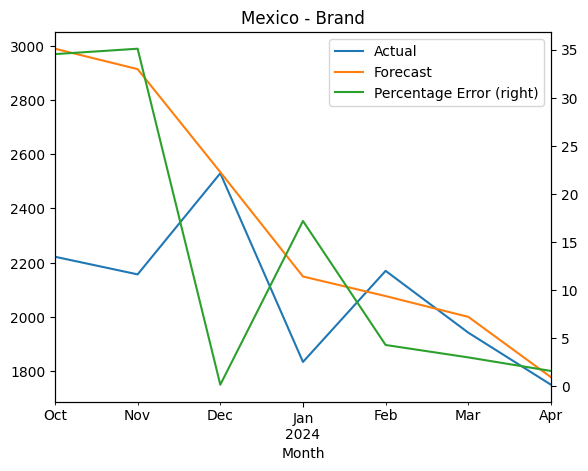

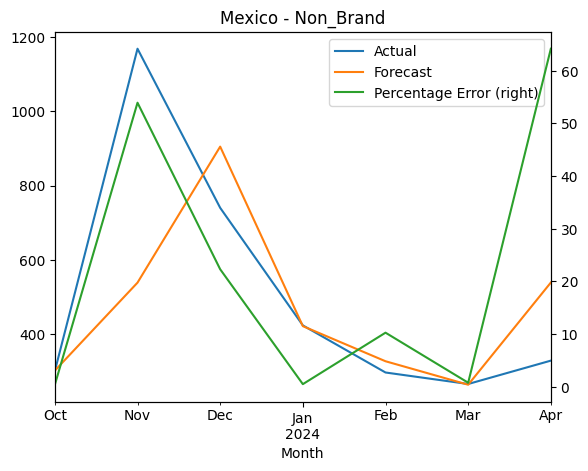

In [22]:
PlotAccuracyCharts(new_accuracy_df, New_Cuts_df, query_item_list)


In [24]:
# %load_ext autoreload
# %autoreload 
model_generator = GenerateModelFile()
model_generator.Generate(New_Cuts_df, final_df , query_item_list, output_bucket, folder_name, base_path=base_path)

02:37:50 - cmdstanpy - INFO - Chain [1] start processing
02:37:53 - cmdstanpy - INFO - Chain [1] done processing
02:37:54 - cmdstanpy - INFO - Chain [1] start processing
02:37:55 - cmdstanpy - INFO - Chain [1] done processing


# Constrain Setting

In [41]:
bounds = New_Cuts_df.copy()
bounds['MinWeight'] = 0.8
bounds['MaxWeight'] = 1.2
bounds

# %load_ext autoreload
# %autoreload 2
constraint_file_generator = ConstraintFileGenerator(config_dict, analytical_file_df)
constraint_file = constraint_file_generator.Generate(bounds)
constraint_file_generator.SaveFile(output_bucket, folder_name, constraint_file_name)

Data Frame file saved


### When constraints are customized

In [44]:
constraint_file.loc[constraint_file['Month'].isin(['Nov']), 'MinWeight'] = 0.7
constraint_file.loc[constraint_file['Month'].isin(['Nov']), 'MaxWeight'] = 0.8
constraint_file.loc[(constraint_file['Month'] == 'Oct') & (constraint_file['funnel'] == 'Brand'), 'MinWeight'] = 0.75
constraint_file.loc[(constraint_file['Month'] == 'Oct') & (constraint_file['funnel'] == 'Brand'), 'MaxWeight'] = 1
constraint_file.loc[(constraint_file['Month'] == 'Sep') & (constraint_file['funnel'] == 'Brand'), 'MinWeight'] = 0.75
constraint_file.loc[(constraint_file['Month'] == 'Sep') & (constraint_file['funnel'] == 'Brand'), 'MaxWeight'] = 1
constraint_file.loc[(constraint_file['Month'] == 'Dec') & (constraint_file['funnel'] == 'Brand'), 'MaxWeight'] = 1.1

In [45]:
constraint_file_generator.SaveFile(output_bucket, folder_name, constraint_file_name, df=constraint_file)

Data Frame file saved
